# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  546287.047997  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         0.5      286614.273964  
         1.0      398139.231561  
         1.5      457478.291179  
         2.0      494315.467226

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


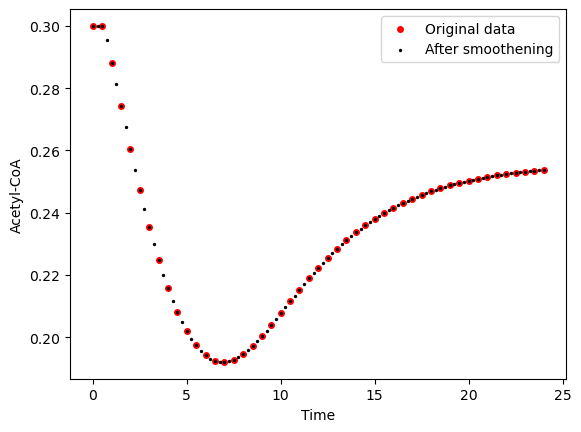

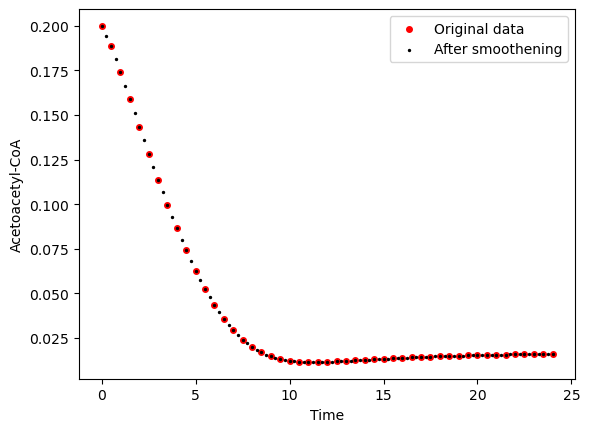

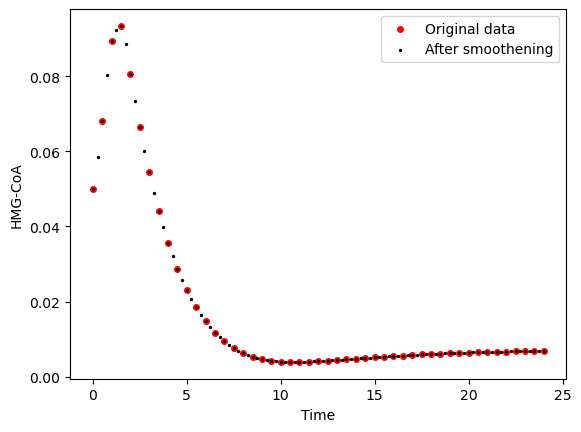

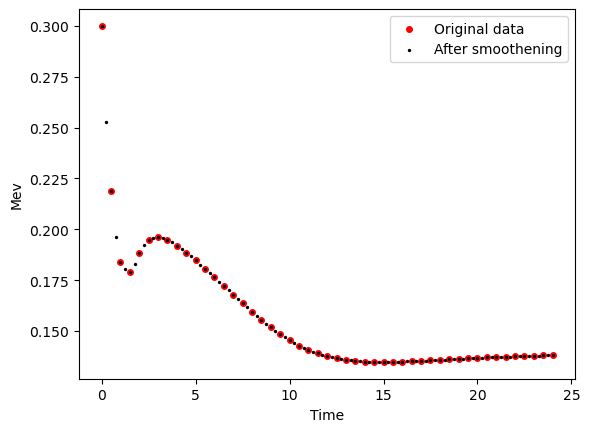

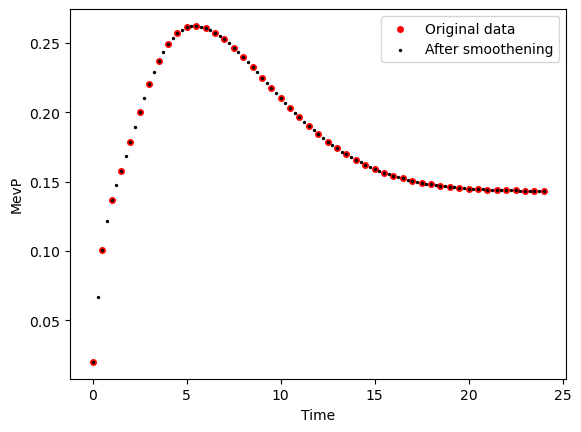

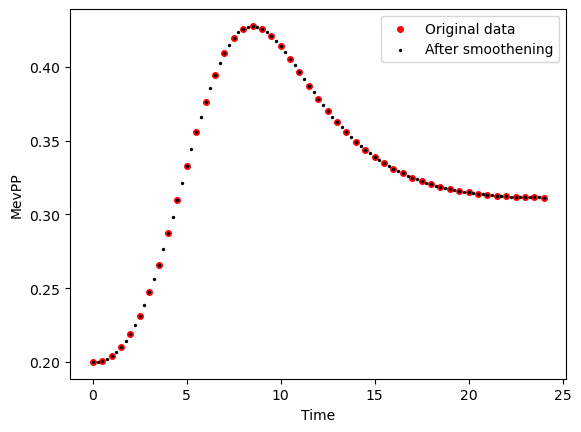

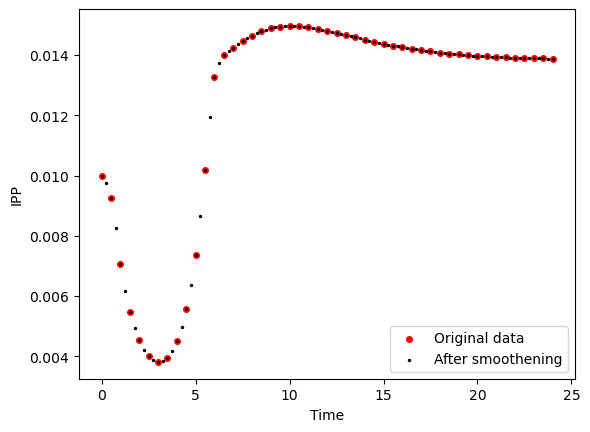

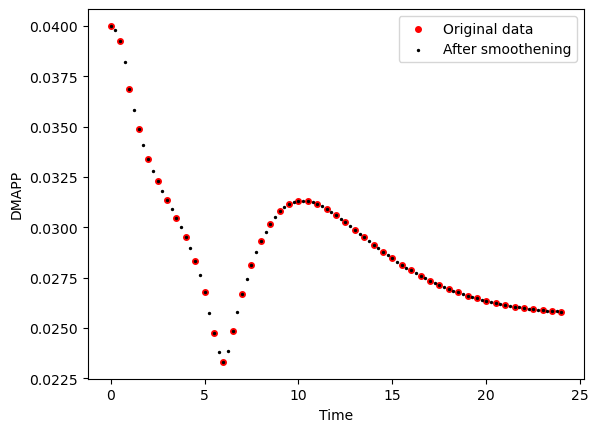

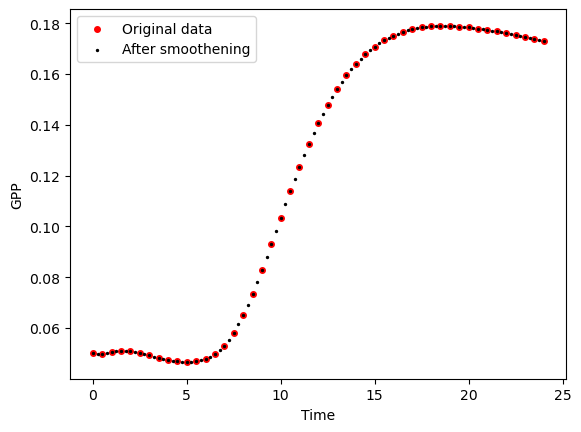

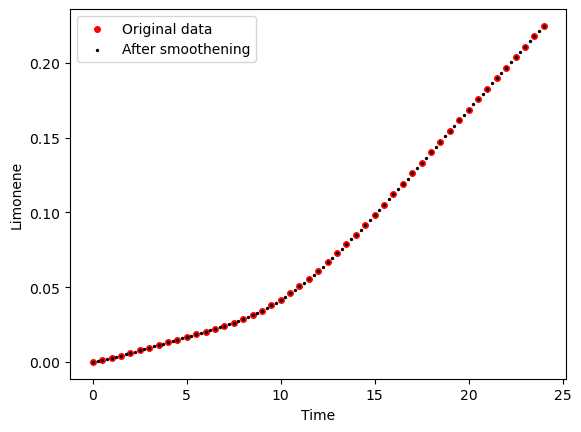

Strain Strain 2


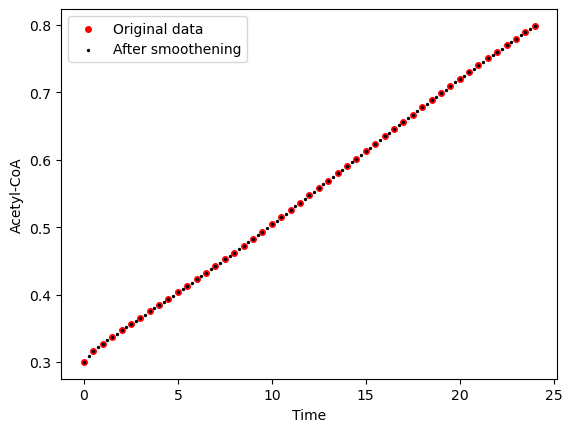

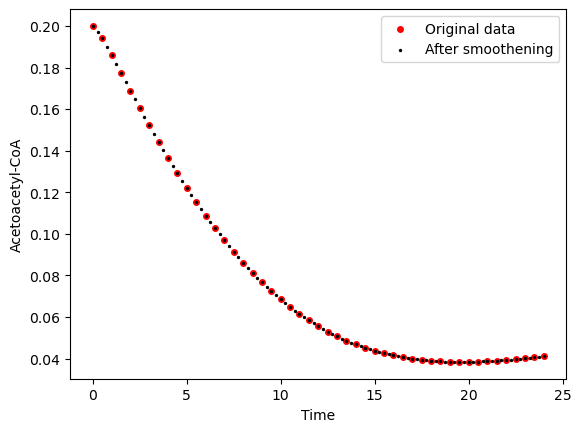

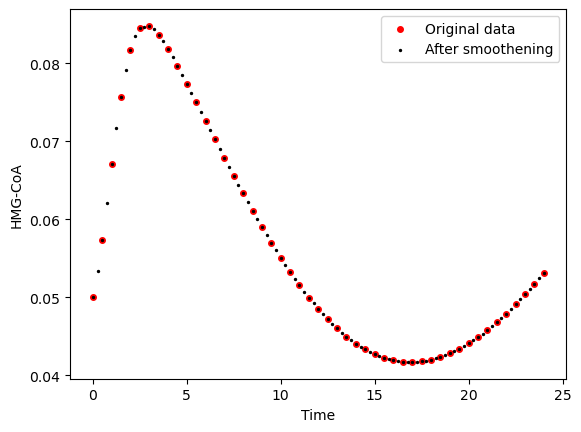

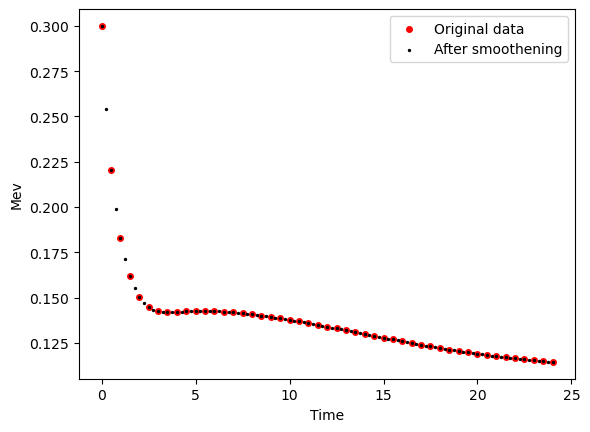

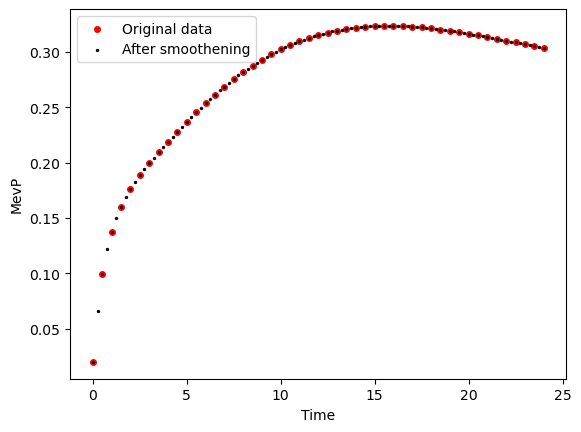

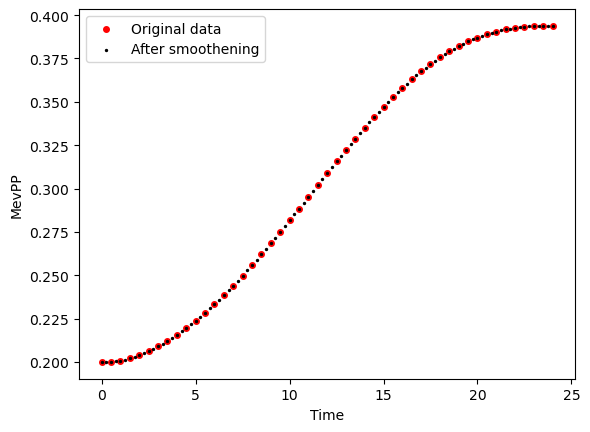

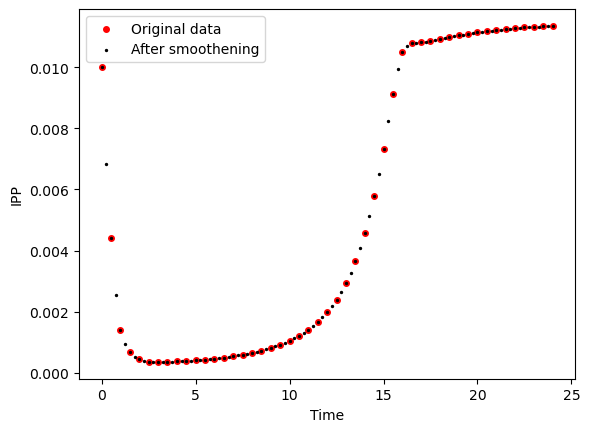

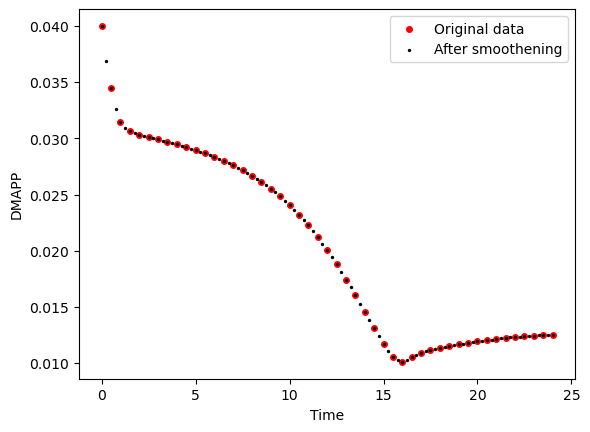

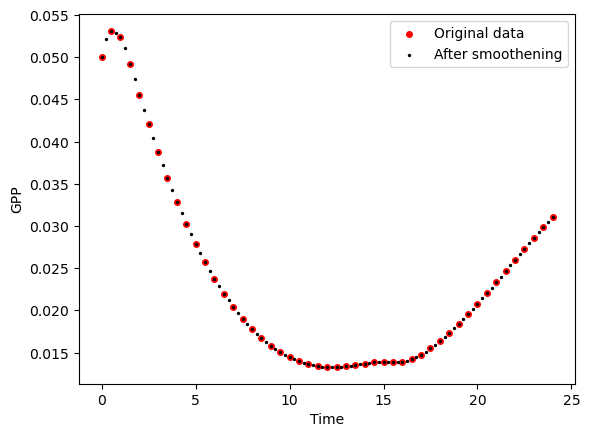

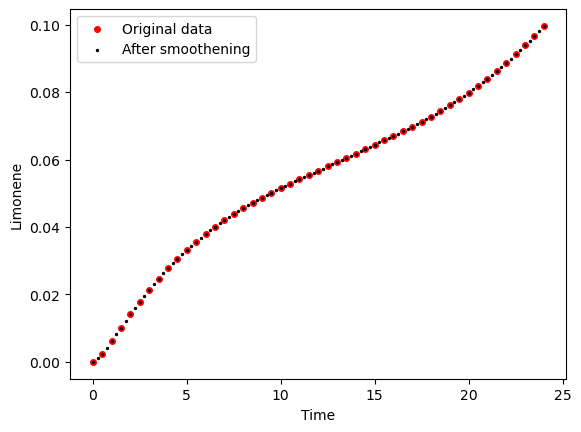

Strain Strain 3


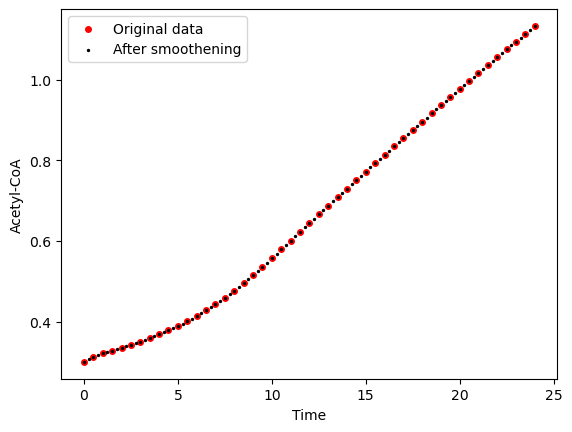

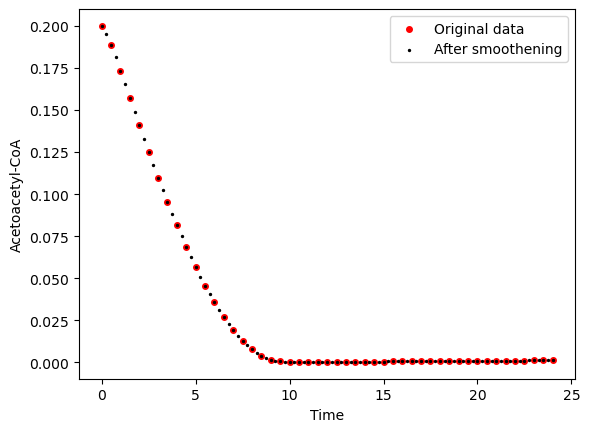

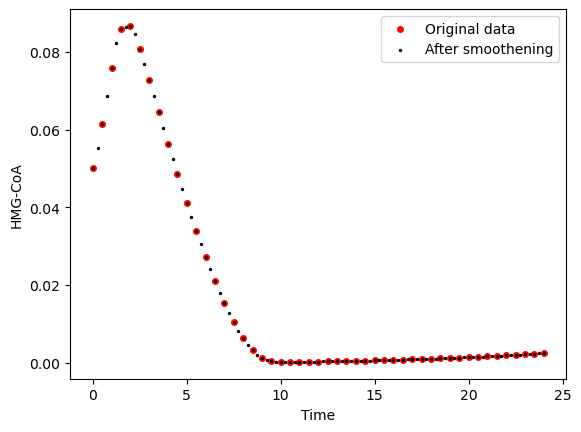

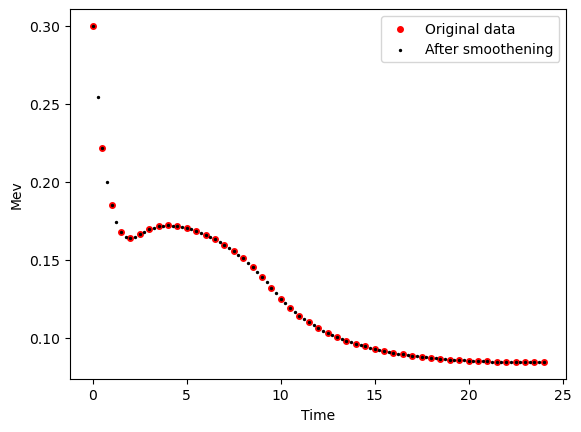

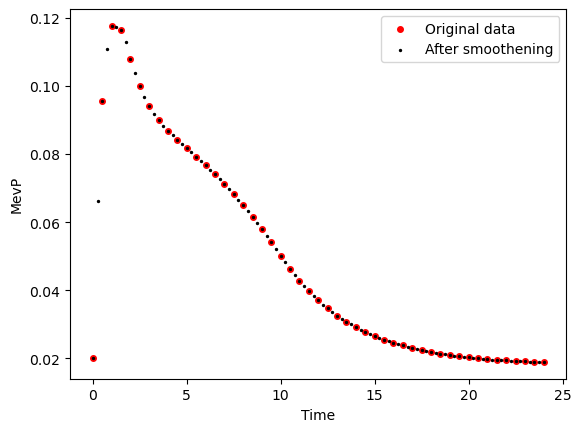

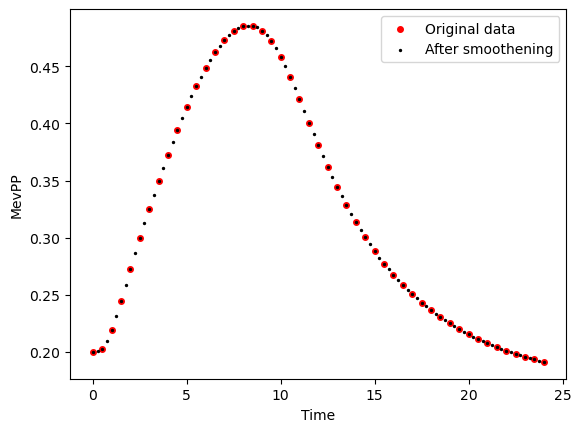

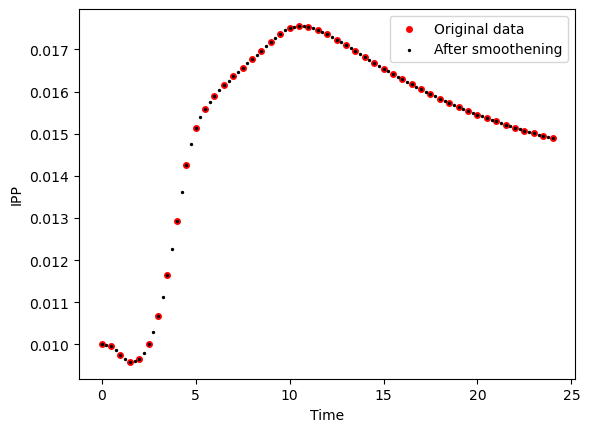

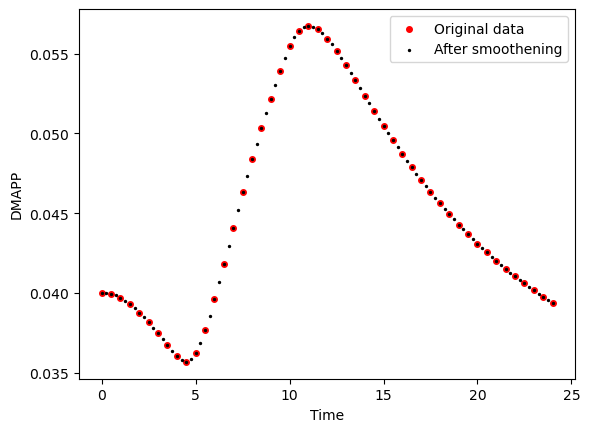

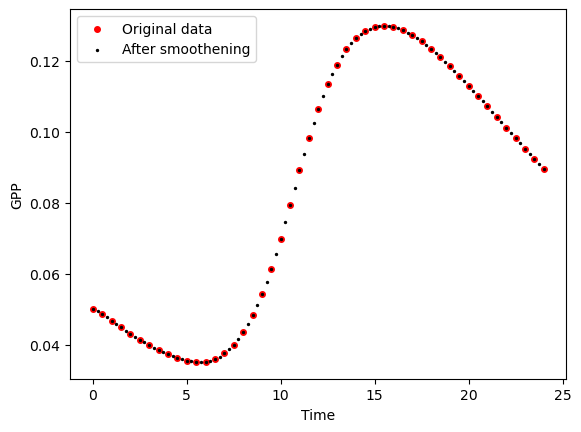

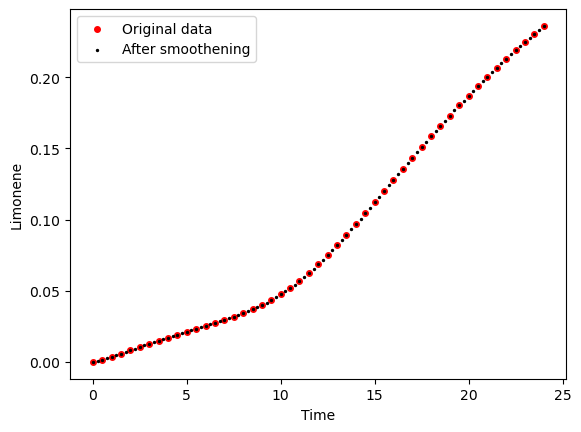

Strain WT


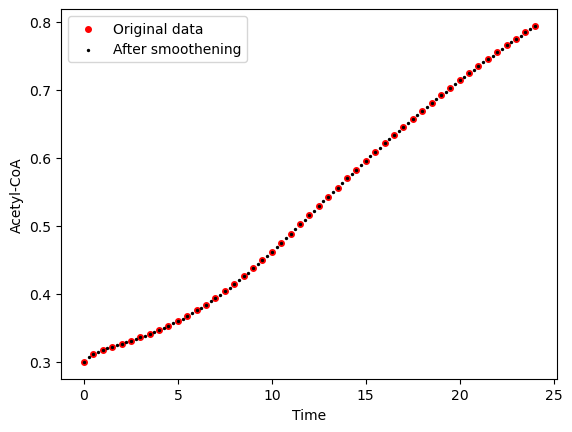

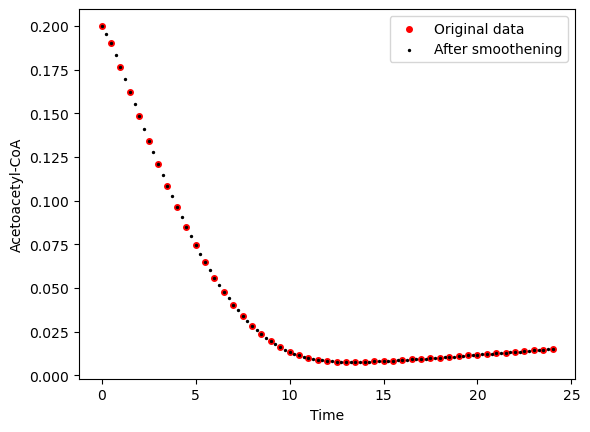

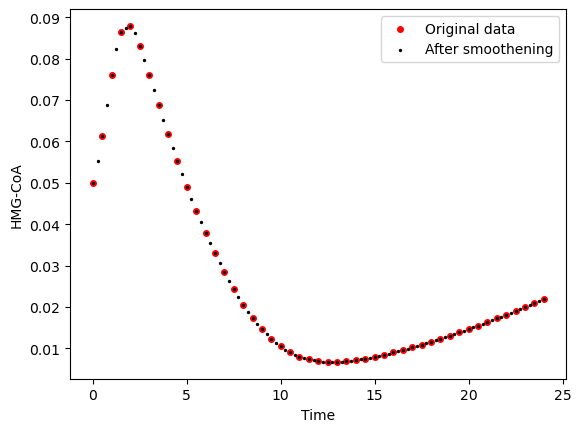

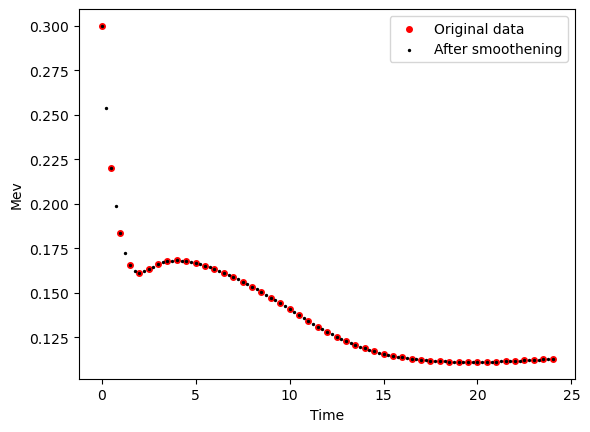

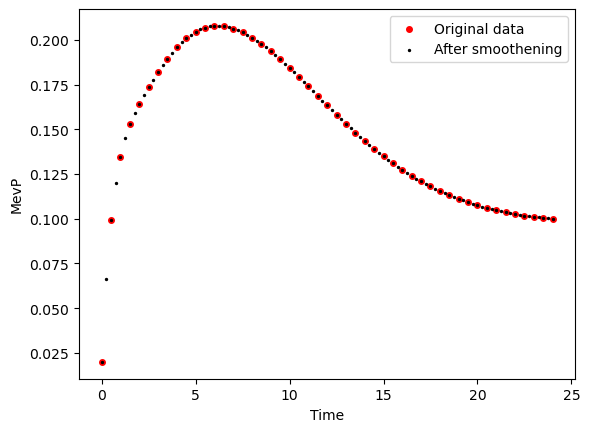

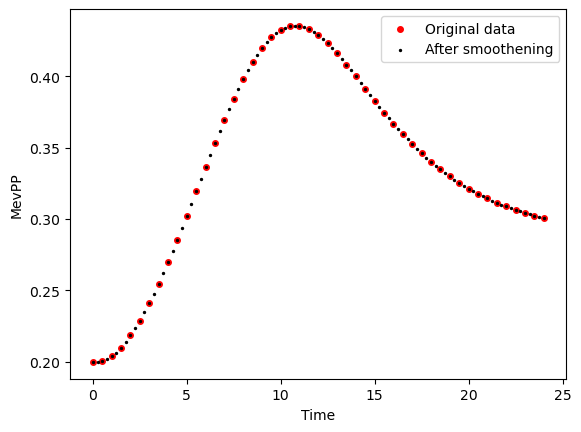

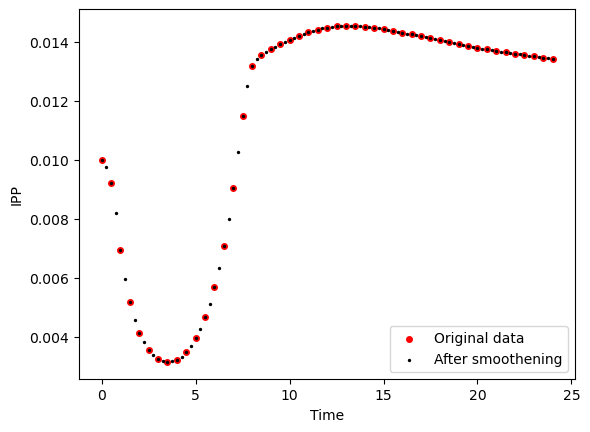

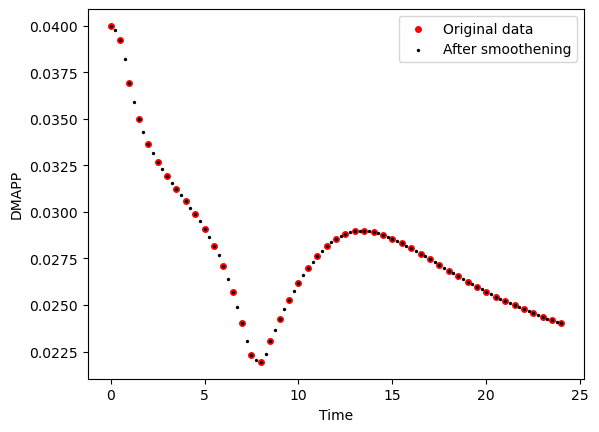

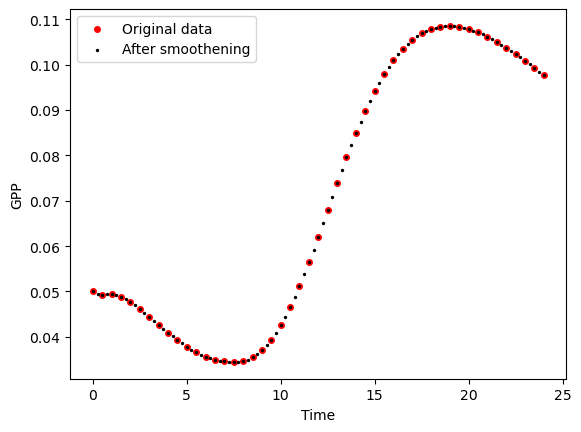

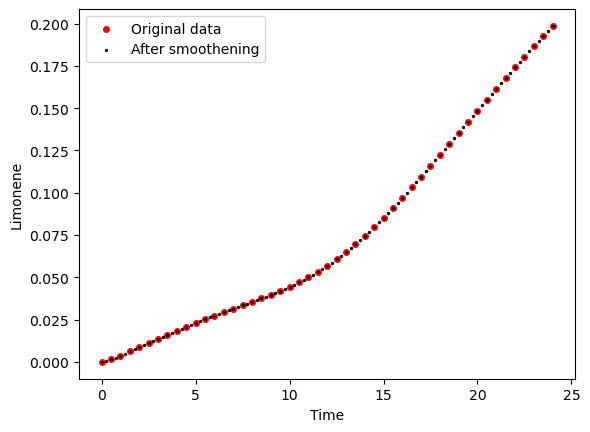

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


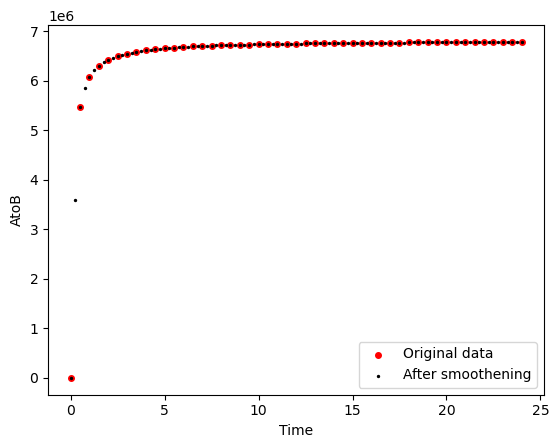

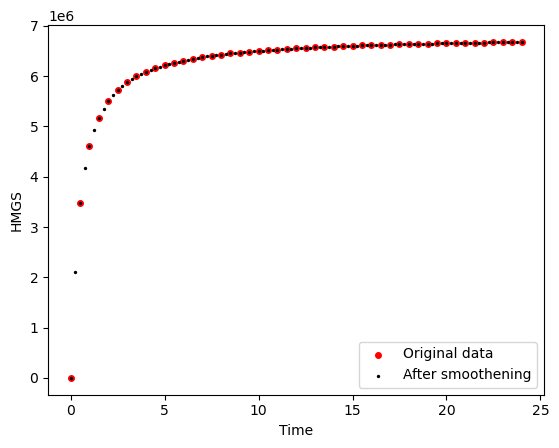

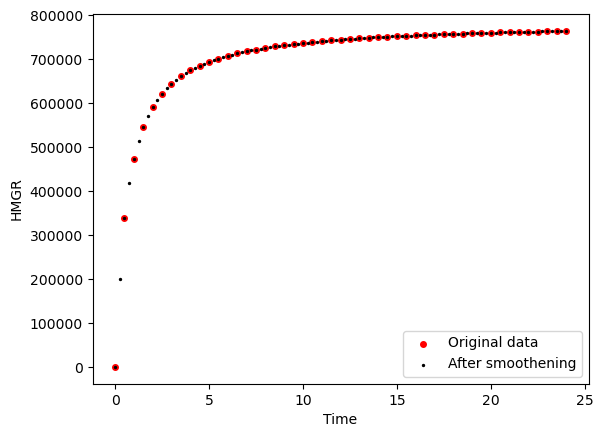

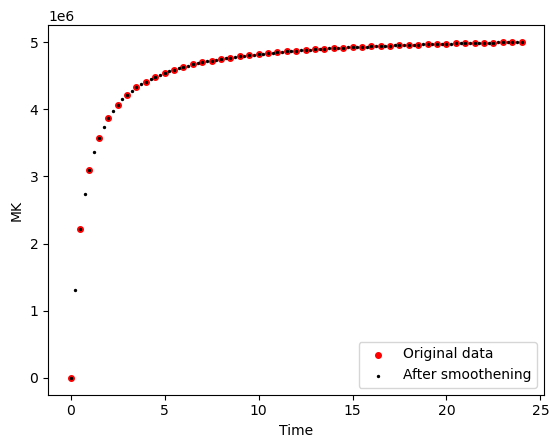

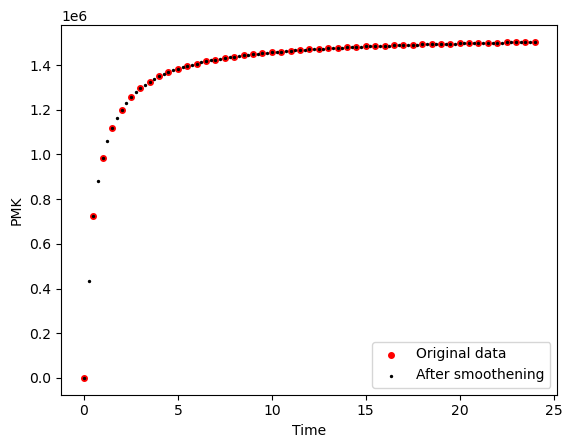

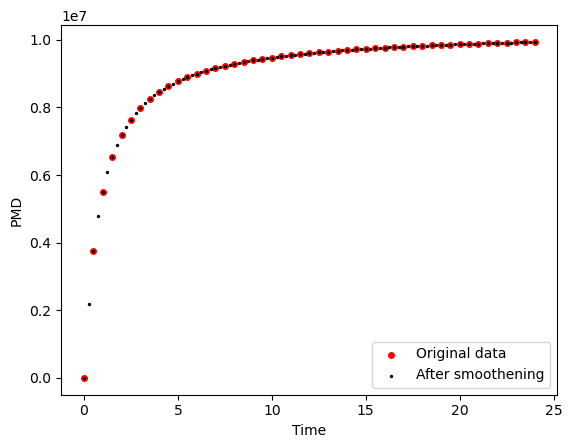

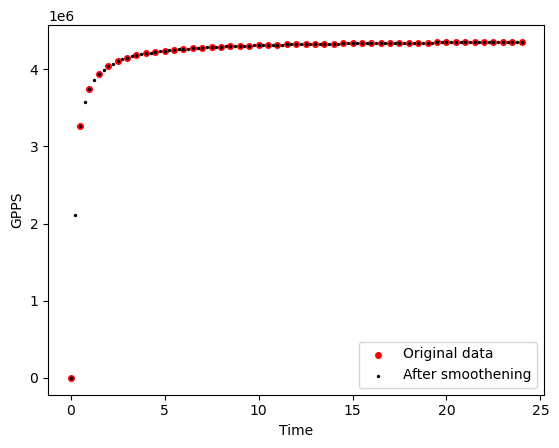

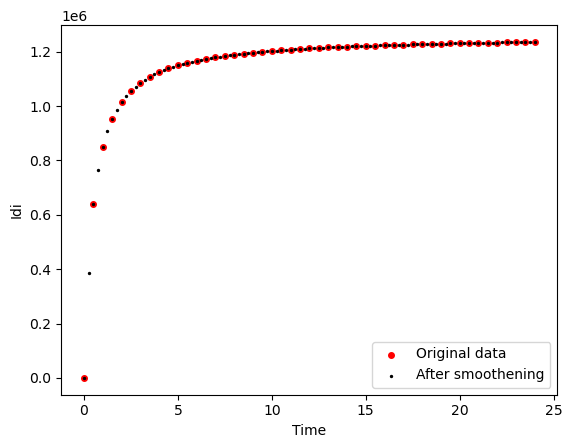

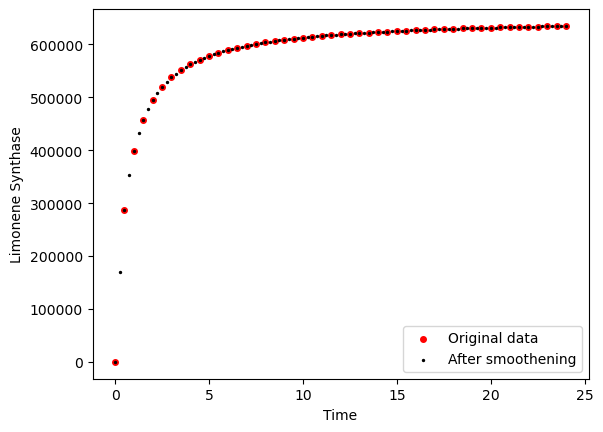

Strain Strain 2


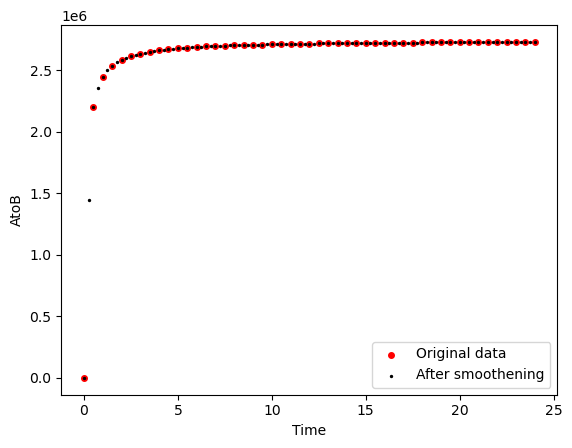

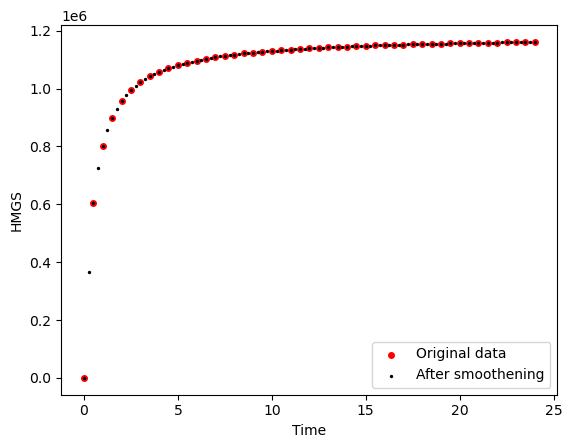

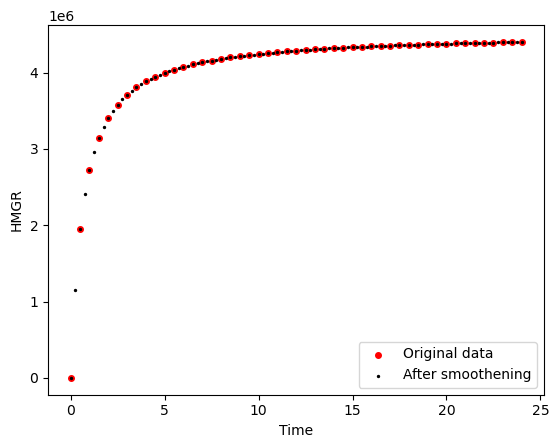

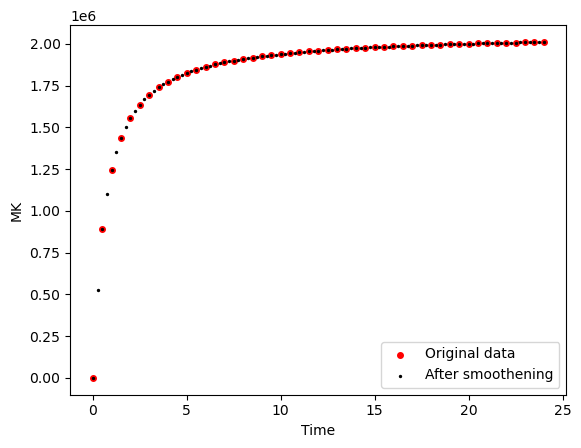

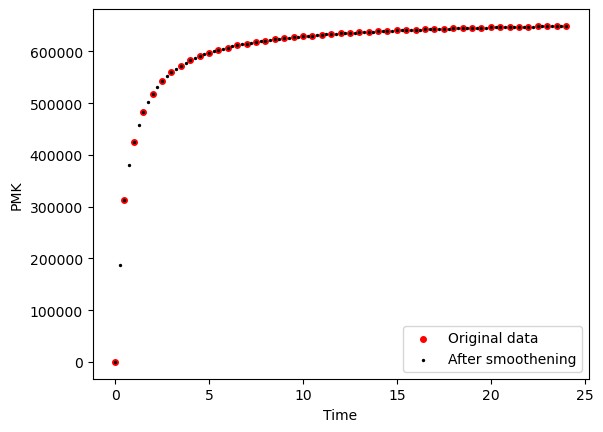

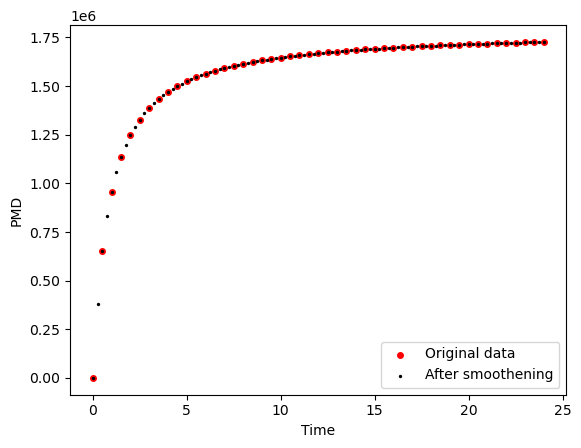

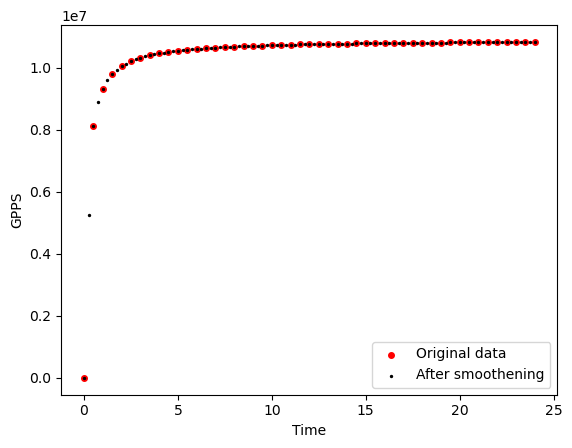

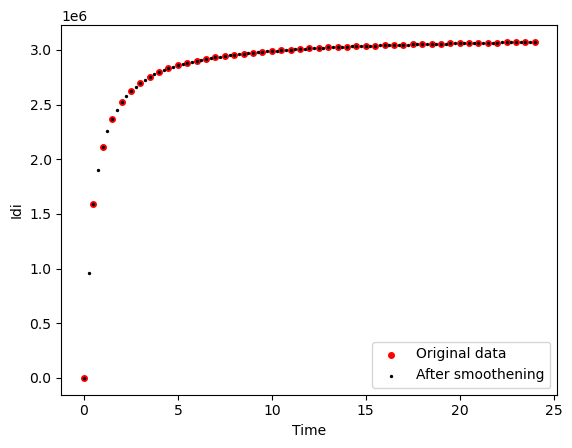

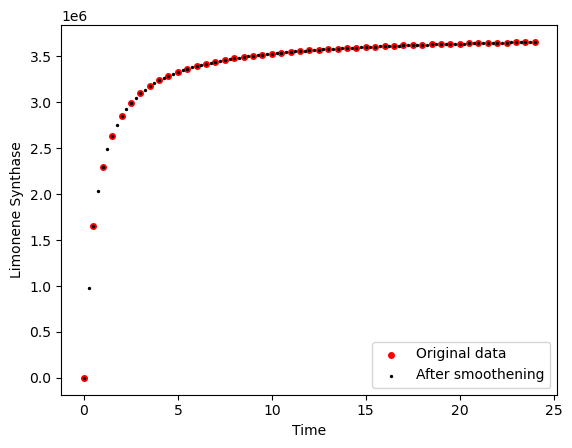

Strain Strain 3


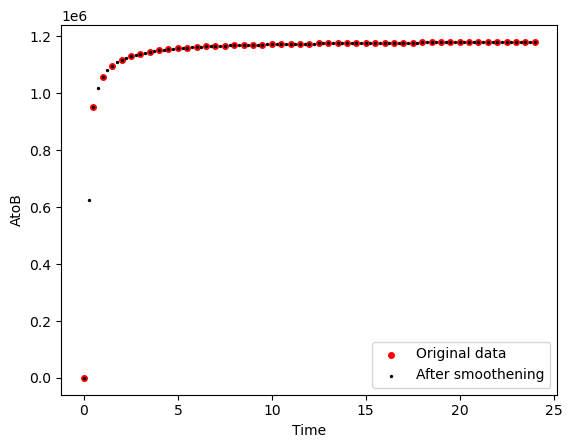

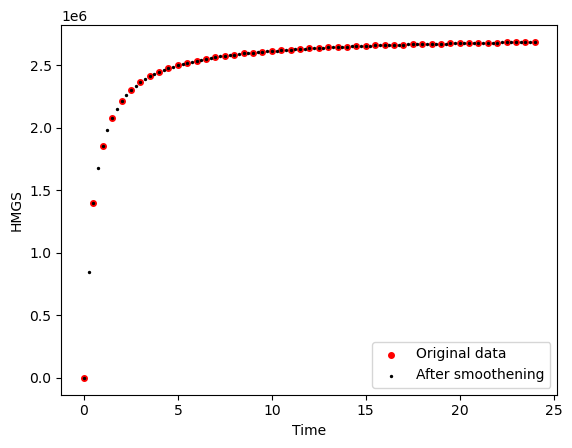

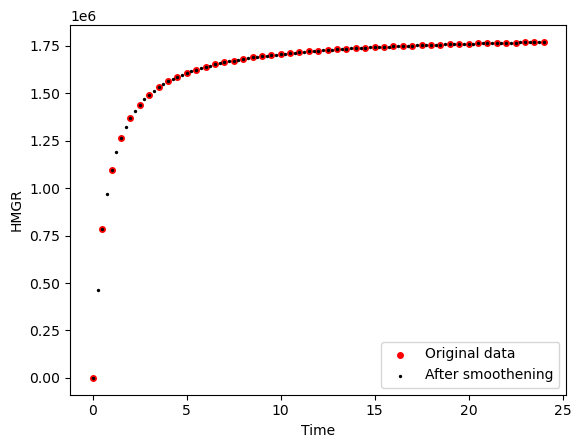

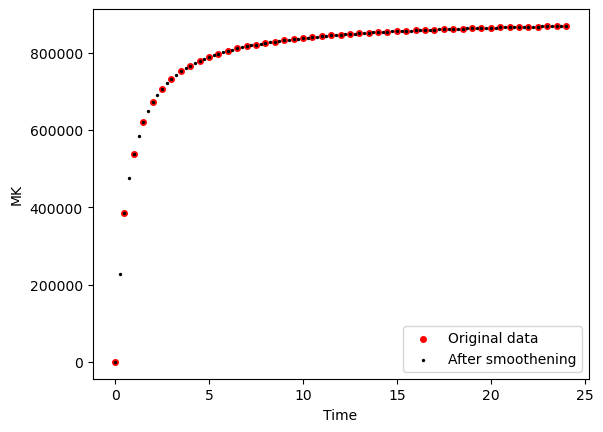

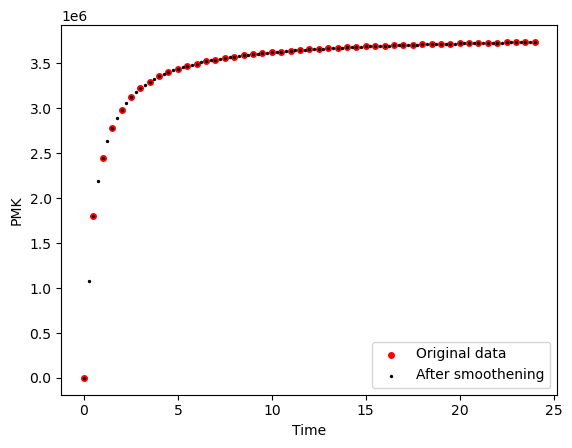

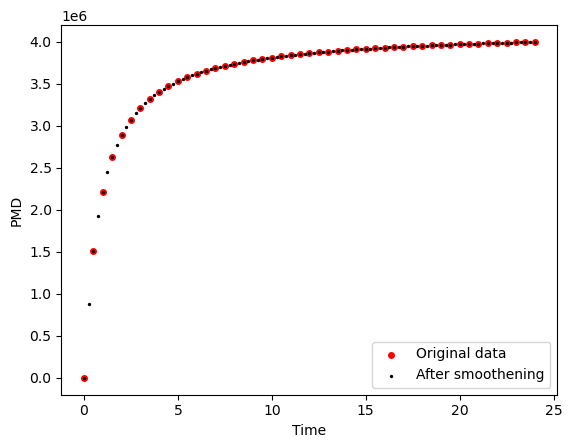

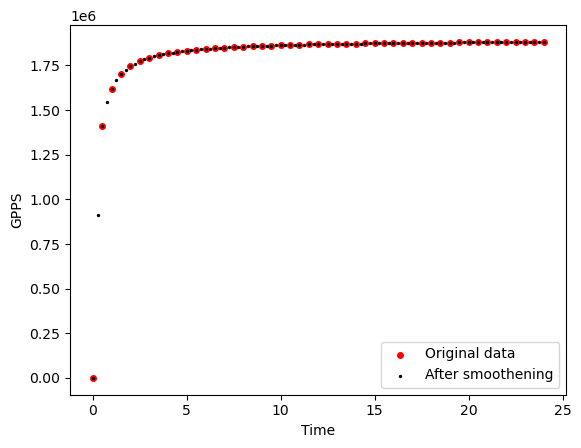

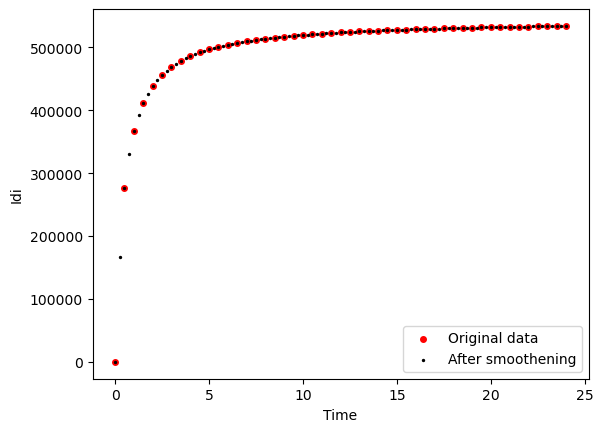

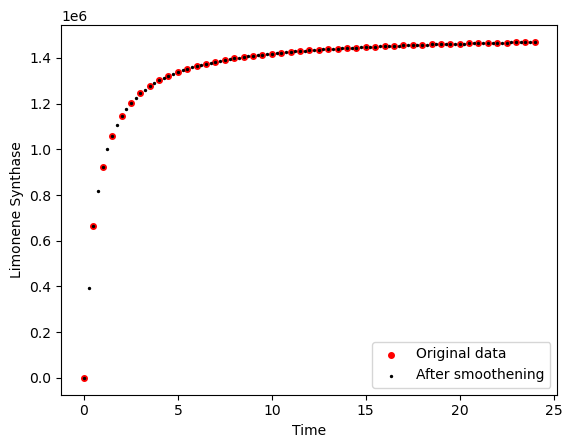

Strain WT


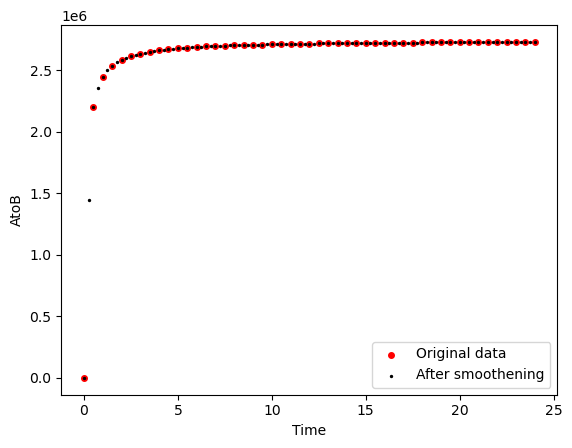

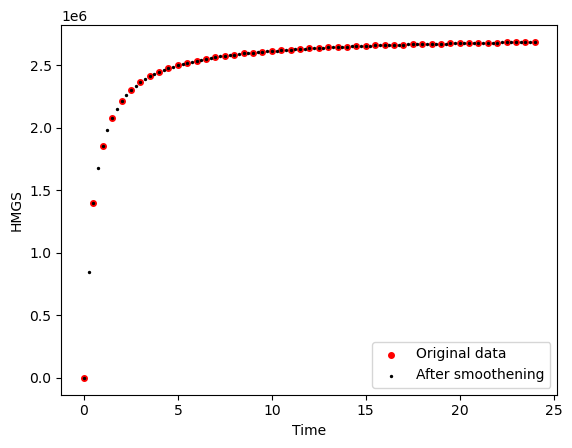

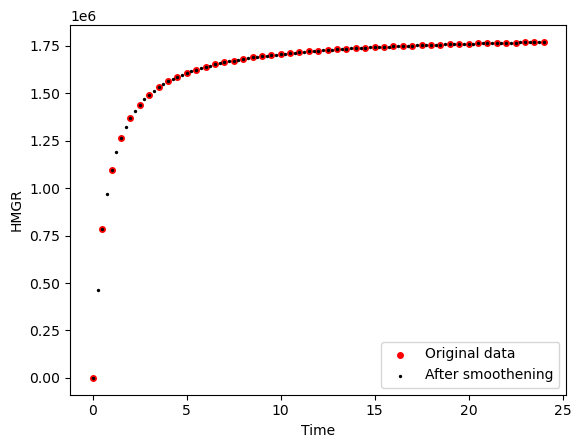

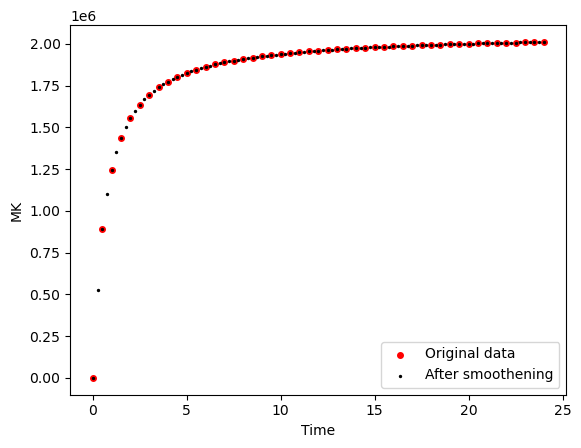

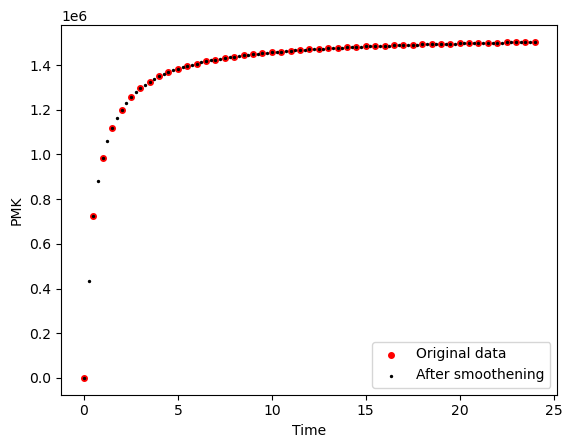

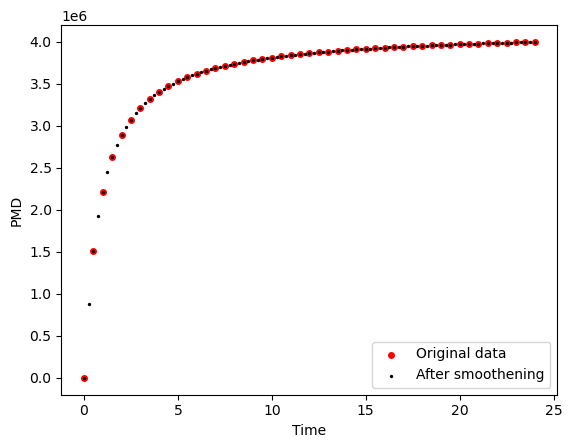

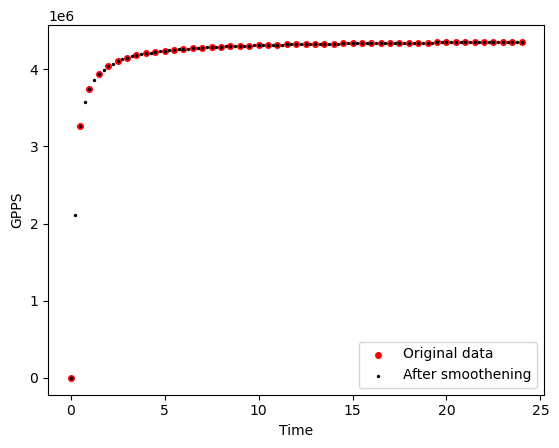

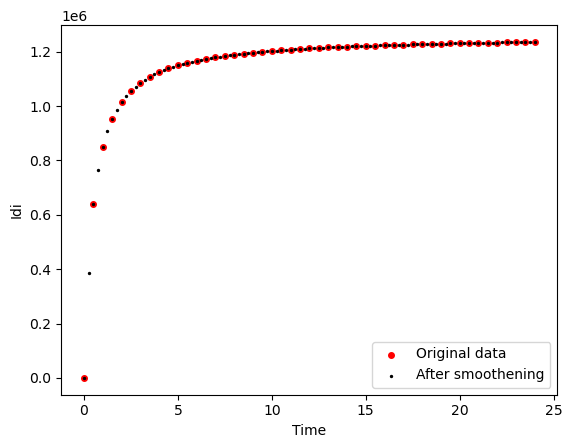

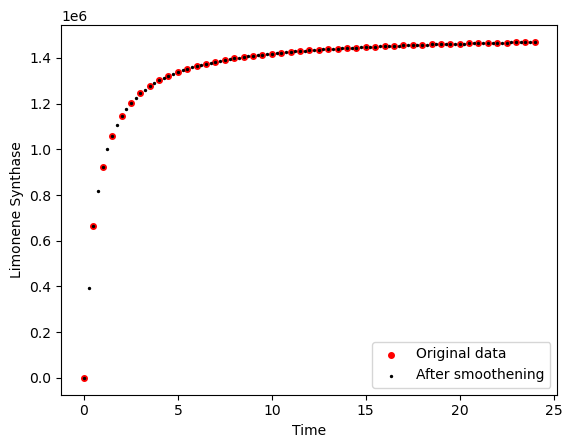

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.299973        0.194624  0.058602  0.252554  0.067099   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.295598        0.181565  0.080420  0.196453  0.121374   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021362  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200156  0.009761  0.039774  0.049802  0.000437  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201722  0.008244  0.038213  0.050161  0.001679  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098490  0.195635  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.013690       -0.018904  0.027176 -0.222785  0.222886   
         0.25    -0.001145       -0.023161  0.039481 -0.161460  0.157755   
         0.50    -0.012890       -0.026471  0.043928 -0.109410  0.106960   
         0.75    -0.021545       -0.028834  0.040518 -0.066636  0.070502   
         1.00    -0.028784       -0.030249  0.027513 -0.032895  0.049786   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001354   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000590 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000607 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000621 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001006  0.000783  0.000992 -0.002212  0.001339  
         0.25   0.001066 -0.001721 -0.001670 -0.000263  0.002004  
         0.50   0.003438 -0.003397 -0.003536  0.001029  0.002540  
         0.75   0.006111 -0.004247 -0.004605  0.001664  0.002949  
         1.00   0.009363 -0.004243 -0.004909  0.001653  0.003235  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003143  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003202  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

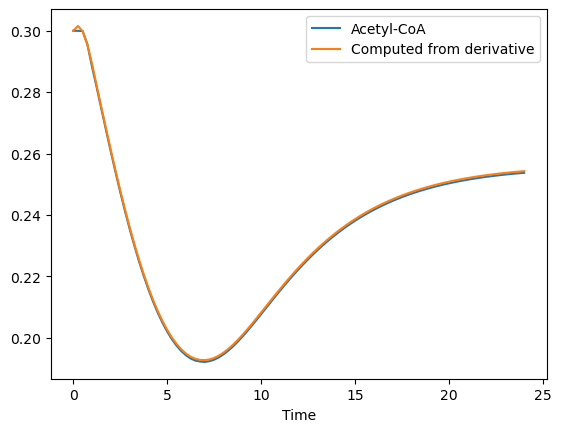

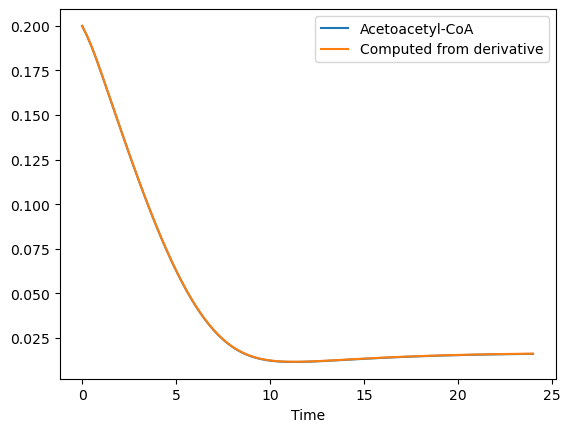

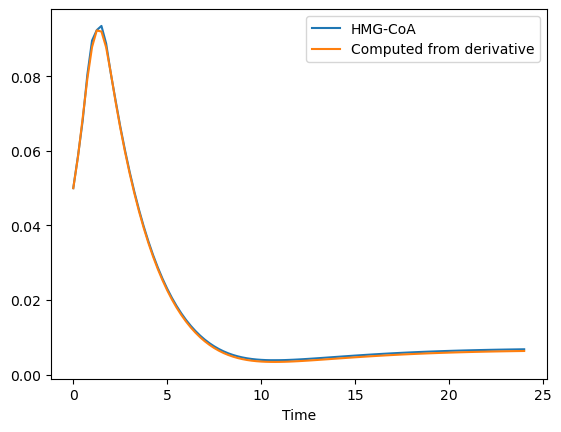

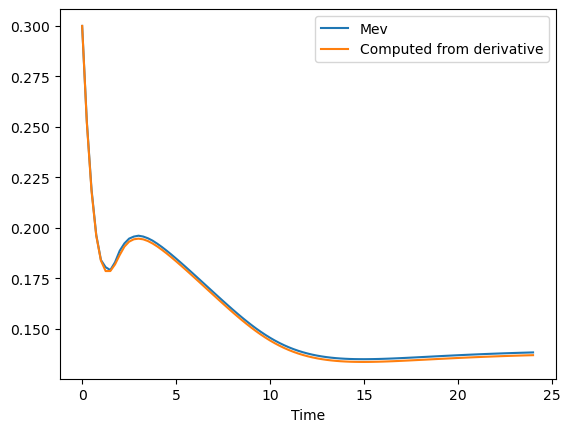

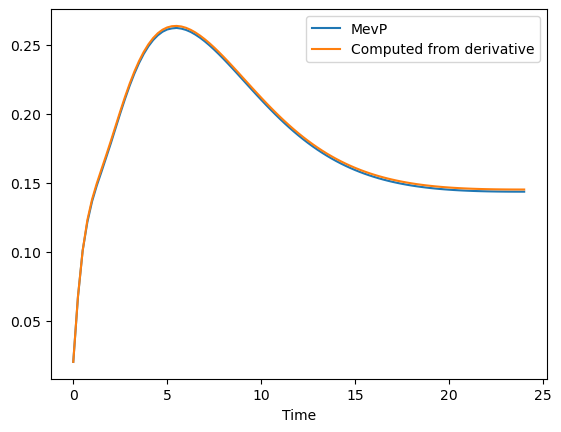

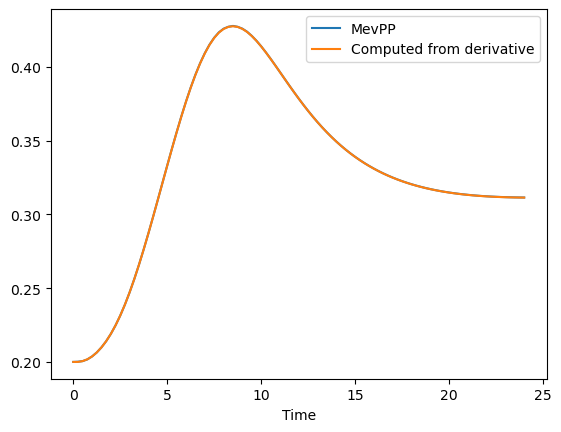

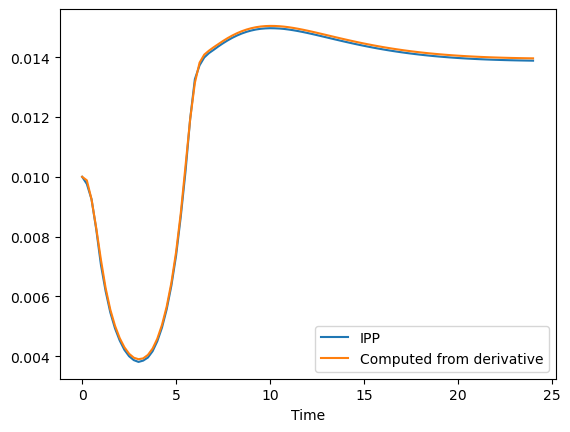

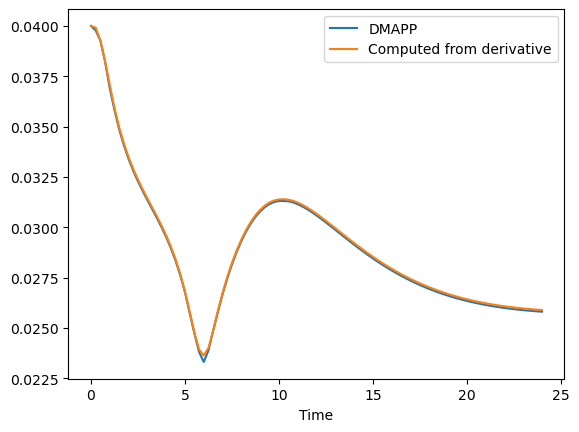

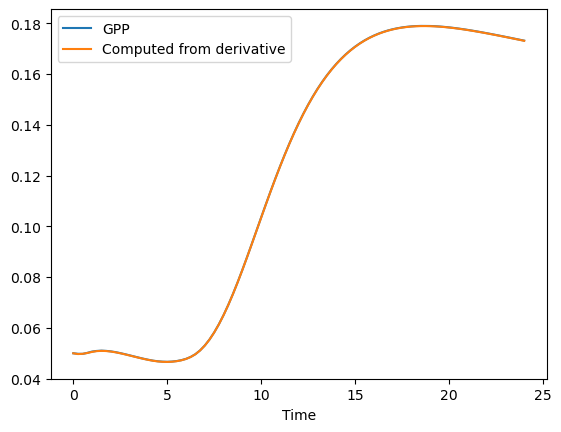

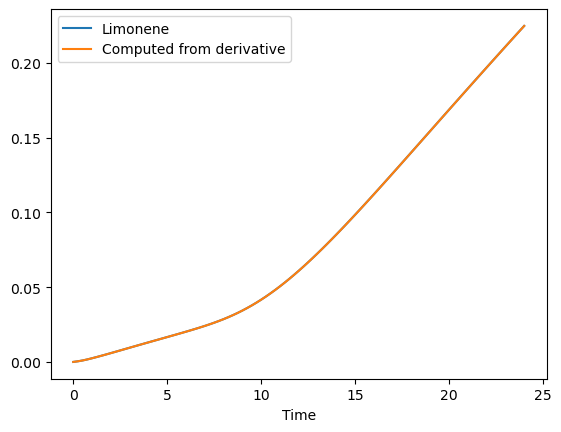

'Time profile from derivative vs. actual profile for Strain 2'

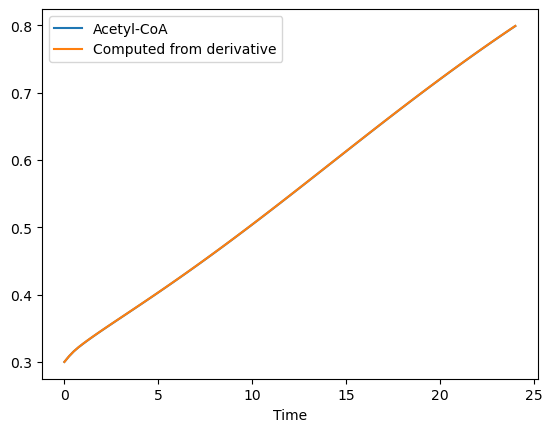

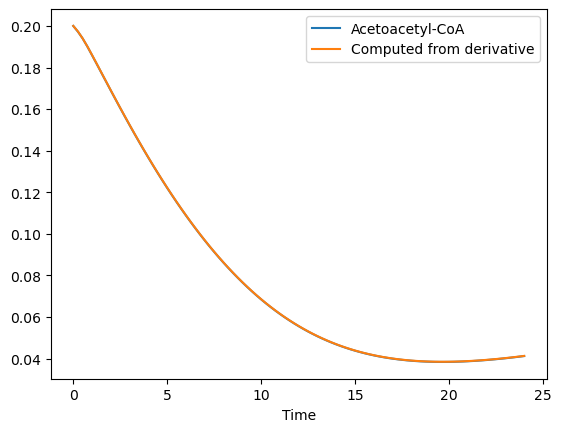

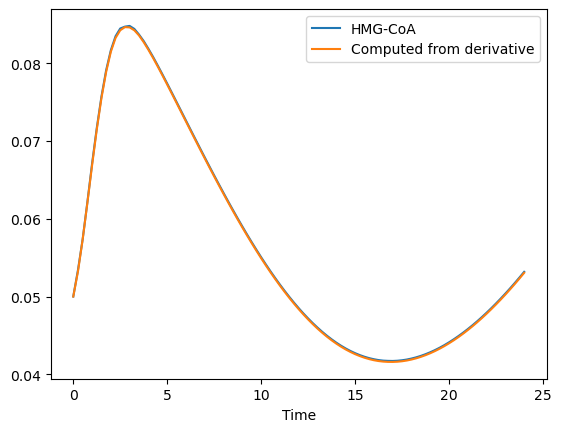

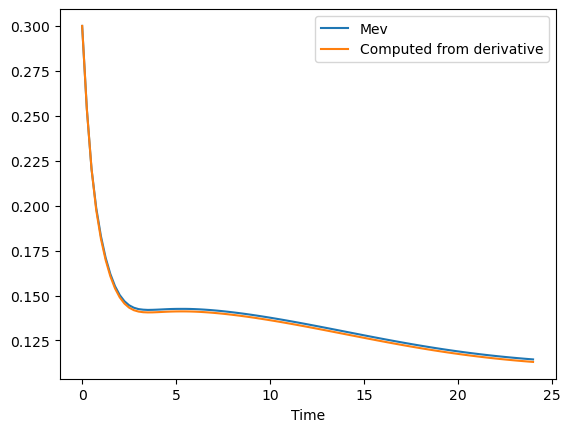

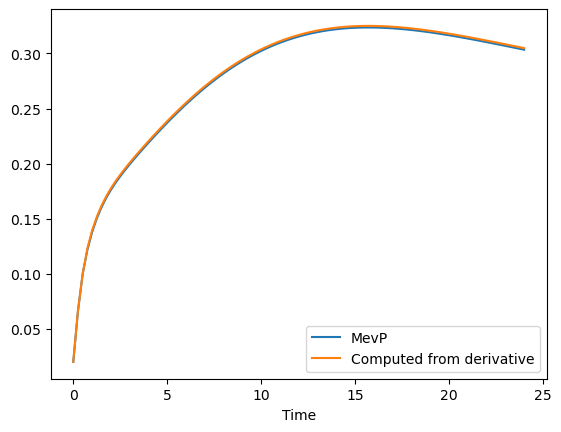

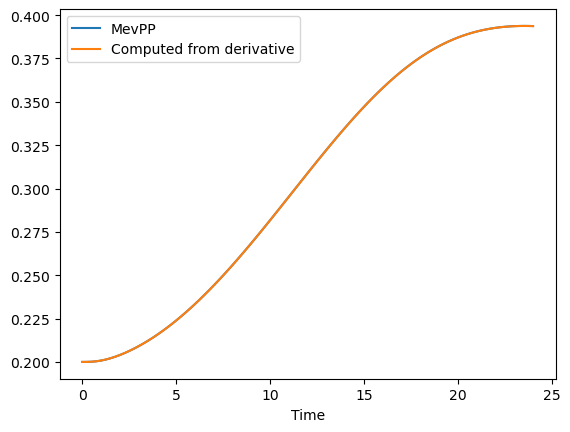

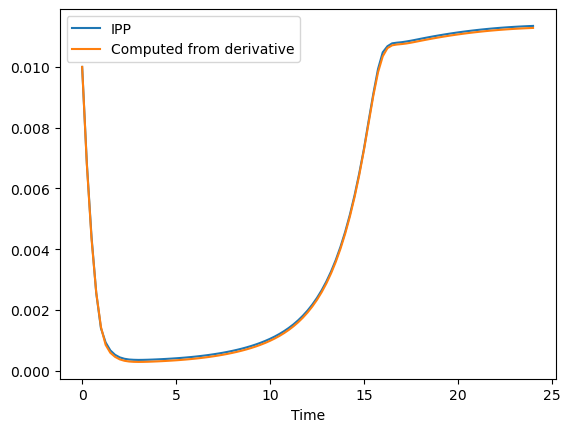

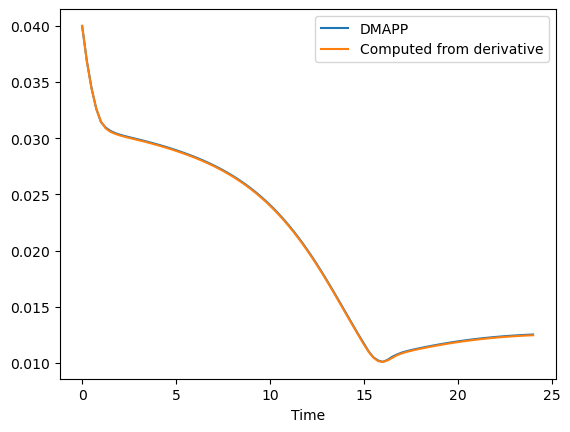

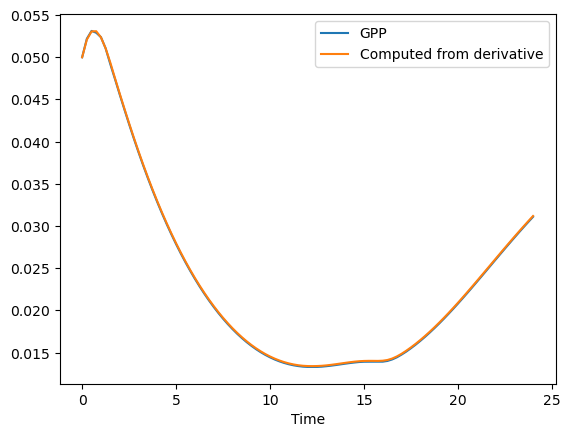

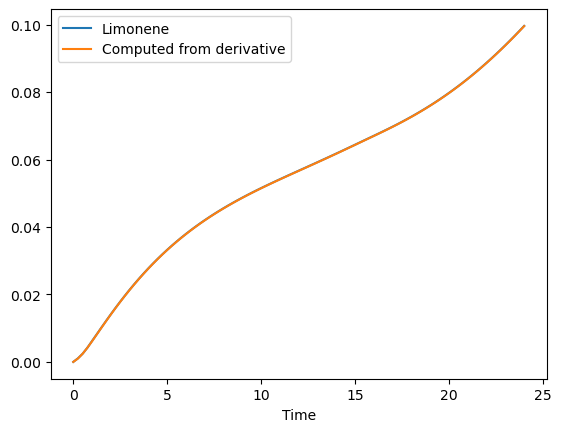

'Time profile from derivative vs. actual profile for Strain 3'

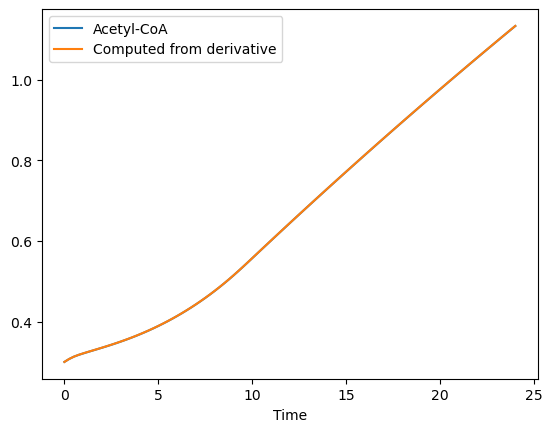

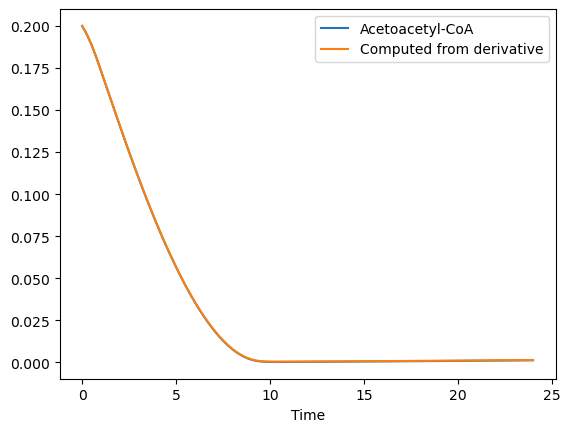

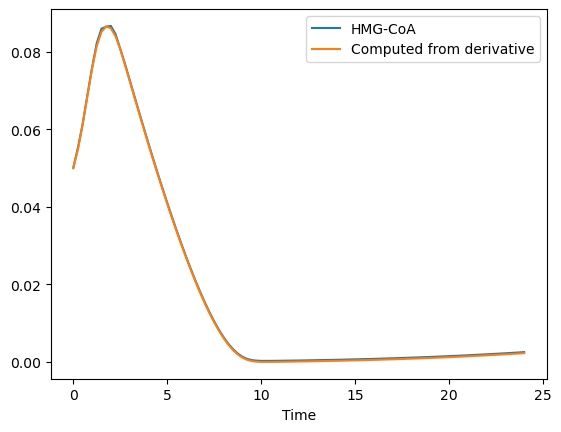

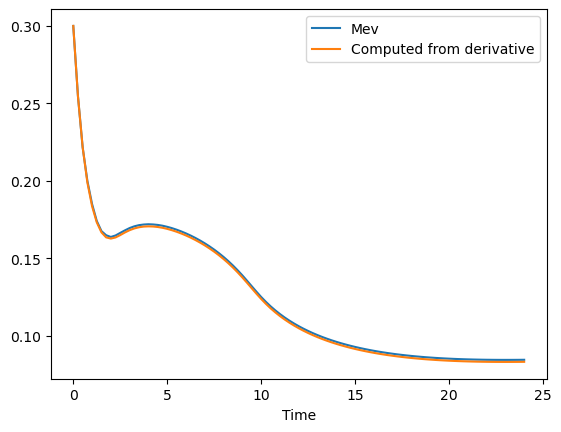

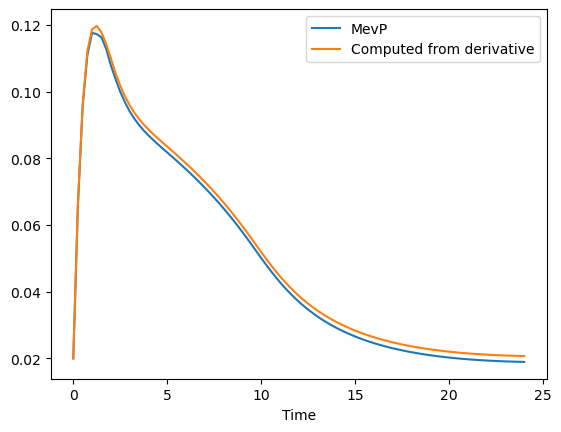

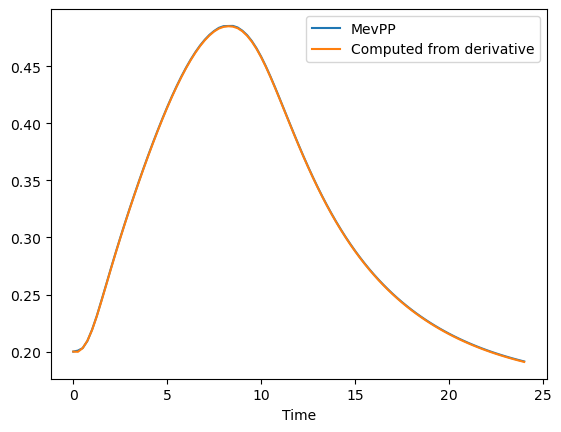

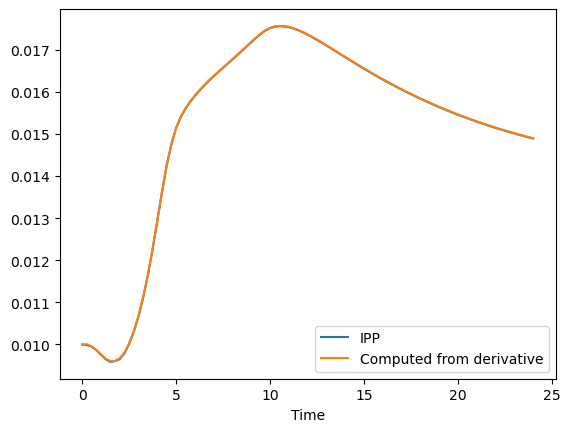

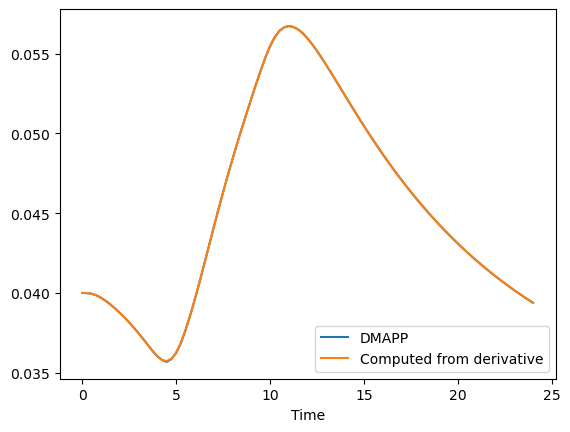

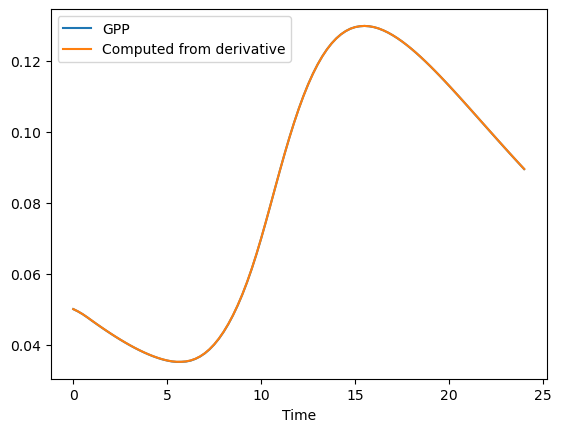

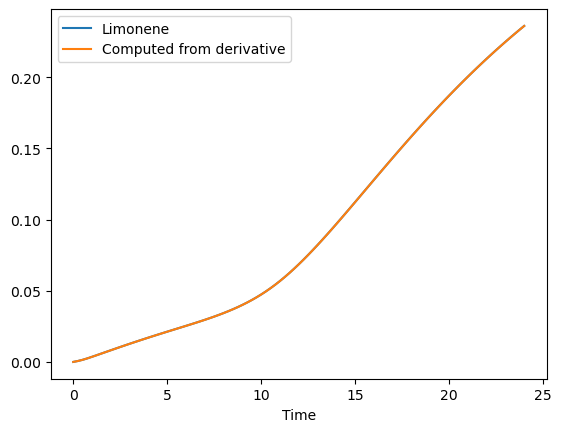

'Time profile from derivative vs. actual profile for WT'

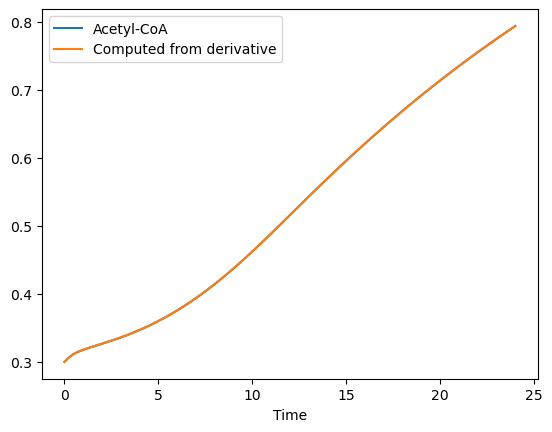

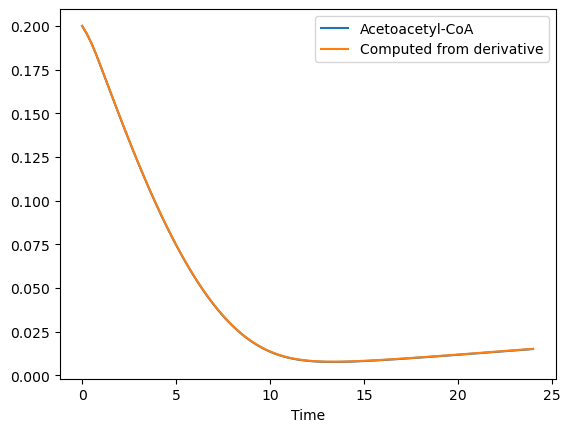

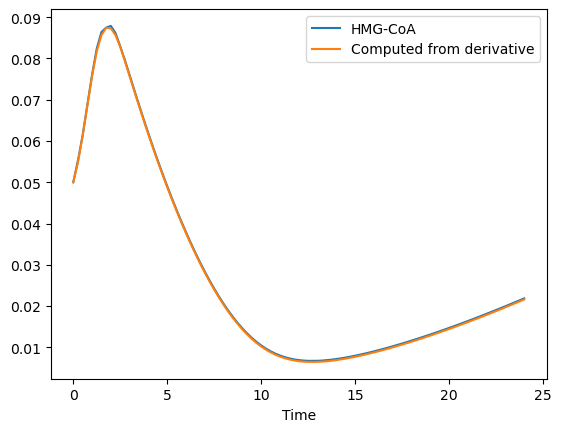

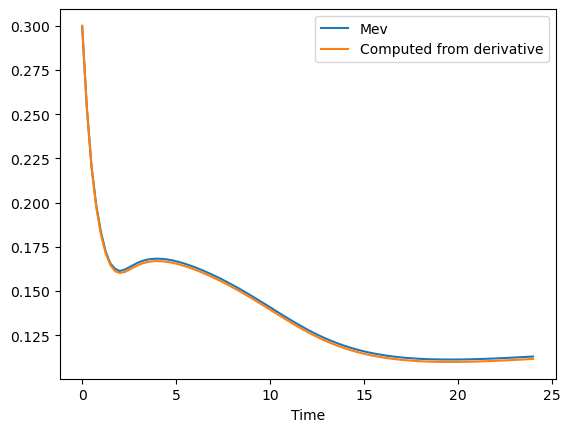

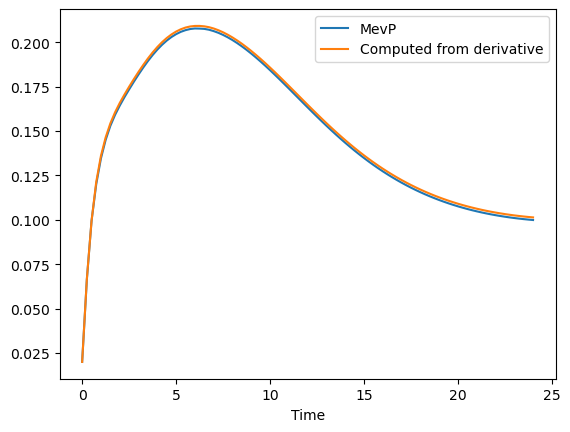

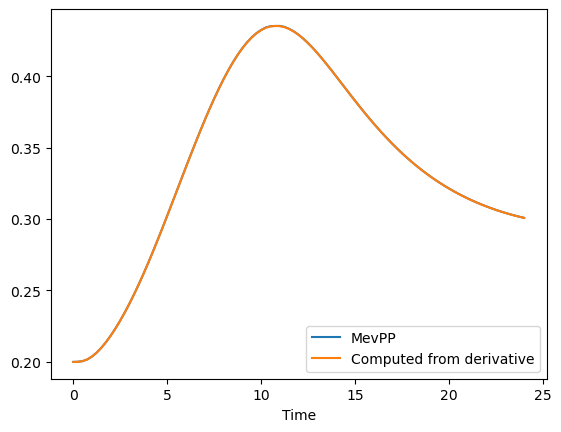

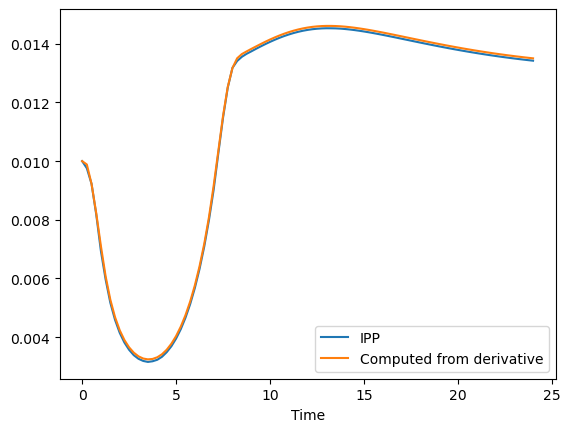

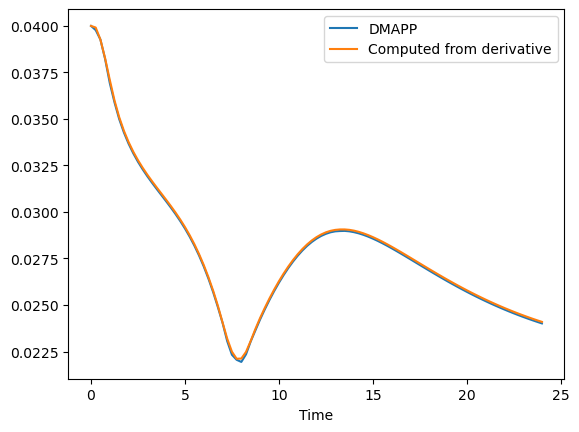

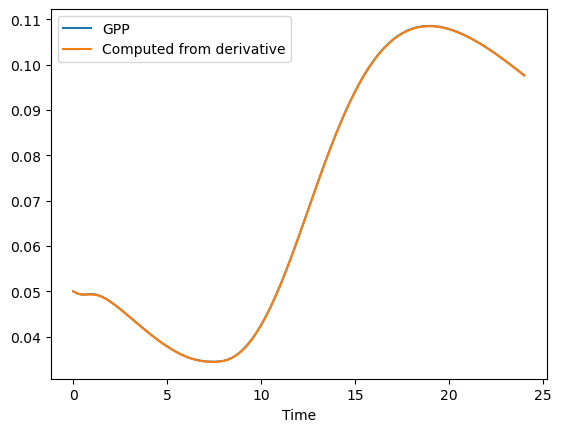

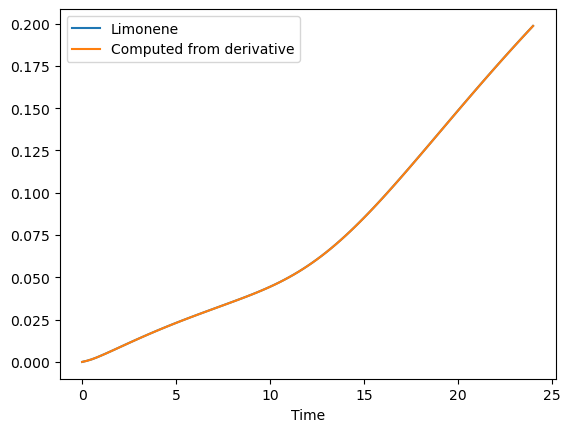

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   3.589052e+06  2.111237e+06  2.008718e+05  1.311689e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.865920e+06  4.166035e+06  4.191051e+05  2.738184e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.336546e+05  2.178306e+06  2.110608e+06  3.875298e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.801888e+05  4.773919e+06  3.574431e+06  7.666082e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.700158e+05   0.299973        0.194624  0.058602   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.527646e+05   0.295598        0.181565  0.080420   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021362   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.252554  0.067099  0.200156  0.009761  0.039774  0.049802   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.196453  0.121374  0.201722  0.008244  0.038213  0.050161   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.013690       -0.018904  0.027176 -0.222785  0.222886   
         0.25    -0.001145       -0.023161  0.039481 -0.161460  0.157755   
         0.50    -0.012890       -0.026471  0.043928 -0.109410  0.106960   
         0.75    -0.021545       -0.028834  0.040518 -0.066636  0.070502   
         1.00    -0.028784       -0.030249  0.027513 -0.032895  0.049786   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001354   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000590 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000607 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000621 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001006  0.000783  0.000992 -0.002212  0.001339  
         0.25   0.001066 -0.001721 -0.001670 -0.000263  0.002004  
         0.50   0.003438 -0.003397 -0.003536  0.001029  0.002540  
         0.75   0.006111 -0.004247 -0.004605  0.001664  0.002949  
         1.00   0.009363 -0.004243 -0.004909  0.001653  0.003235  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003143  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003202  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003034 -0.000069 -0.000325 -0.003295  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 4.151786E+188 | 7.479466E+113
     2 |       74 | 7.775002E+129 |  2.932853E+84
     3 |      138 |  4.594726E+97 |  8.755366E+81
     4 |      202 |  2.499945E+85 |  1.237828E+71
     5 |      266 |  9.644943E+75 |  1.636348E+55
     6 |      330 |  7.048128E+70 |  2.745183E+53
     7 |      394 |  4.929999E+57 |  2.773053E+47
     8 |      458 |  2.804643E+52 |  8.687823E+31
     9 |      522 |  1.599223E+52 |  8.687823E+31
    10 |      586 |  1.178809E+47 |  8.687823E+31
    11 |      650 |  3.541492E+43 |  6.941044E+30
    12 |      714 |  1.543750E+39 |  3.168637E+26
    13 |      778 |  5.744167E+33 |  3.168637E+26
    14 |      842 |  1.430199E+35 |  6.654243E+21
    15 |      906 |  2.343156E+31 |  6.654243E+21
    16 |      970 |  2.853303E+31 |  6.654243E+21
    17 |     1034 |  5.054155E+29 |  3.712434E+16
    18 |     1098 |  4.612008E+27 |  3.712434E+16
    19 |     1162 |  1.518

   162 |    10314 |  2.253312E+01 |  1.918219E+01
   163 |    10378 |  2.179515E+01 |  1.918219E+01
   164 |    10442 |  2.201389E+01 |  1.918219E+01
   165 |    10506 |  2.241984E+01 |  1.918219E+01
   166 |    10570 |  2.247717E+01 |  1.918219E+01
   167 |    10634 |  2.167671E+01 |  1.918219E+01
   168 |    10698 |  2.158662E+01 |  1.760831E+01
   169 |    10762 |  2.132294E+01 |  1.760831E+01
   170 |    10826 |  2.189342E+01 |  1.760831E+01
   171 |    10890 |  2.178496E+01 |  1.760831E+01
   172 |    10954 |  2.166365E+01 |  1.760831E+01
   173 |    11018 |  2.170343E+01 |  1.760831E+01
   174 |    11082 |  2.126924E+01 |  1.760831E+01
   175 |    11146 |  2.143428E+01 |  1.760831E+01
   176 |    11210 |  2.066334E+01 |  1.750516E+01
   177 |    11274 |  2.195829E+01 |  1.750516E+01
   178 |    11338 |  2.235079E+01 |  1.750516E+01
   179 |    11402 |  2.118842E+01 |  1.750516E+01
   180 |    11466 |  2.159539E+01 |  1.750516E+01
   181 |    11530 |  2.205275E+01 |  1.750516E+01


   326 |    20810 |  1.752545E+01 |  1.424248E+01
   327 |    20874 |  1.756324E+01 |  1.424248E+01
   328 |    20938 |  1.734560E+01 |  1.424248E+01
   329 |    21002 |  1.749406E+01 |  1.424248E+01
   330 |    21066 |  1.725259E+01 |  1.424248E+01
   331 |    21130 |  1.746002E+01 |  1.424248E+01
   332 |    21194 |  1.738690E+01 |  1.424248E+01
   333 |    21258 |  1.717754E+01 |  1.424248E+01
   334 |    21322 |  1.756395E+01 |  1.424248E+01
   335 |    21386 |  1.764345E+01 |  1.424248E+01
   336 |    21450 |  1.738658E+01 |  1.424248E+01
   337 |    21514 |  1.698838E+01 |  1.424248E+01
   338 |    21578 |  1.752939E+01 |  1.424248E+01
   339 |    21642 |  1.718595E+01 |  1.424248E+01
   340 |    21706 |  1.729045E+01 |  1.424248E+01
   341 |    21770 |  1.756314E+01 |  1.424248E+01
   342 |    21834 |  1.755900E+01 |  1.424248E+01
   343 |    21898 |  1.757989E+01 |  1.424248E+01
   344 |    21962 |  1.736796E+01 |  1.424248E+01
   345 |    22026 |  1.755411E+01 |  1.424248E+01


   490 |    31306 |  1.497042E+01 |  1.407736E+01
   491 |    31370 |  1.492238E+01 |  1.405343E+01
   492 |    31434 |  1.507871E+01 |  1.405343E+01
   493 |    31498 |  1.539055E+01 |  1.405343E+01
   494 |    31562 |  1.476006E+01 |  1.405343E+01
   495 |    31626 |  1.474537E+01 |  1.401240E+01
   496 |    31690 |  1.499471E+01 |  1.401240E+01
   497 |    31754 |  1.480507E+01 |  1.401240E+01
   498 |    31818 |  1.452161E+01 |  1.352581E+01
   499 |    31882 |  1.457998E+01 |  1.352581E+01
   500 |    31946 |  1.422322E+01 |  1.342476E+01
   501 |    32010 |  1.420718E+01 |  1.342476E+01
   502 |    32074 |  1.488997E+01 |  1.342476E+01
   503 |    32138 |  1.429587E+01 |  1.333167E+01
   504 |    32202 |  1.489815E+01 |  1.333167E+01
   505 |    32266 |  1.426468E+01 |  1.333167E+01
   506 |    32330 |  1.419925E+01 |  1.333167E+01
   507 |    32394 |  1.407861E+01 |  1.333167E+01
   508 |    32458 |  1.391512E+01 |  1.333167E+01
   509 |    32522 |  1.400912E+01 |  1.333167E+01


   654 |    41802 |  1.205466E+01 |  1.162934E+01
   655 |    41866 |  1.210751E+01 |  1.162934E+01
   656 |    41930 |  1.212793E+01 |  1.162934E+01
   657 |    41994 |  1.216695E+01 |  1.162934E+01
   658 |    42058 |  1.222660E+01 |  1.162934E+01
   659 |    42122 |  1.202130E+01 |  1.162934E+01
   660 |    42186 |  1.204998E+01 |  1.162934E+01
   661 |    42250 |  1.208290E+01 |  1.162934E+01
   662 |    42314 |  1.209587E+01 |  1.162934E+01
   663 |    42378 |  1.209105E+01 |  1.162934E+01
   664 |    42442 |  1.206544E+01 |  1.162934E+01
   665 |    42506 |  1.197658E+01 |  1.162934E+01
   666 |    42570 |  1.207044E+01 |  1.162934E+01
   667 |    42634 |  1.213154E+01 |  1.162934E+01
   668 |    42698 |  1.207430E+01 |  1.162934E+01
   669 |    42762 |  1.197857E+01 |  1.162934E+01
   670 |    42826 |  1.200014E+01 |  1.162934E+01
   671 |    42890 |  1.205631E+01 |  1.162934E+01
   672 |    42954 |  1.224950E+01 |  1.162934E+01
   673 |    43018 |  1.212495E+01 |  1.162934E+01


   818 |    52298 |  1.098883E+01 |  1.086550E+01
   819 |    52362 |  1.095715E+01 |  1.082449E+01
   820 |    52426 |  1.097032E+01 |  1.082449E+01
   821 |    52490 |  1.094908E+01 |  1.069378E+01
   822 |    52554 |  1.101690E+01 |  1.069378E+01
   823 |    52618 |  1.097382E+01 |  1.069378E+01
   824 |    52682 |  1.098552E+01 |  1.069378E+01
   825 |    52746 |  1.096245E+01 |  1.069378E+01
   826 |    52810 |  1.098409E+01 |  1.069378E+01
   827 |    52874 |  1.092669E+01 |  1.069378E+01
   828 |    52938 |  1.087125E+01 |  1.056898E+01
   829 |    53002 |  1.088955E+01 |  1.056898E+01
   830 |    53066 |  1.097124E+01 |  1.056898E+01
   831 |    53130 |  1.093133E+01 |  1.056898E+01
   832 |    53194 |  1.094607E+01 |  1.056898E+01
   833 |    53258 |  1.092460E+01 |  1.056898E+01
   834 |    53322 |  1.092376E+01 |  1.056898E+01
   835 |    53386 |  1.084193E+01 |  1.056898E+01
   836 |    53450 |  1.089126E+01 |  1.056898E+01
   837 |    53514 |  1.093891E+01 |  1.056898E+01


   982 |    62794 |  1.009967E+01 |  9.8700057506
   983 |    62858 |  1.003713E+01 |  9.8700057506
   984 |    62922 |  1.004252E+01 |  9.8700057506
   985 |    62986 |  1.003101E+01 |  9.8700057506
   986 |    63050 |  1.003095E+01 |  9.8700057506
   987 |    63114 |  1.000009E+01 |  9.8700057506
   988 |    63178 |  9.9929846579 |  9.8700057506
   989 |    63242 |  1.000153E+01 |  9.8700057506
   990 |    63306 |  1.002518E+01 |  9.8700057506
   991 |    63370 |  1.003219E+01 |  9.8700057506
   992 |    63434 |  9.9433615191 |  9.8153102354
   993 |    63498 |  9.9506303849 |  9.8153102354
   994 |    63562 |  9.9802345792 |  9.8153102354
   995 |    63626 |  9.9556332960 |  9.8153102354
   996 |    63690 |  9.9554888004 |  9.8153102354
   997 |    63754 |  9.9763901536 |  9.8153102354
   998 |    63818 |  9.9583106487 |  9.8153102354
   999 |    63882 |  9.9444382157 |  9.8153102354
  1000 |    63946 |  9.9292656654 |  9.8153102354
  1001 |    64010 |  9.9087663488 |  9.8153102354


  1146 |    73290 |  9.3774065162 |  9.3710924794
  1147 |    73354 |  9.3764558394 |  9.3700914328
  1148 |    73418 |  9.3755641857 |  9.3700914328
  1149 |    73482 |  9.3745609239 |  9.3693257184
  1150 |    73546 |  9.3739922396 |  9.3693257184
  1151 |    73610 |  9.3719709455 |  9.3664565562
  1152 |    73674 |  9.3706212197 |  9.3664565562
  1153 |    73738 |  9.3704053355 |  9.3664565562
  1154 |    73802 |  9.3709910649 |  9.3664565562
  1155 |    73866 |  9.3702433471 |  9.3664565562
  1156 |    73930 |  9.3715608438 |  9.3664565562
  1157 |    73994 |  9.3700764321 |  9.3664565562
  1158 |    74058 |  9.3691460481 |  9.3664565562
  1159 |    74122 |  9.3680477226 |  9.3653667649
  1160 |    74186 |  9.3663171932 |  9.3637443842
  1161 |    74250 |  9.3649037363 |  9.3627599877
  1162 |    74314 |  9.3628227222 |  9.3605625968
  1163 |    74378 |  9.3612573347 |  9.3587593062
  1164 |    74442 |  9.3600968107 |  9.3575892345
  1165 |    74506 |  9.3604456224 |  9.3575892345


  1310 |    83786 |  9.1607512840 |  9.1561870891
  1311 |    83850 |  9.1569309838 |  9.1526415845
  1312 |    83914 |  9.1528213679 |  9.1456769050
  1313 |    83978 |  9.1503322781 |  9.1413754370
  1314 |    84042 |  9.1453818849 |  9.1380056002
  1315 |    84106 |  9.1432372962 |  9.1380056002
  1316 |    84170 |  9.1407465540 |  9.1357662152
  1317 |    84234 |  9.1360166161 |  9.1260144348
  1318 |    84298 |  9.1337007617 |  9.1260144348
  1319 |    84362 |  9.1312034469 |  9.1260144348
  1320 |    84426 |  9.1315956227 |  9.1260144348
  1321 |    84490 |  9.1280850977 |  9.1245101330
  1322 |    84554 |  9.1256109315 |  9.1203590002
  1323 |    84618 |  9.1230220805 |  9.1173877437
  1324 |    84682 |  9.1205994680 |  9.1146482978
  1325 |    84746 |  9.1174226100 |  9.1073064856
  1326 |    84810 |  9.1112852563 |  9.1027776806
  1327 |    84874 |  9.1057878226 |  9.1009010842
  1328 |    84938 |  9.1028094486 |  9.0976086552
  1329 |    85002 |  9.1002288202 |  9.0899879652


  1474 |    94282 |  8.4541982208 |  8.4503145536
  1475 |    94346 |  8.4481989966 |  8.4426903166
  1476 |    94410 |  8.4443827765 |  8.4376628334
  1477 |    94474 |  8.4438017507 |  8.4376628334
  1478 |    94538 |  8.4373564763 |  8.4211149550
  1479 |    94602 |  8.4305549634 |  8.4199922138
  1480 |    94666 |  8.4256398363 |  8.4148576784
  1481 |    94730 |  8.4136174917 |  8.3970767579
  1482 |    94794 |  8.3995028372 |  8.3931522842
  1483 |    94858 |  8.3932053352 |  8.3813115046
  1484 |    94922 |  8.3888938428 |  8.3813115046
  1485 |    94986 |  8.3832550180 |  8.3779765051
  1486 |    95050 |  8.3741619954 |  8.3616361267
  1487 |    95114 |  8.3675024775 |  8.3616361267
  1488 |    95178 |  8.3617967122 |  8.3554332386
  1489 |    95242 |  8.3563296129 |  8.3434672773
  1490 |    95306 |  8.3510536015 |  8.3370890386
  1491 |    95370 |  8.3403694370 |  8.3263105555
  1492 |    95434 |  8.3289608181 |  8.3190164211
  1493 |    95498 |  8.3177274612 |  8.3128672856


  1638 |   104778 |  6.9738021014 |  6.9663285001
  1639 |   104842 |  6.9739411439 |  6.9663285001
  1640 |   104906 |  6.9698400235 |  6.9638735461
  1641 |   104970 |  6.9721363858 |  6.9638735461
  1642 |   105034 |  6.9686717057 |  6.9616943361
  1643 |   105098 |  6.9686769059 |  6.9616943361
  1644 |   105162 |  6.9636036077 |  6.9556151862
  1645 |   105226 |  6.9619253928 |  6.9498560596
  1646 |   105290 |  6.9551626720 |  6.9455603641
  1647 |   105354 |  6.9493304207 |  6.9405195624
  1648 |   105418 |  6.9482997563 |  6.9403714762
  1649 |   105482 |  6.9442308014 |  6.9376005043
  1650 |   105546 |  6.9432107914 |  6.9376005043
  1651 |   105610 |  6.9397974901 |  6.9317659211
  1652 |   105674 |  6.9383014698 |  6.9307814835
  1653 |   105738 |  6.9370121348 |  6.9307814835
  1654 |   105802 |  6.9344245596 |  6.9299797833
  1655 |   105866 |  6.9316844530 |  6.9250222023
  1656 |   105930 |  6.9315573988 |  6.9250222023
  1657 |   105994 |  6.9303531192 |  6.9250222023


  1802 |   115274 |  6.5687385457 |  6.5671745469
  1803 |   115338 |  6.5672887629 |  6.5641675362
  1804 |   115402 |  6.5651975793 |  6.5641675362
  1805 |   115466 |  6.5641384483 |  6.5622839816
  1806 |   115530 |  6.5622449239 |  6.5606935049
  1807 |   115594 |  6.5610233916 |  6.5596698467
  1808 |   115658 |  6.5595317431 |  6.5582007328
  1809 |   115722 |  6.5589567550 |  6.5575693981
  1810 |   115786 |  6.5585076496 |  6.5570303012
  1811 |   115850 |  6.5580437016 |  6.5570303012
  1812 |   115914 |  6.5576764644 |  6.5562844292
  1813 |   115978 |  6.5564992301 |  6.5551871608
  1814 |   116042 |  6.5554505497 |  6.5545197689
  1815 |   116106 |  6.5541126487 |  6.5530093214
  1816 |   116170 |  6.5539075699 |  6.5530093214
  1817 |   116234 |  6.5532953362 |  6.5515400789
  1818 |   116298 |  6.5522110552 |  6.5511610747
  1819 |   116362 |  6.5518175509 |  6.5498096121
  1820 |   116426 |  6.5513767893 |  6.5498096121
  1821 |   116490 |  6.5511465975 |  6.5498096121


  1966 |   125770 |  6.4882310333 |  6.4875255462
  1967 |   125834 |  6.4878946024 |  6.4871820151
  1968 |   125898 |  6.4878076821 |  6.4871820151
  1969 |   125962 |  6.4871014993 |  6.4865552609
  1970 |   126026 |  6.4869189494 |  6.4865552609
  1971 |   126090 |  6.4869825511 |  6.4865552609
  1972 |   126154 |  6.4868597935 |  6.4863750779
  1973 |   126218 |  6.4868041543 |  6.4863750779
  1974 |   126282 |  6.4868262671 |  6.4863750779
  1975 |   126346 |  6.4866342626 |  6.4862120344
  1976 |   126410 |  6.4866099297 |  6.4861662922
  1977 |   126474 |  6.4866453470 |  6.4861374239
  1978 |   126538 |  6.4867638417 |  6.4859582503
  1979 |   126602 |  6.4864799745 |  6.4859582503
  1980 |   126666 |  6.4864274827 |  6.4859424367
  1981 |   126730 |  6.4862987253 |  6.4858913086
  1982 |   126794 |  6.4860814252 |  6.4853284037
  1983 |   126858 |  6.4861541919 |  6.4853284037
  1984 |   126922 |  6.4856234186 |  6.4849992484
  1985 |   126986 |  6.4854739493 |  6.4845470262


  2130 |   136266 |  5.9533610388 |  5.9382017423
  2131 |   136330 |  5.9397748782 |  5.9294262968
  2132 |   136394 |  5.9336682437 |  5.9257779981
  2133 |   136458 |  5.9298613887 |  5.9124418277
  2134 |   136522 |  5.9223054990 |  5.9124418277
  2135 |   136586 |  5.9160983933 |  5.9019608201
  2136 |   136650 |  5.9124691367 |  5.9005645049
  2137 |   136714 |  5.9081554309 |  5.9005645049
  2138 |   136778 |  5.9001110603 |  5.8946989022
  2139 |   136842 |  5.8932766264 |  5.8823550055
  2140 |   136906 |  5.8848157089 |  5.8706756717
  2141 |   136970 |  5.8792200039 |  5.8599742690
  2142 |   137034 |  5.8675927361 |  5.8599742690
  2143 |   137098 |  5.8582140291 |  5.8409015548
  2144 |   137162 |  5.8495686459 |  5.8387686243
  2145 |   137226 |  5.8419312840 |  5.8313974154
  2146 |   137290 |  5.8379948518 |  5.8184921587
  2147 |   137354 |  5.8277704298 |  5.8054080865
  2148 |   137418 |  5.8198792107 |  5.8054080865
  2149 |   137482 |  5.8124320684 |  5.8047495050


  2294 |   146762 |  5.6200621836 |  5.6190205177
  2295 |   146826 |  5.6197960183 |  5.6190205177
  2296 |   146890 |  5.6195893826 |  5.6188980181
  2297 |   146954 |  5.6192714282 |  5.6183977256
  2298 |   147018 |  5.6191846272 |  5.6183977256
  2299 |   147082 |  5.6190929817 |  5.6182809113
  2300 |   147146 |  5.6191631685 |  5.6182809113
  2301 |   147210 |  5.6188856523 |  5.6182809113
  2302 |   147274 |  5.6191537268 |  5.6182809113
  2303 |   147338 |  5.6186808852 |  5.6178578816
  2304 |   147402 |  5.6183389745 |  5.6175461919
  2305 |   147466 |  5.6185185281 |  5.6175461919
  2306 |   147530 |  5.6181393036 |  5.6172490715
  2307 |   147594 |  5.6179604474 |  5.6166433624
  2308 |   147658 |  5.6176204323 |  5.6166433624
  2309 |   147722 |  5.6174489199 |  5.6166433624
  2310 |   147786 |  5.6172566173 |  5.6166433624
  2311 |   147850 |  5.6172072289 |  5.6166028778
  2312 |   147914 |  5.6170471042 |  5.6165030416
  2313 |   147978 |  5.6166942801 |  5.6163290630


  2458 |   157258 |  5.4295097878 |  5.4224372917
  2459 |   157322 |  5.4262127020 |  5.4201868599
  2460 |   157386 |  5.4226352661 |  5.4155077616
  2461 |   157450 |  5.4187160002 |  5.4131996844
  2462 |   157514 |  5.4180221176 |  5.4131996844
  2463 |   157578 |  5.4140865276 |  5.4111999286
  2464 |   157642 |  5.4131202637 |  5.4111771103
  2465 |   157706 |  5.4106301046 |  5.4058504527
  2466 |   157770 |  5.4098419658 |  5.4058504527
  2467 |   157834 |  5.4054590511 |  5.3990778441
  2468 |   157898 |  5.4034038632 |  5.3982609555
  2469 |   157962 |  5.3998344709 |  5.3966096818
  2470 |   158026 |  5.3964655927 |  5.3885994941
  2471 |   158090 |  5.3918822749 |  5.3852233262
  2472 |   158154 |  5.3865920682 |  5.3807014081
  2473 |   158218 |  5.3860597203 |  5.3807014081
  2474 |   158282 |  5.3841327815 |  5.3789670560
  2475 |   158346 |  5.3817414070 |  5.3778735956
  2476 |   158410 |  5.3779712194 |  5.3680107943
  2477 |   158474 |  5.3735094536 |  5.3680107943


  2622 |   167754 |  5.1745467236 |  5.1694980675
  2623 |   167818 |  5.1718578285 |  5.1651927825
  2624 |   167882 |  5.1696950623 |  5.1651927825
  2625 |   167946 |  5.1668768533 |  5.1639781981
  2626 |   168010 |  5.1673462942 |  5.1639781981
  2627 |   168074 |  5.1658325225 |  5.1602264778
  2628 |   168138 |  5.1635651953 |  5.1601328264
  2629 |   168202 |  5.1630827320 |  5.1592021382
  2630 |   168266 |  5.1616675294 |  5.1592021382
  2631 |   168330 |  5.1591416906 |  5.1571415908
  2632 |   168394 |  5.1577839162 |  5.1565262550
  2633 |   168458 |  5.1576449555 |  5.1553335326
  2634 |   168522 |  5.1566885217 |  5.1532849532
  2635 |   168586 |  5.1543704425 |  5.1522123863
  2636 |   168650 |  5.1523309429 |  5.1499037496
  2637 |   168714 |  5.1505996694 |  5.1478238043
  2638 |   168778 |  5.1498542126 |  5.1478238043
  2639 |   168842 |  5.1489424597 |  5.1472386048
  2640 |   168906 |  5.1481953599 |  5.1457160071
  2641 |   168970 |  5.1471570374 |  5.1457160071


  2786 |   178250 |  5.0063951170 |  5.0036208341
  2787 |   178314 |  5.0053968530 |  5.0036208341
  2788 |   178378 |  5.0054911967 |  5.0034258275
  2789 |   178442 |  5.0052610056 |  5.0034258275
  2790 |   178506 |  5.0037343393 |  5.0016822920
  2791 |   178570 |  5.0033624924 |  5.0016822920
  2792 |   178634 |  5.0031758248 |  4.9998821522
  2793 |   178698 |  5.0026521518 |  4.9998821522
  2794 |   178762 |  5.0016753888 |  4.9995991377
  2795 |   178826 |  5.0013984183 |  4.9975933352
  2796 |   178890 |  5.0005258931 |  4.9975933352
  2797 |   178954 |  5.0002353463 |  4.9968251999
  2798 |   179018 |  4.9987961157 |  4.9955458594
  2799 |   179082 |  4.9964798475 |  4.9947288878
  2800 |   179146 |  4.9963280338 |  4.9936178941
  2801 |   179210 |  4.9956267806 |  4.9928800049
  2802 |   179274 |  4.9947085321 |  4.9904805445
  2803 |   179338 |  4.9918012253 |  4.9888412244
  2804 |   179402 |  4.9909327265 |  4.9888412244
  2805 |   179466 |  4.9899180196 |  4.9870560785


  2950 |   188746 |  4.9345621217 |  4.9336471011
  2951 |   188810 |  4.9342498349 |  4.9331970041
  2952 |   188874 |  4.9335097901 |  4.9325014143
  2953 |   188938 |  4.9332265661 |  4.9323595095
  2954 |   189002 |  4.9327611925 |  4.9322136253
  2955 |   189066 |  4.9324265254 |  4.9315063215
  2956 |   189130 |  4.9316651487 |  4.9296127889
  2957 |   189194 |  4.9301155370 |  4.9281263709
  2958 |   189258 |  4.9286786735 |  4.9277740409
  2959 |   189322 |  4.9281346986 |  4.9272594161
  2960 |   189386 |  4.9272696193 |  4.9259420691
  2961 |   189450 |  4.9262233078 |  4.9250812598
  2962 |   189514 |  4.9250861416 |  4.9227232898
  2963 |   189578 |  4.9234647113 |  4.9227232898
  2964 |   189642 |  4.9229947800 |  4.9219905345
  2965 |   189706 |  4.9225609306 |  4.9215587831
  2966 |   189770 |  4.9221456809 |  4.9211786568
  2967 |   189834 |  4.9214875463 |  4.9207924589
  2968 |   189898 |  4.9204580223 |  4.9198548749
  2969 |   189962 |  4.9206282941 |  4.9198548749


  3114 |   199242 |  4.8873752544 |  4.8870670284
  3115 |   199306 |  4.8872339283 |  4.8870323796
  3116 |   199370 |  4.8872510589 |  4.8870323796
  3117 |   199434 |  4.8871710920 |  4.8868444890
  3118 |   199498 |  4.8872900931 |  4.8867084769
  3119 |   199562 |  4.8868872228 |  4.8866542198
  3120 |   199626 |  4.8866006023 |  4.8861641995
  3121 |   199690 |  4.8864265901 |  4.8859697342
  3122 |   199754 |  4.8864455573 |  4.8859697342
  3123 |   199818 |  4.8862701340 |  4.8858362070
  3124 |   199882 |  4.8860888004 |  4.8858268494
  3125 |   199946 |  4.8858573350 |  4.8854149076
  3126 |   200010 |  4.8856559391 |  4.8853873136
  3127 |   200074 |  4.8854321114 |  4.8851740944
  3128 |   200138 |  4.8855242678 |  4.8851740944
  3129 |   200202 |  4.8855157140 |  4.8851740944
  3130 |   200266 |  4.8853991492 |  4.8851057029
  3131 |   200330 |  4.8854163735 |  4.8850952580
  3132 |   200394 |  4.8853847664 |  4.8850767984
  3133 |   200458 |  4.8853596727 |  4.8850110136


  3278 |   209738 |  4.8658314759 |  4.8654940077
  3279 |   209802 |  4.8657628724 |  4.8653478312
  3280 |   209866 |  4.8655410099 |  4.8652228778
  3281 |   209930 |  4.8654988093 |  4.8651497964
  3282 |   209994 |  4.8653124095 |  4.8651497964
  3283 |   210058 |  4.8651849638 |  4.8648942758
  3284 |   210122 |  4.8649936395 |  4.8645693145
  3285 |   210186 |  4.8648539626 |  4.8645693145
  3286 |   210250 |  4.8648298803 |  4.8645588130
  3287 |   210314 |  4.8647467344 |  4.8642773395
  3288 |   210378 |  4.8645533066 |  4.8642773395
  3289 |   210442 |  4.8644517449 |  4.8642773395
  3290 |   210506 |  4.8646447477 |  4.8642773395
  3291 |   210570 |  4.8645694564 |  4.8642771130
  3292 |   210634 |  4.8644802758 |  4.8642771130
  3293 |   210698 |  4.8643678409 |  4.8639743051
  3294 |   210762 |  4.8640782757 |  4.8638251708
  3295 |   210826 |  4.8640262376 |  4.8638251708
  3296 |   210890 |  4.8639336914 |  4.8637328584
  3297 |   210954 |  4.8639021241 |  4.8636295115


  3442 |   220234 |  4.8035522398 |  4.8015905181
  3443 |   220298 |  4.8023946546 |  4.8006794480
  3444 |   220362 |  4.8010144344 |  4.8000423174
  3445 |   220426 |  4.8001942653 |  4.7983235426
  3446 |   220490 |  4.7995789512 |  4.7975671666
  3447 |   220554 |  4.7981428600 |  4.7972345524
  3448 |   220618 |  4.7981569431 |  4.7955596387
  3449 |   220682 |  4.7973277152 |  4.7953605624
  3450 |   220746 |  4.7963118934 |  4.7949614768
  3451 |   220810 |  4.7953045216 |  4.7940796750
  3452 |   220874 |  4.7948112919 |  4.7936956712
  3453 |   220938 |  4.7942429705 |  4.7933917559
  3454 |   221002 |  4.7934164774 |  4.7915248261
  3455 |   221066 |  4.7928687184 |  4.7914833180
  3456 |   221130 |  4.7923253666 |  4.7912216106
  3457 |   221194 |  4.7914039012 |  4.7902953213
  3458 |   221258 |  4.7903735375 |  4.7896653060
  3459 |   221322 |  4.7895895843 |  4.7885961163
  3460 |   221386 |  4.7896452984 |  4.7874207740
  3461 |   221450 |  4.7885793292 |  4.7874207740


  3606 |   230730 |  4.7310051692 |  4.7309018327
  3607 |   230794 |  4.7308624155 |  4.7307408029
  3608 |   230858 |  4.7307672716 |  4.7305818647
  3609 |   230922 |  4.7305991389 |  4.7300737680
  3610 |   230986 |  4.7303317487 |  4.7300737680
  3611 |   231050 |  4.7302085540 |  4.7300206546
  3612 |   231114 |  4.7299924066 |  4.7298609822
  3613 |   231178 |  4.7299040783 |  4.7296902806
  3614 |   231242 |  4.7296818084 |  4.7294493736
  3615 |   231306 |  4.7293937240 |  4.7291558480
  3616 |   231370 |  4.7292688799 |  4.7288693754
  3617 |   231434 |  4.7289334869 |  4.7285929314
  3618 |   231498 |  4.7287188244 |  4.7284389866
  3619 |   231562 |  4.7285513813 |  4.7281530171
  3620 |   231626 |  4.7283519572 |  4.7279983171
  3621 |   231690 |  4.7279833690 |  4.7276162356
  3622 |   231754 |  4.7277381953 |  4.7274520876
  3623 |   231818 |  4.7275721946 |  4.7272040084
  3624 |   231882 |  4.7273858309 |  4.7270033104
  3625 |   231946 |  4.7271014682 |  4.7265988730


  3770 |   241226 |  4.7077646950 |  4.7075095652
  3771 |   241290 |  4.7075919339 |  4.7074039905
  3772 |   241354 |  4.7075353545 |  4.7072820078
  3773 |   241418 |  4.7073725885 |  4.7070593163
  3774 |   241482 |  4.7072135202 |  4.7069575880
  3775 |   241546 |  4.7070466858 |  4.7064462201
  3776 |   241610 |  4.7069041604 |  4.7064462201
  3777 |   241674 |  4.7066526382 |  4.7059888562
  3778 |   241738 |  4.7067396547 |  4.7059888562
  3779 |   241802 |  4.7065341897 |  4.7055375006
  3780 |   241866 |  4.7059943743 |  4.7045894298
  3781 |   241930 |  4.7053256001 |  4.7045894298
  3782 |   241994 |  4.7055520743 |  4.7045894298
  3783 |   242058 |  4.7054401009 |  4.7045894298
  3784 |   242122 |  4.7054477445 |  4.7045894298
  3785 |   242186 |  4.7047602731 |  4.7040885659
  3786 |   242250 |  4.7043641185 |  4.7036152467
  3787 |   242314 |  4.7041808449 |  4.7033148667
  3788 |   242378 |  4.7037534547 |  4.7030140562
  3789 |   242442 |  4.7033766828 |  4.7026386117


  3934 |   251722 |  4.6798416474 |  4.6788165901
  3935 |   251786 |  4.6796610641 |  4.6788165901
  3936 |   251850 |  4.6790820931 |  4.6784530620
  3937 |   251914 |  4.6787192024 |  4.6772335807
  3938 |   251978 |  4.6785321260 |  4.6772335807
  3939 |   252042 |  4.6782220928 |  4.6772335807
  3940 |   252106 |  4.6781898151 |  4.6772335807
  3941 |   252170 |  4.6782175727 |  4.6772335807
  3942 |   252234 |  4.6780809487 |  4.6771301463
  3943 |   252298 |  4.6778044234 |  4.6771301463
  3944 |   252362 |  4.6778047422 |  4.6771301463
  3945 |   252426 |  4.6778786050 |  4.6771301463
  3946 |   252490 |  4.6781134151 |  4.6771301463
  3947 |   252554 |  4.6778126670 |  4.6771301463
  3948 |   252618 |  4.6775130035 |  4.6763279577
  3949 |   252682 |  4.6770685854 |  4.6762343195
  3950 |   252746 |  4.6767042303 |  4.6758744759
  3951 |   252810 |  4.6764987291 |  4.6757260651
  3952 |   252874 |  4.6767973058 |  4.6757260651
  3953 |   252938 |  4.6768354675 |  4.6757260651


  4098 |   262218 |  4.6594950258 |  4.6592341702
  4099 |   262282 |  4.6594329134 |  4.6592341702
  4100 |   262346 |  4.6593935129 |  4.6592341702
  4101 |   262410 |  4.6593980767 |  4.6592341702
  4102 |   262474 |  4.6593042629 |  4.6591330544
  4103 |   262538 |  4.6592851156 |  4.6590182847
  4104 |   262602 |  4.6592203147 |  4.6590182847
  4105 |   262666 |  4.6591378728 |  4.6589153801
  4106 |   262730 |  4.6589118766 |  4.6586787199
  4107 |   262794 |  4.6588030329 |  4.6586787199
  4108 |   262858 |  4.6587953718 |  4.6586420245
  4109 |   262922 |  4.6587100527 |  4.6585385762
  4110 |   262986 |  4.6586006215 |  4.6584336067
  4111 |   263050 |  4.6585986700 |  4.6584336067
  4112 |   263114 |  4.6586288929 |  4.6584336067
  4113 |   263178 |  4.6585638978 |  4.6582878273
  4114 |   263242 |  4.6583673545 |  4.6582491850
  4115 |   263306 |  4.6582309285 |  4.6579982397
  4116 |   263370 |  4.6581304444 |  4.6579982397
  4117 |   263434 |  4.6580773601 |  4.6579688413


  4262 |   272714 |  4.6470291732 |  4.6468906552
  4263 |   272778 |  4.6469635307 |  4.6467090325
  4264 |   272842 |  4.6468828268 |  4.6467090325
  4265 |   272906 |  4.6468407227 |  4.6467090325
  4266 |   272970 |  4.6468046720 |  4.6466839038
  4267 |   273034 |  4.6467379999 |  4.6465799887
  4268 |   273098 |  4.6465734703 |  4.6464512292
  4269 |   273162 |  4.6465032868 |  4.6463566881
  4270 |   273226 |  4.6464998876 |  4.6463566881
  4271 |   273290 |  4.6464510265 |  4.6463177233
  4272 |   273354 |  4.6464863061 |  4.6463177233
  4273 |   273418 |  4.6464215439 |  4.6461613861
  4274 |   273482 |  4.6463686661 |  4.6461613861
  4275 |   273546 |  4.6463608968 |  4.6460973792
  4276 |   273610 |  4.6461605761 |  4.6458634368
  4277 |   273674 |  4.6460527556 |  4.6457325858
  4278 |   273738 |  4.6459928604 |  4.6455811973
  4279 |   273802 |  4.6459554070 |  4.6455811973
  4280 |   273866 |  4.6458308208 |  4.6455445683
  4281 |   273930 |  4.6456753165 |  4.6454291167


  4426 |   283210 |  4.6133503233 |  4.6116591742
  4427 |   283274 |  4.6124855746 |  4.6116591742
  4428 |   283338 |  4.6116028520 |  4.6104295752
  4429 |   283402 |  4.6111308832 |  4.6104295752
  4430 |   283466 |  4.6102785560 |  4.6094604434
  4431 |   283530 |  4.6098020975 |  4.6088831670
  4432 |   283594 |  4.6093642396 |  4.6088831670
  4433 |   283658 |  4.6090516000 |  4.6080218193
  4434 |   283722 |  4.6082791385 |  4.6072141654
  4435 |   283786 |  4.6075441521 |  4.6060791041
  4436 |   283850 |  4.6071126662 |  4.6060791041
  4437 |   283914 |  4.6067501991 |  4.6060258946
  4438 |   283978 |  4.6063753555 |  4.6045655221
  4439 |   284042 |  4.6065795985 |  4.6045655221
  4440 |   284106 |  4.6060697395 |  4.6045655221
  4441 |   284170 |  4.6056036073 |  4.6038618748
  4442 |   284234 |  4.6049543141 |  4.6038618748
  4443 |   284298 |  4.6041542666 |  4.6015303190
  4444 |   284362 |  4.6031823591 |  4.6015303190
  4445 |   284426 |  4.6027102230 |  4.6014802659


  4590 |   293706 |  4.5608808880 |  4.5602232953
  4591 |   293770 |  4.5607042600 |  4.5601220082
  4592 |   293834 |  4.5604439684 |  4.5598290457
  4593 |   293898 |  4.5602967467 |  4.5598290457
  4594 |   293962 |  4.5600715626 |  4.5597906941
  4595 |   294026 |  4.5598442140 |  4.5594951079
  4596 |   294090 |  4.5598479687 |  4.5594951079
  4597 |   294154 |  4.5597573250 |  4.5594788667
  4598 |   294218 |  4.5594281424 |  4.5591576634
  4599 |   294282 |  4.5593201499 |  4.5589842451
  4600 |   294346 |  4.5592137553 |  4.5589102481
  4601 |   294410 |  4.5591326094 |  4.5588933757
  4602 |   294474 |  4.5591326899 |  4.5588933757
  4603 |   294538 |  4.5589296932 |  4.5583664575
  4604 |   294602 |  4.5587874731 |  4.5583664575
  4605 |   294666 |  4.5587936880 |  4.5580561559
  4606 |   294730 |  4.5584286141 |  4.5580516930
  4607 |   294794 |  4.5582767743 |  4.5577610658
  4608 |   294858 |  4.5582399285 |  4.5577610658
  4609 |   294922 |  4.5580998444 |  4.5577610658


  4754 |   304202 |  4.5480739480 |  4.5479657768
  4755 |   304266 |  4.5479368516 |  4.5478092602
  4756 |   304330 |  4.5478261536 |  4.5476555328
  4757 |   304394 |  4.5476707555 |  4.5475313269
  4758 |   304458 |  4.5474380251 |  4.5471302244
  4759 |   304522 |  4.5472610253 |  4.5470650180
  4760 |   304586 |  4.5470389492 |  4.5467075794
  4761 |   304650 |  4.5468529479 |  4.5466969813
  4762 |   304714 |  4.5466445749 |  4.5464614141
  4763 |   304778 |  4.5464500875 |  4.5462948584
  4764 |   304842 |  4.5463592471 |  4.5462244489
  4765 |   304906 |  4.5461577964 |  4.5460274776
  4766 |   304970 |  4.5458838899 |  4.5456429105
  4767 |   305034 |  4.5456375209 |  4.5455520201
  4768 |   305098 |  4.5455639967 |  4.5454001284
  4769 |   305162 |  4.5454102622 |  4.5452944811
  4770 |   305226 |  4.5453091151 |  4.5449794513
  4771 |   305290 |  4.5450064054 |  4.5448554475
  4772 |   305354 |  4.5449518096 |  4.5447303697
  4773 |   305418 |  4.5448643193 |  4.5447185103


  4918 |   314698 |  4.5265045584 |  4.5263981087
  4919 |   314762 |  4.5263588659 |  4.5262058492
  4920 |   314826 |  4.5262562107 |  4.5260023135
  4921 |   314890 |  4.5261527684 |  4.5259659244
  4922 |   314954 |  4.5261016129 |  4.5258685942
  4923 |   315018 |  4.5259891791 |  4.5257949987
  4924 |   315082 |  4.5259200731 |  4.5257949987
  4925 |   315146 |  4.5258847688 |  4.5257949987
  4926 |   315210 |  4.5258544971 |  4.5256681435
  4927 |   315274 |  4.5257419312 |  4.5255757608
  4928 |   315338 |  4.5256941451 |  4.5255544824
  4929 |   315402 |  4.5257050375 |  4.5255544824
  4930 |   315466 |  4.5255792209 |  4.5254618040
  4931 |   315530 |  4.5254411678 |  4.5252741470
  4932 |   315594 |  4.5253177071 |  4.5251698349
  4933 |   315658 |  4.5252479861 |  4.5251432635
  4934 |   315722 |  4.5252277075 |  4.5251397301
  4935 |   315786 |  4.5251835612 |  4.5250694056
  4936 |   315850 |  4.5251201866 |  4.5248481681
  4937 |   315914 |  4.5250085371 |  4.5248481681


  5082 |   325194 |  4.5127324320 |  4.5125473377
  5083 |   325258 |  4.5126711153 |  4.5122097962
  5084 |   325322 |  4.5124464772 |  4.5121738368
  5085 |   325386 |  4.5123623411 |  4.5120126679
  5086 |   325450 |  4.5121512148 |  4.5118900361
  5087 |   325514 |  4.5121050301 |  4.5118828253
  5088 |   325578 |  4.5120293207 |  4.5118356113
  5089 |   325642 |  4.5118606342 |  4.5115225100
  5090 |   325706 |  4.5118248800 |  4.5115225100
  5091 |   325770 |  4.5116568057 |  4.5113876557
  5092 |   325834 |  4.5116613180 |  4.5111607991
  5093 |   325898 |  4.5116173591 |  4.5111092118
  5094 |   325962 |  4.5113272003 |  4.5109241116
  5095 |   326026 |  4.5109908506 |  4.5105706038
  5096 |   326090 |  4.5108129320 |  4.5105706038
  5097 |   326154 |  4.5108941987 |  4.5105706038
  5098 |   326218 |  4.5106915495 |  4.5103412792
  5099 |   326282 |  4.5106280401 |  4.5103412792
  5100 |   326346 |  4.5106183459 |  4.5100177192
  5101 |   326410 |  4.5106996241 |  4.5100177192


  5246 |   335690 |  4.4919628576 |  4.4918210954
  5247 |   335754 |  4.4918768390 |  4.4916561316
  5248 |   335818 |  4.4916944558 |  4.4915461383
  5249 |   335882 |  4.4916228209 |  4.4915394475
  5250 |   335946 |  4.4915352451 |  4.4913016785
  5251 |   336010 |  4.4913897914 |  4.4912399874
  5252 |   336074 |  4.4912339597 |  4.4909601640
  5253 |   336138 |  4.4910860878 |  4.4908997521
  5254 |   336202 |  4.4909409553 |  4.4908656183
  5255 |   336266 |  4.4908737835 |  4.4906474423
  5256 |   336330 |  4.4907602597 |  4.4906039537
  5257 |   336394 |  4.4906756144 |  4.4905080132
  5258 |   336458 |  4.4904853729 |  4.4903644147
  5259 |   336522 |  4.4904214959 |  4.4903062904
  5260 |   336586 |  4.4903633080 |  4.4901270591
  5261 |   336650 |  4.4902189724 |  4.4901270591
  5262 |   336714 |  4.4901777334 |  4.4901270591
  5263 |   336778 |  4.4900954887 |  4.4899316287
  5264 |   336842 |  4.4899630848 |  4.4897882228
  5265 |   336906 |  4.4898668401 |  4.4897269863


  5410 |   346186 |  4.4679657333 |  4.4675042405
  5411 |   346250 |  4.4675606484 |  4.4669641843
  5412 |   346314 |  4.4671661237 |  4.4665450546
  5413 |   346378 |  4.4670292166 |  4.4663094129
  5414 |   346442 |  4.4668227102 |  4.4660522589
  5415 |   346506 |  4.4664641712 |  4.4660306980
  5416 |   346570 |  4.4661301209 |  4.4658649735
  5417 |   346634 |  4.4660461233 |  4.4652912073
  5418 |   346698 |  4.4658610026 |  4.4652912073
  5419 |   346762 |  4.4654539283 |  4.4648336975
  5420 |   346826 |  4.4652260193 |  4.4645782706
  5421 |   346890 |  4.4648439818 |  4.4643112332
  5422 |   346954 |  4.4645809437 |  4.4642401808
  5423 |   347018 |  4.4642358340 |  4.4638677615
  5424 |   347082 |  4.4639148679 |  4.4635078599
  5425 |   347146 |  4.4636229951 |  4.4632571398
  5426 |   347210 |  4.4633146923 |  4.4628962565
  5427 |   347274 |  4.4630427844 |  4.4628470385
  5428 |   347338 |  4.4628615982 |  4.4624370127
  5429 |   347402 |  4.4625190166 |  4.4618890113


  5574 |   356682 |  4.4448574459 |  4.4447320530
  5575 |   356746 |  4.4447040222 |  4.4445900400
  5576 |   356810 |  4.4444543524 |  4.4442197666
  5577 |   356874 |  4.4443425382 |  4.4441172873
  5578 |   356938 |  4.4441843058 |  4.4437504464
  5579 |   357002 |  4.4439884766 |  4.4437504464
  5580 |   357066 |  4.4438110895 |  4.4436523562
  5581 |   357130 |  4.4437248203 |  4.4435384880
  5582 |   357194 |  4.4436244820 |  4.4434833384
  5583 |   357258 |  4.4435482628 |  4.4433981314
  5584 |   357322 |  4.4435142430 |  4.4433676270
  5585 |   357386 |  4.4433368403 |  4.4430051163
  5586 |   357450 |  4.4432651625 |  4.4427716858
  5587 |   357514 |  4.4430121644 |  4.4425470109
  5588 |   357578 |  4.4429616679 |  4.4425470109
  5589 |   357642 |  4.4428868843 |  4.4425470109
  5590 |   357706 |  4.4426855134 |  4.4424871483
  5591 |   357770 |  4.4425884195 |  4.4423081994
  5592 |   357834 |  4.4423270972 |  4.4420139184
  5593 |   357898 |  4.4421386784 |  4.4418880485


  5738 |   367178 |  4.4131817480 |  4.4129799352
  5739 |   367242 |  4.4130785118 |  4.4127715616
  5740 |   367306 |  4.4128752037 |  4.4125813002
  5741 |   367370 |  4.4127545955 |  4.4124115733
  5742 |   367434 |  4.4126873270 |  4.4124115733
  5743 |   367498 |  4.4126680337 |  4.4124115733
  5744 |   367562 |  4.4125873271 |  4.4123704361
  5745 |   367626 |  4.4125437716 |  4.4123704361
  5746 |   367690 |  4.4124791829 |  4.4122535026
  5747 |   367754 |  4.4124146081 |  4.4122535026
  5748 |   367818 |  4.4124367858 |  4.4122535026
  5749 |   367882 |  4.4124331158 |  4.4121745049
  5750 |   367946 |  4.4123640648 |  4.4120717136
  5751 |   368010 |  4.4123041411 |  4.4120717136
  5752 |   368074 |  4.4121681826 |  4.4119459309
  5753 |   368138 |  4.4120950387 |  4.4116381810
  5754 |   368202 |  4.4120065254 |  4.4116013904
  5755 |   368266 |  4.4118602368 |  4.4115950944
  5756 |   368330 |  4.4117488131 |  4.4115202929
  5757 |   368394 |  4.4116644413 |  4.4114056290


  5902 |   377674 |  4.3993006671 |  4.3991627883
  5903 |   377738 |  4.3992536740 |  4.3991627883
  5904 |   377802 |  4.3992100819 |  4.3991412342
  5905 |   377866 |  4.3991605390 |  4.3991334919
  5906 |   377930 |  4.3991260486 |  4.3990707538
  5907 |   377994 |  4.3990911003 |  4.3990411738
  5908 |   378058 |  4.3990370330 |  4.3989887367
  5909 |   378122 |  4.3990341277 |  4.3989887367
  5910 |   378186 |  4.3990050565 |  4.3988888463
  5911 |   378250 |  4.3989370218 |  4.3988553461
  5912 |   378314 |  4.3988881748 |  4.3987559259
  5913 |   378378 |  4.3988236615 |  4.3987107028
  5914 |   378442 |  4.3987425579 |  4.3986932514
  5915 |   378506 |  4.3987382122 |  4.3986852962
  5916 |   378570 |  4.3986981490 |  4.3986206795
  5917 |   378634 |  4.3986660732 |  4.3986206795
  5918 |   378698 |  4.3985772881 |  4.3984856354
  5919 |   378762 |  4.3985054911 |  4.3984297136
  5920 |   378826 |  4.3984366894 |  4.3983831185
  5921 |   378890 |  4.3984155110 |  4.3983831185


  6066 |   388170 |  4.3824352614 |  4.3820447105
  6067 |   388234 |  4.3823047676 |  4.3820137201
  6068 |   388298 |  4.3822084836 |  4.3819868776
  6069 |   388362 |  4.3821013772 |  4.3817435994
  6070 |   388426 |  4.3819475232 |  4.3816614775
  6071 |   388490 |  4.3817298418 |  4.3815758834
  6072 |   388554 |  4.3816497164 |  4.3808012618
  6073 |   388618 |  4.3812213257 |  4.3808012618
  6074 |   388682 |  4.3809272912 |  4.3804327666
  6075 |   388746 |  4.3808034832 |  4.3804327666
  6076 |   388810 |  4.3806386992 |  4.3802710605
  6077 |   388874 |  4.3805274365 |  4.3801213846
  6078 |   388938 |  4.3804892216 |  4.3801213846
  6079 |   389002 |  4.3802762160 |  4.3800322179
  6080 |   389066 |  4.3802564008 |  4.3800322179
  6081 |   389130 |  4.3802535438 |  4.3799765633
  6082 |   389194 |  4.3801994859 |  4.3796688975
  6083 |   389258 |  4.3800137441 |  4.3796688975
  6084 |   389322 |  4.3797159103 |  4.3793622323
  6085 |   389386 |  4.3795480339 |  4.3793242574


  6230 |   398666 |  4.3695448757 |  4.3694749617
  6231 |   398730 |  4.3694463127 |  4.3692877556
  6232 |   398794 |  4.3694192518 |  4.3692637314
  6233 |   398858 |  4.3694386384 |  4.3692637314
  6234 |   398922 |  4.3693082495 |  4.3691405125
  6235 |   398986 |  4.3692403912 |  4.3691170555
  6236 |   399050 |  4.3691117713 |  4.3690181254
  6237 |   399114 |  4.3690230310 |  4.3687402556
  6238 |   399178 |  4.3689567303 |  4.3687402556
  6239 |   399242 |  4.3689028969 |  4.3687402556
  6240 |   399306 |  4.3688388835 |  4.3686656329
  6241 |   399370 |  4.3687821928 |  4.3686656329
  6242 |   399434 |  4.3687530957 |  4.3686656329
  6243 |   399498 |  4.3686298042 |  4.3684499698
  6244 |   399562 |  4.3685819708 |  4.3684499698
  6245 |   399626 |  4.3685956790 |  4.3683594998
  6246 |   399690 |  4.3685892730 |  4.3683594998
  6247 |   399754 |  4.3684944562 |  4.3682919002
  6248 |   399818 |  4.3683471476 |  4.3682274284
  6249 |   399882 |  4.3682514151 |  4.3681151492


  6394 |   409162 |  4.3212156309 |  4.3205100113
  6395 |   409226 |  4.3209301149 |  4.3204772945
  6396 |   409290 |  4.3208271310 |  4.3202617670
  6397 |   409354 |  4.3204852906 |  4.3199768661
  6398 |   409418 |  4.3202091834 |  4.3194074749
  6399 |   409482 |  4.3197375833 |  4.3191829568
  6400 |   409546 |  4.3190840625 |  4.3178853068
  6401 |   409610 |  4.3180530558 |  4.3167398111
  6402 |   409674 |  4.3174736014 |  4.3164473501
  6403 |   409738 |  4.3174019069 |  4.3164473501
  6404 |   409802 |  4.3166097633 |  4.3157500558
  6405 |   409866 |  4.3159685196 |  4.3152236580
  6406 |   409930 |  4.3151687414 |  4.3139147502
  6407 |   409994 |  4.3135911289 |  4.3119716592
  6408 |   410058 |  4.3128323525 |  4.3119716592
  6409 |   410122 |  4.3120569989 |  4.3108933803
  6410 |   410186 |  4.3110972418 |  4.3103835059
  6411 |   410250 |  4.3104565029 |  4.3097100851
  6412 |   410314 |  4.3104549136 |  4.3097100851
  6413 |   410378 |  4.3097644052 |  4.3089181362


  6558 |   419658 |  4.2876612497 |  4.2875810637
  6559 |   419722 |  4.2875661758 |  4.2873977390
  6560 |   419786 |  4.2874263245 |  4.2872238132
  6561 |   419850 |  4.2873635363 |  4.2872238132
  6562 |   419914 |  4.2872610218 |  4.2871516596
  6563 |   419978 |  4.2872236239 |  4.2871168368
  6564 |   420042 |  4.2871867461 |  4.2870329219
  6565 |   420106 |  4.2870069566 |  4.2867968879
  6566 |   420170 |  4.2869011718 |  4.2865913346
  6567 |   420234 |  4.2866966463 |  4.2865550247
  6568 |   420298 |  4.2865224235 |  4.2861911751
  6569 |   420362 |  4.2864560378 |  4.2861373849
  6570 |   420426 |  4.2862716207 |  4.2861012267
  6571 |   420490 |  4.2861173442 |  4.2858081584
  6572 |   420554 |  4.2860202336 |  4.2857750154
  6573 |   420618 |  4.2859151669 |  4.2856004753
  6574 |   420682 |  4.2858597804 |  4.2854752568
  6575 |   420746 |  4.2857318725 |  4.2854752568
  6576 |   420810 |  4.2856453877 |  4.2854752568
  6577 |   420874 |  4.2855477011 |  4.2853367267


  6722 |   430154 |  4.2692279979 |  4.2690148451
  6723 |   430218 |  4.2690488174 |  4.2689172491
  6724 |   430282 |  4.2688469851 |  4.2685745608
  6725 |   430346 |  4.2688499504 |  4.2684074479
  6726 |   430410 |  4.2686793905 |  4.2684074479
  6727 |   430474 |  4.2685167047 |  4.2682495814
  6728 |   430538 |  4.2685771143 |  4.2682495814
  6729 |   430602 |  4.2683732107 |  4.2681116756
  6730 |   430666 |  4.2681857024 |  4.2678657679
  6731 |   430730 |  4.2680417908 |  4.2678657679
  6732 |   430794 |  4.2679940759 |  4.2676096248
  6733 |   430858 |  4.2678232305 |  4.2676096248
  6734 |   430922 |  4.2678744712 |  4.2676096248
  6735 |   430986 |  4.2677919661 |  4.2675554975
  6736 |   431050 |  4.2676925456 |  4.2674037618
  6737 |   431114 |  4.2675359382 |  4.2669895381
  6738 |   431178 |  4.2674048517 |  4.2669895381
  6739 |   431242 |  4.2674078032 |  4.2669895381
  6740 |   431306 |  4.2672500734 |  4.2668473468
  6741 |   431370 |  4.2671557800 |  4.2667228549


  6886 |   440650 |  4.2490811432 |  4.2489238667
  6887 |   440714 |  4.2489832106 |  4.2487995792
  6888 |   440778 |  4.2489045629 |  4.2485990006
  6889 |   440842 |  4.2488815936 |  4.2485990006
  6890 |   440906 |  4.2486443313 |  4.2484269000
  6891 |   440970 |  4.2485166835 |  4.2483522311
  6892 |   441034 |  4.2484553067 |  4.2483404208
  6893 |   441098 |  4.2483987098 |  4.2482828477
  6894 |   441162 |  4.2483067137 |  4.2480971819
  6895 |   441226 |  4.2481983877 |  4.2478681529
  6896 |   441290 |  4.2481147740 |  4.2478681529
  6897 |   441354 |  4.2479511577 |  4.2477450570
  6898 |   441418 |  4.2478137712 |  4.2476975772
  6899 |   441482 |  4.2477673257 |  4.2476348075
  6900 |   441546 |  4.2476248563 |  4.2472017912
  6901 |   441610 |  4.2474845370 |  4.2471716469
  6902 |   441674 |  4.2472860048 |  4.2470739323
  6903 |   441738 |  4.2470180851 |  4.2467209325
  6904 |   441802 |  4.2467718871 |  4.2463638327
  6905 |   441866 |  4.2465694011 |  4.2462790586


  7050 |   451146 |  4.2174207045 |  4.2171663626
  7051 |   451210 |  4.2173158197 |  4.2171660047
  7052 |   451274 |  4.2173074707 |  4.2167765789
  7053 |   451338 |  4.2171267205 |  4.2167765789
  7054 |   451402 |  4.2171037987 |  4.2167765789
  7055 |   451466 |  4.2169333297 |  4.2166242109
  7056 |   451530 |  4.2168397504 |  4.2165299733
  7057 |   451594 |  4.2167217425 |  4.2165299733
  7058 |   451658 |  4.2166347417 |  4.2163278492
  7059 |   451722 |  4.2166622884 |  4.2163000988
  7060 |   451786 |  4.2165515403 |  4.2162666040
  7061 |   451850 |  4.2165665894 |  4.2162666040
  7062 |   451914 |  4.2164405347 |  4.2161278079
  7063 |   451978 |  4.2163091142 |  4.2159783991
  7064 |   452042 |  4.2162191361 |  4.2159553751
  7065 |   452106 |  4.2160889007 |  4.2156946713
  7066 |   452170 |  4.2160089205 |  4.2156946713
  7067 |   452234 |  4.2159327859 |  4.2156946713
  7068 |   452298 |  4.2158900290 |  4.2156436524
  7069 |   452362 |  4.2158531156 |  4.2153846552


  7214 |   461642 |  4.2040213436 |  4.2038789641
  7215 |   461706 |  4.2039121921 |  4.2037435479
  7216 |   461770 |  4.2038366588 |  4.2036565211
  7217 |   461834 |  4.2036696862 |  4.2035545834
  7218 |   461898 |  4.2036186287 |  4.2035226540
  7219 |   461962 |  4.2036238179 |  4.2034975690
  7220 |   462026 |  4.2035674203 |  4.2034905539
  7221 |   462090 |  4.2035694350 |  4.2034899458
  7222 |   462154 |  4.2035244669 |  4.2034284127
  7223 |   462218 |  4.2035010607 |  4.2033301377
  7224 |   462282 |  4.2034323126 |  4.2032773433
  7225 |   462346 |  4.2033773185 |  4.2032609961
  7226 |   462410 |  4.2033560197 |  4.2031952613
  7227 |   462474 |  4.2032809191 |  4.2031923007
  7228 |   462538 |  4.2032263541 |  4.2031297163
  7229 |   462602 |  4.2031772944 |  4.2031010414
  7230 |   462666 |  4.2031916137 |  4.2030925481
  7231 |   462730 |  4.2031397956 |  4.2030129382
  7232 |   462794 |  4.2030993456 |  4.2030102620
  7233 |   462858 |  4.2030627652 |  4.2029530340


  7378 |   472138 |  4.1979075839 |  4.1976936190
  7379 |   472202 |  4.1978318702 |  4.1976813003
  7380 |   472266 |  4.1977779005 |  4.1976813003
  7381 |   472330 |  4.1977350037 |  4.1976447491
  7382 |   472394 |  4.1976854724 |  4.1976101108
  7383 |   472458 |  4.1976642422 |  4.1975591498
  7384 |   472522 |  4.1976008934 |  4.1974989582
  7385 |   472586 |  4.1975613376 |  4.1974614626
  7386 |   472650 |  4.1974661418 |  4.1973525531
  7387 |   472714 |  4.1973835132 |  4.1973329973
  7388 |   472778 |  4.1973671290 |  4.1972911506
  7389 |   472842 |  4.1973730299 |  4.1972911506
  7390 |   472906 |  4.1973813916 |  4.1972911506
  7391 |   472970 |  4.1973875896 |  4.1972800677
  7392 |   473034 |  4.1973076590 |  4.1972199648
  7393 |   473098 |  4.1972737275 |  4.1972199648
  7394 |   473162 |  4.1972654015 |  4.1971598976
  7395 |   473226 |  4.1972162944 |  4.1971309908
  7396 |   473290 |  4.1971966495 |  4.1971309908
  7397 |   473354 |  4.1971755151 |  4.1970759940


  7542 |   482634 |  4.1935786841 |  4.1935431926
  7543 |   482698 |  4.1935328864 |  4.1935024338
  7544 |   482762 |  4.1934925750 |  4.1934460287
  7545 |   482826 |  4.1934675213 |  4.1934401049
  7546 |   482890 |  4.1934422721 |  4.1933991502
  7547 |   482954 |  4.1934266832 |  4.1933736857
  7548 |   483018 |  4.1933993982 |  4.1933593866
  7549 |   483082 |  4.1933791645 |  4.1933265842
  7550 |   483146 |  4.1933710299 |  4.1933265842
  7551 |   483210 |  4.1933669432 |  4.1933154561
  7552 |   483274 |  4.1933613907 |  4.1933085371
  7553 |   483338 |  4.1932864770 |  4.1931863746
  7554 |   483402 |  4.1932523582 |  4.1931863746
  7555 |   483466 |  4.1932397377 |  4.1931863746
  7556 |   483530 |  4.1932208689 |  4.1931413244
  7557 |   483594 |  4.1931872988 |  4.1931413244
  7558 |   483658 |  4.1931536124 |  4.1931051730
  7559 |   483722 |  4.1931565427 |  4.1930844940
  7560 |   483786 |  4.1931085412 |  4.1930766345
  7561 |   483850 |  4.1931084863 |  4.1930583324


  7706 |   493130 |  4.1896032188 |  4.1895799017
  7707 |   493194 |  4.1895790497 |  4.1895418922
  7708 |   493258 |  4.1895457343 |  4.1894916980
  7709 |   493322 |  4.1895171707 |  4.1894786715
  7710 |   493386 |  4.1894819379 |  4.1894549993
  7711 |   493450 |  4.1894591952 |  4.1894409292
  7712 |   493514 |  4.1894415472 |  4.1894186338
  7713 |   493578 |  4.1894355040 |  4.1893925528
  7714 |   493642 |  4.1894197808 |  4.1893899617
  7715 |   493706 |  4.1893849112 |  4.1893382029
  7716 |   493770 |  4.1893474671 |  4.1893144293
  7717 |   493834 |  4.1893154540 |  4.1892817896
  7718 |   493898 |  4.1893008564 |  4.1892581601
  7719 |   493962 |  4.1892641873 |  4.1892422350
  7720 |   494026 |  4.1892486250 |  4.1891959766
  7721 |   494090 |  4.1892131303 |  4.1891877395
  7722 |   494154 |  4.1891794835 |  4.1891469682
  7723 |   494218 |  4.1891683903 |  4.1891469682
  7724 |   494282 |  4.1891301059 |  4.1891066277
  7725 |   494346 |  4.1891172455 |  4.1890843679


  7870 |   503626 |  4.1833241538 |  4.1832063268
  7871 |   503690 |  4.1832482085 |  4.1831222146
  7872 |   503754 |  4.1832284222 |  4.1830702452
  7873 |   503818 |  4.1831784052 |  4.1830490613
  7874 |   503882 |  4.1831306340 |  4.1829651073
  7875 |   503946 |  4.1830146070 |  4.1828582225
  7876 |   504010 |  4.1829526989 |  4.1827577463
  7877 |   504074 |  4.1828461456 |  4.1827254102
  7878 |   504138 |  4.1826837303 |  4.1824641655
  7879 |   504202 |  4.1825629616 |  4.1823679821
  7880 |   504266 |  4.1824888182 |  4.1822179558
  7881 |   504330 |  4.1822632877 |  4.1820920396
  7882 |   504394 |  4.1821894032 |  4.1819302242
  7883 |   504458 |  4.1820398053 |  4.1819018931
  7884 |   504522 |  4.1819900301 |  4.1817835128
  7885 |   504586 |  4.1817825236 |  4.1815656527
  7886 |   504650 |  4.1817264506 |  4.1815656527
  7887 |   504714 |  4.1816518510 |  4.1814290799
  7888 |   504778 |  4.1815699777 |  4.1814290799
  7889 |   504842 |  4.1815332615 |  4.1814290799


  8034 |   514122 |  4.1712760828 |  4.1712024236
  8035 |   514186 |  4.1712486269 |  4.1711212764
  8036 |   514250 |  4.1711851354 |  4.1710900888
  8037 |   514314 |  4.1711206151 |  4.1710168812
  8038 |   514378 |  4.1711310892 |  4.1709734489
  8039 |   514442 |  4.1710873437 |  4.1709359196
  8040 |   514506 |  4.1709981018 |  4.1708607922
  8041 |   514570 |  4.1710419029 |  4.1708607922
  8042 |   514634 |  4.1710337151 |  4.1708607922
  8043 |   514698 |  4.1709435306 |  4.1708607922
  8044 |   514762 |  4.1709459679 |  4.1708607922
  8045 |   514826 |  4.1709550450 |  4.1708607922
  8046 |   514890 |  4.1709381288 |  4.1708289569
  8047 |   514954 |  4.1709046134 |  4.1708289569
  8048 |   515018 |  4.1708686566 |  4.1708289569
  8049 |   515082 |  4.1708217176 |  4.1707773971
  8050 |   515146 |  4.1707908550 |  4.1707281778
  8051 |   515210 |  4.1707430462 |  4.1706756436
  8052 |   515274 |  4.1706843211 |  4.1705568868
  8053 |   515338 |  4.1706055496 |  4.1705301402


  8198 |   524618 |  4.1630801526 |  4.1628952698
  8199 |   524682 |  4.1629637123 |  4.1628191729
  8200 |   524746 |  4.1629619477 |  4.1627831364
  8201 |   524810 |  4.1628303200 |  4.1626891415
  8202 |   524874 |  4.1627213137 |  4.1624104979
  8203 |   524938 |  4.1625921734 |  4.1624104979
  8204 |   525002 |  4.1624812536 |  4.1623249608
  8205 |   525066 |  4.1623582057 |  4.1621722088
  8206 |   525130 |  4.1621588434 |  4.1618482533
  8207 |   525194 |  4.1620841441 |  4.1618482533
  8208 |   525258 |  4.1619621124 |  4.1618479048
  8209 |   525322 |  4.1618509778 |  4.1617547939
  8210 |   525386 |  4.1617826019 |  4.1616960275
  8211 |   525450 |  4.1616992511 |  4.1615318144
  8212 |   525514 |  4.1615946747 |  4.1614906271
  8213 |   525578 |  4.1615241480 |  4.1612941088
  8214 |   525642 |  4.1614418912 |  4.1612696421
  8215 |   525706 |  4.1613583737 |  4.1612626462
  8216 |   525770 |  4.1613429729 |  4.1612463101
  8217 |   525834 |  4.1613084432 |  4.1611485787


  8362 |   535114 |  4.1473514196 |  4.1471664426
  8363 |   535178 |  4.1473849144 |  4.1471664426
  8364 |   535242 |  4.1472472093 |  4.1471664426
  8365 |   535306 |  4.1471062522 |  4.1469638559
  8366 |   535370 |  4.1470765032 |  4.1469341683
  8367 |   535434 |  4.1470987314 |  4.1469043879
  8368 |   535498 |  4.1470280838 |  4.1467407200
  8369 |   535562 |  4.1468734910 |  4.1466047889
  8370 |   535626 |  4.1467392226 |  4.1466047889
  8371 |   535690 |  4.1466887338 |  4.1465363281
  8372 |   535754 |  4.1466453409 |  4.1464522655
  8373 |   535818 |  4.1464828480 |  4.1462920024
  8374 |   535882 |  4.1463807662 |  4.1462490437
  8375 |   535946 |  4.1463093736 |  4.1460815027
  8376 |   536010 |  4.1461144258 |  4.1459227946
  8377 |   536074 |  4.1460810708 |  4.1458359866
  8378 |   536138 |  4.1459379073 |  4.1457663268
  8379 |   536202 |  4.1458003938 |  4.1455841223
  8380 |   536266 |  4.1457673327 |  4.1455841223
  8381 |   536330 |  4.1457557991 |  4.1455841223


  8526 |   545610 |  4.1397866211 |  4.1397238126
  8527 |   545674 |  4.1397396783 |  4.1396519020
  8528 |   545738 |  4.1397081310 |  4.1396519020
  8529 |   545802 |  4.1396941198 |  4.1396162309
  8530 |   545866 |  4.1396740386 |  4.1396139329
  8531 |   545930 |  4.1396916887 |  4.1396139329
  8532 |   545994 |  4.1396696139 |  4.1396053350
  8533 |   546058 |  4.1396567970 |  4.1396020297
  8534 |   546122 |  4.1396614469 |  4.1396020297
  8535 |   546186 |  4.1396417608 |  4.1396020297
  8536 |   546250 |  4.1396632509 |  4.1396020297
  8537 |   546314 |  4.1396805029 |  4.1396020297
  8538 |   546378 |  4.1396390551 |  4.1394745119
  8539 |   546442 |  4.1395960508 |  4.1394745119
  8540 |   546506 |  4.1395384150 |  4.1394745119
  8541 |   546570 |  4.1395144755 |  4.1394567217
  8542 |   546634 |  4.1394992020 |  4.1394482371
  8543 |   546698 |  4.1394646481 |  4.1394143859
  8544 |   546762 |  4.1394389909 |  4.1393292221
  8545 |   546826 |  4.1394099251 |  4.1393292221


  8690 |   556106 |  4.1347908987 |  4.1347292721
  8691 |   556170 |  4.1346913993 |  4.1345426871
  8692 |   556234 |  4.1346216785 |  4.1344699112
  8693 |   556298 |  4.1345268654 |  4.1344468963
  8694 |   556362 |  4.1344773596 |  4.1344300769
  8695 |   556426 |  4.1344516001 |  4.1343909835
  8696 |   556490 |  4.1343662075 |  4.1342780511
  8697 |   556554 |  4.1342521323 |  4.1341813895
  8698 |   556618 |  4.1341615823 |  4.1341242477
  8699 |   556682 |  4.1341450650 |  4.1341152571
  8700 |   556746 |  4.1341164917 |  4.1339890714
  8701 |   556810 |  4.1340728017 |  4.1339467192
  8702 |   556874 |  4.1340171065 |  4.1339467192
  8703 |   556938 |  4.1339560604 |  4.1339068325
  8704 |   557002 |  4.1339109066 |  4.1338111950
  8705 |   557066 |  4.1338386052 |  4.1337582866
  8706 |   557130 |  4.1337598510 |  4.1336981263
  8707 |   557194 |  4.1337335833 |  4.1336966046
  8708 |   557258 |  4.1337238770 |  4.1336553074
  8709 |   557322 |  4.1337064363 |  4.1335742127


  8854 |   566602 |  4.1115015401 |  4.1113565137
  8855 |   566666 |  4.1113320700 |  4.1112142625
  8856 |   566730 |  4.1111827381 |  4.1109793116
  8857 |   566794 |  4.1110283929 |  4.1108648539
  8858 |   566858 |  4.1108147095 |  4.1103007351
  8859 |   566922 |  4.1104291225 |  4.1100705389
  8860 |   566986 |  4.1101689003 |  4.1098647991
  8861 |   567050 |  4.1097367586 |  4.1093225782
  8862 |   567114 |  4.1093927882 |  4.1090470779
  8863 |   567178 |  4.1093129115 |  4.1088928931
  8864 |   567242 |  4.1088873091 |  4.1085073851
  8865 |   567306 |  4.1085167818 |  4.1077778563
  8866 |   567370 |  4.1081964350 |  4.1077778563
  8867 |   567434 |  4.1079140204 |  4.1072139852
  8868 |   567498 |  4.1074835066 |  4.1070499909
  8869 |   567562 |  4.1072821781 |  4.1068566432
  8870 |   567626 |  4.1068498492 |  4.1064081982
  8871 |   567690 |  4.1065554796 |  4.1060360835
  8872 |   567754 |  4.1065518723 |  4.1058770533
  8873 |   567818 |  4.1063978894 |  4.1058770533


  9018 |   577098 |  4.0720744222 |  4.0719257220
  9019 |   577162 |  4.0719070337 |  4.0717504065
  9020 |   577226 |  4.0718788960 |  4.0717285783
  9021 |   577290 |  4.0718064443 |  4.0714854061
  9022 |   577354 |  4.0716670178 |  4.0714683982
  9023 |   577418 |  4.0715558103 |  4.0713117557
  9024 |   577482 |  4.0713820889 |  4.0711455297
  9025 |   577546 |  4.0713551272 |  4.0711197044
  9026 |   577610 |  4.0712002156 |  4.0711054067
  9027 |   577674 |  4.0712344451 |  4.0711054067
  9028 |   577738 |  4.0711369195 |  4.0709442911
  9029 |   577802 |  4.0710621517 |  4.0708170243
  9030 |   577866 |  4.0710085775 |  4.0707554515
  9031 |   577930 |  4.0709263239 |  4.0706341378
  9032 |   577994 |  4.0709252106 |  4.0705163780
  9033 |   578058 |  4.0707472536 |  4.0704400064
  9034 |   578122 |  4.0706610801 |  4.0704393655
  9035 |   578186 |  4.0707083929 |  4.0703205873
  9036 |   578250 |  4.0705193961 |  4.0702894571
  9037 |   578314 |  4.0702546680 |  4.0700473008


  9182 |   587594 |  4.0537994237 |  4.0536873043
  9183 |   587658 |  4.0537123872 |  4.0536721112
  9184 |   587722 |  4.0536250444 |  4.0535111038
  9185 |   587786 |  4.0535808004 |  4.0534704468
  9186 |   587850 |  4.0535720328 |  4.0534704468
  9187 |   587914 |  4.0535061943 |  4.0534132914
  9188 |   587978 |  4.0533993197 |  4.0533274006
  9189 |   588042 |  4.0533716493 |  4.0532901274
  9190 |   588106 |  4.0533505218 |  4.0532555065
  9191 |   588170 |  4.0533306227 |  4.0532555065
  9192 |   588234 |  4.0533215553 |  4.0532296194
  9193 |   588298 |  4.0532568964 |  4.0531884838
  9194 |   588362 |  4.0532032279 |  4.0531203419
  9195 |   588426 |  4.0531639626 |  4.0530485280
  9196 |   588490 |  4.0530985384 |  4.0529881179
  9197 |   588554 |  4.0530353359 |  4.0529146611
  9198 |   588618 |  4.0529583031 |  4.0528627766
  9199 |   588682 |  4.0529047722 |  4.0527887351
  9200 |   588746 |  4.0527881713 |  4.0526836362
  9201 |   588810 |  4.0527513654 |  4.0525197012


  9346 |   598090 |  4.0405424097 |  4.0403349322
  9347 |   598154 |  4.0404633088 |  4.0403349322
  9348 |   598218 |  4.0404179949 |  4.0402432277
  9349 |   598282 |  4.0404135689 |  4.0402432277
  9350 |   598346 |  4.0403119055 |  4.0401407092
  9351 |   598410 |  4.0402797114 |  4.0401407092
  9352 |   598474 |  4.0402821363 |  4.0401407092
  9353 |   598538 |  4.0402351010 |  4.0401407092
  9354 |   598602 |  4.0402521325 |  4.0401309065
  9355 |   598666 |  4.0401998006 |  4.0401309065
  9356 |   598730 |  4.0401812897 |  4.0400981058
  9357 |   598794 |  4.0401684789 |  4.0400755802
  9358 |   598858 |  4.0401747752 |  4.0400696035
  9359 |   598922 |  4.0401301857 |  4.0399817256
  9360 |   598986 |  4.0400525879 |  4.0399566600
  9361 |   599050 |  4.0400399101 |  4.0399566600
  9362 |   599114 |  4.0399916290 |  4.0398918037
  9363 |   599178 |  4.0399668589 |  4.0398531905
  9364 |   599242 |  4.0399275122 |  4.0398289841
  9365 |   599306 |  4.0399107581 |  4.0398289841


  9510 |   608586 |  4.0316724129 |  4.0315826360
  9511 |   608650 |  4.0316560412 |  4.0315662241
  9512 |   608714 |  4.0315375991 |  4.0314076206
  9513 |   608778 |  4.0314367979 |  4.0312949033
  9514 |   608842 |  4.0313726949 |  4.0312296313
  9515 |   608906 |  4.0313375444 |  4.0312296313
  9516 |   608970 |  4.0313005909 |  4.0312073183
  9517 |   609034 |  4.0312277182 |  4.0311348647
  9518 |   609098 |  4.0311604069 |  4.0310869159
  9519 |   609162 |  4.0311160299 |  4.0310625140
  9520 |   609226 |  4.0310597425 |  4.0310194798
  9521 |   609290 |  4.0310208149 |  4.0309698470
  9522 |   609354 |  4.0310053708 |  4.0309474786
  9523 |   609418 |  4.0308986979 |  4.0307998335
  9524 |   609482 |  4.0308366266 |  4.0307352323
  9525 |   609546 |  4.0308097298 |  4.0307352323
  9526 |   609610 |  4.0307750757 |  4.0306905572
  9527 |   609674 |  4.0307326534 |  4.0306338272
  9528 |   609738 |  4.0306455309 |  4.0305065140
  9529 |   609802 |  4.0305792115 |  4.0304391347


  9674 |   619082 |  4.0222829172 |  4.0222372804
  9675 |   619146 |  4.0222573934 |  4.0222141350
  9676 |   619210 |  4.0222385218 |  4.0222095698
  9677 |   619274 |  4.0222219286 |  4.0221466107
  9678 |   619338 |  4.0221891679 |  4.0221461323
  9679 |   619402 |  4.0221638627 |  4.0221216095
  9680 |   619466 |  4.0221402302 |  4.0221087719
  9681 |   619530 |  4.0221120837 |  4.0220653367
  9682 |   619594 |  4.0221007432 |  4.0220653367
  9683 |   619658 |  4.0220812751 |  4.0220497123
  9684 |   619722 |  4.0220578091 |  4.0220416425
  9685 |   619786 |  4.0220393393 |  4.0220053858
  9686 |   619850 |  4.0220291698 |  4.0220028974
  9687 |   619914 |  4.0220248447 |  4.0220028974
  9688 |   619978 |  4.0220041537 |  4.0219596494
  9689 |   620042 |  4.0219911609 |  4.0219577683
  9690 |   620106 |  4.0219702060 |  4.0219419166
  9691 |   620170 |  4.0219543291 |  4.0219083670
  9692 |   620234 |  4.0219339848 |  4.0218866515
  9693 |   620298 |  4.0218996126 |  4.0218742365


  9838 |   629578 |  4.0134602700 |  4.0133731291
  9839 |   629642 |  4.0133916055 |  4.0133115624
  9840 |   629706 |  4.0133387669 |  4.0132717982
  9841 |   629770 |  4.0133251566 |  4.0132201122
  9842 |   629834 |  4.0132090705 |  4.0129583357
  9843 |   629898 |  4.0131575009 |  4.0129583357
  9844 |   629962 |  4.0130933258 |  4.0129136976
  9845 |   630026 |  4.0130354941 |  4.0128626825
  9846 |   630090 |  4.0129713282 |  4.0128626825
  9847 |   630154 |  4.0129233795 |  4.0128618492
  9848 |   630218 |  4.0128823016 |  4.0127188000
  9849 |   630282 |  4.0128197358 |  4.0126630288
  9850 |   630346 |  4.0127554147 |  4.0125940423
  9851 |   630410 |  4.0127115466 |  4.0125940423
  9852 |   630474 |  4.0126589539 |  4.0125839848
  9853 |   630538 |  4.0126481061 |  4.0125011878
  9854 |   630602 |  4.0126528123 |  4.0124836153
  9855 |   630666 |  4.0125189275 |  4.0123851366
  9856 |   630730 |  4.0124929041 |  4.0123851366
  9857 |   630794 |  4.0124379594 |  4.0123215888


 10002 |   640074 |  3.9963095786 |  3.9959089218
 10003 |   640138 |  3.9959467622 |  3.9956990791
 10004 |   640202 |  3.9958363788 |  3.9953271287
 10005 |   640266 |  3.9957176011 |  3.9951229746
 10006 |   640330 |  3.9954563415 |  3.9949994319
 10007 |   640394 |  3.9949574509 |  3.9946026117
 10008 |   640458 |  3.9948395222 |  3.9945524846
 10009 |   640522 |  3.9947821032 |  3.9944608649
 10010 |   640586 |  3.9943508823 |  3.9933817748
 10011 |   640650 |  3.9939225047 |  3.9933817748
 10012 |   640714 |  3.9937375341 |  3.9933076906
 10013 |   640778 |  3.9935131409 |  3.9928314976
 10014 |   640842 |  3.9932451679 |  3.9925339038
 10015 |   640906 |  3.9927324964 |  3.9919699004
 10016 |   640970 |  3.9922251396 |  3.9914542573
 10017 |   641034 |  3.9921266555 |  3.9913917376
 10018 |   641098 |  3.9917749710 |  3.9909235307
 10019 |   641162 |  3.9916583591 |  3.9909235307
 10020 |   641226 |  3.9915769603 |  3.9909235307
 10021 |   641290 |  3.9914197107 |  3.9909235307


 10166 |   650570 |  3.9819632167 |  3.9818960149
 10167 |   650634 |  3.9819433081 |  3.9818689820
 10168 |   650698 |  3.9819472303 |  3.9818689820
 10169 |   650762 |  3.9819131785 |  3.9818683101
 10170 |   650826 |  3.9818887486 |  3.9818197901
 10171 |   650890 |  3.9818834175 |  3.9818150301
 10172 |   650954 |  3.9818695422 |  3.9817735715
 10173 |   651018 |  3.9818186591 |  3.9817601875
 10174 |   651082 |  3.9817522733 |  3.9816890612
 10175 |   651146 |  3.9817178148 |  3.9816890612
 10176 |   651210 |  3.9816977305 |  3.9816618204
 10177 |   651274 |  3.9816992258 |  3.9816286586
 10178 |   651338 |  3.9816650924 |  3.9816286586
 10179 |   651402 |  3.9816629201 |  3.9816081495
 10180 |   651466 |  3.9816298168 |  3.9815356820
 10181 |   651530 |  3.9816182674 |  3.9815356820
 10182 |   651594 |  3.9815377869 |  3.9814570952
 10183 |   651658 |  3.9814888373 |  3.9814388700
 10184 |   651722 |  3.9814687250 |  3.9813633874
 10185 |   651786 |  3.9814163952 |  3.9812753145


 10330 |   661066 |  3.9751725009 |  3.9750453652
 10331 |   661130 |  3.9751449622 |  3.9750453652
 10332 |   661194 |  3.9750843692 |  3.9749592655
 10333 |   661258 |  3.9750276412 |  3.9749520252
 10334 |   661322 |  3.9750261102 |  3.9748131816
 10335 |   661386 |  3.9749079356 |  3.9748131816
 10336 |   661450 |  3.9748161285 |  3.9747341290
 10337 |   661514 |  3.9747721445 |  3.9747083802
 10338 |   661578 |  3.9747345601 |  3.9746260746
 10339 |   661642 |  3.9747051309 |  3.9745558234
 10340 |   661706 |  3.9746835289 |  3.9745558234
 10341 |   661770 |  3.9746328028 |  3.9745276727
 10342 |   661834 |  3.9746373613 |  3.9744618792
 10343 |   661898 |  3.9745899126 |  3.9744618792
 10344 |   661962 |  3.9745584622 |  3.9743736144
 10345 |   662026 |  3.9744358865 |  3.9743341733
 10346 |   662090 |  3.9743734551 |  3.9742683458
 10347 |   662154 |  3.9743526918 |  3.9742683458
 10348 |   662218 |  3.9743142599 |  3.9741991178
 10349 |   662282 |  3.9742522998 |  3.9741337323


 10494 |   671562 |  3.9679939952 |  3.9679228822
 10495 |   671626 |  3.9679140600 |  3.9678234442
 10496 |   671690 |  3.9678732280 |  3.9678140212
 10497 |   671754 |  3.9678435823 |  3.9677778025
 10498 |   671818 |  3.9678093683 |  3.9677519825
 10499 |   671882 |  3.9677712275 |  3.9676602199
 10500 |   671946 |  3.9677090213 |  3.9676313854
 10501 |   672010 |  3.9676453787 |  3.9676000331
 10502 |   672074 |  3.9676039817 |  3.9675518545
 10503 |   672138 |  3.9675471135 |  3.9674279414
 10504 |   672202 |  3.9674952838 |  3.9673937311
 10505 |   672266 |  3.9674149257 |  3.9673279532
 10506 |   672330 |  3.9673716504 |  3.9673116326
 10507 |   672394 |  3.9673227421 |  3.9672841713
 10508 |   672458 |  3.9672931491 |  3.9672573567
 10509 |   672522 |  3.9672751811 |  3.9672522633
 10510 |   672586 |  3.9672391439 |  3.9671883624
 10511 |   672650 |  3.9672013171 |  3.9670581977
 10512 |   672714 |  3.9671058939 |  3.9669821456
 10513 |   672778 |  3.9669914196 |  3.9669432276


 10658 |   682058 |  3.9576304282 |  3.9575758770
 10659 |   682122 |  3.9576065764 |  3.9575367696
 10660 |   682186 |  3.9575523763 |  3.9574467355
 10661 |   682250 |  3.9574890214 |  3.9574317808
 10662 |   682314 |  3.9573992431 |  3.9572763059
 10663 |   682378 |  3.9572976094 |  3.9572676746
 10664 |   682442 |  3.9572442804 |  3.9571574803
 10665 |   682506 |  3.9572108690 |  3.9571526984
 10666 |   682570 |  3.9572023965 |  3.9571408819
 10667 |   682634 |  3.9571933648 |  3.9571165280
 10668 |   682698 |  3.9571097128 |  3.9570553082
 10669 |   682762 |  3.9570337085 |  3.9569847638
 10670 |   682826 |  3.9569632437 |  3.9568296299
 10671 |   682890 |  3.9568836718 |  3.9567921390
 10672 |   682954 |  3.9568180933 |  3.9567753675
 10673 |   683018 |  3.9568018450 |  3.9566916383
 10674 |   683082 |  3.9567638168 |  3.9566916383
 10675 |   683146 |  3.9567608676 |  3.9566916383
 10676 |   683210 |  3.9567295738 |  3.9566124824
 10677 |   683274 |  3.9566676726 |  3.9565551598


 10822 |   692554 |  3.9505134872 |  3.9504703374
 10823 |   692618 |  3.9504907493 |  3.9504408338
 10824 |   692682 |  3.9504593819 |  3.9503942697
 10825 |   692746 |  3.9504129863 |  3.9503615776
 10826 |   692810 |  3.9504147914 |  3.9503615776
 10827 |   692874 |  3.9503614213 |  3.9502842560
 10828 |   692938 |  3.9503399634 |  3.9502842560
 10829 |   693002 |  3.9502932864 |  3.9502252339
 10830 |   693066 |  3.9502488781 |  3.9502252339
 10831 |   693130 |  3.9502259200 |  3.9501768006
 10832 |   693194 |  3.9501763206 |  3.9501247822
 10833 |   693258 |  3.9501593351 |  3.9501087041
 10834 |   693322 |  3.9501585018 |  3.9501067998
 10835 |   693386 |  3.9501258261 |  3.9500536506
 10836 |   693450 |  3.9501075673 |  3.9500536506
 10837 |   693514 |  3.9501000921 |  3.9500536506
 10838 |   693578 |  3.9500791926 |  3.9500263353
 10839 |   693642 |  3.9500340101 |  3.9499806630
 10840 |   693706 |  3.9500175350 |  3.9499616862
 10841 |   693770 |  3.9499471170 |  3.9498403682


 10986 |   703050 |  3.9426150379 |  3.9424840917
 10987 |   703114 |  3.9425299292 |  3.9424346896
 10988 |   703178 |  3.9425162216 |  3.9423501290
 10989 |   703242 |  3.9424809679 |  3.9423124017
 10990 |   703306 |  3.9424383826 |  3.9422103064
 10991 |   703370 |  3.9423544973 |  3.9422103064
 10992 |   703434 |  3.9423405548 |  3.9422103064
 10993 |   703498 |  3.9422597358 |  3.9422103064
 10994 |   703562 |  3.9421879562 |  3.9420760006
 10995 |   703626 |  3.9421478991 |  3.9417986261
 10996 |   703690 |  3.9420476064 |  3.9417986261
 10997 |   703754 |  3.9419666926 |  3.9417956778
 10998 |   703818 |  3.9419505776 |  3.9417956778
 10999 |   703882 |  3.9419671781 |  3.9417956778
 11000 |   703946 |  3.9418788353 |  3.9417645162
 11001 |   704010 |  3.9418025738 |  3.9416707806
 11002 |   704074 |  3.9417468654 |  3.9416191426
 11003 |   704138 |  3.9416916518 |  3.9416154004
 11004 |   704202 |  3.9417184328 |  3.9415076348
 11005 |   704266 |  3.9416070732 |  3.9414797799


 11150 |   713546 |  3.9311088645 |  3.9309081029
 11151 |   713610 |  3.9309559454 |  3.9307670584
 11152 |   713674 |  3.9309992437 |  3.9307670584
 11153 |   713738 |  3.9307983850 |  3.9305461204
 11154 |   713802 |  3.9305835286 |  3.9302214902
 11155 |   713866 |  3.9303747615 |  3.9300463114
 11156 |   713930 |  3.9302895754 |  3.9297542187
 11157 |   713994 |  3.9299706760 |  3.9297542187
 11158 |   714058 |  3.9297930922 |  3.9292463595
 11159 |   714122 |  3.9297037286 |  3.9292094695
 11160 |   714186 |  3.9294848045 |  3.9292094695
 11161 |   714250 |  3.9291382017 |  3.9279696691
 11162 |   714314 |  3.9287310532 |  3.9279696691
 11163 |   714378 |  3.9284960812 |  3.9279696691
 11164 |   714442 |  3.9281799340 |  3.9279130163
 11165 |   714506 |  3.9278567429 |  3.9268602870
 11166 |   714570 |  3.9271490255 |  3.9263348914
 11167 |   714634 |  3.9262871046 |  3.9257937984
 11168 |   714698 |  3.9261063582 |  3.9257813958
 11169 |   714762 |  3.9261568365 |  3.9255962126


 11314 |   724042 |  3.9109773743 |  3.9108280157
 11315 |   724106 |  3.9109071553 |  3.9108266436
 11316 |   724170 |  3.9108568937 |  3.9107729063
 11317 |   724234 |  3.9107849922 |  3.9107212597
 11318 |   724298 |  3.9107502789 |  3.9106901678
 11319 |   724362 |  3.9106907861 |  3.9106113415
 11320 |   724426 |  3.9106593905 |  3.9106113415
 11321 |   724490 |  3.9106403677 |  3.9105482329
 11322 |   724554 |  3.9106490074 |  3.9105395507
 11323 |   724618 |  3.9105653051 |  3.9104803293
 11324 |   724682 |  3.9105176944 |  3.9104395635
 11325 |   724746 |  3.9104730387 |  3.9104395635
 11326 |   724810 |  3.9104513176 |  3.9103625594
 11327 |   724874 |  3.9103843620 |  3.9103038098
 11328 |   724938 |  3.9103320792 |  3.9101906266
 11329 |   725002 |  3.9102585815 |  3.9101906266
 11330 |   725066 |  3.9102072477 |  3.9101584199
 11331 |   725130 |  3.9101488027 |  3.9100509779
 11332 |   725194 |  3.9100972233 |  3.9100509779
 11333 |   725258 |  3.9100575977 |  3.9099386804


 11478 |   734538 |  3.8848445567 |  3.8843558258
 11479 |   734602 |  3.8844368043 |  3.8841108133
 11480 |   734666 |  3.8842735595 |  3.8837110995
 11481 |   734730 |  3.8841068011 |  3.8832736761
 11482 |   734794 |  3.8835025357 |  3.8830205147
 11483 |   734858 |  3.8837058142 |  3.8830205147
 11484 |   734922 |  3.8836978334 |  3.8830205147
 11485 |   734986 |  3.8836026921 |  3.8825014993
 11486 |   735050 |  3.8831529050 |  3.8818841004
 11487 |   735114 |  3.8821379196 |  3.8810846579
 11488 |   735178 |  3.8813087506 |  3.8802902403
 11489 |   735242 |  3.8807062126 |  3.8798969464
 11490 |   735306 |  3.8803323398 |  3.8794805325
 11491 |   735370 |  3.8801704532 |  3.8792104289
 11492 |   735434 |  3.8799926541 |  3.8792104289
 11493 |   735498 |  3.8800584770 |  3.8792104289
 11494 |   735562 |  3.8796765497 |  3.8785161119
 11495 |   735626 |  3.8790224428 |  3.8783819455
 11496 |   735690 |  3.8789904966 |  3.8782384976
 11497 |   735754 |  3.8790246772 |  3.8782384976


 11642 |   745034 |  3.8608668913 |  3.8604927704
 11643 |   745098 |  3.8608226928 |  3.8604551388
 11644 |   745162 |  3.8605533385 |  3.8602690022
 11645 |   745226 |  3.8604673113 |  3.8602690022
 11646 |   745290 |  3.8604789436 |  3.8602690022
 11647 |   745354 |  3.8604198809 |  3.8602690022
 11648 |   745418 |  3.8603070152 |  3.8600780435
 11649 |   745482 |  3.8601898532 |  3.8600600342
 11650 |   745546 |  3.8600715500 |  3.8598140466
 11651 |   745610 |  3.8599955501 |  3.8598140466
 11652 |   745674 |  3.8599467129 |  3.8598140466
 11653 |   745738 |  3.8599539350 |  3.8598140466
 11654 |   745802 |  3.8599113496 |  3.8597971332
 11655 |   745866 |  3.8598736758 |  3.8597106209
 11656 |   745930 |  3.8597948953 |  3.8595176477
 11657 |   745994 |  3.8596796749 |  3.8595176477
 11658 |   746058 |  3.8596438718 |  3.8593703460
 11659 |   746122 |  3.8595400663 |  3.8593703460
 11660 |   746186 |  3.8595723684 |  3.8592851482
 11661 |   746250 |  3.8594697322 |  3.8592548789


 11806 |   755530 |  3.8532300623 |  3.8530803463
 11807 |   755594 |  3.8531549970 |  3.8530731224
 11808 |   755658 |  3.8530843984 |  3.8530257993
 11809 |   755722 |  3.8530453737 |  3.8529768841
 11810 |   755786 |  3.8530179173 |  3.8528798495
 11811 |   755850 |  3.8529387622 |  3.8527931680
 11812 |   755914 |  3.8528965304 |  3.8527899954
 11813 |   755978 |  3.8527984634 |  3.8525236629
 11814 |   756042 |  3.8526808020 |  3.8524247907
 11815 |   756106 |  3.8526029191 |  3.8524247907
 11816 |   756170 |  3.8524811507 |  3.8523665101
 11817 |   756234 |  3.8523887677 |  3.8522035005
 11818 |   756298 |  3.8522022294 |  3.8520839900
 11819 |   756362 |  3.8520977977 |  3.8519246630
 11820 |   756426 |  3.8519936199 |  3.8518712272
 11821 |   756490 |  3.8519467806 |  3.8518712272
 11822 |   756554 |  3.8518725828 |  3.8517730562
 11823 |   756618 |  3.8518264382 |  3.8517730562
 11824 |   756682 |  3.8517860033 |  3.8516431756
 11825 |   756746 |  3.8517143063 |  3.8516130479


 11970 |   766026 |  3.8417846605 |  3.8416501545
 11971 |   766090 |  3.8417784130 |  3.8416334191
 11972 |   766154 |  3.8415886432 |  3.8413903358
 11973 |   766218 |  3.8414786503 |  3.8413782969
 11974 |   766282 |  3.8414002350 |  3.8413291993
 11975 |   766346 |  3.8413227921 |  3.8411744117
 11976 |   766410 |  3.8412308983 |  3.8411499759
 11977 |   766474 |  3.8412116838 |  3.8411268675
 11978 |   766538 |  3.8411540650 |  3.8410363996
 11979 |   766602 |  3.8410537472 |  3.8409775975
 11980 |   766666 |  3.8409840047 |  3.8409091131
 11981 |   766730 |  3.8409011434 |  3.8407613935
 11982 |   766794 |  3.8407992928 |  3.8406856743
 11983 |   766858 |  3.8407297325 |  3.8406844112
 11984 |   766922 |  3.8406876817 |  3.8405974924
 11985 |   766986 |  3.8406575898 |  3.8405598401
 11986 |   767050 |  3.8405679139 |  3.8404780612
 11987 |   767114 |  3.8404948607 |  3.8403681486
 11988 |   767178 |  3.8404437274 |  3.8403681486
 11989 |   767242 |  3.8404249818 |  3.8403477890


 12134 |   776522 |  3.8277540482 |  3.8276635131
 12135 |   776586 |  3.8277857889 |  3.8276501281
 12136 |   776650 |  3.8276575618 |  3.8274093992
 12137 |   776714 |  3.8274855184 |  3.8273154268
 12138 |   776778 |  3.8273614381 |  3.8272724944
 12139 |   776842 |  3.8272279189 |  3.8270931304
 12140 |   776906 |  3.8270858465 |  3.8269116195
 12141 |   776970 |  3.8269863676 |  3.8267309117
 12142 |   777034 |  3.8267489715 |  3.8265437029
 12143 |   777098 |  3.8266952536 |  3.8265017860
 12144 |   777162 |  3.8266142426 |  3.8264949722
 12145 |   777226 |  3.8265066106 |  3.8261854351
 12146 |   777290 |  3.8263271219 |  3.8261008963
 12147 |   777354 |  3.8262122576 |  3.8260550813
 12148 |   777418 |  3.8261754119 |  3.8260550813
 12149 |   777482 |  3.8261276287 |  3.8259407043
 12150 |   777546 |  3.8260567219 |  3.8258211524
 12151 |   777610 |  3.8259160598 |  3.8256201777
 12152 |   777674 |  3.8257745014 |  3.8256201777
 12153 |   777738 |  3.8257304059 |  3.8255628912


 12298 |   787018 |  3.8163664700 |  3.8163390063
 12299 |   787082 |  3.8163863138 |  3.8163376655
 12300 |   787146 |  3.8163243684 |  3.8161598298
 12301 |   787210 |  3.8162903349 |  3.8161598298
 12302 |   787274 |  3.8162591679 |  3.8161598298
 12303 |   787338 |  3.8161899991 |  3.8161476007
 12304 |   787402 |  3.8161501851 |  3.8160968238
 12305 |   787466 |  3.8161292675 |  3.8160264895
 12306 |   787530 |  3.8160523349 |  3.8159442065
 12307 |   787594 |  3.8159860454 |  3.8158383687
 12308 |   787658 |  3.8159164323 |  3.8157816014
 12309 |   787722 |  3.8158762654 |  3.8157816014
 12310 |   787786 |  3.8158231086 |  3.8157691860
 12311 |   787850 |  3.8158125200 |  3.8157240891
 12312 |   787914 |  3.8156921060 |  3.8155318621
 12313 |   787978 |  3.8155955393 |  3.8155249208
 12314 |   788042 |  3.8155735925 |  3.8154682712
 12315 |   788106 |  3.8155650075 |  3.8154682712
 12316 |   788170 |  3.8154729776 |  3.8153622416
 12317 |   788234 |  3.8154968342 |  3.8153609254


 12462 |   797514 |  3.8108707822 |  3.8107983150
 12463 |   797578 |  3.8108340258 |  3.8107635224
 12464 |   797642 |  3.8108024862 |  3.8106872341
 12465 |   797706 |  3.8107748255 |  3.8106872341
 12466 |   797770 |  3.8107410683 |  3.8106604066
 12467 |   797834 |  3.8107089979 |  3.8106063752
 12468 |   797898 |  3.8106456512 |  3.8105532279
 12469 |   797962 |  3.8105501220 |  3.8105007578
 12470 |   798026 |  3.8104885927 |  3.8103526781
 12471 |   798090 |  3.8104327279 |  3.8103526781
 12472 |   798154 |  3.8103828368 |  3.8102989544
 12473 |   798218 |  3.8102996563 |  3.8101760313
 12474 |   798282 |  3.8102461008 |  3.8100919260
 12475 |   798346 |  3.8100897283 |  3.8099757400
 12476 |   798410 |  3.8100212017 |  3.8097617227
 12477 |   798474 |  3.8098842748 |  3.8096577913
 12478 |   798538 |  3.8097022253 |  3.8096031083
 12479 |   798602 |  3.8095931741 |  3.8094643774
 12480 |   798666 |  3.8095290917 |  3.8094588740
 12481 |   798730 |  3.8094831408 |  3.8093017422


 12626 |   808010 |  3.8018271392 |  3.8017512005
 12627 |   808074 |  3.8017598316 |  3.8016994409
 12628 |   808138 |  3.8017160816 |  3.8016416139
 12629 |   808202 |  3.8017033505 |  3.8015865809
 12630 |   808266 |  3.8016334971 |  3.8014668558
 12631 |   808330 |  3.8015646230 |  3.8014668558
 12632 |   808394 |  3.8015883919 |  3.8014668558
 12633 |   808458 |  3.8015778729 |  3.8014668558
 12634 |   808522 |  3.8015096986 |  3.8014583580
 12635 |   808586 |  3.8015418697 |  3.8014255462
 12636 |   808650 |  3.8014578992 |  3.8013956705
 12637 |   808714 |  3.8013998647 |  3.8013242090
 12638 |   808778 |  3.8013717955 |  3.8012292946
 12639 |   808842 |  3.8013431637 |  3.8011855560
 12640 |   808906 |  3.8012274497 |  3.8010230173
 12641 |   808970 |  3.8010820101 |  3.8009814780
 12642 |   809034 |  3.8010168872 |  3.8009374577
 12643 |   809098 |  3.8009668787 |  3.8008391447
 12644 |   809162 |  3.8009366888 |  3.8008391447
 12645 |   809226 |  3.8009281552 |  3.8008391447


 12790 |   818506 |  3.7953597087 |  3.7953181734
 12791 |   818570 |  3.7953282844 |  3.7952267463
 12792 |   818634 |  3.7952812300 |  3.7952267463
 12793 |   818698 |  3.7952870717 |  3.7951976155
 12794 |   818762 |  3.7952471458 |  3.7951903180
 12795 |   818826 |  3.7952527259 |  3.7951458615
 12796 |   818890 |  3.7952362570 |  3.7951458615
 12797 |   818954 |  3.7952372132 |  3.7951118320
 12798 |   819018 |  3.7952028618 |  3.7951118320
 12799 |   819082 |  3.7951543900 |  3.7950711921
 12800 |   819146 |  3.7951188612 |  3.7950414450
 12801 |   819210 |  3.7951122981 |  3.7950414450
 12802 |   819274 |  3.7950738152 |  3.7950031576
 12803 |   819338 |  3.7950522752 |  3.7950016371
 12804 |   819402 |  3.7950621004 |  3.7950016371
 12805 |   819466 |  3.7950364625 |  3.7949920104
 12806 |   819530 |  3.7950022859 |  3.7949591545
 12807 |   819594 |  3.7949673221 |  3.7949255635
 12808 |   819658 |  3.7949566571 |  3.7948868622
 12809 |   819722 |  3.7949299414 |  3.7948796226


 12954 |   829002 |  3.7870621500 |  3.7869805934
 12955 |   829066 |  3.7870283980 |  3.7869637367
 12956 |   829130 |  3.7869342901 |  3.7868521051
 12957 |   829194 |  3.7869005166 |  3.7867779407
 12958 |   829258 |  3.7868433628 |  3.7867779407
 12959 |   829322 |  3.7867940415 |  3.7866770120
 12960 |   829386 |  3.7867082358 |  3.7865748296
 12961 |   829450 |  3.7866358274 |  3.7865747291
 12962 |   829514 |  3.7865803855 |  3.7865030555
 12963 |   829578 |  3.7865515508 |  3.7864914740
 12964 |   829642 |  3.7865244622 |  3.7864754334
 12965 |   829706 |  3.7864929098 |  3.7864410843
 12966 |   829770 |  3.7864568260 |  3.7863710469
 12967 |   829834 |  3.7864281096 |  3.7863710469
 12968 |   829898 |  3.7863978154 |  3.7863074023
 12969 |   829962 |  3.7863725582 |  3.7862796229
 12970 |   830026 |  3.7863202724 |  3.7862796229
 12971 |   830090 |  3.7862778892 |  3.7861835349
 12972 |   830154 |  3.7862360376 |  3.7861436763
 12973 |   830218 |  3.7861720245 |  3.7860400366


 13118 |   839498 |  3.7805969343 |  3.7805228003
 13119 |   839562 |  3.7805878658 |  3.7805228003
 13120 |   839626 |  3.7805879260 |  3.7805228003
 13121 |   839690 |  3.7805328591 |  3.7804766849
 13122 |   839754 |  3.7805280265 |  3.7804592593
 13123 |   839818 |  3.7805085376 |  3.7804592593
 13124 |   839882 |  3.7804931459 |  3.7804592593
 13125 |   839946 |  3.7804728981 |  3.7804249271
 13126 |   840010 |  3.7804685871 |  3.7804249271
 13127 |   840074 |  3.7804408337 |  3.7803798079
 13128 |   840138 |  3.7803780662 |  3.7803367209
 13129 |   840202 |  3.7803459849 |  3.7802569677
 13130 |   840266 |  3.7802832511 |  3.7802307018
 13131 |   840330 |  3.7802552536 |  3.7802307018
 13132 |   840394 |  3.7802425460 |  3.7802177634
 13133 |   840458 |  3.7802405005 |  3.7802122291
 13134 |   840522 |  3.7802352592 |  3.7801664436
 13135 |   840586 |  3.7802194047 |  3.7801529878
 13136 |   840650 |  3.7802135934 |  3.7801449488
 13137 |   840714 |  3.7801895190 |  3.7801387418


 13282 |   849994 |  3.7769999665 |  3.7769546534
 13283 |   850058 |  3.7769782375 |  3.7769546534
 13284 |   850122 |  3.7769608925 |  3.7769282342
 13285 |   850186 |  3.7769449864 |  3.7769192044
 13286 |   850250 |  3.7769289135 |  3.7768955387
 13287 |   850314 |  3.7769175220 |  3.7768849119
 13288 |   850378 |  3.7768933835 |  3.7768785844
 13289 |   850442 |  3.7768934982 |  3.7768785844
 13290 |   850506 |  3.7768868377 |  3.7768726015
 13291 |   850570 |  3.7768774004 |  3.7768485960
 13292 |   850634 |  3.7768569729 |  3.7768392854
 13293 |   850698 |  3.7768435575 |  3.7768300817
 13294 |   850762 |  3.7768264751 |  3.7768123558
 13295 |   850826 |  3.7768086320 |  3.7767944356
 13296 |   850890 |  3.7767944454 |  3.7767723717
 13297 |   850954 |  3.7767832893 |  3.7767702337
 13298 |   851018 |  3.7767749949 |  3.7767678639
 13299 |   851082 |  3.7767647246 |  3.7767484883
 13300 |   851146 |  3.7767521349 |  3.7767373420
 13301 |   851210 |  3.7767402965 |  3.7767030385


 13446 |   860490 |  3.7744453377 |  3.7744028575
 13447 |   860554 |  3.7744083619 |  3.7743582108
 13448 |   860618 |  3.7743674669 |  3.7743268233
 13449 |   860682 |  3.7743366083 |  3.7742993330
 13450 |   860746 |  3.7743071169 |  3.7742669318
 13451 |   860810 |  3.7742783825 |  3.7742529435
 13452 |   860874 |  3.7742285105 |  3.7741774606
 13453 |   860938 |  3.7741946077 |  3.7741342907
 13454 |   861002 |  3.7741550700 |  3.7741342907
 13455 |   861066 |  3.7741326975 |  3.7741005400
 13456 |   861130 |  3.7741002752 |  3.7740348230
 13457 |   861194 |  3.7740612824 |  3.7740160860
 13458 |   861258 |  3.7740142280 |  3.7739800143
 13459 |   861322 |  3.7740022340 |  3.7739580217
 13460 |   861386 |  3.7739497950 |  3.7739317112
 13461 |   861450 |  3.7738955207 |  3.7738565080
 13462 |   861514 |  3.7738787640 |  3.7738464195
 13463 |   861578 |  3.7738434327 |  3.7737546319
 13464 |   861642 |  3.7738064284 |  3.7737546319
 13465 |   861706 |  3.7737695534 |  3.7737432822


 13610 |   870986 |  3.7706672383 |  3.7706444739
 13611 |   871050 |  3.7706490828 |  3.7706035114
 13612 |   871114 |  3.7706082454 |  3.7705782994
 13613 |   871178 |  3.7706051352 |  3.7705739021
 13614 |   871242 |  3.7705788654 |  3.7705152848
 13615 |   871306 |  3.7705518256 |  3.7705152848
 13616 |   871370 |  3.7705208110 |  3.7705043022
 13617 |   871434 |  3.7705193308 |  3.7705043022
 13618 |   871498 |  3.7705055051 |  3.7704739936
 13619 |   871562 |  3.7704651062 |  3.7704144191
 13620 |   871626 |  3.7704493922 |  3.7704144191
 13621 |   871690 |  3.7704354828 |  3.7703863268
 13622 |   871754 |  3.7704168341 |  3.7703682913
 13623 |   871818 |  3.7703801580 |  3.7703393902
 13624 |   871882 |  3.7703464937 |  3.7703167884
 13625 |   871946 |  3.7703494518 |  3.7703167884
 13626 |   872010 |  3.7703328293 |  3.7703054692
 13627 |   872074 |  3.7702847743 |  3.7702347256
 13628 |   872138 |  3.7702634682 |  3.7702181749
 13629 |   872202 |  3.7702167531 |  3.7701794789


 13774 |   881482 |  3.7669998960 |  3.7669834259
 13775 |   881546 |  3.7669873142 |  3.7669758285
 13776 |   881610 |  3.7669809479 |  3.7669661589
 13777 |   881674 |  3.7669792351 |  3.7669591608
 13778 |   881738 |  3.7669714429 |  3.7669498321
 13779 |   881802 |  3.7669701509 |  3.7669405502
 13780 |   881866 |  3.7669582035 |  3.7669405502
 13781 |   881930 |  3.7669628290 |  3.7669405502
 13782 |   881994 |  3.7669494677 |  3.7669249306
 13783 |   882058 |  3.7669305415 |  3.7669014941
 13784 |   882122 |  3.7669167139 |  3.7668812108
 13785 |   882186 |  3.7669074064 |  3.7668812108
 13786 |   882250 |  3.7668922180 |  3.7668711301
 13787 |   882314 |  3.7668777279 |  3.7668597535
 13788 |   882378 |  3.7668678232 |  3.7668343867
 13789 |   882442 |  3.7668439676 |  3.7668259948
 13790 |   882506 |  3.7668456060 |  3.7668149130
 13791 |   882570 |  3.7668275535 |  3.7668066887
 13792 |   882634 |  3.7668260080 |  3.7667984967
 13793 |   882698 |  3.7668149712 |  3.7667839890


 13938 |   891978 |  3.7639976837 |  3.7639344484
 13939 |   892042 |  3.7639827927 |  3.7639344484
 13940 |   892106 |  3.7639829643 |  3.7639344484
 13941 |   892170 |  3.7639326096 |  3.7638896031
 13942 |   892234 |  3.7639187892 |  3.7638817452
 13943 |   892298 |  3.7638966248 |  3.7638745837
 13944 |   892362 |  3.7638778605 |  3.7638322776
 13945 |   892426 |  3.7638570951 |  3.7638322776
 13946 |   892490 |  3.7638506700 |  3.7638139264
 13947 |   892554 |  3.7638338236 |  3.7638035779
 13948 |   892618 |  3.7638301628 |  3.7638033482
 13949 |   892682 |  3.7638153701 |  3.7637801114
 13950 |   892746 |  3.7637944873 |  3.7637734655
 13951 |   892810 |  3.7637942947 |  3.7637632746
 13952 |   892874 |  3.7637913227 |  3.7637416925
 13953 |   892938 |  3.7637776195 |  3.7637416925
 13954 |   893002 |  3.7637718504 |  3.7637326398
 13955 |   893066 |  3.7637397057 |  3.7636983132
 13956 |   893130 |  3.7637240137 |  3.7636983132
 13957 |   893194 |  3.7637067525 |  3.7636792190


 14102 |   902474 |  3.7614195198 |  3.7613970102
 14103 |   902538 |  3.7613983889 |  3.7613776653
 14104 |   902602 |  3.7613930911 |  3.7613609022
 14105 |   902666 |  3.7613762323 |  3.7613586858
 14106 |   902730 |  3.7613735192 |  3.7613567595
 14107 |   902794 |  3.7613633545 |  3.7613362535
 14108 |   902858 |  3.7613421899 |  3.7612933377
 14109 |   902922 |  3.7613071159 |  3.7612700701
 14110 |   902986 |  3.7612957789 |  3.7612700701
 14111 |   903050 |  3.7612724262 |  3.7612513441
 14112 |   903114 |  3.7612578317 |  3.7612309599
 14113 |   903178 |  3.7612508717 |  3.7612174846
 14114 |   903242 |  3.7612301412 |  3.7611866021
 14115 |   903306 |  3.7612099077 |  3.7611779061
 14116 |   903370 |  3.7611989886 |  3.7611728163
 14117 |   903434 |  3.7611626743 |  3.7611200749
 14118 |   903498 |  3.7611619517 |  3.7611200749
 14119 |   903562 |  3.7611479402 |  3.7611200749
 14120 |   903626 |  3.7611496927 |  3.7611200749
 14121 |   903690 |  3.7611578109 |  3.7611200749


 14266 |   912970 |  3.7593954548 |  3.7593784390
 14267 |   913034 |  3.7593873405 |  3.7593784390
 14268 |   913098 |  3.7593798474 |  3.7593670566
 14269 |   913162 |  3.7593681043 |  3.7593541288
 14270 |   913226 |  3.7593526973 |  3.7593330462
 14271 |   913290 |  3.7593461208 |  3.7593330462
 14272 |   913354 |  3.7593356572 |  3.7593259067
 14273 |   913418 |  3.7593275611 |  3.7593237134
 14274 |   913482 |  3.7593247218 |  3.7593099154
 14275 |   913546 |  3.7593144332 |  3.7593038075
 14276 |   913610 |  3.7593094167 |  3.7593032563
 14277 |   913674 |  3.7592959930 |  3.7592762287
 14278 |   913738 |  3.7592847173 |  3.7592653294
 14279 |   913802 |  3.7592677441 |  3.7592575013
 14280 |   913866 |  3.7592588040 |  3.7592502990
 14281 |   913930 |  3.7592523148 |  3.7592424106
 14282 |   913994 |  3.7592490367 |  3.7592424106
 14283 |   914058 |  3.7592439471 |  3.7592366610
 14284 |   914122 |  3.7592296478 |  3.7592171895
 14285 |   914186 |  3.7592174239 |  3.7591992000


 14430 |   923466 |  3.7580239601 |  3.7580052601
 14431 |   923530 |  3.7580129085 |  3.7580052601
 14432 |   923594 |  3.7580068312 |  3.7579950461
 14433 |   923658 |  3.7580006771 |  3.7579839682
 14434 |   923722 |  3.7579922705 |  3.7579741273
 14435 |   923786 |  3.7579777924 |  3.7579637867
 14436 |   923850 |  3.7579778833 |  3.7579618566
 14437 |   923914 |  3.7579691204 |  3.7579543275
 14438 |   923978 |  3.7579677427 |  3.7579467408
 14439 |   924042 |  3.7579669181 |  3.7579376204
 14440 |   924106 |  3.7579491282 |  3.7579376204
 14441 |   924170 |  3.7579544416 |  3.7579271023
 14442 |   924234 |  3.7579473197 |  3.7579232304
 14443 |   924298 |  3.7579412380 |  3.7579087916
 14444 |   924362 |  3.7579315470 |  3.7579087916
 14445 |   924426 |  3.7579159179 |  3.7578987568
 14446 |   924490 |  3.7579025063 |  3.7578893253
 14447 |   924554 |  3.7578945120 |  3.7578690405
 14448 |   924618 |  3.7578893007 |  3.7578690405
 14449 |   924682 |  3.7578852530 |  3.7578535741


 14594 |   933962 |  3.7564070553 |  3.7563835482
 14595 |   934026 |  3.7563849384 |  3.7563647230
 14596 |   934090 |  3.7563650610 |  3.7563433895
 14597 |   934154 |  3.7563560629 |  3.7563355620
 14598 |   934218 |  3.7563361387 |  3.7562984429
 14599 |   934282 |  3.7563334601 |  3.7562984429
 14600 |   934346 |  3.7563218917 |  3.7562984429
 14601 |   934410 |  3.7563025416 |  3.7562846660
 14602 |   934474 |  3.7562948525 |  3.7562752447
 14603 |   934538 |  3.7562756527 |  3.7562571283
 14604 |   934602 |  3.7562638568 |  3.7562255156
 14605 |   934666 |  3.7562440017 |  3.7562255156
 14606 |   934730 |  3.7562391590 |  3.7562201164
 14607 |   934794 |  3.7562232659 |  3.7562013691
 14608 |   934858 |  3.7562009245 |  3.7561699882
 14609 |   934922 |  3.7561822607 |  3.7561580014
 14610 |   934986 |  3.7561769894 |  3.7561580014
 14611 |   935050 |  3.7561678345 |  3.7561336354
 14612 |   935114 |  3.7561411579 |  3.7561087081
 14613 |   935178 |  3.7561212285 |  3.7560716999


 14758 |   944458 |  3.7542205240 |  3.7541866048
 14759 |   944522 |  3.7541962574 |  3.7541637749
 14760 |   944586 |  3.7541836432 |  3.7541231944
 14761 |   944650 |  3.7541409998 |  3.7541046260
 14762 |   944714 |  3.7541254406 |  3.7541046260
 14763 |   944778 |  3.7540990995 |  3.7540765795
 14764 |   944842 |  3.7540838557 |  3.7540688345
 14765 |   944906 |  3.7540839400 |  3.7540688345
 14766 |   944970 |  3.7540660516 |  3.7540396139
 14767 |   945034 |  3.7540319717 |  3.7540091322
 14768 |   945098 |  3.7539980888 |  3.7539780965
 14769 |   945162 |  3.7539739950 |  3.7539421771
 14770 |   945226 |  3.7539447350 |  3.7539186623
 14771 |   945290 |  3.7539224270 |  3.7538917937
 14772 |   945354 |  3.7538908098 |  3.7538608126
 14773 |   945418 |  3.7538697430 |  3.7538382779
 14774 |   945482 |  3.7538419397 |  3.7538009797
 14775 |   945546 |  3.7538191927 |  3.7537995758
 14776 |   945610 |  3.7537998649 |  3.7537838788
 14777 |   945674 |  3.7537903719 |  3.7537668606


 14922 |   954954 |  3.7519769956 |  3.7519644029
 14923 |   955018 |  3.7519668436 |  3.7519449146
 14924 |   955082 |  3.7519635959 |  3.7519449146
 14925 |   955146 |  3.7519527154 |  3.7519296531
 14926 |   955210 |  3.7519358110 |  3.7519152564
 14927 |   955274 |  3.7519162255 |  3.7518469568
 14928 |   955338 |  3.7518854209 |  3.7518422298
 14929 |   955402 |  3.7518508844 |  3.7517844651
 14930 |   955466 |  3.7518204492 |  3.7517844651
 14931 |   955530 |  3.7518098558 |  3.7517844651
 14932 |   955594 |  3.7517869373 |  3.7517656545
 14933 |   955658 |  3.7517663748 |  3.7517416913
 14934 |   955722 |  3.7517744750 |  3.7517345342
 14935 |   955786 |  3.7517713843 |  3.7517345342
 14936 |   955850 |  3.7517476123 |  3.7517012528
 14937 |   955914 |  3.7517121586 |  3.7516834728
 14938 |   955978 |  3.7517036885 |  3.7516834728
 14939 |   956042 |  3.7516962633 |  3.7516828836
 14940 |   956106 |  3.7516848963 |  3.7516733378
 14941 |   956170 |  3.7516824504 |  3.7516639790


 15086 |   965450 |  3.7487143063 |  3.7486842503
 15087 |   965514 |  3.7486980420 |  3.7486542282
 15088 |   965578 |  3.7486693579 |  3.7486358242
 15089 |   965642 |  3.7486681426 |  3.7486358242
 15090 |   965706 |  3.7486624499 |  3.7486358242
 15091 |   965770 |  3.7486300918 |  3.7485926521
 15092 |   965834 |  3.7486064892 |  3.7485764421
 15093 |   965898 |  3.7485857949 |  3.7485579551
 15094 |   965962 |  3.7485763854 |  3.7485506502
 15095 |   966026 |  3.7485657561 |  3.7485475316
 15096 |   966090 |  3.7485474023 |  3.7485144663
 15097 |   966154 |  3.7485357836 |  3.7485097003
 15098 |   966218 |  3.7485336643 |  3.7485096280
 15099 |   966282 |  3.7485292722 |  3.7485003572
 15100 |   966346 |  3.7485200635 |  3.7484914156
 15101 |   966410 |  3.7484958587 |  3.7484390038
 15102 |   966474 |  3.7484744903 |  3.7484359694
 15103 |   966538 |  3.7484584158 |  3.7484272215
 15104 |   966602 |  3.7484260575 |  3.7483946780
 15105 |   966666 |  3.7484108980 |  3.7483696634


 15250 |   975946 |  3.7461270193 |  3.7460920465
 15251 |   976010 |  3.7461091388 |  3.7460486931
 15252 |   976074 |  3.7461031328 |  3.7460486931
 15253 |   976138 |  3.7460797573 |  3.7460154633
 15254 |   976202 |  3.7460628107 |  3.7460128341
 15255 |   976266 |  3.7460640677 |  3.7459850713
 15256 |   976330 |  3.7460369532 |  3.7459850713
 15257 |   976394 |  3.7460244121 |  3.7459850713
 15258 |   976458 |  3.7459810282 |  3.7459001484
 15259 |   976522 |  3.7459521217 |  3.7459001484
 15260 |   976586 |  3.7459110328 |  3.7458780010
 15261 |   976650 |  3.7458845984 |  3.7458212229
 15262 |   976714 |  3.7458490694 |  3.7457569610
 15263 |   976778 |  3.7458191271 |  3.7457569610
 15264 |   976842 |  3.7458085236 |  3.7457466076
 15265 |   976906 |  3.7457801922 |  3.7456997115
 15266 |   976970 |  3.7457547801 |  3.7456997115
 15267 |   977034 |  3.7457227134 |  3.7456506966
 15268 |   977098 |  3.7456812217 |  3.7456035889
 15269 |   977162 |  3.7456399358 |  3.7455921265


 15414 |   986442 |  3.7426502948 |  3.7426138847
 15415 |   986506 |  3.7426435343 |  3.7426138847
 15416 |   986570 |  3.7426266982 |  3.7426006418
 15417 |   986634 |  3.7426161076 |  3.7425662492
 15418 |   986698 |  3.7425967806 |  3.7425539748
 15419 |   986762 |  3.7425742543 |  3.7425482562
 15420 |   986826 |  3.7425489040 |  3.7425235172
 15421 |   986890 |  3.7425384501 |  3.7425079904
 15422 |   986954 |  3.7425216946 |  3.7424936320
 15423 |   987018 |  3.7425133318 |  3.7424829124
 15424 |   987082 |  3.7425043483 |  3.7424796766
 15425 |   987146 |  3.7424945560 |  3.7424768581
 15426 |   987210 |  3.7424811970 |  3.7424663576
 15427 |   987274 |  3.7424854009 |  3.7424658642
 15428 |   987338 |  3.7424873540 |  3.7424658642
 15429 |   987402 |  3.7424680333 |  3.7424437705
 15430 |   987466 |  3.7424574497 |  3.7424241280
 15431 |   987530 |  3.7424451793 |  3.7424204187
 15432 |   987594 |  3.7424543530 |  3.7424204187
 15433 |   987658 |  3.7424419387 |  3.7424204187


 15578 |   996938 |  3.7410909346 |  3.7410655461
 15579 |   997002 |  3.7410863892 |  3.7410655461
 15580 |   997066 |  3.7410876190 |  3.7410655461
 15581 |   997130 |  3.7410662508 |  3.7410374854
 15582 |   997194 |  3.7410675580 |  3.7410237109
 15583 |   997258 |  3.7410450826 |  3.7409724901
 15584 |   997322 |  3.7410147535 |  3.7409724901
 15585 |   997386 |  3.7409888376 |  3.7409552023
 15586 |   997450 |  3.7409882175 |  3.7409552023
 15587 |   997514 |  3.7409840582 |  3.7409483008
 15588 |   997578 |  3.7409728348 |  3.7409393149
 15589 |   997642 |  3.7409542076 |  3.7409301230
 15590 |   997706 |  3.7409107899 |  3.7408438699
 15591 |   997770 |  3.7408919279 |  3.7408438699
 15592 |   997834 |  3.7408957595 |  3.7408438699
 15593 |   997898 |  3.7408815228 |  3.7408369649
 15594 |   997962 |  3.7408750458 |  3.7408252011
 15595 |   998026 |  3.7408522679 |  3.7408252011
 15596 |   998090 |  3.7408527513 |  3.7408083474
 15597 |   998154 |  3.7408345360 |  3.7408048602


 15742 |  1007434 |  3.7390397344 |  3.7390274220
 15743 |  1007498 |  3.7390284117 |  3.7390092117
 15744 |  1007562 |  3.7390165412 |  3.7390071105
 15745 |  1007626 |  3.7390108618 |  3.7390034140
 15746 |  1007690 |  3.7390048638 |  3.7389909194
 15747 |  1007754 |  3.7390003007 |  3.7389847997
 15748 |  1007818 |  3.7389921110 |  3.7389766466
 15749 |  1007882 |  3.7389824954 |  3.7389577650
 15750 |  1007946 |  3.7389732642 |  3.7389459652
 15751 |  1008010 |  3.7389606106 |  3.7389459652
 15752 |  1008074 |  3.7389518036 |  3.7389363054
 15753 |  1008138 |  3.7389450022 |  3.7389251731
 15754 |  1008202 |  3.7389299154 |  3.7389235634
 15755 |  1008266 |  3.7389288417 |  3.7389104993
 15756 |  1008330 |  3.7389216101 |  3.7388874891
 15757 |  1008394 |  3.7389112522 |  3.7388863925
 15758 |  1008458 |  3.7388975211 |  3.7388619251
 15759 |  1008522 |  3.7388766788 |  3.7388347940
 15760 |  1008586 |  3.7388630897 |  3.7388341718
 15761 |  1008650 |  3.7388511038 |  3.7388341718


 15906 |  1017930 |  3.7372881817 |  3.7372706517
 15907 |  1017994 |  3.7372755835 |  3.7372652740
 15908 |  1018058 |  3.7372666279 |  3.7372537901
 15909 |  1018122 |  3.7372561550 |  3.7372361293
 15910 |  1018186 |  3.7372438741 |  3.7372251380
 15911 |  1018250 |  3.7372358231 |  3.7372160704
 15912 |  1018314 |  3.7372234111 |  3.7372097143
 15913 |  1018378 |  3.7372091204 |  3.7371923471
 15914 |  1018442 |  3.7371997461 |  3.7371855872
 15915 |  1018506 |  3.7371925457 |  3.7371797933
 15916 |  1018570 |  3.7371787740 |  3.7371628641
 15917 |  1018634 |  3.7371757522 |  3.7371582392
 15918 |  1018698 |  3.7371690465 |  3.7371575575
 15919 |  1018762 |  3.7371646591 |  3.7371541815
 15920 |  1018826 |  3.7371582838 |  3.7371182844
 15921 |  1018890 |  3.7371216559 |  3.7370902341
 15922 |  1018954 |  3.7371010866 |  3.7370861497
 15923 |  1019018 |  3.7370910589 |  3.7370671437
 15924 |  1019082 |  3.7370797226 |  3.7370548303
 15925 |  1019146 |  3.7370668950 |  3.7370391682


 16070 |  1028426 |  3.7357834374 |  3.7357763866
 16071 |  1028490 |  3.7357789696 |  3.7357747862
 16072 |  1028554 |  3.7357788358 |  3.7357644395
 16073 |  1028618 |  3.7357715823 |  3.7357644395
 16074 |  1028682 |  3.7357689285 |  3.7357644395
 16075 |  1028746 |  3.7357650280 |  3.7357565058
 16076 |  1028810 |  3.7357619734 |  3.7357565058
 16077 |  1028874 |  3.7357592760 |  3.7357521344
 16078 |  1028938 |  3.7357583719 |  3.7357461941
 16079 |  1029002 |  3.7357523513 |  3.7357405469
 16080 |  1029066 |  3.7357444517 |  3.7357330270
 16081 |  1029130 |  3.7357382030 |  3.7357330270
 16082 |  1029194 |  3.7357362009 |  3.7357305061
 16083 |  1029258 |  3.7357341351 |  3.7357285321
 16084 |  1029322 |  3.7357334166 |  3.7357280852
 16085 |  1029386 |  3.7357302190 |  3.7357220807
 16086 |  1029450 |  3.7357275357 |  3.7357220807
 16087 |  1029514 |  3.7357216266 |  3.7357147813
 16088 |  1029578 |  3.7357205386 |  3.7357147813
 16089 |  1029642 |  3.7357194109 |  3.7357146044


 16234 |  1038922 |  3.7337638946 |  3.7337466096
 16235 |  1038986 |  3.7337562883 |  3.7337259397
 16236 |  1039050 |  3.7337421430 |  3.7337014670
 16237 |  1039114 |  3.7337188962 |  3.7336668803
 16238 |  1039178 |  3.7336862483 |  3.7336668803
 16239 |  1039242 |  3.7336664295 |  3.7336395397
 16240 |  1039306 |  3.7336471610 |  3.7336307217
 16241 |  1039370 |  3.7336293946 |  3.7336178320
 16242 |  1039434 |  3.7336185051 |  3.7335899330
 16243 |  1039498 |  3.7335975037 |  3.7335439525
 16244 |  1039562 |  3.7335754269 |  3.7335369505
 16245 |  1039626 |  3.7335487044 |  3.7335184401
 16246 |  1039690 |  3.7335179254 |  3.7334977633
 16247 |  1039754 |  3.7335013202 |  3.7334841250
 16248 |  1039818 |  3.7334742160 |  3.7334459760
 16249 |  1039882 |  3.7334764474 |  3.7334328850
 16250 |  1039946 |  3.7334544407 |  3.7334075294
 16251 |  1040010 |  3.7334403691 |  3.7334075294
 16252 |  1040074 |  3.7334203629 |  3.7333997400
 16253 |  1040138 |  3.7333956964 |  3.7333780937


 16398 |  1049418 |  3.7317749914 |  3.7317511359
 16399 |  1049482 |  3.7317714276 |  3.7317486328
 16400 |  1049546 |  3.7317675017 |  3.7317426342
 16401 |  1049610 |  3.7317702855 |  3.7317426342
 16402 |  1049674 |  3.7317693388 |  3.7317426342
 16403 |  1049738 |  3.7317558714 |  3.7317401893
 16404 |  1049802 |  3.7317514923 |  3.7317098516
 16405 |  1049866 |  3.7317424151 |  3.7317098516
 16406 |  1049930 |  3.7317325856 |  3.7317098516
 16407 |  1049994 |  3.7317225400 |  3.7316948239
 16408 |  1050058 |  3.7317136042 |  3.7316908169
 16409 |  1050122 |  3.7316945537 |  3.7316681249
 16410 |  1050186 |  3.7316669899 |  3.7316464121
 16411 |  1050250 |  3.7316633060 |  3.7316438281
 16412 |  1050314 |  3.7316538128 |  3.7316396803
 16413 |  1050378 |  3.7316428291 |  3.7316303843
 16414 |  1050442 |  3.7316280604 |  3.7315879178
 16415 |  1050506 |  3.7316024732 |  3.7315834262
 16416 |  1050570 |  3.7315843896 |  3.7315495747
 16417 |  1050634 |  3.7315766576 |  3.7315495747


 16562 |  1059914 |  3.7300887730 |  3.7300750997
 16563 |  1059978 |  3.7300790332 |  3.7300636035
 16564 |  1060042 |  3.7300754821 |  3.7300509466
 16565 |  1060106 |  3.7300675170 |  3.7300395296
 16566 |  1060170 |  3.7300587824 |  3.7300395296
 16567 |  1060234 |  3.7300474108 |  3.7300247804
 16568 |  1060298 |  3.7300435552 |  3.7300216726
 16569 |  1060362 |  3.7300195602 |  3.7299939928
 16570 |  1060426 |  3.7300015715 |  3.7299864155
 16571 |  1060490 |  3.7299899609 |  3.7299733074
 16572 |  1060554 |  3.7299831874 |  3.7299662884
 16573 |  1060618 |  3.7299776871 |  3.7299603647
 16574 |  1060682 |  3.7299681220 |  3.7299516925
 16575 |  1060746 |  3.7299600673 |  3.7299461024
 16576 |  1060810 |  3.7299497452 |  3.7299351254
 16577 |  1060874 |  3.7299375732 |  3.7299252639
 16578 |  1060938 |  3.7299293469 |  3.7299158922
 16579 |  1061002 |  3.7299168265 |  3.7299053989
 16580 |  1061066 |  3.7299087718 |  3.7298857507
 16581 |  1061130 |  3.7298984182 |  3.7298857507


 16726 |  1070410 |  3.7287297769 |  3.7287057908
 16727 |  1070474 |  3.7287128303 |  3.7287008154
 16728 |  1070538 |  3.7286992509 |  3.7286790276
 16729 |  1070602 |  3.7286824454 |  3.7286752593
 16730 |  1070666 |  3.7286759171 |  3.7286656231
 16731 |  1070730 |  3.7286673769 |  3.7286585748
 16732 |  1070794 |  3.7286603209 |  3.7286466164
 16733 |  1070858 |  3.7286499534 |  3.7286385189
 16734 |  1070922 |  3.7286407576 |  3.7286209754
 16735 |  1070986 |  3.7286285353 |  3.7286147394
 16736 |  1071050 |  3.7286183529 |  3.7286026315
 16737 |  1071114 |  3.7286079399 |  3.7286005607
 16738 |  1071178 |  3.7286080474 |  3.7286005607
 16739 |  1071242 |  3.7286086626 |  3.7285950415
 16740 |  1071306 |  3.7286045447 |  3.7285921328
 16741 |  1071370 |  3.7285989260 |  3.7285921328
 16742 |  1071434 |  3.7285941168 |  3.7285827945
 16743 |  1071498 |  3.7285833675 |  3.7285783032
 16744 |  1071562 |  3.7285795207 |  3.7285643616
 16745 |  1071626 |  3.7285723063 |  3.7285643616


 16890 |  1080906 |  3.7280128086 |  3.7280041503
 16891 |  1080970 |  3.7280096914 |  3.7280021057
 16892 |  1081034 |  3.7280020898 |  3.7279925848
 16893 |  1081098 |  3.7279963064 |  3.7279898895
 16894 |  1081162 |  3.7279916374 |  3.7279764718
 16895 |  1081226 |  3.7279813310 |  3.7279759063
 16896 |  1081290 |  3.7279762719 |  3.7279714391
 16897 |  1081354 |  3.7279731658 |  3.7279682876
 16898 |  1081418 |  3.7279713609 |  3.7279650100
 16899 |  1081482 |  3.7279700715 |  3.7279650100
 16900 |  1081546 |  3.7279683756 |  3.7279646895
 16901 |  1081610 |  3.7279650944 |  3.7279577607
 16902 |  1081674 |  3.7279617467 |  3.7279559134
 16903 |  1081738 |  3.7279563061 |  3.7279520845
 16904 |  1081802 |  3.7279501694 |  3.7279479663
 16905 |  1081866 |  3.7279446674 |  3.7279383698
 16906 |  1081930 |  3.7279434028 |  3.7279383698
 16907 |  1081994 |  3.7279414419 |  3.7279368741
 16908 |  1082058 |  3.7279417721 |  3.7279364995
 16909 |  1082122 |  3.7279364019 |  3.7279249339


 17054 |  1091402 |  3.7268121878 |  3.7268004010
 17055 |  1091466 |  3.7268041920 |  3.7267941636
 17056 |  1091530 |  3.7267981975 |  3.7267901401
 17057 |  1091594 |  3.7267903705 |  3.7267830756
 17058 |  1091658 |  3.7267849124 |  3.7267749407
 17059 |  1091722 |  3.7267761305 |  3.7267701373
 17060 |  1091786 |  3.7267669573 |  3.7267612236
 17061 |  1091850 |  3.7267647497 |  3.7267549754
 17062 |  1091914 |  3.7267645556 |  3.7267539995
 17063 |  1091978 |  3.7267584867 |  3.7267470453
 17064 |  1092042 |  3.7267494372 |  3.7267406052
 17065 |  1092106 |  3.7267409159 |  3.7267300464
 17066 |  1092170 |  3.7267365893 |  3.7267242659
 17067 |  1092234 |  3.7267327803 |  3.7267233643
 17068 |  1092298 |  3.7267270098 |  3.7267214830
 17069 |  1092362 |  3.7267229889 |  3.7267103863
 17070 |  1092426 |  3.7267210189 |  3.7267103863
 17071 |  1092490 |  3.7267192198 |  3.7267103863
 17072 |  1092554 |  3.7267167474 |  3.7267085118
 17073 |  1092618 |  3.7267145489 |  3.7267085118


 17218 |  1101898 |  3.7257215035 |  3.7256825112
 17219 |  1101962 |  3.7256996318 |  3.7256679484
 17220 |  1102026 |  3.7256736553 |  3.7256482086
 17221 |  1102090 |  3.7256569891 |  3.7256359265
 17222 |  1102154 |  3.7256514244 |  3.7256317104
 17223 |  1102218 |  3.7256478561 |  3.7256317104
 17224 |  1102282 |  3.7256419669 |  3.7256292402
 17225 |  1102346 |  3.7256404971 |  3.7256182359
 17226 |  1102410 |  3.7256288019 |  3.7256137793
 17227 |  1102474 |  3.7256302306 |  3.7256137793
 17228 |  1102538 |  3.7256220665 |  3.7255950147
 17229 |  1102602 |  3.7256157704 |  3.7255930419
 17230 |  1102666 |  3.7255995721 |  3.7255690500
 17231 |  1102730 |  3.7255919546 |  3.7255690500
 17232 |  1102794 |  3.7255816859 |  3.7255674673
 17233 |  1102858 |  3.7255714923 |  3.7255636111
 17234 |  1102922 |  3.7255639550 |  3.7255391459
 17235 |  1102986 |  3.7255573960 |  3.7255391459
 17236 |  1103050 |  3.7255592551 |  3.7255391459
 17237 |  1103114 |  3.7255474180 |  3.7255230925


 17382 |  1112394 |  3.7248354601 |  3.7248314281
 17383 |  1112458 |  3.7248318150 |  3.7248287558
 17384 |  1112522 |  3.7248239023 |  3.7248198794
 17385 |  1112586 |  3.7248181145 |  3.7248104673
 17386 |  1112650 |  3.7248130808 |  3.7248063044
 17387 |  1112714 |  3.7248068365 |  3.7248016111
 17388 |  1112778 |  3.7248031484 |  3.7247971854
 17389 |  1112842 |  3.7247994060 |  3.7247932088
 17390 |  1112906 |  3.7247932431 |  3.7247872306
 17391 |  1112970 |  3.7247893865 |  3.7247846302
 17392 |  1113034 |  3.7247809909 |  3.7247728634
 17393 |  1113098 |  3.7247730686 |  3.7247642591
 17394 |  1113162 |  3.7247622526 |  3.7247578631
 17395 |  1113226 |  3.7247533572 |  3.7247392207
 17396 |  1113290 |  3.7247425410 |  3.7247308469
 17397 |  1113354 |  3.7247309331 |  3.7247169992
 17398 |  1113418 |  3.7247227436 |  3.7247109542
 17399 |  1113482 |  3.7247085569 |  3.7246946856
 17400 |  1113546 |  3.7247002222 |  3.7246889962
 17401 |  1113610 |  3.7246904591 |  3.7246675032


 17546 |  1122890 |  3.7218725324 |  3.7218491237
 17547 |  1122954 |  3.7218614155 |  3.7218446548
 17548 |  1123018 |  3.7218442404 |  3.7218321758
 17549 |  1123082 |  3.7218335326 |  3.7218099895
 17550 |  1123146 |  3.7218074841 |  3.7217788011
 17551 |  1123210 |  3.7217895888 |  3.7217631619
 17552 |  1123274 |  3.7217789049 |  3.7217517061
 17553 |  1123338 |  3.7217467085 |  3.7217171056
 17554 |  1123402 |  3.7217322553 |  3.7217012074
 17555 |  1123466 |  3.7217144881 |  3.7216778441
 17556 |  1123530 |  3.7216994514 |  3.7216778441
 17557 |  1123594 |  3.7216929803 |  3.7216581340
 17558 |  1123658 |  3.7216631496 |  3.7216338000
 17559 |  1123722 |  3.7216497598 |  3.7216058297
 17560 |  1123786 |  3.7216386731 |  3.7216058297
 17561 |  1123850 |  3.7216304387 |  3.7215938561
 17562 |  1123914 |  3.7216120813 |  3.7215856818
 17563 |  1123978 |  3.7216064011 |  3.7215856818
 17564 |  1124042 |  3.7216039645 |  3.7215339763
 17565 |  1124106 |  3.7215971625 |  3.7215339763


 17710 |  1133386 |  3.7191961264 |  3.7191665986
 17711 |  1133450 |  3.7191724590 |  3.7191372528
 17712 |  1133514 |  3.7191555151 |  3.7191197280
 17713 |  1133578 |  3.7191332606 |  3.7191110137
 17714 |  1133642 |  3.7191172187 |  3.7190825031
 17715 |  1133706 |  3.7190975851 |  3.7190607352
 17716 |  1133770 |  3.7190751802 |  3.7190305324
 17717 |  1133834 |  3.7190663756 |  3.7190305324
 17718 |  1133898 |  3.7190622306 |  3.7190305324
 17719 |  1133962 |  3.7190510646 |  3.7190305324
 17720 |  1134026 |  3.7190357005 |  3.7189996872
 17721 |  1134090 |  3.7190202922 |  3.7189786012
 17722 |  1134154 |  3.7189855856 |  3.7189235806
 17723 |  1134218 |  3.7189437287 |  3.7188870431
 17724 |  1134282 |  3.7188927287 |  3.7188498197
 17725 |  1134346 |  3.7188675783 |  3.7188206410
 17726 |  1134410 |  3.7188371136 |  3.7187885685
 17727 |  1134474 |  3.7188038429 |  3.7187363756
 17728 |  1134538 |  3.7187629811 |  3.7187361254
 17729 |  1134602 |  3.7187322419 |  3.7186924255


 17874 |  1143882 |  3.7157576964 |  3.7157131613
 17875 |  1143946 |  3.7157369424 |  3.7157103425
 17876 |  1144010 |  3.7157482287 |  3.7157067316
 17877 |  1144074 |  3.7157310656 |  3.7157067316
 17878 |  1144138 |  3.7157414242 |  3.7157067316
 17879 |  1144202 |  3.7157251244 |  3.7156790360
 17880 |  1144266 |  3.7157300863 |  3.7156570938
 17881 |  1144330 |  3.7157230334 |  3.7156365801
 17882 |  1144394 |  3.7156803639 |  3.7156365801
 17883 |  1144458 |  3.7156737748 |  3.7156262461
 17884 |  1144522 |  3.7156777783 |  3.7156262461
 17885 |  1144586 |  3.7156722999 |  3.7156262461
 17886 |  1144650 |  3.7156616334 |  3.7156262461
 17887 |  1144714 |  3.7156386321 |  3.7156056500
 17888 |  1144778 |  3.7156404533 |  3.7156056500
 17889 |  1144842 |  3.7156261013 |  3.7155955149
 17890 |  1144906 |  3.7156181750 |  3.7155889273
 17891 |  1144970 |  3.7156062463 |  3.7155628545
 17892 |  1145034 |  3.7155882770 |  3.7155628545
 17893 |  1145098 |  3.7155885436 |  3.7155628545


 18038 |  1154378 |  3.7142141192 |  3.7141982795
 18039 |  1154442 |  3.7142055398 |  3.7141819211
 18040 |  1154506 |  3.7141927480 |  3.7141819211
 18041 |  1154570 |  3.7141888175 |  3.7141674565
 18042 |  1154634 |  3.7141828541 |  3.7141593358
 18043 |  1154698 |  3.7141663285 |  3.7141362340
 18044 |  1154762 |  3.7141583363 |  3.7141362340
 18045 |  1154826 |  3.7141466107 |  3.7141322796
 18046 |  1154890 |  3.7141348371 |  3.7141213354
 18047 |  1154954 |  3.7141305852 |  3.7141124118
 18048 |  1155018 |  3.7141174613 |  3.7140941592
 18049 |  1155082 |  3.7141015370 |  3.7140862902
 18050 |  1155146 |  3.7140899933 |  3.7140722339
 18051 |  1155210 |  3.7140763180 |  3.7140635137
 18052 |  1155274 |  3.7140668194 |  3.7140549970
 18053 |  1155338 |  3.7140652886 |  3.7140512898
 18054 |  1155402 |  3.7140593335 |  3.7140498487
 18055 |  1155466 |  3.7140583201 |  3.7140498487
 18056 |  1155530 |  3.7140522187 |  3.7140286465
 18057 |  1155594 |  3.7140515028 |  3.7140286465


 18202 |  1164874 |  3.7123218381 |  3.7123040582
 18203 |  1164938 |  3.7123202011 |  3.7123040582
 18204 |  1165002 |  3.7123145741 |  3.7122883226
 18205 |  1165066 |  3.7122986162 |  3.7122842957
 18206 |  1165130 |  3.7122920015 |  3.7122816926
 18207 |  1165194 |  3.7122848659 |  3.7122748636
 18208 |  1165258 |  3.7122694670 |  3.7122418961
 18209 |  1165322 |  3.7122550143 |  3.7122418961
 18210 |  1165386 |  3.7122503786 |  3.7122383806
 18211 |  1165450 |  3.7122419891 |  3.7122344297
 18212 |  1165514 |  3.7122326509 |  3.7122187946
 18213 |  1165578 |  3.7122224875 |  3.7122143192
 18214 |  1165642 |  3.7122114515 |  3.7121999955
 18215 |  1165706 |  3.7122067465 |  3.7121996477
 18216 |  1165770 |  3.7121990954 |  3.7121766776
 18217 |  1165834 |  3.7121927959 |  3.7121766776
 18218 |  1165898 |  3.7121871649 |  3.7121741615
 18219 |  1165962 |  3.7121781084 |  3.7121680747
 18220 |  1166026 |  3.7121653530 |  3.7121387999
 18221 |  1166090 |  3.7121444558 |  3.7121367548


 18366 |  1175370 |  3.7108446978 |  3.7108295544
 18367 |  1175434 |  3.7108334556 |  3.7108168889
 18368 |  1175498 |  3.7108266758 |  3.7108168889
 18369 |  1175562 |  3.7108235746 |  3.7108112152
 18370 |  1175626 |  3.7108131203 |  3.7107996827
 18371 |  1175690 |  3.7108088103 |  3.7107945507
 18372 |  1175754 |  3.7108018546 |  3.7107896453
 18373 |  1175818 |  3.7107958470 |  3.7107896453
 18374 |  1175882 |  3.7107931805 |  3.7107862782
 18375 |  1175946 |  3.7107900129 |  3.7107821693
 18376 |  1176010 |  3.7107881833 |  3.7107768788
 18377 |  1176074 |  3.7107820252 |  3.7107733811
 18378 |  1176138 |  3.7107793292 |  3.7107665189
 18379 |  1176202 |  3.7107705973 |  3.7107574819
 18380 |  1176266 |  3.7107662118 |  3.7107559669
 18381 |  1176330 |  3.7107642056 |  3.7107559669
 18382 |  1176394 |  3.7107601913 |  3.7107523303
 18383 |  1176458 |  3.7107587124 |  3.7107466754
 18384 |  1176522 |  3.7107568145 |  3.7107466754
 18385 |  1176586 |  3.7107547987 |  3.7107459247


 18530 |  1185866 |  3.7096545268 |  3.7096116462
 18531 |  1185930 |  3.7096543973 |  3.7096116462
 18532 |  1185994 |  3.7096390892 |  3.7096108729
 18533 |  1186058 |  3.7096240165 |  3.7095994925
 18534 |  1186122 |  3.7096171892 |  3.7095924000
 18535 |  1186186 |  3.7096045864 |  3.7095844011
 18536 |  1186250 |  3.7095814098 |  3.7095601487
 18537 |  1186314 |  3.7095862171 |  3.7095330984
 18538 |  1186378 |  3.7095796702 |  3.7095330984
 18539 |  1186442 |  3.7095774605 |  3.7095330984
 18540 |  1186506 |  3.7095792522 |  3.7095330984
 18541 |  1186570 |  3.7095811595 |  3.7095330984
 18542 |  1186634 |  3.7095815700 |  3.7095330984
 18543 |  1186698 |  3.7095613953 |  3.7095287834
 18544 |  1186762 |  3.7095412857 |  3.7095064001
 18545 |  1186826 |  3.7095231116 |  3.7094876998
 18546 |  1186890 |  3.7095174454 |  3.7094715450
 18547 |  1186954 |  3.7094949544 |  3.7094644441
 18548 |  1187018 |  3.7094724967 |  3.7094364161
 18549 |  1187082 |  3.7094539466 |  3.7094364161


 18694 |  1196362 |  3.7077390690 |  3.7076972491
 18695 |  1196426 |  3.7077205700 |  3.7076972491
 18696 |  1196490 |  3.7077138619 |  3.7076941388
 18697 |  1196554 |  3.7077001929 |  3.7076889184
 18698 |  1196618 |  3.7076934444 |  3.7076645697
 18699 |  1196682 |  3.7076830122 |  3.7076645697
 18700 |  1196746 |  3.7076748301 |  3.7076601461
 18701 |  1196810 |  3.7076697505 |  3.7076523120
 18702 |  1196874 |  3.7076610980 |  3.7076423949
 18703 |  1196938 |  3.7076524780 |  3.7076423949
 18704 |  1197002 |  3.7076432381 |  3.7076223795
 18705 |  1197066 |  3.7076290351 |  3.7075852628
 18706 |  1197130 |  3.7075973408 |  3.7075437622
 18707 |  1197194 |  3.7075804987 |  3.7075437622
 18708 |  1197258 |  3.7075741707 |  3.7075437622
 18709 |  1197322 |  3.7075625205 |  3.7075437622
 18710 |  1197386 |  3.7075298089 |  3.7074994369
 18711 |  1197450 |  3.7075204039 |  3.7074994369
 18712 |  1197514 |  3.7075004691 |  3.7074724384
 18713 |  1197578 |  3.7074913968 |  3.7074557413


 18858 |  1206858 |  3.7052125651 |  3.7051976980
 18859 |  1206922 |  3.7052043067 |  3.7051871360
 18860 |  1206986 |  3.7051995748 |  3.7051871360
 18861 |  1207050 |  3.7051906010 |  3.7051705990
 18862 |  1207114 |  3.7051826231 |  3.7051681670
 18863 |  1207178 |  3.7051693275 |  3.7051433046
 18864 |  1207242 |  3.7051565898 |  3.7051402361
 18865 |  1207306 |  3.7051427371 |  3.7051200752
 18866 |  1207370 |  3.7051279128 |  3.7051200412
 18867 |  1207434 |  3.7051143166 |  3.7051048401
 18868 |  1207498 |  3.7051035253 |  3.7050875128
 18869 |  1207562 |  3.7051039630 |  3.7050875128
 18870 |  1207626 |  3.7051004042 |  3.7050847838
 18871 |  1207690 |  3.7050819661 |  3.7050650911
 18872 |  1207754 |  3.7050679907 |  3.7050504609
 18873 |  1207818 |  3.7050546716 |  3.7050475402
 18874 |  1207882 |  3.7050413007 |  3.7050292469
 18875 |  1207946 |  3.7050332257 |  3.7050241745
 18876 |  1208010 |  3.7050239073 |  3.7050097897
 18877 |  1208074 |  3.7050171430 |  3.7049986218


 19022 |  1217354 |  3.7016922667 |  3.7016649353
 19023 |  1217418 |  3.7016680932 |  3.7016291910
 19024 |  1217482 |  3.7016407184 |  3.7016125572
 19025 |  1217546 |  3.7016188834 |  3.7015909236
 19026 |  1217610 |  3.7015941427 |  3.7015448517
 19027 |  1217674 |  3.7015815019 |  3.7015321109
 19028 |  1217738 |  3.7015611955 |  3.7015072356
 19029 |  1217802 |  3.7015425652 |  3.7014793705
 19030 |  1217866 |  3.7015184295 |  3.7014793705
 19031 |  1217930 |  3.7015063961 |  3.7014793705
 19032 |  1217994 |  3.7014910993 |  3.7014541312
 19033 |  1218058 |  3.7014667717 |  3.7014058346
 19034 |  1218122 |  3.7014338367 |  3.7014058346
 19035 |  1218186 |  3.7014300472 |  3.7014031158
 19036 |  1218250 |  3.7014035191 |  3.7013865176
 19037 |  1218314 |  3.7013962994 |  3.7013704794
 19038 |  1218378 |  3.7013956188 |  3.7013704794
 19039 |  1218442 |  3.7013904437 |  3.7013704794
 19040 |  1218506 |  3.7013870918 |  3.7013704794
 19041 |  1218570 |  3.7013755262 |  3.7013455063


 19186 |  1227850 |  3.7002570352 |  3.7002464012
 19187 |  1227914 |  3.7002526904 |  3.7002464012
 19188 |  1227978 |  3.7002524055 |  3.7002464012
 19189 |  1228042 |  3.7002505001 |  3.7002443614
 19190 |  1228106 |  3.7002496952 |  3.7002372909
 19191 |  1228170 |  3.7002441402 |  3.7002281763
 19192 |  1228234 |  3.7002396013 |  3.7002281763
 19193 |  1228298 |  3.7002376714 |  3.7002281763
 19194 |  1228362 |  3.7002360527 |  3.7002281763
 19195 |  1228426 |  3.7002345145 |  3.7002235371
 19196 |  1228490 |  3.7002308481 |  3.7002177799
 19197 |  1228554 |  3.7002241405 |  3.7002169728
 19198 |  1228618 |  3.7002195477 |  3.7002089115
 19199 |  1228682 |  3.7002150871 |  3.7002089115
 19200 |  1228746 |  3.7002117664 |  3.7002079478
 19201 |  1228810 |  3.7002092837 |  3.7002008230
 19202 |  1228874 |  3.7002091425 |  3.7002008230
 19203 |  1228938 |  3.7002079337 |  3.7002008230
 19204 |  1229002 |  3.7002060864 |  3.7001967902
 19205 |  1229066 |  3.7002013203 |  3.7001963214


 19350 |  1238346 |  3.6994846970 |  3.6994672190
 19351 |  1238410 |  3.6994842011 |  3.6994672190
 19352 |  1238474 |  3.6994799301 |  3.6994672190
 19353 |  1238538 |  3.6994748184 |  3.6994638763
 19354 |  1238602 |  3.6994664994 |  3.6994492904
 19355 |  1238666 |  3.6994645663 |  3.6994492904
 19356 |  1238730 |  3.6994553716 |  3.6994472508
 19357 |  1238794 |  3.6994492399 |  3.6994377417
 19358 |  1238858 |  3.6994479053 |  3.6994346340
 19359 |  1238922 |  3.6994489859 |  3.6994346340
 19360 |  1238986 |  3.6994404664 |  3.6994191043
 19361 |  1239050 |  3.6994348236 |  3.6994191043
 19362 |  1239114 |  3.6994274449 |  3.6994085823
 19363 |  1239178 |  3.6994195669 |  3.6994063001
 19364 |  1239242 |  3.6994188647 |  3.6994040070
 19365 |  1239306 |  3.6994179425 |  3.6994004716
 19366 |  1239370 |  3.6994115510 |  3.6993946553
 19367 |  1239434 |  3.6994061782 |  3.6993946553
 19368 |  1239498 |  3.6994036611 |  3.6993940305
 19369 |  1239562 |  3.6993961015 |  3.6993879206


 19514 |  1248842 |  3.6986106378 |  3.6986021215
 19515 |  1248906 |  3.6986080770 |  3.6985986682
 19516 |  1248970 |  3.6986039154 |  3.6985975771
 19517 |  1249034 |  3.6985988031 |  3.6985858141
 19518 |  1249098 |  3.6985933115 |  3.6985858141
 19519 |  1249162 |  3.6985917384 |  3.6985839808
 19520 |  1249226 |  3.6985881440 |  3.6985803584
 19521 |  1249290 |  3.6985850427 |  3.6985786571
 19522 |  1249354 |  3.6985811362 |  3.6985769695
 19523 |  1249418 |  3.6985812393 |  3.6985769695
 19524 |  1249482 |  3.6985810880 |  3.6985748532
 19525 |  1249546 |  3.6985790485 |  3.6985708132
 19526 |  1249610 |  3.6985747170 |  3.6985696689
 19527 |  1249674 |  3.6985722232 |  3.6985696523
 19528 |  1249738 |  3.6985707676 |  3.6985677612
 19529 |  1249802 |  3.6985682295 |  3.6985631788
 19530 |  1249866 |  3.6985624481 |  3.6985552372
 19531 |  1249930 |  3.6985573402 |  3.6985534283
 19532 |  1249994 |  3.6985524972 |  3.6985457419
 19533 |  1250058 |  3.6985481091 |  3.6985399840


 19678 |  1259338 |  3.6979757626 |  3.6979688232
 19679 |  1259402 |  3.6979704560 |  3.6979622178
 19680 |  1259466 |  3.6979663913 |  3.6979614140
 19681 |  1259530 |  3.6979618386 |  3.6979492322
 19682 |  1259594 |  3.6979535110 |  3.6979451463
 19683 |  1259658 |  3.6979488084 |  3.6979428881
 19684 |  1259722 |  3.6979359643 |  3.6979244131
 19685 |  1259786 |  3.6979287376 |  3.6979164604
 19686 |  1259850 |  3.6979268728 |  3.6979164604
 19687 |  1259914 |  3.6979171395 |  3.6979013619
 19688 |  1259978 |  3.6979080008 |  3.6978904323
 19689 |  1260042 |  3.6979014233 |  3.6978904323
 19690 |  1260106 |  3.6978946844 |  3.6978862569
 19691 |  1260170 |  3.6978927233 |  3.6978862569
 19692 |  1260234 |  3.6978857904 |  3.6978663966
 19693 |  1260298 |  3.6978771373 |  3.6978663966
 19694 |  1260362 |  3.6978708816 |  3.6978510394
 19695 |  1260426 |  3.6978619675 |  3.6978510394
 19696 |  1260490 |  3.6978490372 |  3.6978313152
 19697 |  1260554 |  3.6978367860 |  3.6978194898


 19842 |  1269834 |  3.6962299743 |  3.6961859443
 19843 |  1269898 |  3.6962122238 |  3.6961859443
 19844 |  1269962 |  3.6961928492 |  3.6961718798
 19845 |  1270026 |  3.6961771599 |  3.6961516408
 19846 |  1270090 |  3.6961574036 |  3.6961308759
 19847 |  1270154 |  3.6961405942 |  3.6961096353
 19848 |  1270218 |  3.6961313766 |  3.6961096353
 19849 |  1270282 |  3.6961188704 |  3.6960926185
 19850 |  1270346 |  3.6961053301 |  3.6960806308
 19851 |  1270410 |  3.6960999612 |  3.6960806308
 19852 |  1270474 |  3.6960977962 |  3.6960806308
 19853 |  1270538 |  3.6960801551 |  3.6960657731
 19854 |  1270602 |  3.6960800231 |  3.6960502208
 19855 |  1270666 |  3.6960723900 |  3.6960392064
 19856 |  1270730 |  3.6960515970 |  3.6960221365
 19857 |  1270794 |  3.6960227513 |  3.6959908393
 19858 |  1270858 |  3.6960209449 |  3.6959908393
 19859 |  1270922 |  3.6960043389 |  3.6959847064
 19860 |  1270986 |  3.6959939379 |  3.6959619067
 19861 |  1271050 |  3.6959803994 |  3.6959443845


 20006 |  1280330 |  3.6943520937 |  3.6943410591
 20007 |  1280394 |  3.6943552848 |  3.6943410591
 20008 |  1280458 |  3.6943512236 |  3.6943320206
 20009 |  1280522 |  3.6943454927 |  3.6943320206
 20010 |  1280586 |  3.6943402894 |  3.6943320206
 20011 |  1280650 |  3.6943386821 |  3.6943265350
 20012 |  1280714 |  3.6943317774 |  3.6943207404
 20013 |  1280778 |  3.6943232004 |  3.6943158242
 20014 |  1280842 |  3.6943236699 |  3.6943134584
 20015 |  1280906 |  3.6943143307 |  3.6943023431
 20016 |  1280970 |  3.6943132343 |  3.6943023431
 20017 |  1281034 |  3.6943103891 |  3.6942998958
 20018 |  1281098 |  3.6943073537 |  3.6942998958
 20019 |  1281162 |  3.6943057822 |  3.6942998958
 20020 |  1281226 |  3.6943001409 |  3.6942868649
 20021 |  1281290 |  3.6942990103 |  3.6942868649
 20022 |  1281354 |  3.6942934721 |  3.6942825849
 20023 |  1281418 |  3.6942885599 |  3.6942825849
 20024 |  1281482 |  3.6942865341 |  3.6942784924
 20025 |  1281546 |  3.6942855180 |  3.6942769994


 20170 |  1290826 |  3.6933837701 |  3.6933753843
 20171 |  1290890 |  3.6933789063 |  3.6933739058
 20172 |  1290954 |  3.6933751148 |  3.6933585637
 20173 |  1291018 |  3.6933639010 |  3.6933541748
 20174 |  1291082 |  3.6933558243 |  3.6933493088
 20175 |  1291146 |  3.6933517477 |  3.6933368870
 20176 |  1291210 |  3.6933433821 |  3.6933346237
 20177 |  1291274 |  3.6933368992 |  3.6933286665
 20178 |  1291338 |  3.6933352915 |  3.6933286665
 20179 |  1291402 |  3.6933288354 |  3.6933179730
 20180 |  1291466 |  3.6933227044 |  3.6933088973
 20181 |  1291530 |  3.6933176314 |  3.6933088973
 20182 |  1291594 |  3.6933101985 |  3.6932946161
 20183 |  1291658 |  3.6932956463 |  3.6932872108
 20184 |  1291722 |  3.6932862524 |  3.6932808850
 20185 |  1291786 |  3.6932810117 |  3.6932741534
 20186 |  1291850 |  3.6932726498 |  3.6932674945
 20187 |  1291914 |  3.6932809083 |  3.6932665531
 20188 |  1291978 |  3.6932719894 |  3.6932612582
 20189 |  1292042 |  3.6932684607 |  3.6932590540


 20334 |  1301322 |  3.6921198740 |  3.6921138812
 20335 |  1301386 |  3.6921157008 |  3.6921119373
 20336 |  1301450 |  3.6921136778 |  3.6921089119
 20337 |  1301514 |  3.6921113222 |  3.6921067361
 20338 |  1301578 |  3.6921082276 |  3.6921030538
 20339 |  1301642 |  3.6921039202 |  3.6920954989
 20340 |  1301706 |  3.6921011971 |  3.6920954989
 20341 |  1301770 |  3.6920981174 |  3.6920918918
 20342 |  1301834 |  3.6920946234 |  3.6920881769
 20343 |  1301898 |  3.6920872463 |  3.6920666171
 20344 |  1301962 |  3.6920792047 |  3.6920666171
 20345 |  1302026 |  3.6920801593 |  3.6920666171
 20346 |  1302090 |  3.6920752451 |  3.6920627313
 20347 |  1302154 |  3.6920747233 |  3.6920627313
 20348 |  1302218 |  3.6920734028 |  3.6920627313
 20349 |  1302282 |  3.6920709248 |  3.6920617427
 20350 |  1302346 |  3.6920654027 |  3.6920513383
 20351 |  1302410 |  3.6920606788 |  3.6920503504
 20352 |  1302474 |  3.6920563769 |  3.6920408276
 20353 |  1302538 |  3.6920520317 |  3.6920398863


 20498 |  1311818 |  3.6914005958 |  3.6913965805
 20499 |  1311882 |  3.6913969796 |  3.6913938060
 20500 |  1311946 |  3.6913956839 |  3.6913928670
 20501 |  1312010 |  3.6913937148 |  3.6913888822
 20502 |  1312074 |  3.6913906204 |  3.6913881444
 20503 |  1312138 |  3.6913890845 |  3.6913840975
 20504 |  1312202 |  3.6913850101 |  3.6913825000
 20505 |  1312266 |  3.6913829341 |  3.6913782747
 20506 |  1312330 |  3.6913804584 |  3.6913768284
 20507 |  1312394 |  3.6913783298 |  3.6913710402
 20508 |  1312458 |  3.6913736325 |  3.6913696848
 20509 |  1312522 |  3.6913711586 |  3.6913639426
 20510 |  1312586 |  3.6913699987 |  3.6913639426
 20511 |  1312650 |  3.6913690709 |  3.6913638988
 20512 |  1312714 |  3.6913638927 |  3.6913608711
 20513 |  1312778 |  3.6913621764 |  3.6913576424
 20514 |  1312842 |  3.6913608010 |  3.6913551727
 20515 |  1312906 |  3.6913584955 |  3.6913494677
 20516 |  1312970 |  3.6913538310 |  3.6913449624
 20517 |  1313034 |  3.6913485204 |  3.6913446921


 20662 |  1322314 |  3.6902444692 |  3.6902143251
 20663 |  1322378 |  3.6902466644 |  3.6902143251
 20664 |  1322442 |  3.6902263152 |  3.6902035780
 20665 |  1322506 |  3.6902210144 |  3.6901938782
 20666 |  1322570 |  3.6902039000 |  3.6901828921
 20667 |  1322634 |  3.6902020691 |  3.6901625187
 20668 |  1322698 |  3.6901826484 |  3.6901546716
 20669 |  1322762 |  3.6901798049 |  3.6901546716
 20670 |  1322826 |  3.6901752946 |  3.6901530247
 20671 |  1322890 |  3.6901660189 |  3.6901417550
 20672 |  1322954 |  3.6901604880 |  3.6901341659
 20673 |  1323018 |  3.6901387282 |  3.6900881420
 20674 |  1323082 |  3.6901199571 |  3.6900881420
 20675 |  1323146 |  3.6901010882 |  3.6900849382
 20676 |  1323210 |  3.6900944626 |  3.6900761636
 20677 |  1323274 |  3.6900834120 |  3.6900649168
 20678 |  1323338 |  3.6900735402 |  3.6900499839
 20679 |  1323402 |  3.6900672130 |  3.6900499839
 20680 |  1323466 |  3.6900692904 |  3.6900499839
 20681 |  1323530 |  3.6900672039 |  3.6900466561


 20826 |  1332810 |  3.6882727827 |  3.6882109835
 20827 |  1332874 |  3.6882609779 |  3.6882109835
 20828 |  1332938 |  3.6882559215 |  3.6882109835
 20829 |  1333002 |  3.6882496298 |  3.6882109835
 20830 |  1333066 |  3.6882268895 |  3.6881871332
 20831 |  1333130 |  3.6881897995 |  3.6881168104
 20832 |  1333194 |  3.6881483056 |  3.6880950266
 20833 |  1333258 |  3.6881478398 |  3.6880950266
 20834 |  1333322 |  3.6881171085 |  3.6880529743
 20835 |  1333386 |  3.6880696313 |  3.6880167769
 20836 |  1333450 |  3.6880445295 |  3.6880167769
 20837 |  1333514 |  3.6880535573 |  3.6879730473
 20838 |  1333578 |  3.6880110688 |  3.6879730473
 20839 |  1333642 |  3.6879857107 |  3.6879330087
 20840 |  1333706 |  3.6879951478 |  3.6879281799
 20841 |  1333770 |  3.6879946304 |  3.6879281799
 20842 |  1333834 |  3.6879794082 |  3.6879281799
 20843 |  1333898 |  3.6879559933 |  3.6879112684
 20844 |  1333962 |  3.6879204641 |  3.6878622016
 20845 |  1334026 |  3.6878901161 |  3.6878266967


 20990 |  1343306 |  3.6852663237 |  3.6851703390
 20991 |  1343370 |  3.6852080916 |  3.6851586347
 20992 |  1343434 |  3.6851736569 |  3.6851446744
 20993 |  1343498 |  3.6851638251 |  3.6851273333
 20994 |  1343562 |  3.6851704813 |  3.6851273333
 20995 |  1343626 |  3.6851722964 |  3.6851167759
 20996 |  1343690 |  3.6851384384 |  3.6851038723
 20997 |  1343754 |  3.6851224000 |  3.6850918835
 20998 |  1343818 |  3.6851094968 |  3.6850791977
 20999 |  1343882 |  3.6850823316 |  3.6850299411
 21000 |  1343946 |  3.6850676436 |  3.6850299411
 21001 |  1344010 |  3.6850611516 |  3.6850299411
 21002 |  1344074 |  3.6850842003 |  3.6850299411
 21003 |  1344138 |  3.6850558255 |  3.6850043508
 21004 |  1344202 |  3.6850318524 |  3.6849461744
 21005 |  1344266 |  3.6850037119 |  3.6849461744
 21006 |  1344330 |  3.6849953363 |  3.6849461744
 21007 |  1344394 |  3.6849844052 |  3.6849241656
 21008 |  1344458 |  3.6849587408 |  3.6849132424
 21009 |  1344522 |  3.6849443327 |  3.6849132424


 21154 |  1353802 |  3.6840914252 |  3.6840731498
 21155 |  1353866 |  3.6840926018 |  3.6840719810
 21156 |  1353930 |  3.6840867305 |  3.6840705032
 21157 |  1353994 |  3.6840767164 |  3.6840558108
 21158 |  1354058 |  3.6840746961 |  3.6840558108
 21159 |  1354122 |  3.6840744018 |  3.6840558108
 21160 |  1354186 |  3.6840707208 |  3.6840558108
 21161 |  1354250 |  3.6840682976 |  3.6840520775
 21162 |  1354314 |  3.6840662772 |  3.6840520775
 21163 |  1354378 |  3.6840546938 |  3.6840423680
 21164 |  1354442 |  3.6840496465 |  3.6840382063
 21165 |  1354506 |  3.6840488835 |  3.6840374980
 21166 |  1354570 |  3.6840495223 |  3.6840366555
 21167 |  1354634 |  3.6840462931 |  3.6840288226
 21168 |  1354698 |  3.6840414321 |  3.6840288226
 21169 |  1354762 |  3.6840355966 |  3.6840219752
 21170 |  1354826 |  3.6840280705 |  3.6840158979
 21171 |  1354890 |  3.6840255843 |  3.6840158979
 21172 |  1354954 |  3.6840260745 |  3.6840158979
 21173 |  1355018 |  3.6840172392 |  3.6839930401


 21318 |  1364298 |  3.6834358808 |  3.6834019161
 21319 |  1364362 |  3.6834234813 |  3.6834019161
 21320 |  1364426 |  3.6834218928 |  3.6834019161
 21321 |  1364490 |  3.6834108510 |  3.6833940132
 21322 |  1364554 |  3.6834025962 |  3.6833807072
 21323 |  1364618 |  3.6833967267 |  3.6833807072
 21324 |  1364682 |  3.6833931834 |  3.6833807072
 21325 |  1364746 |  3.6833849748 |  3.6833748571
 21326 |  1364810 |  3.6833791936 |  3.6833688012
 21327 |  1364874 |  3.6833750845 |  3.6833589462
 21328 |  1364938 |  3.6833713116 |  3.6833589462
 21329 |  1365002 |  3.6833577773 |  3.6833443837
 21330 |  1365066 |  3.6833496662 |  3.6833335088
 21331 |  1365130 |  3.6833413779 |  3.6833254528
 21332 |  1365194 |  3.6833368489 |  3.6833129999
 21333 |  1365258 |  3.6833214946 |  3.6833108001
 21334 |  1365322 |  3.6833172171 |  3.6832967803
 21335 |  1365386 |  3.6833043513 |  3.6832902840
 21336 |  1365450 |  3.6833010352 |  3.6832789857
 21337 |  1365514 |  3.6832981649 |  3.6832789857


 21482 |  1374794 |  3.6822041186 |  3.6821713473
 21483 |  1374858 |  3.6821908362 |  3.6821713473
 21484 |  1374922 |  3.6821842305 |  3.6821713473
 21485 |  1374986 |  3.6821824170 |  3.6821713473
 21486 |  1375050 |  3.6821797670 |  3.6821713473
 21487 |  1375114 |  3.6821725969 |  3.6821633041
 21488 |  1375178 |  3.6821666869 |  3.6821546536
 21489 |  1375242 |  3.6821659017 |  3.6821546536
 21490 |  1375306 |  3.6821653311 |  3.6821546536
 21491 |  1375370 |  3.6821592942 |  3.6821504350
 21492 |  1375434 |  3.6821560132 |  3.6821469902
 21493 |  1375498 |  3.6821519096 |  3.6821384348
 21494 |  1375562 |  3.6821447024 |  3.6821298444
 21495 |  1375626 |  3.6821388779 |  3.6821200291
 21496 |  1375690 |  3.6821335744 |  3.6821200291
 21497 |  1375754 |  3.6821294591 |  3.6821055830
 21498 |  1375818 |  3.6821244691 |  3.6821055830
 21499 |  1375882 |  3.6821218250 |  3.6821055830
 21500 |  1375946 |  3.6821117395 |  3.6820984892
 21501 |  1376010 |  3.6820942156 |  3.6820583893


 21646 |  1385290 |  3.6811127118 |  3.6810796806
 21647 |  1385354 |  3.6810983838 |  3.6810796806
 21648 |  1385418 |  3.6810866769 |  3.6810717786
 21649 |  1385482 |  3.6810792487 |  3.6810685418
 21650 |  1385546 |  3.6810715197 |  3.6810567256
 21651 |  1385610 |  3.6810650492 |  3.6810403186
 21652 |  1385674 |  3.6810598673 |  3.6810403186
 21653 |  1385738 |  3.6810584800 |  3.6810403186
 21654 |  1385802 |  3.6810500247 |  3.6810370909
 21655 |  1385866 |  3.6810379470 |  3.6810056910
 21656 |  1385930 |  3.6810242341 |  3.6809856256
 21657 |  1385994 |  3.6809932280 |  3.6809717681
 21658 |  1386058 |  3.6809850726 |  3.6809652188
 21659 |  1386122 |  3.6809737014 |  3.6809499584
 21660 |  1386186 |  3.6809655310 |  3.6809351707
 21661 |  1386250 |  3.6809450857 |  3.6809329358
 21662 |  1386314 |  3.6809437339 |  3.6809324700
 21663 |  1386378 |  3.6809441353 |  3.6809286673
 21664 |  1386442 |  3.6809415015 |  3.6809170797
 21665 |  1386506 |  3.6809316274 |  3.6809170797


 21810 |  1395786 |  3.6788458128 |  3.6788268621
 21811 |  1395850 |  3.6788516574 |  3.6788268621
 21812 |  1395914 |  3.6788292274 |  3.6787991217
 21813 |  1395978 |  3.6788165099 |  3.6787991217
 21814 |  1396042 |  3.6788177272 |  3.6787950717
 21815 |  1396106 |  3.6788077639 |  3.6787888034
 21816 |  1396170 |  3.6788062831 |  3.6787843627
 21817 |  1396234 |  3.6787919257 |  3.6787751090
 21818 |  1396298 |  3.6787819504 |  3.6787701610
 21819 |  1396362 |  3.6787733517 |  3.6787626280
 21820 |  1396426 |  3.6787637145 |  3.6787484336
 21821 |  1396490 |  3.6787557688 |  3.6787466041
 21822 |  1396554 |  3.6787525445 |  3.6787296261
 21823 |  1396618 |  3.6787323106 |  3.6787077567
 21824 |  1396682 |  3.6787204698 |  3.6787036235
 21825 |  1396746 |  3.6787065389 |  3.6786923605
 21826 |  1396810 |  3.6787024770 |  3.6786912183
 21827 |  1396874 |  3.6786969423 |  3.6786711911
 21828 |  1396938 |  3.6786845723 |  3.6786622993
 21829 |  1397002 |  3.6786756683 |  3.6786466029


 21974 |  1406282 |  3.6778417333 |  3.6778300630
 21975 |  1406346 |  3.6778382581 |  3.6778124441
 21976 |  1406410 |  3.6778326795 |  3.6778124441
 21977 |  1406474 |  3.6778286965 |  3.6778124441
 21978 |  1406538 |  3.6778231692 |  3.6778028346
 21979 |  1406602 |  3.6778117604 |  3.6777954482
 21980 |  1406666 |  3.6778129858 |  3.6777946624
 21981 |  1406730 |  3.6778080705 |  3.6777907721
 21982 |  1406794 |  3.6778055205 |  3.6777664904
 21983 |  1406858 |  3.6777904029 |  3.6777638416
 21984 |  1406922 |  3.6777741161 |  3.6777619056
 21985 |  1406986 |  3.6777698591 |  3.6777448609
 21986 |  1407050 |  3.6777620302 |  3.6777260054
 21987 |  1407114 |  3.6777455031 |  3.6777260054
 21988 |  1407178 |  3.6777441525 |  3.6777260054
 21989 |  1407242 |  3.6777365995 |  3.6777260054
 21990 |  1407306 |  3.6777349283 |  3.6777240414
 21991 |  1407370 |  3.6777289358 |  3.6777148488
 21992 |  1407434 |  3.6777156303 |  3.6776998596
 21993 |  1407498 |  3.6777135630 |  3.6776998596


 22138 |  1416778 |  3.6770862005 |  3.6770790159
 22139 |  1416842 |  3.6770800931 |  3.6770764735
 22140 |  1416906 |  3.6770798264 |  3.6770751540
 22141 |  1416970 |  3.6770785587 |  3.6770725415
 22142 |  1417034 |  3.6770781402 |  3.6770725415
 22143 |  1417098 |  3.6770769135 |  3.6770708310
 22144 |  1417162 |  3.6770730798 |  3.6770705027
 22145 |  1417226 |  3.6770703030 |  3.6770663292
 22146 |  1417290 |  3.6770654208 |  3.6770627514
 22147 |  1417354 |  3.6770659143 |  3.6770579664
 22148 |  1417418 |  3.6770605304 |  3.6770517304
 22149 |  1417482 |  3.6770580241 |  3.6770517304
 22150 |  1417546 |  3.6770559901 |  3.6770517304
 22151 |  1417610 |  3.6770543023 |  3.6770489651
 22152 |  1417674 |  3.6770496218 |  3.6770398976
 22153 |  1417738 |  3.6770492911 |  3.6770398976
 22154 |  1417802 |  3.6770456661 |  3.6770356171
 22155 |  1417866 |  3.6770405689 |  3.6770332419
 22156 |  1417930 |  3.6770391143 |  3.6770332419
 22157 |  1417994 |  3.6770338095 |  3.6770310592


 22302 |  1427274 |  3.6760837282 |  3.6760674636
 22303 |  1427338 |  3.6760853380 |  3.6760674636
 22304 |  1427402 |  3.6760704309 |  3.6760605816
 22305 |  1427466 |  3.6760665080 |  3.6760394343
 22306 |  1427530 |  3.6760543274 |  3.6760207725
 22307 |  1427594 |  3.6760473590 |  3.6760207725
 22308 |  1427658 |  3.6760265871 |  3.6759848212
 22309 |  1427722 |  3.6760077878 |  3.6759789866
 22310 |  1427786 |  3.6759977538 |  3.6759540148
 22311 |  1427850 |  3.6759930651 |  3.6759540148
 22312 |  1427914 |  3.6759822548 |  3.6759540148
 22313 |  1427978 |  3.6759670980 |  3.6759497295
 22314 |  1428042 |  3.6759528653 |  3.6759368186
 22315 |  1428106 |  3.6759504022 |  3.6759350896
 22316 |  1428170 |  3.6759419792 |  3.6759259013
 22317 |  1428234 |  3.6759336596 |  3.6759156455
 22318 |  1428298 |  3.6759272712 |  3.6758920515
 22319 |  1428362 |  3.6759166454 |  3.6758920515
 22320 |  1428426 |  3.6759131630 |  3.6758920515
 22321 |  1428490 |  3.6759103703 |  3.6758920515


 22466 |  1437770 |  3.6741945000 |  3.6741826075
 22467 |  1437834 |  3.6741905543 |  3.6741713513
 22468 |  1437898 |  3.6741831269 |  3.6741493398
 22469 |  1437962 |  3.6741629197 |  3.6741456859
 22470 |  1438026 |  3.6741508008 |  3.6741233892
 22471 |  1438090 |  3.6741349202 |  3.6741217038
 22472 |  1438154 |  3.6741235004 |  3.6741133476
 22473 |  1438218 |  3.6741145698 |  3.6741012112
 22474 |  1438282 |  3.6740946922 |  3.6740783663
 22475 |  1438346 |  3.6740792679 |  3.6740656594
 22476 |  1438410 |  3.6740658409 |  3.6740401005
 22477 |  1438474 |  3.6740514191 |  3.6740265681
 22478 |  1438538 |  3.6740435335 |  3.6740265681
 22479 |  1438602 |  3.6740338111 |  3.6740092167
 22480 |  1438666 |  3.6740232623 |  3.6740049171
 22481 |  1438730 |  3.6740134494 |  3.6739978028
 22482 |  1438794 |  3.6740058965 |  3.6739969908
 22483 |  1438858 |  3.6739961521 |  3.6739621341
 22484 |  1438922 |  3.6739762647 |  3.6739545667
 22485 |  1438986 |  3.6739711105 |  3.6739545667


 22630 |  1448266 |  3.6719513008 |  3.6719417396
 22631 |  1448330 |  3.6719495787 |  3.6719338712
 22632 |  1448394 |  3.6719377547 |  3.6719275893
 22633 |  1448458 |  3.6719226266 |  3.6718916189
 22634 |  1448522 |  3.6719101299 |  3.6718916189
 22635 |  1448586 |  3.6719012468 |  3.6718870242
 22636 |  1448650 |  3.6718839308 |  3.6718672934
 22637 |  1448714 |  3.6718715230 |  3.6718568891
 22638 |  1448778 |  3.6718649094 |  3.6718452135
 22639 |  1448842 |  3.6718436016 |  3.6718200607
 22640 |  1448906 |  3.6718378482 |  3.6718200607
 22641 |  1448970 |  3.6718215542 |  3.6718075041
 22642 |  1449034 |  3.6718024258 |  3.6717675742
 22643 |  1449098 |  3.6717842655 |  3.6717644863
 22644 |  1449162 |  3.6717708817 |  3.6717495750
 22645 |  1449226 |  3.6717542841 |  3.6717335431
 22646 |  1449290 |  3.6717420944 |  3.6717328198
 22647 |  1449354 |  3.6717299213 |  3.6717150690
 22648 |  1449418 |  3.6717129419 |  3.6716666757
 22649 |  1449482 |  3.6716957113 |  3.6716666757


 22794 |  1458762 |  3.6699678598 |  3.6699413627
 22795 |  1458826 |  3.6699627135 |  3.6699340892
 22796 |  1458890 |  3.6699439451 |  3.6699088594
 22797 |  1458954 |  3.6699331747 |  3.6699088594
 22798 |  1459018 |  3.6699231072 |  3.6699062282
 22799 |  1459082 |  3.6699112741 |  3.6699043782
 22800 |  1459146 |  3.6699170461 |  3.6698799246
 22801 |  1459210 |  3.6699090136 |  3.6698799246
 22802 |  1459274 |  3.6699013092 |  3.6698799246
 22803 |  1459338 |  3.6698880950 |  3.6698727183
 22804 |  1459402 |  3.6698887876 |  3.6698627231
 22805 |  1459466 |  3.6698862068 |  3.6698617925
 22806 |  1459530 |  3.6698719316 |  3.6698523073
 22807 |  1459594 |  3.6698619579 |  3.6698398825
 22808 |  1459658 |  3.6698662098 |  3.6698370884
 22809 |  1459722 |  3.6698602796 |  3.6698370884
 22810 |  1459786 |  3.6698494055 |  3.6698363604
 22811 |  1459850 |  3.6698430925 |  3.6698234507
 22812 |  1459914 |  3.6698396928 |  3.6698225474
 22813 |  1459978 |  3.6698333098 |  3.6698183073


 22958 |  1469258 |  3.6685415341 |  3.6685256241
 22959 |  1469322 |  3.6685339607 |  3.6685213872
 22960 |  1469386 |  3.6685211197 |  3.6685030984
 22961 |  1469450 |  3.6685135207 |  3.6685027299
 22962 |  1469514 |  3.6685155428 |  3.6685005560
 22963 |  1469578 |  3.6685101861 |  3.6684977224
 22964 |  1469642 |  3.6685015155 |  3.6684931037
 22965 |  1469706 |  3.6685007627 |  3.6684931037
 22966 |  1469770 |  3.6684980937 |  3.6684826085
 22967 |  1469834 |  3.6684852307 |  3.6684768436
 22968 |  1469898 |  3.6684802824 |  3.6684688003
 22969 |  1469962 |  3.6684758535 |  3.6684688003
 22970 |  1470026 |  3.6684741710 |  3.6684578103
 22971 |  1470090 |  3.6684737894 |  3.6684578103
 22972 |  1470154 |  3.6684624066 |  3.6684469047
 22973 |  1470218 |  3.6684622229 |  3.6684452901
 22974 |  1470282 |  3.6684574980 |  3.6684452901
 22975 |  1470346 |  3.6684555053 |  3.6684452901
 22976 |  1470410 |  3.6684491674 |  3.6684329313
 22977 |  1470474 |  3.6684466965 |  3.6684285942


 23122 |  1479754 |  3.6667197281 |  3.6667071411
 23123 |  1479818 |  3.6666997666 |  3.6666495867
 23124 |  1479882 |  3.6666620868 |  3.6666256270
 23125 |  1479946 |  3.6666473728 |  3.6666184856
 23126 |  1480010 |  3.6666292122 |  3.6666184856
 23127 |  1480074 |  3.6666080503 |  3.6665879504
 23128 |  1480138 |  3.6665897675 |  3.6665639177
 23129 |  1480202 |  3.6665717340 |  3.6665521979
 23130 |  1480266 |  3.6665563349 |  3.6665386091
 23131 |  1480330 |  3.6665480352 |  3.6665177060
 23132 |  1480394 |  3.6665372467 |  3.6665177060
 23133 |  1480458 |  3.6665198669 |  3.6664974871
 23134 |  1480522 |  3.6664966304 |  3.6664721480
 23135 |  1480586 |  3.6664861837 |  3.6664524939
 23136 |  1480650 |  3.6664685074 |  3.6664448848
 23137 |  1480714 |  3.6664708297 |  3.6664448848
 23138 |  1480778 |  3.6664603441 |  3.6664260493
 23139 |  1480842 |  3.6664455104 |  3.6663994828
 23140 |  1480906 |  3.6664267579 |  3.6663607805
 23141 |  1480970 |  3.6663997826 |  3.6663607805


 23286 |  1490250 |  3.6586709003 |  3.6585177655
 23287 |  1490314 |  3.6586486964 |  3.6585096825
 23288 |  1490378 |  3.6585559489 |  3.6583995354
 23289 |  1490442 |  3.6584719799 |  3.6582889817
 23290 |  1490506 |  3.6584385759 |  3.6582757686
 23291 |  1490570 |  3.6582969307 |  3.6580905426
 23292 |  1490634 |  3.6582477606 |  3.6579391959
 23293 |  1490698 |  3.6581627184 |  3.6579044128
 23294 |  1490762 |  3.6581332169 |  3.6579044128
 23295 |  1490826 |  3.6579802222 |  3.6577813727
 23296 |  1490890 |  3.6578619266 |  3.6575683836
 23297 |  1490954 |  3.6577771755 |  3.6574731430
 23298 |  1491018 |  3.6576392642 |  3.6574731430
 23299 |  1491082 |  3.6576191965 |  3.6574731430
 23300 |  1491146 |  3.6576503985 |  3.6573765307
 23301 |  1491210 |  3.6574966805 |  3.6571512613
 23302 |  1491274 |  3.6573379824 |  3.6570651476
 23303 |  1491338 |  3.6571448542 |  3.6569835890
 23304 |  1491402 |  3.6570558938 |  3.6569324153
 23305 |  1491466 |  3.6569954717 |  3.6568439330


 23450 |  1500746 |  3.6477758374 |  3.6475442298
 23451 |  1500810 |  3.6476043908 |  3.6474177691
 23452 |  1500874 |  3.6474508535 |  3.6472628454
 23453 |  1500938 |  3.6473365411 |  3.6471924356
 23454 |  1501002 |  3.6473296147 |  3.6471924356
 23455 |  1501066 |  3.6472378583 |  3.6470339394
 23456 |  1501130 |  3.6471250138 |  3.6469987612
 23457 |  1501194 |  3.6470245514 |  3.6468886163
 23458 |  1501258 |  3.6469520911 |  3.6468886163
 23459 |  1501322 |  3.6468917878 |  3.6468241332
 23460 |  1501386 |  3.6468622287 |  3.6467891978
 23461 |  1501450 |  3.6468006198 |  3.6466428840
 23462 |  1501514 |  3.6467218103 |  3.6466325822
 23463 |  1501578 |  3.6466183110 |  3.6465168488
 23464 |  1501642 |  3.6465766887 |  3.6465168488
 23465 |  1501706 |  3.6465083535 |  3.6463271609
 23466 |  1501770 |  3.6464200342 |  3.6462655669
 23467 |  1501834 |  3.6463228342 |  3.6461433403
 23468 |  1501898 |  3.6462675130 |  3.6461420202
 23469 |  1501962 |  3.6461620872 |  3.6459375591


 23614 |  1511242 |  3.6262104184 |  3.6258156816
 23615 |  1511306 |  3.6260151838 |  3.6254304120
 23616 |  1511370 |  3.6259305454 |  3.6254304120
 23617 |  1511434 |  3.6255761368 |  3.6248910791
 23618 |  1511498 |  3.6252155536 |  3.6248910791
 23619 |  1511562 |  3.6248922372 |  3.6244967621
 23620 |  1511626 |  3.6245914750 |  3.6240961738
 23621 |  1511690 |  3.6243647827 |  3.6239681974
 23622 |  1511754 |  3.6240482774 |  3.6236414920
 23623 |  1511818 |  3.6236719992 |  3.6231176316
 23624 |  1511882 |  3.6233532720 |  3.6227144749
 23625 |  1511946 |  3.6230747189 |  3.6224986958
 23626 |  1512010 |  3.6227641324 |  3.6224262924
 23627 |  1512074 |  3.6225532288 |  3.6222385402
 23628 |  1512138 |  3.6222479932 |  3.6216989488
 23629 |  1512202 |  3.6220539303 |  3.6216989488
 23630 |  1512266 |  3.6217143730 |  3.6210040936
 23631 |  1512330 |  3.6215358315 |  3.6209991125
 23632 |  1512394 |  3.6212830754 |  3.6209426265
 23633 |  1512458 |  3.6209966314 |  3.6208480051


 23778 |  1521738 |  3.5584802895 |  3.5575927337
 23779 |  1521802 |  3.5581503155 |  3.5570297492
 23780 |  1521866 |  3.5577828053 |  3.5570073463
 23781 |  1521930 |  3.5572577268 |  3.5564012601
 23782 |  1521994 |  3.5568612840 |  3.5563190837
 23783 |  1522058 |  3.5561148740 |  3.5555041844
 23784 |  1522122 |  3.5557916022 |  3.5548526434
 23785 |  1522186 |  3.5548576510 |  3.5538187852
 23786 |  1522250 |  3.5546674681 |  3.5532618634
 23787 |  1522314 |  3.5542394298 |  3.5532618634
 23788 |  1522378 |  3.5544159534 |  3.5532618634
 23789 |  1522442 |  3.5534917339 |  3.5519846870
 23790 |  1522506 |  3.5531050676 |  3.5517166583
 23791 |  1522570 |  3.5512886976 |  3.5495164381
 23792 |  1522634 |  3.5505161176 |  3.5495164381
 23793 |  1522698 |  3.5499550378 |  3.5479308194
 23794 |  1522762 |  3.5486265703 |  3.5464251311
 23795 |  1522826 |  3.5474861624 |  3.5464251311
 23796 |  1522890 |  3.5470729207 |  3.5446934812
 23797 |  1522954 |  3.5464593815 |  3.5436277849


 23942 |  1532234 |  2.0951646656 |  2.0798416972
 23943 |  1532298 |  2.0717832536 |  2.0363215894
 23944 |  1532362 |  2.0473007728 |  1.9898758469
 23945 |  1532426 |  2.0230584773 |  1.9898758469
 23946 |  1532490 |  2.0164803903 |  1.9898758469
 23947 |  1532554 |  1.9941688816 |  1.9625038157
 23948 |  1532618 |  1.9787713074 |  1.9570970640
 23949 |  1532682 |  1.9712743015 |  1.9570970640
 23950 |  1532746 |  1.9751427664 |  1.9489679939
 23951 |  1532810 |  1.9609405070 |  1.9489679939
 23952 |  1532874 |  1.9505413547 |  1.9152634168
 23953 |  1532938 |  1.9335123939 |  1.9152634168
 23954 |  1533002 |  1.9217220482 |  1.9074908263
 23955 |  1533066 |  1.9082128017 |  1.8881236327
 23956 |  1533130 |  1.9016863546 |  1.8879486292
 23957 |  1533194 |  1.8971618375 |  1.8879486292
 23958 |  1533258 |  1.8946813453 |  1.8792609588
 23959 |  1533322 |  1.8876279038 |  1.8637765911
 23960 |  1533386 |  1.8850160326 |  1.8637765911
 23961 |  1533450 |  1.8682740541 |  1.8504507694


 24106 |  1542730 |  1.5765128874 |  1.5733012414
 24107 |  1542794 |  1.5757241265 |  1.5723632971
 24108 |  1542858 |  1.5744819388 |  1.5717503769
 24109 |  1542922 |  1.5735264576 |  1.5694886834
 24110 |  1542986 |  1.5717695818 |  1.5694886834
 24111 |  1543050 |  1.5715639736 |  1.5686686952
 24112 |  1543114 |  1.5698008713 |  1.5663647710
 24113 |  1543178 |  1.5679213428 |  1.5643397131
 24114 |  1543242 |  1.5672463982 |  1.5636746896
 24115 |  1543306 |  1.5653493646 |  1.5616315489
 24116 |  1543370 |  1.5644886687 |  1.5597305459
 24117 |  1543434 |  1.5619378534 |  1.5597130365
 24118 |  1543498 |  1.5614710853 |  1.5596043903
 24119 |  1543562 |  1.5607749351 |  1.5572568882
 24120 |  1543626 |  1.5593282191 |  1.5572568882
 24121 |  1543690 |  1.5591263814 |  1.5572568882
 24122 |  1543754 |  1.5589935742 |  1.5554602457
 24123 |  1543818 |  1.5595381330 |  1.5554602457
 24124 |  1543882 |  1.5587560095 |  1.5554602457
 24125 |  1543946 |  1.5569454816 |  1.5541625910


 24270 |  1553226 |  1.4442717273 |  1.4416590554
 24271 |  1553290 |  1.4431190422 |  1.4416572379
 24272 |  1553354 |  1.4422298197 |  1.4408852862
 24273 |  1553418 |  1.4414302385 |  1.4402749863
 24274 |  1553482 |  1.4411168900 |  1.4402749863
 24275 |  1553546 |  1.4410973514 |  1.4396956098
 24276 |  1553610 |  1.4403044374 |  1.4390170846
 24277 |  1553674 |  1.4398730102 |  1.4381688721
 24278 |  1553738 |  1.4399301734 |  1.4381688721
 24279 |  1553802 |  1.4396537501 |  1.4381688721
 24280 |  1553866 |  1.4382259419 |  1.4362975736
 24281 |  1553930 |  1.4370715088 |  1.4357283530
 24282 |  1553994 |  1.4372113918 |  1.4354706572
 24283 |  1554058 |  1.4368337176 |  1.4348245876
 24284 |  1554122 |  1.4364040675 |  1.4348245876
 24285 |  1554186 |  1.4361739860 |  1.4345813005
 24286 |  1554250 |  1.4348530952 |  1.4323159028
 24287 |  1554314 |  1.4344392456 |  1.4323159028
 24288 |  1554378 |  1.4339960208 |  1.4323159028
 24289 |  1554442 |  1.4326784017 |  1.4317562892


 24434 |  1563722 |  1.3613243113 |  1.3608902954
 24435 |  1563786 |  1.3609623398 |  1.3606069007
 24436 |  1563850 |  1.3604920885 |  1.3595778192
 24437 |  1563914 |  1.3601982810 |  1.3595778192
 24438 |  1563978 |  1.3599959575 |  1.3591184573
 24439 |  1564042 |  1.3594804634 |  1.3583660514
 24440 |  1564106 |  1.3589134313 |  1.3577301445
 24441 |  1564170 |  1.3581377909 |  1.3573728901
 24442 |  1564234 |  1.3574177403 |  1.3568249702
 24443 |  1564298 |  1.3573038690 |  1.3568249702
 24444 |  1564362 |  1.3567285045 |  1.3560958489
 24445 |  1564426 |  1.3563253393 |  1.3556131258
 24446 |  1564490 |  1.3560472406 |  1.3553988899
 24447 |  1564554 |  1.3556529571 |  1.3550070225
 24448 |  1564618 |  1.3551981983 |  1.3549132726
 24449 |  1564682 |  1.3549352709 |  1.3547418481
 24450 |  1564746 |  1.3547733613 |  1.3537242840
 24451 |  1564810 |  1.3543795302 |  1.3535032094
 24452 |  1564874 |  1.3541103709 |  1.3532867553
 24453 |  1564938 |  1.3537606680 |  1.3532596794


 24598 |  1574218 |  1.2823890658 |  1.2821633380
 24599 |  1574282 |  1.2821111227 |  1.2815984753
 24600 |  1574346 |  1.2819252343 |  1.2814066611
 24601 |  1574410 |  1.2818134203 |  1.2813164960
 24602 |  1574474 |  1.2815616643 |  1.2810734225
 24603 |  1574538 |  1.2811381636 |  1.2807359079
 24604 |  1574602 |  1.2807733327 |  1.2805787843
 24605 |  1574666 |  1.2805445121 |  1.2801430977
 24606 |  1574730 |  1.2800417050 |  1.2796827494
 24607 |  1574794 |  1.2793777259 |  1.2782894385
 24608 |  1574858 |  1.2784508887 |  1.2779985000
 24609 |  1574922 |  1.2781023359 |  1.2774485099
 24610 |  1574986 |  1.2777189142 |  1.2772399565
 24611 |  1575050 |  1.2770866279 |  1.2761061613
 24612 |  1575114 |  1.2762019876 |  1.2746755676
 24613 |  1575178 |  1.2751737242 |  1.2744529813
 24614 |  1575242 |  1.2746833238 |  1.2735846458
 24615 |  1575306 |  1.2742098553 |  1.2729641892
 24616 |  1575370 |  1.2736391605 |  1.2729641892
 24617 |  1575434 |  1.2730939857 |  1.2722263337


 24762 |  1584714 |  1.1147708646 |  1.1129653624
 24763 |  1584778 |  1.1130562753 |  1.1114436230
 24764 |  1584842 |  1.1117265916 |  1.1087001723
 24765 |  1584906 |  1.1088414568 |  1.1076736054
 24766 |  1584970 |  1.1079582864 |  1.1060203017
 24767 |  1585034 |  1.1070713916 |  1.1047618003
 24768 |  1585098 |  1.1049963009 |  1.1022784903
 24769 |  1585162 |  1.1041341621 |  1.1022669327
 24770 |  1585226 |  1.1042514172 |  1.1022669327
 24771 |  1585290 |  1.1037698283 |  1.1020030420
 24772 |  1585354 |  1.1020628528 |  1.0984887164
 24773 |  1585418 |  1.1003442661 |  1.0977946042
 24774 |  1585482 |  1.0990804201 |  1.0969357186
 24775 |  1585546 |  1.0974178093 |  1.0934822247
 24776 |  1585610 |  1.0952778915 |  1.0934822247
 24777 |  1585674 |  1.0940514994 |  1.0909850292
 24778 |  1585738 |  1.0938546258 |  1.0909850292
 24779 |  1585802 |  1.0941413334 |  1.0903877555
 24780 |  1585866 |  1.0917205982 |  1.0882321574
 24781 |  1585930 |  1.0907203369 |  1.0882321574


 24926 |  1595210 |  0.9813910275 |  0.9795599728
 24927 |  1595274 |  0.9807826507 |  0.9795599728
 24928 |  1595338 |  0.9806264264 |  0.9795599728
 24929 |  1595402 |  0.9805247535 |  0.9782672186
 24930 |  1595466 |  0.9806481228 |  0.9782672186
 24931 |  1595530 |  0.9801495033 |  0.9782672186
 24932 |  1595594 |  0.9799103772 |  0.9782672186
 24933 |  1595658 |  0.9792769023 |  0.9781303082
 24934 |  1595722 |  0.9788343359 |  0.9776334679
 24935 |  1595786 |  0.9782268823 |  0.9768966761
 24936 |  1595850 |  0.9782293634 |  0.9768966761
 24937 |  1595914 |  0.9776751653 |  0.9765140589
 24938 |  1595978 |  0.9776222756 |  0.9764407963
 24939 |  1596042 |  0.9768215251 |  0.9754622886
 24940 |  1596106 |  0.9759192770 |  0.9754622886
 24941 |  1596170 |  0.9758717560 |  0.9753994829
 24942 |  1596234 |  0.9756016954 |  0.9747434269
 24943 |  1596298 |  0.9752385473 |  0.9746444926
 24944 |  1596362 |  0.9751335092 |  0.9745713461
 24945 |  1596426 |  0.9745331673 |  0.9735103636


 25090 |  1605706 |  0.9440777311 |  0.9438435013
 25091 |  1605770 |  0.9440474214 |  0.9438435013
 25092 |  1605834 |  0.9440266419 |  0.9437664593
 25093 |  1605898 |  0.9436790703 |  0.9431850297
 25094 |  1605962 |  0.9435334692 |  0.9430573837
 25095 |  1606026 |  0.9433493278 |  0.9430573837
 25096 |  1606090 |  0.9431963480 |  0.9430447475
 25097 |  1606154 |  0.9430720432 |  0.9429331561
 25098 |  1606218 |  0.9429256100 |  0.9426554204
 25099 |  1606282 |  0.9427512203 |  0.9425032971
 25100 |  1606346 |  0.9427464807 |  0.9425032971
 25101 |  1606410 |  0.9426907620 |  0.9422868967
 25102 |  1606474 |  0.9425552621 |  0.9421870631
 25103 |  1606538 |  0.9425576313 |  0.9421129759
 25104 |  1606602 |  0.9425649398 |  0.9421129759
 25105 |  1606666 |  0.9424513452 |  0.9421129759
 25106 |  1606730 |  0.9422321542 |  0.9420679668
 25107 |  1606794 |  0.9418988849 |  0.9416557482
 25108 |  1606858 |  0.9416981808 |  0.9412510868
 25109 |  1606922 |  0.9414051764 |  0.9407498479


 25254 |  1616202 |  0.9157074457 |  0.9152564157
 25255 |  1616266 |  0.9155990951 |  0.9152564157
 25256 |  1616330 |  0.9154267056 |  0.9151092541
 25257 |  1616394 |  0.9153915769 |  0.9149812170
 25258 |  1616458 |  0.9153974441 |  0.9149812170
 25259 |  1616522 |  0.9154935944 |  0.9149812170
 25260 |  1616586 |  0.9149871222 |  0.9141766116
 25261 |  1616650 |  0.9144403973 |  0.9137747594
 25262 |  1616714 |  0.9137511648 |  0.9134493399
 25263 |  1616778 |  0.9137455430 |  0.9133439532
 25264 |  1616842 |  0.9134773331 |  0.9130254731
 25265 |  1616906 |  0.9131927999 |  0.9123459142
 25266 |  1616970 |  0.9127532365 |  0.9120851795
 25267 |  1617034 |  0.9124821578 |  0.9120380720
 25268 |  1617098 |  0.9125834029 |  0.9115747599
 25269 |  1617162 |  0.9119791342 |  0.9115747599
 25270 |  1617226 |  0.9120316585 |  0.9115747599
 25271 |  1617290 |  0.9117249155 |  0.9109033612
 25272 |  1617354 |  0.9112531012 |  0.9104979968
 25273 |  1617418 |  0.9108346251 |  0.9103563565


 25418 |  1626698 |  0.8897442412 |  0.8895547006
 25419 |  1626762 |  0.8896492400 |  0.8894961163
 25420 |  1626826 |  0.8894050183 |  0.8891053138
 25421 |  1626890 |  0.8892460365 |  0.8890149004
 25422 |  1626954 |  0.8890862445 |  0.8888513696
 25423 |  1627018 |  0.8890367455 |  0.8888513696
 25424 |  1627082 |  0.8889721003 |  0.8886133456
 25425 |  1627146 |  0.8889189538 |  0.8886133456
 25426 |  1627210 |  0.8888036842 |  0.8885863386
 25427 |  1627274 |  0.8888042343 |  0.8885863386
 25428 |  1627338 |  0.8886753505 |  0.8883226419
 25429 |  1627402 |  0.8884734502 |  0.8883083351
 25430 |  1627466 |  0.8884466754 |  0.8883083351
 25431 |  1627530 |  0.8883838642 |  0.8882061962
 25432 |  1627594 |  0.8882705471 |  0.8880311991
 25433 |  1627658 |  0.8881761280 |  0.8879708841
 25434 |  1627722 |  0.8880450649 |  0.8877778259
 25435 |  1627786 |  0.8879030323 |  0.8877481324
 25436 |  1627850 |  0.8878253113 |  0.8877017084
 25437 |  1627914 |  0.8877711495 |  0.8876281717


 25582 |  1637194 |  0.8764001670 |  0.8762660692
 25583 |  1637258 |  0.8763172181 |  0.8761657323
 25584 |  1637322 |  0.8763058094 |  0.8761457745
 25585 |  1637386 |  0.8762254518 |  0.8760790642
 25586 |  1637450 |  0.8761791769 |  0.8760363154
 25587 |  1637514 |  0.8760893300 |  0.8758885556
 25588 |  1637578 |  0.8760252078 |  0.8758885556
 25589 |  1637642 |  0.8759029915 |  0.8757724341
 25590 |  1637706 |  0.8758576005 |  0.8756987127
 25591 |  1637770 |  0.8757780211 |  0.8756160678
 25592 |  1637834 |  0.8757138317 |  0.8755975581
 25593 |  1637898 |  0.8756550509 |  0.8754780949
 25594 |  1637962 |  0.8755887753 |  0.8754294740
 25595 |  1638026 |  0.8754830220 |  0.8754192000
 25596 |  1638090 |  0.8754022040 |  0.8752707906
 25597 |  1638154 |  0.8753441249 |  0.8751804887
 25598 |  1638218 |  0.8752889009 |  0.8751722496
 25599 |  1638282 |  0.8752179629 |  0.8750585360
 25600 |  1638346 |  0.8751747770 |  0.8749815594
 25601 |  1638410 |  0.8750944014 |  0.8749039221


 25746 |  1647690 |  0.8577447989 |  0.8575483653
 25747 |  1647754 |  0.8575731115 |  0.8571488561
 25748 |  1647818 |  0.8573396031 |  0.8567184414
 25749 |  1647882 |  0.8570284484 |  0.8567120960
 25750 |  1647946 |  0.8567660356 |  0.8563550903
 25751 |  1648010 |  0.8565570810 |  0.8563381479
 25752 |  1648074 |  0.8564639606 |  0.8560989467
 25753 |  1648138 |  0.8563973443 |  0.8560989467
 25754 |  1648202 |  0.8562413391 |  0.8558413885
 25755 |  1648266 |  0.8561027229 |  0.8558413885
 25756 |  1648330 |  0.8558751572 |  0.8555509419
 25757 |  1648394 |  0.8557256445 |  0.8554962872
 25758 |  1648458 |  0.8556050685 |  0.8553088906
 25759 |  1648522 |  0.8553893438 |  0.8550504206
 25760 |  1648586 |  0.8551424581 |  0.8547891868
 25761 |  1648650 |  0.8549331471 |  0.8547580259
 25762 |  1648714 |  0.8548197952 |  0.8546594377
 25763 |  1648778 |  0.8545900301 |  0.8543204206
 25764 |  1648842 |  0.8544275189 |  0.8539433098
 25765 |  1648906 |  0.8540276041 |  0.8538771516


 25910 |  1658186 |  0.8103583842 |  0.8095145507
 25911 |  1658250 |  0.8103831728 |  0.8095145507
 25912 |  1658314 |  0.8100444924 |  0.8093261744
 25913 |  1658378 |  0.8097740002 |  0.8090737617
 25914 |  1658442 |  0.8099344780 |  0.8090737617
 25915 |  1658506 |  0.8098012354 |  0.8084344544
 25916 |  1658570 |  0.8092615520 |  0.8084344544
 25917 |  1658634 |  0.8088882750 |  0.8084344544
 25918 |  1658698 |  0.8087746368 |  0.8081089219
 25919 |  1658762 |  0.8085436839 |  0.8076450683
 25920 |  1658826 |  0.8083934234 |  0.8076450683
 25921 |  1658890 |  0.8084885430 |  0.8076450683
 25922 |  1658954 |  0.8087004154 |  0.8076450683
 25923 |  1659018 |  0.8084251397 |  0.8066068356
 25924 |  1659082 |  0.8075607782 |  0.8063112205
 25925 |  1659146 |  0.8070715164 |  0.8061745931
 25926 |  1659210 |  0.8066190284 |  0.8058105393
 25927 |  1659274 |  0.8059812596 |  0.8049867918
 25928 |  1659338 |  0.8052701766 |  0.8047876380
 25929 |  1659402 |  0.8049222604 |  0.8044296611


 26074 |  1668682 |  0.7826057663 |  0.7821968145
 26075 |  1668746 |  0.7823995421 |  0.7819994552
 26076 |  1668810 |  0.7821690298 |  0.7818009789
 26077 |  1668874 |  0.7819689731 |  0.7817318710
 26078 |  1668938 |  0.7818826097 |  0.7817318710
 26079 |  1669002 |  0.7818796106 |  0.7814198950
 26080 |  1669066 |  0.7817205818 |  0.7814176699
 26081 |  1669130 |  0.7817737872 |  0.7814176699
 26082 |  1669194 |  0.7815900594 |  0.7810467232
 26083 |  1669258 |  0.7812520520 |  0.7808335304
 26084 |  1669322 |  0.7810345000 |  0.7806969108
 26085 |  1669386 |  0.7808263473 |  0.7805071309
 26086 |  1669450 |  0.7807524574 |  0.7805071309
 26087 |  1669514 |  0.7804645932 |  0.7801635581
 26088 |  1669578 |  0.7803413206 |  0.7801256956
 26089 |  1669642 |  0.7802701249 |  0.7800968314
 26090 |  1669706 |  0.7803000584 |  0.7800190933
 26091 |  1669770 |  0.7801348818 |  0.7798351908
 26092 |  1669834 |  0.7799810355 |  0.7797292492
 26093 |  1669898 |  0.7799213828 |  0.7796931926


 26238 |  1679178 |  0.7683870237 |  0.7682182786
 26239 |  1679242 |  0.7682612395 |  0.7681627218
 26240 |  1679306 |  0.7682069796 |  0.7679419085
 26241 |  1679370 |  0.7680112383 |  0.7677809009
 26242 |  1679434 |  0.7679195423 |  0.7677809009
 26243 |  1679498 |  0.7678521792 |  0.7677075358
 26244 |  1679562 |  0.7677801321 |  0.7677062959
 26245 |  1679626 |  0.7677727565 |  0.7677062959
 26246 |  1679690 |  0.7676887645 |  0.7675920719
 26247 |  1679754 |  0.7676500771 |  0.7675920719
 26248 |  1679818 |  0.7676055911 |  0.7674308112
 26249 |  1679882 |  0.7674743169 |  0.7673276282
 26250 |  1679946 |  0.7673891342 |  0.7672781759
 26251 |  1680010 |  0.7673138672 |  0.7672009461
 26252 |  1680074 |  0.7672811849 |  0.7671644685
 26253 |  1680138 |  0.7672738937 |  0.7671644685
 26254 |  1680202 |  0.7671739640 |  0.7669811962
 26255 |  1680266 |  0.7670540174 |  0.7669463782
 26256 |  1680330 |  0.7669747137 |  0.7668865345
 26257 |  1680394 |  0.7669068959 |  0.7667483063


 26402 |  1689674 |  0.7597165631 |  0.7595810544
 26403 |  1689738 |  0.7596998441 |  0.7595310109
 26404 |  1689802 |  0.7596494168 |  0.7594626831
 26405 |  1689866 |  0.7595406636 |  0.7593592893
 26406 |  1689930 |  0.7595043491 |  0.7593592893
 26407 |  1689994 |  0.7594505726 |  0.7593592893
 26408 |  1690058 |  0.7594333035 |  0.7593592893
 26409 |  1690122 |  0.7593747676 |  0.7592522186
 26410 |  1690186 |  0.7593153079 |  0.7590997336
 26411 |  1690250 |  0.7593018181 |  0.7590744147
 26412 |  1690314 |  0.7592220152 |  0.7590133395
 26413 |  1690378 |  0.7591828037 |  0.7590133395
 26414 |  1690442 |  0.7591492859 |  0.7590133395
 26415 |  1690506 |  0.7591685533 |  0.7590133395
 26416 |  1690570 |  0.7590744084 |  0.7589649743
 26417 |  1690634 |  0.7590182616 |  0.7589113539
 26418 |  1690698 |  0.7589614610 |  0.7587305915
 26419 |  1690762 |  0.7588885799 |  0.7586256453
 26420 |  1690826 |  0.7588397521 |  0.7586256453
 26421 |  1690890 |  0.7587537338 |  0.7585699854


 26566 |  1700170 |  0.7521852118 |  0.7520751397
 26567 |  1700234 |  0.7522173122 |  0.7520643537
 26568 |  1700298 |  0.7521499848 |  0.7519442492
 26569 |  1700362 |  0.7520735447 |  0.7519238664
 26570 |  1700426 |  0.7519969339 |  0.7517038702
 26571 |  1700490 |  0.7518501485 |  0.7517038702
 26572 |  1700554 |  0.7517841013 |  0.7516955646
 26573 |  1700618 |  0.7516589258 |  0.7515593559
 26574 |  1700682 |  0.7515976600 |  0.7512707830
 26575 |  1700746 |  0.7514960160 |  0.7512513881
 26576 |  1700810 |  0.7513941016 |  0.7512513881
 26577 |  1700874 |  0.7512864660 |  0.7510386033
 26578 |  1700938 |  0.7512298997 |  0.7509042872
 26579 |  1701002 |  0.7511139954 |  0.7509042872
 26580 |  1701066 |  0.7510532289 |  0.7508828151
 26581 |  1701130 |  0.7510645616 |  0.7508694098
 26582 |  1701194 |  0.7509477764 |  0.7507436459
 26583 |  1701258 |  0.7508999942 |  0.7507436459
 26584 |  1701322 |  0.7508500067 |  0.7507247546
 26585 |  1701386 |  0.7507619553 |  0.7505909389


 26730 |  1710666 |  0.7413254204 |  0.7408199491
 26731 |  1710730 |  0.7410729399 |  0.7407046933
 26732 |  1710794 |  0.7408236754 |  0.7405442344
 26733 |  1710858 |  0.7405915934 |  0.7404857063
 26734 |  1710922 |  0.7406033132 |  0.7403094199
 26735 |  1710986 |  0.7405180642 |  0.7402594729
 26736 |  1711050 |  0.7403556595 |  0.7402050228
 26737 |  1711114 |  0.7402710328 |  0.7399935298
 26738 |  1711178 |  0.7402780365 |  0.7399935298
 26739 |  1711242 |  0.7401729846 |  0.7399935298
 26740 |  1711306 |  0.7400894715 |  0.7398861425
 26741 |  1711370 |  0.7399983936 |  0.7398861425
 26742 |  1711434 |  0.7398866530 |  0.7396610252
 26743 |  1711498 |  0.7396507861 |  0.7393050465
 26744 |  1711562 |  0.7394027400 |  0.7391793438
 26745 |  1711626 |  0.7391372433 |  0.7389050456
 26746 |  1711690 |  0.7388350006 |  0.7386847580
 26747 |  1711754 |  0.7385595576 |  0.7383222467
 26748 |  1711818 |  0.7384575810 |  0.7383222467
 26749 |  1711882 |  0.7383923451 |  0.7382137354


 26894 |  1721162 |  0.7236161534 |  0.7234373403
 26895 |  1721226 |  0.7235087492 |  0.7233176898
 26896 |  1721290 |  0.7234442405 |  0.7231788439
 26897 |  1721354 |  0.7232835619 |  0.7230272886
 26898 |  1721418 |  0.7230887331 |  0.7229387617
 26899 |  1721482 |  0.7230451692 |  0.7229387617
 26900 |  1721546 |  0.7229394006 |  0.7228729360
 26901 |  1721610 |  0.7228921603 |  0.7227295528
 26902 |  1721674 |  0.7227425811 |  0.7225539003
 26903 |  1721738 |  0.7225661271 |  0.7224118550
 26904 |  1721802 |  0.7225323668 |  0.7222472822
 26905 |  1721866 |  0.7223891731 |  0.7221324216
 26906 |  1721930 |  0.7222823646 |  0.7221324216
 26907 |  1721994 |  0.7222389257 |  0.7220747642
 26908 |  1722058 |  0.7221852674 |  0.7220301757
 26909 |  1722122 |  0.7221738416 |  0.7220301757
 26910 |  1722186 |  0.7220912209 |  0.7219882566
 26911 |  1722250 |  0.7220601491 |  0.7219338746
 26912 |  1722314 |  0.7219069213 |  0.7216657763
 26913 |  1722378 |  0.7217306556 |  0.7216054298


 27058 |  1731658 |  0.6823519361 |  0.6820129670
 27059 |  1731722 |  0.6821881329 |  0.6818251753
 27060 |  1731786 |  0.6820451894 |  0.6818251753
 27061 |  1731850 |  0.6819569521 |  0.6815085234
 27062 |  1731914 |  0.6816858137 |  0.6811409556
 27063 |  1731978 |  0.6811483185 |  0.6805986940
 27064 |  1732042 |  0.6811013608 |  0.6805986940
 27065 |  1732106 |  0.6808797836 |  0.6802177692
 27066 |  1732170 |  0.6805333660 |  0.6797398926
 27067 |  1732234 |  0.6803225472 |  0.6797398926
 27068 |  1732298 |  0.6800999606 |  0.6795598308
 27069 |  1732362 |  0.6797366052 |  0.6790185919
 27070 |  1732426 |  0.6793678280 |  0.6788175804
 27071 |  1732490 |  0.6791144547 |  0.6786634547
 27072 |  1732554 |  0.6791375079 |  0.6786634547
 27073 |  1732618 |  0.6789982496 |  0.6786276755
 27074 |  1732682 |  0.6788184996 |  0.6778610422
 27075 |  1732746 |  0.6785918596 |  0.6777615107
 27076 |  1732810 |  0.6782697765 |  0.6777615107
 27077 |  1732874 |  0.6780902105 |  0.6775225920


 27222 |  1742154 |  0.6520170561 |  0.6517843052
 27223 |  1742218 |  0.6519954560 |  0.6517843052
 27224 |  1742282 |  0.6521267583 |  0.6517843052
 27225 |  1742346 |  0.6521256800 |  0.6517843052
 27226 |  1742410 |  0.6520994663 |  0.6517566137
 27227 |  1742474 |  0.6520312069 |  0.6517387488
 27228 |  1742538 |  0.6519231952 |  0.6516317580
 27229 |  1742602 |  0.6518307157 |  0.6516188829
 27230 |  1742666 |  0.6520189311 |  0.6516188829
 27231 |  1742730 |  0.6519362836 |  0.6516188829
 27232 |  1742794 |  0.6517569287 |  0.6514529030
 27233 |  1742858 |  0.6516595648 |  0.6514529030
 27234 |  1742922 |  0.6515501176 |  0.6512021877
 27235 |  1742986 |  0.6513628643 |  0.6508539090
 27236 |  1743050 |  0.6510158344 |  0.6504531337
 27237 |  1743114 |  0.6506813930 |  0.6504531337
 27238 |  1743178 |  0.6507589528 |  0.6504531337
 27239 |  1743242 |  0.6506968751 |  0.6501514556
 27240 |  1743306 |  0.6505015059 |  0.6500947356
 27241 |  1743370 |  0.6503034024 |  0.6499887287


 27386 |  1752650 |  0.6160306599 |  0.6157489193
 27387 |  1752714 |  0.6159094278 |  0.6156850481
 27388 |  1752778 |  0.6157576826 |  0.6156156348
 27389 |  1752842 |  0.6157138273 |  0.6156156348
 27390 |  1752906 |  0.6156842608 |  0.6154956075
 27391 |  1752970 |  0.6156266148 |  0.6154849784
 27392 |  1753034 |  0.6156160206 |  0.6154625467
 27393 |  1753098 |  0.6155700913 |  0.6154257761
 27394 |  1753162 |  0.6154638449 |  0.6153281341
 27395 |  1753226 |  0.6154843355 |  0.6153281341
 27396 |  1753290 |  0.6154049300 |  0.6153191654
 27397 |  1753354 |  0.6152909265 |  0.6151945535
 27398 |  1753418 |  0.6152542066 |  0.6151356765
 27399 |  1753482 |  0.6151548286 |  0.6149810465
 27400 |  1753546 |  0.6150903393 |  0.6149775769
 27401 |  1753610 |  0.6150597218 |  0.6149634436
 27402 |  1753674 |  0.6150002564 |  0.6149076943
 27403 |  1753738 |  0.6149519974 |  0.6148236227
 27404 |  1753802 |  0.6149073734 |  0.6148147714
 27405 |  1753866 |  0.6148382099 |  0.6147204258


 27550 |  1763146 |  0.5857604803 |  0.5854502537
 27551 |  1763210 |  0.5856568777 |  0.5853133620
 27552 |  1763274 |  0.5854702059 |  0.5850221922
 27553 |  1763338 |  0.5853190246 |  0.5850221922
 27554 |  1763402 |  0.5851320553 |  0.5847761376
 27555 |  1763466 |  0.5848343672 |  0.5843427415
 27556 |  1763530 |  0.5845001297 |  0.5835517108
 27557 |  1763594 |  0.5839668105 |  0.5834566673
 27558 |  1763658 |  0.5837582411 |  0.5834566673
 27559 |  1763722 |  0.5835469445 |  0.5831990068
 27560 |  1763786 |  0.5832722040 |  0.5828002636
 27561 |  1763850 |  0.5829294753 |  0.5825146880
 27562 |  1763914 |  0.5827878687 |  0.5825146880
 27563 |  1763978 |  0.5826726283 |  0.5824379940
 27564 |  1764042 |  0.5824029537 |  0.5821546023
 27565 |  1764106 |  0.5824458422 |  0.5819952834
 27566 |  1764170 |  0.5822321195 |  0.5819889755
 27567 |  1764234 |  0.5820256618 |  0.5817770007
 27568 |  1764298 |  0.5817119323 |  0.5811846480
 27569 |  1764362 |  0.5816153558 |  0.5811764642


 27714 |  1773642 |  0.5437590443 |  0.5429202617
 27715 |  1773706 |  0.5434316285 |  0.5429005004
 27716 |  1773770 |  0.5432189090 |  0.5426878814
 27717 |  1773834 |  0.5431041903 |  0.5426878814
 27718 |  1773898 |  0.5428687104 |  0.5426453338
 27719 |  1773962 |  0.5425774054 |  0.5422727219
 27720 |  1774026 |  0.5423474648 |  0.5419837078
 27721 |  1774090 |  0.5419600690 |  0.5416143084
 27722 |  1774154 |  0.5415201503 |  0.5411577152
 27723 |  1774218 |  0.5413598315 |  0.5410466068
 27724 |  1774282 |  0.5413426222 |  0.5410172958
 27725 |  1774346 |  0.5413191691 |  0.5409993712
 27726 |  1774410 |  0.5411158089 |  0.5406792493
 27727 |  1774474 |  0.5410192800 |  0.5404986309
 27728 |  1774538 |  0.5409947063 |  0.5404986309
 27729 |  1774602 |  0.5409049344 |  0.5404986309
 27730 |  1774666 |  0.5409012589 |  0.5404986309
 27731 |  1774730 |  0.5407119126 |  0.5404488982
 27732 |  1774794 |  0.5406526859 |  0.5403882731
 27733 |  1774858 |  0.5406381018 |  0.5403882731


 27878 |  1784138 |  0.5360713131 |  0.5359811006
 27879 |  1784202 |  0.5360426769 |  0.5359796731
 27880 |  1784266 |  0.5360113573 |  0.5359655711
 27881 |  1784330 |  0.5359577307 |  0.5359155035
 27882 |  1784394 |  0.5358685496 |  0.5357424102
 27883 |  1784458 |  0.5358018982 |  0.5357424102
 27884 |  1784522 |  0.5357342435 |  0.5355577595
 27885 |  1784586 |  0.5356704830 |  0.5355577595
 27886 |  1784650 |  0.5356143816 |  0.5355507003
 27887 |  1784714 |  0.5355679690 |  0.5354825464
 27888 |  1784778 |  0.5355134987 |  0.5354621011
 27889 |  1784842 |  0.5354471686 |  0.5354099229
 27890 |  1784906 |  0.5353862758 |  0.5352819933
 27891 |  1784970 |  0.5353013435 |  0.5351434780
 27892 |  1785034 |  0.5352585797 |  0.5351434780
 27893 |  1785098 |  0.5351935076 |  0.5351055468
 27894 |  1785162 |  0.5351545267 |  0.5350536640
 27895 |  1785226 |  0.5350838708 |  0.5349357872
 27896 |  1785290 |  0.5350250345 |  0.5348847286
 27897 |  1785354 |  0.5349847185 |  0.5348842489


 28042 |  1794634 |  0.5106062946 |  0.5103810214
 28043 |  1794698 |  0.5105824410 |  0.5101402721
 28044 |  1794762 |  0.5103664789 |  0.5098764483
 28045 |  1794826 |  0.5100481288 |  0.5096932427
 28046 |  1794890 |  0.5099195500 |  0.5096932427
 28047 |  1794954 |  0.5099434924 |  0.5096932427
 28048 |  1795018 |  0.5097732927 |  0.5094132837
 28049 |  1795082 |  0.5096262461 |  0.5093471955
 28050 |  1795146 |  0.5095140395 |  0.5092511630
 28051 |  1795210 |  0.5093428475 |  0.5092511630
 28052 |  1795274 |  0.5093534629 |  0.5090073779
 28053 |  1795338 |  0.5092768950 |  0.5089992549
 28054 |  1795402 |  0.5091676013 |  0.5089992549
 28055 |  1795466 |  0.5090225852 |  0.5087672227
 28056 |  1795530 |  0.5089822259 |  0.5086896215
 28057 |  1795594 |  0.5088212306 |  0.5086896215
 28058 |  1795658 |  0.5088456095 |  0.5086896215
 28059 |  1795722 |  0.5087320531 |  0.5084778273
 28060 |  1795786 |  0.5085792384 |  0.5084653667
 28061 |  1795850 |  0.5085134671 |  0.5083761522


 28206 |  1805130 |  0.5005964077 |  0.5004742635
 28207 |  1805194 |  0.5005699574 |  0.5004613786
 28208 |  1805258 |  0.5005122147 |  0.5004537892
 28209 |  1805322 |  0.5004359915 |  0.5002383673
 28210 |  1805386 |  0.5003798791 |  0.5001810701
 28211 |  1805450 |  0.5002940251 |  0.5001810701
 28212 |  1805514 |  0.5002485641 |  0.5000958346
 28213 |  1805578 |  0.5001986474 |  0.5000897213
 28214 |  1805642 |  0.5001753278 |  0.5000674541
 28215 |  1805706 |  0.5001188332 |  0.4999695488
 28216 |  1805770 |  0.5000337420 |  0.4997933699
 28217 |  1805834 |  0.4999666644 |  0.4997174712
 28218 |  1805898 |  0.4998918046 |  0.4997074804
 28219 |  1805962 |  0.4998556044 |  0.4997074804
 28220 |  1806026 |  0.4998122239 |  0.4996521126
 28221 |  1806090 |  0.4998084669 |  0.4996452915
 28222 |  1806154 |  0.4997134247 |  0.4996018396
 28223 |  1806218 |  0.4996083785 |  0.4993894773
 28224 |  1806282 |  0.4996051060 |  0.4993894773
 28225 |  1806346 |  0.4995535373 |  0.4993894773


 28370 |  1815626 |  0.4926748201 |  0.4926384429
 28371 |  1815690 |  0.4926582207 |  0.4926196859
 28372 |  1815754 |  0.4926335750 |  0.4925884255
 28373 |  1815818 |  0.4926206851 |  0.4925884255
 28374 |  1815882 |  0.4926062085 |  0.4925754278
 28375 |  1815946 |  0.4925821830 |  0.4925368978
 28376 |  1816010 |  0.4925482268 |  0.4925054107
 28377 |  1816074 |  0.4925173779 |  0.4924385131
 28378 |  1816138 |  0.4924794590 |  0.4924008890
 28379 |  1816202 |  0.4924570377 |  0.4924008890
 28380 |  1816266 |  0.4924149578 |  0.4923567687
 28381 |  1816330 |  0.4923749547 |  0.4923291741
 28382 |  1816394 |  0.4923524055 |  0.4922845765
 28383 |  1816458 |  0.4923323762 |  0.4922845765
 28384 |  1816522 |  0.4923039088 |  0.4921962630
 28385 |  1816586 |  0.4922635724 |  0.4921962630
 28386 |  1816650 |  0.4922280138 |  0.4921639895
 28387 |  1816714 |  0.4921999725 |  0.4921426012
 28388 |  1816778 |  0.4921577271 |  0.4921116528
 28389 |  1816842 |  0.4921403179 |  0.4920658197


 28534 |  1826122 |  0.4873529700 |  0.4872131336
 28535 |  1826186 |  0.4873482942 |  0.4872131336
 28536 |  1826250 |  0.4873532413 |  0.4871445837
 28537 |  1826314 |  0.4871671283 |  0.4870025147
 28538 |  1826378 |  0.4870204001 |  0.4867908844
 28539 |  1826442 |  0.4869137047 |  0.4867191497
 28540 |  1826506 |  0.4868251341 |  0.4867041751
 28541 |  1826570 |  0.4868085579 |  0.4866507322
 28542 |  1826634 |  0.4867436350 |  0.4866189357
 28543 |  1826698 |  0.4866937416 |  0.4865986430
 28544 |  1826762 |  0.4866037644 |  0.4864731240
 28545 |  1826826 |  0.4866220449 |  0.4864731240
 28546 |  1826890 |  0.4866113192 |  0.4864731240
 28547 |  1826954 |  0.4865776915 |  0.4863141174
 28548 |  1827018 |  0.4864760972 |  0.4863141174
 28549 |  1827082 |  0.4864431950 |  0.4862202591
 28550 |  1827146 |  0.4863596411 |  0.4861394239
 28551 |  1827210 |  0.4862760962 |  0.4861394239
 28552 |  1827274 |  0.4861871618 |  0.4860208390
 28553 |  1827338 |  0.4861253038 |  0.4859782249


 28698 |  1836618 |  0.4710965260 |  0.4707566739
 28699 |  1836682 |  0.4710599090 |  0.4707566739
 28700 |  1836746 |  0.4708800535 |  0.4706581480
 28701 |  1836810 |  0.4707185831 |  0.4704071765
 28702 |  1836874 |  0.4705597573 |  0.4703260113
 28703 |  1836938 |  0.4704677409 |  0.4703260113
 28704 |  1837002 |  0.4704542282 |  0.4702643985
 28705 |  1837066 |  0.4703715781 |  0.4702047788
 28706 |  1837130 |  0.4703111209 |  0.4701124441
 28707 |  1837194 |  0.4702504473 |  0.4701124441
 28708 |  1837258 |  0.4702225691 |  0.4700996751
 28709 |  1837322 |  0.4701694830 |  0.4700175734
 28710 |  1837386 |  0.4701681974 |  0.4700175734
 28711 |  1837450 |  0.4701703478 |  0.4700124220
 28712 |  1837514 |  0.4701832062 |  0.4700124220
 28713 |  1837578 |  0.4701255545 |  0.4699048499
 28714 |  1837642 |  0.4700894478 |  0.4699048499
 28715 |  1837706 |  0.4700331104 |  0.4699048499
 28716 |  1837770 |  0.4700327768 |  0.4698747549
 28717 |  1837834 |  0.4699815072 |  0.4697937926


 28862 |  1847114 |  0.4520377488 |  0.4518143775
 28863 |  1847178 |  0.4520285433 |  0.4518143775
 28864 |  1847242 |  0.4519902830 |  0.4518143775
 28865 |  1847306 |  0.4519304696 |  0.4517029206
 28866 |  1847370 |  0.4517180528 |  0.4515167617
 28867 |  1847434 |  0.4517290886 |  0.4513958161
 28868 |  1847498 |  0.4516074119 |  0.4513505102
 28869 |  1847562 |  0.4514702709 |  0.4511574997
 28870 |  1847626 |  0.4512185972 |  0.4507889276
 28871 |  1847690 |  0.4510843145 |  0.4507661361
 28872 |  1847754 |  0.4509346257 |  0.4503705475
 28873 |  1847818 |  0.4508206108 |  0.4503202130
 28874 |  1847882 |  0.4504900566 |  0.4503202130
 28875 |  1847946 |  0.4503869250 |  0.4502355702
 28876 |  1848010 |  0.4501285636 |  0.4498126186
 28877 |  1848074 |  0.4499399965 |  0.4497318267
 28878 |  1848138 |  0.4499608523 |  0.4495259767
 28879 |  1848202 |  0.4499018470 |  0.4495259767
 28880 |  1848266 |  0.4497928633 |  0.4495259767
 28881 |  1848330 |  0.4494904924 |  0.4491726862


 29026 |  1857610 |  0.4321794083 |  0.4318918688
 29027 |  1857674 |  0.4319876963 |  0.4316460843
 29028 |  1857738 |  0.4318596998 |  0.4316403603
 29029 |  1857802 |  0.4318400112 |  0.4316403603
 29030 |  1857866 |  0.4318786285 |  0.4316403603
 29031 |  1857930 |  0.4319218478 |  0.4316403603
 29032 |  1857994 |  0.4318532238 |  0.4315582952
 29033 |  1858058 |  0.4317929625 |  0.4315582952
 29034 |  1858122 |  0.4316506179 |  0.4314374901
 29035 |  1858186 |  0.4316190868 |  0.4314374901
 29036 |  1858250 |  0.4314558652 |  0.4311962145
 29037 |  1858314 |  0.4313363190 |  0.4311647557
 29038 |  1858378 |  0.4312432091 |  0.4311286990
 29039 |  1858442 |  0.4311948282 |  0.4311148092
 29040 |  1858506 |  0.4311278667 |  0.4309359480
 29041 |  1858570 |  0.4311179748 |  0.4309245746
 29042 |  1858634 |  0.4311347798 |  0.4309077015
 29043 |  1858698 |  0.4310915207 |  0.4309021899
 29044 |  1858762 |  0.4310136291 |  0.4308787962
 29045 |  1858826 |  0.4310004521 |  0.4308782332


 29190 |  1868106 |  0.4254593439 |  0.4254075077
 29191 |  1868170 |  0.4254479960 |  0.4253755623
 29192 |  1868234 |  0.4254243951 |  0.4253411803
 29193 |  1868298 |  0.4253532506 |  0.4252959908
 29194 |  1868362 |  0.4253258078 |  0.4252459752
 29195 |  1868426 |  0.4252870415 |  0.4252459752
 29196 |  1868490 |  0.4252665003 |  0.4251794278
 29197 |  1868554 |  0.4252576890 |  0.4251793181
 29198 |  1868618 |  0.4252603001 |  0.4251793181
 29199 |  1868682 |  0.4252225770 |  0.4251317470
 29200 |  1868746 |  0.4252011961 |  0.4251297410
 29201 |  1868810 |  0.4251710745 |  0.4250736369
 29202 |  1868874 |  0.4251242721 |  0.4250379114
 29203 |  1868938 |  0.4251313446 |  0.4250379114
 29204 |  1869002 |  0.4251418842 |  0.4250354316
 29205 |  1869066 |  0.4251252665 |  0.4250218045
 29206 |  1869130 |  0.4250907955 |  0.4250218045
 29207 |  1869194 |  0.4250648015 |  0.4249676703
 29208 |  1869258 |  0.4250368711 |  0.4249201282
 29209 |  1869322 |  0.4250453271 |  0.4249201282


 29354 |  1878602 |  0.4213022993 |  0.4212570321
 29355 |  1878666 |  0.4212873410 |  0.4212570321
 29356 |  1878730 |  0.4212718229 |  0.4212090066
 29357 |  1878794 |  0.4212457212 |  0.4212090066
 29358 |  1878858 |  0.4212347484 |  0.4211802916
 29359 |  1878922 |  0.4212079128 |  0.4211381945
 29360 |  1878986 |  0.4211834455 |  0.4211264959
 29361 |  1879050 |  0.4211326192 |  0.4210700486
 29362 |  1879114 |  0.4211024496 |  0.4210505350
 29363 |  1879178 |  0.4211018617 |  0.4210505350
 29364 |  1879242 |  0.4211030532 |  0.4210505350
 29365 |  1879306 |  0.4211016696 |  0.4210505350
 29366 |  1879370 |  0.4210713727 |  0.4210505350
 29367 |  1879434 |  0.4210741182 |  0.4210344783
 29368 |  1879498 |  0.4210542517 |  0.4209764764
 29369 |  1879562 |  0.4210200588 |  0.4209764764
 29370 |  1879626 |  0.4210109472 |  0.4209764764
 29371 |  1879690 |  0.4209915831 |  0.4209755372
 29372 |  1879754 |  0.4209641437 |  0.4209310074
 29373 |  1879818 |  0.4209608509 |  0.4209310074


 29518 |  1889098 |  0.4171256415 |  0.4170254868
 29519 |  1889162 |  0.4170729009 |  0.4170177343
 29520 |  1889226 |  0.4170262309 |  0.4169821519
 29521 |  1889290 |  0.4170029377 |  0.4169607133
 29522 |  1889354 |  0.4169767162 |  0.4169528098
 29523 |  1889418 |  0.4169587322 |  0.4169376946
 29524 |  1889482 |  0.4169535181 |  0.4168798572
 29525 |  1889546 |  0.4168790847 |  0.4168300059
 29526 |  1889610 |  0.4168404864 |  0.4167526120
 29527 |  1889674 |  0.4168155354 |  0.4167526120
 29528 |  1889738 |  0.4168257355 |  0.4167526120
 29529 |  1889802 |  0.4168189737 |  0.4167526120
 29530 |  1889866 |  0.4167971537 |  0.4167491181
 29531 |  1889930 |  0.4167674594 |  0.4167323374
 29532 |  1889994 |  0.4167406354 |  0.4166996990
 29533 |  1890058 |  0.4167171259 |  0.4166756655
 29534 |  1890122 |  0.4166898273 |  0.4166644573
 29535 |  1890186 |  0.4166594090 |  0.4166339102
 29536 |  1890250 |  0.4166601615 |  0.4166339102
 29537 |  1890314 |  0.4166452886 |  0.4166226173


 29682 |  1899594 |  0.3970668788 |  0.3966936665
 29683 |  1899658 |  0.3968796265 |  0.3965650376
 29684 |  1899722 |  0.3967557518 |  0.3963552510
 29685 |  1899786 |  0.3965841531 |  0.3963109288
 29686 |  1899850 |  0.3963433868 |  0.3960340608
 29687 |  1899914 |  0.3961352672 |  0.3957593276
 29688 |  1899978 |  0.3960579193 |  0.3957593276
 29689 |  1900042 |  0.3959485578 |  0.3956045915
 29690 |  1900106 |  0.3958727375 |  0.3953533154
 29691 |  1900170 |  0.3955999339 |  0.3952997065
 29692 |  1900234 |  0.3954769038 |  0.3949398513
 29693 |  1900298 |  0.3953689115 |  0.3949398513
 29694 |  1900362 |  0.3951550120 |  0.3949398513
 29695 |  1900426 |  0.3952341520 |  0.3948459453
 29696 |  1900490 |  0.3950503321 |  0.3948459453
 29697 |  1900554 |  0.3951343672 |  0.3947253116
 29698 |  1900618 |  0.3949736809 |  0.3946634223
 29699 |  1900682 |  0.3948195880 |  0.3945981540
 29700 |  1900746 |  0.3947000761 |  0.3943487662
 29701 |  1900810 |  0.3945527654 |  0.3941580158


 29846 |  1910090 |  0.3868203210 |  0.3867394240
 29847 |  1910154 |  0.3867712943 |  0.3867128146
 29848 |  1910218 |  0.3867340023 |  0.3866903694
 29849 |  1910282 |  0.3867205191 |  0.3866872093
 29850 |  1910346 |  0.3866645202 |  0.3866002677
 29851 |  1910410 |  0.3865988456 |  0.3864642365
 29852 |  1910474 |  0.3864767212 |  0.3863656236
 29853 |  1910538 |  0.3863966599 |  0.3863413154
 29854 |  1910602 |  0.3863555129 |  0.3862877033
 29855 |  1910666 |  0.3863161843 |  0.3862799492
 29856 |  1910730 |  0.3863224064 |  0.3862799492
 29857 |  1910794 |  0.3862740292 |  0.3861994879
 29858 |  1910858 |  0.3862382183 |  0.3861994879
 29859 |  1910922 |  0.3862207838 |  0.3861994879
 29860 |  1910986 |  0.3862038347 |  0.3861367741
 29861 |  1911050 |  0.3861945752 |  0.3861367741
 29862 |  1911114 |  0.3861715996 |  0.3861367741
 29863 |  1911178 |  0.3861471019 |  0.3860435842
 29864 |  1911242 |  0.3860961971 |  0.3859845306
 29865 |  1911306 |  0.3860028290 |  0.3859488677


 30010 |  1920586 |  0.3814160591 |  0.3813471059
 30011 |  1920650 |  0.3813729973 |  0.3812163043
 30012 |  1920714 |  0.3813489734 |  0.3812163043
 30013 |  1920778 |  0.3813353735 |  0.3812078509
 30014 |  1920842 |  0.3813018852 |  0.3811434973
 30015 |  1920906 |  0.3812207428 |  0.3810947229
 30016 |  1920970 |  0.3811411757 |  0.3810620488
 30017 |  1921034 |  0.3810185996 |  0.3808228407
 30018 |  1921098 |  0.3809111111 |  0.3807255469
 30019 |  1921162 |  0.3809285144 |  0.3807255469
 30020 |  1921226 |  0.3809283762 |  0.3807255469
 30021 |  1921290 |  0.3809058346 |  0.3807255469
 30022 |  1921354 |  0.3809016555 |  0.3807255469
 30023 |  1921418 |  0.3807638284 |  0.3806586107
 30024 |  1921482 |  0.3806787110 |  0.3805332658
 30025 |  1921546 |  0.3805726094 |  0.3803583564
 30026 |  1921610 |  0.3804667806 |  0.3803121227
 30027 |  1921674 |  0.3803625068 |  0.3802563335
 30028 |  1921738 |  0.3803568921 |  0.3802563335
 30029 |  1921802 |  0.3803255019 |  0.3802563335


 30174 |  1931082 |  0.3748565398 |  0.3748013598
 30175 |  1931146 |  0.3748464807 |  0.3747980529
 30176 |  1931210 |  0.3748483276 |  0.3747980529
 30177 |  1931274 |  0.3748483529 |  0.3747980529
 30178 |  1931338 |  0.3748149216 |  0.3747618420
 30179 |  1931402 |  0.3747877081 |  0.3747439388
 30180 |  1931466 |  0.3747802216 |  0.3747277582
 30181 |  1931530 |  0.3747455579 |  0.3747114232
 30182 |  1931594 |  0.3747262416 |  0.3746940826
 30183 |  1931658 |  0.3747089966 |  0.3746529149
 30184 |  1931722 |  0.3747049122 |  0.3746529149
 30185 |  1931786 |  0.3746806639 |  0.3746381271
 30186 |  1931850 |  0.3746656253 |  0.3746190467
 30187 |  1931914 |  0.3746584132 |  0.3746152663
 30188 |  1931978 |  0.3746562294 |  0.3745988860
 30189 |  1932042 |  0.3746583785 |  0.3745988860
 30190 |  1932106 |  0.3746100297 |  0.3745616139
 30191 |  1932170 |  0.3746162336 |  0.3745354702
 30192 |  1932234 |  0.3745792232 |  0.3745187843
 30193 |  1932298 |  0.3745709191 |  0.3745187843


 30338 |  1941578 |  0.3727677032 |  0.3727585663
 30339 |  1941642 |  0.3727597216 |  0.3727449229
 30340 |  1941706 |  0.3727563452 |  0.3727449229
 30341 |  1941770 |  0.3727534149 |  0.3727439682
 30342 |  1941834 |  0.3727476462 |  0.3727278074
 30343 |  1941898 |  0.3727362904 |  0.3727210429
 30344 |  1941962 |  0.3727299030 |  0.3727098075
 30345 |  1942026 |  0.3727174512 |  0.3727010958
 30346 |  1942090 |  0.3726958586 |  0.3726661812
 30347 |  1942154 |  0.3726844780 |  0.3726579632
 30348 |  1942218 |  0.3726808881 |  0.3726579632
 30349 |  1942282 |  0.3726665616 |  0.3726475670
 30350 |  1942346 |  0.3726575089 |  0.3726393407
 30351 |  1942410 |  0.3726511561 |  0.3726311275
 30352 |  1942474 |  0.3726453968 |  0.3726311275
 30353 |  1942538 |  0.3726358394 |  0.3726211034
 30354 |  1942602 |  0.3726315557 |  0.3726211034
 30355 |  1942666 |  0.3726209691 |  0.3725990578
 30356 |  1942730 |  0.3726103219 |  0.3725943462
 30357 |  1942794 |  0.3726077212 |  0.3725943462


 30502 |  1952074 |  0.3711564349 |  0.3711186241
 30503 |  1952138 |  0.3711533832 |  0.3711133409
 30504 |  1952202 |  0.3711421962 |  0.3711133409
 30505 |  1952266 |  0.3711324349 |  0.3711133409
 30506 |  1952330 |  0.3711333015 |  0.3711028212
 30507 |  1952394 |  0.3711056188 |  0.3710635716
 30508 |  1952458 |  0.3710825124 |  0.3710397173
 30509 |  1952522 |  0.3710781716 |  0.3710397173
 30510 |  1952586 |  0.3710717263 |  0.3710397173
 30511 |  1952650 |  0.3710689034 |  0.3710397173
 30512 |  1952714 |  0.3710551629 |  0.3710340554
 30513 |  1952778 |  0.3710532512 |  0.3710340554
 30514 |  1952842 |  0.3710557118 |  0.3710340554
 30515 |  1952906 |  0.3710621024 |  0.3710302587
 30516 |  1952970 |  0.3710445391 |  0.3710136198
 30517 |  1953034 |  0.3710334318 |  0.3709988792
 30518 |  1953098 |  0.3710102885 |  0.3709757187
 30519 |  1953162 |  0.3709995627 |  0.3709757187
 30520 |  1953226 |  0.3709932853 |  0.3709643971
 30521 |  1953290 |  0.3709800225 |  0.3709384214


 30666 |  1962570 |  0.3679013396 |  0.3678447059
 30667 |  1962634 |  0.3678738336 |  0.3678404875
 30668 |  1962698 |  0.3678748606 |  0.3678404875
 30669 |  1962762 |  0.3678520760 |  0.3677572495
 30670 |  1962826 |  0.3678196995 |  0.3677572495
 30671 |  1962890 |  0.3677797174 |  0.3677503443
 30672 |  1962954 |  0.3677606525 |  0.3677216117
 30673 |  1963018 |  0.3677650851 |  0.3677143768
 30674 |  1963082 |  0.3677322383 |  0.3677077768
 30675 |  1963146 |  0.3677208601 |  0.3676443025
 30676 |  1963210 |  0.3677036548 |  0.3676014226
 30677 |  1963274 |  0.3676497729 |  0.3675817052
 30678 |  1963338 |  0.3676254123 |  0.3675817052
 30679 |  1963402 |  0.3676115870 |  0.3675663424
 30680 |  1963466 |  0.3675872108 |  0.3675610894
 30681 |  1963530 |  0.3675931481 |  0.3675610894
 30682 |  1963594 |  0.3675654661 |  0.3675356801
 30683 |  1963658 |  0.3675479204 |  0.3675232327
 30684 |  1963722 |  0.3675377798 |  0.3675159916
 30685 |  1963786 |  0.3675142770 |  0.3674841919


 30830 |  1973066 |  0.3584399527 |  0.3582640369
 30831 |  1973130 |  0.3584201551 |  0.3582319519
 30832 |  1973194 |  0.3583748092 |  0.3582319519
 30833 |  1973258 |  0.3584535487 |  0.3582319519
 30834 |  1973322 |  0.3583956657 |  0.3582319519
 30835 |  1973386 |  0.3584172491 |  0.3581811030
 30836 |  1973450 |  0.3583861181 |  0.3581811030
 30837 |  1973514 |  0.3582701978 |  0.3580500396
 30838 |  1973578 |  0.3583404627 |  0.3580500396
 30839 |  1973642 |  0.3583118027 |  0.3580500396
 30840 |  1973706 |  0.3582146608 |  0.3580500396
 30841 |  1973770 |  0.3582532014 |  0.3580500396
 30842 |  1973834 |  0.3582190202 |  0.3579686553
 30843 |  1973898 |  0.3581789842 |  0.3579686553
 30844 |  1973962 |  0.3581409421 |  0.3579686553
 30845 |  1974026 |  0.3581106746 |  0.3579548785
 30846 |  1974090 |  0.3580864449 |  0.3579548785
 30847 |  1974154 |  0.3580712062 |  0.3579389849
 30848 |  1974218 |  0.3580428670 |  0.3578252775
 30849 |  1974282 |  0.3580113509 |  0.3578252775


 30994 |  1983562 |  0.3545396410 |  0.3545227645
 30995 |  1983626 |  0.3545133067 |  0.3544496728
 30996 |  1983690 |  0.3544863786 |  0.3544368668
 30997 |  1983754 |  0.3544484999 |  0.3544228354
 30998 |  1983818 |  0.3544140179 |  0.3543201960
 30999 |  1983882 |  0.3543414789 |  0.3542756762
 31000 |  1983946 |  0.3542981161 |  0.3542506684
 31001 |  1984010 |  0.3542650577 |  0.3542137690
 31002 |  1984074 |  0.3542513003 |  0.3542137690
 31003 |  1984138 |  0.3542138886 |  0.3541862305
 31004 |  1984202 |  0.3541747835 |  0.3541094926
 31005 |  1984266 |  0.3541472747 |  0.3540946107
 31006 |  1984330 |  0.3541292137 |  0.3540946107
 31007 |  1984394 |  0.3541176451 |  0.3540870805
 31008 |  1984458 |  0.3541017537 |  0.3540116861
 31009 |  1984522 |  0.3540453284 |  0.3539435052
 31010 |  1984586 |  0.3539730827 |  0.3539195128
 31011 |  1984650 |  0.3539534820 |  0.3538521546
 31012 |  1984714 |  0.3538985117 |  0.3538484933
 31013 |  1984778 |  0.3538503716 |  0.3537985397


 31158 |  1994058 |  0.3501008870 |  0.3500622875
 31159 |  1994122 |  0.3500990023 |  0.3500187784
 31160 |  1994186 |  0.3500763044 |  0.3500187784
 31161 |  1994250 |  0.3500184389 |  0.3499412615
 31162 |  1994314 |  0.3499961805 |  0.3499412615
 31163 |  1994378 |  0.3500006438 |  0.3499412615
 31164 |  1994442 |  0.3499942477 |  0.3499283867
 31165 |  1994506 |  0.3499888715 |  0.3499283867
 31166 |  1994570 |  0.3499777103 |  0.3499283867
 31167 |  1994634 |  0.3499646061 |  0.3499271967
 31168 |  1994698 |  0.3499506600 |  0.3499192610
 31169 |  1994762 |  0.3499301327 |  0.3498827712
 31170 |  1994826 |  0.3498918286 |  0.3498548968
 31171 |  1994890 |  0.3498675820 |  0.3498523505
 31172 |  1994954 |  0.3498575527 |  0.3498152000
 31173 |  1995018 |  0.3498374950 |  0.3498152000
 31174 |  1995082 |  0.3498272090 |  0.3498049504
 31175 |  1995146 |  0.3498200307 |  0.3497991546
 31176 |  1995210 |  0.3498012825 |  0.3497442341
 31177 |  1995274 |  0.3497903049 |  0.3497442341


 31322 |  2004554 |  0.3460640325 |  0.3459868427
 31323 |  2004618 |  0.3460199776 |  0.3459642242
 31324 |  2004682 |  0.3459922294 |  0.3459642242
 31325 |  2004746 |  0.3459819810 |  0.3459583191
 31326 |  2004810 |  0.3459921587 |  0.3459359664
 31327 |  2004874 |  0.3459864556 |  0.3459250652
 31328 |  2004938 |  0.3459739089 |  0.3459136464
 31329 |  2005002 |  0.3459706963 |  0.3459136464
 31330 |  2005066 |  0.3459639050 |  0.3459136464
 31331 |  2005130 |  0.3459645179 |  0.3459136464
 31332 |  2005194 |  0.3459276904 |  0.3458757914
 31333 |  2005258 |  0.3459279722 |  0.3458757914
 31334 |  2005322 |  0.3459050492 |  0.3458624332
 31335 |  2005386 |  0.3458820652 |  0.3458043498
 31336 |  2005450 |  0.3458582153 |  0.3457863825
 31337 |  2005514 |  0.3458116944 |  0.3457762245
 31338 |  2005578 |  0.3457836741 |  0.3457334290
 31339 |  2005642 |  0.3457570800 |  0.3457207023
 31340 |  2005706 |  0.3457560387 |  0.3457029851
 31341 |  2005770 |  0.3457444565 |  0.3457029851


 31486 |  2015050 |  0.3436128742 |  0.3435955060
 31487 |  2015114 |  0.3436015283 |  0.3435865828
 31488 |  2015178 |  0.3435834362 |  0.3435287157
 31489 |  2015242 |  0.3435577806 |  0.3435275692
 31490 |  2015306 |  0.3435365699 |  0.3435187541
 31491 |  2015370 |  0.3435216057 |  0.3434909090
 31492 |  2015434 |  0.3435067397 |  0.3434880270
 31493 |  2015498 |  0.3434880406 |  0.3434761024
 31494 |  2015562 |  0.3434740990 |  0.3434467076
 31495 |  2015626 |  0.3434657706 |  0.3434366907
 31496 |  2015690 |  0.3434560123 |  0.3434359468
 31497 |  2015754 |  0.3434339606 |  0.3433958882
 31498 |  2015818 |  0.3434143828 |  0.3433891937
 31499 |  2015882 |  0.3433988149 |  0.3433794608
 31500 |  2015946 |  0.3433879716 |  0.3433732787
 31501 |  2016010 |  0.3433774449 |  0.3433691775
 31502 |  2016074 |  0.3433713964 |  0.3433559775
 31503 |  2016138 |  0.3433647756 |  0.3433464522
 31504 |  2016202 |  0.3433429245 |  0.3433252629
 31505 |  2016266 |  0.3433302817 |  0.3433006899


 31650 |  2025546 |  0.3418751795 |  0.3418605596
 31651 |  2025610 |  0.3418694001 |  0.3418232485
 31652 |  2025674 |  0.3418623597 |  0.3418232485
 31653 |  2025738 |  0.3418571864 |  0.3418180722
 31654 |  2025802 |  0.3418333666 |  0.3417863545
 31655 |  2025866 |  0.3418144140 |  0.3417863545
 31656 |  2025930 |  0.3418036299 |  0.3417767052
 31657 |  2025994 |  0.3418027782 |  0.3417767052
 31658 |  2026058 |  0.3418011764 |  0.3417744325
 31659 |  2026122 |  0.3417858392 |  0.3417551173
 31660 |  2026186 |  0.3417671936 |  0.3417535536
 31661 |  2026250 |  0.3417518763 |  0.3417051460
 31662 |  2026314 |  0.3417192303 |  0.3416618887
 31663 |  2026378 |  0.3416945992 |  0.3416503012
 31664 |  2026442 |  0.3416848577 |  0.3416374788
 31665 |  2026506 |  0.3416691894 |  0.3416374788
 31666 |  2026570 |  0.3416593008 |  0.3416374788
 31667 |  2026634 |  0.3416481673 |  0.3416032387
 31668 |  2026698 |  0.3416136256 |  0.3415772190
 31669 |  2026762 |  0.3415995251 |  0.3415714217


 31814 |  2036042 |  0.3383821104 |  0.3383518140
 31815 |  2036106 |  0.3383749805 |  0.3383449944
 31816 |  2036170 |  0.3383600500 |  0.3382859454
 31817 |  2036234 |  0.3383378417 |  0.3382718370
 31818 |  2036298 |  0.3382989854 |  0.3382225676
 31819 |  2036362 |  0.3382535785 |  0.3382160945
 31820 |  2036426 |  0.3382031839 |  0.3381765310
 31821 |  2036490 |  0.3381757766 |  0.3381262059
 31822 |  2036554 |  0.3381558584 |  0.3381262059
 31823 |  2036618 |  0.3381366402 |  0.3380703574
 31824 |  2036682 |  0.3381089869 |  0.3380703574
 31825 |  2036746 |  0.3380841795 |  0.3380420786
 31826 |  2036810 |  0.3380787544 |  0.3380420786
 31827 |  2036874 |  0.3380618481 |  0.3380087486
 31828 |  2036938 |  0.3380257833 |  0.3379923982
 31829 |  2037002 |  0.3380125647 |  0.3379864568
 31830 |  2037066 |  0.3379973631 |  0.3379753802
 31831 |  2037130 |  0.3379926203 |  0.3379556254
 31832 |  2037194 |  0.3379741639 |  0.3379343144
 31833 |  2037258 |  0.3379654994 |  0.3379308666


 31978 |  2046538 |  0.3360871930 |  0.3360563616
 31979 |  2046602 |  0.3360774396 |  0.3360563616
 31980 |  2046666 |  0.3360629675 |  0.3360336656
 31981 |  2046730 |  0.3360471162 |  0.3360086356
 31982 |  2046794 |  0.3360274780 |  0.3360038028
 31983 |  2046858 |  0.3360179124 |  0.3359994805
 31984 |  2046922 |  0.3360024733 |  0.3359844707
 31985 |  2046986 |  0.3359898088 |  0.3359638963
 31986 |  2047050 |  0.3359798406 |  0.3359638963
 31987 |  2047114 |  0.3359689278 |  0.3359498514
 31988 |  2047178 |  0.3359528700 |  0.3359407623
 31989 |  2047242 |  0.3359406686 |  0.3359325257
 31990 |  2047306 |  0.3359284713 |  0.3359120920
 31991 |  2047370 |  0.3359164895 |  0.3358985662
 31992 |  2047434 |  0.3359084556 |  0.3358945578
 31993 |  2047498 |  0.3359043924 |  0.3358842323
 31994 |  2047562 |  0.3358981217 |  0.3358842323
 31995 |  2047626 |  0.3358853145 |  0.3358697779
 31996 |  2047690 |  0.3358723512 |  0.3358584169
 31997 |  2047754 |  0.3358601622 |  0.3358387402


 32142 |  2057034 |  0.3332816736 |  0.3332446045
 32143 |  2057098 |  0.3332879046 |  0.3332354544
 32144 |  2057162 |  0.3332444672 |  0.3332045053
 32145 |  2057226 |  0.3332224274 |  0.3331991428
 32146 |  2057290 |  0.3331811779 |  0.3331392936
 32147 |  2057354 |  0.3331765237 |  0.3331392936
 32148 |  2057418 |  0.3331524398 |  0.3331290628
 32149 |  2057482 |  0.3331291465 |  0.3330747170
 32150 |  2057546 |  0.3330765697 |  0.3330447648
 32151 |  2057610 |  0.3330419269 |  0.3329904377
 32152 |  2057674 |  0.3330259520 |  0.3329861948
 32153 |  2057738 |  0.3330143794 |  0.3329700964
 32154 |  2057802 |  0.3329934031 |  0.3329700964
 32155 |  2057866 |  0.3329721305 |  0.3329164809
 32156 |  2057930 |  0.3329427267 |  0.3328778064
 32157 |  2057994 |  0.3329205627 |  0.3328610173
 32158 |  2058058 |  0.3328878159 |  0.3328477356
 32159 |  2058122 |  0.3328908598 |  0.3328453975
 32160 |  2058186 |  0.3328737067 |  0.3328062689
 32161 |  2058250 |  0.3328344862 |  0.3327974809


 32306 |  2067530 |  0.3278097961 |  0.3277219542
 32307 |  2067594 |  0.3277510790 |  0.3276634175
 32308 |  2067658 |  0.3277124821 |  0.3276634175
 32309 |  2067722 |  0.3276953750 |  0.3276434976
 32310 |  2067786 |  0.3276616158 |  0.3275517330
 32311 |  2067850 |  0.3276282210 |  0.3275517330
 32312 |  2067914 |  0.3275924630 |  0.3275389328
 32313 |  2067978 |  0.3275663175 |  0.3275190374
 32314 |  2068042 |  0.3275452777 |  0.3274713804
 32315 |  2068106 |  0.3275236544 |  0.3274316199
 32316 |  2068170 |  0.3274958151 |  0.3274253600
 32317 |  2068234 |  0.3274591615 |  0.3274052313
 32318 |  2068298 |  0.3274445957 |  0.3274052313
 32319 |  2068362 |  0.3274279460 |  0.3273998599
 32320 |  2068426 |  0.3274192692 |  0.3273553200
 32321 |  2068490 |  0.3274064753 |  0.3273553200
 32322 |  2068554 |  0.3274060482 |  0.3273553200
 32323 |  2068618 |  0.3274173329 |  0.3273553200
 32324 |  2068682 |  0.3274020690 |  0.3273553200
 32325 |  2068746 |  0.3273768229 |  0.3273361798


 32470 |  2078026 |  0.3262112485 |  0.3261825173
 32471 |  2078090 |  0.3261937642 |  0.3261687505
 32472 |  2078154 |  0.3261808006 |  0.3261687505
 32473 |  2078218 |  0.3261735594 |  0.3261657027
 32474 |  2078282 |  0.3261701424 |  0.3261612972
 32475 |  2078346 |  0.3261587875 |  0.3261395515
 32476 |  2078410 |  0.3261511229 |  0.3261395515
 32477 |  2078474 |  0.3261473997 |  0.3261394051
 32478 |  2078538 |  0.3261367909 |  0.3261251441
 32479 |  2078602 |  0.3261391546 |  0.3261251441
 32480 |  2078666 |  0.3261281216 |  0.3260981467
 32481 |  2078730 |  0.3261129939 |  0.3260949731
 32482 |  2078794 |  0.3261053746 |  0.3260836771
 32483 |  2078858 |  0.3260995529 |  0.3260733182
 32484 |  2078922 |  0.3260907195 |  0.3260733182
 32485 |  2078986 |  0.3260831930 |  0.3260700079
 32486 |  2079050 |  0.3260815696 |  0.3260545540
 32487 |  2079114 |  0.3260704308 |  0.3260472023
 32488 |  2079178 |  0.3260586160 |  0.3260420773
 32489 |  2079242 |  0.3260497196 |  0.3260340001


 32634 |  2088522 |  0.3248637663 |  0.3248526999
 32635 |  2088586 |  0.3248614459 |  0.3248401627
 32636 |  2088650 |  0.3248439119 |  0.3248082043
 32637 |  2088714 |  0.3248191952 |  0.3248038866
 32638 |  2088778 |  0.3248071386 |  0.3247935902
 32639 |  2088842 |  0.3247921133 |  0.3247785431
 32640 |  2088906 |  0.3247953088 |  0.3247780468
 32641 |  2088970 |  0.3247875944 |  0.3247745910
 32642 |  2089034 |  0.3247836506 |  0.3247461038
 32643 |  2089098 |  0.3247774387 |  0.3247461038
 32644 |  2089162 |  0.3247728771 |  0.3247461038
 32645 |  2089226 |  0.3247581389 |  0.3247390859
 32646 |  2089290 |  0.3247478376 |  0.3247327041
 32647 |  2089354 |  0.3247347511 |  0.3247185932
 32648 |  2089418 |  0.3247259382 |  0.3247018654
 32649 |  2089482 |  0.3247166182 |  0.3246949143
 32650 |  2089546 |  0.3247066881 |  0.3246917035
 32651 |  2089610 |  0.3246936330 |  0.3246822766
 32652 |  2089674 |  0.3246809223 |  0.3246570546
 32653 |  2089738 |  0.3246680354 |  0.3246570546


 32798 |  2099018 |  0.3236011736 |  0.3235905197
 32799 |  2099082 |  0.3236006858 |  0.3235862649
 32800 |  2099146 |  0.3235974095 |  0.3235862649
 32801 |  2099210 |  0.3235891509 |  0.3235565297
 32802 |  2099274 |  0.3235778878 |  0.3235565297
 32803 |  2099338 |  0.3235626057 |  0.3235386745
 32804 |  2099402 |  0.3235447850 |  0.3235245485
 32805 |  2099466 |  0.3235264924 |  0.3234984461
 32806 |  2099530 |  0.3235015309 |  0.3234718508
 32807 |  2099594 |  0.3234807252 |  0.3234630397
 32808 |  2099658 |  0.3234753232 |  0.3234447264
 32809 |  2099722 |  0.3234623598 |  0.3234430672
 32810 |  2099786 |  0.3234526283 |  0.3234430672
 32811 |  2099850 |  0.3234459276 |  0.3234425120
 32812 |  2099914 |  0.3234459450 |  0.3234395549
 32813 |  2099978 |  0.3234423819 |  0.3234303605
 32814 |  2100042 |  0.3234426652 |  0.3234251203
 32815 |  2100106 |  0.3234390877 |  0.3234251203
 32816 |  2100170 |  0.3234302991 |  0.3234134717
 32817 |  2100234 |  0.3234168969 |  0.3234007012


 32962 |  2109514 |  0.3220101049 |  0.3219864846
 32963 |  2109578 |  0.3220060866 |  0.3219632467
 32964 |  2109642 |  0.3219916593 |  0.3219632467
 32965 |  2109706 |  0.3219834082 |  0.3219560855
 32966 |  2109770 |  0.3219719154 |  0.3219468504
 32967 |  2109834 |  0.3219693906 |  0.3219323974
 32968 |  2109898 |  0.3219683816 |  0.3219323974
 32969 |  2109962 |  0.3219655599 |  0.3219323974
 32970 |  2110026 |  0.3219689273 |  0.3219323974
 32971 |  2110090 |  0.3219534434 |  0.3219297147
 32972 |  2110154 |  0.3219422852 |  0.3219297147
 32973 |  2110218 |  0.3219304518 |  0.3219167557
 32974 |  2110282 |  0.3219231216 |  0.3219085809
 32975 |  2110346 |  0.3219227552 |  0.3218878810
 32976 |  2110410 |  0.3219007884 |  0.3218479785
 32977 |  2110474 |  0.3218620235 |  0.3218346762
 32978 |  2110538 |  0.3218412630 |  0.3218202791
 32979 |  2110602 |  0.3218326189 |  0.3218152736
 32980 |  2110666 |  0.3218168380 |  0.3217730885
 32981 |  2110730 |  0.3218040763 |  0.3217730885


 33126 |  2120010 |  0.3203276796 |  0.3203159298
 33127 |  2120074 |  0.3203203560 |  0.3202933932
 33128 |  2120138 |  0.3203123902 |  0.3202933932
 33129 |  2120202 |  0.3202990563 |  0.3202921374
 33130 |  2120266 |  0.3202886708 |  0.3202831819
 33131 |  2120330 |  0.3202825144 |  0.3202716615
 33132 |  2120394 |  0.3202799625 |  0.3202716615
 33133 |  2120458 |  0.3202691795 |  0.3202576781
 33134 |  2120522 |  0.3202623559 |  0.3202507374
 33135 |  2120586 |  0.3202562610 |  0.3202304672
 33136 |  2120650 |  0.3202390622 |  0.3202154751
 33137 |  2120714 |  0.3202274164 |  0.3202090861
 33138 |  2120778 |  0.3202147065 |  0.3201903434
 33139 |  2120842 |  0.3201924645 |  0.3201761569
 33140 |  2120906 |  0.3201841956 |  0.3201510460
 33141 |  2120970 |  0.3201767022 |  0.3201510460
 33142 |  2121034 |  0.3201684096 |  0.3201454859
 33143 |  2121098 |  0.3201590682 |  0.3201454859
 33144 |  2121162 |  0.3201478035 |  0.3201246740
 33145 |  2121226 |  0.3201361203 |  0.3201083831


 33290 |  2130506 |  0.3167311770 |  0.3166994949
 33291 |  2130570 |  0.3167235909 |  0.3166909449
 33292 |  2130634 |  0.3167330783 |  0.3166909449
 33293 |  2130698 |  0.3167127148 |  0.3166567725
 33294 |  2130762 |  0.3166855774 |  0.3166269472
 33295 |  2130826 |  0.3166739418 |  0.3166269472
 33296 |  2130890 |  0.3166678141 |  0.3166269472
 33297 |  2130954 |  0.3166685415 |  0.3166269472
 33298 |  2131018 |  0.3166732062 |  0.3166269472
 33299 |  2131082 |  0.3166675270 |  0.3166269472
 33300 |  2131146 |  0.3166637960 |  0.3166269472
 33301 |  2131210 |  0.3166497424 |  0.3166269472
 33302 |  2131274 |  0.3166281156 |  0.3166039790
 33303 |  2131338 |  0.3166193956 |  0.3166039790
 33304 |  2131402 |  0.3166246946 |  0.3165893876
 33305 |  2131466 |  0.3166030104 |  0.3165772349
 33306 |  2131530 |  0.3166001514 |  0.3165772349
 33307 |  2131594 |  0.3165907617 |  0.3165616407
 33308 |  2131658 |  0.3165811456 |  0.3165578370
 33309 |  2131722 |  0.3165617641 |  0.3165294065


 33454 |  2141002 |  0.3154823866 |  0.3154074774
 33455 |  2141066 |  0.3154485005 |  0.3153954496
 33456 |  2141130 |  0.3154231626 |  0.3153906324
 33457 |  2141194 |  0.3154058557 |  0.3153630274
 33458 |  2141258 |  0.3153831223 |  0.3153565893
 33459 |  2141322 |  0.3153597652 |  0.3153408013
 33460 |  2141386 |  0.3153442544 |  0.3153169283
 33461 |  2141450 |  0.3153305000 |  0.3153131488
 33462 |  2141514 |  0.3153199998 |  0.3152657413
 33463 |  2141578 |  0.3152935218 |  0.3152649396
 33464 |  2141642 |  0.3152713609 |  0.3152568029
 33465 |  2141706 |  0.3152606080 |  0.3152516656
 33466 |  2141770 |  0.3152511517 |  0.3152415213
 33467 |  2141834 |  0.3152473490 |  0.3152320192
 33468 |  2141898 |  0.3152351721 |  0.3152233275
 33469 |  2141962 |  0.3152310188 |  0.3152140511
 33470 |  2142026 |  0.3152278266 |  0.3152140511
 33471 |  2142090 |  0.3152121645 |  0.3151941047
 33472 |  2142154 |  0.3152088842 |  0.3151740917
 33473 |  2142218 |  0.3151854689 |  0.3151682195


 33618 |  2151498 |  0.3140343956 |  0.3140238752
 33619 |  2151562 |  0.3140282689 |  0.3140147386
 33620 |  2151626 |  0.3140213861 |  0.3140122580
 33621 |  2151690 |  0.3140120575 |  0.3140042834
 33622 |  2151754 |  0.3140070630 |  0.3139961470
 33623 |  2151818 |  0.3140039090 |  0.3139918238
 33624 |  2151882 |  0.3139956398 |  0.3139828385
 33625 |  2151946 |  0.3139882550 |  0.3139730035
 33626 |  2152010 |  0.3139838354 |  0.3139692339
 33627 |  2152074 |  0.3139757031 |  0.3139681011
 33628 |  2152138 |  0.3139711390 |  0.3139599783
 33629 |  2152202 |  0.3139634528 |  0.3139532427
 33630 |  2152266 |  0.3139603828 |  0.3139532427
 33631 |  2152330 |  0.3139563937 |  0.3139506872
 33632 |  2152394 |  0.3139520622 |  0.3139437041
 33633 |  2152458 |  0.3139477071 |  0.3139384813
 33634 |  2152522 |  0.3139423216 |  0.3139359734
 33635 |  2152586 |  0.3139418456 |  0.3139359734
 33636 |  2152650 |  0.3139383056 |  0.3139320044
 33637 |  2152714 |  0.3139326743 |  0.3139197443


 33782 |  2161994 |  0.3129510103 |  0.3129406693
 33783 |  2162058 |  0.3129422895 |  0.3129347674
 33784 |  2162122 |  0.3129403608 |  0.3129347674
 33785 |  2162186 |  0.3129369636 |  0.3129347674
 33786 |  2162250 |  0.3129355907 |  0.3129290942
 33787 |  2162314 |  0.3129323286 |  0.3129221843
 33788 |  2162378 |  0.3129198790 |  0.3129115015
 33789 |  2162442 |  0.3129147551 |  0.3129079353
 33790 |  2162506 |  0.3129088662 |  0.3128992329
 33791 |  2162570 |  0.3129045493 |  0.3128976329
 33792 |  2162634 |  0.3128974321 |  0.3128872208
 33793 |  2162698 |  0.3128863682 |  0.3128749864
 33794 |  2162762 |  0.3128754286 |  0.3128658905
 33795 |  2162826 |  0.3128698620 |  0.3128611077
 33796 |  2162890 |  0.3128646637 |  0.3128579662
 33797 |  2162954 |  0.3128589768 |  0.3128485198
 33798 |  2163018 |  0.3128568441 |  0.3128485198
 33799 |  2163082 |  0.3128535033 |  0.3128430132
 33800 |  2163146 |  0.3128473733 |  0.3128402151
 33801 |  2163210 |  0.3128390912 |  0.3128147997


 33946 |  2172490 |  0.3119463610 |  0.3119362175
 33947 |  2172554 |  0.3119463069 |  0.3119362175
 33948 |  2172618 |  0.3119409214 |  0.3119203300
 33949 |  2172682 |  0.3119337959 |  0.3119174201
 33950 |  2172746 |  0.3119329664 |  0.3119174201
 33951 |  2172810 |  0.3119261374 |  0.3119130317
 33952 |  2172874 |  0.3119220203 |  0.3119130317
 33953 |  2172938 |  0.3119177203 |  0.3119006093
 33954 |  2173002 |  0.3119110958 |  0.3119006093
 33955 |  2173066 |  0.3119100909 |  0.3118919526
 33956 |  2173130 |  0.3118973167 |  0.3118919526
 33957 |  2173194 |  0.3118960988 |  0.3118869580
 33958 |  2173258 |  0.3118925348 |  0.3118785757
 33959 |  2173322 |  0.3118898247 |  0.3118712571
 33960 |  2173386 |  0.3118801249 |  0.3118472151
 33961 |  2173450 |  0.3118628876 |  0.3118361041
 33962 |  2173514 |  0.3118557903 |  0.3118361041
 33963 |  2173578 |  0.3118554613 |  0.3118290420
 33964 |  2173642 |  0.3118538202 |  0.3118218854
 33965 |  2173706 |  0.3118480288 |  0.3118218854


 34110 |  2182986 |  0.3095296373 |  0.3095154857
 34111 |  2183050 |  0.3095231387 |  0.3094938812
 34112 |  2183114 |  0.3095047846 |  0.3094938812
 34113 |  2183178 |  0.3094958365 |  0.3094672467
 34114 |  2183242 |  0.3094883584 |  0.3094672467
 34115 |  2183306 |  0.3094822459 |  0.3094626603
 34116 |  2183370 |  0.3094707381 |  0.3094415772
 34117 |  2183434 |  0.3094546812 |  0.3094335651
 34118 |  2183498 |  0.3094384584 |  0.3094213875
 34119 |  2183562 |  0.3094409005 |  0.3094123911
 34120 |  2183626 |  0.3094258907 |  0.3093930622
 34121 |  2183690 |  0.3094119719 |  0.3093930622
 34122 |  2183754 |  0.3094108914 |  0.3093930622
 34123 |  2183818 |  0.3093985335 |  0.3093862643
 34124 |  2183882 |  0.3093904917 |  0.3093716570
 34125 |  2183946 |  0.3093906340 |  0.3093697235
 34126 |  2184010 |  0.3093861648 |  0.3093590536
 34127 |  2184074 |  0.3093723966 |  0.3093460437
 34128 |  2184138 |  0.3093606450 |  0.3093375879
 34129 |  2184202 |  0.3093505581 |  0.3093375879


 34274 |  2193482 |  0.3080955269 |  0.3080650730
 34275 |  2193546 |  0.3080907353 |  0.3080570667
 34276 |  2193610 |  0.3080844577 |  0.3080570667
 34277 |  2193674 |  0.3080827229 |  0.3080570667
 34278 |  2193738 |  0.3080757676 |  0.3080565755
 34279 |  2193802 |  0.3080730553 |  0.3080490229
 34280 |  2193866 |  0.3080547060 |  0.3080277130
 34281 |  2193930 |  0.3080505343 |  0.3080275670
 34282 |  2193994 |  0.3080440670 |  0.3080227334
 34283 |  2194058 |  0.3080391456 |  0.3080061323
 34284 |  2194122 |  0.3080381072 |  0.3080061323
 34285 |  2194186 |  0.3080233878 |  0.3080006316
 34286 |  2194250 |  0.3080101394 |  0.3079799136
 34287 |  2194314 |  0.3080128693 |  0.3079799136
 34288 |  2194378 |  0.3080006937 |  0.3079799136
 34289 |  2194442 |  0.3080001009 |  0.3079799136
 34290 |  2194506 |  0.3080010186 |  0.3079799136
 34291 |  2194570 |  0.3079981111 |  0.3079799136
 34292 |  2194634 |  0.3079950607 |  0.3079719865
 34293 |  2194698 |  0.3079842984 |  0.3079618951


 34438 |  2203978 |  0.3070110695 |  0.3069864239
 34439 |  2204042 |  0.3070145296 |  0.3069850478
 34440 |  2204106 |  0.3070009397 |  0.3069629576
 34441 |  2204170 |  0.3069690115 |  0.3069383878
 34442 |  2204234 |  0.3069599467 |  0.3069331880
 34443 |  2204298 |  0.3069582036 |  0.3069331880
 34444 |  2204362 |  0.3069574719 |  0.3069294938
 34445 |  2204426 |  0.3069485544 |  0.3069294938
 34446 |  2204490 |  0.3069396993 |  0.3069089862
 34447 |  2204554 |  0.3069376090 |  0.3069089862
 34448 |  2204618 |  0.3069282456 |  0.3068990653
 34449 |  2204682 |  0.3069255389 |  0.3068990653
 34450 |  2204746 |  0.3069317243 |  0.3068990653
 34451 |  2204810 |  0.3069198540 |  0.3068899702
 34452 |  2204874 |  0.3069098576 |  0.3068853367
 34453 |  2204938 |  0.3069090273 |  0.3068853367
 34454 |  2205002 |  0.3068893520 |  0.3068592302
 34455 |  2205066 |  0.3068720748 |  0.3068592302
 34456 |  2205130 |  0.3068573732 |  0.3068334160
 34457 |  2205194 |  0.3068468261 |  0.3068167855


 34602 |  2214474 |  0.3060743128 |  0.3060656354
 34603 |  2214538 |  0.3060709286 |  0.3060631110
 34604 |  2214602 |  0.3060663116 |  0.3060535422
 34605 |  2214666 |  0.3060498917 |  0.3060340947
 34606 |  2214730 |  0.3060488576 |  0.3060340947
 34607 |  2214794 |  0.3060476116 |  0.3060340947
 34608 |  2214858 |  0.3060417267 |  0.3060244938
 34609 |  2214922 |  0.3060276678 |  0.3060163698
 34610 |  2214986 |  0.3060216372 |  0.3060135081
 34611 |  2215050 |  0.3060210460 |  0.3060134392
 34612 |  2215114 |  0.3060189742 |  0.3060069086
 34613 |  2215178 |  0.3060109099 |  0.3059912494
 34614 |  2215242 |  0.3059993908 |  0.3059896784
 34615 |  2215306 |  0.3059970104 |  0.3059812306
 34616 |  2215370 |  0.3059937503 |  0.3059812306
 34617 |  2215434 |  0.3059918644 |  0.3059803491
 34618 |  2215498 |  0.3059781235 |  0.3059565544
 34619 |  2215562 |  0.3059659254 |  0.3059468811
 34620 |  2215626 |  0.3059582449 |  0.3059468811
 34621 |  2215690 |  0.3059464554 |  0.3059160742


 34766 |  2224970 |  0.3048999677 |  0.3048807359
 34767 |  2225034 |  0.3048954261 |  0.3048684574
 34768 |  2225098 |  0.3048941027 |  0.3048641800
 34769 |  2225162 |  0.3048854966 |  0.3048489726
 34770 |  2225226 |  0.3048810617 |  0.3048438664
 34771 |  2225290 |  0.3048558555 |  0.3048237186
 34772 |  2225354 |  0.3048440101 |  0.3048090574
 34773 |  2225418 |  0.3048195160 |  0.3047896489
 34774 |  2225482 |  0.3048112950 |  0.3047896489
 34775 |  2225546 |  0.3048117409 |  0.3047896489
 34776 |  2225610 |  0.3047926465 |  0.3047827056
 34777 |  2225674 |  0.3047830919 |  0.3047561774
 34778 |  2225738 |  0.3047723870 |  0.3047561774
 34779 |  2225802 |  0.3047737656 |  0.3047561774
 34780 |  2225866 |  0.3047743389 |  0.3047561774
 34781 |  2225930 |  0.3047686688 |  0.3047396313
 34782 |  2225994 |  0.3047554612 |  0.3047332603
 34783 |  2226058 |  0.3047566751 |  0.3047289273
 34784 |  2226122 |  0.3047521713 |  0.3047289273
 34785 |  2226186 |  0.3047511621 |  0.3047289273


 34930 |  2235466 |  0.3039322210 |  0.3039151361
 34931 |  2235530 |  0.3039237104 |  0.3039137331
 34932 |  2235594 |  0.3039166144 |  0.3039093314
 34933 |  2235658 |  0.3039099322 |  0.3038982275
 34934 |  2235722 |  0.3039065730 |  0.3038854047
 34935 |  2235786 |  0.3038953513 |  0.3038827091
 34936 |  2235850 |  0.3038881471 |  0.3038744991
 34937 |  2235914 |  0.3038820830 |  0.3038705870
 34938 |  2235978 |  0.3038775402 |  0.3038631535
 34939 |  2236042 |  0.3038742054 |  0.3038622328
 34940 |  2236106 |  0.3038773747 |  0.3038622328
 34941 |  2236170 |  0.3038636139 |  0.3038324909
 34942 |  2236234 |  0.3038493542 |  0.3038324909
 34943 |  2236298 |  0.3038339903 |  0.3038233580
 34944 |  2236362 |  0.3038300126 |  0.3038104063
 34945 |  2236426 |  0.3038131150 |  0.3037922271
 34946 |  2236490 |  0.3038046787 |  0.3037922271
 34947 |  2236554 |  0.3037980438 |  0.3037816636
 34948 |  2236618 |  0.3037957758 |  0.3037816636
 34949 |  2236682 |  0.3037934775 |  0.3037770822


 35094 |  2245962 |  0.3029915729 |  0.3029840640
 35095 |  2246026 |  0.3029858710 |  0.3029760402
 35096 |  2246090 |  0.3029826837 |  0.3029760402
 35097 |  2246154 |  0.3029772159 |  0.3029711696
 35098 |  2246218 |  0.3029748439 |  0.3029703817
 35099 |  2246282 |  0.3029719169 |  0.3029685769
 35100 |  2246346 |  0.3029704130 |  0.3029643869
 35101 |  2246410 |  0.3029680886 |  0.3029637624
 35102 |  2246474 |  0.3029657109 |  0.3029604311
 35103 |  2246538 |  0.3029640222 |  0.3029604311
 35104 |  2246602 |  0.3029608968 |  0.3029546620
 35105 |  2246666 |  0.3029552090 |  0.3029509201
 35106 |  2246730 |  0.3029496313 |  0.3029395693
 35107 |  2246794 |  0.3029439250 |  0.3029371895
 35108 |  2246858 |  0.3029393263 |  0.3029236595
 35109 |  2246922 |  0.3029353260 |  0.3029236595
 35110 |  2246986 |  0.3029273262 |  0.3029150816
 35111 |  2247050 |  0.3029211290 |  0.3029125371
 35112 |  2247114 |  0.3029178373 |  0.3029063922
 35113 |  2247178 |  0.3029114663 |  0.3029047346


 35258 |  2256458 |  0.3020636268 |  0.3020473561
 35259 |  2256522 |  0.3020600858 |  0.3020355644
 35260 |  2256586 |  0.3020506785 |  0.3020355644
 35261 |  2256650 |  0.3020445096 |  0.3020326292
 35262 |  2256714 |  0.3020410070 |  0.3020310159
 35263 |  2256778 |  0.3020359493 |  0.3020275306
 35264 |  2256842 |  0.3020328676 |  0.3020271075
 35265 |  2256906 |  0.3020307168 |  0.3020247417
 35266 |  2256970 |  0.3020290102 |  0.3020195798
 35267 |  2257034 |  0.3020280511 |  0.3020185073
 35268 |  2257098 |  0.3020242203 |  0.3020130961
 35269 |  2257162 |  0.3020213658 |  0.3020124826
 35270 |  2257226 |  0.3020201681 |  0.3020113881
 35271 |  2257290 |  0.3020140697 |  0.3020047955
 35272 |  2257354 |  0.3020115522 |  0.3020047955
 35273 |  2257418 |  0.3020093823 |  0.3020047955
 35274 |  2257482 |  0.3020065393 |  0.3020011174
 35275 |  2257546 |  0.3020049301 |  0.3020002234
 35276 |  2257610 |  0.3020015591 |  0.3019932711
 35277 |  2257674 |  0.3019996649 |  0.3019932711


 35422 |  2266954 |  0.3015458251 |  0.3015332016
 35423 |  2267018 |  0.3015440173 |  0.3015332016
 35424 |  2267082 |  0.3015413009 |  0.3015231647
 35425 |  2267146 |  0.3015360472 |  0.3015231647
 35426 |  2267210 |  0.3015350050 |  0.3015231647
 35427 |  2267274 |  0.3015355195 |  0.3015231647
 35428 |  2267338 |  0.3015353536 |  0.3015231647
 35429 |  2267402 |  0.3015362745 |  0.3015228350
 35430 |  2267466 |  0.3015264239 |  0.3015146568
 35431 |  2267530 |  0.3015247004 |  0.3015146568
 35432 |  2267594 |  0.3015185784 |  0.3015106029
 35433 |  2267658 |  0.3015105694 |  0.3014966742
 35434 |  2267722 |  0.3015067113 |  0.3014961760
 35435 |  2267786 |  0.3015049375 |  0.3014918070
 35436 |  2267850 |  0.3014953246 |  0.3014802479
 35437 |  2267914 |  0.3014924614 |  0.3014802479
 35438 |  2267978 |  0.3014927866 |  0.3014802479
 35439 |  2268042 |  0.3014874658 |  0.3014802479
 35440 |  2268106 |  0.3014830138 |  0.3014779083
 35441 |  2268170 |  0.3014762274 |  0.3014691171


 35586 |  2277450 |  0.3004565974 |  0.3004526008
 35587 |  2277514 |  0.3004527632 |  0.3004454895
 35588 |  2277578 |  0.3004504060 |  0.3004454895
 35589 |  2277642 |  0.3004477860 |  0.3004400443
 35590 |  2277706 |  0.3004418199 |  0.3004358365
 35591 |  2277770 |  0.3004349198 |  0.3004275294
 35592 |  2277834 |  0.3004313905 |  0.3004264689
 35593 |  2277898 |  0.3004280332 |  0.3004247307
 35594 |  2277962 |  0.3004260876 |  0.3004243136
 35595 |  2278026 |  0.3004250760 |  0.3004197625
 35596 |  2278090 |  0.3004207363 |  0.3004147588
 35597 |  2278154 |  0.3004179973 |  0.3004123946
 35598 |  2278218 |  0.3004151693 |  0.3004121619
 35599 |  2278282 |  0.3004114966 |  0.3004077231
 35600 |  2278346 |  0.3004096079 |  0.3004047927
 35601 |  2278410 |  0.3004065298 |  0.3004037735
 35602 |  2278474 |  0.3004058764 |  0.3004017696
 35603 |  2278538 |  0.3004011485 |  0.3003959142
 35604 |  2278602 |  0.3003955481 |  0.3003789986
 35605 |  2278666 |  0.3003805176 |  0.3003745130


 35750 |  2287946 |  0.2997651444 |  0.2997602807
 35751 |  2288010 |  0.2997625458 |  0.2997583049
 35752 |  2288074 |  0.2997603147 |  0.2997529555
 35753 |  2288138 |  0.2997549907 |  0.2997490214
 35754 |  2288202 |  0.2997507794 |  0.2997476074
 35755 |  2288266 |  0.2997490898 |  0.2997430837
 35756 |  2288330 |  0.2997457311 |  0.2997430837
 35757 |  2288394 |  0.2997468057 |  0.2997422608
 35758 |  2288458 |  0.2997454745 |  0.2997422608
 35759 |  2288522 |  0.2997418206 |  0.2997373971
 35760 |  2288586 |  0.2997357688 |  0.2997271615
 35761 |  2288650 |  0.2997267674 |  0.2997180607
 35762 |  2288714 |  0.2997180497 |  0.2997128879
 35763 |  2288778 |  0.2997122826 |  0.2997042449
 35764 |  2288842 |  0.2997080410 |  0.2996974359
 35765 |  2288906 |  0.2997015349 |  0.2996865870
 35766 |  2288970 |  0.2996989954 |  0.2996747958
 35767 |  2289034 |  0.2996831017 |  0.2996742917
 35768 |  2289098 |  0.2996754330 |  0.2996654443
 35769 |  2289162 |  0.2996717749 |  0.2996649677


 35914 |  2298442 |  0.2984912957 |  0.2984842456
 35915 |  2298506 |  0.2984843399 |  0.2984790806
 35916 |  2298570 |  0.2984788489 |  0.2984663116
 35917 |  2298634 |  0.2984751876 |  0.2984630482
 35918 |  2298698 |  0.2984694414 |  0.2984553931
 35919 |  2298762 |  0.2984676574 |  0.2984553931
 35920 |  2298826 |  0.2984640088 |  0.2984553931
 35921 |  2298890 |  0.2984596966 |  0.2984529225
 35922 |  2298954 |  0.2984516129 |  0.2984336791
 35923 |  2299018 |  0.2984432081 |  0.2984287471
 35924 |  2299082 |  0.2984294946 |  0.2984118719
 35925 |  2299146 |  0.2984242474 |  0.2984118719
 35926 |  2299210 |  0.2984184284 |  0.2983994300
 35927 |  2299274 |  0.2984104672 |  0.2983994300
 35928 |  2299338 |  0.2984012153 |  0.2983835943
 35929 |  2299402 |  0.2983853810 |  0.2983742000
 35930 |  2299466 |  0.2983775474 |  0.2983678175
 35931 |  2299530 |  0.2983702999 |  0.2983563529
 35932 |  2299594 |  0.2983603804 |  0.2983478838
 35933 |  2299658 |  0.2983542195 |  0.2983478838


 36078 |  2308938 |  0.2975105713 |  0.2975040818
 36079 |  2309002 |  0.2975028928 |  0.2974948976
 36080 |  2309066 |  0.2975004003 |  0.2974927706
 36081 |  2309130 |  0.2974948900 |  0.2974845018
 36082 |  2309194 |  0.2974871498 |  0.2974795202
 36083 |  2309258 |  0.2974849617 |  0.2974767107
 36084 |  2309322 |  0.2974804751 |  0.2974719909
 36085 |  2309386 |  0.2974778442 |  0.2974700889
 36086 |  2309450 |  0.2974766767 |  0.2974700889
 36087 |  2309514 |  0.2974731329 |  0.2974692542
 36088 |  2309578 |  0.2974707916 |  0.2974646188
 36089 |  2309642 |  0.2974667779 |  0.2974565790
 36090 |  2309706 |  0.2974628412 |  0.2974455345
 36091 |  2309770 |  0.2974553501 |  0.2974418280
 36092 |  2309834 |  0.2974507966 |  0.2974361873
 36093 |  2309898 |  0.2974399209 |  0.2974323312
 36094 |  2309962 |  0.2974345332 |  0.2974266154
 36095 |  2310026 |  0.2974301564 |  0.2974247292
 36096 |  2310090 |  0.2974230572 |  0.2974118094
 36097 |  2310154 |  0.2974165092 |  0.2974118094


 36242 |  2319434 |  0.2970130890 |  0.2970069338
 36243 |  2319498 |  0.2970107449 |  0.2970024583
 36244 |  2319562 |  0.2970080097 |  0.2969999252
 36245 |  2319626 |  0.2970024554 |  0.2969982907
 36246 |  2319690 |  0.2970006954 |  0.2969955246
 36247 |  2319754 |  0.2969990758 |  0.2969952348
 36248 |  2319818 |  0.2969975104 |  0.2969908149
 36249 |  2319882 |  0.2969938851 |  0.2969907389
 36250 |  2319946 |  0.2969930949 |  0.2969907389
 36251 |  2320010 |  0.2969936670 |  0.2969907389
 36252 |  2320074 |  0.2969922159 |  0.2969891550
 36253 |  2320138 |  0.2969897384 |  0.2969837357
 36254 |  2320202 |  0.2969890933 |  0.2969837357
 36255 |  2320266 |  0.2969901848 |  0.2969837357
 36256 |  2320330 |  0.2969897674 |  0.2969817774
 36257 |  2320394 |  0.2969858601 |  0.2969817774
 36258 |  2320458 |  0.2969870306 |  0.2969817774
 36259 |  2320522 |  0.2969828985 |  0.2969791953
 36260 |  2320586 |  0.2969814570 |  0.2969741784
 36261 |  2320650 |  0.2969812104 |  0.2969741784


 36406 |  2329930 |  0.2966215969 |  0.2966198805
 36407 |  2329994 |  0.2966194783 |  0.2966157313
 36408 |  2330058 |  0.2966167863 |  0.2966147967
 36409 |  2330122 |  0.2966144594 |  0.2966121690
 36410 |  2330186 |  0.2966123540 |  0.2966090332
 36411 |  2330250 |  0.2966087267 |  0.2966036705
 36412 |  2330314 |  0.2966054939 |  0.2966029636
 36413 |  2330378 |  0.2966021626 |  0.2965987537
 36414 |  2330442 |  0.2965984289 |  0.2965945028
 36415 |  2330506 |  0.2965948270 |  0.2965907739
 36416 |  2330570 |  0.2965917208 |  0.2965844869
 36417 |  2330634 |  0.2965878294 |  0.2965844869
 36418 |  2330698 |  0.2965878987 |  0.2965844869
 36419 |  2330762 |  0.2965852553 |  0.2965755873
 36420 |  2330826 |  0.2965809582 |  0.2965755708
 36421 |  2330890 |  0.2965774280 |  0.2965710708
 36422 |  2330954 |  0.2965742253 |  0.2965699623
 36423 |  2331018 |  0.2965677571 |  0.2965638459
 36424 |  2331082 |  0.2965639650 |  0.2965575000
 36425 |  2331146 |  0.2965592563 |  0.2965532986


 36570 |  2340426 |  0.2956147547 |  0.2956079099
 36571 |  2340490 |  0.2956089702 |  0.2955969147
 36572 |  2340554 |  0.2956012351 |  0.2955942921
 36573 |  2340618 |  0.2955936773 |  0.2955804692
 36574 |  2340682 |  0.2955854038 |  0.2955775189
 36575 |  2340746 |  0.2955823305 |  0.2955748761
 36576 |  2340810 |  0.2955770210 |  0.2955683233
 36577 |  2340874 |  0.2955755203 |  0.2955683233
 36578 |  2340938 |  0.2955683451 |  0.2955566046
 36579 |  2341002 |  0.2955637393 |  0.2955554697
 36580 |  2341066 |  0.2955592086 |  0.2955531031
 36581 |  2341130 |  0.2955534735 |  0.2955494537
 36582 |  2341194 |  0.2955511759 |  0.2955477308
 36583 |  2341258 |  0.2955462357 |  0.2955368160
 36584 |  2341322 |  0.2955382897 |  0.2955244781
 36585 |  2341386 |  0.2955382508 |  0.2955244781
 36586 |  2341450 |  0.2955314878 |  0.2955236649
 36587 |  2341514 |  0.2955236506 |  0.2955053450
 36588 |  2341578 |  0.2955160282 |  0.2955052579
 36589 |  2341642 |  0.2955132818 |  0.2954988451


 36734 |  2350922 |  0.2948416456 |  0.2948367595
 36735 |  2350986 |  0.2948387437 |  0.2948307655
 36736 |  2351050 |  0.2948362897 |  0.2948296451
 36737 |  2351114 |  0.2948309442 |  0.2948129637
 36738 |  2351178 |  0.2948207808 |  0.2948098859
 36739 |  2351242 |  0.2948151589 |  0.2948098859
 36740 |  2351306 |  0.2948100278 |  0.2947949061
 36741 |  2351370 |  0.2948061831 |  0.2947949061
 36742 |  2351434 |  0.2948001867 |  0.2947931319
 36743 |  2351498 |  0.2947956225 |  0.2947881964
 36744 |  2351562 |  0.2947930714 |  0.2947881964
 36745 |  2351626 |  0.2947910852 |  0.2947862630
 36746 |  2351690 |  0.2947871155 |  0.2947831035
 36747 |  2351754 |  0.2947866232 |  0.2947807051
 36748 |  2351818 |  0.2947830609 |  0.2947733621
 36749 |  2351882 |  0.2947798577 |  0.2947731598
 36750 |  2351946 |  0.2947751644 |  0.2947704885
 36751 |  2352010 |  0.2947757198 |  0.2947704885
 36752 |  2352074 |  0.2947766351 |  0.2947704885
 36753 |  2352138 |  0.2947733514 |  0.2947700068


 36898 |  2361418 |  0.2942944539 |  0.2942835881
 36899 |  2361482 |  0.2942870977 |  0.2942796725
 36900 |  2361546 |  0.2942827211 |  0.2942778468
 36901 |  2361610 |  0.2942804032 |  0.2942732622
 36902 |  2361674 |  0.2942803218 |  0.2942732622
 36903 |  2361738 |  0.2942742136 |  0.2942686154
 36904 |  2361802 |  0.2942702307 |  0.2942659258
 36905 |  2361866 |  0.2942689090 |  0.2942645088
 36906 |  2361930 |  0.2942639514 |  0.2942569193
 36907 |  2361994 |  0.2942601996 |  0.2942522083
 36908 |  2362058 |  0.2942563975 |  0.2942522083
 36909 |  2362122 |  0.2942523246 |  0.2942421378
 36910 |  2362186 |  0.2942466245 |  0.2942391982
 36911 |  2362250 |  0.2942408237 |  0.2942345213
 36912 |  2362314 |  0.2942367480 |  0.2942310490
 36913 |  2362378 |  0.2942329284 |  0.2942275836
 36914 |  2362442 |  0.2942302501 |  0.2942234964
 36915 |  2362506 |  0.2942271543 |  0.2942164386
 36916 |  2362570 |  0.2942170722 |  0.2942010467
 36917 |  2362634 |  0.2942051126 |  0.2941996896


 37062 |  2371914 |  0.2934807419 |  0.2934731759
 37063 |  2371978 |  0.2934790890 |  0.2934709144
 37064 |  2372042 |  0.2934752142 |  0.2934709144
 37065 |  2372106 |  0.2934699988 |  0.2934602453
 37066 |  2372170 |  0.2934651346 |  0.2934584158
 37067 |  2372234 |  0.2934599402 |  0.2934527942
 37068 |  2372298 |  0.2934552821 |  0.2934509756
 37069 |  2372362 |  0.2934509442 |  0.2934448328
 37070 |  2372426 |  0.2934441523 |  0.2934389474
 37071 |  2372490 |  0.2934428968 |  0.2934389474
 37072 |  2372554 |  0.2934381320 |  0.2934259207
 37073 |  2372618 |  0.2934283237 |  0.2934176480
 37074 |  2372682 |  0.2934193568 |  0.2934119367
 37075 |  2372746 |  0.2934151572 |  0.2934097401
 37076 |  2372810 |  0.2934146922 |  0.2934082607
 37077 |  2372874 |  0.2934075343 |  0.2933983240
 37078 |  2372938 |  0.2934061366 |  0.2933983240
 37079 |  2373002 |  0.2934033074 |  0.2933915191
 37080 |  2373066 |  0.2933964647 |  0.2933915191
 37081 |  2373130 |  0.2933957514 |  0.2933889549


 37226 |  2382410 |  0.2927866699 |  0.2927783785
 37227 |  2382474 |  0.2927847313 |  0.2927778187
 37228 |  2382538 |  0.2927840273 |  0.2927778187
 37229 |  2382602 |  0.2927847299 |  0.2927735095
 37230 |  2382666 |  0.2927811775 |  0.2927724932
 37231 |  2382730 |  0.2927806932 |  0.2927672184
 37232 |  2382794 |  0.2927778116 |  0.2927672184
 37233 |  2382858 |  0.2927718684 |  0.2927630184
 37234 |  2382922 |  0.2927670375 |  0.2927556300
 37235 |  2382986 |  0.2927597112 |  0.2927502298
 37236 |  2383050 |  0.2927564940 |  0.2927492272
 37237 |  2383114 |  0.2927539073 |  0.2927444880
 37238 |  2383178 |  0.2927504892 |  0.2927405839
 37239 |  2383242 |  0.2927507028 |  0.2927405839
 37240 |  2383306 |  0.2927498350 |  0.2927405839
 37241 |  2383370 |  0.2927491389 |  0.2927405839
 37242 |  2383434 |  0.2927473099 |  0.2927405839
 37243 |  2383498 |  0.2927414681 |  0.2927384615
 37244 |  2383562 |  0.2927412152 |  0.2927364849
 37245 |  2383626 |  0.2927382816 |  0.2927332888


 37390 |  2392906 |  0.2921051802 |  0.2920962143
 37391 |  2392970 |  0.2921066766 |  0.2920962143
 37392 |  2393034 |  0.2921015935 |  0.2920924037
 37393 |  2393098 |  0.2920996586 |  0.2920919829
 37394 |  2393162 |  0.2920952026 |  0.2920883301
 37395 |  2393226 |  0.2920946059 |  0.2920847096
 37396 |  2393290 |  0.2920954795 |  0.2920830740
 37397 |  2393354 |  0.2920942297 |  0.2920830740
 37398 |  2393418 |  0.2920901588 |  0.2920806699
 37399 |  2393482 |  0.2920837142 |  0.2920656651
 37400 |  2393546 |  0.2920762056 |  0.2920616399
 37401 |  2393610 |  0.2920712868 |  0.2920616399
 37402 |  2393674 |  0.2920659423 |  0.2920489826
 37403 |  2393738 |  0.2920585457 |  0.2920474839
 37404 |  2393802 |  0.2920535835 |  0.2920455843
 37405 |  2393866 |  0.2920497918 |  0.2920455843
 37406 |  2393930 |  0.2920498192 |  0.2920378833
 37407 |  2393994 |  0.2920466003 |  0.2920359064
 37408 |  2394058 |  0.2920448070 |  0.2920359064
 37409 |  2394122 |  0.2920434788 |  0.2920359064


 37554 |  2403402 |  0.2917288731 |  0.2917239158
 37555 |  2403466 |  0.2917273481 |  0.2917239158
 37556 |  2403530 |  0.2917254510 |  0.2917216197
 37557 |  2403594 |  0.2917231175 |  0.2917157025
 37558 |  2403658 |  0.2917183134 |  0.2917121364
 37559 |  2403722 |  0.2917137937 |  0.2917045334
 37560 |  2403786 |  0.2917101068 |  0.2917016342
 37561 |  2403850 |  0.2917062655 |  0.2917014466
 37562 |  2403914 |  0.2917063759 |  0.2917014466
 37563 |  2403978 |  0.2917061861 |  0.2917014466
 37564 |  2404042 |  0.2917054769 |  0.2917014466
 37565 |  2404106 |  0.2917066711 |  0.2917001142
 37566 |  2404170 |  0.2917037912 |  0.2917000350
 37567 |  2404234 |  0.2916999172 |  0.2916934499
 37568 |  2404298 |  0.2916987864 |  0.2916909362
 37569 |  2404362 |  0.2916967254 |  0.2916879529
 37570 |  2404426 |  0.2916899178 |  0.2916824669
 37571 |  2404490 |  0.2916872683 |  0.2916824669
 37572 |  2404554 |  0.2916852749 |  0.2916799578
 37573 |  2404618 |  0.2916838703 |  0.2916799578


 37718 |  2413898 |  0.2911524320 |  0.2911484669
 37719 |  2413962 |  0.2911491898 |  0.2911433761
 37720 |  2414026 |  0.2911456456 |  0.2911417642
 37721 |  2414090 |  0.2911429034 |  0.2911397356
 37722 |  2414154 |  0.2911418901 |  0.2911360182
 37723 |  2414218 |  0.2911396445 |  0.2911345992
 37724 |  2414282 |  0.2911414684 |  0.2911345992
 37725 |  2414346 |  0.2911392912 |  0.2911320755
 37726 |  2414410 |  0.2911393038 |  0.2911320755
 37727 |  2414474 |  0.2911367191 |  0.2911315263
 37728 |  2414538 |  0.2911346273 |  0.2911315263
 37729 |  2414602 |  0.2911313426 |  0.2911280824
 37730 |  2414666 |  0.2911310170 |  0.2911280824
 37731 |  2414730 |  0.2911289207 |  0.2911207351
 37732 |  2414794 |  0.2911262600 |  0.2911207351
 37733 |  2414858 |  0.2911239683 |  0.2911207351
 37734 |  2414922 |  0.2911221319 |  0.2911193790
 37735 |  2414986 |  0.2911202885 |  0.2911161672
 37736 |  2415050 |  0.2911177513 |  0.2911133803
 37737 |  2415114 |  0.2911156076 |  0.2911079625


 37882 |  2424394 |  0.2907730138 |  0.2907658795
 37883 |  2424458 |  0.2907708335 |  0.2907631872
 37884 |  2424522 |  0.2907648514 |  0.2907602818
 37885 |  2424586 |  0.2907621460 |  0.2907550091
 37886 |  2424650 |  0.2907559392 |  0.2907506999
 37887 |  2424714 |  0.2907512828 |  0.2907403016
 37888 |  2424778 |  0.2907451418 |  0.2907403016
 37889 |  2424842 |  0.2907453601 |  0.2907403016
 37890 |  2424906 |  0.2907424714 |  0.2907361736
 37891 |  2424970 |  0.2907413096 |  0.2907361736
 37892 |  2425034 |  0.2907407236 |  0.2907361736
 37893 |  2425098 |  0.2907366972 |  0.2907311891
 37894 |  2425162 |  0.2907344093 |  0.2907299594
 37895 |  2425226 |  0.2907316696 |  0.2907280595
 37896 |  2425290 |  0.2907281755 |  0.2907261732
 37897 |  2425354 |  0.2907283638 |  0.2907243331
 37898 |  2425418 |  0.2907275481 |  0.2907243331
 37899 |  2425482 |  0.2907260561 |  0.2907208203
 37900 |  2425546 |  0.2907242883 |  0.2907180226
 37901 |  2425610 |  0.2907230768 |  0.2907168175


 38046 |  2434890 |  0.2903107726 |  0.2903051495
 38047 |  2434954 |  0.2903064837 |  0.2902982511
 38048 |  2435018 |  0.2903025754 |  0.2902957192
 38049 |  2435082 |  0.2903005461 |  0.2902931277
 38050 |  2435146 |  0.2902995895 |  0.2902931277
 38051 |  2435210 |  0.2903000617 |  0.2902923707
 38052 |  2435274 |  0.2903002210 |  0.2902923707
 38053 |  2435338 |  0.2902975803 |  0.2902923707
 38054 |  2435402 |  0.2902969619 |  0.2902919736
 38055 |  2435466 |  0.2902944653 |  0.2902860502
 38056 |  2435530 |  0.2902917952 |  0.2902860502
 38057 |  2435594 |  0.2902902943 |  0.2902848520
 38058 |  2435658 |  0.2902897673 |  0.2902844622
 38059 |  2435722 |  0.2902845617 |  0.2902767292
 38060 |  2435786 |  0.2902831585 |  0.2902767292
 38061 |  2435850 |  0.2902793297 |  0.2902753794
 38062 |  2435914 |  0.2902771794 |  0.2902698662
 38063 |  2435978 |  0.2902759330 |  0.2902698662
 38064 |  2436042 |  0.2902764750 |  0.2902698662
 38065 |  2436106 |  0.2902747846 |  0.2902618102


 38210 |  2445386 |  0.2899834927 |  0.2899804612
 38211 |  2445450 |  0.2899819987 |  0.2899779665
 38212 |  2445514 |  0.2899799337 |  0.2899779159
 38213 |  2445578 |  0.2899792426 |  0.2899779159
 38214 |  2445642 |  0.2899791021 |  0.2899775089
 38215 |  2445706 |  0.2899774812 |  0.2899710282
 38216 |  2445770 |  0.2899762395 |  0.2899704877
 38217 |  2445834 |  0.2899768386 |  0.2899704877
 38218 |  2445898 |  0.2899763364 |  0.2899704877
 38219 |  2445962 |  0.2899758679 |  0.2899696524
 38220 |  2446026 |  0.2899729291 |  0.2899690682
 38221 |  2446090 |  0.2899704458 |  0.2899669941
 38222 |  2446154 |  0.2899690664 |  0.2899645706
 38223 |  2446218 |  0.2899659779 |  0.2899599848
 38224 |  2446282 |  0.2899640416 |  0.2899578623
 38225 |  2446346 |  0.2899640905 |  0.2899578623
 38226 |  2446410 |  0.2899620448 |  0.2899578029
 38227 |  2446474 |  0.2899590048 |  0.2899536047
 38228 |  2446538 |  0.2899544099 |  0.2899501286
 38229 |  2446602 |  0.2899536810 |  0.2899492228


 38374 |  2455882 |  0.2895106533 |  0.2894927097
 38375 |  2455946 |  0.2895098544 |  0.2894927097
 38376 |  2456010 |  0.2895081351 |  0.2894865907
 38377 |  2456074 |  0.2895043250 |  0.2894865907
 38378 |  2456138 |  0.2894984535 |  0.2894729643
 38379 |  2456202 |  0.2894940091 |  0.2894715144
 38380 |  2456266 |  0.2894879769 |  0.2894715144
 38381 |  2456330 |  0.2894855123 |  0.2894715144
 38382 |  2456394 |  0.2894835283 |  0.2894707032
 38383 |  2456458 |  0.2894763145 |  0.2894707032
 38384 |  2456522 |  0.2894751104 |  0.2894692458
 38385 |  2456586 |  0.2894727860 |  0.2894634244
 38386 |  2456650 |  0.2894712158 |  0.2894634244
 38387 |  2456714 |  0.2894692525 |  0.2894611742
 38388 |  2456778 |  0.2894688757 |  0.2894569357
 38389 |  2456842 |  0.2894664956 |  0.2894569357
 38390 |  2456906 |  0.2894638191 |  0.2894569357
 38391 |  2456970 |  0.2894613574 |  0.2894493827
 38392 |  2457034 |  0.2894545880 |  0.2894438612
 38393 |  2457098 |  0.2894532031 |  0.2894438612


 38538 |  2466378 |  0.2884199287 |  0.2884063956
 38539 |  2466442 |  0.2884145714 |  0.2884042706
 38540 |  2466506 |  0.2884081217 |  0.2883876855
 38541 |  2466570 |  0.2883890280 |  0.2883758416
 38542 |  2466634 |  0.2883829527 |  0.2883758416
 38543 |  2466698 |  0.2883794033 |  0.2883709168
 38544 |  2466762 |  0.2883667936 |  0.2883495967
 38545 |  2466826 |  0.2883546099 |  0.2883429539
 38546 |  2466890 |  0.2883405046 |  0.2883197695
 38547 |  2466954 |  0.2883279098 |  0.2883168823
 38548 |  2467018 |  0.2883139871 |  0.2883000111
 38549 |  2467082 |  0.2883060335 |  0.2882970492
 38550 |  2467146 |  0.2883028684 |  0.2882961414
 38551 |  2467210 |  0.2882970343 |  0.2882806130
 38552 |  2467274 |  0.2882859182 |  0.2882741878
 38553 |  2467338 |  0.2882787896 |  0.2882604075
 38554 |  2467402 |  0.2882685322 |  0.2882587970
 38555 |  2467466 |  0.2882558168 |  0.2882420540
 38556 |  2467530 |  0.2882484802 |  0.2882361984
 38557 |  2467594 |  0.2882420013 |  0.2882334438


 38702 |  2476874 |  0.2867515920 |  0.2867228255
 38703 |  2476938 |  0.2867386055 |  0.2867170986
 38704 |  2477002 |  0.2867261808 |  0.2867089017
 38705 |  2477066 |  0.2867290232 |  0.2867075831
 38706 |  2477130 |  0.2867178152 |  0.2866887522
 38707 |  2477194 |  0.2867093255 |  0.2866823978
 38708 |  2477258 |  0.2867050459 |  0.2866560961
 38709 |  2477322 |  0.2867018253 |  0.2866560961
 38710 |  2477386 |  0.2866922081 |  0.2866560961
 38711 |  2477450 |  0.2866699740 |  0.2866394803
 38712 |  2477514 |  0.2866577487 |  0.2866177643
 38713 |  2477578 |  0.2866378910 |  0.2866116616
 38714 |  2477642 |  0.2866200243 |  0.2865820774
 38715 |  2477706 |  0.2866025613 |  0.2865711899
 38716 |  2477770 |  0.2865907754 |  0.2865370184
 38717 |  2477834 |  0.2865671504 |  0.2865370184
 38718 |  2477898 |  0.2865426724 |  0.2865210332
 38719 |  2477962 |  0.2865198818 |  0.2865077496
 38720 |  2478026 |  0.2865067724 |  0.2864800866
 38721 |  2478090 |  0.2864897598 |  0.2864524714


 38866 |  2487370 |  0.2852099635 |  0.2851837749
 38867 |  2487434 |  0.2852035903 |  0.2851837749
 38868 |  2487498 |  0.2851979972 |  0.2851830068
 38869 |  2487562 |  0.2852005439 |  0.2851757099
 38870 |  2487626 |  0.2851964099 |  0.2851757099
 38871 |  2487690 |  0.2851915936 |  0.2851726386
 38872 |  2487754 |  0.2851774278 |  0.2851669462
 38873 |  2487818 |  0.2851727383 |  0.2851592189
 38874 |  2487882 |  0.2851699721 |  0.2851550617
 38875 |  2487946 |  0.2851663617 |  0.2851516566
 38876 |  2488010 |  0.2851601576 |  0.2851386659
 38877 |  2488074 |  0.2851507642 |  0.2851385517
 38878 |  2488138 |  0.2851466610 |  0.2851306039
 38879 |  2488202 |  0.2851444381 |  0.2851306039
 38880 |  2488266 |  0.2851363439 |  0.2851283922
 38881 |  2488330 |  0.2851350570 |  0.2851221167
 38882 |  2488394 |  0.2851301328 |  0.2851168395
 38883 |  2488458 |  0.2851258076 |  0.2851111224
 38884 |  2488522 |  0.2851216727 |  0.2850970667
 38885 |  2488586 |  0.2851105404 |  0.2850970667


 39030 |  2497866 |  0.2846815028 |  0.2846696044
 39031 |  2497930 |  0.2846747378 |  0.2846605564
 39032 |  2497994 |  0.2846674767 |  0.2846579680
 39033 |  2498058 |  0.2846596356 |  0.2846478115
 39034 |  2498122 |  0.2846550545 |  0.2846434328
 39035 |  2498186 |  0.2846539960 |  0.2846434328
 39036 |  2498250 |  0.2846544407 |  0.2846434328
 39037 |  2498314 |  0.2846500804 |  0.2846434328
 39038 |  2498378 |  0.2846496666 |  0.2846410076
 39039 |  2498442 |  0.2846456917 |  0.2846369607
 39040 |  2498506 |  0.2846411503 |  0.2846363982
 39041 |  2498570 |  0.2846386840 |  0.2846268656
 39042 |  2498634 |  0.2846309430 |  0.2846232971
 39043 |  2498698 |  0.2846236699 |  0.2846171371
 39044 |  2498762 |  0.2846164207 |  0.2846102305
 39045 |  2498826 |  0.2846091357 |  0.2846004774
 39046 |  2498890 |  0.2846054395 |  0.2845995755
 39047 |  2498954 |  0.2846006375 |  0.2845957185
 39048 |  2499018 |  0.2845987820 |  0.2845870646
 39049 |  2499082 |  0.2845931308 |  0.2845869334


 39194 |  2508362 |  0.2837717047 |  0.2837648324
 39195 |  2508426 |  0.2837694670 |  0.2837648324
 39196 |  2508490 |  0.2837652469 |  0.2837579369
 39197 |  2508554 |  0.2837622937 |  0.2837563021
 39198 |  2508618 |  0.2837598044 |  0.2837541846
 39199 |  2508682 |  0.2837582823 |  0.2837536958
 39200 |  2508746 |  0.2837581684 |  0.2837513794
 39201 |  2508810 |  0.2837554623 |  0.2837470222
 39202 |  2508874 |  0.2837511719 |  0.2837425244
 39203 |  2508938 |  0.2837501645 |  0.2837425244
 39204 |  2509002 |  0.2837451530 |  0.2837373759
 39205 |  2509066 |  0.2837416823 |  0.2837358705
 39206 |  2509130 |  0.2837408783 |  0.2837352322
 39207 |  2509194 |  0.2837315145 |  0.2837250311
 39208 |  2509258 |  0.2837249629 |  0.2837140343
 39209 |  2509322 |  0.2837198040 |  0.2837101936
 39210 |  2509386 |  0.2837167239 |  0.2837077346
 39211 |  2509450 |  0.2837106006 |  0.2837015477
 39212 |  2509514 |  0.2837056261 |  0.2836957794
 39213 |  2509578 |  0.2837020619 |  0.2836922016


 39358 |  2518858 |  0.2833313082 |  0.2833280357
 39359 |  2518922 |  0.2833294847 |  0.2833249499
 39360 |  2518986 |  0.2833260482 |  0.2833225189
 39361 |  2519050 |  0.2833241349 |  0.2833195708
 39362 |  2519114 |  0.2833216184 |  0.2833189213
 39363 |  2519178 |  0.2833185432 |  0.2833108974
 39364 |  2519242 |  0.2833148473 |  0.2833085935
 39365 |  2519306 |  0.2833129005 |  0.2833085935
 39366 |  2519370 |  0.2833115355 |  0.2833063273
 39367 |  2519434 |  0.2833073163 |  0.2832996220
 39368 |  2519498 |  0.2833034938 |  0.2832977440
 39369 |  2519562 |  0.2833021280 |  0.2832977440
 39370 |  2519626 |  0.2832990861 |  0.2832915199
 39371 |  2519690 |  0.2832959905 |  0.2832915199
 39372 |  2519754 |  0.2832944393 |  0.2832891850
 39373 |  2519818 |  0.2832919403 |  0.2832857301
 39374 |  2519882 |  0.2832916542 |  0.2832857301
 39375 |  2519946 |  0.2832906269 |  0.2832857301
 39376 |  2520010 |  0.2832884685 |  0.2832830969
 39377 |  2520074 |  0.2832875179 |  0.2832830969


 39522 |  2529354 |  0.2828890701 |  0.2828818932
 39523 |  2529418 |  0.2828841655 |  0.2828706839
 39524 |  2529482 |  0.2828785778 |  0.2828683176
 39525 |  2529546 |  0.2828741149 |  0.2828653959
 39526 |  2529610 |  0.2828737176 |  0.2828653959
 39527 |  2529674 |  0.2828760236 |  0.2828653959
 39528 |  2529738 |  0.2828772836 |  0.2828650205
 39529 |  2529802 |  0.2828762286 |  0.2828650205
 39530 |  2529866 |  0.2828711955 |  0.2828648331
 39531 |  2529930 |  0.2828675919 |  0.2828589243
 39532 |  2529994 |  0.2828676007 |  0.2828589243
 39533 |  2530058 |  0.2828703773 |  0.2828589243
 39534 |  2530122 |  0.2828740502 |  0.2828589243
 39535 |  2530186 |  0.2828702918 |  0.2828589243
 39536 |  2530250 |  0.2828702159 |  0.2828589243
 39537 |  2530314 |  0.2828724292 |  0.2828589243
 39538 |  2530378 |  0.2828704546 |  0.2828589243
 39539 |  2530442 |  0.2828625969 |  0.2828516309
 39540 |  2530506 |  0.2828543167 |  0.2828454647
 39541 |  2530570 |  0.2828451187 |  0.2828397237


 39686 |  2539850 |  0.2822633364 |  0.2822551389
 39687 |  2539914 |  0.2822604944 |  0.2822551389
 39688 |  2539978 |  0.2822594935 |  0.2822551389
 39689 |  2540042 |  0.2822549582 |  0.2822474818
 39690 |  2540106 |  0.2822531004 |  0.2822474818
 39691 |  2540170 |  0.2822511669 |  0.2822474818
 39692 |  2540234 |  0.2822510494 |  0.2822474818
 39693 |  2540298 |  0.2822484247 |  0.2822441292
 39694 |  2540362 |  0.2822432931 |  0.2822371990
 39695 |  2540426 |  0.2822399210 |  0.2822354662
 39696 |  2540490 |  0.2822384123 |  0.2822343602
 39697 |  2540554 |  0.2822355644 |  0.2822317058
 39698 |  2540618 |  0.2822338706 |  0.2822310871
 39699 |  2540682 |  0.2822345563 |  0.2822310871
 39700 |  2540746 |  0.2822312392 |  0.2822240865
 39701 |  2540810 |  0.2822270529 |  0.2822157820
 39702 |  2540874 |  0.2822197948 |  0.2822081244
 39703 |  2540938 |  0.2822146803 |  0.2822058276
 39704 |  2541002 |  0.2822094835 |  0.2822043499
 39705 |  2541066 |  0.2822043488 |  0.2822002796


 39850 |  2550346 |  0.2817210457 |  0.2817137421
 39851 |  2550410 |  0.2817189839 |  0.2817112047
 39852 |  2550474 |  0.2817159611 |  0.2817085899
 39853 |  2550538 |  0.2817136899 |  0.2817075779
 39854 |  2550602 |  0.2817115936 |  0.2817024661
 39855 |  2550666 |  0.2817106854 |  0.2817024661
 39856 |  2550730 |  0.2817078991 |  0.2817020983
 39857 |  2550794 |  0.2817045003 |  0.2816935736
 39858 |  2550858 |  0.2817039027 |  0.2816935736
 39859 |  2550922 |  0.2817003455 |  0.2816892697
 39860 |  2550986 |  0.2816984059 |  0.2816879162
 39861 |  2551050 |  0.2816953401 |  0.2816823125
 39862 |  2551114 |  0.2816891760 |  0.2816822871
 39863 |  2551178 |  0.2816927169 |  0.2816820030
 39864 |  2551242 |  0.2816906018 |  0.2816820030
 39865 |  2551306 |  0.2816883941 |  0.2816791367
 39866 |  2551370 |  0.2816885888 |  0.2816791367
 39867 |  2551434 |  0.2816836083 |  0.2816684051
 39868 |  2551498 |  0.2816835218 |  0.2816684051
 39869 |  2551562 |  0.2816818023 |  0.2816684051


 40014 |  2560842 |  0.2813044110 |  0.2812973282
 40015 |  2560906 |  0.2813011901 |  0.2812973282
 40016 |  2560970 |  0.2812999288 |  0.2812961754
 40017 |  2561034 |  0.2812918848 |  0.2812834157
 40018 |  2561098 |  0.2812890517 |  0.2812816485
 40019 |  2561162 |  0.2812873744 |  0.2812816485
 40020 |  2561226 |  0.2812848094 |  0.2812816485
 40021 |  2561290 |  0.2812839090 |  0.2812763910
 40022 |  2561354 |  0.2812825638 |  0.2812763910
 40023 |  2561418 |  0.2812798509 |  0.2812763910
 40024 |  2561482 |  0.2812755021 |  0.2812717298
 40025 |  2561546 |  0.2812768300 |  0.2812717298
 40026 |  2561610 |  0.2812761892 |  0.2812717298
 40027 |  2561674 |  0.2812748609 |  0.2812712996
 40028 |  2561738 |  0.2812723630 |  0.2812680679
 40029 |  2561802 |  0.2812701869 |  0.2812680679
 40030 |  2561866 |  0.2812678495 |  0.2812628446
 40031 |  2561930 |  0.2812651753 |  0.2812603739
 40032 |  2561994 |  0.2812614940 |  0.2812596176
 40033 |  2562058 |  0.2812605708 |  0.2812550001


 40178 |  2571338 |  0.2809394732 |  0.2809357625
 40179 |  2571402 |  0.2809364046 |  0.2809340678
 40180 |  2571466 |  0.2809343584 |  0.2809275174
 40181 |  2571530 |  0.2809316900 |  0.2809275174
 40182 |  2571594 |  0.2809307168 |  0.2809275174
 40183 |  2571658 |  0.2809285535 |  0.2809216623
 40184 |  2571722 |  0.2809238058 |  0.2809162984
 40185 |  2571786 |  0.2809169141 |  0.2809110743
 40186 |  2571850 |  0.2809141759 |  0.2809062191
 40187 |  2571914 |  0.2809117767 |  0.2809062191
 40188 |  2571978 |  0.2809086284 |  0.2809004407
 40189 |  2572042 |  0.2809061191 |  0.2808946878
 40190 |  2572106 |  0.2809016155 |  0.2808946878
 40191 |  2572170 |  0.2809000969 |  0.2808946878
 40192 |  2572234 |  0.2808946573 |  0.2808872358
 40193 |  2572298 |  0.2808913803 |  0.2808816603
 40194 |  2572362 |  0.2808860872 |  0.2808780907
 40195 |  2572426 |  0.2808834191 |  0.2808683350
 40196 |  2572490 |  0.2808798140 |  0.2808683350
 40197 |  2572554 |  0.2808713304 |  0.2808634774


 40342 |  2581834 |  0.2804578511 |  0.2804510441
 40343 |  2581898 |  0.2804562032 |  0.2804510441
 40344 |  2581962 |  0.2804543370 |  0.2804475792
 40345 |  2582026 |  0.2804491505 |  0.2804449870
 40346 |  2582090 |  0.2804435510 |  0.2804387185
 40347 |  2582154 |  0.2804404348 |  0.2804364244
 40348 |  2582218 |  0.2804382423 |  0.2804359539
 40349 |  2582282 |  0.2804357547 |  0.2804337523
 40350 |  2582346 |  0.2804352847 |  0.2804326745
 40351 |  2582410 |  0.2804338061 |  0.2804304938
 40352 |  2582474 |  0.2804319913 |  0.2804300475
 40353 |  2582538 |  0.2804302327 |  0.2804268816
 40354 |  2582602 |  0.2804301272 |  0.2804268370
 40355 |  2582666 |  0.2804295169 |  0.2804260477
 40356 |  2582730 |  0.2804280171 |  0.2804253717
 40357 |  2582794 |  0.2804270745 |  0.2804237716
 40358 |  2582858 |  0.2804256367 |  0.2804222100
 40359 |  2582922 |  0.2804232208 |  0.2804205524
 40360 |  2582986 |  0.2804203149 |  0.2804155849
 40361 |  2583050 |  0.2804200418 |  0.2804155849


 40506 |  2592330 |  0.2800544182 |  0.2800442432
 40507 |  2592394 |  0.2800501006 |  0.2800386001
 40508 |  2592458 |  0.2800456412 |  0.2800386001
 40509 |  2592522 |  0.2800425195 |  0.2800365712
 40510 |  2592586 |  0.2800400503 |  0.2800339034
 40511 |  2592650 |  0.2800357618 |  0.2800322906
 40512 |  2592714 |  0.2800298537 |  0.2800186064
 40513 |  2592778 |  0.2800195758 |  0.2800128091
 40514 |  2592842 |  0.2800125190 |  0.2799991635
 40515 |  2592906 |  0.2800070937 |  0.2799991635
 40516 |  2592970 |  0.2799986905 |  0.2799888442
 40517 |  2593034 |  0.2799957448 |  0.2799888442
 40518 |  2593098 |  0.2799926748 |  0.2799825130
 40519 |  2593162 |  0.2799913368 |  0.2799825130
 40520 |  2593226 |  0.2799865066 |  0.2799771798
 40521 |  2593290 |  0.2799827795 |  0.2799771798
 40522 |  2593354 |  0.2799833489 |  0.2799771798
 40523 |  2593418 |  0.2799788791 |  0.2799769048
 40524 |  2593482 |  0.2799765404 |  0.2799711065
 40525 |  2593546 |  0.2799707990 |  0.2799567297


 40670 |  2602826 |  0.2793593809 |  0.2793537505
 40671 |  2602890 |  0.2793576673 |  0.2793470773
 40672 |  2602954 |  0.2793504278 |  0.2793370896
 40673 |  2603018 |  0.2793532322 |  0.2793370896
 40674 |  2603082 |  0.2793460083 |  0.2793370896
 40675 |  2603146 |  0.2793430968 |  0.2793370896
 40676 |  2603210 |  0.2793445031 |  0.2793342477
 40677 |  2603274 |  0.2793509435 |  0.2793342477
 40678 |  2603338 |  0.2793446570 |  0.2793270110
 40679 |  2603402 |  0.2793392434 |  0.2793270110
 40680 |  2603466 |  0.2793339297 |  0.2793264462
 40681 |  2603530 |  0.2793335581 |  0.2793264462
 40682 |  2603594 |  0.2793286289 |  0.2793258248
 40683 |  2603658 |  0.2793261751 |  0.2793208129
 40684 |  2603722 |  0.2793246902 |  0.2793193277
 40685 |  2603786 |  0.2793249096 |  0.2793193277
 40686 |  2603850 |  0.2793251827 |  0.2793186099
 40687 |  2603914 |  0.2793223761 |  0.2793153839
 40688 |  2603978 |  0.2793162472 |  0.2793083937
 40689 |  2604042 |  0.2793185893 |  0.2793083937


 40834 |  2613322 |  0.2789245004 |  0.2789216708
 40835 |  2613386 |  0.2789235255 |  0.2789189119
 40836 |  2613450 |  0.2789196572 |  0.2789124766
 40837 |  2613514 |  0.2789145989 |  0.2789108296
 40838 |  2613578 |  0.2789100561 |  0.2789052132
 40839 |  2613642 |  0.2789079909 |  0.2789052132
 40840 |  2613706 |  0.2789058464 |  0.2789002040
 40841 |  2613770 |  0.2789035886 |  0.2788994023
 40842 |  2613834 |  0.2789009313 |  0.2788983828
 40843 |  2613898 |  0.2788993971 |  0.2788957914
 40844 |  2613962 |  0.2788970580 |  0.2788934400
 40845 |  2614026 |  0.2788956468 |  0.2788911974
 40846 |  2614090 |  0.2788945762 |  0.2788911974
 40847 |  2614154 |  0.2788911407 |  0.2788859903
 40848 |  2614218 |  0.2788894198 |  0.2788846557
 40849 |  2614282 |  0.2788869605 |  0.2788846557
 40850 |  2614346 |  0.2788845727 |  0.2788818146
 40851 |  2614410 |  0.2788794202 |  0.2788727479
 40852 |  2614474 |  0.2788748597 |  0.2788689346
 40853 |  2614538 |  0.2788697364 |  0.2788614963


 40998 |  2623818 |  0.2783031577 |  0.2782947045
 40999 |  2623882 |  0.2783021149 |  0.2782947045
 41000 |  2623946 |  0.2782939172 |  0.2782877836
 41001 |  2624010 |  0.2782878897 |  0.2782773880
 41002 |  2624074 |  0.2782853861 |  0.2782760516
 41003 |  2624138 |  0.2782818301 |  0.2782637615
 41004 |  2624202 |  0.2782787473 |  0.2782637615
 41005 |  2624266 |  0.2782704758 |  0.2782548364
 41006 |  2624330 |  0.2782601158 |  0.2782461918
 41007 |  2624394 |  0.2782491829 |  0.2782430189
 41008 |  2624458 |  0.2782472144 |  0.2782402667
 41009 |  2624522 |  0.2782441602 |  0.2782330330
 41010 |  2624586 |  0.2782398139 |  0.2782330330
 41011 |  2624650 |  0.2782321598 |  0.2782240551
 41012 |  2624714 |  0.2782298255 |  0.2782238832
 41013 |  2624778 |  0.2782262276 |  0.2782184543
 41014 |  2624842 |  0.2782221936 |  0.2782182474
 41015 |  2624906 |  0.2782186714 |  0.2782093154
 41016 |  2624970 |  0.2782096063 |  0.2782053688
 41017 |  2625034 |  0.2782102986 |  0.2782052380


 41162 |  2634314 |  0.2777190672 |  0.2777122372
 41163 |  2634378 |  0.2777181465 |  0.2777122372
 41164 |  2634442 |  0.2777160221 |  0.2777088305
 41165 |  2634506 |  0.2777152091 |  0.2777088305
 41166 |  2634570 |  0.2777110016 |  0.2777052150
 41167 |  2634634 |  0.2777059803 |  0.2777012923
 41168 |  2634698 |  0.2776984846 |  0.2776881668
 41169 |  2634762 |  0.2776927348 |  0.2776879443
 41170 |  2634826 |  0.2776881269 |  0.2776815698
 41171 |  2634890 |  0.2776828338 |  0.2776770904
 41172 |  2634954 |  0.2776819066 |  0.2776766486
 41173 |  2635018 |  0.2776800851 |  0.2776766486
 41174 |  2635082 |  0.2776780022 |  0.2776716017
 41175 |  2635146 |  0.2776757277 |  0.2776704244
 41176 |  2635210 |  0.2776760057 |  0.2776685798
 41177 |  2635274 |  0.2776733666 |  0.2776670411
 41178 |  2635338 |  0.2776703745 |  0.2776626001
 41179 |  2635402 |  0.2776667934 |  0.2776626001
 41180 |  2635466 |  0.2776633211 |  0.2776585799
 41181 |  2635530 |  0.2776612147 |  0.2776585799


 41326 |  2644810 |  0.2772344020 |  0.2772299541
 41327 |  2644874 |  0.2772326702 |  0.2772288930
 41328 |  2644938 |  0.2772307031 |  0.2772273346
 41329 |  2645002 |  0.2772267526 |  0.2772221092
 41330 |  2645066 |  0.2772244935 |  0.2772211083
 41331 |  2645130 |  0.2772231177 |  0.2772196164
 41332 |  2645194 |  0.2772202567 |  0.2772193536
 41333 |  2645258 |  0.2772188105 |  0.2772153304
 41334 |  2645322 |  0.2772159845 |  0.2772112437
 41335 |  2645386 |  0.2772123530 |  0.2772062705
 41336 |  2645450 |  0.2772086892 |  0.2772025836
 41337 |  2645514 |  0.2772041583 |  0.2771996804
 41338 |  2645578 |  0.2772019243 |  0.2771992553
 41339 |  2645642 |  0.2771989346 |  0.2771963806
 41340 |  2645706 |  0.2771971374 |  0.2771944174
 41341 |  2645770 |  0.2771959948 |  0.2771927728
 41342 |  2645834 |  0.2771948993 |  0.2771919508
 41343 |  2645898 |  0.2771909688 |  0.2771837464
 41344 |  2645962 |  0.2771894072 |  0.2771837464
 41345 |  2646026 |  0.2771880679 |  0.2771835632


 41490 |  2655306 |  0.2768038467 |  0.2767972132
 41491 |  2655370 |  0.2768017499 |  0.2767972132
 41492 |  2655434 |  0.2768015562 |  0.2767972132
 41493 |  2655498 |  0.2768002302 |  0.2767958068
 41494 |  2655562 |  0.2767997460 |  0.2767958068
 41495 |  2655626 |  0.2767963715 |  0.2767924178
 41496 |  2655690 |  0.2767928152 |  0.2767889469
 41497 |  2655754 |  0.2767910103 |  0.2767859204
 41498 |  2655818 |  0.2767916027 |  0.2767815863
 41499 |  2655882 |  0.2767854112 |  0.2767754484
 41500 |  2655946 |  0.2767816133 |  0.2767754484
 41501 |  2656010 |  0.2767814174 |  0.2767754484
 41502 |  2656074 |  0.2767793353 |  0.2767742676
 41503 |  2656138 |  0.2767768772 |  0.2767719183
 41504 |  2656202 |  0.2767735912 |  0.2767693951
 41505 |  2656266 |  0.2767719452 |  0.2767688266
 41506 |  2656330 |  0.2767727766 |  0.2767688266
 41507 |  2656394 |  0.2767705988 |  0.2767670904
 41508 |  2656458 |  0.2767680326 |  0.2767645958
 41509 |  2656522 |  0.2767679152 |  0.2767639678


 41654 |  2665802 |  0.2765007900 |  0.2764984932
 41655 |  2665866 |  0.2764988065 |  0.2764963612
 41656 |  2665930 |  0.2764972388 |  0.2764947264
 41657 |  2665994 |  0.2764954981 |  0.2764936678
 41658 |  2666058 |  0.2764933978 |  0.2764905609
 41659 |  2666122 |  0.2764920248 |  0.2764895267
 41660 |  2666186 |  0.2764902923 |  0.2764886822
 41661 |  2666250 |  0.2764893706 |  0.2764867967
 41662 |  2666314 |  0.2764883996 |  0.2764857534
 41663 |  2666378 |  0.2764881596 |  0.2764857534
 41664 |  2666442 |  0.2764868419 |  0.2764847202
 41665 |  2666506 |  0.2764858235 |  0.2764838944
 41666 |  2666570 |  0.2764836582 |  0.2764815229
 41667 |  2666634 |  0.2764823209 |  0.2764791358
 41668 |  2666698 |  0.2764800976 |  0.2764782373
 41669 |  2666762 |  0.2764780689 |  0.2764730485
 41670 |  2666826 |  0.2764751931 |  0.2764714222
 41671 |  2666890 |  0.2764729487 |  0.2764710681
 41672 |  2666954 |  0.2764705693 |  0.2764689881
 41673 |  2667018 |  0.2764691138 |  0.2764671114


 41818 |  2676298 |  0.2760325055 |  0.2760250228
 41819 |  2676362 |  0.2760286409 |  0.2760223291
 41820 |  2676426 |  0.2760254654 |  0.2760176817
 41821 |  2676490 |  0.2760222530 |  0.2760142465
 41822 |  2676554 |  0.2760242492 |  0.2760142465
 41823 |  2676618 |  0.2760247546 |  0.2760142465
 41824 |  2676682 |  0.2760214391 |  0.2760142465
 41825 |  2676746 |  0.2760140065 |  0.2760034143
 41826 |  2676810 |  0.2760080055 |  0.2760010142
 41827 |  2676874 |  0.2760039460 |  0.2759979918
 41828 |  2676938 |  0.2760028846 |  0.2759922792
 41829 |  2677002 |  0.2760008628 |  0.2759884732
 41830 |  2677066 |  0.2760007454 |  0.2759884732
 41831 |  2677130 |  0.2759973169 |  0.2759871135
 41832 |  2677194 |  0.2759951463 |  0.2759856406
 41833 |  2677258 |  0.2759918955 |  0.2759823889
 41834 |  2677322 |  0.2759915416 |  0.2759784299
 41835 |  2677386 |  0.2759810484 |  0.2759712831
 41836 |  2677450 |  0.2759788309 |  0.2759692572
 41837 |  2677514 |  0.2759716620 |  0.2759656358


 41982 |  2686794 |  0.2756988917 |  0.2756951348
 41983 |  2686858 |  0.2756968548 |  0.2756927717
 41984 |  2686922 |  0.2756939639 |  0.2756907600
 41985 |  2686986 |  0.2756920310 |  0.2756888467
 41986 |  2687050 |  0.2756904515 |  0.2756869711
 41987 |  2687114 |  0.2756876957 |  0.2756826388
 41988 |  2687178 |  0.2756828380 |  0.2756748134
 41989 |  2687242 |  0.2756794894 |  0.2756748134
 41990 |  2687306 |  0.2756782860 |  0.2756745070
 41991 |  2687370 |  0.2756768169 |  0.2756716622
 41992 |  2687434 |  0.2756751137 |  0.2756703974
 41993 |  2687498 |  0.2756717596 |  0.2756683974
 41994 |  2687562 |  0.2756700735 |  0.2756683974
 41995 |  2687626 |  0.2756692656 |  0.2756674141
 41996 |  2687690 |  0.2756672633 |  0.2756655735
 41997 |  2687754 |  0.2756653762 |  0.2756631493
 41998 |  2687818 |  0.2756623290 |  0.2756599214
 41999 |  2687882 |  0.2756612114 |  0.2756586871
 42000 |  2687946 |  0.2756601343 |  0.2756586871
 42001 |  2688010 |  0.2756600363 |  0.2756564249


 42146 |  2697290 |  0.2751571583 |  0.2751493845
 42147 |  2697354 |  0.2751534302 |  0.2751421111
 42148 |  2697418 |  0.2751453378 |  0.2751385938
 42149 |  2697482 |  0.2751457481 |  0.2751385938
 42150 |  2697546 |  0.2751430918 |  0.2751373311
 42151 |  2697610 |  0.2751427569 |  0.2751350837
 42152 |  2697674 |  0.2751412420 |  0.2751322825
 42153 |  2697738 |  0.2751356698 |  0.2751285028
 42154 |  2697802 |  0.2751253723 |  0.2751057286
 42155 |  2697866 |  0.2751134626 |  0.2751034965
 42156 |  2697930 |  0.2751070561 |  0.2750993627
 42157 |  2697994 |  0.2751006671 |  0.2750875294
 42158 |  2698058 |  0.2750959703 |  0.2750828079
 42159 |  2698122 |  0.2750861791 |  0.2750686077
 42160 |  2698186 |  0.2750799557 |  0.2750647182
 42161 |  2698250 |  0.2750702842 |  0.2750635350
 42162 |  2698314 |  0.2750647640 |  0.2750570368
 42163 |  2698378 |  0.2750614863 |  0.2750552626
 42164 |  2698442 |  0.2750588812 |  0.2750492603
 42165 |  2698506 |  0.2750560661 |  0.2750492603


 42310 |  2707786 |  0.2745185851 |  0.2745118883
 42311 |  2707850 |  0.2745165878 |  0.2745118883
 42312 |  2707914 |  0.2745159316 |  0.2745096561
 42313 |  2707978 |  0.2745115861 |  0.2745083741
 42314 |  2708042 |  0.2745077882 |  0.2745015419
 42315 |  2708106 |  0.2745072537 |  0.2745015419
 42316 |  2708170 |  0.2745052069 |  0.2745013923
 42317 |  2708234 |  0.2745022266 |  0.2744989844
 42318 |  2708298 |  0.2745021733 |  0.2744979836
 42319 |  2708362 |  0.2745004335 |  0.2744936365
 42320 |  2708426 |  0.2744970511 |  0.2744928972
 42321 |  2708490 |  0.2744932698 |  0.2744897797
 42322 |  2708554 |  0.2744917162 |  0.2744893800
 42323 |  2708618 |  0.2744881402 |  0.2744806335
 42324 |  2708682 |  0.2744842404 |  0.2744800045
 42325 |  2708746 |  0.2744827995 |  0.2744800045
 42326 |  2708810 |  0.2744799545 |  0.2744780973
 42327 |  2708874 |  0.2744787707 |  0.2744772655
 42328 |  2708938 |  0.2744781426 |  0.2744761815
 42329 |  2709002 |  0.2744771493 |  0.2744757406


 42474 |  2718282 |  0.2737718488 |  0.2737485739
 42475 |  2718346 |  0.2737696237 |  0.2737448768
 42476 |  2718410 |  0.2737607177 |  0.2737448768
 42477 |  2718474 |  0.2737543433 |  0.2737144997
 42478 |  2718538 |  0.2737434056 |  0.2737144997
 42479 |  2718602 |  0.2737353849 |  0.2736998795
 42480 |  2718666 |  0.2737293326 |  0.2736998795
 42481 |  2718730 |  0.2737276788 |  0.2736998795
 42482 |  2718794 |  0.2737160554 |  0.2736998795
 42483 |  2718858 |  0.2737095077 |  0.2736997044
 42484 |  2718922 |  0.2736985302 |  0.2736672146
 42485 |  2718986 |  0.2736805784 |  0.2736515474
 42486 |  2719050 |  0.2736624369 |  0.2736392480
 42487 |  2719114 |  0.2736499318 |  0.2736354515
 42488 |  2719178 |  0.2736562823 |  0.2736285360
 42489 |  2719242 |  0.2736387513 |  0.2736050019
 42490 |  2719306 |  0.2736341709 |  0.2736050019
 42491 |  2719370 |  0.2736314674 |  0.2736050019
 42492 |  2719434 |  0.2736267872 |  0.2736050019
 42493 |  2719498 |  0.2736312856 |  0.2736050019


 42638 |  2728778 |  0.2730719944 |  0.2730632913
 42639 |  2728842 |  0.2730692010 |  0.2730600616
 42640 |  2728906 |  0.2730639114 |  0.2730592193
 42641 |  2728970 |  0.2730606400 |  0.2730551274
 42642 |  2729034 |  0.2730575809 |  0.2730532753
 42643 |  2729098 |  0.2730537845 |  0.2730511186
 42644 |  2729162 |  0.2730525970 |  0.2730464746
 42645 |  2729226 |  0.2730517259 |  0.2730463131
 42646 |  2729290 |  0.2730511230 |  0.2730463131
 42647 |  2729354 |  0.2730483138 |  0.2730459546
 42648 |  2729418 |  0.2730493597 |  0.2730459546
 42649 |  2729482 |  0.2730459408 |  0.2730434657
 42650 |  2729546 |  0.2730438098 |  0.2730399003
 42651 |  2729610 |  0.2730411232 |  0.2730366949
 42652 |  2729674 |  0.2730387381 |  0.2730356406
 42653 |  2729738 |  0.2730391072 |  0.2730356406
 42654 |  2729802 |  0.2730363083 |  0.2730323472
 42655 |  2729866 |  0.2730344638 |  0.2730323472
 42656 |  2729930 |  0.2730332126 |  0.2730308405
 42657 |  2729994 |  0.2730308837 |  0.2730264057


 42802 |  2739274 |  0.2726832081 |  0.2726810826
 42803 |  2739338 |  0.2726819954 |  0.2726760994
 42804 |  2739402 |  0.2726822598 |  0.2726760994
 42805 |  2739466 |  0.2726803606 |  0.2726760994
 42806 |  2739530 |  0.2726788258 |  0.2726740522
 42807 |  2739594 |  0.2726780097 |  0.2726740522
 42808 |  2739658 |  0.2726769413 |  0.2726740522
 42809 |  2739722 |  0.2726752194 |  0.2726715184
 42810 |  2739786 |  0.2726713612 |  0.2726681651
 42811 |  2739850 |  0.2726679511 |  0.2726661384
 42812 |  2739914 |  0.2726654532 |  0.2726616395
 42813 |  2739978 |  0.2726642284 |  0.2726599598
 42814 |  2740042 |  0.2726615101 |  0.2726575537
 42815 |  2740106 |  0.2726597921 |  0.2726575226
 42816 |  2740170 |  0.2726587996 |  0.2726557485
 42817 |  2740234 |  0.2726568998 |  0.2726540248
 42818 |  2740298 |  0.2726551466 |  0.2726530168
 42819 |  2740362 |  0.2726539292 |  0.2726509767
 42820 |  2740426 |  0.2726528156 |  0.2726509767
 42821 |  2740490 |  0.2726509641 |  0.2726480337


 42966 |  2749770 |  0.2724039110 |  0.2723999904
 42967 |  2749834 |  0.2724011379 |  0.2723914367
 42968 |  2749898 |  0.2723955669 |  0.2723905674
 42969 |  2749962 |  0.2723925400 |  0.2723847198
 42970 |  2750026 |  0.2723845009 |  0.2723640850
 42971 |  2750090 |  0.2723718381 |  0.2723640850
 42972 |  2750154 |  0.2723667265 |  0.2723627365
 42973 |  2750218 |  0.2723656552 |  0.2723627365
 42974 |  2750282 |  0.2723635349 |  0.2723591103
 42975 |  2750346 |  0.2723612104 |  0.2723502262
 42976 |  2750410 |  0.2723567478 |  0.2723427477
 42977 |  2750474 |  0.2723517347 |  0.2723427477
 42978 |  2750538 |  0.2723485479 |  0.2723336989
 42979 |  2750602 |  0.2723416445 |  0.2723336989
 42980 |  2750666 |  0.2723366860 |  0.2723331413
 42981 |  2750730 |  0.2723317239 |  0.2723273797
 42982 |  2750794 |  0.2723305951 |  0.2723269830
 42983 |  2750858 |  0.2723292110 |  0.2723248262
 42984 |  2750922 |  0.2723286524 |  0.2723233101
 42985 |  2750986 |  0.2723248919 |  0.2723173071


 43130 |  2760266 |  0.2720470925 |  0.2720450907
 43131 |  2760330 |  0.2720457242 |  0.2720439752
 43132 |  2760394 |  0.2720445632 |  0.2720425441
 43133 |  2760458 |  0.2720428976 |  0.2720410610
 43134 |  2760522 |  0.2720412607 |  0.2720385203
 43135 |  2760586 |  0.2720399691 |  0.2720376458
 43136 |  2760650 |  0.2720384945 |  0.2720313409
 43137 |  2760714 |  0.2720340073 |  0.2720297263
 43138 |  2760778 |  0.2720300639 |  0.2720267766
 43139 |  2760842 |  0.2720259196 |  0.2720244643
 43140 |  2760906 |  0.2720254781 |  0.2720223545
 43141 |  2760970 |  0.2720232834 |  0.2720214381
 43142 |  2761034 |  0.2720206028 |  0.2720175640
 43143 |  2761098 |  0.2720180938 |  0.2720167601
 43144 |  2761162 |  0.2720165333 |  0.2720141489
 43145 |  2761226 |  0.2720153379 |  0.2720136069
 43146 |  2761290 |  0.2720140015 |  0.2720116199
 43147 |  2761354 |  0.2720119578 |  0.2720097064
 43148 |  2761418 |  0.2720108712 |  0.2720089071
 43149 |  2761482 |  0.2720090639 |  0.2720064482


 43294 |  2770762 |  0.2718247445 |  0.2718218266
 43295 |  2770826 |  0.2718236380 |  0.2718200055
 43296 |  2770890 |  0.2718212238 |  0.2718191406
 43297 |  2770954 |  0.2718200477 |  0.2718172197
 43298 |  2771018 |  0.2718187301 |  0.2718172197
 43299 |  2771082 |  0.2718183108 |  0.2718169292
 43300 |  2771146 |  0.2718173142 |  0.2718145620
 43301 |  2771210 |  0.2718163635 |  0.2718138891
 43302 |  2771274 |  0.2718153589 |  0.2718133935
 43303 |  2771338 |  0.2718143548 |  0.2718129669
 43304 |  2771402 |  0.2718124750 |  0.2718107196
 43305 |  2771466 |  0.2718114688 |  0.2718096929
 43306 |  2771530 |  0.2718102326 |  0.2718080483
 43307 |  2771594 |  0.2718095655 |  0.2718063216
 43308 |  2771658 |  0.2718075312 |  0.2718047718
 43309 |  2771722 |  0.2718054510 |  0.2718040370
 43310 |  2771786 |  0.2718044067 |  0.2718015654
 43311 |  2771850 |  0.2718033287 |  0.2718015654
 43312 |  2771914 |  0.2718022919 |  0.2718011992
 43313 |  2771978 |  0.2718013146 |  0.2717992815


 43458 |  2781258 |  0.2714144540 |  0.2714088048
 43459 |  2781322 |  0.2714095550 |  0.2714023212
 43460 |  2781386 |  0.2714038339 |  0.2713944807
 43461 |  2781450 |  0.2713941844 |  0.2713858753
 43462 |  2781514 |  0.2713878216 |  0.2713839498
 43463 |  2781578 |  0.2713860449 |  0.2713809974
 43464 |  2781642 |  0.2713755611 |  0.2713644564
 43465 |  2781706 |  0.2713720443 |  0.2713607169
 43466 |  2781770 |  0.2713677710 |  0.2713607169
 43467 |  2781834 |  0.2713618834 |  0.2713533467
 43468 |  2781898 |  0.2713582333 |  0.2713529667
 43469 |  2781962 |  0.2713549971 |  0.2713474615
 43470 |  2782026 |  0.2713503557 |  0.2713437711
 43471 |  2782090 |  0.2713434202 |  0.2713374004
 43472 |  2782154 |  0.2713407415 |  0.2713361082
 43473 |  2782218 |  0.2713396750 |  0.2713308961
 43474 |  2782282 |  0.2713351388 |  0.2713253722
 43475 |  2782346 |  0.2713282059 |  0.2713223745
 43476 |  2782410 |  0.2713240320 |  0.2713167806
 43477 |  2782474 |  0.2713211966 |  0.2713167806


 43622 |  2791754 |  0.2703543617 |  0.2703470821
 43623 |  2791818 |  0.2703583998 |  0.2703470821
 43624 |  2791882 |  0.2703560067 |  0.2703470821
 43625 |  2791946 |  0.2703531471 |  0.2703431603
 43626 |  2792010 |  0.2703501618 |  0.2703411985
 43627 |  2792074 |  0.2703398881 |  0.2703300883
 43628 |  2792138 |  0.2703363529 |  0.2703251499
 43629 |  2792202 |  0.2703407321 |  0.2703205044
 43630 |  2792266 |  0.2703326158 |  0.2703175894
 43631 |  2792330 |  0.2703312103 |  0.2703127515
 43632 |  2792394 |  0.2703158584 |  0.2702995799
 43633 |  2792458 |  0.2703111660 |  0.2702921630
 43634 |  2792522 |  0.2702998888 |  0.2702852149
 43635 |  2792586 |  0.2702891866 |  0.2702737720
 43636 |  2792650 |  0.2702807573 |  0.2702592487
 43637 |  2792714 |  0.2702810323 |  0.2702564604
 43638 |  2792778 |  0.2702686541 |  0.2702564604
 43639 |  2792842 |  0.2702649707 |  0.2702307267
 43640 |  2792906 |  0.2702524167 |  0.2702307267
 43641 |  2792970 |  0.2702434439 |  0.2702208908


 43786 |  2802250 |  0.2696476083 |  0.2696401880
 43787 |  2802314 |  0.2696451390 |  0.2696401880
 43788 |  2802378 |  0.2696408925 |  0.2696348977
 43789 |  2802442 |  0.2696393456 |  0.2696302261
 43790 |  2802506 |  0.2696368797 |  0.2696302261
 43791 |  2802570 |  0.2696338130 |  0.2696278878
 43792 |  2802634 |  0.2696297833 |  0.2696238571
 43793 |  2802698 |  0.2696269766 |  0.2696211333
 43794 |  2802762 |  0.2696236145 |  0.2696182531
 43795 |  2802826 |  0.2696256820 |  0.2696182531
 43796 |  2802890 |  0.2696277881 |  0.2696182531
 43797 |  2802954 |  0.2696208621 |  0.2696114052
 43798 |  2803018 |  0.2696184633 |  0.2696114052
 43799 |  2803082 |  0.2696171218 |  0.2696114052
 43800 |  2803146 |  0.2696176643 |  0.2696104788
 43801 |  2803210 |  0.2696176313 |  0.2696088764
 43802 |  2803274 |  0.2696119290 |  0.2696052206
 43803 |  2803338 |  0.2696098699 |  0.2696023455
 43804 |  2803402 |  0.2696096221 |  0.2696023455
 43805 |  2803466 |  0.2696044184 |  0.2695976308


 43950 |  2812746 |  0.2693282524 |  0.2693240796
 43951 |  2812810 |  0.2693273337 |  0.2693229407
 43952 |  2812874 |  0.2693284070 |  0.2693229407
 43953 |  2812938 |  0.2693264912 |  0.2693229407
 43954 |  2813002 |  0.2693259937 |  0.2693229407
 43955 |  2813066 |  0.2693263970 |  0.2693229407
 43956 |  2813130 |  0.2693264077 |  0.2693229407
 43957 |  2813194 |  0.2693242052 |  0.2693215538
 43958 |  2813258 |  0.2693218876 |  0.2693169901
 43959 |  2813322 |  0.2693209770 |  0.2693133335
 43960 |  2813386 |  0.2693164501 |  0.2693117197
 43961 |  2813450 |  0.2693147467 |  0.2693117197
 43962 |  2813514 |  0.2693144169 |  0.2693112183
 43963 |  2813578 |  0.2693117025 |  0.2693094734
 43964 |  2813642 |  0.2693105032 |  0.2693054901
 43965 |  2813706 |  0.2693092078 |  0.2693029054
 43966 |  2813770 |  0.2693066333 |  0.2693029054
 43967 |  2813834 |  0.2693049383 |  0.2693027617
 43968 |  2813898 |  0.2693038127 |  0.2693017414
 43969 |  2813962 |  0.2693028315 |  0.2692996201


 44114 |  2823242 |  0.2690171643 |  0.2690124347
 44115 |  2823306 |  0.2690145320 |  0.2690098493
 44116 |  2823370 |  0.2690110812 |  0.2690094121
 44117 |  2823434 |  0.2690099576 |  0.2690070225
 44118 |  2823498 |  0.2690100301 |  0.2690044772
 44119 |  2823562 |  0.2690092460 |  0.2690044772
 44120 |  2823626 |  0.2690089293 |  0.2690015698
 44121 |  2823690 |  0.2690066611 |  0.2690015698
 44122 |  2823754 |  0.2690059704 |  0.2690015698
 44123 |  2823818 |  0.2690035064 |  0.2689991444
 44124 |  2823882 |  0.2690003156 |  0.2689964943
 44125 |  2823946 |  0.2689982798 |  0.2689947268
 44126 |  2824010 |  0.2689958188 |  0.2689905039
 44127 |  2824074 |  0.2689942075 |  0.2689905039
 44128 |  2824138 |  0.2689933910 |  0.2689832355
 44129 |  2824202 |  0.2689912554 |  0.2689832355
 44130 |  2824266 |  0.2689889454 |  0.2689832355
 44131 |  2824330 |  0.2689831765 |  0.2689761273
 44132 |  2824394 |  0.2689824288 |  0.2689761273
 44133 |  2824458 |  0.2689788983 |  0.2689732484


 44278 |  2833738 |  0.2686532790 |  0.2686492880
 44279 |  2833802 |  0.2686531210 |  0.2686492880
 44280 |  2833866 |  0.2686522215 |  0.2686485280
 44281 |  2833930 |  0.2686516418 |  0.2686485280
 44282 |  2833994 |  0.2686498410 |  0.2686457080
 44283 |  2834058 |  0.2686490102 |  0.2686457080
 44284 |  2834122 |  0.2686478169 |  0.2686456882
 44285 |  2834186 |  0.2686455408 |  0.2686404534
 44286 |  2834250 |  0.2686445697 |  0.2686389155
 44287 |  2834314 |  0.2686402852 |  0.2686367627
 44288 |  2834378 |  0.2686370716 |  0.2686335142
 44289 |  2834442 |  0.2686341806 |  0.2686281553
 44290 |  2834506 |  0.2686298864 |  0.2686277868
 44291 |  2834570 |  0.2686287810 |  0.2686264758
 44292 |  2834634 |  0.2686271150 |  0.2686245806
 44293 |  2834698 |  0.2686238606 |  0.2686216377
 44294 |  2834762 |  0.2686192957 |  0.2686162028
 44295 |  2834826 |  0.2686171676 |  0.2686127145
 44296 |  2834890 |  0.2686151405 |  0.2686127145
 44297 |  2834954 |  0.2686141891 |  0.2686115018


 44442 |  2844234 |  0.2683633599 |  0.2683581126
 44443 |  2844298 |  0.2683646266 |  0.2683581126
 44444 |  2844362 |  0.2683646246 |  0.2683571165
 44445 |  2844426 |  0.2683613471 |  0.2683546179
 44446 |  2844490 |  0.2683607326 |  0.2683495287
 44447 |  2844554 |  0.2683579583 |  0.2683495287
 44448 |  2844618 |  0.2683561140 |  0.2683492190
 44449 |  2844682 |  0.2683491886 |  0.2683400018
 44450 |  2844746 |  0.2683448581 |  0.2683358839
 44451 |  2844810 |  0.2683416692 |  0.2683358839
 44452 |  2844874 |  0.2683396924 |  0.2683294019
 44453 |  2844938 |  0.2683369518 |  0.2683284733
 44454 |  2845002 |  0.2683331659 |  0.2683257439
 44455 |  2845066 |  0.2683327921 |  0.2683257439
 44456 |  2845130 |  0.2683312245 |  0.2683249856
 44457 |  2845194 |  0.2683300877 |  0.2683230531
 44458 |  2845258 |  0.2683263890 |  0.2683230531
 44459 |  2845322 |  0.2683280645 |  0.2683230531
 44460 |  2845386 |  0.2683268534 |  0.2683208636
 44461 |  2845450 |  0.2683241181 |  0.2683203007


 44606 |  2854730 |  0.2680722919 |  0.2680669459
 44607 |  2854794 |  0.2680688586 |  0.2680648251
 44608 |  2854858 |  0.2680668540 |  0.2680623883
 44609 |  2854922 |  0.2680652138 |  0.2680594119
 44610 |  2854986 |  0.2680634332 |  0.2680594119
 44611 |  2855050 |  0.2680609108 |  0.2680543793
 44612 |  2855114 |  0.2680583601 |  0.2680535436
 44613 |  2855178 |  0.2680545342 |  0.2680495484
 44614 |  2855242 |  0.2680499870 |  0.2680425014
 44615 |  2855306 |  0.2680472040 |  0.2680410804
 44616 |  2855370 |  0.2680433883 |  0.2680401974
 44617 |  2855434 |  0.2680395397 |  0.2680334045
 44618 |  2855498 |  0.2680364328 |  0.2680334045
 44619 |  2855562 |  0.2680322573 |  0.2680302439
 44620 |  2855626 |  0.2680306512 |  0.2680277317
 44621 |  2855690 |  0.2680288038 |  0.2680246971
 44622 |  2855754 |  0.2680257021 |  0.2680232625
 44623 |  2855818 |  0.2680232072 |  0.2680193907
 44624 |  2855882 |  0.2680209791 |  0.2680173890
 44625 |  2855946 |  0.2680185350 |  0.2680142963


 44770 |  2865226 |  0.2671488271 |  0.2671356506
 44771 |  2865290 |  0.2671400059 |  0.2671273007
 44772 |  2865354 |  0.2671372884 |  0.2671132847
 44773 |  2865418 |  0.2671325390 |  0.2670843356
 44774 |  2865482 |  0.2671149277 |  0.2670843356
 44775 |  2865546 |  0.2671113684 |  0.2670843356
 44776 |  2865610 |  0.2670987877 |  0.2670735495
 44777 |  2865674 |  0.2670882958 |  0.2670735495
 44778 |  2865738 |  0.2670783249 |  0.2670588103
 44779 |  2865802 |  0.2670744254 |  0.2670576438
 44780 |  2865866 |  0.2670637032 |  0.2670576438
 44781 |  2865930 |  0.2670581385 |  0.2670464271
 44782 |  2865994 |  0.2670480595 |  0.2670310039
 44783 |  2866058 |  0.2670422076 |  0.2670310039
 44784 |  2866122 |  0.2670345347 |  0.2670277710
 44785 |  2866186 |  0.2670303284 |  0.2670169103
 44786 |  2866250 |  0.2670260743 |  0.2670169103
 44787 |  2866314 |  0.2670185625 |  0.2670117834
 44788 |  2866378 |  0.2670132886 |  0.2670075358
 44789 |  2866442 |  0.2670087153 |  0.2670025391


 44934 |  2875722 |  0.2665080218 |  0.2665055425
 44935 |  2875786 |  0.2665056418 |  0.2665044835
 44936 |  2875850 |  0.2665052960 |  0.2665025069
 44937 |  2875914 |  0.2665047151 |  0.2665025069
 44938 |  2875978 |  0.2665048841 |  0.2665022839
 44939 |  2876042 |  0.2665021244 |  0.2664958123
 44940 |  2876106 |  0.2664990200 |  0.2664945507
 44941 |  2876170 |  0.2664962374 |  0.2664930748
 44942 |  2876234 |  0.2664967771 |  0.2664930748
 44943 |  2876298 |  0.2664961471 |  0.2664930748
 44944 |  2876362 |  0.2664935281 |  0.2664890881
 44945 |  2876426 |  0.2664933026 |  0.2664873165
 44946 |  2876490 |  0.2664905954 |  0.2664866422
 44947 |  2876554 |  0.2664866350 |  0.2664807100
 44948 |  2876618 |  0.2664833935 |  0.2664794252
 44949 |  2876682 |  0.2664821563 |  0.2664794252
 44950 |  2876746 |  0.2664785629 |  0.2664754719
 44951 |  2876810 |  0.2664773139 |  0.2664730753
 44952 |  2876874 |  0.2664743149 |  0.2664716059
 44953 |  2876938 |  0.2664720755 |  0.2664695146


 45098 |  2886218 |  0.2660839330 |  0.2660802514
 45099 |  2886282 |  0.2660812342 |  0.2660791351
 45100 |  2886346 |  0.2660799098 |  0.2660779383
 45101 |  2886410 |  0.2660782250 |  0.2660760806
 45102 |  2886474 |  0.2660762210 |  0.2660741948
 45103 |  2886538 |  0.2660744986 |  0.2660729370
 45104 |  2886602 |  0.2660736507 |  0.2660722677
 45105 |  2886666 |  0.2660725924 |  0.2660707453
 45106 |  2886730 |  0.2660721826 |  0.2660697202
 45107 |  2886794 |  0.2660724122 |  0.2660697202
 45108 |  2886858 |  0.2660702888 |  0.2660640886
 45109 |  2886922 |  0.2660670943 |  0.2660640886
 45110 |  2886986 |  0.2660658144 |  0.2660640886
 45111 |  2887050 |  0.2660641844 |  0.2660624201
 45112 |  2887114 |  0.2660634365 |  0.2660587608
 45113 |  2887178 |  0.2660615943 |  0.2660587275
 45114 |  2887242 |  0.2660586986 |  0.2660521945
 45115 |  2887306 |  0.2660553974 |  0.2660503962
 45116 |  2887370 |  0.2660522905 |  0.2660501777
 45117 |  2887434 |  0.2660512037 |  0.2660497388


 45262 |  2896714 |  0.2657949853 |  0.2657893774
 45263 |  2896778 |  0.2657945012 |  0.2657892830
 45264 |  2896842 |  0.2657935259 |  0.2657892830
 45265 |  2896906 |  0.2657915801 |  0.2657884210
 45266 |  2896970 |  0.2657898074 |  0.2657858455
 45267 |  2897034 |  0.2657886266 |  0.2657821687
 45268 |  2897098 |  0.2657860640 |  0.2657821687
 45269 |  2897162 |  0.2657829016 |  0.2657789712
 45270 |  2897226 |  0.2657805499 |  0.2657756410
 45271 |  2897290 |  0.2657766794 |  0.2657719669
 45272 |  2897354 |  0.2657722171 |  0.2657681829
 45273 |  2897418 |  0.2657702438 |  0.2657655584
 45274 |  2897482 |  0.2657663878 |  0.2657602944
 45275 |  2897546 |  0.2657641535 |  0.2657602944
 45276 |  2897610 |  0.2657629017 |  0.2657600967
 45277 |  2897674 |  0.2657628209 |  0.2657595374
 45278 |  2897738 |  0.2657609201 |  0.2657570130
 45279 |  2897802 |  0.2657584360 |  0.2657563732
 45280 |  2897866 |  0.2657590722 |  0.2657563732
 45281 |  2897930 |  0.2657575971 |  0.2657548280


 45426 |  2907210 |  0.2651388150 |  0.2650824863
 45427 |  2907274 |  0.2651083550 |  0.2650824863
 45428 |  2907338 |  0.2650918006 |  0.2650802244
 45429 |  2907402 |  0.2650898589 |  0.2650688448
 45430 |  2907466 |  0.2650799335 |  0.2650541000
 45431 |  2907530 |  0.2650678855 |  0.2650402110
 45432 |  2907594 |  0.2650600504 |  0.2650317392
 45433 |  2907658 |  0.2650507796 |  0.2650317392
 45434 |  2907722 |  0.2650371302 |  0.2650208256
 45435 |  2907786 |  0.2650316651 |  0.2650207723
 45436 |  2907850 |  0.2650222651 |  0.2650103425
 45437 |  2907914 |  0.2650145079 |  0.2649982063
 45438 |  2907978 |  0.2650086789 |  0.2649899249
 45439 |  2908042 |  0.2650099853 |  0.2649899249
 45440 |  2908106 |  0.2649923101 |  0.2649704290
 45441 |  2908170 |  0.2649861397 |  0.2649704290
 45442 |  2908234 |  0.2649775556 |  0.2649497446
 45443 |  2908298 |  0.2649664728 |  0.2649416640
 45444 |  2908362 |  0.2649568561 |  0.2649401819
 45445 |  2908426 |  0.2649501131 |  0.2649330495


 45590 |  2917706 |  0.2638919374 |  0.2638647188
 45591 |  2917770 |  0.2638824651 |  0.2638582436
 45592 |  2917834 |  0.2638819688 |  0.2638582436
 45593 |  2917898 |  0.2638752237 |  0.2638567752
 45594 |  2917962 |  0.2638677569 |  0.2638567752
 45595 |  2918026 |  0.2638584928 |  0.2638371023
 45596 |  2918090 |  0.2638520926 |  0.2638318466
 45597 |  2918154 |  0.2638319472 |  0.2638075924
 45598 |  2918218 |  0.2638257165 |  0.2638053181
 45599 |  2918282 |  0.2638107454 |  0.2637881930
 45600 |  2918346 |  0.2638078779 |  0.2637881930
 45601 |  2918410 |  0.2638033932 |  0.2637820865
 45602 |  2918474 |  0.2638064830 |  0.2637820865
 45603 |  2918538 |  0.2638070157 |  0.2637776808
 45604 |  2918602 |  0.2637995004 |  0.2637771822
 45605 |  2918666 |  0.2637888535 |  0.2637716456
 45606 |  2918730 |  0.2637810836 |  0.2637716456
 45607 |  2918794 |  0.2637802394 |  0.2637695670
 45608 |  2918858 |  0.2637753836 |  0.2637591007
 45609 |  2918922 |  0.2637685834 |  0.2637591007


 45754 |  2928202 |  0.2634760222 |  0.2634713696
 45755 |  2928266 |  0.2634721614 |  0.2634648962
 45756 |  2928330 |  0.2634685560 |  0.2634648962
 45757 |  2928394 |  0.2634668374 |  0.2634610423
 45758 |  2928458 |  0.2634642226 |  0.2634601235
 45759 |  2928522 |  0.2634627112 |  0.2634601235
 45760 |  2928586 |  0.2634610425 |  0.2634593113
 45761 |  2928650 |  0.2634587836 |  0.2634578662
 45762 |  2928714 |  0.2634592634 |  0.2634542205
 45763 |  2928778 |  0.2634569185 |  0.2634542205
 45764 |  2928842 |  0.2634533256 |  0.2634495268
 45765 |  2928906 |  0.2634519633 |  0.2634490747
 45766 |  2928970 |  0.2634511643 |  0.2634489115
 45767 |  2929034 |  0.2634494261 |  0.2634435072
 45768 |  2929098 |  0.2634444385 |  0.2634407662
 45769 |  2929162 |  0.2634423501 |  0.2634351851
 45770 |  2929226 |  0.2634409649 |  0.2634351851
 45771 |  2929290 |  0.2634399979 |  0.2634351851
 45772 |  2929354 |  0.2634384096 |  0.2634349257
 45773 |  2929418 |  0.2634384187 |  0.2634349257


 45918 |  2938698 |  0.2632719674 |  0.2632687213
 45919 |  2938762 |  0.2632703636 |  0.2632684662
 45920 |  2938826 |  0.2632683961 |  0.2632646221
 45921 |  2938890 |  0.2632669632 |  0.2632614508
 45922 |  2938954 |  0.2632635672 |  0.2632569486
 45923 |  2939018 |  0.2632612205 |  0.2632569486
 45924 |  2939082 |  0.2632606378 |  0.2632569486
 45925 |  2939146 |  0.2632592638 |  0.2632557917
 45926 |  2939210 |  0.2632574263 |  0.2632549122
 45927 |  2939274 |  0.2632556604 |  0.2632523881
 45928 |  2939338 |  0.2632542088 |  0.2632497089
 45929 |  2939402 |  0.2632539974 |  0.2632497089
 45930 |  2939466 |  0.2632520681 |  0.2632483032
 45931 |  2939530 |  0.2632474524 |  0.2632416491
 45932 |  2939594 |  0.2632451806 |  0.2632416491
 45933 |  2939658 |  0.2632458132 |  0.2632416491
 45934 |  2939722 |  0.2632433643 |  0.2632402789
 45935 |  2939786 |  0.2632412251 |  0.2632375242
 45936 |  2939850 |  0.2632388310 |  0.2632337157
 45937 |  2939914 |  0.2632352143 |  0.2632303953


 46082 |  2949194 |  0.2627828613 |  0.2627800007
 46083 |  2949258 |  0.2627833644 |  0.2627791737
 46084 |  2949322 |  0.2627818683 |  0.2627745065
 46085 |  2949386 |  0.2627802508 |  0.2627745065
 46086 |  2949450 |  0.2627777086 |  0.2627745065
 46087 |  2949514 |  0.2627758732 |  0.2627729066
 46088 |  2949578 |  0.2627749153 |  0.2627716996
 46089 |  2949642 |  0.2627743547 |  0.2627702313
 46090 |  2949706 |  0.2627725247 |  0.2627688733
 46091 |  2949770 |  0.2627716857 |  0.2627688733
 46092 |  2949834 |  0.2627685319 |  0.2627621974
 46093 |  2949898 |  0.2627665816 |  0.2627617882
 46094 |  2949962 |  0.2627637361 |  0.2627578549
 46095 |  2950026 |  0.2627625365 |  0.2627567624
 46096 |  2950090 |  0.2627610609 |  0.2627539500
 46097 |  2950154 |  0.2627590078 |  0.2627539500
 46098 |  2950218 |  0.2627555837 |  0.2627501185
 46099 |  2950282 |  0.2627545681 |  0.2627501185
 46100 |  2950346 |  0.2627522527 |  0.2627484343
 46101 |  2950410 |  0.2627500338 |  0.2627447920


 46246 |  2959690 |  0.2623460849 |  0.2623379698
 46247 |  2959754 |  0.2623414356 |  0.2623364800
 46248 |  2959818 |  0.2623391122 |  0.2623357568
 46249 |  2959882 |  0.2623374009 |  0.2623341268
 46250 |  2959946 |  0.2623342953 |  0.2623287019
 46251 |  2960010 |  0.2623309263 |  0.2623281651
 46252 |  2960074 |  0.2623299455 |  0.2623281651
 46253 |  2960138 |  0.2623280434 |  0.2623261198
 46254 |  2960202 |  0.2623277035 |  0.2623248990
 46255 |  2960266 |  0.2623264175 |  0.2623224810
 46256 |  2960330 |  0.2623249007 |  0.2623220239
 46257 |  2960394 |  0.2623241848 |  0.2623220239
 46258 |  2960458 |  0.2623231411 |  0.2623220239
 46259 |  2960522 |  0.2623211924 |  0.2623183244
 46260 |  2960586 |  0.2623194732 |  0.2623167260
 46261 |  2960650 |  0.2623161914 |  0.2623142519
 46262 |  2960714 |  0.2623132072 |  0.2623101778
 46263 |  2960778 |  0.2623122782 |  0.2623089089
 46264 |  2960842 |  0.2623106342 |  0.2623082221
 46265 |  2960906 |  0.2623088639 |  0.2623073256


 46410 |  2970186 |  0.2621444079 |  0.2621411370
 46411 |  2970250 |  0.2621441361 |  0.2621411370
 46412 |  2970314 |  0.2621420833 |  0.2621366104
 46413 |  2970378 |  0.2621396625 |  0.2621366104
 46414 |  2970442 |  0.2621389770 |  0.2621327668
 46415 |  2970506 |  0.2621348936 |  0.2621321924
 46416 |  2970570 |  0.2621341906 |  0.2621321924
 46417 |  2970634 |  0.2621335848 |  0.2621310956
 46418 |  2970698 |  0.2621315291 |  0.2621299839
 46419 |  2970762 |  0.2621300635 |  0.2621289142
 46420 |  2970826 |  0.2621289392 |  0.2621279329
 46421 |  2970890 |  0.2621272092 |  0.2621252090
 46422 |  2970954 |  0.2621264896 |  0.2621223286
 46423 |  2971018 |  0.2621236231 |  0.2621195034
 46424 |  2971082 |  0.2621199305 |  0.2621163876
 46425 |  2971146 |  0.2621189172 |  0.2621157060
 46426 |  2971210 |  0.2621174397 |  0.2621157060
 46427 |  2971274 |  0.2621166796 |  0.2621148664
 46428 |  2971338 |  0.2621157736 |  0.2621140404
 46429 |  2971402 |  0.2621141160 |  0.2621125010


 46574 |  2980682 |  0.2618749214 |  0.2618688152
 46575 |  2980746 |  0.2618736925 |  0.2618668553
 46576 |  2980810 |  0.2618706663 |  0.2618668553
 46577 |  2980874 |  0.2618698770 |  0.2618668553
 46578 |  2980938 |  0.2618676336 |  0.2618630115
 46579 |  2981002 |  0.2618636391 |  0.2618586546
 46580 |  2981066 |  0.2618616928 |  0.2618583549
 46581 |  2981130 |  0.2618609119 |  0.2618577984
 46582 |  2981194 |  0.2618593588 |  0.2618554368
 46583 |  2981258 |  0.2618579322 |  0.2618534558
 46584 |  2981322 |  0.2618571950 |  0.2618498008
 46585 |  2981386 |  0.2618555618 |  0.2618477733
 46586 |  2981450 |  0.2618539505 |  0.2618477733
 46587 |  2981514 |  0.2618524121 |  0.2618477375
 46588 |  2981578 |  0.2618517028 |  0.2618476148
 46589 |  2981642 |  0.2618491511 |  0.2618452185
 46590 |  2981706 |  0.2618472083 |  0.2618426373
 46591 |  2981770 |  0.2618442649 |  0.2618361405
 46592 |  2981834 |  0.2618397258 |  0.2618332156
 46593 |  2981898 |  0.2618371650 |  0.2618332156


 46738 |  2991178 |  0.2615509374 |  0.2615467898
 46739 |  2991242 |  0.2615498860 |  0.2615461193
 46740 |  2991306 |  0.2615493900 |  0.2615461193
 46741 |  2991370 |  0.2615478300 |  0.2615454942
 46742 |  2991434 |  0.2615463796 |  0.2615438178
 46743 |  2991498 |  0.2615461905 |  0.2615437281
 46744 |  2991562 |  0.2615469300 |  0.2615424353
 46745 |  2991626 |  0.2615459578 |  0.2615424353
 46746 |  2991690 |  0.2615443219 |  0.2615414513
 46747 |  2991754 |  0.2615424476 |  0.2615392937
 46748 |  2991818 |  0.2615421422 |  0.2615384079
 46749 |  2991882 |  0.2615408375 |  0.2615381486
 46750 |  2991946 |  0.2615398942 |  0.2615366037
 46751 |  2992010 |  0.2615372455 |  0.2615352670
 46752 |  2992074 |  0.2615358292 |  0.2615328699
 46753 |  2992138 |  0.2615355491 |  0.2615328699
 46754 |  2992202 |  0.2615350552 |  0.2615328699
 46755 |  2992266 |  0.2615341117 |  0.2615326274
 46756 |  2992330 |  0.2615330088 |  0.2615302517
 46757 |  2992394 |  0.2615325255 |  0.2615291437


 46902 |  3001674 |  0.2612203962 |  0.2612119067
 46903 |  3001738 |  0.2612152545 |  0.2612089843
 46904 |  3001802 |  0.2612119287 |  0.2612019718
 46905 |  3001866 |  0.2612094533 |  0.2612019718
 46906 |  3001930 |  0.2612030574 |  0.2611961387
 46907 |  3001994 |  0.2612013661 |  0.2611961387
 46908 |  3002058 |  0.2611989233 |  0.2611953053
 46909 |  3002122 |  0.2611979871 |  0.2611912540
 46910 |  3002186 |  0.2611944180 |  0.2611912540
 46911 |  3002250 |  0.2611909004 |  0.2611850313
 46912 |  3002314 |  0.2611867779 |  0.2611830688
 46913 |  3002378 |  0.2611834230 |  0.2611804684
 46914 |  3002442 |  0.2611835609 |  0.2611802809
 46915 |  3002506 |  0.2611818043 |  0.2611801388
 46916 |  3002570 |  0.2611821990 |  0.2611797969
 46917 |  3002634 |  0.2611804162 |  0.2611756212
 46918 |  3002698 |  0.2611777661 |  0.2611744571
 46919 |  3002762 |  0.2611769241 |  0.2611732245
 46920 |  3002826 |  0.2611757228 |  0.2611724823
 46921 |  3002890 |  0.2611736596 |  0.2611718101


 47066 |  3012170 |  0.2609716927 |  0.2609679257
 47067 |  3012234 |  0.2609699469 |  0.2609627676
 47068 |  3012298 |  0.2609668976 |  0.2609615584
 47069 |  3012362 |  0.2609645829 |  0.2609612960
 47070 |  3012426 |  0.2609621472 |  0.2609580352
 47071 |  3012490 |  0.2609617950 |  0.2609580352
 47072 |  3012554 |  0.2609599536 |  0.2609566794
 47073 |  3012618 |  0.2609600948 |  0.2609566794
 47074 |  3012682 |  0.2609600618 |  0.2609555407
 47075 |  3012746 |  0.2609585656 |  0.2609514595
 47076 |  3012810 |  0.2609547113 |  0.2609485775
 47077 |  3012874 |  0.2609509292 |  0.2609474963
 47078 |  3012938 |  0.2609463304 |  0.2609417987
 47079 |  3013002 |  0.2609442633 |  0.2609417987
 47080 |  3013066 |  0.2609423952 |  0.2609400553
 47081 |  3013130 |  0.2609386384 |  0.2609356460
 47082 |  3013194 |  0.2609368865 |  0.2609343645
 47083 |  3013258 |  0.2609368226 |  0.2609343338
 47084 |  3013322 |  0.2609354256 |  0.2609328724
 47085 |  3013386 |  0.2609337117 |  0.2609306447


 47230 |  3022666 |  0.2607028947 |  0.2606987777
 47231 |  3022730 |  0.2607011857 |  0.2606976811
 47232 |  3022794 |  0.2606990658 |  0.2606975031
 47233 |  3022858 |  0.2606965987 |  0.2606942056
 47234 |  3022922 |  0.2606945773 |  0.2606938599
 47235 |  3022986 |  0.2606939993 |  0.2606915086
 47236 |  3023050 |  0.2606929394 |  0.2606900672
 47237 |  3023114 |  0.2606912744 |  0.2606888033
 47238 |  3023178 |  0.2606903218 |  0.2606879155
 47239 |  3023242 |  0.2606882326 |  0.2606871424
 47240 |  3023306 |  0.2606870431 |  0.2606824949
 47241 |  3023370 |  0.2606848953 |  0.2606813126
 47242 |  3023434 |  0.2606835953 |  0.2606796024
 47243 |  3023498 |  0.2606829536 |  0.2606796024
 47244 |  3023562 |  0.2606830484 |  0.2606796024
 47245 |  3023626 |  0.2606820661 |  0.2606795024
 47246 |  3023690 |  0.2606812747 |  0.2606795024
 47247 |  3023754 |  0.2606818591 |  0.2606773703
 47248 |  3023818 |  0.2606813457 |  0.2606741808
 47249 |  3023882 |  0.2606803688 |  0.2606741808


 47394 |  3033162 |  0.2605197329 |  0.2605163287
 47395 |  3033226 |  0.2605184427 |  0.2605163287
 47396 |  3033290 |  0.2605180011 |  0.2605150387
 47397 |  3033354 |  0.2605161912 |  0.2605102460
 47398 |  3033418 |  0.2605126715 |  0.2605087456
 47399 |  3033482 |  0.2605093940 |  0.2605036763
 47400 |  3033546 |  0.2605088972 |  0.2605034010
 47401 |  3033610 |  0.2605093273 |  0.2605034010
 47402 |  3033674 |  0.2605067679 |  0.2604991581
 47403 |  3033738 |  0.2605060883 |  0.2604991581
 47404 |  3033802 |  0.2605033671 |  0.2604991581
 47405 |  3033866 |  0.2605038184 |  0.2604990327
 47406 |  3033930 |  0.2605022511 |  0.2604990327
 47407 |  3033994 |  0.2605011920 |  0.2604980138
 47408 |  3034058 |  0.2604999617 |  0.2604942347
 47409 |  3034122 |  0.2605002494 |  0.2604942347
 47410 |  3034186 |  0.2604967200 |  0.2604938671
 47411 |  3034250 |  0.2604976010 |  0.2604938671
 47412 |  3034314 |  0.2604963488 |  0.2604925898
 47413 |  3034378 |  0.2604949577 |  0.2604866247


 47558 |  3043658 |  0.2602489192 |  0.2602455516
 47559 |  3043722 |  0.2602470264 |  0.2602449470
 47560 |  3043786 |  0.2602468051 |  0.2602449470
 47561 |  3043850 |  0.2602464262 |  0.2602442233
 47562 |  3043914 |  0.2602471190 |  0.2602442233
 47563 |  3043978 |  0.2602461297 |  0.2602425363
 47564 |  3044042 |  0.2602451531 |  0.2602416396
 47565 |  3044106 |  0.2602442356 |  0.2602399468
 47566 |  3044170 |  0.2602418108 |  0.2602366406
 47567 |  3044234 |  0.2602393760 |  0.2602344821
 47568 |  3044298 |  0.2602384292 |  0.2602342416
 47569 |  3044362 |  0.2602366101 |  0.2602330368
 47570 |  3044426 |  0.2602351503 |  0.2602319467
 47571 |  3044490 |  0.2602350613 |  0.2602314465
 47572 |  3044554 |  0.2602324387 |  0.2602276153
 47573 |  3044618 |  0.2602298467 |  0.2602275138
 47574 |  3044682 |  0.2602309666 |  0.2602267513
 47575 |  3044746 |  0.2602309542 |  0.2602267513
 47576 |  3044810 |  0.2602310069 |  0.2602265646
 47577 |  3044874 |  0.2602302133 |  0.2602264585


 47722 |  3054154 |  0.2600373996 |  0.2600356044
 47723 |  3054218 |  0.2600356190 |  0.2600336963
 47724 |  3054282 |  0.2600349623 |  0.2600335432
 47725 |  3054346 |  0.2600342648 |  0.2600328644
 47726 |  3054410 |  0.2600335464 |  0.2600316766
 47727 |  3054474 |  0.2600317543 |  0.2600288342
 47728 |  3054538 |  0.2600298993 |  0.2600271930
 47729 |  3054602 |  0.2600296118 |  0.2600270102
 47730 |  3054666 |  0.2600275471 |  0.2600242400
 47731 |  3054730 |  0.2600261751 |  0.2600242400
 47732 |  3054794 |  0.2600260729 |  0.2600242400
 47733 |  3054858 |  0.2600253520 |  0.2600242400
 47734 |  3054922 |  0.2600249296 |  0.2600232737
 47735 |  3054986 |  0.2600234637 |  0.2600209384
 47736 |  3055050 |  0.2600214090 |  0.2600187812
 47737 |  3055114 |  0.2600208753 |  0.2600187812
 47738 |  3055178 |  0.2600196047 |  0.2600140855
 47739 |  3055242 |  0.2600174612 |  0.2600115812
 47740 |  3055306 |  0.2600165369 |  0.2600115812
 47741 |  3055370 |  0.2600150590 |  0.2600094001


 47886 |  3064650 |  0.2598069098 |  0.2598002842
 47887 |  3064714 |  0.2598065454 |  0.2598002842
 47888 |  3064778 |  0.2598035776 |  0.2597995578
 47889 |  3064842 |  0.2598033913 |  0.2597989619
 47890 |  3064906 |  0.2598014251 |  0.2597959023
 47891 |  3064970 |  0.2598009864 |  0.2597959023
 47892 |  3065034 |  0.2598008602 |  0.2597959023
 47893 |  3065098 |  0.2597999577 |  0.2597959023
 47894 |  3065162 |  0.2597983137 |  0.2597939640
 47895 |  3065226 |  0.2597968161 |  0.2597939640
 47896 |  3065290 |  0.2597955603 |  0.2597922395
 47897 |  3065354 |  0.2597936214 |  0.2597870468
 47898 |  3065418 |  0.2597924089 |  0.2597870468
 47899 |  3065482 |  0.2597911385 |  0.2597870468
 47900 |  3065546 |  0.2597915590 |  0.2597844663
 47901 |  3065610 |  0.2597887137 |  0.2597842827
 47902 |  3065674 |  0.2597884123 |  0.2597842403
 47903 |  3065738 |  0.2597874108 |  0.2597835259
 47904 |  3065802 |  0.2597855837 |  0.2597823610
 47905 |  3065866 |  0.2597835555 |  0.2597812456


 48050 |  3075146 |  0.2596408394 |  0.2596395495
 48051 |  3075210 |  0.2596407257 |  0.2596391170
 48052 |  3075274 |  0.2596400370 |  0.2596389856
 48053 |  3075338 |  0.2596385497 |  0.2596378637
 48054 |  3075402 |  0.2596385031 |  0.2596374359
 48055 |  3075466 |  0.2596376865 |  0.2596364037
 48056 |  3075530 |  0.2596375408 |  0.2596364037
 48057 |  3075594 |  0.2596366445 |  0.2596335347
 48058 |  3075658 |  0.2596356027 |  0.2596327230
 48059 |  3075722 |  0.2596351382 |  0.2596327230
 48060 |  3075786 |  0.2596346733 |  0.2596314542
 48061 |  3075850 |  0.2596332763 |  0.2596311760
 48062 |  3075914 |  0.2596321236 |  0.2596309737
 48063 |  3075978 |  0.2596315712 |  0.2596297521
 48064 |  3076042 |  0.2596305326 |  0.2596291269
 48065 |  3076106 |  0.2596294589 |  0.2596266261
 48066 |  3076170 |  0.2596282774 |  0.2596233375
 48067 |  3076234 |  0.2596269079 |  0.2596233375
 48068 |  3076298 |  0.2596256249 |  0.2596233375
 48069 |  3076362 |  0.2596254991 |  0.2596233375


 48214 |  3085642 |  0.2595110379 |  0.2595098629
 48215 |  3085706 |  0.2595104347 |  0.2595097437
 48216 |  3085770 |  0.2595098840 |  0.2595090795
 48217 |  3085834 |  0.2595093150 |  0.2595081962
 48218 |  3085898 |  0.2595087722 |  0.2595081962
 48219 |  3085962 |  0.2595081450 |  0.2595070747
 48220 |  3086026 |  0.2595074678 |  0.2595068222
 48221 |  3086090 |  0.2595069162 |  0.2595061777
 48222 |  3086154 |  0.2595066285 |  0.2595060107
 48223 |  3086218 |  0.2595062027 |  0.2595055304
 48224 |  3086282 |  0.2595056628 |  0.2595049461
 48225 |  3086346 |  0.2595052492 |  0.2595039962
 48226 |  3086410 |  0.2595044539 |  0.2595037322
 48227 |  3086474 |  0.2595035484 |  0.2595030149
 48228 |  3086538 |  0.2595025316 |  0.2595014556
 48229 |  3086602 |  0.2595015342 |  0.2595007012
 48230 |  3086666 |  0.2595009339 |  0.2595001340
 48231 |  3086730 |  0.2595002267 |  0.2594993522
 48232 |  3086794 |  0.2594992503 |  0.2594971634
 48233 |  3086858 |  0.2594981644 |  0.2594971634


 48378 |  3096138 |  0.2589333443 |  0.2589261649
 48379 |  3096202 |  0.2589373410 |  0.2589237280
 48380 |  3096266 |  0.2589373959 |  0.2589237280
 48381 |  3096330 |  0.2589322477 |  0.2589237280
 48382 |  3096394 |  0.2589329974 |  0.2589237280
 48383 |  3096458 |  0.2589237151 |  0.2589175006
 48384 |  3096522 |  0.2589259019 |  0.2589175006
 48385 |  3096586 |  0.2589244178 |  0.2589140708
 48386 |  3096650 |  0.2589190915 |  0.2589081684
 48387 |  3096714 |  0.2589147188 |  0.2589063304
 48388 |  3096778 |  0.2589100930 |  0.2588958383
 48389 |  3096842 |  0.2589065958 |  0.2588958383
 48390 |  3096906 |  0.2589063610 |  0.2588958383
 48391 |  3096970 |  0.2589081499 |  0.2588958383
 48392 |  3097034 |  0.2589068986 |  0.2588958383
 48393 |  3097098 |  0.2589025654 |  0.2588958383
 48394 |  3097162 |  0.2589013135 |  0.2588958383
 48395 |  3097226 |  0.2588966071 |  0.2588887590
 48396 |  3097290 |  0.2588887260 |  0.2588737932
 48397 |  3097354 |  0.2588891130 |  0.2588737932


 48542 |  3106634 |  0.2585364286 |  0.2585312658
 48543 |  3106698 |  0.2585336639 |  0.2585302191
 48544 |  3106762 |  0.2585328546 |  0.2585295098
 48545 |  3106826 |  0.2585310128 |  0.2585282229
 48546 |  3106890 |  0.2585301927 |  0.2585270297
 48547 |  3106954 |  0.2585273078 |  0.2585231576
 48548 |  3107018 |  0.2585274374 |  0.2585231576
 48549 |  3107082 |  0.2585255814 |  0.2585231576
 48550 |  3107146 |  0.2585260681 |  0.2585231576
 48551 |  3107210 |  0.2585260528 |  0.2585219202
 48552 |  3107274 |  0.2585245370 |  0.2585207058
 48553 |  3107338 |  0.2585242415 |  0.2585207058
 48554 |  3107402 |  0.2585217912 |  0.2585175720
 48555 |  3107466 |  0.2585217421 |  0.2585175720
 48556 |  3107530 |  0.2585217791 |  0.2585162117
 48557 |  3107594 |  0.2585215647 |  0.2585162117
 48558 |  3107658 |  0.2585228594 |  0.2585162117
 48559 |  3107722 |  0.2585207793 |  0.2585162117
 48560 |  3107786 |  0.2585188568 |  0.2585157785
 48561 |  3107850 |  0.2585184823 |  0.2585157785


 48706 |  3117130 |  0.2582878878 |  0.2582856011
 48707 |  3117194 |  0.2582864888 |  0.2582829994
 48708 |  3117258 |  0.2582872946 |  0.2582829994
 48709 |  3117322 |  0.2582849884 |  0.2582794399
 48710 |  3117386 |  0.2582831805 |  0.2582794399
 48711 |  3117450 |  0.2582811876 |  0.2582791720
 48712 |  3117514 |  0.2582795672 |  0.2582755533
 48713 |  3117578 |  0.2582768301 |  0.2582734704
 48714 |  3117642 |  0.2582748860 |  0.2582734554
 48715 |  3117706 |  0.2582746174 |  0.2582723304
 48716 |  3117770 |  0.2582746036 |  0.2582716423
 48717 |  3117834 |  0.2582736187 |  0.2582709030
 48718 |  3117898 |  0.2582721114 |  0.2582691630
 48719 |  3117962 |  0.2582710872 |  0.2582691346
 48720 |  3118026 |  0.2582693226 |  0.2582664048
 48721 |  3118090 |  0.2582679714 |  0.2582647636
 48722 |  3118154 |  0.2582666013 |  0.2582645996
 48723 |  3118218 |  0.2582656694 |  0.2582626776
 48724 |  3118282 |  0.2582642862 |  0.2582624565
 48725 |  3118346 |  0.2582634233 |  0.2582608841


 48870 |  3127626 |  0.2580770503 |  0.2580744898
 48871 |  3127690 |  0.2580765615 |  0.2580744830
 48872 |  3127754 |  0.2580755640 |  0.2580715017
 48873 |  3127818 |  0.2580743742 |  0.2580715017
 48874 |  3127882 |  0.2580743924 |  0.2580715017
 48875 |  3127946 |  0.2580733261 |  0.2580700216
 48876 |  3128010 |  0.2580722308 |  0.2580700216
 48877 |  3128074 |  0.2580737602 |  0.2580700216
 48878 |  3128138 |  0.2580731447 |  0.2580700216
 48879 |  3128202 |  0.2580717661 |  0.2580692885
 48880 |  3128266 |  0.2580705561 |  0.2580672125
 48881 |  3128330 |  0.2580695680 |  0.2580657319
 48882 |  3128394 |  0.2580687892 |  0.2580646692
 48883 |  3128458 |  0.2580669376 |  0.2580641914
 48884 |  3128522 |  0.2580660206 |  0.2580633226
 48885 |  3128586 |  0.2580651785 |  0.2580628381
 48886 |  3128650 |  0.2580644472 |  0.2580613251
 48887 |  3128714 |  0.2580636618 |  0.2580574940
 48888 |  3128778 |  0.2580608750 |  0.2580567808
 48889 |  3128842 |  0.2580595241 |  0.2580567808


 49034 |  3138122 |  0.2578882530 |  0.2578865093
 49035 |  3138186 |  0.2578863994 |  0.2578814290
 49036 |  3138250 |  0.2578849207 |  0.2578813203
 49037 |  3138314 |  0.2578824121 |  0.2578795608
 49038 |  3138378 |  0.2578813547 |  0.2578775106
 49039 |  3138442 |  0.2578807180 |  0.2578759846
 49040 |  3138506 |  0.2578775520 |  0.2578746630
 49041 |  3138570 |  0.2578757028 |  0.2578715280
 49042 |  3138634 |  0.2578745826 |  0.2578711390
 49043 |  3138698 |  0.2578746476 |  0.2578701613
 49044 |  3138762 |  0.2578711669 |  0.2578665640
 49045 |  3138826 |  0.2578695060 |  0.2578649311
 49046 |  3138890 |  0.2578670736 |  0.2578618144
 49047 |  3138954 |  0.2578638249 |  0.2578616554
 49048 |  3139018 |  0.2578625630 |  0.2578571495
 49049 |  3139082 |  0.2578608324 |  0.2578571495
 49050 |  3139146 |  0.2578603337 |  0.2578558541
 49051 |  3139210 |  0.2578586700 |  0.2578558541
 49052 |  3139274 |  0.2578611697 |  0.2578558541
 49053 |  3139338 |  0.2578586671 |  0.2578558541


 49198 |  3148618 |  0.2576490836 |  0.2576452426
 49199 |  3148682 |  0.2576467688 |  0.2576442347
 49200 |  3148746 |  0.2576452357 |  0.2576436941
 49201 |  3148810 |  0.2576445988 |  0.2576425733
 49202 |  3148874 |  0.2576423865 |  0.2576401198
 49203 |  3148938 |  0.2576409898 |  0.2576399708
 49204 |  3149002 |  0.2576400177 |  0.2576373913
 49205 |  3149066 |  0.2576391947 |  0.2576367140
 49206 |  3149130 |  0.2576386272 |  0.2576357568
 49207 |  3149194 |  0.2576375544 |  0.2576356452
 49208 |  3149258 |  0.2576369764 |  0.2576356452
 49209 |  3149322 |  0.2576357520 |  0.2576334657
 49210 |  3149386 |  0.2576348559 |  0.2576334657
 49211 |  3149450 |  0.2576345757 |  0.2576325679
 49212 |  3149514 |  0.2576340058 |  0.2576325679
 49213 |  3149578 |  0.2576324023 |  0.2576301228
 49214 |  3149642 |  0.2576319400 |  0.2576301228
 49215 |  3149706 |  0.2576316814 |  0.2576285588
 49216 |  3149770 |  0.2576311097 |  0.2576285588
 49217 |  3149834 |  0.2576311943 |  0.2576285588


 49362 |  3159114 |  0.2574950668 |  0.2574947175
 49363 |  3159178 |  0.2574953100 |  0.2574946571
 49364 |  3159242 |  0.2574949776 |  0.2574941953
 49365 |  3159306 |  0.2574945499 |  0.2574928353
 49366 |  3159370 |  0.2574933880 |  0.2574923421
 49367 |  3159434 |  0.2574926396 |  0.2574906810
 49368 |  3159498 |  0.2574913180 |  0.2574885310
 49369 |  3159562 |  0.2574896108 |  0.2574885310
 49370 |  3159626 |  0.2574887887 |  0.2574880086
 49371 |  3159690 |  0.2574889242 |  0.2574870824
 49372 |  3159754 |  0.2574887721 |  0.2574870824
 49373 |  3159818 |  0.2574875466 |  0.2574858062
 49374 |  3159882 |  0.2574866478 |  0.2574847063
 49375 |  3159946 |  0.2574861232 |  0.2574842144
 49376 |  3160010 |  0.2574854772 |  0.2574841229
 49377 |  3160074 |  0.2574847901 |  0.2574819196
 49378 |  3160138 |  0.2574832738 |  0.2574817924
 49379 |  3160202 |  0.2574823209 |  0.2574805514
 49380 |  3160266 |  0.2574818862 |  0.2574797495
 49381 |  3160330 |  0.2574807075 |  0.2574787242


 49526 |  3169610 |  0.2572310116 |  0.2572289005
 49527 |  3169674 |  0.2572295584 |  0.2572267258
 49528 |  3169738 |  0.2572278406 |  0.2572253452
 49529 |  3169802 |  0.2572271837 |  0.2572229572
 49530 |  3169866 |  0.2572256243 |  0.2572229572
 49531 |  3169930 |  0.2572245788 |  0.2572220205
 49532 |  3169994 |  0.2572247057 |  0.2572220205
 49533 |  3170058 |  0.2572243635 |  0.2572220205
 49534 |  3170122 |  0.2572251684 |  0.2572220205
 49535 |  3170186 |  0.2572242417 |  0.2572212444
 49536 |  3170250 |  0.2572217167 |  0.2572188091
 49537 |  3170314 |  0.2572201950 |  0.2572183239
 49538 |  3170378 |  0.2572188513 |  0.2572147512
 49539 |  3170442 |  0.2572172392 |  0.2572142047
 49540 |  3170506 |  0.2572164939 |  0.2572134505
 49541 |  3170570 |  0.2572144412 |  0.2572111174
 49542 |  3170634 |  0.2572131731 |  0.2572087837
 49543 |  3170698 |  0.2572115071 |  0.2572085687
 49544 |  3170762 |  0.2572111668 |  0.2572085687
 49545 |  3170826 |  0.2572100242 |  0.2572060878


 49690 |  3180106 |  0.2569763102 |  0.2569710007
 49691 |  3180170 |  0.2569735978 |  0.2569694936
 49692 |  3180234 |  0.2569696659 |  0.2569653044
 49693 |  3180298 |  0.2569662205 |  0.2569576300
 49694 |  3180362 |  0.2569646496 |  0.2569563422
 49695 |  3180426 |  0.2569620572 |  0.2569563422
 49696 |  3180490 |  0.2569605658 |  0.2569563422
 49697 |  3180554 |  0.2569600427 |  0.2569535817
 49698 |  3180618 |  0.2569576421 |  0.2569535817
 49699 |  3180682 |  0.2569571664 |  0.2569535817
 49700 |  3180746 |  0.2569574430 |  0.2569527742
 49701 |  3180810 |  0.2569580890 |  0.2569518987
 49702 |  3180874 |  0.2569555329 |  0.2569469039
 49703 |  3180938 |  0.2569542706 |  0.2569462995
 49704 |  3181002 |  0.2569521579 |  0.2569443422
 49705 |  3181066 |  0.2569491564 |  0.2569433601
 49706 |  3181130 |  0.2569481928 |  0.2569433601
 49707 |  3181194 |  0.2569458198 |  0.2569394645
 49708 |  3181258 |  0.2569441508 |  0.2569394645
 49709 |  3181322 |  0.2569410202 |  0.2569375815


 49854 |  3190602 |  0.2566987364 |  0.2566969172
 49855 |  3190666 |  0.2566978672 |  0.2566946357
 49856 |  3190730 |  0.2566972889 |  0.2566946357
 49857 |  3190794 |  0.2566968256 |  0.2566943202
 49858 |  3190858 |  0.2566946958 |  0.2566935257
 49859 |  3190922 |  0.2566935391 |  0.2566909312
 49860 |  3190986 |  0.2566916805 |  0.2566902588
 49861 |  3191050 |  0.2566913828 |  0.2566902297
 49862 |  3191114 |  0.2566891540 |  0.2566859254
 49863 |  3191178 |  0.2566860356 |  0.2566833179
 49864 |  3191242 |  0.2566850727 |  0.2566803557
 49865 |  3191306 |  0.2566837160 |  0.2566800665
 49866 |  3191370 |  0.2566819698 |  0.2566785896
 49867 |  3191434 |  0.2566796696 |  0.2566778777
 49868 |  3191498 |  0.2566786847 |  0.2566765264
 49869 |  3191562 |  0.2566792106 |  0.2566765264
 49870 |  3191626 |  0.2566778069 |  0.2566752761
 49871 |  3191690 |  0.2566758721 |  0.2566725106
 49872 |  3191754 |  0.2566746960 |  0.2566725106
 49873 |  3191818 |  0.2566739442 |  0.2566722084


 50018 |  3201098 |  0.2564848922 |  0.2564774253
 50019 |  3201162 |  0.2564810156 |  0.2564768589
 50020 |  3201226 |  0.2564803898 |  0.2564761983
 50021 |  3201290 |  0.2564799499 |  0.2564761983
 50022 |  3201354 |  0.2564775237 |  0.2564754589
 50023 |  3201418 |  0.2564768634 |  0.2564743589
 50024 |  3201482 |  0.2564764631 |  0.2564736737
 50025 |  3201546 |  0.2564761644 |  0.2564731514
 50026 |  3201610 |  0.2564751237 |  0.2564710659
 50027 |  3201674 |  0.2564727502 |  0.2564700773
 50028 |  3201738 |  0.2564731005 |  0.2564693566
 50029 |  3201802 |  0.2564706150 |  0.2564663718
 50030 |  3201866 |  0.2564694402 |  0.2564658956
 50031 |  3201930 |  0.2564677242 |  0.2564611726
 50032 |  3201994 |  0.2564644804 |  0.2564606760
 50033 |  3202058 |  0.2564632453 |  0.2564606696
 50034 |  3202122 |  0.2564626817 |  0.2564597398
 50035 |  3202186 |  0.2564617673 |  0.2564591744
 50036 |  3202250 |  0.2564618018 |  0.2564580517
 50037 |  3202314 |  0.2564606723 |  0.2564553425


 50182 |  3211594 |  0.2562781313 |  0.2562762636
 50183 |  3211658 |  0.2562777317 |  0.2562762569
 50184 |  3211722 |  0.2562763114 |  0.2562719804
 50185 |  3211786 |  0.2562752796 |  0.2562719804
 50186 |  3211850 |  0.2562756713 |  0.2562719804
 50187 |  3211914 |  0.2562749749 |  0.2562710530
 50188 |  3211978 |  0.2562737628 |  0.2562706696
 50189 |  3212042 |  0.2562728228 |  0.2562706696
 50190 |  3212106 |  0.2562716963 |  0.2562698541
 50191 |  3212170 |  0.2562698359 |  0.2562670949
 50192 |  3212234 |  0.2562690885 |  0.2562665921
 50193 |  3212298 |  0.2562687303 |  0.2562665921
 50194 |  3212362 |  0.2562671525 |  0.2562658222
 50195 |  3212426 |  0.2562659423 |  0.2562643067
 50196 |  3212490 |  0.2562650482 |  0.2562633749
 50197 |  3212554 |  0.2562655787 |  0.2562632518
 50198 |  3212618 |  0.2562642234 |  0.2562623388
 50199 |  3212682 |  0.2562626907 |  0.2562604321
 50200 |  3212746 |  0.2562624225 |  0.2562604321
 50201 |  3212810 |  0.2562621878 |  0.2562590547


 50346 |  3222090 |  0.2560923875 |  0.2560903125
 50347 |  3222154 |  0.2560908847 |  0.2560902865
 50348 |  3222218 |  0.2560910175 |  0.2560900845
 50349 |  3222282 |  0.2560891543 |  0.2560858921
 50350 |  3222346 |  0.2560868451 |  0.2560830238
 50351 |  3222410 |  0.2560846166 |  0.2560830238
 50352 |  3222474 |  0.2560829669 |  0.2560815611
 50353 |  3222538 |  0.2560817807 |  0.2560802738
 50354 |  3222602 |  0.2560812166 |  0.2560797233
 50355 |  3222666 |  0.2560803712 |  0.2560796990
 50356 |  3222730 |  0.2560787404 |  0.2560773002
 50357 |  3222794 |  0.2560770415 |  0.2560733315
 50358 |  3222858 |  0.2560756321 |  0.2560725604
 50359 |  3222922 |  0.2560731047 |  0.2560693102
 50360 |  3222986 |  0.2560704634 |  0.2560685030
 50361 |  3223050 |  0.2560684936 |  0.2560672059
 50362 |  3223114 |  0.2560668109 |  0.2560645691
 50363 |  3223178 |  0.2560654330 |  0.2560641429
 50364 |  3223242 |  0.2560649309 |  0.2560640968
 50365 |  3223306 |  0.2560638242 |  0.2560628258


 50510 |  3232586 |  0.2559131748 |  0.2559110918
 50511 |  3232650 |  0.2559117981 |  0.2559093807
 50512 |  3232714 |  0.2559105701 |  0.2559093760
 50513 |  3232778 |  0.2559094673 |  0.2559070798
 50514 |  3232842 |  0.2559075489 |  0.2559047518
 50515 |  3232906 |  0.2559064198 |  0.2559046346
 50516 |  3232970 |  0.2559057288 |  0.2559034282
 50517 |  3233034 |  0.2559046745 |  0.2559031402
 50518 |  3233098 |  0.2559040763 |  0.2559024980
 50519 |  3233162 |  0.2559035049 |  0.2559024980
 50520 |  3233226 |  0.2559034750 |  0.2559008777
 50521 |  3233290 |  0.2559027258 |  0.2558995222
 50522 |  3233354 |  0.2559004127 |  0.2558991165
 50523 |  3233418 |  0.2559004512 |  0.2558984503
 50524 |  3233482 |  0.2558999811 |  0.2558967074
 50525 |  3233546 |  0.2558981757 |  0.2558958195
 50526 |  3233610 |  0.2558976087 |  0.2558958195
 50527 |  3233674 |  0.2558963095 |  0.2558938381
 50528 |  3233738 |  0.2558955401 |  0.2558935859
 50529 |  3233802 |  0.2558940361 |  0.2558917014


 50674 |  3243082 |  0.2557375271 |  0.2557340598
 50675 |  3243146 |  0.2557354421 |  0.2557340118
 50676 |  3243210 |  0.2557340835 |  0.2557327668
 50677 |  3243274 |  0.2557332813 |  0.2557314179
 50678 |  3243338 |  0.2557320075 |  0.2557289520
 50679 |  3243402 |  0.2557306982 |  0.2557287753
 50680 |  3243466 |  0.2557293045 |  0.2557274108
 50681 |  3243530 |  0.2557288814 |  0.2557267939
 50682 |  3243594 |  0.2557274515 |  0.2557257468
 50683 |  3243658 |  0.2557264885 |  0.2557243825
 50684 |  3243722 |  0.2557250311 |  0.2557241344
 50685 |  3243786 |  0.2557242643 |  0.2557231323
 50686 |  3243850 |  0.2557238605 |  0.2557218243
 50687 |  3243914 |  0.2557228018 |  0.2557208849
 50688 |  3243978 |  0.2557218851 |  0.2557208849
 50689 |  3244042 |  0.2557215627 |  0.2557208849
 50690 |  3244106 |  0.2557203688 |  0.2557182039
 50691 |  3244170 |  0.2557194177 |  0.2557179704
 50692 |  3244234 |  0.2557184562 |  0.2557179475
 50693 |  3244298 |  0.2557174643 |  0.2557164377


 50838 |  3253578 |  0.2555594674 |  0.2555573967
 50839 |  3253642 |  0.2555583606 |  0.2555561969
 50840 |  3253706 |  0.2555566053 |  0.2555546602
 50841 |  3253770 |  0.2555554298 |  0.2555540845
 50842 |  3253834 |  0.2555540157 |  0.2555520353
 50843 |  3253898 |  0.2555530888 |  0.2555510941
 50844 |  3253962 |  0.2555515512 |  0.2555505811
 50845 |  3254026 |  0.2555501329 |  0.2555463661
 50846 |  3254090 |  0.2555481687 |  0.2555463661
 50847 |  3254154 |  0.2555479550 |  0.2555463661
 50848 |  3254218 |  0.2555465974 |  0.2555445522
 50849 |  3254282 |  0.2555455812 |  0.2555419486
 50850 |  3254346 |  0.2555439885 |  0.2555406086
 50851 |  3254410 |  0.2555427507 |  0.2555406086
 50852 |  3254474 |  0.2555411890 |  0.2555396023
 50853 |  3254538 |  0.2555396110 |  0.2555372901
 50854 |  3254602 |  0.2555380766 |  0.2555367663
 50855 |  3254666 |  0.2555366276 |  0.2555354426
 50856 |  3254730 |  0.2555356622 |  0.2555336106
 50857 |  3254794 |  0.2555342104 |  0.2555324014


 51002 |  3264074 |  0.2553994636 |  0.2553978748
 51003 |  3264138 |  0.2553981840 |  0.2553977881
 51004 |  3264202 |  0.2553975229 |  0.2553967798
 51005 |  3264266 |  0.2553963981 |  0.2553953572
 51006 |  3264330 |  0.2553952169 |  0.2553931246
 51007 |  3264394 |  0.2553942361 |  0.2553929456
 51008 |  3264458 |  0.2553923559 |  0.2553903969
 51009 |  3264522 |  0.2553909607 |  0.2553892695
 51010 |  3264586 |  0.2553898746 |  0.2553891783
 51011 |  3264650 |  0.2553894197 |  0.2553886415
 51012 |  3264714 |  0.2553885647 |  0.2553863143
 51013 |  3264778 |  0.2553870775 |  0.2553843887
 51014 |  3264842 |  0.2553849513 |  0.2553823105
 51015 |  3264906 |  0.2553828357 |  0.2553807185
 51016 |  3264970 |  0.2553805919 |  0.2553786986
 51017 |  3265034 |  0.2553791041 |  0.2553766971
 51018 |  3265098 |  0.2553779811 |  0.2553766063
 51019 |  3265162 |  0.2553775071 |  0.2553763244
 51020 |  3265226 |  0.2553760595 |  0.2553744515
 51021 |  3265290 |  0.2553749718 |  0.2553733668


 51166 |  3274570 |  0.2551932916 |  0.2551894473
 51167 |  3274634 |  0.2551909750 |  0.2551884380
 51168 |  3274698 |  0.2551888656 |  0.2551865705
 51169 |  3274762 |  0.2551889984 |  0.2551861782
 51170 |  3274826 |  0.2551873439 |  0.2551846803
 51171 |  3274890 |  0.2551877116 |  0.2551846803
 51172 |  3274954 |  0.2551866305 |  0.2551842785
 51173 |  3275018 |  0.2551850614 |  0.2551813712
 51174 |  3275082 |  0.2551836177 |  0.2551795664
 51175 |  3275146 |  0.2551825067 |  0.2551795664
 51176 |  3275210 |  0.2551817935 |  0.2551753397
 51177 |  3275274 |  0.2551798515 |  0.2551741034
 51178 |  3275338 |  0.2551785322 |  0.2551741034
 51179 |  3275402 |  0.2551764771 |  0.2551734167
 51180 |  3275466 |  0.2551737231 |  0.2551706641
 51181 |  3275530 |  0.2551735087 |  0.2551700796
 51182 |  3275594 |  0.2551704753 |  0.2551682447
 51183 |  3275658 |  0.2551710843 |  0.2551670248
 51184 |  3275722 |  0.2551700057 |  0.2551653899
 51185 |  3275786 |  0.2551693367 |  0.2551653899


 51330 |  3285066 |  0.2549794727 |  0.2549712786
 51331 |  3285130 |  0.2549738248 |  0.2549671775
 51332 |  3285194 |  0.2549695753 |  0.2549665388
 51333 |  3285258 |  0.2549683539 |  0.2549629561
 51334 |  3285322 |  0.2549670439 |  0.2549629561
 51335 |  3285386 |  0.2549668807 |  0.2549612273
 51336 |  3285450 |  0.2549672787 |  0.2549612273
 51337 |  3285514 |  0.2549655900 |  0.2549612273
 51338 |  3285578 |  0.2549629809 |  0.2549602380
 51339 |  3285642 |  0.2549615512 |  0.2549569740
 51340 |  3285706 |  0.2549601226 |  0.2549546757
 51341 |  3285770 |  0.2549577103 |  0.2549504394
 51342 |  3285834 |  0.2549517497 |  0.2549457162
 51343 |  3285898 |  0.2549509221 |  0.2549457162
 51344 |  3285962 |  0.2549494778 |  0.2549455352
 51345 |  3286026 |  0.2549492774 |  0.2549455352
 51346 |  3286090 |  0.2549461952 |  0.2549426508
 51347 |  3286154 |  0.2549472107 |  0.2549426508
 51348 |  3286218 |  0.2549465947 |  0.2549426508
 51349 |  3286282 |  0.2549445643 |  0.2549413082


 51494 |  3295562 |  0.2545174043 |  0.2545113659
 51495 |  3295626 |  0.2545158041 |  0.2545110214
 51496 |  3295690 |  0.2545170128 |  0.2545110214
 51497 |  3295754 |  0.2545136556 |  0.2545047780
 51498 |  3295818 |  0.2545124662 |  0.2545047780
 51499 |  3295882 |  0.2545103893 |  0.2545047780
 51500 |  3295946 |  0.2545078069 |  0.2545032418
 51501 |  3296010 |  0.2545052745 |  0.2544983963
 51502 |  3296074 |  0.2545050042 |  0.2544983963
 51503 |  3296138 |  0.2545016362 |  0.2544943347
 51504 |  3296202 |  0.2545008961 |  0.2544943347
 51505 |  3296266 |  0.2544979586 |  0.2544886701
 51506 |  3296330 |  0.2544962691 |  0.2544886701
 51507 |  3296394 |  0.2544923757 |  0.2544847480
 51508 |  3296458 |  0.2544878961 |  0.2544819240
 51509 |  3296522 |  0.2544898675 |  0.2544816296
 51510 |  3296586 |  0.2544898606 |  0.2544816296
 51511 |  3296650 |  0.2544859897 |  0.2544795066
 51512 |  3296714 |  0.2544870911 |  0.2544795066
 51513 |  3296778 |  0.2544854899 |  0.2544765643


 51658 |  3306058 |  0.2542381583 |  0.2542350733
 51659 |  3306122 |  0.2542388589 |  0.2542343972
 51660 |  3306186 |  0.2542400055 |  0.2542343972
 51661 |  3306250 |  0.2542378814 |  0.2542295575
 51662 |  3306314 |  0.2542340144 |  0.2542277452
 51663 |  3306378 |  0.2542321676 |  0.2542277452
 51664 |  3306442 |  0.2542262716 |  0.2542223556
 51665 |  3306506 |  0.2542269126 |  0.2542223556
 51666 |  3306570 |  0.2542292158 |  0.2542223556
 51667 |  3306634 |  0.2542265257 |  0.2542211065
 51668 |  3306698 |  0.2542261409 |  0.2542210714
 51669 |  3306762 |  0.2542248344 |  0.2542196053
 51670 |  3306826 |  0.2542243357 |  0.2542117778
 51671 |  3306890 |  0.2542233588 |  0.2542108351
 51672 |  3306954 |  0.2542202528 |  0.2542108351
 51673 |  3307018 |  0.2542143045 |  0.2542071954
 51674 |  3307082 |  0.2542109915 |  0.2542071954
 51675 |  3307146 |  0.2542127784 |  0.2542071954
 51676 |  3307210 |  0.2542095358 |  0.2542066523
 51677 |  3307274 |  0.2542060576 |  0.2542002235


 51822 |  3316554 |  0.2540015108 |  0.2539998531
 51823 |  3316618 |  0.2539997814 |  0.2539965635
 51824 |  3316682 |  0.2539967444 |  0.2539944292
 51825 |  3316746 |  0.2539956339 |  0.2539944292
 51826 |  3316810 |  0.2539952013 |  0.2539930169
 51827 |  3316874 |  0.2539944500 |  0.2539930169
 51828 |  3316938 |  0.2539936562 |  0.2539928318
 51829 |  3317002 |  0.2539926353 |  0.2539913209
 51830 |  3317066 |  0.2539914854 |  0.2539894996
 51831 |  3317130 |  0.2539904071 |  0.2539894996
 51832 |  3317194 |  0.2539902483 |  0.2539888028
 51833 |  3317258 |  0.2539892920 |  0.2539878231
 51834 |  3317322 |  0.2539880787 |  0.2539865554
 51835 |  3317386 |  0.2539870772 |  0.2539848745
 51836 |  3317450 |  0.2539862973 |  0.2539838325
 51837 |  3317514 |  0.2539851157 |  0.2539829703
 51838 |  3317578 |  0.2539840936 |  0.2539815130
 51839 |  3317642 |  0.2539814633 |  0.2539802246
 51840 |  3317706 |  0.2539804192 |  0.2539795305
 51841 |  3317770 |  0.2539790327 |  0.2539768055


 51986 |  3327050 |  0.2538464933 |  0.2538457109
 51987 |  3327114 |  0.2538448430 |  0.2538433882
 51988 |  3327178 |  0.2538435909 |  0.2538414872
 51989 |  3327242 |  0.2538423522 |  0.2538404776
 51990 |  3327306 |  0.2538416771 |  0.2538404776
 51991 |  3327370 |  0.2538416544 |  0.2538391439
 51992 |  3327434 |  0.2538393996 |  0.2538379350
 51993 |  3327498 |  0.2538380291 |  0.2538366808
 51994 |  3327562 |  0.2538367978 |  0.2538350291
 51995 |  3327626 |  0.2538361152 |  0.2538341449
 51996 |  3327690 |  0.2538340422 |  0.2538319897
 51997 |  3327754 |  0.2538332816 |  0.2538306924
 51998 |  3327818 |  0.2538311539 |  0.2538294413
 51999 |  3327882 |  0.2538298285 |  0.2538285302
 52000 |  3327946 |  0.2538293180 |  0.2538284869
 52001 |  3328010 |  0.2538280709 |  0.2538275094
 52002 |  3328074 |  0.2538274932 |  0.2538267741
 52003 |  3328138 |  0.2538266526 |  0.2538259579
 52004 |  3328202 |  0.2538260652 |  0.2538239231
 52005 |  3328266 |  0.2538249836 |  0.2538239231


 52150 |  3337546 |  0.2536732077 |  0.2536720978
 52151 |  3337610 |  0.2536725394 |  0.2536712274
 52152 |  3337674 |  0.2536702780 |  0.2536689340
 52153 |  3337738 |  0.2536691973 |  0.2536676153
 52154 |  3337802 |  0.2536680814 |  0.2536649249
 52155 |  3337866 |  0.2536673156 |  0.2536649249
 52156 |  3337930 |  0.2536654283 |  0.2536641847
 52157 |  3337994 |  0.2536646511 |  0.2536627037
 52158 |  3338058 |  0.2536627497 |  0.2536596192
 52159 |  3338122 |  0.2536614906 |  0.2536596192
 52160 |  3338186 |  0.2536601192 |  0.2536584270
 52161 |  3338250 |  0.2536583024 |  0.2536562483
 52162 |  3338314 |  0.2536573575 |  0.2536548566
 52163 |  3338378 |  0.2536552517 |  0.2536539324
 52164 |  3338442 |  0.2536546367 |  0.2536533515
 52165 |  3338506 |  0.2536527630 |  0.2536500745
 52166 |  3338570 |  0.2536514146 |  0.2536499499
 52167 |  3338634 |  0.2536497768 |  0.2536483153
 52168 |  3338698 |  0.2536483273 |  0.2536452903
 52169 |  3338762 |  0.2536467883 |  0.2536445757


 52314 |  3348042 |  0.2534090353 |  0.2534007302
 52315 |  3348106 |  0.2534058748 |  0.2534000786
 52316 |  3348170 |  0.2534013061 |  0.2533978836
 52317 |  3348234 |  0.2533982612 |  0.2533928083
 52318 |  3348298 |  0.2533956692 |  0.2533906073
 52319 |  3348362 |  0.2533910163 |  0.2533845495
 52320 |  3348426 |  0.2533901744 |  0.2533845495
 52321 |  3348490 |  0.2533900976 |  0.2533845495
 52322 |  3348554 |  0.2533880293 |  0.2533835982
 52323 |  3348618 |  0.2533858690 |  0.2533801378
 52324 |  3348682 |  0.2533849217 |  0.2533772093
 52325 |  3348746 |  0.2533832804 |  0.2533772093
 52326 |  3348810 |  0.2533812279 |  0.2533772093
 52327 |  3348874 |  0.2533805937 |  0.2533743401
 52328 |  3348938 |  0.2533809328 |  0.2533743401
 52329 |  3349002 |  0.2533780358 |  0.2533743401
 52330 |  3349066 |  0.2533746804 |  0.2533724030
 52331 |  3349130 |  0.2533736462 |  0.2533696323
 52332 |  3349194 |  0.2533701040 |  0.2533630159
 52333 |  3349258 |  0.2533678151 |  0.2533619972


 52478 |  3358538 |  0.2531485941 |  0.2531473294
 52479 |  3358602 |  0.2531489294 |  0.2531465999
 52480 |  3358666 |  0.2531476900 |  0.2531442273
 52481 |  3358730 |  0.2531459224 |  0.2531442273
 52482 |  3358794 |  0.2531433722 |  0.2531399821
 52483 |  3358858 |  0.2531393764 |  0.2531332897
 52484 |  3358922 |  0.2531369641 |  0.2531320502
 52485 |  3358986 |  0.2531343643 |  0.2531312395
 52486 |  3359050 |  0.2531331646 |  0.2531305671
 52487 |  3359114 |  0.2531313558 |  0.2531273427
 52488 |  3359178 |  0.2531299382 |  0.2531250792
 52489 |  3359242 |  0.2531274066 |  0.2531237058
 52490 |  3359306 |  0.2531268038 |  0.2531237058
 52491 |  3359370 |  0.2531249258 |  0.2531212578
 52492 |  3359434 |  0.2531238476 |  0.2531212578
 52493 |  3359498 |  0.2531232632 |  0.2531211663
 52494 |  3359562 |  0.2531205966 |  0.2531180848
 52495 |  3359626 |  0.2531204356 |  0.2531176652
 52496 |  3359690 |  0.2531188471 |  0.2531143590
 52497 |  3359754 |  0.2531156931 |  0.2531129423


 52642 |  3369034 |  0.2529270317 |  0.2529252176
 52643 |  3369098 |  0.2529260133 |  0.2529237856
 52644 |  3369162 |  0.2529250151 |  0.2529229801
 52645 |  3369226 |  0.2529239576 |  0.2529227799
 52646 |  3369290 |  0.2529229561 |  0.2529213367
 52647 |  3369354 |  0.2529222449 |  0.2529213367
 52648 |  3369418 |  0.2529218678 |  0.2529210280
 52649 |  3369482 |  0.2529211532 |  0.2529202326
 52650 |  3369546 |  0.2529202934 |  0.2529186602
 52651 |  3369610 |  0.2529192066 |  0.2529186329
 52652 |  3369674 |  0.2529184297 |  0.2529179436
 52653 |  3369738 |  0.2529181801 |  0.2529173901
 52654 |  3369802 |  0.2529173547 |  0.2529167677
 52655 |  3369866 |  0.2529166092 |  0.2529158600
 52656 |  3369930 |  0.2529161627 |  0.2529155024
 52657 |  3369994 |  0.2529154527 |  0.2529148435
 52658 |  3370058 |  0.2529149024 |  0.2529144527
 52659 |  3370122 |  0.2529139796 |  0.2529133945
 52660 |  3370186 |  0.2529133000 |  0.2529113298
 52661 |  3370250 |  0.2529123192 |  0.2529113298


 52806 |  3379530 |  0.2527326354 |  0.2527311199
 52807 |  3379594 |  0.2527324177 |  0.2527304814
 52808 |  3379658 |  0.2527319069 |  0.2527304814
 52809 |  3379722 |  0.2527306433 |  0.2527291752
 52810 |  3379786 |  0.2527306896 |  0.2527291752
 52811 |  3379850 |  0.2527306171 |  0.2527291276
 52812 |  3379914 |  0.2527316128 |  0.2527291276
 52813 |  3379978 |  0.2527308435 |  0.2527291276
 52814 |  3380042 |  0.2527301597 |  0.2527282816
 52815 |  3380106 |  0.2527295832 |  0.2527280531
 52816 |  3380170 |  0.2527289091 |  0.2527278081
 52817 |  3380234 |  0.2527287498 |  0.2527275029
 52818 |  3380298 |  0.2527280914 |  0.2527269719
 52819 |  3380362 |  0.2527273527 |  0.2527255670
 52820 |  3380426 |  0.2527262029 |  0.2527248311
 52821 |  3380490 |  0.2527262382 |  0.2527245475
 52822 |  3380554 |  0.2527260411 |  0.2527243942
 52823 |  3380618 |  0.2527258598 |  0.2527242112
 52824 |  3380682 |  0.2527262650 |  0.2527242112
 52825 |  3380746 |  0.2527257848 |  0.2527238493


 52970 |  3390026 |  0.2526499260 |  0.2526485051
 52971 |  3390090 |  0.2526489364 |  0.2526481082
 52972 |  3390154 |  0.2526482495 |  0.2526468507
 52973 |  3390218 |  0.2526475959 |  0.2526456404
 52974 |  3390282 |  0.2526463560 |  0.2526444253
 52975 |  3390346 |  0.2526462389 |  0.2526439335
 52976 |  3390410 |  0.2526452630 |  0.2526439335
 52977 |  3390474 |  0.2526450131 |  0.2526437050
 52978 |  3390538 |  0.2526441708 |  0.2526432291
 52979 |  3390602 |  0.2526434710 |  0.2526429038
 52980 |  3390666 |  0.2526425351 |  0.2526415776
 52981 |  3390730 |  0.2526416637 |  0.2526392283
 52982 |  3390794 |  0.2526407243 |  0.2526382573
 52983 |  3390858 |  0.2526395731 |  0.2526382573
 52984 |  3390922 |  0.2526390203 |  0.2526382573
 52985 |  3390986 |  0.2526386547 |  0.2526375255
 52986 |  3391050 |  0.2526377766 |  0.2526355459
 52987 |  3391114 |  0.2526369186 |  0.2526355459
 52988 |  3391178 |  0.2526360147 |  0.2526353615
 52989 |  3391242 |  0.2526348881 |  0.2526313855


 53134 |  3400522 |  0.2525114379 |  0.2525099570
 53135 |  3400586 |  0.2525111764 |  0.2525084887
 53136 |  3400650 |  0.2525104530 |  0.2525084887
 53137 |  3400714 |  0.2525095483 |  0.2525073084
 53138 |  3400778 |  0.2525079995 |  0.2525065797
 53139 |  3400842 |  0.2525074102 |  0.2525063475
 53140 |  3400906 |  0.2525062910 |  0.2525036635
 53141 |  3400970 |  0.2525045963 |  0.2525021235
 53142 |  3401034 |  0.2525034275 |  0.2525019965
 53143 |  3401098 |  0.2525025355 |  0.2525004227
 53144 |  3401162 |  0.2525017871 |  0.2525003385
 53145 |  3401226 |  0.2525014349 |  0.2525002489
 53146 |  3401290 |  0.2525008793 |  0.2524990801
 53147 |  3401354 |  0.2524998658 |  0.2524987706
 53148 |  3401418 |  0.2524994436 |  0.2524973073
 53149 |  3401482 |  0.2524987485 |  0.2524973073
 53150 |  3401546 |  0.2524976344 |  0.2524944631
 53151 |  3401610 |  0.2524969599 |  0.2524944631
 53152 |  3401674 |  0.2524960712 |  0.2524935597
 53153 |  3401738 |  0.2524951776 |  0.2524934545


 53298 |  3411018 |  0.2523948937 |  0.2523939098
 53299 |  3411082 |  0.2523943145 |  0.2523922582
 53300 |  3411146 |  0.2523933295 |  0.2523921941
 53301 |  3411210 |  0.2523922879 |  0.2523911611
 53302 |  3411274 |  0.2523920244 |  0.2523898124
 53303 |  3411338 |  0.2523917328 |  0.2523898124
 53304 |  3411402 |  0.2523906041 |  0.2523885986
 53305 |  3411466 |  0.2523894924 |  0.2523882086
 53306 |  3411530 |  0.2523877255 |  0.2523860957
 53307 |  3411594 |  0.2523867905 |  0.2523858875
 53308 |  3411658 |  0.2523870349 |  0.2523858875
 53309 |  3411722 |  0.2523875441 |  0.2523858875
 53310 |  3411786 |  0.2523875369 |  0.2523856900
 53311 |  3411850 |  0.2523877276 |  0.2523855799
 53312 |  3411914 |  0.2523869141 |  0.2523844219
 53313 |  3411978 |  0.2523854862 |  0.2523833930
 53314 |  3412042 |  0.2523844526 |  0.2523820625
 53315 |  3412106 |  0.2523826049 |  0.2523804439
 53316 |  3412170 |  0.2523804537 |  0.2523785579
 53317 |  3412234 |  0.2523799712 |  0.2523785579


 53462 |  3421514 |  0.2523101914 |  0.2523088178
 53463 |  3421578 |  0.2523094931 |  0.2523087292
 53464 |  3421642 |  0.2523092810 |  0.2523087292
 53465 |  3421706 |  0.2523083067 |  0.2523074308
 53466 |  3421770 |  0.2523076167 |  0.2523070694
 53467 |  3421834 |  0.2523065933 |  0.2523056446
 53468 |  3421898 |  0.2523061449 |  0.2523048022
 53469 |  3421962 |  0.2523052957 |  0.2523039388
 53470 |  3422026 |  0.2523042436 |  0.2523033060
 53471 |  3422090 |  0.2523037239 |  0.2523029534
 53472 |  3422154 |  0.2523032254 |  0.2523026230
 53473 |  3422218 |  0.2523027720 |  0.2523022052
 53474 |  3422282 |  0.2523025012 |  0.2523017142
 53475 |  3422346 |  0.2523016610 |  0.2523011635
 53476 |  3422410 |  0.2523011631 |  0.2523004370
 53477 |  3422474 |  0.2523011751 |  0.2523004370
 53478 |  3422538 |  0.2523007342 |  0.2523002850
 53479 |  3422602 |  0.2523008426 |  0.2523002774
 53480 |  3422666 |  0.2523005913 |  0.2522997879
 53481 |  3422730 |  0.2522999788 |  0.2522991766


 53626 |  3432010 |  0.2521747596 |  0.2521728588
 53627 |  3432074 |  0.2521737885 |  0.2521723735
 53628 |  3432138 |  0.2521742914 |  0.2521723735
 53629 |  3432202 |  0.2521737288 |  0.2521723735
 53630 |  3432266 |  0.2521727594 |  0.2521717182
 53631 |  3432330 |  0.2521725704 |  0.2521717182
 53632 |  3432394 |  0.2521715313 |  0.2521692280
 53633 |  3432458 |  0.2521710517 |  0.2521692280
 53634 |  3432522 |  0.2521707830 |  0.2521692280
 53635 |  3432586 |  0.2521697184 |  0.2521683635
 53636 |  3432650 |  0.2521688125 |  0.2521676886
 53637 |  3432714 |  0.2521683150 |  0.2521671983
 53638 |  3432778 |  0.2521686503 |  0.2521671983
 53639 |  3432842 |  0.2521679861 |  0.2521662474
 53640 |  3432906 |  0.2521666190 |  0.2521641256
 53641 |  3432970 |  0.2521657542 |  0.2521633542
 53642 |  3433034 |  0.2521649584 |  0.2521633542
 53643 |  3433098 |  0.2521642360 |  0.2521612240
 53644 |  3433162 |  0.2521630183 |  0.2521612240
 53645 |  3433226 |  0.2521623613 |  0.2521597744


 53790 |  3442506 |  0.2520179339 |  0.2520164509
 53791 |  3442570 |  0.2520174709 |  0.2520158897
 53792 |  3442634 |  0.2520162969 |  0.2520135766
 53793 |  3442698 |  0.2520156903 |  0.2520123524
 53794 |  3442762 |  0.2520134655 |  0.2520102465
 53795 |  3442826 |  0.2520118743 |  0.2520095351
 53796 |  3442890 |  0.2520099210 |  0.2520065384
 53797 |  3442954 |  0.2520094512 |  0.2520044300
 53798 |  3443018 |  0.2520086588 |  0.2520044300
 53799 |  3443082 |  0.2520081715 |  0.2520044300
 53800 |  3443146 |  0.2520077686 |  0.2520044300
 53801 |  3443210 |  0.2520071736 |  0.2520017134
 53802 |  3443274 |  0.2520055443 |  0.2520017134
 53803 |  3443338 |  0.2520065857 |  0.2520017134
 53804 |  3443402 |  0.2520075355 |  0.2520017134
 53805 |  3443466 |  0.2520059606 |  0.2520009374
 53806 |  3443530 |  0.2520053981 |  0.2520009374
 53807 |  3443594 |  0.2520047093 |  0.2520000493
 53808 |  3443658 |  0.2520038508 |  0.2519976836
 53809 |  3443722 |  0.2520018259 |  0.2519966101


 53954 |  3453002 |  0.2518741910 |  0.2518717235
 53955 |  3453066 |  0.2518720737 |  0.2518686038
 53956 |  3453130 |  0.2518707718 |  0.2518685388
 53957 |  3453194 |  0.2518694444 |  0.2518671895
 53958 |  3453258 |  0.2518693936 |  0.2518671895
 53959 |  3453322 |  0.2518692255 |  0.2518671895
 53960 |  3453386 |  0.2518688103 |  0.2518671895
 53961 |  3453450 |  0.2518672301 |  0.2518659542
 53962 |  3453514 |  0.2518665024 |  0.2518654230
 53963 |  3453578 |  0.2518657836 |  0.2518648070
 53964 |  3453642 |  0.2518652053 |  0.2518640513
 53965 |  3453706 |  0.2518643611 |  0.2518632385
 53966 |  3453770 |  0.2518637289 |  0.2518628558
 53967 |  3453834 |  0.2518633582 |  0.2518624224
 53968 |  3453898 |  0.2518631065 |  0.2518613045
 53969 |  3453962 |  0.2518621016 |  0.2518607215
 53970 |  3454026 |  0.2518616557 |  0.2518603909
 53971 |  3454090 |  0.2518610888 |  0.2518592687
 53972 |  3454154 |  0.2518603061 |  0.2518592687
 53973 |  3454218 |  0.2518600076 |  0.2518575008


 54118 |  3463498 |  0.2516431650 |  0.2516409308
 54119 |  3463562 |  0.2516412620 |  0.2516384524
 54120 |  3463626 |  0.2516398626 |  0.2516371686
 54121 |  3463690 |  0.2516385934 |  0.2516366648
 54122 |  3463754 |  0.2516377692 |  0.2516346735
 54123 |  3463818 |  0.2516359737 |  0.2516344742
 54124 |  3463882 |  0.2516334461 |  0.2516297191
 54125 |  3463946 |  0.2516316903 |  0.2516277494
 54126 |  3464010 |  0.2516281446 |  0.2516259808
 54127 |  3464074 |  0.2516254119 |  0.2516213407
 54128 |  3464138 |  0.2516223905 |  0.2516193234
 54129 |  3464202 |  0.2516196151 |  0.2516184390
 54130 |  3464266 |  0.2516189048 |  0.2516152353
 54131 |  3464330 |  0.2516170261 |  0.2516139022
 54132 |  3464394 |  0.2516158839 |  0.2516135636
 54133 |  3464458 |  0.2516153410 |  0.2516116043
 54134 |  3464522 |  0.2516129988 |  0.2516095624
 54135 |  3464586 |  0.2516109541 |  0.2516090666
 54136 |  3464650 |  0.2516089494 |  0.2516049783
 54137 |  3464714 |  0.2516085177 |  0.2516047278


 54282 |  3473994 |  0.2510858537 |  0.2510836586
 54283 |  3474058 |  0.2510839973 |  0.2510821780
 54284 |  3474122 |  0.2510831303 |  0.2510815941
 54285 |  3474186 |  0.2510812723 |  0.2510794090
 54286 |  3474250 |  0.2510804060 |  0.2510780661
 54287 |  3474314 |  0.2510783903 |  0.2510767879
 54288 |  3474378 |  0.2510768620 |  0.2510738001
 54289 |  3474442 |  0.2510760831 |  0.2510737889
 54290 |  3474506 |  0.2510747146 |  0.2510712563
 54291 |  3474570 |  0.2510722915 |  0.2510676450
 54292 |  3474634 |  0.2510690254 |  0.2510654199
 54293 |  3474698 |  0.2510674840 |  0.2510639114
 54294 |  3474762 |  0.2510653811 |  0.2510617339
 54295 |  3474826 |  0.2510633135 |  0.2510589515
 54296 |  3474890 |  0.2510619056 |  0.2510576172
 54297 |  3474954 |  0.2510591211 |  0.2510568145
 54298 |  3475018 |  0.2510583468 |  0.2510554755
 54299 |  3475082 |  0.2510565561 |  0.2510511622
 54300 |  3475146 |  0.2510539328 |  0.2510506792
 54301 |  3475210 |  0.2510514752 |  0.2510484748


 54446 |  3484490 |  0.2509236713 |  0.2509214028
 54447 |  3484554 |  0.2509228289 |  0.2509185868
 54448 |  3484618 |  0.2509213831 |  0.2509185868
 54449 |  3484682 |  0.2509197578 |  0.2509183612
 54450 |  3484746 |  0.2509174428 |  0.2509134182
 54451 |  3484810 |  0.2509163478 |  0.2509130027
 54452 |  3484874 |  0.2509161903 |  0.2509130027
 54453 |  3484938 |  0.2509143889 |  0.2509108318
 54454 |  3485002 |  0.2509110620 |  0.2509076524
 54455 |  3485066 |  0.2509090486 |  0.2509046411
 54456 |  3485130 |  0.2509059937 |  0.2509044365
 54457 |  3485194 |  0.2509052291 |  0.2509028283
 54458 |  3485258 |  0.2509029255 |  0.2508984248
 54459 |  3485322 |  0.2509004967 |  0.2508976160
 54460 |  3485386 |  0.2508998685 |  0.2508958469
 54461 |  3485450 |  0.2508973165 |  0.2508928350
 54462 |  3485514 |  0.2508951523 |  0.2508925182
 54463 |  3485578 |  0.2508967955 |  0.2508916418
 54464 |  3485642 |  0.2508954406 |  0.2508909816
 54465 |  3485706 |  0.2508942638 |  0.2508907807


 54610 |  3494986 |  0.2507043443 |  0.2507006932
 54611 |  3495050 |  0.2507024451 |  0.2506986582
 54612 |  3495114 |  0.2507033382 |  0.2506986582
 54613 |  3495178 |  0.2507018410 |  0.2506934281
 54614 |  3495242 |  0.2506990101 |  0.2506933500
 54615 |  3495306 |  0.2506969736 |  0.2506920425
 54616 |  3495370 |  0.2506944422 |  0.2506897324
 54617 |  3495434 |  0.2506929745 |  0.2506897324
 54618 |  3495498 |  0.2506919477 |  0.2506867636
 54619 |  3495562 |  0.2506896157 |  0.2506851770
 54620 |  3495626 |  0.2506891865 |  0.2506851227
 54621 |  3495690 |  0.2506890307 |  0.2506851227
 54622 |  3495754 |  0.2506869700 |  0.2506844999
 54623 |  3495818 |  0.2506865644 |  0.2506834174
 54624 |  3495882 |  0.2506853564 |  0.2506834174
 54625 |  3495946 |  0.2506850471 |  0.2506823590
 54626 |  3496010 |  0.2506839208 |  0.2506814910
 54627 |  3496074 |  0.2506831542 |  0.2506790722
 54628 |  3496138 |  0.2506815959 |  0.2506790280
 54629 |  3496202 |  0.2506788666 |  0.2506757144


 54774 |  3505482 |  0.2504805119 |  0.2504772457
 54775 |  3505546 |  0.2504793521 |  0.2504767871
 54776 |  3505610 |  0.2504775064 |  0.2504743315
 54777 |  3505674 |  0.2504768405 |  0.2504743315
 54778 |  3505738 |  0.2504757606 |  0.2504743315
 54779 |  3505802 |  0.2504743152 |  0.2504722322
 54780 |  3505866 |  0.2504725545 |  0.2504688439
 54781 |  3505930 |  0.2504713078 |  0.2504688439
 54782 |  3505994 |  0.2504695472 |  0.2504665128
 54783 |  3506058 |  0.2504674622 |  0.2504651319
 54784 |  3506122 |  0.2504668956 |  0.2504651319
 54785 |  3506186 |  0.2504668852 |  0.2504630219
 54786 |  3506250 |  0.2504652468 |  0.2504613141
 54787 |  3506314 |  0.2504629790 |  0.2504589834
 54788 |  3506378 |  0.2504612461 |  0.2504589834
 54789 |  3506442 |  0.2504603232 |  0.2504564094
 54790 |  3506506 |  0.2504587137 |  0.2504540179
 54791 |  3506570 |  0.2504569617 |  0.2504521334
 54792 |  3506634 |  0.2504548931 |  0.2504521334
 54793 |  3506698 |  0.2504539320 |  0.2504501029


 54938 |  3515978 |  0.2503022470 |  0.2503017825
 54939 |  3516042 |  0.2503019680 |  0.2503005164
 54940 |  3516106 |  0.2503011844 |  0.2502996854
 54941 |  3516170 |  0.2503001377 |  0.2502987866
 54942 |  3516234 |  0.2502995329 |  0.2502980603
 54943 |  3516298 |  0.2502985193 |  0.2502974844
 54944 |  3516362 |  0.2502980829 |  0.2502974634
 54945 |  3516426 |  0.2502973660 |  0.2502963381
 54946 |  3516490 |  0.2502964472 |  0.2502950083
 54947 |  3516554 |  0.2502956790 |  0.2502949189
 54948 |  3516618 |  0.2502950023 |  0.2502941691
 54949 |  3516682 |  0.2502941805 |  0.2502935704
 54950 |  3516746 |  0.2502934624 |  0.2502922728
 54951 |  3516810 |  0.2502929247 |  0.2502922728
 54952 |  3516874 |  0.2502921407 |  0.2502915340
 54953 |  3516938 |  0.2502916619 |  0.2502911043
 54954 |  3517002 |  0.2502912419 |  0.2502904448
 54955 |  3517066 |  0.2502904712 |  0.2502895385
 54956 |  3517130 |  0.2502897674 |  0.2502888093
 54957 |  3517194 |  0.2502887751 |  0.2502879093


 55102 |  3526474 |  0.2501387658 |  0.2501384825
 55103 |  3526538 |  0.2501384718 |  0.2501375396
 55104 |  3526602 |  0.2501376279 |  0.2501362013
 55105 |  3526666 |  0.2501362417 |  0.2501354506
 55106 |  3526730 |  0.2501358783 |  0.2501352935
 55107 |  3526794 |  0.2501357316 |  0.2501348715
 55108 |  3526858 |  0.2501350797 |  0.2501331498
 55109 |  3526922 |  0.2501343189 |  0.2501331498
 55110 |  3526986 |  0.2501338083 |  0.2501327926
 55111 |  3527050 |  0.2501335580 |  0.2501326900
 55112 |  3527114 |  0.2501325292 |  0.2501311606
 55113 |  3527178 |  0.2501323153 |  0.2501310747
 55114 |  3527242 |  0.2501313186 |  0.2501294898
 55115 |  3527306 |  0.2501298248 |  0.2501276147
 55116 |  3527370 |  0.2501292893 |  0.2501276147
 55117 |  3527434 |  0.2501288238 |  0.2501270778
 55118 |  3527498 |  0.2501271349 |  0.2501262602
 55119 |  3527562 |  0.2501268801 |  0.2501260196
 55120 |  3527626 |  0.2501254825 |  0.2501242703
 55121 |  3527690 |  0.2501241188 |  0.2501218909


 55266 |  3536970 |  0.2499040041 |  0.2498981024
 55267 |  3537034 |  0.2499029089 |  0.2498981024
 55268 |  3537098 |  0.2499026943 |  0.2498939151
 55269 |  3537162 |  0.2498976880 |  0.2498928822
 55270 |  3537226 |  0.2498953754 |  0.2498925114
 55271 |  3537290 |  0.2498931737 |  0.2498910268
 55272 |  3537354 |  0.2498917841 |  0.2498875804
 55273 |  3537418 |  0.2498909083 |  0.2498875339
 55274 |  3537482 |  0.2498899743 |  0.2498875339
 55275 |  3537546 |  0.2498888578 |  0.2498866887
 55276 |  3537610 |  0.2498873478 |  0.2498828646
 55277 |  3537674 |  0.2498847971 |  0.2498819460
 55278 |  3537738 |  0.2498822834 |  0.2498809839
 55279 |  3537802 |  0.2498807962 |  0.2498791321
 55280 |  3537866 |  0.2498794010 |  0.2498764928
 55281 |  3537930 |  0.2498776771 |  0.2498761529
 55282 |  3537994 |  0.2498765452 |  0.2498742923
 55283 |  3538058 |  0.2498754975 |  0.2498742923
 55284 |  3538122 |  0.2498738839 |  0.2498713440
 55285 |  3538186 |  0.2498737716 |  0.2498713440


 55430 |  3547466 |  0.2497967254 |  0.2497962311
 55431 |  3547530 |  0.2497965048 |  0.2497960844
 55432 |  3547594 |  0.2497962700 |  0.2497958781
 55433 |  3547658 |  0.2497960031 |  0.2497957223
 55434 |  3547722 |  0.2497958971 |  0.2497953875
 55435 |  3547786 |  0.2497956984 |  0.2497953784
 55436 |  3547850 |  0.2497955403 |  0.2497953237
 55437 |  3547914 |  0.2497954890 |  0.2497951424
 55438 |  3547978 |  0.2497952196 |  0.2497948935
 55439 |  3548042 |  0.2497951196 |  0.2497945361
 55440 |  3548106 |  0.2497947700 |  0.2497945080
 55441 |  3548170 |  0.2497946557 |  0.2497941871
 55442 |  3548234 |  0.2497943712 |  0.2497939805
 55443 |  3548298 |  0.2497942533 |  0.2497936733
 55444 |  3548362 |  0.2497934197 |  0.2497924750
 55445 |  3548426 |  0.2497929147 |  0.2497921195
 55446 |  3548490 |  0.2497929797 |  0.2497919216
 55447 |  3548554 |  0.2497922289 |  0.2497914431
 55448 |  3548618 |  0.2497922958 |  0.2497914431
 55449 |  3548682 |  0.2497917329 |  0.2497910403


 55594 |  3557962 |  0.2496965097 |  0.2496945569
 55595 |  3558026 |  0.2496958019 |  0.2496945569
 55596 |  3558090 |  0.2496957184 |  0.2496945255
 55597 |  3558154 |  0.2496946246 |  0.2496932800
 55598 |  3558218 |  0.2496940546 |  0.2496932800
 55599 |  3558282 |  0.2496938526 |  0.2496926583
 55600 |  3558346 |  0.2496930191 |  0.2496922066
 55601 |  3558410 |  0.2496928250 |  0.2496919123
 55602 |  3558474 |  0.2496926284 |  0.2496916429
 55603 |  3558538 |  0.2496922656 |  0.2496916429
 55604 |  3558602 |  0.2496915758 |  0.2496907097
 55605 |  3558666 |  0.2496911877 |  0.2496899981
 55606 |  3558730 |  0.2496907292 |  0.2496899981
 55607 |  3558794 |  0.2496903356 |  0.2496892516
 55608 |  3558858 |  0.2496903343 |  0.2496892516
 55609 |  3558922 |  0.2496895574 |  0.2496886661
 55610 |  3558986 |  0.2496890862 |  0.2496882889
 55611 |  3559050 |  0.2496886101 |  0.2496878675
 55612 |  3559114 |  0.2496882989 |  0.2496876273
 55613 |  3559178 |  0.2496877362 |  0.2496866488


 55758 |  3568458 |  0.2495420256 |  0.2495408160
 55759 |  3568522 |  0.2495414000 |  0.2495398231
 55760 |  3568586 |  0.2495405459 |  0.2495395024
 55761 |  3568650 |  0.2495399203 |  0.2495382712
 55762 |  3568714 |  0.2495382475 |  0.2495373959
 55763 |  3568778 |  0.2495380856 |  0.2495369581
 55764 |  3568842 |  0.2495373429 |  0.2495362402
 55765 |  3568906 |  0.2495366479 |  0.2495352538
 55766 |  3568970 |  0.2495365311 |  0.2495352538
 55767 |  3569034 |  0.2495361576 |  0.2495352538
 55768 |  3569098 |  0.2495357675 |  0.2495351835
 55769 |  3569162 |  0.2495352880 |  0.2495341893
 55770 |  3569226 |  0.2495348378 |  0.2495341893
 55771 |  3569290 |  0.2495346050 |  0.2495341893
 55772 |  3569354 |  0.2495347827 |  0.2495338889
 55773 |  3569418 |  0.2495340987 |  0.2495326835
 55774 |  3569482 |  0.2495335194 |  0.2495314606
 55775 |  3569546 |  0.2495322601 |  0.2495307575
 55776 |  3569610 |  0.2495308848 |  0.2495273991
 55777 |  3569674 |  0.2495285773 |  0.2495263085


 55922 |  3578954 |  0.2494491130 |  0.2494475712
 55923 |  3579018 |  0.2494480310 |  0.2494469405
 55924 |  3579082 |  0.2494474968 |  0.2494464218
 55925 |  3579146 |  0.2494469118 |  0.2494461620
 55926 |  3579210 |  0.2494470761 |  0.2494458554
 55927 |  3579274 |  0.2494466209 |  0.2494458174
 55928 |  3579338 |  0.2494454495 |  0.2494434033
 55929 |  3579402 |  0.2494446456 |  0.2494429352
 55930 |  3579466 |  0.2494436905 |  0.2494425452
 55931 |  3579530 |  0.2494428906 |  0.2494424056
 55932 |  3579594 |  0.2494424564 |  0.2494411858
 55933 |  3579658 |  0.2494422851 |  0.2494411858
 55934 |  3579722 |  0.2494417376 |  0.2494407364
 55935 |  3579786 |  0.2494409242 |  0.2494400532
 55936 |  3579850 |  0.2494403818 |  0.2494400532
 55937 |  3579914 |  0.2494398627 |  0.2494392705
 55938 |  3579978 |  0.2494392609 |  0.2494386342
 55939 |  3580042 |  0.2494390336 |  0.2494386342
 55940 |  3580106 |  0.2494385068 |  0.2494378693
 55941 |  3580170 |  0.2494382259 |  0.2494374297


 56086 |  3589450 |  0.2489749498 |  0.2489666717
 56087 |  3589514 |  0.2489711964 |  0.2489662377
 56088 |  3589578 |  0.2489667787 |  0.2489595916
 56089 |  3589642 |  0.2489653116 |  0.2489595916
 56090 |  3589706 |  0.2489653634 |  0.2489574182
 56091 |  3589770 |  0.2489636548 |  0.2489574182
 56092 |  3589834 |  0.2489598373 |  0.2489526916
 56093 |  3589898 |  0.2489546937 |  0.2489483251
 56094 |  3589962 |  0.2489516626 |  0.2489483251
 56095 |  3590026 |  0.2489490095 |  0.2489433072
 56096 |  3590090 |  0.2489476700 |  0.2489358093
 56097 |  3590154 |  0.2489454723 |  0.2489358093
 56098 |  3590218 |  0.2489428694 |  0.2489358093
 56099 |  3590282 |  0.2489424388 |  0.2489358093
 56100 |  3590346 |  0.2489395192 |  0.2489316848
 56101 |  3590410 |  0.2489331248 |  0.2489247246
 56102 |  3590474 |  0.2489295486 |  0.2489237513
 56103 |  3590538 |  0.2489261451 |  0.2489184383
 56104 |  3590602 |  0.2489225453 |  0.2489184383
 56105 |  3590666 |  0.2489227399 |  0.2489146513


 56250 |  3599946 |  0.2487679961 |  0.2487675352
 56251 |  3600010 |  0.2487677141 |  0.2487670071
 56252 |  3600074 |  0.2487672896 |  0.2487661138
 56253 |  3600138 |  0.2487669130 |  0.2487659830
 56254 |  3600202 |  0.2487668299 |  0.2487655237
 56255 |  3600266 |  0.2487665639 |  0.2487655237
 56256 |  3600330 |  0.2487663042 |  0.2487655237
 56257 |  3600394 |  0.2487659632 |  0.2487650385
 56258 |  3600458 |  0.2487657445 |  0.2487643076
 56259 |  3600522 |  0.2487654680 |  0.2487640704
 56260 |  3600586 |  0.2487647911 |  0.2487636461
 56261 |  3600650 |  0.2487641345 |  0.2487628323
 56262 |  3600714 |  0.2487640262 |  0.2487622110
 56263 |  3600778 |  0.2487636110 |  0.2487622110
 56264 |  3600842 |  0.2487622287 |  0.2487594186
 56265 |  3600906 |  0.2487615330 |  0.2487592976
 56266 |  3600970 |  0.2487606182 |  0.2487587825
 56267 |  3601034 |  0.2487602182 |  0.2487587825
 56268 |  3601098 |  0.2487597353 |  0.2487583858
 56269 |  3601162 |  0.2487588866 |  0.2487574245


 56414 |  3610442 |  0.2486638770 |  0.2486631291
 56415 |  3610506 |  0.2486635224 |  0.2486629135
 56416 |  3610570 |  0.2486634464 |  0.2486628878
 56417 |  3610634 |  0.2486628407 |  0.2486624478
 56418 |  3610698 |  0.2486622703 |  0.2486610137
 56419 |  3610762 |  0.2486618520 |  0.2486610137
 56420 |  3610826 |  0.2486616714 |  0.2486608636
 56421 |  3610890 |  0.2486611912 |  0.2486606965
 56422 |  3610954 |  0.2486607480 |  0.2486603944
 56423 |  3611018 |  0.2486601622 |  0.2486595605
 56424 |  3611082 |  0.2486596645 |  0.2486590922
 56425 |  3611146 |  0.2486586863 |  0.2486572961
 56426 |  3611210 |  0.2486576899 |  0.2486570562
 56427 |  3611274 |  0.2486572399 |  0.2486566895
 56428 |  3611338 |  0.2486565776 |  0.2486558578
 56429 |  3611402 |  0.2486560036 |  0.2486554950
 56430 |  3611466 |  0.2486556451 |  0.2486552385
 56431 |  3611530 |  0.2486553484 |  0.2486550729
 56432 |  3611594 |  0.2486550494 |  0.2486540462
 56433 |  3611658 |  0.2486544809 |  0.2486540462


 56578 |  3620938 |  0.2485517950 |  0.2485499802
 56579 |  3621002 |  0.2485507444 |  0.2485494310
 56580 |  3621066 |  0.2485499308 |  0.2485488774
 56581 |  3621130 |  0.2485494097 |  0.2485479320
 56582 |  3621194 |  0.2485489537 |  0.2485474588
 56583 |  3621258 |  0.2485483217 |  0.2485469274
 56584 |  3621322 |  0.2485478840 |  0.2485469274
 56585 |  3621386 |  0.2485475021 |  0.2485467262
 56586 |  3621450 |  0.2485472004 |  0.2485461839
 56587 |  3621514 |  0.2485465915 |  0.2485460715
 56588 |  3621578 |  0.2485463707 |  0.2485455730
 56589 |  3621642 |  0.2485456670 |  0.2485447523
 56590 |  3621706 |  0.2485453508 |  0.2485438726
 56591 |  3621770 |  0.2485445999 |  0.2485438726
 56592 |  3621834 |  0.2485441260 |  0.2485422121
 56593 |  3621898 |  0.2485434346 |  0.2485416957
 56594 |  3621962 |  0.2485426674 |  0.2485411248
 56595 |  3622026 |  0.2485422475 |  0.2485411248
 56596 |  3622090 |  0.2485421580 |  0.2485411248
 56597 |  3622154 |  0.2485417154 |  0.2485408716


 56742 |  3631434 |  0.2484519309 |  0.2484497573
 56743 |  3631498 |  0.2484522813 |  0.2484497573
 56744 |  3631562 |  0.2484518157 |  0.2484497573
 56745 |  3631626 |  0.2484514832 |  0.2484497573
 56746 |  3631690 |  0.2484506611 |  0.2484481850
 56747 |  3631754 |  0.2484490546 |  0.2484475895
 56748 |  3631818 |  0.2484486476 |  0.2484463593
 56749 |  3631882 |  0.2484477122 |  0.2484454017
 56750 |  3631946 |  0.2484471608 |  0.2484446427
 56751 |  3632010 |  0.2484461841 |  0.2484446427
 56752 |  3632074 |  0.2484457012 |  0.2484434712
 56753 |  3632138 |  0.2484460013 |  0.2484434712
 56754 |  3632202 |  0.2484457054 |  0.2484432125
 56755 |  3632266 |  0.2484443636 |  0.2484428876
 56756 |  3632330 |  0.2484437847 |  0.2484424154
 56757 |  3632394 |  0.2484435758 |  0.2484411106
 56758 |  3632458 |  0.2484425991 |  0.2484411106
 56759 |  3632522 |  0.2484422728 |  0.2484404295
 56760 |  3632586 |  0.2484428825 |  0.2484404295
 56761 |  3632650 |  0.2484420109 |  0.2484404295


 56906 |  3641930 |  0.2482817839 |  0.2482811641
 56907 |  3641994 |  0.2482814650 |  0.2482805706
 56908 |  3642058 |  0.2482812045 |  0.2482801173
 56909 |  3642122 |  0.2482803148 |  0.2482794834
 56910 |  3642186 |  0.2482796329 |  0.2482782852
 56911 |  3642250 |  0.2482789016 |  0.2482771141
 56912 |  3642314 |  0.2482784333 |  0.2482771141
 56913 |  3642378 |  0.2482784276 |  0.2482771141
 56914 |  3642442 |  0.2482785599 |  0.2482771141
 56915 |  3642506 |  0.2482783241 |  0.2482771141
 56916 |  3642570 |  0.2482783321 |  0.2482771141
 56917 |  3642634 |  0.2482774252 |  0.2482765613
 56918 |  3642698 |  0.2482768157 |  0.2482760559
 56919 |  3642762 |  0.2482765024 |  0.2482757117
 56920 |  3642826 |  0.2482766529 |  0.2482757117
 56921 |  3642890 |  0.2482770602 |  0.2482757117
 56922 |  3642954 |  0.2482770844 |  0.2482757117
 56923 |  3643018 |  0.2482772712 |  0.2482757117
 56924 |  3643082 |  0.2482768815 |  0.2482757117
 56925 |  3643146 |  0.2482764055 |  0.2482752151


 57070 |  3652426 |  0.2481277149 |  0.2481268597
 57071 |  3652490 |  0.2481268603 |  0.2481257321
 57072 |  3652554 |  0.2481260099 |  0.2481245309
 57073 |  3652618 |  0.2481247263 |  0.2481223540
 57074 |  3652682 |  0.2481242420 |  0.2481223540
 57075 |  3652746 |  0.2481240468 |  0.2481222773
 57076 |  3652810 |  0.2481234089 |  0.2481221041
 57077 |  3652874 |  0.2481238306 |  0.2481221041
 57078 |  3652938 |  0.2481231010 |  0.2481213712
 57079 |  3653002 |  0.2481208458 |  0.2481188748
 57080 |  3653066 |  0.2481194619 |  0.2481181603
 57081 |  3653130 |  0.2481187393 |  0.2481173575
 57082 |  3653194 |  0.2481179210 |  0.2481164074
 57083 |  3653258 |  0.2481170277 |  0.2481156416
 57084 |  3653322 |  0.2481158052 |  0.2481152024
 57085 |  3653386 |  0.2481153199 |  0.2481140959
 57086 |  3653450 |  0.2481149734 |  0.2481140959
 57087 |  3653514 |  0.2481144207 |  0.2481136018
 57088 |  3653578 |  0.2481136741 |  0.2481117342
 57089 |  3653642 |  0.2481126129 |  0.2481107825


 57234 |  3662922 |  0.2480041971 |  0.2480027999
 57235 |  3662986 |  0.2480025143 |  0.2479998240
 57236 |  3663050 |  0.2480020666 |  0.2479998240
 57237 |  3663114 |  0.2480011455 |  0.2479987965
 57238 |  3663178 |  0.2479998186 |  0.2479986616
 57239 |  3663242 |  0.2479990716 |  0.2479965498
 57240 |  3663306 |  0.2479983519 |  0.2479965498
 57241 |  3663370 |  0.2479982933 |  0.2479965498
 57242 |  3663434 |  0.2479975848 |  0.2479960813
 57243 |  3663498 |  0.2479975857 |  0.2479960813
 57244 |  3663562 |  0.2479975484 |  0.2479960813
 57245 |  3663626 |  0.2479970946 |  0.2479956648
 57246 |  3663690 |  0.2479963603 |  0.2479947888
 57247 |  3663754 |  0.2479961659 |  0.2479937996
 57248 |  3663818 |  0.2479946733 |  0.2479921117
 57249 |  3663882 |  0.2479934065 |  0.2479916832
 57250 |  3663946 |  0.2479936077 |  0.2479916832
 57251 |  3664010 |  0.2479928790 |  0.2479908966
 57252 |  3664074 |  0.2479913856 |  0.2479892073
 57253 |  3664138 |  0.2479896774 |  0.2479875699


 57398 |  3673418 |  0.2478787623 |  0.2478780804
 57399 |  3673482 |  0.2478783176 |  0.2478771573
 57400 |  3673546 |  0.2478777769 |  0.2478765390
 57401 |  3673610 |  0.2478766227 |  0.2478755187
 57402 |  3673674 |  0.2478761130 |  0.2478747437
 57403 |  3673738 |  0.2478756366 |  0.2478745398
 57404 |  3673802 |  0.2478751906 |  0.2478743898
 57405 |  3673866 |  0.2478740575 |  0.2478728017
 57406 |  3673930 |  0.2478730532 |  0.2478715228
 57407 |  3673994 |  0.2478718188 |  0.2478703398
 57408 |  3674058 |  0.2478709232 |  0.2478701642
 57409 |  3674122 |  0.2478702494 |  0.2478694094
 57410 |  3674186 |  0.2478699310 |  0.2478686426
 57411 |  3674250 |  0.2478692144 |  0.2478678903
 57412 |  3674314 |  0.2478683250 |  0.2478676528
 57413 |  3674378 |  0.2478673963 |  0.2478664265
 57414 |  3674442 |  0.2478666422 |  0.2478649011
 57415 |  3674506 |  0.2478657702 |  0.2478649011
 57416 |  3674570 |  0.2478653192 |  0.2478639120
 57417 |  3674634 |  0.2478650816 |  0.2478639120


 57562 |  3683914 |  0.2477962579 |  0.2477956702
 57563 |  3683978 |  0.2477961008 |  0.2477955465
 57564 |  3684042 |  0.2477959774 |  0.2477953360
 57565 |  3684106 |  0.2477956905 |  0.2477947250
 57566 |  3684170 |  0.2477950857 |  0.2477937333
 57567 |  3684234 |  0.2477940976 |  0.2477933165
 57568 |  3684298 |  0.2477937492 |  0.2477928582
 57569 |  3684362 |  0.2477932679 |  0.2477928582
 57570 |  3684426 |  0.2477932513 |  0.2477927617
 57571 |  3684490 |  0.2477929315 |  0.2477921762
 57572 |  3684554 |  0.2477925259 |  0.2477916920
 57573 |  3684618 |  0.2477921059 |  0.2477912648
 57574 |  3684682 |  0.2477919965 |  0.2477910967
 57575 |  3684746 |  0.2477917845 |  0.2477907853
 57576 |  3684810 |  0.2477908453 |  0.2477898790
 57577 |  3684874 |  0.2477907553 |  0.2477898790
 57578 |  3684938 |  0.2477903032 |  0.2477887667
 57579 |  3685002 |  0.2477895938 |  0.2477882925
 57580 |  3685066 |  0.2477887955 |  0.2477872440
 57581 |  3685130 |  0.2477885038 |  0.2477872440


 57726 |  3694410 |  0.2475797567 |  0.2475781362
 57727 |  3694474 |  0.2475791470 |  0.2475781362
 57728 |  3694538 |  0.2475783698 |  0.2475771838
 57729 |  3694602 |  0.2475772203 |  0.2475760795
 57730 |  3694666 |  0.2475758985 |  0.2475754710
 57731 |  3694730 |  0.2475759925 |  0.2475754710
 57732 |  3694794 |  0.2475754938 |  0.2475744431
 57733 |  3694858 |  0.2475748523 |  0.2475734912
 57734 |  3694922 |  0.2475750394 |  0.2475730826
 57735 |  3694986 |  0.2475739825 |  0.2475727404
 57736 |  3695050 |  0.2475738217 |  0.2475727404
 57737 |  3695114 |  0.2475725054 |  0.2475712935
 57738 |  3695178 |  0.2475717196 |  0.2475707231
 57739 |  3695242 |  0.2475710695 |  0.2475706321
 57740 |  3695306 |  0.2475706326 |  0.2475694723
 57741 |  3695370 |  0.2475696517 |  0.2475680483
 57742 |  3695434 |  0.2475687504 |  0.2475664333
 57743 |  3695498 |  0.2475681964 |  0.2475664333
 57744 |  3695562 |  0.2475683361 |  0.2475657074
 57745 |  3695626 |  0.2475682303 |  0.2475657074


 57890 |  3704906 |  0.2474429625 |  0.2474406414
 57891 |  3704970 |  0.2474420583 |  0.2474394052
 57892 |  3705034 |  0.2474412762 |  0.2474385054
 57893 |  3705098 |  0.2474400221 |  0.2474377374
 57894 |  3705162 |  0.2474387942 |  0.2474363901
 57895 |  3705226 |  0.2474381809 |  0.2474342367
 57896 |  3705290 |  0.2474367283 |  0.2474340542
 57897 |  3705354 |  0.2474358782 |  0.2474335948
 57898 |  3705418 |  0.2474357410 |  0.2474335948
 57899 |  3705482 |  0.2474356313 |  0.2474335948
 57900 |  3705546 |  0.2474340658 |  0.2474330798
 57901 |  3705610 |  0.2474347438 |  0.2474330798
 57902 |  3705674 |  0.2474343673 |  0.2474330311
 57903 |  3705738 |  0.2474337372 |  0.2474302808
 57904 |  3705802 |  0.2474321998 |  0.2474300104
 57905 |  3705866 |  0.2474324518 |  0.2474300104
 57906 |  3705930 |  0.2474328988 |  0.2474294936
 57907 |  3705994 |  0.2474319213 |  0.2474288617
 57908 |  3706058 |  0.2474312661 |  0.2474288617
 57909 |  3706122 |  0.2474296515 |  0.2474262918


 58054 |  3715402 |  0.2473052849 |  0.2473036658
 58055 |  3715466 |  0.2473043016 |  0.2473031375
 58056 |  3715530 |  0.2473034687 |  0.2473027057
 58057 |  3715594 |  0.2473037142 |  0.2473021377
 58058 |  3715658 |  0.2473033371 |  0.2473021377
 58059 |  3715722 |  0.2473028133 |  0.2473005953
 58060 |  3715786 |  0.2473023695 |  0.2473005953
 58061 |  3715850 |  0.2473020931 |  0.2473005953
 58062 |  3715914 |  0.2473019406 |  0.2473005953
 58063 |  3715978 |  0.2473015482 |  0.2473000816
 58064 |  3716042 |  0.2473007200 |  0.2472997569
 58065 |  3716106 |  0.2473011342 |  0.2472997569
 58066 |  3716170 |  0.2473008094 |  0.2472985901
 58067 |  3716234 |  0.2473002469 |  0.2472984753
 58068 |  3716298 |  0.2472998850 |  0.2472976695
 58069 |  3716362 |  0.2472984406 |  0.2472962401
 58070 |  3716426 |  0.2472977835 |  0.2472962401
 58071 |  3716490 |  0.2472979169 |  0.2472962401
 58072 |  3716554 |  0.2472974210 |  0.2472953470
 58073 |  3716618 |  0.2472962085 |  0.2472953470


 58218 |  3725898 |  0.2472429391 |  0.2472412799
 58219 |  3725962 |  0.2472426422 |  0.2472412799
 58220 |  3726026 |  0.2472424864 |  0.2472412799
 58221 |  3726090 |  0.2472424382 |  0.2472412799
 58222 |  3726154 |  0.2472416660 |  0.2472405189
 58223 |  3726218 |  0.2472407321 |  0.2472395716
 58224 |  3726282 |  0.2472400342 |  0.2472390759
 58225 |  3726346 |  0.2472397487 |  0.2472387560
 58226 |  3726410 |  0.2472391138 |  0.2472381276
 58227 |  3726474 |  0.2472383335 |  0.2472369254
 58228 |  3726538 |  0.2472374452 |  0.2472366882
 58229 |  3726602 |  0.2472368376 |  0.2472364448
 58230 |  3726666 |  0.2472361702 |  0.2472356964
 58231 |  3726730 |  0.2472359206 |  0.2472352958
 58232 |  3726794 |  0.2472358308 |  0.2472348926
 58233 |  3726858 |  0.2472356429 |  0.2472348926
 58234 |  3726922 |  0.2472354905 |  0.2472341994
 58235 |  3726986 |  0.2472350252 |  0.2472341994
 58236 |  3727050 |  0.2472346711 |  0.2472335237
 58237 |  3727114 |  0.2472343243 |  0.2472335237


 58382 |  3736394 |  0.2471948033 |  0.2471941978
 58383 |  3736458 |  0.2471946327 |  0.2471941978
 58384 |  3736522 |  0.2471944497 |  0.2471941978
 58385 |  3736586 |  0.2471937117 |  0.2471930531
 58386 |  3736650 |  0.2471934016 |  0.2471925680
 58387 |  3736714 |  0.2471930192 |  0.2471925680
 58388 |  3736778 |  0.2471921452 |  0.2471909739
 58389 |  3736842 |  0.2471910457 |  0.2471897042
 58390 |  3736906 |  0.2471900538 |  0.2471893264
 58391 |  3736970 |  0.2471896841 |  0.2471891369
 58392 |  3737034 |  0.2471895674 |  0.2471887511
 58393 |  3737098 |  0.2471892098 |  0.2471882677
 58394 |  3737162 |  0.2471887117 |  0.2471880148
 58395 |  3737226 |  0.2471884236 |  0.2471878757
 58396 |  3737290 |  0.2471882216 |  0.2471871424
 58397 |  3737354 |  0.2471875050 |  0.2471866696
 58398 |  3737418 |  0.2471868235 |  0.2471863577
 58399 |  3737482 |  0.2471866035 |  0.2471859164
 58400 |  3737546 |  0.2471857636 |  0.2471839802
 58401 |  3737610 |  0.2471850474 |  0.2471839802


 58546 |  3746890 |  0.2471304174 |  0.2471301849
 58547 |  3746954 |  0.2471303979 |  0.2471299968
 58548 |  3747018 |  0.2471300770 |  0.2471297527
 58549 |  3747082 |  0.2471298282 |  0.2471296289
 58550 |  3747146 |  0.2471296801 |  0.2471293827
 58551 |  3747210 |  0.2471293403 |  0.2471290996
 58552 |  3747274 |  0.2471291372 |  0.2471289025
 58553 |  3747338 |  0.2471288481 |  0.2471286551
 58554 |  3747402 |  0.2471286978 |  0.2471284931
 58555 |  3747466 |  0.2471284590 |  0.2471279983
 58556 |  3747530 |  0.2471282041 |  0.2471279935
 58557 |  3747594 |  0.2471279588 |  0.2471276283
 58558 |  3747658 |  0.2471278460 |  0.2471276283
 58559 |  3747722 |  0.2471276479 |  0.2471270809
 58560 |  3747786 |  0.2471274157 |  0.2471270809
 58561 |  3747850 |  0.2471272413 |  0.2471268531
 58562 |  3747914 |  0.2471269938 |  0.2471267134
 58563 |  3747978 |  0.2471267034 |  0.2471260749
 58564 |  3748042 |  0.2471263649 |  0.2471260013
 58565 |  3748106 |  0.2471259641 |  0.2471253474


 58710 |  3757386 |  0.2470417730 |  0.2470398366
 58711 |  3757450 |  0.2470409817 |  0.2470398366
 58712 |  3757514 |  0.2470407016 |  0.2470395154
 58713 |  3757578 |  0.2470401859 |  0.2470390825
 58714 |  3757642 |  0.2470393376 |  0.2470384674
 58715 |  3757706 |  0.2470387427 |  0.2470381219
 58716 |  3757770 |  0.2470381386 |  0.2470373688
 58717 |  3757834 |  0.2470377696 |  0.2470367439
 58718 |  3757898 |  0.2470373594 |  0.2470363760
 58719 |  3757962 |  0.2470363636 |  0.2470357281
 58720 |  3758026 |  0.2470361783 |  0.2470349495
 58721 |  3758090 |  0.2470351628 |  0.2470343048
 58722 |  3758154 |  0.2470345847 |  0.2470337281
 58723 |  3758218 |  0.2470341906 |  0.2470334551
 58724 |  3758282 |  0.2470337187 |  0.2470323513
 58725 |  3758346 |  0.2470328104 |  0.2470318476
 58726 |  3758410 |  0.2470325807 |  0.2470318476
 58727 |  3758474 |  0.2470323382 |  0.2470314572
 58728 |  3758538 |  0.2470314004 |  0.2470309201
 58729 |  3758602 |  0.2470311266 |  0.2470305173


 58874 |  3767882 |  0.2469363417 |  0.2469350995
 58875 |  3767946 |  0.2469354563 |  0.2469338019
 58876 |  3768010 |  0.2469350007 |  0.2469326433
 58877 |  3768074 |  0.2469342309 |  0.2469326433
 58878 |  3768138 |  0.2469333086 |  0.2469311483
 58879 |  3768202 |  0.2469325160 |  0.2469303905
 58880 |  3768266 |  0.2469319440 |  0.2469303905
 58881 |  3768330 |  0.2469311144 |  0.2469291297
 58882 |  3768394 |  0.2469296712 |  0.2469270490
 58883 |  3768458 |  0.2469286834 |  0.2469270490
 58884 |  3768522 |  0.2469276038 |  0.2469260404
 58885 |  3768586 |  0.2469267971 |  0.2469240035
 58886 |  3768650 |  0.2469248911 |  0.2469237822
 58887 |  3768714 |  0.2469243009 |  0.2469236001
 58888 |  3768778 |  0.2469237785 |  0.2469221542
 58889 |  3768842 |  0.2469228185 |  0.2469213271
 58890 |  3768906 |  0.2469222074 |  0.2469213271
 58891 |  3768970 |  0.2469211856 |  0.2469191415
 58892 |  3769034 |  0.2469199945 |  0.2469186738
 58893 |  3769098 |  0.2469196098 |  0.2469186738


 59038 |  3778378 |  0.2467940047 |  0.2467909928
 59039 |  3778442 |  0.2467933180 |  0.2467906582
 59040 |  3778506 |  0.2467922951 |  0.2467883712
 59041 |  3778570 |  0.2467917942 |  0.2467883712
 59042 |  3778634 |  0.2467912099 |  0.2467883712
 59043 |  3778698 |  0.2467893764 |  0.2467855391
 59044 |  3778762 |  0.2467884070 |  0.2467846843
 59045 |  3778826 |  0.2467876428 |  0.2467846843
 59046 |  3778890 |  0.2467873246 |  0.2467842084
 59047 |  3778954 |  0.2467861867 |  0.2467834393
 59048 |  3779018 |  0.2467856623 |  0.2467825042
 59049 |  3779082 |  0.2467841761 |  0.2467816477
 59050 |  3779146 |  0.2467837295 |  0.2467808972
 59051 |  3779210 |  0.2467818429 |  0.2467806931
 59052 |  3779274 |  0.2467816019 |  0.2467806931
 59053 |  3779338 |  0.2467808033 |  0.2467789801
 59054 |  3779402 |  0.2467799619 |  0.2467777666
 59055 |  3779466 |  0.2467782731 |  0.2467748474
 59056 |  3779530 |  0.2467752753 |  0.2467713600
 59057 |  3779594 |  0.2467729874 |  0.2467711673


 59202 |  3788874 |  0.2466531285 |  0.2466499748
 59203 |  3788938 |  0.2466521300 |  0.2466495086
 59204 |  3789002 |  0.2466501045 |  0.2466464808
 59205 |  3789066 |  0.2466483430 |  0.2466464808
 59206 |  3789130 |  0.2466480403 |  0.2466457635
 59207 |  3789194 |  0.2466478145 |  0.2466457635
 59208 |  3789258 |  0.2466471272 |  0.2466450730
 59209 |  3789322 |  0.2466460278 |  0.2466435762
 59210 |  3789386 |  0.2466449869 |  0.2466425622
 59211 |  3789450 |  0.2466438886 |  0.2466419988
 59212 |  3789514 |  0.2466425526 |  0.2466409932
 59213 |  3789578 |  0.2466417046 |  0.2466400467
 59214 |  3789642 |  0.2466410382 |  0.2466400467
 59215 |  3789706 |  0.2466405987 |  0.2466394056
 59216 |  3789770 |  0.2466402464 |  0.2466384915
 59217 |  3789834 |  0.2466385368 |  0.2466371498
 59218 |  3789898 |  0.2466378250 |  0.2466366620
 59219 |  3789962 |  0.2466369551 |  0.2466361346
 59220 |  3790026 |  0.2466370762 |  0.2466356174
 59221 |  3790090 |  0.2466365718 |  0.2466345269


 59366 |  3799370 |  0.2464835201 |  0.2464813806
 59367 |  3799434 |  0.2464831023 |  0.2464809816
 59368 |  3799498 |  0.2464820051 |  0.2464807017
 59369 |  3799562 |  0.2464816431 |  0.2464800583
 59370 |  3799626 |  0.2464816632 |  0.2464800583
 59371 |  3799690 |  0.2464822409 |  0.2464792281
 59372 |  3799754 |  0.2464810617 |  0.2464789304
 59373 |  3799818 |  0.2464804226 |  0.2464771626
 59374 |  3799882 |  0.2464791467 |  0.2464768748
 59375 |  3799946 |  0.2464786025 |  0.2464768748
 59376 |  3800010 |  0.2464786785 |  0.2464768748
 59377 |  3800074 |  0.2464775716 |  0.2464749902
 59378 |  3800138 |  0.2464766516 |  0.2464734358
 59379 |  3800202 |  0.2464755515 |  0.2464734358
 59380 |  3800266 |  0.2464751767 |  0.2464734358
 59381 |  3800330 |  0.2464748557 |  0.2464734358
 59382 |  3800394 |  0.2464736212 |  0.2464728855
 59383 |  3800458 |  0.2464726814 |  0.2464693591
 59384 |  3800522 |  0.2464712290 |  0.2464693591
 59385 |  3800586 |  0.2464701390 |  0.2464684440


 59530 |  3809866 |  0.2463560872 |  0.2463549188
 59531 |  3809930 |  0.2463551954 |  0.2463544150
 59532 |  3809994 |  0.2463551663 |  0.2463544150
 59533 |  3810058 |  0.2463546611 |  0.2463536637
 59534 |  3810122 |  0.2463543709 |  0.2463525674
 59535 |  3810186 |  0.2463533817 |  0.2463513715
 59536 |  3810250 |  0.2463525530 |  0.2463513715
 59537 |  3810314 |  0.2463521608 |  0.2463513715
 59538 |  3810378 |  0.2463511688 |  0.2463500174
 59539 |  3810442 |  0.2463506141 |  0.2463497302
 59540 |  3810506 |  0.2463501802 |  0.2463489836
 59541 |  3810570 |  0.2463498038 |  0.2463484088
 59542 |  3810634 |  0.2463493605 |  0.2463481678
 59543 |  3810698 |  0.2463489980 |  0.2463473055
 59544 |  3810762 |  0.2463479514 |  0.2463466394
 59545 |  3810826 |  0.2463475095 |  0.2463466394
 59546 |  3810890 |  0.2463472277 |  0.2463462836
 59547 |  3810954 |  0.2463466011 |  0.2463459637
 59548 |  3811018 |  0.2463467430 |  0.2463457578
 59549 |  3811082 |  0.2463463219 |  0.2463443441


 59694 |  3820362 |  0.2462629114 |  0.2462615897
 59695 |  3820426 |  0.2462616939 |  0.2462600356
 59696 |  3820490 |  0.2462608509 |  0.2462600254
 59697 |  3820554 |  0.2462600605 |  0.2462587559
 59698 |  3820618 |  0.2462595737 |  0.2462586796
 59699 |  3820682 |  0.2462588824 |  0.2462580371
 59700 |  3820746 |  0.2462579098 |  0.2462554731
 59701 |  3820810 |  0.2462565161 |  0.2462554731
 59702 |  3820874 |  0.2462557100 |  0.2462547238
 59703 |  3820938 |  0.2462548342 |  0.2462540175
 59704 |  3821002 |  0.2462545686 |  0.2462532220
 59705 |  3821066 |  0.2462542862 |  0.2462532220
 59706 |  3821130 |  0.2462544077 |  0.2462532116
 59707 |  3821194 |  0.2462535503 |  0.2462520490
 59708 |  3821258 |  0.2462528279 |  0.2462506999
 59709 |  3821322 |  0.2462523741 |  0.2462506999
 59710 |  3821386 |  0.2462514854 |  0.2462506628
 59711 |  3821450 |  0.2462505486 |  0.2462495284
 59712 |  3821514 |  0.2462497050 |  0.2462481841
 59713 |  3821578 |  0.2462484599 |  0.2462475603


 59858 |  3830858 |  0.2461482710 |  0.2461460677
 59859 |  3830922 |  0.2461474067 |  0.2461447959
 59860 |  3830986 |  0.2461459797 |  0.2461444321
 59861 |  3831050 |  0.2461463969 |  0.2461444321
 59862 |  3831114 |  0.2461450477 |  0.2461407861
 59863 |  3831178 |  0.2461433690 |  0.2461407861
 59864 |  3831242 |  0.2461416835 |  0.2461394536
 59865 |  3831306 |  0.2461417687 |  0.2461394536
 59866 |  3831370 |  0.2461416598 |  0.2461386774
 59867 |  3831434 |  0.2461399460 |  0.2461371031
 59868 |  3831498 |  0.2461373350 |  0.2461332593
 59869 |  3831562 |  0.2461346228 |  0.2461304406
 59870 |  3831626 |  0.2461337076 |  0.2461304406
 59871 |  3831690 |  0.2461331990 |  0.2461304406
 59872 |  3831754 |  0.2461317475 |  0.2461296944
 59873 |  3831818 |  0.2461301134 |  0.2461272955
 59874 |  3831882 |  0.2461285590 |  0.2461271165
 59875 |  3831946 |  0.2461276409 |  0.2461260383
 59876 |  3832010 |  0.2461265188 |  0.2461240232
 59877 |  3832074 |  0.2461258976 |  0.2461240232


 60022 |  3841354 |  0.2460020112 |  0.2459996153
 60023 |  3841418 |  0.2460007473 |  0.2459979691
 60024 |  3841482 |  0.2460001607 |  0.2459976840
 60025 |  3841546 |  0.2459986424 |  0.2459966025
 60026 |  3841610 |  0.2459978269 |  0.2459951416
 60027 |  3841674 |  0.2459962318 |  0.2459927076
 60028 |  3841738 |  0.2459943072 |  0.2459902380
 60029 |  3841802 |  0.2459918732 |  0.2459872732
 60030 |  3841866 |  0.2459895839 |  0.2459872732
 60031 |  3841930 |  0.2459894700 |  0.2459872732
 60032 |  3841994 |  0.2459881110 |  0.2459849846
 60033 |  3842058 |  0.2459871281 |  0.2459843271
 60034 |  3842122 |  0.2459863626 |  0.2459839047
 60035 |  3842186 |  0.2459855279 |  0.2459834754
 60036 |  3842250 |  0.2459852945 |  0.2459827543
 60037 |  3842314 |  0.2459846064 |  0.2459823992
 60038 |  3842378 |  0.2459844878 |  0.2459823992
 60039 |  3842442 |  0.2459849238 |  0.2459823992
 60040 |  3842506 |  0.2459823142 |  0.2459795232
 60041 |  3842570 |  0.2459816716 |  0.2459795232


 60186 |  3851850 |  0.2457473843 |  0.2457418643
 60187 |  3851914 |  0.2457488246 |  0.2457418643
 60188 |  3851978 |  0.2457468437 |  0.2457405776
 60189 |  3852042 |  0.2457472220 |  0.2457405776
 60190 |  3852106 |  0.2457461562 |  0.2457405776
 60191 |  3852170 |  0.2457450835 |  0.2457405776
 60192 |  3852234 |  0.2457422232 |  0.2457397384
 60193 |  3852298 |  0.2457407582 |  0.2457383139
 60194 |  3852362 |  0.2457383425 |  0.2457349649
 60195 |  3852426 |  0.2457358517 |  0.2457344728
 60196 |  3852490 |  0.2457348678 |  0.2457311452
 60197 |  3852554 |  0.2457335556 |  0.2457311452
 60198 |  3852618 |  0.2457329631 |  0.2457308273
 60199 |  3852682 |  0.2457321317 |  0.2457297704
 60200 |  3852746 |  0.2457312689 |  0.2457288341
 60201 |  3852810 |  0.2457302443 |  0.2457282966
 60202 |  3852874 |  0.2457299758 |  0.2457282966
 60203 |  3852938 |  0.2457293330 |  0.2457269844
 60204 |  3853002 |  0.2457280037 |  0.2457251667
 60205 |  3853066 |  0.2457267195 |  0.2457249385


 60350 |  3862346 |  0.2456155551 |  0.2456146987
 60351 |  3862410 |  0.2456151217 |  0.2456145541
 60352 |  3862474 |  0.2456147490 |  0.2456138379
 60353 |  3862538 |  0.2456143008 |  0.2456124895
 60354 |  3862602 |  0.2456133162 |  0.2456121514
 60355 |  3862666 |  0.2456121357 |  0.2456106024
 60356 |  3862730 |  0.2456114414 |  0.2456099274
 60357 |  3862794 |  0.2456112710 |  0.2456099274
 60358 |  3862858 |  0.2456111298 |  0.2456099274
 60359 |  3862922 |  0.2456101215 |  0.2456090253
 60360 |  3862986 |  0.2456102839 |  0.2456090253
 60361 |  3863050 |  0.2456083921 |  0.2456061245
 60362 |  3863114 |  0.2456074347 |  0.2456061245
 60363 |  3863178 |  0.2456050780 |  0.2456036796
 60364 |  3863242 |  0.2456039522 |  0.2456013402
 60365 |  3863306 |  0.2456028368 |  0.2456013402
 60366 |  3863370 |  0.2456022250 |  0.2456010851
 60367 |  3863434 |  0.2456024383 |  0.2456010851
 60368 |  3863498 |  0.2456012374 |  0.2455986891
 60369 |  3863562 |  0.2455999229 |  0.2455979138


 60514 |  3872842 |  0.2454798977 |  0.2454779177
 60515 |  3872906 |  0.2454789558 |  0.2454774541
 60516 |  3872970 |  0.2454783032 |  0.2454751515
 60517 |  3873034 |  0.2454774389 |  0.2454747147
 60518 |  3873098 |  0.2454771950 |  0.2454747147
 60519 |  3873162 |  0.2454770023 |  0.2454747147
 60520 |  3873226 |  0.2454751616 |  0.2454717518
 60521 |  3873290 |  0.2454720590 |  0.2454701565
 60522 |  3873354 |  0.2454712135 |  0.2454683902
 60523 |  3873418 |  0.2454696799 |  0.2454680193
 60524 |  3873482 |  0.2454684626 |  0.2454652566
 60525 |  3873546 |  0.2454649224 |  0.2454618001
 60526 |  3873610 |  0.2454632933 |  0.2454576836
 60527 |  3873674 |  0.2454601533 |  0.2454576659
 60528 |  3873738 |  0.2454587712 |  0.2454568151
 60529 |  3873802 |  0.2454578700 |  0.2454533735
 60530 |  3873866 |  0.2454568255 |  0.2454533735
 60531 |  3873930 |  0.2454541798 |  0.2454518032
 60532 |  3873994 |  0.2454512801 |  0.2454484044
 60533 |  3874058 |  0.2454489784 |  0.2454451635


 60678 |  3883338 |  0.2452951108 |  0.2452931197
 60679 |  3883402 |  0.2452936249 |  0.2452923361
 60680 |  3883466 |  0.2452922243 |  0.2452895358
 60681 |  3883530 |  0.2452913860 |  0.2452895358
 60682 |  3883594 |  0.2452903274 |  0.2452892565
 60683 |  3883658 |  0.2452894802 |  0.2452883304
 60684 |  3883722 |  0.2452887923 |  0.2452880928
 60685 |  3883786 |  0.2452886798 |  0.2452875795
 60686 |  3883850 |  0.2452883552 |  0.2452875795
 60687 |  3883914 |  0.2452878628 |  0.2452862777
 60688 |  3883978 |  0.2452874403 |  0.2452862777
 60689 |  3884042 |  0.2452869270 |  0.2452857105
 60690 |  3884106 |  0.2452860223 |  0.2452850534
 60691 |  3884170 |  0.2452855233 |  0.2452840676
 60692 |  3884234 |  0.2452848400 |  0.2452839385
 60693 |  3884298 |  0.2452840665 |  0.2452831825
 60694 |  3884362 |  0.2452836805 |  0.2452821133
 60695 |  3884426 |  0.2452833002 |  0.2452808786
 60696 |  3884490 |  0.2452823228 |  0.2452806888
 60697 |  3884554 |  0.2452815445 |  0.2452806609


 60842 |  3893834 |  0.2451716728 |  0.2451703356
 60843 |  3893898 |  0.2451706501 |  0.2451658484
 60844 |  3893962 |  0.2451697416 |  0.2451658484
 60845 |  3894026 |  0.2451681631 |  0.2451640674
 60846 |  3894090 |  0.2451662420 |  0.2451631739
 60847 |  3894154 |  0.2451651424 |  0.2451617394
 60848 |  3894218 |  0.2451635491 |  0.2451590807
 60849 |  3894282 |  0.2451617611 |  0.2451590807
 60850 |  3894346 |  0.2451607569 |  0.2451572826
 60851 |  3894410 |  0.2451592264 |  0.2451561224
 60852 |  3894474 |  0.2451559768 |  0.2451521474
 60853 |  3894538 |  0.2451537395 |  0.2451497147
 60854 |  3894602 |  0.2451527206 |  0.2451494192
 60855 |  3894666 |  0.2451524519 |  0.2451494192
 60856 |  3894730 |  0.2451517518 |  0.2451480315
 60857 |  3894794 |  0.2451496906 |  0.2451459212
 60858 |  3894858 |  0.2451464649 |  0.2451438208
 60859 |  3894922 |  0.2451446856 |  0.2451422746
 60860 |  3894986 |  0.2451448621 |  0.2451370463
 60861 |  3895050 |  0.2451420947 |  0.2451370463


 61006 |  3904330 |  0.2449508517 |  0.2449481636
 61007 |  3904394 |  0.2449487752 |  0.2449466675
 61008 |  3904458 |  0.2449484608 |  0.2449457153
 61009 |  3904522 |  0.2449463157 |  0.2449431209
 61010 |  3904586 |  0.2449447936 |  0.2449418246
 61011 |  3904650 |  0.2449435284 |  0.2449417967
 61012 |  3904714 |  0.2449426737 |  0.2449410281
 61013 |  3904778 |  0.2449412148 |  0.2449386309
 61014 |  3904842 |  0.2449396121 |  0.2449386309
 61015 |  3904906 |  0.2449392607 |  0.2449378626
 61016 |  3904970 |  0.2449393239 |  0.2449378626
 61017 |  3905034 |  0.2449389102 |  0.2449378626
 61018 |  3905098 |  0.2449387386 |  0.2449373445
 61019 |  3905162 |  0.2449380089 |  0.2449368171
 61020 |  3905226 |  0.2449372196 |  0.2449365607
 61021 |  3905290 |  0.2449366036 |  0.2449358080
 61022 |  3905354 |  0.2449361215 |  0.2449354443
 61023 |  3905418 |  0.2449355919 |  0.2449346190
 61024 |  3905482 |  0.2449355702 |  0.2449346190
 61025 |  3905546 |  0.2449343861 |  0.2449316130


 61170 |  3914826 |  0.2448344123 |  0.2448330538
 61171 |  3914890 |  0.2448340024 |  0.2448324205
 61172 |  3914954 |  0.2448326881 |  0.2448295842
 61173 |  3915018 |  0.2448309549 |  0.2448284418
 61174 |  3915082 |  0.2448294640 |  0.2448277166
 61175 |  3915146 |  0.2448277680 |  0.2448269604
 61176 |  3915210 |  0.2448274611 |  0.2448267217
 61177 |  3915274 |  0.2448270168 |  0.2448261349
 61178 |  3915338 |  0.2448258114 |  0.2448246823
 61179 |  3915402 |  0.2448255893 |  0.2448242446
 61180 |  3915466 |  0.2448248170 |  0.2448242446
 61181 |  3915530 |  0.2448241988 |  0.2448233760
 61182 |  3915594 |  0.2448235592 |  0.2448230193
 61183 |  3915658 |  0.2448228601 |  0.2448210836
 61184 |  3915722 |  0.2448216596 |  0.2448206171
 61185 |  3915786 |  0.2448203516 |  0.2448196363
 61186 |  3915850 |  0.2448198747 |  0.2448182367
 61187 |  3915914 |  0.2448197503 |  0.2448182367
 61188 |  3915978 |  0.2448195411 |  0.2448182367
 61189 |  3916042 |  0.2448187315 |  0.2448181016


 61334 |  3925322 |  0.2447096425 |  0.2447061983
 61335 |  3925386 |  0.2447079560 |  0.2447057430
 61336 |  3925450 |  0.2447066563 |  0.2447044478
 61337 |  3925514 |  0.2447052251 |  0.2447032317
 61338 |  3925578 |  0.2447028534 |  0.2447001045
 61339 |  3925642 |  0.2447011029 |  0.2446992962
 61340 |  3925706 |  0.2446999161 |  0.2446988555
 61341 |  3925770 |  0.2446980186 |  0.2446953689
 61342 |  3925834 |  0.2446963908 |  0.2446949894
 61343 |  3925898 |  0.2446954842 |  0.2446933927
 61344 |  3925962 |  0.2446937508 |  0.2446908453
 61345 |  3926026 |  0.2446925495 |  0.2446908453
 61346 |  3926090 |  0.2446911313 |  0.2446879861
 61347 |  3926154 |  0.2446900049 |  0.2446866487
 61348 |  3926218 |  0.2446884794 |  0.2446861426
 61349 |  3926282 |  0.2446867073 |  0.2446846480
 61350 |  3926346 |  0.2446855789 |  0.2446846480
 61351 |  3926410 |  0.2446850640 |  0.2446838133
 61352 |  3926474 |  0.2446851708 |  0.2446838133
 61353 |  3926538 |  0.2446847052 |  0.2446830129


 61498 |  3935818 |  0.2444562072 |  0.2444536354
 61499 |  3935882 |  0.2444550205 |  0.2444515602
 61500 |  3935946 |  0.2444549757 |  0.2444515602
 61501 |  3936010 |  0.2444543784 |  0.2444503171
 61502 |  3936074 |  0.2444537761 |  0.2444471603
 61503 |  3936138 |  0.2444506973 |  0.2444471603
 61504 |  3936202 |  0.2444487513 |  0.2444462427
 61505 |  3936266 |  0.2444477039 |  0.2444457114
 61506 |  3936330 |  0.2444470437 |  0.2444433331
 61507 |  3936394 |  0.2444454981 |  0.2444405277
 61508 |  3936458 |  0.2444451394 |  0.2444394960
 61509 |  3936522 |  0.2444409241 |  0.2444353868
 61510 |  3936586 |  0.2444390196 |  0.2444338476
 61511 |  3936650 |  0.2444370009 |  0.2444333093
 61512 |  3936714 |  0.2444357910 |  0.2444320952
 61513 |  3936778 |  0.2444340035 |  0.2444305447
 61514 |  3936842 |  0.2444299617 |  0.2444216852
 61515 |  3936906 |  0.2444278886 |  0.2444216852
 61516 |  3936970 |  0.2444257398 |  0.2444216852
 61517 |  3937034 |  0.2444228196 |  0.2444158028


 61662 |  3946314 |  0.2442543468 |  0.2442529181
 61663 |  3946378 |  0.2442527405 |  0.2442515748
 61664 |  3946442 |  0.2442512318 |  0.2442499098
 61665 |  3946506 |  0.2442513781 |  0.2442492103
 61666 |  3946570 |  0.2442505233 |  0.2442489882
 61667 |  3946634 |  0.2442500363 |  0.2442480704
 61668 |  3946698 |  0.2442494555 |  0.2442480704
 61669 |  3946762 |  0.2442497248 |  0.2442468429
 61670 |  3946826 |  0.2442489441 |  0.2442468429
 61671 |  3946890 |  0.2442485987 |  0.2442468429
 61672 |  3946954 |  0.2442477974 |  0.2442452992
 61673 |  3947018 |  0.2442472010 |  0.2442452992
 61674 |  3947082 |  0.2442457843 |  0.2442432637
 61675 |  3947146 |  0.2442446692 |  0.2442432637
 61676 |  3947210 |  0.2442442810 |  0.2442430165
 61677 |  3947274 |  0.2442432826 |  0.2442411557
 61678 |  3947338 |  0.2442426770 |  0.2442411557
 61679 |  3947402 |  0.2442418044 |  0.2442404859
 61680 |  3947466 |  0.2442413207 |  0.2442401934
 61681 |  3947530 |  0.2442405069 |  0.2442396529


 61826 |  3956810 |  0.2441451118 |  0.2441428736
 61827 |  3956874 |  0.2441438926 |  0.2441413700
 61828 |  3956938 |  0.2441431071 |  0.2441411827
 61829 |  3957002 |  0.2441413414 |  0.2441386544
 61830 |  3957066 |  0.2441402295 |  0.2441373458
 61831 |  3957130 |  0.2441381541 |  0.2441364119
 61832 |  3957194 |  0.2441369908 |  0.2441360742
 61833 |  3957258 |  0.2441362500 |  0.2441350176
 61834 |  3957322 |  0.2441360018 |  0.2441344519
 61835 |  3957386 |  0.2441351785 |  0.2441341386
 61836 |  3957450 |  0.2441342944 |  0.2441334773
 61837 |  3957514 |  0.2441342206 |  0.2441334737
 61838 |  3957578 |  0.2441339703 |  0.2441325062
 61839 |  3957642 |  0.2441336545 |  0.2441325062
 61840 |  3957706 |  0.2441331915 |  0.2441315597
 61841 |  3957770 |  0.2441323008 |  0.2441311012
 61842 |  3957834 |  0.2441317246 |  0.2441307028
 61843 |  3957898 |  0.2441310159 |  0.2441298030
 61844 |  3957962 |  0.2441305784 |  0.2441294490
 61845 |  3958026 |  0.2441300509 |  0.2441291371


 61990 |  3967306 |  0.2439882955 |  0.2439874704
 61991 |  3967370 |  0.2439886997 |  0.2439874704
 61992 |  3967434 |  0.2439884513 |  0.2439860117
 61993 |  3967498 |  0.2439876466 |  0.2439857268
 61994 |  3967562 |  0.2439874825 |  0.2439857248
 61995 |  3967626 |  0.2439869280 |  0.2439848337
 61996 |  3967690 |  0.2439864629 |  0.2439848337
 61997 |  3967754 |  0.2439861995 |  0.2439844216
 61998 |  3967818 |  0.2439850556 |  0.2439827492
 61999 |  3967882 |  0.2439840807 |  0.2439827492
 62000 |  3967946 |  0.2439826562 |  0.2439813966
 62001 |  3968010 |  0.2439820528 |  0.2439803975
 62002 |  3968074 |  0.2439818530 |  0.2439803127
 62003 |  3968138 |  0.2439813483 |  0.2439802233
 62004 |  3968202 |  0.2439809590 |  0.2439799781
 62005 |  3968266 |  0.2439802805 |  0.2439771778
 62006 |  3968330 |  0.2439790696 |  0.2439771778
 62007 |  3968394 |  0.2439776737 |  0.2439756238
 62008 |  3968458 |  0.2439758203 |  0.2439742589
 62009 |  3968522 |  0.2439753217 |  0.2439740304


 62154 |  3977802 |  0.2438709353 |  0.2438694645
 62155 |  3977866 |  0.2438696766 |  0.2438685448
 62156 |  3977930 |  0.2438690528 |  0.2438679438
 62157 |  3977994 |  0.2438683108 |  0.2438672510
 62158 |  3978058 |  0.2438670356 |  0.2438657593
 62159 |  3978122 |  0.2438663484 |  0.2438654921
 62160 |  3978186 |  0.2438657333 |  0.2438642478
 62161 |  3978250 |  0.2438646508 |  0.2438630190
 62162 |  3978314 |  0.2438640324 |  0.2438630190
 62163 |  3978378 |  0.2438638206 |  0.2438617289
 62164 |  3978442 |  0.2438633939 |  0.2438617289
 62165 |  3978506 |  0.2438630894 |  0.2438617289
 62166 |  3978570 |  0.2438631607 |  0.2438617289
 62167 |  3978634 |  0.2438637530 |  0.2438617289
 62168 |  3978698 |  0.2438637528 |  0.2438615803
 62169 |  3978762 |  0.2438634981 |  0.2438610097
 62170 |  3978826 |  0.2438629633 |  0.2438610097
 62171 |  3978890 |  0.2438621061 |  0.2438605662
 62172 |  3978954 |  0.2438616750 |  0.2438605662
 62173 |  3979018 |  0.2438613158 |  0.2438605662


 62318 |  3988298 |  0.2437836858 |  0.2437829167
 62319 |  3988362 |  0.2437832461 |  0.2437824468
 62320 |  3988426 |  0.2437828488 |  0.2437819850
 62321 |  3988490 |  0.2437826459 |  0.2437817213
 62322 |  3988554 |  0.2437820753 |  0.2437814300
 62323 |  3988618 |  0.2437815720 |  0.2437810565
 62324 |  3988682 |  0.2437811745 |  0.2437800897
 62325 |  3988746 |  0.2437808696 |  0.2437800897
 62326 |  3988810 |  0.2437810105 |  0.2437798994
 62327 |  3988874 |  0.2437805242 |  0.2437798994
 62328 |  3988938 |  0.2437799310 |  0.2437793471
 62329 |  3989002 |  0.2437797258 |  0.2437792071
 62330 |  3989066 |  0.2437797015 |  0.2437789003
 62331 |  3989130 |  0.2437793231 |  0.2437782914
 62332 |  3989194 |  0.2437786819 |  0.2437782791
 62333 |  3989258 |  0.2437784473 |  0.2437774825
 62334 |  3989322 |  0.2437780219 |  0.2437766364
 62335 |  3989386 |  0.2437771438 |  0.2437765117
 62336 |  3989450 |  0.2437765130 |  0.2437758830
 62337 |  3989514 |  0.2437761467 |  0.2437752908


 62482 |  3998794 |  0.2436806654 |  0.2436795741
 62483 |  3998858 |  0.2436794444 |  0.2436769846
 62484 |  3998922 |  0.2436779428 |  0.2436748819
 62485 |  3998986 |  0.2436768033 |  0.2436748819
 62486 |  3999050 |  0.2436757043 |  0.2436748789
 62487 |  3999114 |  0.2436748468 |  0.2436740131
 62488 |  3999178 |  0.2436740426 |  0.2436726801
 62489 |  3999242 |  0.2436730378 |  0.2436702352
 62490 |  3999306 |  0.2436713476 |  0.2436693631
 62491 |  3999370 |  0.2436702630 |  0.2436691728
 62492 |  3999434 |  0.2436693683 |  0.2436679980
 62493 |  3999498 |  0.2436671613 |  0.2436659461
 62494 |  3999562 |  0.2436668764 |  0.2436635918
 62495 |  3999626 |  0.2436643516 |  0.2436591011
 62496 |  3999690 |  0.2436613134 |  0.2436580847
 62497 |  3999754 |  0.2436596606 |  0.2436573813
 62498 |  3999818 |  0.2436581713 |  0.2436554189
 62499 |  3999882 |  0.2436555632 |  0.2436535698
 62500 |  3999946 |  0.2436542331 |  0.2436522509
 62501 |  4000010 |  0.2436541811 |  0.2436522509


 62646 |  4009290 |  0.2433819211 |  0.2433801422
 62647 |  4009354 |  0.2433797625 |  0.2433766037
 62648 |  4009418 |  0.2433787786 |  0.2433766037
 62649 |  4009482 |  0.2433777403 |  0.2433751765
 62650 |  4009546 |  0.2433766222 |  0.2433737125
 62651 |  4009610 |  0.2433751542 |  0.2433719089
 62652 |  4009674 |  0.2433748479 |  0.2433719089
 62653 |  4009738 |  0.2433732676 |  0.2433718556
 62654 |  4009802 |  0.2433728629 |  0.2433706425
 62655 |  4009866 |  0.2433714414 |  0.2433694296
 62656 |  4009930 |  0.2433701175 |  0.2433678318
 62657 |  4009994 |  0.2433681542 |  0.2433641453
 62658 |  4010058 |  0.2433653755 |  0.2433618538
 62659 |  4010122 |  0.2433636598 |  0.2433618538
 62660 |  4010186 |  0.2433631917 |  0.2433609680
 62661 |  4010250 |  0.2433614081 |  0.2433603842
 62662 |  4010314 |  0.2433617069 |  0.2433589980
 62663 |  4010378 |  0.2433605589 |  0.2433576789
 62664 |  4010442 |  0.2433578642 |  0.2433551360
 62665 |  4010506 |  0.2433559351 |  0.2433533432


 62810 |  4019786 |  0.2431276706 |  0.2431196654
 62811 |  4019850 |  0.2431308292 |  0.2431192305
 62812 |  4019914 |  0.2431253927 |  0.2431192305
 62813 |  4019978 |  0.2431257614 |  0.2431192305
 62814 |  4020042 |  0.2431261812 |  0.2431136128
 62815 |  4020106 |  0.2431214242 |  0.2431136128
 62816 |  4020170 |  0.2431187673 |  0.2431083688
 62817 |  4020234 |  0.2431137027 |  0.2431063605
 62818 |  4020298 |  0.2431122604 |  0.2431045279
 62819 |  4020362 |  0.2431121209 |  0.2431045279
 62820 |  4020426 |  0.2431114660 |  0.2431045279
 62821 |  4020490 |  0.2431090630 |  0.2431045279
 62822 |  4020554 |  0.2431090015 |  0.2431044761
 62823 |  4020618 |  0.2431088746 |  0.2431044761
 62824 |  4020682 |  0.2431064219 |  0.2430977941
 62825 |  4020746 |  0.2431017434 |  0.2430970585
 62826 |  4020810 |  0.2431032080 |  0.2430970585
 62827 |  4020874 |  0.2431038223 |  0.2430970585
 62828 |  4020938 |  0.2431039618 |  0.2430970585
 62829 |  4021002 |  0.2431019468 |  0.2430944186


 62974 |  4030282 |  0.2430297790 |  0.2430286943
 62975 |  4030346 |  0.2430297582 |  0.2430286943
 62976 |  4030410 |  0.2430293712 |  0.2430286943
 62977 |  4030474 |  0.2430291446 |  0.2430284518
 62978 |  4030538 |  0.2430284521 |  0.2430274603
 62979 |  4030602 |  0.2430276778 |  0.2430271291
 62980 |  4030666 |  0.2430273967 |  0.2430265186
 62981 |  4030730 |  0.2430265271 |  0.2430259627
 62982 |  4030794 |  0.2430266405 |  0.2430255320
 62983 |  4030858 |  0.2430264162 |  0.2430255320
 62984 |  4030922 |  0.2430262276 |  0.2430253181
 62985 |  4030986 |  0.2430260429 |  0.2430247819
 62986 |  4031050 |  0.2430255931 |  0.2430244064
 62987 |  4031114 |  0.2430249736 |  0.2430241004
 62988 |  4031178 |  0.2430240415 |  0.2430225118
 62989 |  4031242 |  0.2430235811 |  0.2430225118
 62990 |  4031306 |  0.2430232086 |  0.2430223474
 62991 |  4031370 |  0.2430223282 |  0.2430209213
 62992 |  4031434 |  0.2430211932 |  0.2430201599
 62993 |  4031498 |  0.2430204567 |  0.2430200279


 63138 |  4040778 |  0.2429547132 |  0.2429528152
 63139 |  4040842 |  0.2429538546 |  0.2429518827
 63140 |  4040906 |  0.2429533551 |  0.2429518827
 63141 |  4040970 |  0.2429527940 |  0.2429518827
 63142 |  4041034 |  0.2429521734 |  0.2429498603
 63143 |  4041098 |  0.2429497662 |  0.2429469801
 63144 |  4041162 |  0.2429488557 |  0.2429469801
 63145 |  4041226 |  0.2429487056 |  0.2429469801
 63146 |  4041290 |  0.2429481339 |  0.2429469544
 63147 |  4041354 |  0.2429482412 |  0.2429469544
 63148 |  4041418 |  0.2429480326 |  0.2429469544
 63149 |  4041482 |  0.2429477525 |  0.2429469544
 63150 |  4041546 |  0.2429476246 |  0.2429465782
 63151 |  4041610 |  0.2429474326 |  0.2429463138
 63152 |  4041674 |  0.2429467687 |  0.2429437973
 63153 |  4041738 |  0.2429457811 |  0.2429437973
 63154 |  4041802 |  0.2429446039 |  0.2429426561
 63155 |  4041866 |  0.2429431550 |  0.2429419031
 63156 |  4041930 |  0.2429426382 |  0.2429414048
 63157 |  4041994 |  0.2429419773 |  0.2429410573


 63302 |  4051274 |  0.2428697435 |  0.2428690046
 63303 |  4051338 |  0.2428692070 |  0.2428681081
 63304 |  4051402 |  0.2428686405 |  0.2428678513
 63305 |  4051466 |  0.2428683036 |  0.2428678513
 63306 |  4051530 |  0.2428679998 |  0.2428676091
 63307 |  4051594 |  0.2428677993 |  0.2428670887
 63308 |  4051658 |  0.2428673531 |  0.2428667568
 63309 |  4051722 |  0.2428667619 |  0.2428666030
 63310 |  4051786 |  0.2428667395 |  0.2428664540
 63311 |  4051850 |  0.2428664151 |  0.2428660623
 63312 |  4051914 |  0.2428659749 |  0.2428655490
 63313 |  4051978 |  0.2428657544 |  0.2428652280
 63314 |  4052042 |  0.2428654928 |  0.2428650442
 63315 |  4052106 |  0.2428652312 |  0.2428650442
 63316 |  4052170 |  0.2428649297 |  0.2428643651
 63317 |  4052234 |  0.2428644899 |  0.2428638169
 63318 |  4052298 |  0.2428640968 |  0.2428634411
 63319 |  4052362 |  0.2428637854 |  0.2428630841
 63320 |  4052426 |  0.2428634168 |  0.2428626803
 63321 |  4052490 |  0.2428630300 |  0.2428626803


 63466 |  4061770 |  0.2427568067 |  0.2427563030
 63467 |  4061834 |  0.2427566769 |  0.2427561925
 63468 |  4061898 |  0.2427559215 |  0.2427547492
 63469 |  4061962 |  0.2427555181 |  0.2427547492
 63470 |  4062026 |  0.2427553810 |  0.2427546597
 63471 |  4062090 |  0.2427550119 |  0.2427538233
 63472 |  4062154 |  0.2427544503 |  0.2427533247
 63473 |  4062218 |  0.2427541593 |  0.2427525218
 63474 |  4062282 |  0.2427538667 |  0.2427518939
 63475 |  4062346 |  0.2427533652 |  0.2427518939
 63476 |  4062410 |  0.2427528315 |  0.2427514778
 63477 |  4062474 |  0.2427523772 |  0.2427510295
 63478 |  4062538 |  0.2427519791 |  0.2427506882
 63479 |  4062602 |  0.2427515805 |  0.2427506882
 63480 |  4062666 |  0.2427514715 |  0.2427506882
 63481 |  4062730 |  0.2427510777 |  0.2427498074
 63482 |  4062794 |  0.2427507892 |  0.2427491091
 63483 |  4062858 |  0.2427499675 |  0.2427488839
 63484 |  4062922 |  0.2427495699 |  0.2427481720
 63485 |  4062986 |  0.2427491678 |  0.2427471813


 63630 |  4072266 |  0.2426597859 |  0.2426592164
 63631 |  4072330 |  0.2426592408 |  0.2426581663
 63632 |  4072394 |  0.2426588062 |  0.2426581663
 63633 |  4072458 |  0.2426588316 |  0.2426579902
 63634 |  4072522 |  0.2426582693 |  0.2426576373
 63635 |  4072586 |  0.2426582234 |  0.2426576373
 63636 |  4072650 |  0.2426580122 |  0.2426570516
 63637 |  4072714 |  0.2426577334 |  0.2426570225
 63638 |  4072778 |  0.2426576249 |  0.2426568094
 63639 |  4072842 |  0.2426576058 |  0.2426568094
 63640 |  4072906 |  0.2426571094 |  0.2426565098
 63641 |  4072970 |  0.2426572274 |  0.2426561231
 63642 |  4073034 |  0.2426567643 |  0.2426560387
 63643 |  4073098 |  0.2426561999 |  0.2426554117
 63644 |  4073162 |  0.2426556220 |  0.2426536657
 63645 |  4073226 |  0.2426541576 |  0.2426534714
 63646 |  4073290 |  0.2426538335 |  0.2426531023
 63647 |  4073354 |  0.2426535887 |  0.2426530359
 63648 |  4073418 |  0.2426531793 |  0.2426521557
 63649 |  4073482 |  0.2426528249 |  0.2426521557


 63794 |  4082762 |  0.2425957989 |  0.2425947734
 63795 |  4082826 |  0.2425953521 |  0.2425930727
 63796 |  4082890 |  0.2425941883 |  0.2425918481
 63797 |  4082954 |  0.2425935834 |  0.2425918481
 63798 |  4083018 |  0.2425925635 |  0.2425916791
 63799 |  4083082 |  0.2425923372 |  0.2425905650
 63800 |  4083146 |  0.2425907786 |  0.2425896488
 63801 |  4083210 |  0.2425898777 |  0.2425874561
 63802 |  4083274 |  0.2425895101 |  0.2425870101
 63803 |  4083338 |  0.2425891090 |  0.2425870101
 63804 |  4083402 |  0.2425875290 |  0.2425858680
 63805 |  4083466 |  0.2425869075 |  0.2425858680
 63806 |  4083530 |  0.2425869413 |  0.2425846946
 63807 |  4083594 |  0.2425862451 |  0.2425844329
 63808 |  4083658 |  0.2425852339 |  0.2425843350
 63809 |  4083722 |  0.2425850106 |  0.2425841320
 63810 |  4083786 |  0.2425845388 |  0.2425833500
 63811 |  4083850 |  0.2425835166 |  0.2425819270
 63812 |  4083914 |  0.2425829525 |  0.2425819270
 63813 |  4083978 |  0.2425820052 |  0.2425799590


 63958 |  4093258 |  0.2425121807 |  0.2425117260
 63959 |  4093322 |  0.2425115436 |  0.2425100974
 63960 |  4093386 |  0.2425111821 |  0.2425100974
 63961 |  4093450 |  0.2425108640 |  0.2425100514
 63962 |  4093514 |  0.2425104484 |  0.2425097366
 63963 |  4093578 |  0.2425100446 |  0.2425092298
 63964 |  4093642 |  0.2425097308 |  0.2425091527
 63965 |  4093706 |  0.2425093606 |  0.2425080399
 63966 |  4093770 |  0.2425087573 |  0.2425076796
 63967 |  4093834 |  0.2425080954 |  0.2425076796
 63968 |  4093898 |  0.2425077573 |  0.2425069599
 63969 |  4093962 |  0.2425074223 |  0.2425069599
 63970 |  4094026 |  0.2425068756 |  0.2425060603
 63971 |  4094090 |  0.2425061425 |  0.2425052006
 63972 |  4094154 |  0.2425056376 |  0.2425049283
 63973 |  4094218 |  0.2425051827 |  0.2425043123
 63974 |  4094282 |  0.2425045028 |  0.2425038707
 63975 |  4094346 |  0.2425038621 |  0.2425029560
 63976 |  4094410 |  0.2425035612 |  0.2425028205
 63977 |  4094474 |  0.2425029745 |  0.2425024010


 64122 |  4103754 |  0.2424091156 |  0.2424063879
 64123 |  4103818 |  0.2424076602 |  0.2424063879
 64124 |  4103882 |  0.2424069204 |  0.2424059571
 64125 |  4103946 |  0.2424069910 |  0.2424054930
 64126 |  4104010 |  0.2424068949 |  0.2424054930
 64127 |  4104074 |  0.2424057780 |  0.2424034494
 64128 |  4104138 |  0.2424048065 |  0.2424034494
 64129 |  4104202 |  0.2424045813 |  0.2424025802
 64130 |  4104266 |  0.2424038346 |  0.2424025437
 64131 |  4104330 |  0.2424025186 |  0.2424005068
 64132 |  4104394 |  0.2424020268 |  0.2424005068
 64133 |  4104458 |  0.2424012488 |  0.2424005068
 64134 |  4104522 |  0.2424016306 |  0.2424002213
 64135 |  4104586 |  0.2424011702 |  0.2424001300
 64136 |  4104650 |  0.2424008871 |  0.2423997492
 64137 |  4104714 |  0.2424007542 |  0.2423991256
 64138 |  4104778 |  0.2424003457 |  0.2423989466
 64139 |  4104842 |  0.2423994337 |  0.2423971304
 64140 |  4104906 |  0.2423990762 |  0.2423971304
 64141 |  4104970 |  0.2423987407 |  0.2423971304


 64286 |  4114250 |  0.2423134361 |  0.2423119107
 64287 |  4114314 |  0.2423127156 |  0.2423094990
 64288 |  4114378 |  0.2423112288 |  0.2423094990
 64289 |  4114442 |  0.2423107234 |  0.2423092995
 64290 |  4114506 |  0.2423102082 |  0.2423091565
 64291 |  4114570 |  0.2423101362 |  0.2423090235
 64292 |  4114634 |  0.2423099924 |  0.2423089840
 64293 |  4114698 |  0.2423095116 |  0.2423081445
 64294 |  4114762 |  0.2423086363 |  0.2423074550
 64295 |  4114826 |  0.2423083425 |  0.2423074550
 64296 |  4114890 |  0.2423086337 |  0.2423074550
 64297 |  4114954 |  0.2423083977 |  0.2423066584
 64298 |  4115018 |  0.2423082058 |  0.2423066584
 64299 |  4115082 |  0.2423075883 |  0.2423066584
 64300 |  4115146 |  0.2423071493 |  0.2423065918
 64301 |  4115210 |  0.2423071299 |  0.2423055957
 64302 |  4115274 |  0.2423067695 |  0.2423052898
 64303 |  4115338 |  0.2423064136 |  0.2423033554
 64304 |  4115402 |  0.2423053384 |  0.2423033554
 64305 |  4115466 |  0.2423048150 |  0.2423031408


 64450 |  4124746 |  0.2422325405 |  0.2422312054
 64451 |  4124810 |  0.2422315258 |  0.2422301255
 64452 |  4124874 |  0.2422298773 |  0.2422287192
 64453 |  4124938 |  0.2422293631 |  0.2422285359
 64454 |  4125002 |  0.2422285640 |  0.2422272301
 64455 |  4125066 |  0.2422282437 |  0.2422260348
 64456 |  4125130 |  0.2422270478 |  0.2422251884
 64457 |  4125194 |  0.2422258359 |  0.2422234221
 64458 |  4125258 |  0.2422244795 |  0.2422228006
 64459 |  4125322 |  0.2422236138 |  0.2422223419
 64460 |  4125386 |  0.2422230313 |  0.2422207436
 64461 |  4125450 |  0.2422227011 |  0.2422203925
 64462 |  4125514 |  0.2422214086 |  0.2422195166
 64463 |  4125578 |  0.2422201152 |  0.2422179732
 64464 |  4125642 |  0.2422182169 |  0.2422149047
 64465 |  4125706 |  0.2422171791 |  0.2422149047
 64466 |  4125770 |  0.2422163565 |  0.2422122522
 64467 |  4125834 |  0.2422143917 |  0.2422122522
 64468 |  4125898 |  0.2422136719 |  0.2422113182
 64469 |  4125962 |  0.2422123404 |  0.2422095566


 64614 |  4135242 |  0.2420319176 |  0.2420291880
 64615 |  4135306 |  0.2420324783 |  0.2420291880
 64616 |  4135370 |  0.2420310907 |  0.2420275026
 64617 |  4135434 |  0.2420288003 |  0.2420260748
 64618 |  4135498 |  0.2420287991 |  0.2420260748
 64619 |  4135562 |  0.2420279729 |  0.2420260748
 64620 |  4135626 |  0.2420283253 |  0.2420260748
 64621 |  4135690 |  0.2420267821 |  0.2420250281
 64622 |  4135754 |  0.2420256698 |  0.2420234509
 64623 |  4135818 |  0.2420254720 |  0.2420230473
 64624 |  4135882 |  0.2420253703 |  0.2420221020
 64625 |  4135946 |  0.2420241894 |  0.2420220226
 64626 |  4136010 |  0.2420244513 |  0.2420220226
 64627 |  4136074 |  0.2420232055 |  0.2420219192
 64628 |  4136138 |  0.2420231659 |  0.2420206997
 64629 |  4136202 |  0.2420225697 |  0.2420184236
 64630 |  4136266 |  0.2420217806 |  0.2420184236
 64631 |  4136330 |  0.2420221699 |  0.2420184236
 64632 |  4136394 |  0.2420207774 |  0.2420184236
 64633 |  4136458 |  0.2420202985 |  0.2420184236


 64778 |  4145738 |  0.2419313942 |  0.2419290192
 64779 |  4145802 |  0.2419296842 |  0.2419280691
 64780 |  4145866 |  0.2419280660 |  0.2419245097
 64781 |  4145930 |  0.2419267253 |  0.2419245097
 64782 |  4145994 |  0.2419242842 |  0.2419215904
 64783 |  4146058 |  0.2419233449 |  0.2419208487
 64784 |  4146122 |  0.2419221748 |  0.2419198687
 64785 |  4146186 |  0.2419211935 |  0.2419183709
 64786 |  4146250 |  0.2419201695 |  0.2419183709
 64787 |  4146314 |  0.2419173608 |  0.2419143616
 64788 |  4146378 |  0.2419158549 |  0.2419139556
 64789 |  4146442 |  0.2419146542 |  0.2419128874
 64790 |  4146506 |  0.2419138831 |  0.2419113184
 64791 |  4146570 |  0.2419123965 |  0.2419105137
 64792 |  4146634 |  0.2419110844 |  0.2419102741
 64793 |  4146698 |  0.2419104604 |  0.2419090012
 64794 |  4146762 |  0.2419104946 |  0.2419090012
 64795 |  4146826 |  0.2419098413 |  0.2419079603
 64796 |  4146890 |  0.2419092421 |  0.2419076695
 64797 |  4146954 |  0.2419077919 |  0.2419064206


 64942 |  4156234 |  0.2418355082 |  0.2418339602
 64943 |  4156298 |  0.2418342493 |  0.2418319234
 64944 |  4156362 |  0.2418333576 |  0.2418319234
 64945 |  4156426 |  0.2418332288 |  0.2418311665
 64946 |  4156490 |  0.2418333181 |  0.2418309070
 64947 |  4156554 |  0.2418330249 |  0.2418309070
 64948 |  4156618 |  0.2418327531 |  0.2418309070
 64949 |  4156682 |  0.2418329106 |  0.2418309070
 64950 |  4156746 |  0.2418328394 |  0.2418309070
 64951 |  4156810 |  0.2418318181 |  0.2418305204
 64952 |  4156874 |  0.2418314267 |  0.2418301874
 64953 |  4156938 |  0.2418313827 |  0.2418301874
 64954 |  4157002 |  0.2418310887 |  0.2418296801
 64955 |  4157066 |  0.2418304530 |  0.2418291808
 64956 |  4157130 |  0.2418300588 |  0.2418281808
 64957 |  4157194 |  0.2418295277 |  0.2418281808
 64958 |  4157258 |  0.2418295992 |  0.2418281808
 64959 |  4157322 |  0.2418288663 |  0.2418277126
 64960 |  4157386 |  0.2418284821 |  0.2418277126
 64961 |  4157450 |  0.2418281454 |  0.2418271903


 65106 |  4166730 |  0.2417496419 |  0.2417491072
 65107 |  4166794 |  0.2417492008 |  0.2417486764
 65108 |  4166858 |  0.2417491601 |  0.2417483198
 65109 |  4166922 |  0.2417486716 |  0.2417475306
 65110 |  4166986 |  0.2417483541 |  0.2417475306
 65111 |  4167050 |  0.2417481992 |  0.2417475306
 65112 |  4167114 |  0.2417476234 |  0.2417467972
 65113 |  4167178 |  0.2417471167 |  0.2417454399
 65114 |  4167242 |  0.2417458732 |  0.2417445145
 65115 |  4167306 |  0.2417448488 |  0.2417432317
 65116 |  4167370 |  0.2417442683 |  0.2417432292
 65117 |  4167434 |  0.2417437868 |  0.2417425846
 65118 |  4167498 |  0.2417434367 |  0.2417425846
 65119 |  4167562 |  0.2417432759 |  0.2417425846
 65120 |  4167626 |  0.2417427795 |  0.2417418125
 65121 |  4167690 |  0.2417419982 |  0.2417410424
 65122 |  4167754 |  0.2417414021 |  0.2417409631
 65123 |  4167818 |  0.2417409626 |  0.2417402365
 65124 |  4167882 |  0.2417403971 |  0.2417399822
 65125 |  4167946 |  0.2417402798 |  0.2417397938


 65270 |  4177226 |  0.2416146640 |  0.2416140315
 65271 |  4177290 |  0.2416139311 |  0.2416136328
 65272 |  4177354 |  0.2416134390 |  0.2416127856
 65273 |  4177418 |  0.2416134022 |  0.2416123629
 65274 |  4177482 |  0.2416128193 |  0.2416115959
 65275 |  4177546 |  0.2416124609 |  0.2416114862
 65276 |  4177610 |  0.2416118583 |  0.2416109224
 65277 |  4177674 |  0.2416114498 |  0.2416102519
 65278 |  4177738 |  0.2416106374 |  0.2416097490
 65279 |  4177802 |  0.2416102581 |  0.2416096560
 65280 |  4177866 |  0.2416097275 |  0.2416090233
 65281 |  4177930 |  0.2416090181 |  0.2416076301
 65282 |  4177994 |  0.2416086489 |  0.2416072054
 65283 |  4178058 |  0.2416078731 |  0.2416067152
 65284 |  4178122 |  0.2416072409 |  0.2416064050
 65285 |  4178186 |  0.2416069370 |  0.2416063528
 65286 |  4178250 |  0.2416065484 |  0.2416060364
 65287 |  4178314 |  0.2416062967 |  0.2416055588
 65288 |  4178378 |  0.2416061661 |  0.2416055328
 65289 |  4178442 |  0.2416058575 |  0.2416051067


 65434 |  4187722 |  0.2415333136 |  0.2415325327
 65435 |  4187786 |  0.2415328428 |  0.2415319985
 65436 |  4187850 |  0.2415324643 |  0.2415311596
 65437 |  4187914 |  0.2415318819 |  0.2415308486
 65438 |  4187978 |  0.2415311092 |  0.2415298602
 65439 |  4188042 |  0.2415301956 |  0.2415292369
 65440 |  4188106 |  0.2415297884 |  0.2415290228
 65441 |  4188170 |  0.2415295279 |  0.2415277367
 65442 |  4188234 |  0.2415292723 |  0.2415277367
 65443 |  4188298 |  0.2415290886 |  0.2415277367
 65444 |  4188362 |  0.2415285761 |  0.2415270852
 65445 |  4188426 |  0.2415281420 |  0.2415270852
 65446 |  4188490 |  0.2415277876 |  0.2415265673
 65447 |  4188554 |  0.2415269114 |  0.2415253210
 65448 |  4188618 |  0.2415265877 |  0.2415253210
 65449 |  4188682 |  0.2415256122 |  0.2415247337
 65450 |  4188746 |  0.2415255679 |  0.2415246353
 65451 |  4188810 |  0.2415249130 |  0.2415239176
 65452 |  4188874 |  0.2415248593 |  0.2415239176
 65453 |  4188938 |  0.2415244808 |  0.2415236318


 65598 |  4198218 |  0.2414712856 |  0.2414701568
 65599 |  4198282 |  0.2414715593 |  0.2414701568
 65600 |  4198346 |  0.2414706538 |  0.2414697422
 65601 |  4198410 |  0.2414701123 |  0.2414687740
 65602 |  4198474 |  0.2414697256 |  0.2414687740
 65603 |  4198538 |  0.2414693283 |  0.2414687740
 65604 |  4198602 |  0.2414690783 |  0.2414680677
 65605 |  4198666 |  0.2414686906 |  0.2414671349
 65606 |  4198730 |  0.2414684640 |  0.2414671349
 65607 |  4198794 |  0.2414682067 |  0.2414671349
 65608 |  4198858 |  0.2414683249 |  0.2414671349
 65609 |  4198922 |  0.2414679290 |  0.2414671349
 65610 |  4198986 |  0.2414676725 |  0.2414664968
 65611 |  4199050 |  0.2414672789 |  0.2414664968
 65612 |  4199114 |  0.2414671486 |  0.2414660447
 65613 |  4199178 |  0.2414669930 |  0.2414660447
 65614 |  4199242 |  0.2414665233 |  0.2414650220
 65615 |  4199306 |  0.2414659867 |  0.2414650220
 65616 |  4199370 |  0.2414656101 |  0.2414648480
 65617 |  4199434 |  0.2414652015 |  0.2414643727


 65762 |  4208714 |  0.2414125076 |  0.2414109541
 65763 |  4208778 |  0.2414110259 |  0.2414094453
 65764 |  4208842 |  0.2414101603 |  0.2414081438
 65765 |  4208906 |  0.2414088976 |  0.2414056800
 65766 |  4208970 |  0.2414072641 |  0.2414033916
 65767 |  4209034 |  0.2414057111 |  0.2414033916
 65768 |  4209098 |  0.2414045246 |  0.2414033916
 65769 |  4209162 |  0.2414036117 |  0.2414032571
 65770 |  4209226 |  0.2414031487 |  0.2414017768
 65771 |  4209290 |  0.2414024636 |  0.2414009056
 65772 |  4209354 |  0.2414014880 |  0.2413985518
 65773 |  4209418 |  0.2414014228 |  0.2413985518
 65774 |  4209482 |  0.2414005726 |  0.2413981524
 65775 |  4209546 |  0.2413983218 |  0.2413960544
 65776 |  4209610 |  0.2413969735 |  0.2413946160
 65777 |  4209674 |  0.2413953984 |  0.2413939193
 65778 |  4209738 |  0.2413944414 |  0.2413935754
 65779 |  4209802 |  0.2413941115 |  0.2413912830
 65780 |  4209866 |  0.2413937920 |  0.2413912830
 65781 |  4209930 |  0.2413939035 |  0.2413907299


 65926 |  4219210 |  0.2413133564 |  0.2413123675
 65927 |  4219274 |  0.2413130364 |  0.2413122174
 65928 |  4219338 |  0.2413124646 |  0.2413113371
 65929 |  4219402 |  0.2413118222 |  0.2413104707
 65930 |  4219466 |  0.2413110748 |  0.2413101359
 65931 |  4219530 |  0.2413101300 |  0.2413088351
 65932 |  4219594 |  0.2413097974 |  0.2413088351
 65933 |  4219658 |  0.2413101112 |  0.2413088351
 65934 |  4219722 |  0.2413093471 |  0.2413080492
 65935 |  4219786 |  0.2413085630 |  0.2413053249
 65936 |  4219850 |  0.2413075340 |  0.2413053249
 65937 |  4219914 |  0.2413070858 |  0.2413053249
 65938 |  4219978 |  0.2413061780 |  0.2413049932
 65939 |  4220042 |  0.2413060304 |  0.2413043495
 65940 |  4220106 |  0.2413053887 |  0.2413042876
 65941 |  4220170 |  0.2413043983 |  0.2413029695
 65942 |  4220234 |  0.2413038271 |  0.2413029695
 65943 |  4220298 |  0.2413031755 |  0.2413017831
 65944 |  4220362 |  0.2413018799 |  0.2413010251
 65945 |  4220426 |  0.2413018116 |  0.2413008192


 66090 |  4229706 |  0.2412226426 |  0.2412216149
 66091 |  4229770 |  0.2412220608 |  0.2412216149
 66092 |  4229834 |  0.2412216526 |  0.2412207608
 66093 |  4229898 |  0.2412214568 |  0.2412207608
 66094 |  4229962 |  0.2412212111 |  0.2412207608
 66095 |  4230026 |  0.2412211950 |  0.2412205508
 66096 |  4230090 |  0.2412210762 |  0.2412205508
 66097 |  4230154 |  0.2412210027 |  0.2412203604
 66098 |  4230218 |  0.2412206697 |  0.2412203090
 66099 |  4230282 |  0.2412203991 |  0.2412197200
 66100 |  4230346 |  0.2412201287 |  0.2412196887
 66101 |  4230410 |  0.2412201384 |  0.2412190167
 66102 |  4230474 |  0.2412192714 |  0.2412180932
 66103 |  4230538 |  0.2412190082 |  0.2412180932
 66104 |  4230602 |  0.2412184780 |  0.2412177825
 66105 |  4230666 |  0.2412184564 |  0.2412176720
 66106 |  4230730 |  0.2412177590 |  0.2412170440
 66107 |  4230794 |  0.2412170290 |  0.2412164430
 66108 |  4230858 |  0.2412167106 |  0.2412164430
 66109 |  4230922 |  0.2412163430 |  0.2412155337


 66254 |  4240202 |  0.2411266297 |  0.2411232548
 66255 |  4240266 |  0.2411246927 |  0.2411217470
 66256 |  4240330 |  0.2411236009 |  0.2411212007
 66257 |  4240394 |  0.2411219719 |  0.2411193263
 66258 |  4240458 |  0.2411199663 |  0.2411179443
 66259 |  4240522 |  0.2411192935 |  0.2411174844
 66260 |  4240586 |  0.2411182655 |  0.2411165088
 66261 |  4240650 |  0.2411183954 |  0.2411165088
 66262 |  4240714 |  0.2411186466 |  0.2411165088
 66263 |  4240778 |  0.2411174658 |  0.2411160838
 66264 |  4240842 |  0.2411172592 |  0.2411157278
 66265 |  4240906 |  0.2411158775 |  0.2411135688
 66266 |  4240970 |  0.2411144298 |  0.2411119013
 66267 |  4241034 |  0.2411134712 |  0.2411083838
 66268 |  4241098 |  0.2411116068 |  0.2411083838
 66269 |  4241162 |  0.2411102896 |  0.2411083106
 66270 |  4241226 |  0.2411088458 |  0.2411074341
 66271 |  4241290 |  0.2411083538 |  0.2411074341
 66272 |  4241354 |  0.2411070031 |  0.2411058815
 66273 |  4241418 |  0.2411060776 |  0.2411052718


 66418 |  4250698 |  0.2409616550 |  0.2409602533
 66419 |  4250762 |  0.2409610758 |  0.2409600631
 66420 |  4250826 |  0.2409599771 |  0.2409591550
 66421 |  4250890 |  0.2409598090 |  0.2409587738
 66422 |  4250954 |  0.2409597165 |  0.2409582113
 66423 |  4251018 |  0.2409598451 |  0.2409582113
 66424 |  4251082 |  0.2409587778 |  0.2409575296
 66425 |  4251146 |  0.2409580195 |  0.2409567158
 66426 |  4251210 |  0.2409579039 |  0.2409567158
 66427 |  4251274 |  0.2409569711 |  0.2409562596
 66428 |  4251338 |  0.2409565174 |  0.2409541143
 66429 |  4251402 |  0.2409547529 |  0.2409533477
 66430 |  4251466 |  0.2409538742 |  0.2409521952
 66431 |  4251530 |  0.2409533486 |  0.2409520518
 66432 |  4251594 |  0.2409524406 |  0.2409511008
 66433 |  4251658 |  0.2409510475 |  0.2409498840
 66434 |  4251722 |  0.2409499459 |  0.2409481586
 66435 |  4251786 |  0.2409492170 |  0.2409481586
 66436 |  4251850 |  0.2409484886 |  0.2409474164
 66437 |  4251914 |  0.2409481654 |  0.2409469877


 66582 |  4261194 |  0.2408663398 |  0.2408648448
 66583 |  4261258 |  0.2408655093 |  0.2408644268
 66584 |  4261322 |  0.2408645704 |  0.2408629939
 66585 |  4261386 |  0.2408638058 |  0.2408623450
 66586 |  4261450 |  0.2408626205 |  0.2408619221
 66587 |  4261514 |  0.2408617973 |  0.2408598774
 66588 |  4261578 |  0.2408613133 |  0.2408598774
 66589 |  4261642 |  0.2408606721 |  0.2408593407
 66590 |  4261706 |  0.2408596701 |  0.2408584206
 66591 |  4261770 |  0.2408590123 |  0.2408584206
 66592 |  4261834 |  0.2408585198 |  0.2408568395
 66593 |  4261898 |  0.2408576572 |  0.2408568395
 66594 |  4261962 |  0.2408579724 |  0.2408558498
 66595 |  4262026 |  0.2408572247 |  0.2408558498
 66596 |  4262090 |  0.2408561838 |  0.2408552623
 66597 |  4262154 |  0.2408559767 |  0.2408548748
 66598 |  4262218 |  0.2408556089 |  0.2408529257
 66599 |  4262282 |  0.2408550188 |  0.2408529257
 66600 |  4262346 |  0.2408532937 |  0.2408506391
 66601 |  4262410 |  0.2408533941 |  0.2408506391


 66746 |  4271690 |  0.2407449953 |  0.2407442937
 66747 |  4271754 |  0.2407442939 |  0.2407429063
 66748 |  4271818 |  0.2407436342 |  0.2407422292
 66749 |  4271882 |  0.2407427197 |  0.2407417155
 66750 |  4271946 |  0.2407424365 |  0.2407414281
 66751 |  4272010 |  0.2407415712 |  0.2407387242
 66752 |  4272074 |  0.2407408475 |  0.2407387242
 66753 |  4272138 |  0.2407408928 |  0.2407380527
 66754 |  4272202 |  0.2407393269 |  0.2407371780
 66755 |  4272266 |  0.2407385167 |  0.2407371780
 66756 |  4272330 |  0.2407381529 |  0.2407365469
 66757 |  4272394 |  0.2407381338 |  0.2407360472
 66758 |  4272458 |  0.2407370285 |  0.2407356213
 66759 |  4272522 |  0.2407357347 |  0.2407326612
 66760 |  4272586 |  0.2407353597 |  0.2407326612
 66761 |  4272650 |  0.2407348102 |  0.2407326612
 66762 |  4272714 |  0.2407334809 |  0.2407310442
 66763 |  4272778 |  0.2407321090 |  0.2407297762
 66764 |  4272842 |  0.2407298348 |  0.2407254767
 66765 |  4272906 |  0.2407280785 |  0.2407254767


 66910 |  4282186 |  0.2406402603 |  0.2406394483
 66911 |  4282250 |  0.2406400412 |  0.2406384543
 66912 |  4282314 |  0.2406392770 |  0.2406374295
 66913 |  4282378 |  0.2406384908 |  0.2406374295
 66914 |  4282442 |  0.2406378624 |  0.2406371911
 66915 |  4282506 |  0.2406375618 |  0.2406367341
 66916 |  4282570 |  0.2406373014 |  0.2406362024
 66917 |  4282634 |  0.2406371512 |  0.2406359651
 66918 |  4282698 |  0.2406368907 |  0.2406354493
 66919 |  4282762 |  0.2406364600 |  0.2406341408
 66920 |  4282826 |  0.2406358347 |  0.2406339104
 66921 |  4282890 |  0.2406354030 |  0.2406329764
 66922 |  4282954 |  0.2406347569 |  0.2406329764
 66923 |  4283018 |  0.2406345688 |  0.2406329392
 66924 |  4283082 |  0.2406338456 |  0.2406327802
 66925 |  4283146 |  0.2406334945 |  0.2406323784
 66926 |  4283210 |  0.2406333933 |  0.2406322979
 66927 |  4283274 |  0.2406324729 |  0.2406310210
 66928 |  4283338 |  0.2406323003 |  0.2406304322
 66929 |  4283402 |  0.2406320121 |  0.2406292688


 67074 |  4292682 |  0.2405669163 |  0.2405653289
 67075 |  4292746 |  0.2405666652 |  0.2405653289
 67076 |  4292810 |  0.2405658964 |  0.2405637568
 67077 |  4292874 |  0.2405651886 |  0.2405637568
 67078 |  4292938 |  0.2405645339 |  0.2405619654
 67079 |  4293002 |  0.2405634425 |  0.2405613868
 67080 |  4293066 |  0.2405628756 |  0.2405612056
 67081 |  4293130 |  0.2405616900 |  0.2405604247
 67082 |  4293194 |  0.2405614271 |  0.2405603419
 67083 |  4293258 |  0.2405610714 |  0.2405593615
 67084 |  4293322 |  0.2405599207 |  0.2405580817
 67085 |  4293386 |  0.2405591237 |  0.2405579798
 67086 |  4293450 |  0.2405589475 |  0.2405569434
 67087 |  4293514 |  0.2405580421 |  0.2405553032
 67088 |  4293578 |  0.2405569468 |  0.2405545523
 67089 |  4293642 |  0.2405563007 |  0.2405545523
 67090 |  4293706 |  0.2405558133 |  0.2405545523
 67091 |  4293770 |  0.2405555104 |  0.2405545475
 67092 |  4293834 |  0.2405549765 |  0.2405539471
 67093 |  4293898 |  0.2405548061 |  0.2405533018


 67238 |  4303178 |  0.2403910499 |  0.2403879839
 67239 |  4303242 |  0.2403903332 |  0.2403857825
 67240 |  4303306 |  0.2403886791 |  0.2403849700
 67241 |  4303370 |  0.2403871208 |  0.2403828837
 67242 |  4303434 |  0.2403856958 |  0.2403816447
 67243 |  4303498 |  0.2403861101 |  0.2403813175
 67244 |  4303562 |  0.2403864331 |  0.2403813175
 67245 |  4303626 |  0.2403845156 |  0.2403804979
 67246 |  4303690 |  0.2403828797 |  0.2403776798
 67247 |  4303754 |  0.2403790655 |  0.2403756780
 67248 |  4303818 |  0.2403781573 |  0.2403756780
 67249 |  4303882 |  0.2403785961 |  0.2403744437
 67250 |  4303946 |  0.2403779896 |  0.2403744437
 67251 |  4304010 |  0.2403746992 |  0.2403719025
 67252 |  4304074 |  0.2403732820 |  0.2403712842
 67253 |  4304138 |  0.2403693744 |  0.2403656403
 67254 |  4304202 |  0.2403685234 |  0.2403656403
 67255 |  4304266 |  0.2403679987 |  0.2403646125
 67256 |  4304330 |  0.2403663295 |  0.2403646125
 67257 |  4304394 |  0.2403652845 |  0.2403616004


 67402 |  4313674 |  0.2402394119 |  0.2402390214
 67403 |  4313738 |  0.2402390633 |  0.2402385861
 67404 |  4313802 |  0.2402390011 |  0.2402382652
 67405 |  4313866 |  0.2402387576 |  0.2402382652
 67406 |  4313930 |  0.2402380215 |  0.2402373790
 67407 |  4313994 |  0.2402377510 |  0.2402363570
 67408 |  4314058 |  0.2402367769 |  0.2402358835
 67409 |  4314122 |  0.2402360102 |  0.2402347906
 67410 |  4314186 |  0.2402353342 |  0.2402341924
 67411 |  4314250 |  0.2402343438 |  0.2402334557
 67412 |  4314314 |  0.2402337439 |  0.2402332020
 67413 |  4314378 |  0.2402332569 |  0.2402325558
 67414 |  4314442 |  0.2402325785 |  0.2402314473
 67415 |  4314506 |  0.2402317895 |  0.2402299662
 67416 |  4314570 |  0.2402310325 |  0.2402299303
 67417 |  4314634 |  0.2402300929 |  0.2402291143
 67418 |  4314698 |  0.2402299312 |  0.2402290513
 67419 |  4314762 |  0.2402292633 |  0.2402273456
 67420 |  4314826 |  0.2402289277 |  0.2402273456
 67421 |  4314890 |  0.2402283904 |  0.2402266652


 67566 |  4324170 |  0.2401817795 |  0.2401813174
 67567 |  4324234 |  0.2401812221 |  0.2401807822
 67568 |  4324298 |  0.2401809462 |  0.2401807577
 67569 |  4324362 |  0.2401807283 |  0.2401803021
 67570 |  4324426 |  0.2401805116 |  0.2401803021
 67571 |  4324490 |  0.2401803035 |  0.2401799820
 67572 |  4324554 |  0.2401802991 |  0.2401799820
 67573 |  4324618 |  0.2401802932 |  0.2401799820
 67574 |  4324682 |  0.2401801889 |  0.2401797894
 67575 |  4324746 |  0.2401799172 |  0.2401796790
 67576 |  4324810 |  0.2401797538 |  0.2401795684
 67577 |  4324874 |  0.2401795057 |  0.2401791100
 67578 |  4324938 |  0.2401792558 |  0.2401787390
 67579 |  4325002 |  0.2401789619 |  0.2401787390
 67580 |  4325066 |  0.2401788992 |  0.2401785928
 67581 |  4325130 |  0.2401787558 |  0.2401785928
 67582 |  4325194 |  0.2401785572 |  0.2401783685
 67583 |  4325258 |  0.2401785168 |  0.2401781433
 67584 |  4325322 |  0.2401782101 |  0.2401778653
 67585 |  4325386 |  0.2401780219 |  0.2401778620


 67730 |  4334666 |  0.2401447741 |  0.2401439113
 67731 |  4334730 |  0.2401442423 |  0.2401435042
 67732 |  4334794 |  0.2401438911 |  0.2401434669
 67733 |  4334858 |  0.2401434013 |  0.2401428577
 67734 |  4334922 |  0.2401428937 |  0.2401421819
 67735 |  4334986 |  0.2401423048 |  0.2401417682
 67736 |  4335050 |  0.2401423404 |  0.2401417682
 67737 |  4335114 |  0.2401420855 |  0.2401414775
 67738 |  4335178 |  0.2401415235 |  0.2401402488
 67739 |  4335242 |  0.2401408543 |  0.2401399743
 67740 |  4335306 |  0.2401402284 |  0.2401390057
 67741 |  4335370 |  0.2401400081 |  0.2401390057
 67742 |  4335434 |  0.2401392788 |  0.2401388341
 67743 |  4335498 |  0.2401393108 |  0.2401388341
 67744 |  4335562 |  0.2401391598 |  0.2401386933
 67745 |  4335626 |  0.2401385001 |  0.2401374326
 67746 |  4335690 |  0.2401379356 |  0.2401369888
 67747 |  4335754 |  0.2401381184 |  0.2401369888
 67748 |  4335818 |  0.2401374750 |  0.2401359481
 67749 |  4335882 |  0.2401367680 |  0.2401344118


 67894 |  4345162 |  0.2400553516 |  0.2400543787
 67895 |  4345226 |  0.2400550287 |  0.2400543364
 67896 |  4345290 |  0.2400547741 |  0.2400532977
 67897 |  4345354 |  0.2400543742 |  0.2400532977
 67898 |  4345418 |  0.2400544500 |  0.2400532977
 67899 |  4345482 |  0.2400544154 |  0.2400532977
 67900 |  4345546 |  0.2400541201 |  0.2400532977
 67901 |  4345610 |  0.2400535749 |  0.2400523620
 67902 |  4345674 |  0.2400535287 |  0.2400523620
 67903 |  4345738 |  0.2400531583 |  0.2400523620
 67904 |  4345802 |  0.2400530566 |  0.2400518864
 67905 |  4345866 |  0.2400521235 |  0.2400509908
 67906 |  4345930 |  0.2400514246 |  0.2400502454
 67907 |  4345994 |  0.2400511915 |  0.2400502454
 67908 |  4346058 |  0.2400510381 |  0.2400502454
 67909 |  4346122 |  0.2400510124 |  0.2400501780
 67910 |  4346186 |  0.2400507782 |  0.2400496604
 67911 |  4346250 |  0.2400502758 |  0.2400495992
 67912 |  4346314 |  0.2400501441 |  0.2400489463
 67913 |  4346378 |  0.2400497870 |  0.2400489463


 68058 |  4355658 |  0.2400024472 |  0.2400018404
 68059 |  4355722 |  0.2400022175 |  0.2400016452
 68060 |  4355786 |  0.2400017158 |  0.2400008625
 68061 |  4355850 |  0.2400014126 |  0.2400008625
 68062 |  4355914 |  0.2400010962 |  0.2400005253
 68063 |  4355978 |  0.2400006956 |  0.2400001944
 68064 |  4356042 |  0.2400000262 |  0.2399996545
 68065 |  4356106 |  0.2400000759 |  0.2399996545
 68066 |  4356170 |  0.2399998009 |  0.2399984766
 68067 |  4356234 |  0.2399996102 |  0.2399984766
 68068 |  4356298 |  0.2399994064 |  0.2399984766
 68069 |  4356362 |  0.2399991133 |  0.2399982829
 68070 |  4356426 |  0.2399986193 |  0.2399979601
 68071 |  4356490 |  0.2399981336 |  0.2399971477
 68072 |  4356554 |  0.2399978628 |  0.2399970932
 68073 |  4356618 |  0.2399972255 |  0.2399964983
 68074 |  4356682 |  0.2399967469 |  0.2399959762
 68075 |  4356746 |  0.2399964705 |  0.2399958374
 68076 |  4356810 |  0.2399962452 |  0.2399958195
 68077 |  4356874 |  0.2399958646 |  0.2399952574


 68222 |  4366154 |  0.2399508724 |  0.2399502884
 68223 |  4366218 |  0.2399508332 |  0.2399502884
 68224 |  4366282 |  0.2399504199 |  0.2399500046
 68225 |  4366346 |  0.2399500163 |  0.2399496298
 68226 |  4366410 |  0.2399497508 |  0.2399495171
 68227 |  4366474 |  0.2399497747 |  0.2399494072
 68228 |  4366538 |  0.2399489874 |  0.2399482696
 68229 |  4366602 |  0.2399487193 |  0.2399482696
 68230 |  4366666 |  0.2399484903 |  0.2399480508
 68231 |  4366730 |  0.2399483883 |  0.2399479335
 68232 |  4366794 |  0.2399481863 |  0.2399475967
 68233 |  4366858 |  0.2399478342 |  0.2399475967
 68234 |  4366922 |  0.2399476353 |  0.2399472813
 68235 |  4366986 |  0.2399475189 |  0.2399471165
 68236 |  4367050 |  0.2399472335 |  0.2399465325
 68237 |  4367114 |  0.2399468963 |  0.2399465189
 68238 |  4367178 |  0.2399467431 |  0.2399464248
 68239 |  4367242 |  0.2399464090 |  0.2399457930
 68240 |  4367306 |  0.2399459457 |  0.2399453534
 68241 |  4367370 |  0.2399454575 |  0.2399449774


 68386 |  4376650 |  0.2398490664 |  0.2398485240
 68387 |  4376714 |  0.2398488793 |  0.2398484859
 68388 |  4376778 |  0.2398486557 |  0.2398483894
 68389 |  4376842 |  0.2398481197 |  0.2398470966
 68390 |  4376906 |  0.2398476507 |  0.2398465107
 68391 |  4376970 |  0.2398474082 |  0.2398465107
 68392 |  4377034 |  0.2398463719 |  0.2398456569
 68393 |  4377098 |  0.2398458801 |  0.2398446845
 68394 |  4377162 |  0.2398458816 |  0.2398446845
 68395 |  4377226 |  0.2398453637 |  0.2398446845
 68396 |  4377290 |  0.2398448701 |  0.2398441561
 68397 |  4377354 |  0.2398445182 |  0.2398439927
 68398 |  4377418 |  0.2398440412 |  0.2398432513
 68399 |  4377482 |  0.2398438906 |  0.2398431017
 68400 |  4377546 |  0.2398434605 |  0.2398425576
 68401 |  4377610 |  0.2398429688 |  0.2398421241
 68402 |  4377674 |  0.2398423204 |  0.2398411079
 68403 |  4377738 |  0.2398415513 |  0.2398406922
 68404 |  4377802 |  0.2398408813 |  0.2398400935
 68405 |  4377866 |  0.2398409535 |  0.2398400935


 68550 |  4387146 |  0.2397786954 |  0.2397778050
 68551 |  4387210 |  0.2397780712 |  0.2397765742
 68552 |  4387274 |  0.2397772952 |  0.2397759376
 68553 |  4387338 |  0.2397768645 |  0.2397748510
 68554 |  4387402 |  0.2397764430 |  0.2397748510
 68555 |  4387466 |  0.2397764494 |  0.2397748510
 68556 |  4387530 |  0.2397757285 |  0.2397748510
 68557 |  4387594 |  0.2397756133 |  0.2397748510
 68558 |  4387658 |  0.2397754313 |  0.2397746614
 68559 |  4387722 |  0.2397752216 |  0.2397746614
 68560 |  4387786 |  0.2397747884 |  0.2397738384
 68561 |  4387850 |  0.2397745276 |  0.2397738384
 68562 |  4387914 |  0.2397740594 |  0.2397734556
 68563 |  4387978 |  0.2397735009 |  0.2397726125
 68564 |  4388042 |  0.2397730520 |  0.2397724634
 68565 |  4388106 |  0.2397728067 |  0.2397717134
 68566 |  4388170 |  0.2397723910 |  0.2397717134
 68567 |  4388234 |  0.2397720157 |  0.2397716550
 68568 |  4388298 |  0.2397718497 |  0.2397712432
 68569 |  4388362 |  0.2397713990 |  0.2397707138


 68714 |  4397642 |  0.2397107413 |  0.2397098991
 68715 |  4397706 |  0.2397102771 |  0.2397094270
 68716 |  4397770 |  0.2397101953 |  0.2397094270
 68717 |  4397834 |  0.2397093972 |  0.2397082132
 68718 |  4397898 |  0.2397092262 |  0.2397082132
 68719 |  4397962 |  0.2397086008 |  0.2397069170
 68720 |  4398026 |  0.2397081560 |  0.2397069170
 68721 |  4398090 |  0.2397080472 |  0.2397066780
 68722 |  4398154 |  0.2397075035 |  0.2397062853
 68723 |  4398218 |  0.2397071536 |  0.2397060136
 68724 |  4398282 |  0.2397071788 |  0.2397058541
 68725 |  4398346 |  0.2397070624 |  0.2397058541
 68726 |  4398410 |  0.2397066427 |  0.2397057690
 68727 |  4398474 |  0.2397061899 |  0.2397056703
 68728 |  4398538 |  0.2397056451 |  0.2397052501
 68729 |  4398602 |  0.2397055732 |  0.2397049450
 68730 |  4398666 |  0.2397055261 |  0.2397048393
 68731 |  4398730 |  0.2397052535 |  0.2397046446
 68732 |  4398794 |  0.2397046191 |  0.2397033960
 68733 |  4398858 |  0.2397040772 |  0.2397028684


 68878 |  4408138 |  0.2396482280 |  0.2396474514
 68879 |  4408202 |  0.2396481623 |  0.2396474514
 68880 |  4408266 |  0.2396478540 |  0.2396472092
 68881 |  4408330 |  0.2396475755 |  0.2396469771
 68882 |  4408394 |  0.2396475243 |  0.2396465634
 68883 |  4408458 |  0.2396473124 |  0.2396465634
 68884 |  4408522 |  0.2396469462 |  0.2396459469
 68885 |  4408586 |  0.2396463543 |  0.2396449417
 68886 |  4408650 |  0.2396459455 |  0.2396449417
 68887 |  4408714 |  0.2396456689 |  0.2396449417
 68888 |  4408778 |  0.2396454495 |  0.2396449417
 68889 |  4408842 |  0.2396455486 |  0.2396446631
 68890 |  4408906 |  0.2396452902 |  0.2396441742
 68891 |  4408970 |  0.2396448568 |  0.2396430856
 68892 |  4409034 |  0.2396438763 |  0.2396422948
 68893 |  4409098 |  0.2396435989 |  0.2396422948
 68894 |  4409162 |  0.2396433475 |  0.2396422948
 68895 |  4409226 |  0.2396429876 |  0.2396417764
 68896 |  4409290 |  0.2396427811 |  0.2396417764
 68897 |  4409354 |  0.2396429567 |  0.2396417764


 69042 |  4418634 |  0.2395913403 |  0.2395909720
 69043 |  4418698 |  0.2395910878 |  0.2395909290
 69044 |  4418762 |  0.2395909943 |  0.2395906821
 69045 |  4418826 |  0.2395907886 |  0.2395903852
 69046 |  4418890 |  0.2395906645 |  0.2395902603
 69047 |  4418954 |  0.2395900582 |  0.2395895389
 69048 |  4419018 |  0.2395896526 |  0.2395890516
 69049 |  4419082 |  0.2395893377 |  0.2395887907
 69050 |  4419146 |  0.2395888759 |  0.2395885607
 69051 |  4419210 |  0.2395886307 |  0.2395883111
 69052 |  4419274 |  0.2395883618 |  0.2395880128
 69053 |  4419338 |  0.2395883708 |  0.2395880128
 69054 |  4419402 |  0.2395881012 |  0.2395877185
 69055 |  4419466 |  0.2395876529 |  0.2395869603
 69056 |  4419530 |  0.2395871551 |  0.2395868900
 69057 |  4419594 |  0.2395869573 |  0.2395859300
 69058 |  4419658 |  0.2395864325 |  0.2395859300
 69059 |  4419722 |  0.2395857667 |  0.2395849901
 69060 |  4419786 |  0.2395852796 |  0.2395843951
 69061 |  4419850 |  0.2395844481 |  0.2395837965


 69206 |  4429130 |  0.2394986771 |  0.2394980056
 69207 |  4429194 |  0.2394980960 |  0.2394974462
 69208 |  4429258 |  0.2394974640 |  0.2394966631
 69209 |  4429322 |  0.2394971845 |  0.2394962935
 69210 |  4429386 |  0.2394967821 |  0.2394956840
 69211 |  4429450 |  0.2394962935 |  0.2394956840
 69212 |  4429514 |  0.2394959590 |  0.2394956514
 69213 |  4429578 |  0.2394955851 |  0.2394952241
 69214 |  4429642 |  0.2394949876 |  0.2394942159
 69215 |  4429706 |  0.2394946147 |  0.2394942101
 69216 |  4429770 |  0.2394943067 |  0.2394940368
 69217 |  4429834 |  0.2394939761 |  0.2394934007
 69218 |  4429898 |  0.2394935491 |  0.2394926999
 69219 |  4429962 |  0.2394930642 |  0.2394926999
 69220 |  4430026 |  0.2394927699 |  0.2394923901
 69221 |  4430090 |  0.2394924897 |  0.2394919833
 69222 |  4430154 |  0.2394921518 |  0.2394917690
 69223 |  4430218 |  0.2394919174 |  0.2394916443
 69224 |  4430282 |  0.2394915543 |  0.2394905442
 69225 |  4430346 |  0.2394910511 |  0.2394905442


 69370 |  4439626 |  0.2394431699 |  0.2394424581
 69371 |  4439690 |  0.2394430742 |  0.2394424581
 69372 |  4439754 |  0.2394429276 |  0.2394424100
 69373 |  4439818 |  0.2394426520 |  0.2394422012
 69374 |  4439882 |  0.2394425234 |  0.2394418209
 69375 |  4439946 |  0.2394421028 |  0.2394414776
 69376 |  4440010 |  0.2394419306 |  0.2394413786
 69377 |  4440074 |  0.2394415679 |  0.2394412889
 69378 |  4440138 |  0.2394412976 |  0.2394409173
 69379 |  4440202 |  0.2394410463 |  0.2394406468
 69380 |  4440266 |  0.2394406592 |  0.2394404084
 69381 |  4440330 |  0.2394403221 |  0.2394400732
 69382 |  4440394 |  0.2394401791 |  0.2394392309
 69383 |  4440458 |  0.2394399722 |  0.2394391849
 69384 |  4440522 |  0.2394396831 |  0.2394391036
 69385 |  4440586 |  0.2394394804 |  0.2394385334
 69386 |  4440650 |  0.2394390611 |  0.2394385334
 69387 |  4440714 |  0.2394389664 |  0.2394384750
 69388 |  4440778 |  0.2394387909 |  0.2394384750
 69389 |  4440842 |  0.2394387711 |  0.2394384318


 69534 |  4450122 |  0.2393895066 |  0.2393881379
 69535 |  4450186 |  0.2393890141 |  0.2393881344
 69536 |  4450250 |  0.2393883466 |  0.2393872973
 69537 |  4450314 |  0.2393875290 |  0.2393867786
 69538 |  4450378 |  0.2393871687 |  0.2393867786
 69539 |  4450442 |  0.2393869598 |  0.2393848249
 69540 |  4450506 |  0.2393863208 |  0.2393848249
 69541 |  4450570 |  0.2393858130 |  0.2393843606
 69542 |  4450634 |  0.2393850835 |  0.2393835194
 69543 |  4450698 |  0.2393837320 |  0.2393819141
 69544 |  4450762 |  0.2393823236 |  0.2393802728
 69545 |  4450826 |  0.2393815363 |  0.2393802728
 69546 |  4450890 |  0.2393808106 |  0.2393802728
 69547 |  4450954 |  0.2393806981 |  0.2393791256
 69548 |  4451018 |  0.2393799295 |  0.2393791256
 69549 |  4451082 |  0.2393794358 |  0.2393790775
 69550 |  4451146 |  0.2393791783 |  0.2393783520
 69551 |  4451210 |  0.2393787915 |  0.2393773488
 69552 |  4451274 |  0.2393779232 |  0.2393770786
 69553 |  4451338 |  0.2393773862 |  0.2393758032


 69698 |  4460618 |  0.2393041592 |  0.2393030987
 69699 |  4460682 |  0.2393036454 |  0.2393023733
 69700 |  4460746 |  0.2393032099 |  0.2393022818
 69701 |  4460810 |  0.2393021630 |  0.2393013388
 69702 |  4460874 |  0.2393015380 |  0.2393010726
 69703 |  4460938 |  0.2393015186 |  0.2393008422
 69704 |  4461002 |  0.2393012114 |  0.2393003319
 69705 |  4461066 |  0.2393009148 |  0.2393003319
 69706 |  4461130 |  0.2393006178 |  0.2392999617
 69707 |  4461194 |  0.2393001845 |  0.2392987474
 69708 |  4461258 |  0.2392998542 |  0.2392987474
 69709 |  4461322 |  0.2392997111 |  0.2392987474
 69710 |  4461386 |  0.2392989047 |  0.2392982070
 69711 |  4461450 |  0.2392982694 |  0.2392977016
 69712 |  4461514 |  0.2392979303 |  0.2392975549
 69713 |  4461578 |  0.2392974889 |  0.2392969938
 69714 |  4461642 |  0.2392968761 |  0.2392957031
 69715 |  4461706 |  0.2392962397 |  0.2392954519
 69716 |  4461770 |  0.2392956378 |  0.2392948858
 69717 |  4461834 |  0.2392953116 |  0.2392944192


 69862 |  4471114 |  0.2391543074 |  0.2391507134
 69863 |  4471178 |  0.2391539798 |  0.2391507134
 69864 |  4471242 |  0.2391516792 |  0.2391460683
 69865 |  4471306 |  0.2391490293 |  0.2391460683
 69866 |  4471370 |  0.2391479679 |  0.2391452493
 69867 |  4471434 |  0.2391469923 |  0.2391445070
 69868 |  4471498 |  0.2391457141 |  0.2391439625
 69869 |  4471562 |  0.2391450700 |  0.2391437832
 69870 |  4471626 |  0.2391448276 |  0.2391434455
 69871 |  4471690 |  0.2391428410 |  0.2391410737
 69872 |  4471754 |  0.2391424518 |  0.2391408575
 69873 |  4471818 |  0.2391418597 |  0.2391407895
 69874 |  4471882 |  0.2391405619 |  0.2391390163
 69875 |  4471946 |  0.2391397009 |  0.2391376822
 69876 |  4472010 |  0.2391388962 |  0.2391375159
 69877 |  4472074 |  0.2391384246 |  0.2391370931
 69878 |  4472138 |  0.2391373304 |  0.2391343100
 69879 |  4472202 |  0.2391361119 |  0.2391341016
 69880 |  4472266 |  0.2391357358 |  0.2391341016
 69881 |  4472330 |  0.2391339778 |  0.2391328484


 70026 |  4481610 |  0.2390866260 |  0.2390860254
 70027 |  4481674 |  0.2390863044 |  0.2390860254
 70028 |  4481738 |  0.2390861466 |  0.2390849878
 70029 |  4481802 |  0.2390855210 |  0.2390848861
 70030 |  4481866 |  0.2390850674 |  0.2390846126
 70031 |  4481930 |  0.2390848695 |  0.2390843438
 70032 |  4481994 |  0.2390841814 |  0.2390833523
 70033 |  4482058 |  0.2390836640 |  0.2390832957
 70034 |  4482122 |  0.2390831175 |  0.2390826744
 70035 |  4482186 |  0.2390826465 |  0.2390823179
 70036 |  4482250 |  0.2390819963 |  0.2390815316
 70037 |  4482314 |  0.2390818357 |  0.2390812023
 70038 |  4482378 |  0.2390814613 |  0.2390807232
 70039 |  4482442 |  0.2390810744 |  0.2390806678
 70040 |  4482506 |  0.2390806577 |  0.2390799857
 70041 |  4482570 |  0.2390805085 |  0.2390798288
 70042 |  4482634 |  0.2390796401 |  0.2390787373
 70043 |  4482698 |  0.2390790614 |  0.2390787167
 70044 |  4482762 |  0.2390789083 |  0.2390787098
 70045 |  4482826 |  0.2390785003 |  0.2390780317


 70190 |  4492106 |  0.2389929109 |  0.2389906957
 70191 |  4492170 |  0.2389916188 |  0.2389906957
 70192 |  4492234 |  0.2389900676 |  0.2389877543
 70193 |  4492298 |  0.2389884348 |  0.2389868776
 70194 |  4492362 |  0.2389873475 |  0.2389843889
 70195 |  4492426 |  0.2389864401 |  0.2389843889
 70196 |  4492490 |  0.2389841517 |  0.2389825712
 70197 |  4492554 |  0.2389815152 |  0.2389781650
 70198 |  4492618 |  0.2389790740 |  0.2389746838
 70199 |  4492682 |  0.2389771222 |  0.2389730975
 70200 |  4492746 |  0.2389741845 |  0.2389701936
 70201 |  4492810 |  0.2389707973 |  0.2389687963
 70202 |  4492874 |  0.2389698711 |  0.2389687963
 70203 |  4492938 |  0.2389679857 |  0.2389657026
 70204 |  4493002 |  0.2389667555 |  0.2389639546
 70205 |  4493066 |  0.2389662109 |  0.2389609944
 70206 |  4493130 |  0.2389655630 |  0.2389609944
 70207 |  4493194 |  0.2389617662 |  0.2389590918
 70208 |  4493258 |  0.2389595813 |  0.2389575031
 70209 |  4493322 |  0.2389588676 |  0.2389571392


 70354 |  4502602 |  0.2388022349 |  0.2388004600
 70355 |  4502666 |  0.2388013783 |  0.2387998303
 70356 |  4502730 |  0.2388008839 |  0.2387997434
 70357 |  4502794 |  0.2388003753 |  0.2387984778
 70358 |  4502858 |  0.2387996685 |  0.2387984778
 70359 |  4502922 |  0.2387997094 |  0.2387984778
 70360 |  4502986 |  0.2387990044 |  0.2387982071
 70361 |  4503050 |  0.2387990315 |  0.2387982071
 70362 |  4503114 |  0.2387987724 |  0.2387979031
 70363 |  4503178 |  0.2387982533 |  0.2387971428
 70364 |  4503242 |  0.2387983988 |  0.2387969465
 70365 |  4503306 |  0.2387979841 |  0.2387969465
 70366 |  4503370 |  0.2387974682 |  0.2387963456
 70367 |  4503434 |  0.2387968968 |  0.2387961889
 70368 |  4503498 |  0.2387964192 |  0.2387958756
 70369 |  4503562 |  0.2387964885 |  0.2387953817
 70370 |  4503626 |  0.2387960430 |  0.2387943189
 70371 |  4503690 |  0.2387953922 |  0.2387943189
 70372 |  4503754 |  0.2387951398 |  0.2387939356
 70373 |  4503818 |  0.2387945189 |  0.2387939356


 70518 |  4513098 |  0.2386978100 |  0.2386956958
 70519 |  4513162 |  0.2386975984 |  0.2386956958
 70520 |  4513226 |  0.2386967861 |  0.2386930057
 70521 |  4513290 |  0.2386959108 |  0.2386930057
 70522 |  4513354 |  0.2386953873 |  0.2386930057
 70523 |  4513418 |  0.2386952733 |  0.2386924788
 70524 |  4513482 |  0.2386949992 |  0.2386924788
 70525 |  4513546 |  0.2386944779 |  0.2386921669
 70526 |  4513610 |  0.2386933052 |  0.2386897158
 70527 |  4513674 |  0.2386920251 |  0.2386897158
 70528 |  4513738 |  0.2386910475 |  0.2386896578
 70529 |  4513802 |  0.2386901392 |  0.2386892433
 70530 |  4513866 |  0.2386893697 |  0.2386888471
 70531 |  4513930 |  0.2386891788 |  0.2386874579
 70532 |  4513994 |  0.2386883629 |  0.2386874579
 70533 |  4514058 |  0.2386879064 |  0.2386874579
 70534 |  4514122 |  0.2386874761 |  0.2386861608
 70535 |  4514186 |  0.2386868681 |  0.2386858427
 70536 |  4514250 |  0.2386868783 |  0.2386858427
 70537 |  4514314 |  0.2386862320 |  0.2386856581


 70682 |  4523594 |  0.2386309335 |  0.2386302597
 70683 |  4523658 |  0.2386307068 |  0.2386302597
 70684 |  4523722 |  0.2386305148 |  0.2386300552
 70685 |  4523786 |  0.2386301482 |  0.2386289033
 70686 |  4523850 |  0.2386296736 |  0.2386287985
 70687 |  4523914 |  0.2386291896 |  0.2386286591
 70688 |  4523978 |  0.2386286513 |  0.2386281599
 70689 |  4524042 |  0.2386283993 |  0.2386277881
 70690 |  4524106 |  0.2386283272 |  0.2386275707
 70691 |  4524170 |  0.2386280004 |  0.2386266352
 70692 |  4524234 |  0.2386275762 |  0.2386266352
 70693 |  4524298 |  0.2386272330 |  0.2386263242
 70694 |  4524362 |  0.2386266774 |  0.2386262719
 70695 |  4524426 |  0.2386263562 |  0.2386255433
 70696 |  4524490 |  0.2386257772 |  0.2386250176
 70697 |  4524554 |  0.2386254327 |  0.2386247632
 70698 |  4524618 |  0.2386252041 |  0.2386245412
 70699 |  4524682 |  0.2386245337 |  0.2386233173
 70700 |  4524746 |  0.2386237998 |  0.2386228865
 70701 |  4524810 |  0.2386231784 |  0.2386227226


 70846 |  4534090 |  0.2385250859 |  0.2385231957
 70847 |  4534154 |  0.2385241645 |  0.2385231957
 70848 |  4534218 |  0.2385237069 |  0.2385212279
 70849 |  4534282 |  0.2385229128 |  0.2385212279
 70850 |  4534346 |  0.2385208800 |  0.2385181766
 70851 |  4534410 |  0.2385199811 |  0.2385176190
 70852 |  4534474 |  0.2385182361 |  0.2385155586
 70853 |  4534538 |  0.2385177152 |  0.2385155586
 70854 |  4534602 |  0.2385171936 |  0.2385152641
 70855 |  4534666 |  0.2385161680 |  0.2385152641
 70856 |  4534730 |  0.2385146461 |  0.2385126976
 70857 |  4534794 |  0.2385138705 |  0.2385104306
 70858 |  4534858 |  0.2385123082 |  0.2385103652
 70859 |  4534922 |  0.2385108427 |  0.2385082101
 70860 |  4534986 |  0.2385091742 |  0.2385078391
 70861 |  4535050 |  0.2385079234 |  0.2385048933
 70862 |  4535114 |  0.2385062267 |  0.2385044550
 70863 |  4535178 |  0.2385054064 |  0.2385040943
 70864 |  4535242 |  0.2385040033 |  0.2385028870
 70865 |  4535306 |  0.2385031060 |  0.2385009833


 71010 |  4544586 |  0.2384301645 |  0.2384292861
 71011 |  4544650 |  0.2384296616 |  0.2384288534
 71012 |  4544714 |  0.2384296216 |  0.2384288534
 71013 |  4544778 |  0.2384288909 |  0.2384273989
 71014 |  4544842 |  0.2384283450 |  0.2384272998
 71015 |  4544906 |  0.2384277386 |  0.2384265701
 71016 |  4544970 |  0.2384273705 |  0.2384265701
 71017 |  4545034 |  0.2384268372 |  0.2384255497
 71018 |  4545098 |  0.2384265424 |  0.2384255497
 71019 |  4545162 |  0.2384257203 |  0.2384247426
 71020 |  4545226 |  0.2384252277 |  0.2384238034
 71021 |  4545290 |  0.2384243820 |  0.2384235581
 71022 |  4545354 |  0.2384241390 |  0.2384235581
 71023 |  4545418 |  0.2384236621 |  0.2384229215
 71024 |  4545482 |  0.2384229846 |  0.2384223859
 71025 |  4545546 |  0.2384228481 |  0.2384220181
 71026 |  4545610 |  0.2384222970 |  0.2384215347
 71027 |  4545674 |  0.2384214657 |  0.2384205700
 71028 |  4545738 |  0.2384210201 |  0.2384203702
 71029 |  4545802 |  0.2384208240 |  0.2384193483


 71174 |  4555082 |  0.2383154021 |  0.2383122316
 71175 |  4555146 |  0.2383136543 |  0.2383092072
 71176 |  4555210 |  0.2383121069 |  0.2383092072
 71177 |  4555274 |  0.2383102500 |  0.2383029840
 71178 |  4555338 |  0.2383077326 |  0.2383029840
 71179 |  4555402 |  0.2383045815 |  0.2383025474
 71180 |  4555466 |  0.2383027241 |  0.2382987246
 71181 |  4555530 |  0.2382995058 |  0.2382964826
 71182 |  4555594 |  0.2382978405 |  0.2382952055
 71183 |  4555658 |  0.2382955967 |  0.2382931363
 71184 |  4555722 |  0.2382944731 |  0.2382887661
 71185 |  4555786 |  0.2382909542 |  0.2382861024
 71186 |  4555850 |  0.2382892591 |  0.2382852907
 71187 |  4555914 |  0.2382859420 |  0.2382842042
 71188 |  4555978 |  0.2382825735 |  0.2382789170
 71189 |  4556042 |  0.2382801985 |  0.2382760917
 71190 |  4556106 |  0.2382793625 |  0.2382760917
 71191 |  4556170 |  0.2382808695 |  0.2382760917
 71192 |  4556234 |  0.2382788695 |  0.2382760917
 71193 |  4556298 |  0.2382779443 |  0.2382742728


 71338 |  4565578 |  0.2381772075 |  0.2381763913
 71339 |  4565642 |  0.2381767757 |  0.2381761113
 71340 |  4565706 |  0.2381765317 |  0.2381758585
 71341 |  4565770 |  0.2381761157 |  0.2381754448
 71342 |  4565834 |  0.2381759244 |  0.2381749969
 71343 |  4565898 |  0.2381750537 |  0.2381741328
 71344 |  4565962 |  0.2381747306 |  0.2381740023
 71345 |  4566026 |  0.2381745562 |  0.2381727215
 71346 |  4566090 |  0.2381739652 |  0.2381727215
 71347 |  4566154 |  0.2381731416 |  0.2381712699
 71348 |  4566218 |  0.2381725362 |  0.2381705847
 71349 |  4566282 |  0.2381716750 |  0.2381705847
 71350 |  4566346 |  0.2381710770 |  0.2381694659
 71351 |  4566410 |  0.2381706346 |  0.2381694659
 71352 |  4566474 |  0.2381700633 |  0.2381691550
 71353 |  4566538 |  0.2381696198 |  0.2381690940
 71354 |  4566602 |  0.2381694104 |  0.2381688906
 71355 |  4566666 |  0.2381692038 |  0.2381687122
 71356 |  4566730 |  0.2381687972 |  0.2381683219
 71357 |  4566794 |  0.2381686213 |  0.2381681200


 71502 |  4576074 |  0.2380655568 |  0.2380625701
 71503 |  4576138 |  0.2380647146 |  0.2380625701
 71504 |  4576202 |  0.2380637099 |  0.2380621016
 71505 |  4576266 |  0.2380632627 |  0.2380615442
 71506 |  4576330 |  0.2380622666 |  0.2380613999
 71507 |  4576394 |  0.2380615955 |  0.2380601650
 71508 |  4576458 |  0.2380612047 |  0.2380593965
 71509 |  4576522 |  0.2380612999 |  0.2380583575
 71510 |  4576586 |  0.2380604585 |  0.2380583575
 71511 |  4576650 |  0.2380593917 |  0.2380580382
 71512 |  4576714 |  0.2380561828 |  0.2380535065
 71513 |  4576778 |  0.2380559668 |  0.2380535065
 71514 |  4576842 |  0.2380563444 |  0.2380535065
 71515 |  4576906 |  0.2380561807 |  0.2380533475
 71516 |  4576970 |  0.2380559104 |  0.2380533475
 71517 |  4577034 |  0.2380553886 |  0.2380502247
 71518 |  4577098 |  0.2380538252 |  0.2380502247
 71519 |  4577162 |  0.2380532052 |  0.2380502247
 71520 |  4577226 |  0.2380515322 |  0.2380493462
 71521 |  4577290 |  0.2380505858 |  0.2380481387


 71666 |  4586570 |  0.2379938719 |  0.2379926542
 71667 |  4586634 |  0.2379927905 |  0.2379915620
 71668 |  4586698 |  0.2379924922 |  0.2379914417
 71669 |  4586762 |  0.2379919749 |  0.2379914417
 71670 |  4586826 |  0.2379918339 |  0.2379913065
 71671 |  4586890 |  0.2379916725 |  0.2379909946
 71672 |  4586954 |  0.2379914539 |  0.2379907731
 71673 |  4587018 |  0.2379909169 |  0.2379905195
 71674 |  4587082 |  0.2379914023 |  0.2379905195
 71675 |  4587146 |  0.2379914162 |  0.2379903345
 71676 |  4587210 |  0.2379907862 |  0.2379896187
 71677 |  4587274 |  0.2379905980 |  0.2379896187
 71678 |  4587338 |  0.2379901628 |  0.2379889130
 71679 |  4587402 |  0.2379898647 |  0.2379889130
 71680 |  4587466 |  0.2379893575 |  0.2379880241
 71681 |  4587530 |  0.2379885218 |  0.2379880241
 71682 |  4587594 |  0.2379884136 |  0.2379879119
 71683 |  4587658 |  0.2379882538 |  0.2379876007
 71684 |  4587722 |  0.2379882803 |  0.2379874888
 71685 |  4587786 |  0.2379881530 |  0.2379874874


 71830 |  4597066 |  0.2379327684 |  0.2379305661
 71831 |  4597130 |  0.2379317980 |  0.2379303785
 71832 |  4597194 |  0.2379310406 |  0.2379299584
 71833 |  4597258 |  0.2379301331 |  0.2379293473
 71834 |  4597322 |  0.2379297971 |  0.2379290017
 71835 |  4597386 |  0.2379297137 |  0.2379290017
 71836 |  4597450 |  0.2379296105 |  0.2379282683
 71837 |  4597514 |  0.2379290562 |  0.2379282683
 71838 |  4597578 |  0.2379284391 |  0.2379277320
 71839 |  4597642 |  0.2379281699 |  0.2379272204
 71840 |  4597706 |  0.2379278926 |  0.2379272204
 71841 |  4597770 |  0.2379274334 |  0.2379260308
 71842 |  4597834 |  0.2379265544 |  0.2379258006
 71843 |  4597898 |  0.2379261103 |  0.2379256190
 71844 |  4597962 |  0.2379256135 |  0.2379251624
 71845 |  4598026 |  0.2379252900 |  0.2379244074
 71846 |  4598090 |  0.2379245055 |  0.2379239295
 71847 |  4598154 |  0.2379241759 |  0.2379234015
 71848 |  4598218 |  0.2379237824 |  0.2379234015
 71849 |  4598282 |  0.2379234595 |  0.2379231405


 71994 |  4607562 |  0.2378844493 |  0.2378839942
 71995 |  4607626 |  0.2378844685 |  0.2378839741
 71996 |  4607690 |  0.2378845253 |  0.2378839083
 71997 |  4607754 |  0.2378844727 |  0.2378839083
 71998 |  4607818 |  0.2378847494 |  0.2378839083
 71999 |  4607882 |  0.2378842756 |  0.2378835333
 72000 |  4607946 |  0.2378841575 |  0.2378832825
 72001 |  4608010 |  0.2378839596 |  0.2378830691
 72002 |  4608074 |  0.2378833978 |  0.2378825573
 72003 |  4608138 |  0.2378829099 |  0.2378822003
 72004 |  4608202 |  0.2378824071 |  0.2378809250
 72005 |  4608266 |  0.2378818336 |  0.2378809250
 72006 |  4608330 |  0.2378814770 |  0.2378809250
 72007 |  4608394 |  0.2378811069 |  0.2378807124
 72008 |  4608458 |  0.2378807525 |  0.2378803842
 72009 |  4608522 |  0.2378807716 |  0.2378803842
 72010 |  4608586 |  0.2378806569 |  0.2378799286
 72011 |  4608650 |  0.2378801292 |  0.2378798118
 72012 |  4608714 |  0.2378802574 |  0.2378798118
 72013 |  4608778 |  0.2378801786 |  0.2378798118


 72158 |  4618058 |  0.2378481736 |  0.2378477990
 72159 |  4618122 |  0.2378478515 |  0.2378473775
 72160 |  4618186 |  0.2378472548 |  0.2378469694
 72161 |  4618250 |  0.2378467640 |  0.2378460219
 72162 |  4618314 |  0.2378463559 |  0.2378460219
 72163 |  4618378 |  0.2378461328 |  0.2378457742
 72164 |  4618442 |  0.2378456409 |  0.2378451974
 72165 |  4618506 |  0.2378451390 |  0.2378447493
 72166 |  4618570 |  0.2378450281 |  0.2378446387
 72167 |  4618634 |  0.2378449372 |  0.2378446387
 72168 |  4618698 |  0.2378446466 |  0.2378442523
 72169 |  4618762 |  0.2378444400 |  0.2378441257
 72170 |  4618826 |  0.2378442534 |  0.2378440251
 72171 |  4618890 |  0.2378439200 |  0.2378435156
 72172 |  4618954 |  0.2378435752 |  0.2378428756
 72173 |  4619018 |  0.2378429502 |  0.2378424640
 72174 |  4619082 |  0.2378425436 |  0.2378420155
 72175 |  4619146 |  0.2378422204 |  0.2378420155
 72176 |  4619210 |  0.2378421348 |  0.2378416872
 72177 |  4619274 |  0.2378418180 |  0.2378415221


 72322 |  4628554 |  0.2377707555 |  0.2377678799
 72323 |  4628618 |  0.2377696115 |  0.2377674070
 72324 |  4628682 |  0.2377685663 |  0.2377668148
 72325 |  4628746 |  0.2377682615 |  0.2377667938
 72326 |  4628810 |  0.2377667931 |  0.2377647040
 72327 |  4628874 |  0.2377663080 |  0.2377640499
 72328 |  4628938 |  0.2377652823 |  0.2377635093
 72329 |  4629002 |  0.2377632573 |  0.2377617479
 72330 |  4629066 |  0.2377626180 |  0.2377600251
 72331 |  4629130 |  0.2377610798 |  0.2377564043
 72332 |  4629194 |  0.2377584341 |  0.2377564043
 72333 |  4629258 |  0.2377581150 |  0.2377564043
 72334 |  4629322 |  0.2377586187 |  0.2377564043
 72335 |  4629386 |  0.2377569591 |  0.2377551840
 72336 |  4629450 |  0.2377554322 |  0.2377528397
 72337 |  4629514 |  0.2377549159 |  0.2377525145
 72338 |  4629578 |  0.2377534626 |  0.2377506642
 72339 |  4629642 |  0.2377524439 |  0.2377506642
 72340 |  4629706 |  0.2377512777 |  0.2377489315
 72341 |  4629770 |  0.2377512226 |  0.2377489315


 72486 |  4639050 |  0.2376456899 |  0.2376445155
 72487 |  4639114 |  0.2376450221 |  0.2376440156
 72488 |  4639178 |  0.2376441413 |  0.2376431858
 72489 |  4639242 |  0.2376438130 |  0.2376425421
 72490 |  4639306 |  0.2376436913 |  0.2376419938
 72491 |  4639370 |  0.2376430954 |  0.2376419938
 72492 |  4639434 |  0.2376421049 |  0.2376417291
 72493 |  4639498 |  0.2376416062 |  0.2376412496
 72494 |  4639562 |  0.2376414056 |  0.2376405957
 72495 |  4639626 |  0.2376406633 |  0.2376398751
 72496 |  4639690 |  0.2376400815 |  0.2376393035
 72497 |  4639754 |  0.2376394825 |  0.2376387921
 72498 |  4639818 |  0.2376389680 |  0.2376384122
 72499 |  4639882 |  0.2376385906 |  0.2376383076
 72500 |  4639946 |  0.2376379506 |  0.2376371926
 72501 |  4640010 |  0.2376374930 |  0.2376366584
 72502 |  4640074 |  0.2376370908 |  0.2376358464
 72503 |  4640138 |  0.2376363318 |  0.2376357067
 72504 |  4640202 |  0.2376357270 |  0.2376354068
 72505 |  4640266 |  0.2376353067 |  0.2376347032


 72650 |  4649546 |  0.2374045264 |  0.2374013809
 72651 |  4649610 |  0.2374044097 |  0.2374013809
 72652 |  4649674 |  0.2374032818 |  0.2374000140
 72653 |  4649738 |  0.2374032337 |  0.2374000140
 72654 |  4649802 |  0.2374025659 |  0.2373995411
 72655 |  4649866 |  0.2374006657 |  0.2373978134
 72656 |  4649930 |  0.2373999274 |  0.2373971606
 72657 |  4649994 |  0.2373999943 |  0.2373971606
 72658 |  4650058 |  0.2373996504 |  0.2373967466
 72659 |  4650122 |  0.2373988491 |  0.2373964888
 72660 |  4650186 |  0.2373978479 |  0.2373947302
 72661 |  4650250 |  0.2373977137 |  0.2373947302
 72662 |  4650314 |  0.2373980968 |  0.2373947302
 72663 |  4650378 |  0.2373974313 |  0.2373937403
 72664 |  4650442 |  0.2373952112 |  0.2373932234
 72665 |  4650506 |  0.2373939062 |  0.2373910404
 72666 |  4650570 |  0.2373946465 |  0.2373910404
 72667 |  4650634 |  0.2373941114 |  0.2373910404
 72668 |  4650698 |  0.2373944070 |  0.2373910404
 72669 |  4650762 |  0.2373927627 |  0.2373905857


 72814 |  4660042 |  0.2372714990 |  0.2372708202
 72815 |  4660106 |  0.2372709404 |  0.2372702758
 72816 |  4660170 |  0.2372707126 |  0.2372699492
 72817 |  4660234 |  0.2372700634 |  0.2372687846
 72818 |  4660298 |  0.2372696254 |  0.2372685154
 72819 |  4660362 |  0.2372696492 |  0.2372685154
 72820 |  4660426 |  0.2372693385 |  0.2372678843
 72821 |  4660490 |  0.2372687374 |  0.2372678843
 72822 |  4660554 |  0.2372681487 |  0.2372666354
 72823 |  4660618 |  0.2372676431 |  0.2372666354
 72824 |  4660682 |  0.2372674282 |  0.2372666354
 72825 |  4660746 |  0.2372667132 |  0.2372658831
 72826 |  4660810 |  0.2372666624 |  0.2372657668
 72827 |  4660874 |  0.2372665631 |  0.2372657668
 72828 |  4660938 |  0.2372665112 |  0.2372657668
 72829 |  4661002 |  0.2372660603 |  0.2372647301
 72830 |  4661066 |  0.2372654398 |  0.2372643508
 72831 |  4661130 |  0.2372648539 |  0.2372638911
 72832 |  4661194 |  0.2372643875 |  0.2372637207
 72833 |  4661258 |  0.2372642652 |  0.2372637207


 72978 |  4670538 |  0.2371723004 |  0.2371701024
 72979 |  4670602 |  0.2371716670 |  0.2371692068
 72980 |  4670666 |  0.2371707953 |  0.2371686145
 72981 |  4670730 |  0.2371698919 |  0.2371686145
 72982 |  4670794 |  0.2371694593 |  0.2371667408
 72983 |  4670858 |  0.2371685330 |  0.2371667408
 72984 |  4670922 |  0.2371685058 |  0.2371667408
 72985 |  4670986 |  0.2371684635 |  0.2371667408
 72986 |  4671050 |  0.2371684416 |  0.2371667408
 72987 |  4671114 |  0.2371679375 |  0.2371656733
 72988 |  4671178 |  0.2371671043 |  0.2371656386
 72989 |  4671242 |  0.2371664129 |  0.2371643315
 72990 |  4671306 |  0.2371656984 |  0.2371642346
 72991 |  4671370 |  0.2371649587 |  0.2371630937
 72992 |  4671434 |  0.2371636312 |  0.2371610282
 72993 |  4671498 |  0.2371621759 |  0.2371604503
 72994 |  4671562 |  0.2371612853 |  0.2371604503
 72995 |  4671626 |  0.2371615459 |  0.2371595851
 72996 |  4671690 |  0.2371605061 |  0.2371594241
 72997 |  4671754 |  0.2371601735 |  0.2371587226


 73142 |  4681034 |  0.2370621625 |  0.2370602224
 73143 |  4681098 |  0.2370615867 |  0.2370599209
 73144 |  4681162 |  0.2370611738 |  0.2370566698
 73145 |  4681226 |  0.2370598652 |  0.2370555877
 73146 |  4681290 |  0.2370585410 |  0.2370555877
 73147 |  4681354 |  0.2370570450 |  0.2370538051
 73148 |  4681418 |  0.2370555897 |  0.2370532430
 73149 |  4681482 |  0.2370543751 |  0.2370520668
 73150 |  4681546 |  0.2370532706 |  0.2370516286
 73151 |  4681610 |  0.2370527866 |  0.2370503460
 73152 |  4681674 |  0.2370513673 |  0.2370499058
 73153 |  4681738 |  0.2370502891 |  0.2370485395
 73154 |  4681802 |  0.2370482941 |  0.2370466343
 73155 |  4681866 |  0.2370480078 |  0.2370457107
 73156 |  4681930 |  0.2370465804 |  0.2370452458
 73157 |  4681994 |  0.2370466035 |  0.2370450015
 73158 |  4682058 |  0.2370461635 |  0.2370449278
 73159 |  4682122 |  0.2370446688 |  0.2370416256
 73160 |  4682186 |  0.2370441723 |  0.2370398939
 73161 |  4682250 |  0.2370435244 |  0.2370398939


 73306 |  4691530 |  0.2369689433 |  0.2369675946
 73307 |  4691594 |  0.2369683331 |  0.2369675946
 73308 |  4691658 |  0.2369681854 |  0.2369669311
 73309 |  4691722 |  0.2369682526 |  0.2369656216
 73310 |  4691786 |  0.2369669261 |  0.2369650481
 73311 |  4691850 |  0.2369662527 |  0.2369639437
 73312 |  4691914 |  0.2369658055 |  0.2369639437
 73313 |  4691978 |  0.2369650398 |  0.2369628961
 73314 |  4692042 |  0.2369643208 |  0.2369628961
 73315 |  4692106 |  0.2369636812 |  0.2369627939
 73316 |  4692170 |  0.2369628411 |  0.2369623210
 73317 |  4692234 |  0.2369625693 |  0.2369622127
 73318 |  4692298 |  0.2369621557 |  0.2369614416
 73319 |  4692362 |  0.2369619650 |  0.2369613399
 73320 |  4692426 |  0.2369622279 |  0.2369612568
 73321 |  4692490 |  0.2369614868 |  0.2369605408
 73322 |  4692554 |  0.2369607959 |  0.2369595029
 73323 |  4692618 |  0.2369604836 |  0.2369595029
 73324 |  4692682 |  0.2369607221 |  0.2369595029
 73325 |  4692746 |  0.2369599729 |  0.2369574350


 73470 |  4702026 |  0.2368556693 |  0.2368523779
 73471 |  4702090 |  0.2368555308 |  0.2368523779
 73472 |  4702154 |  0.2368544370 |  0.2368518459
 73473 |  4702218 |  0.2368530298 |  0.2368518459
 73474 |  4702282 |  0.2368523020 |  0.2368502855
 73475 |  4702346 |  0.2368517424 |  0.2368475145
 73476 |  4702410 |  0.2368502434 |  0.2368475145
 73477 |  4702474 |  0.2368497347 |  0.2368460475
 73478 |  4702538 |  0.2368487197 |  0.2368460475
 73479 |  4702602 |  0.2368481758 |  0.2368458282
 73480 |  4702666 |  0.2368475605 |  0.2368445117
 73481 |  4702730 |  0.2368472176 |  0.2368445117
 73482 |  4702794 |  0.2368468763 |  0.2368445117
 73483 |  4702858 |  0.2368458061 |  0.2368428201
 73484 |  4702922 |  0.2368440981 |  0.2368397504
 73485 |  4702986 |  0.2368432386 |  0.2368379496
 73486 |  4703050 |  0.2368412042 |  0.2368379496
 73487 |  4703114 |  0.2368404000 |  0.2368379496
 73488 |  4703178 |  0.2368400201 |  0.2368366740
 73489 |  4703242 |  0.2368390248 |  0.2368364345


 73634 |  4712522 |  0.2366792871 |  0.2366775363
 73635 |  4712586 |  0.2366788343 |  0.2366775363
 73636 |  4712650 |  0.2366772059 |  0.2366749426
 73637 |  4712714 |  0.2366762616 |  0.2366739983
 73638 |  4712778 |  0.2366746512 |  0.2366730258
 73639 |  4712842 |  0.2366727645 |  0.2366658819
 73640 |  4712906 |  0.2366682824 |  0.2366646471
 73641 |  4712970 |  0.2366655275 |  0.2366641048
 73642 |  4713034 |  0.2366644763 |  0.2366632134
 73643 |  4713098 |  0.2366643146 |  0.2366623420
 73644 |  4713162 |  0.2366630833 |  0.2366623144
 73645 |  4713226 |  0.2366627930 |  0.2366608154
 73646 |  4713290 |  0.2366615201 |  0.2366584433
 73647 |  4713354 |  0.2366598103 |  0.2366563941
 73648 |  4713418 |  0.2366575071 |  0.2366560683
 73649 |  4713482 |  0.2366570560 |  0.2366557860
 73650 |  4713546 |  0.2366555813 |  0.2366542511
 73651 |  4713610 |  0.2366538234 |  0.2366529651
 73652 |  4713674 |  0.2366533966 |  0.2366518233
 73653 |  4713738 |  0.2366529096 |  0.2366517263


 73798 |  4723018 |  0.2364904895 |  0.2364879278
 73799 |  4723082 |  0.2364891357 |  0.2364868724
 73800 |  4723146 |  0.2364877873 |  0.2364865783
 73801 |  4723210 |  0.2364876723 |  0.2364865310
 73802 |  4723274 |  0.2364865214 |  0.2364856309
 73803 |  4723338 |  0.2364862541 |  0.2364850335
 73804 |  4723402 |  0.2364847466 |  0.2364799581
 73805 |  4723466 |  0.2364823618 |  0.2364794523
 73806 |  4723530 |  0.2364811295 |  0.2364786906
 73807 |  4723594 |  0.2364795257 |  0.2364776491
 73808 |  4723658 |  0.2364786640 |  0.2364775598
 73809 |  4723722 |  0.2364769766 |  0.2364715309
 73810 |  4723786 |  0.2364736941 |  0.2364691466
 73811 |  4723850 |  0.2364717391 |  0.2364690740
 73812 |  4723914 |  0.2364700618 |  0.2364684866
 73813 |  4723978 |  0.2364691390 |  0.2364664796
 73814 |  4724042 |  0.2364666708 |  0.2364639576
 73815 |  4724106 |  0.2364643640 |  0.2364622814
 73816 |  4724170 |  0.2364639713 |  0.2364622814
 73817 |  4724234 |  0.2364627670 |  0.2364621563


 73962 |  4733514 |  0.2363819289 |  0.2363805987
 73963 |  4733578 |  0.2363817508 |  0.2363805987
 73964 |  4733642 |  0.2363816904 |  0.2363802153
 73965 |  4733706 |  0.2363809457 |  0.2363798671
 73966 |  4733770 |  0.2363801358 |  0.2363790697
 73967 |  4733834 |  0.2363797943 |  0.2363790253
 73968 |  4733898 |  0.2363795220 |  0.2363785841
 73969 |  4733962 |  0.2363791847 |  0.2363783324
 73970 |  4734026 |  0.2363793624 |  0.2363771555
 73971 |  4734090 |  0.2363786199 |  0.2363771555
 73972 |  4734154 |  0.2363786304 |  0.2363771555
 73973 |  4734218 |  0.2363783632 |  0.2363771555
 73974 |  4734282 |  0.2363781697 |  0.2363771555
 73975 |  4734346 |  0.2363780745 |  0.2363763932
 73976 |  4734410 |  0.2363779929 |  0.2363763932
 73977 |  4734474 |  0.2363779633 |  0.2363763932
 73978 |  4734538 |  0.2363774913 |  0.2363759589
 73979 |  4734602 |  0.2363768617 |  0.2363759589
 73980 |  4734666 |  0.2363765799 |  0.2363754898
 73981 |  4734730 |  0.2363764822 |  0.2363754898


 74126 |  4744010 |  0.2363231706 |  0.2363220023
 74127 |  4744074 |  0.2363227603 |  0.2363219154
 74128 |  4744138 |  0.2363222561 |  0.2363215110
 74129 |  4744202 |  0.2363221121 |  0.2363214464
 74130 |  4744266 |  0.2363219662 |  0.2363214464
 74131 |  4744330 |  0.2363216556 |  0.2363209625
 74132 |  4744394 |  0.2363213875 |  0.2363209164
 74133 |  4744458 |  0.2363214476 |  0.2363208351
 74134 |  4744522 |  0.2363213382 |  0.2363207177
 74135 |  4744586 |  0.2363213974 |  0.2363207177
 74136 |  4744650 |  0.2363210956 |  0.2363201419
 74137 |  4744714 |  0.2363199975 |  0.2363196689
 74138 |  4744778 |  0.2363196194 |  0.2363184152
 74139 |  4744842 |  0.2363193490 |  0.2363184152
 74140 |  4744906 |  0.2363189419 |  0.2363184071
 74141 |  4744970 |  0.2363188050 |  0.2363179235
 74142 |  4745034 |  0.2363188297 |  0.2363176926
 74143 |  4745098 |  0.2363186101 |  0.2363176926
 74144 |  4745162 |  0.2363181658 |  0.2363174701
 74145 |  4745226 |  0.2363180223 |  0.2363164854


 74290 |  4754506 |  0.2362609522 |  0.2362600493
 74291 |  4754570 |  0.2362605252 |  0.2362596442
 74292 |  4754634 |  0.2362601425 |  0.2362591940
 74293 |  4754698 |  0.2362595705 |  0.2362591940
 74294 |  4754762 |  0.2362591719 |  0.2362587332
 74295 |  4754826 |  0.2362587454 |  0.2362577619
 74296 |  4754890 |  0.2362588416 |  0.2362577619
 74297 |  4754954 |  0.2362583462 |  0.2362577619
 74298 |  4755018 |  0.2362582022 |  0.2362574005
 74299 |  4755082 |  0.2362580209 |  0.2362574005
 74300 |  4755146 |  0.2362577088 |  0.2362568268
 74301 |  4755210 |  0.2362573681 |  0.2362566731
 74302 |  4755274 |  0.2362569993 |  0.2362564090
 74303 |  4755338 |  0.2362568165 |  0.2362564090
 74304 |  4755402 |  0.2362566342 |  0.2362562560
 74305 |  4755466 |  0.2362564082 |  0.2362560054
 74306 |  4755530 |  0.2362563666 |  0.2362559138
 74307 |  4755594 |  0.2362560804 |  0.2362554779
 74308 |  4755658 |  0.2362558996 |  0.2362547162
 74309 |  4755722 |  0.2362553545 |  0.2362545711


 74454 |  4765002 |  0.2362263236 |  0.2362255261
 74455 |  4765066 |  0.2362264074 |  0.2362250424
 74456 |  4765130 |  0.2362259295 |  0.2362250424
 74457 |  4765194 |  0.2362257309 |  0.2362250360
 74458 |  4765258 |  0.2362258857 |  0.2362250360
 74459 |  4765322 |  0.2362259336 |  0.2362250360
 74460 |  4765386 |  0.2362256507 |  0.2362249288
 74461 |  4765450 |  0.2362255500 |  0.2362246945
 74462 |  4765514 |  0.2362253745 |  0.2362246159
 74463 |  4765578 |  0.2362250829 |  0.2362241423
 74464 |  4765642 |  0.2362244665 |  0.2362236678
 74465 |  4765706 |  0.2362239352 |  0.2362235828
 74466 |  4765770 |  0.2362238386 |  0.2362233858
 74467 |  4765834 |  0.2362233482 |  0.2362229781
 74468 |  4765898 |  0.2362232225 |  0.2362229781
 74469 |  4765962 |  0.2362230995 |  0.2362223424
 74470 |  4766026 |  0.2362230045 |  0.2362223424
 74471 |  4766090 |  0.2362229365 |  0.2362223424
 74472 |  4766154 |  0.2362230492 |  0.2362223424
 74473 |  4766218 |  0.2362227801 |  0.2362223424


 74618 |  4775498 |  0.2362022584 |  0.2362019495
 74619 |  4775562 |  0.2362020977 |  0.2362016362
 74620 |  4775626 |  0.2362018233 |  0.2362014262
 74621 |  4775690 |  0.2362016310 |  0.2362014262
 74622 |  4775754 |  0.2362015389 |  0.2362011129
 74623 |  4775818 |  0.2362014038 |  0.2362011129
 74624 |  4775882 |  0.2362012456 |  0.2362006254
 74625 |  4775946 |  0.2362010799 |  0.2362006254
 74626 |  4776010 |  0.2362007335 |  0.2362003659
 74627 |  4776074 |  0.2362005953 |  0.2361999631
 74628 |  4776138 |  0.2362002838 |  0.2361998220
 74629 |  4776202 |  0.2361999313 |  0.2361997378
 74630 |  4776266 |  0.2361996186 |  0.2361991886
 74631 |  4776330 |  0.2361994284 |  0.2361990128
 74632 |  4776394 |  0.2361993326 |  0.2361990128
 74633 |  4776458 |  0.2361991777 |  0.2361988548
 74634 |  4776522 |  0.2361992201 |  0.2361988548
 74635 |  4776586 |  0.2361989416 |  0.2361986902
 74636 |  4776650 |  0.2361987373 |  0.2361981238
 74637 |  4776714 |  0.2361984549 |  0.2361981238


 74782 |  4785994 |  0.2361118135 |  0.2361110330
 74783 |  4786058 |  0.2361114157 |  0.2361110065
 74784 |  4786122 |  0.2361115478 |  0.2361105444
 74785 |  4786186 |  0.2361112964 |  0.2361100589
 74786 |  4786250 |  0.2361106249 |  0.2361100589
 74787 |  4786314 |  0.2361111287 |  0.2361098842
 74788 |  4786378 |  0.2361106912 |  0.2361098842
 74789 |  4786442 |  0.2361107610 |  0.2361098842
 74790 |  4786506 |  0.2361105990 |  0.2361097234
 74791 |  4786570 |  0.2361098818 |  0.2361092210
 74792 |  4786634 |  0.2361096180 |  0.2361086888
 74793 |  4786698 |  0.2361091560 |  0.2361084528
 74794 |  4786762 |  0.2361087891 |  0.2361076894
 74795 |  4786826 |  0.2361083222 |  0.2361074300
 74796 |  4786890 |  0.2361078332 |  0.2361070179
 74797 |  4786954 |  0.2361075182 |  0.2361070141
 74798 |  4787018 |  0.2361069613 |  0.2361061001
 74799 |  4787082 |  0.2361066576 |  0.2361059476
 74800 |  4787146 |  0.2361061415 |  0.2361049583
 74801 |  4787210 |  0.2361057748 |  0.2361047451


 74946 |  4796490 |  0.2359872142 |  0.2359859009
 74947 |  4796554 |  0.2359872352 |  0.2359858121
 74948 |  4796618 |  0.2359851834 |  0.2359838516
 74949 |  4796682 |  0.2359838793 |  0.2359799167
 74950 |  4796746 |  0.2359830758 |  0.2359799167
 74951 |  4796810 |  0.2359809749 |  0.2359772526
 74952 |  4796874 |  0.2359798767 |  0.2359766603
 74953 |  4796938 |  0.2359789077 |  0.2359766603
 74954 |  4797002 |  0.2359783246 |  0.2359766603
 74955 |  4797066 |  0.2359780195 |  0.2359758701
 74956 |  4797130 |  0.2359763605 |  0.2359732863
 74957 |  4797194 |  0.2359752103 |  0.2359731899
 74958 |  4797258 |  0.2359742555 |  0.2359711982
 74959 |  4797322 |  0.2359726955 |  0.2359704008
 74960 |  4797386 |  0.2359711965 |  0.2359699407
 74961 |  4797450 |  0.2359703570 |  0.2359699407
 74962 |  4797514 |  0.2359701824 |  0.2359691765
 74963 |  4797578 |  0.2359699131 |  0.2359691765
 74964 |  4797642 |  0.2359687243 |  0.2359675516
 74965 |  4797706 |  0.2359675542 |  0.2359658840


 75110 |  4806986 |  0.2358669239 |  0.2358660386
 75111 |  4807050 |  0.2358667718 |  0.2358660386
 75112 |  4807114 |  0.2358661662 |  0.2358651827
 75113 |  4807178 |  0.2358655411 |  0.2358648554
 75114 |  4807242 |  0.2358654746 |  0.2358648379
 75115 |  4807306 |  0.2358651940 |  0.2358647296
 75116 |  4807370 |  0.2358651326 |  0.2358645388
 75117 |  4807434 |  0.2358648217 |  0.2358643805
 75118 |  4807498 |  0.2358646417 |  0.2358638222
 75119 |  4807562 |  0.2358644010 |  0.2358634253
 75120 |  4807626 |  0.2358637248 |  0.2358630039
 75121 |  4807690 |  0.2358635462 |  0.2358630039
 75122 |  4807754 |  0.2358633369 |  0.2358624076
 75123 |  4807818 |  0.2358628199 |  0.2358621134
 75124 |  4807882 |  0.2358623168 |  0.2358617986
 75125 |  4807946 |  0.2358622569 |  0.2358617986
 75126 |  4808010 |  0.2358620639 |  0.2358610903
 75127 |  4808074 |  0.2358616915 |  0.2358610903
 75128 |  4808138 |  0.2358615218 |  0.2358608124
 75129 |  4808202 |  0.2358609257 |  0.2358604623


 75274 |  4817482 |  0.2357890494 |  0.2357882456
 75275 |  4817546 |  0.2357881031 |  0.2357865804
 75276 |  4817610 |  0.2357874849 |  0.2357865804
 75277 |  4817674 |  0.2357872965 |  0.2357861589
 75278 |  4817738 |  0.2357865593 |  0.2357857557
 75279 |  4817802 |  0.2357865280 |  0.2357856978
 75280 |  4817866 |  0.2357863533 |  0.2357854618
 75281 |  4817930 |  0.2357860868 |  0.2357854217
 75282 |  4817994 |  0.2357856523 |  0.2357846124
 75283 |  4818058 |  0.2357850698 |  0.2357845201
 75284 |  4818122 |  0.2357848224 |  0.2357841282
 75285 |  4818186 |  0.2357842599 |  0.2357834830
 75286 |  4818250 |  0.2357841653 |  0.2357834830
 75287 |  4818314 |  0.2357839185 |  0.2357832461
 75288 |  4818378 |  0.2357834748 |  0.2357823525
 75289 |  4818442 |  0.2357830478 |  0.2357823525
 75290 |  4818506 |  0.2357828515 |  0.2357818034
 75291 |  4818570 |  0.2357826258 |  0.2357808478
 75292 |  4818634 |  0.2357820467 |  0.2357807731
 75293 |  4818698 |  0.2357818283 |  0.2357807731


 75438 |  4827978 |  0.2356670606 |  0.2356647367
 75439 |  4828042 |  0.2356650415 |  0.2356628185
 75440 |  4828106 |  0.2356638249 |  0.2356623282
 75441 |  4828170 |  0.2356629427 |  0.2356608476
 75442 |  4828234 |  0.2356618651 |  0.2356600738
 75443 |  4828298 |  0.2356613850 |  0.2356591665
 75444 |  4828362 |  0.2356598243 |  0.2356570303
 75445 |  4828426 |  0.2356589352 |  0.2356564136
 75446 |  4828490 |  0.2356575284 |  0.2356550985
 75447 |  4828554 |  0.2356562820 |  0.2356544622
 75448 |  4828618 |  0.2356544083 |  0.2356521893
 75449 |  4828682 |  0.2356547323 |  0.2356514517
 75450 |  4828746 |  0.2356533904 |  0.2356510818
 75451 |  4828810 |  0.2356520906 |  0.2356485769
 75452 |  4828874 |  0.2356520042 |  0.2356485769
 75453 |  4828938 |  0.2356503466 |  0.2356471901
 75454 |  4829002 |  0.2356489669 |  0.2356464548
 75455 |  4829066 |  0.2356471192 |  0.2356432381
 75456 |  4829130 |  0.2356443968 |  0.2356379489
 75457 |  4829194 |  0.2356404794 |  0.2356378678


 75602 |  4838474 |  0.2355319855 |  0.2355299942
 75603 |  4838538 |  0.2355308250 |  0.2355288996
 75604 |  4838602 |  0.2355301138 |  0.2355288996
 75605 |  4838666 |  0.2355290271 |  0.2355270394
 75606 |  4838730 |  0.2355284923 |  0.2355269888
 75607 |  4838794 |  0.2355274585 |  0.2355262906
 75608 |  4838858 |  0.2355270098 |  0.2355252509
 75609 |  4838922 |  0.2355264192 |  0.2355249517
 75610 |  4838986 |  0.2355256731 |  0.2355249517
 75611 |  4839050 |  0.2355247763 |  0.2355236427
 75612 |  4839114 |  0.2355239238 |  0.2355222879
 75613 |  4839178 |  0.2355232135 |  0.2355200927
 75614 |  4839242 |  0.2355220890 |  0.2355200927
 75615 |  4839306 |  0.2355206746 |  0.2355192548
 75616 |  4839370 |  0.2355202676 |  0.2355186890
 75617 |  4839434 |  0.2355196297 |  0.2355181938
 75618 |  4839498 |  0.2355196149 |  0.2355175968
 75619 |  4839562 |  0.2355190038 |  0.2355172767
 75620 |  4839626 |  0.2355182825 |  0.2355172767
 75621 |  4839690 |  0.2355177887 |  0.2355164975


 75766 |  4848970 |  0.2354145577 |  0.2354141761
 75767 |  4849034 |  0.2354144227 |  0.2354136162
 75768 |  4849098 |  0.2354141140 |  0.2354131700
 75769 |  4849162 |  0.2354139163 |  0.2354131700
 75770 |  4849226 |  0.2354135770 |  0.2354130863
 75771 |  4849290 |  0.2354134051 |  0.2354129274
 75772 |  4849354 |  0.2354132450 |  0.2354129274
 75773 |  4849418 |  0.2354131907 |  0.2354128909
 75774 |  4849482 |  0.2354130416 |  0.2354125247
 75775 |  4849546 |  0.2354124784 |  0.2354117357
 75776 |  4849610 |  0.2354121349 |  0.2354116451
 75777 |  4849674 |  0.2354123016 |  0.2354116451
 75778 |  4849738 |  0.2354118956 |  0.2354111293
 75779 |  4849802 |  0.2354116822 |  0.2354111293
 75780 |  4849866 |  0.2354115738 |  0.2354111293
 75781 |  4849930 |  0.2354115327 |  0.2354109898
 75782 |  4849994 |  0.2354111281 |  0.2354104556
 75783 |  4850058 |  0.2354110927 |  0.2354104556
 75784 |  4850122 |  0.2354108393 |  0.2354103001
 75785 |  4850186 |  0.2354106588 |  0.2354099336


 75930 |  4859466 |  0.2353602370 |  0.2353595793
 75931 |  4859530 |  0.2353599026 |  0.2353591711
 75932 |  4859594 |  0.2353592748 |  0.2353587941
 75933 |  4859658 |  0.2353590462 |  0.2353587782
 75934 |  4859722 |  0.2353588740 |  0.2353583790
 75935 |  4859786 |  0.2353584123 |  0.2353580565
 75936 |  4859850 |  0.2353581167 |  0.2353574507
 75937 |  4859914 |  0.2353576245 |  0.2353570031
 75938 |  4859978 |  0.2353571148 |  0.2353562950
 75939 |  4860042 |  0.2353566040 |  0.2353562950
 75940 |  4860106 |  0.2353564889 |  0.2353562925
 75941 |  4860170 |  0.2353562607 |  0.2353558153
 75942 |  4860234 |  0.2353560392 |  0.2353557507
 75943 |  4860298 |  0.2353558385 |  0.2353555216
 75944 |  4860362 |  0.2353558381 |  0.2353555216
 75945 |  4860426 |  0.2353556197 |  0.2353554639
 75946 |  4860490 |  0.2353554247 |  0.2353549669
 75947 |  4860554 |  0.2353551353 |  0.2353548644
 75948 |  4860618 |  0.2353551133 |  0.2353548493
 75949 |  4860682 |  0.2353549998 |  0.2353547872


 76094 |  4869962 |  0.2353090962 |  0.2353084184
 76095 |  4870026 |  0.2353087195 |  0.2353084184
 76096 |  4870090 |  0.2353085300 |  0.2353079957
 76097 |  4870154 |  0.2353083709 |  0.2353079957
 76098 |  4870218 |  0.2353082979 |  0.2353076530
 76099 |  4870282 |  0.2353079998 |  0.2353075957
 76100 |  4870346 |  0.2353075330 |  0.2353071538
 76101 |  4870410 |  0.2353073879 |  0.2353071538
 76102 |  4870474 |  0.2353071909 |  0.2353070937
 76103 |  4870538 |  0.2353069357 |  0.2353066208
 76104 |  4870602 |  0.2353067911 |  0.2353062779
 76105 |  4870666 |  0.2353064163 |  0.2353060161
 76106 |  4870730 |  0.2353062300 |  0.2353056265
 76107 |  4870794 |  0.2353062909 |  0.2353055840
 76108 |  4870858 |  0.2353060315 |  0.2353054590
 76109 |  4870922 |  0.2353058381 |  0.2353051671
 76110 |  4870986 |  0.2353055704 |  0.2353049584
 76111 |  4871050 |  0.2353052522 |  0.2353049021
 76112 |  4871114 |  0.2353051541 |  0.2353047086
 76113 |  4871178 |  0.2353048831 |  0.2353045210


 76258 |  4880458 |  0.2352228868 |  0.2352211201
 76259 |  4880522 |  0.2352218879 |  0.2352193280
 76260 |  4880586 |  0.2352206438 |  0.2352192132
 76261 |  4880650 |  0.2352204929 |  0.2352192132
 76262 |  4880714 |  0.2352198714 |  0.2352178411
 76263 |  4880778 |  0.2352189545 |  0.2352170405
 76264 |  4880842 |  0.2352185988 |  0.2352164483
 76265 |  4880906 |  0.2352167670 |  0.2352146155
 76266 |  4880970 |  0.2352155294 |  0.2352140196
 76267 |  4881034 |  0.2352154272 |  0.2352140196
 76268 |  4881098 |  0.2352141621 |  0.2352103451
 76269 |  4881162 |  0.2352128218 |  0.2352103451
 76270 |  4881226 |  0.2352110196 |  0.2352092547
 76271 |  4881290 |  0.2352100832 |  0.2352090964
 76272 |  4881354 |  0.2352103400 |  0.2352088800
 76273 |  4881418 |  0.2352108636 |  0.2352088800
 76274 |  4881482 |  0.2352108637 |  0.2352088690
 76275 |  4881546 |  0.2352089791 |  0.2352079564
 76276 |  4881610 |  0.2352087184 |  0.2352079564
 76277 |  4881674 |  0.2352082761 |  0.2352059137


 76422 |  4890954 |  0.2351009404 |  0.2350996134
 76423 |  4891018 |  0.2350998946 |  0.2350983824
 76424 |  4891082 |  0.2350984855 |  0.2350979034
 76425 |  4891146 |  0.2350977510 |  0.2350968710
 76426 |  4891210 |  0.2350965693 |  0.2350958377
 76427 |  4891274 |  0.2350959485 |  0.2350948460
 76428 |  4891338 |  0.2350950725 |  0.2350939643
 76429 |  4891402 |  0.2350934504 |  0.2350919905
 76430 |  4891466 |  0.2350924888 |  0.2350911778
 76431 |  4891530 |  0.2350913166 |  0.2350894071
 76432 |  4891594 |  0.2350900354 |  0.2350890065
 76433 |  4891658 |  0.2350885359 |  0.2350842232
 76434 |  4891722 |  0.2350848424 |  0.2350832968
 76435 |  4891786 |  0.2350826574 |  0.2350811083
 76436 |  4891850 |  0.2350816005 |  0.2350805764
 76437 |  4891914 |  0.2350810629 |  0.2350782521
 76438 |  4891978 |  0.2350804541 |  0.2350782521
 76439 |  4892042 |  0.2350797883 |  0.2350777921
 76440 |  4892106 |  0.2350788679 |  0.2350768199
 76441 |  4892170 |  0.2350769161 |  0.2350753653


 76586 |  4901450 |  0.2349744443 |  0.2349733230
 76587 |  4901514 |  0.2349735417 |  0.2349718504
 76588 |  4901578 |  0.2349725116 |  0.2349710966
 76589 |  4901642 |  0.2349726240 |  0.2349706805
 76590 |  4901706 |  0.2349713647 |  0.2349699510
 76591 |  4901770 |  0.2349705501 |  0.2349698581
 76592 |  4901834 |  0.2349700318 |  0.2349686022
 76593 |  4901898 |  0.2349693667 |  0.2349685266
 76594 |  4901962 |  0.2349685229 |  0.2349676463
 76595 |  4902026 |  0.2349680750 |  0.2349663544
 76596 |  4902090 |  0.2349677979 |  0.2349663544
 76597 |  4902154 |  0.2349668008 |  0.2349649453
 76598 |  4902218 |  0.2349657222 |  0.2349649453
 76599 |  4902282 |  0.2349656803 |  0.2349647190
 76600 |  4902346 |  0.2349650418 |  0.2349634856
 76601 |  4902410 |  0.2349644812 |  0.2349633886
 76602 |  4902474 |  0.2349640739 |  0.2349626821
 76603 |  4902538 |  0.2349638692 |  0.2349626821
 76604 |  4902602 |  0.2349636347 |  0.2349623561
 76605 |  4902666 |  0.2349634161 |  0.2349614762


 76750 |  4911946 |  0.2348531741 |  0.2348515699
 76751 |  4912010 |  0.2348528588 |  0.2348514765
 76752 |  4912074 |  0.2348512476 |  0.2348495685
 76753 |  4912138 |  0.2348508939 |  0.2348486172
 76754 |  4912202 |  0.2348504415 |  0.2348486172
 76755 |  4912266 |  0.2348496352 |  0.2348473765
 76756 |  4912330 |  0.2348486976 |  0.2348443706
 76757 |  4912394 |  0.2348486567 |  0.2348443706
 76758 |  4912458 |  0.2348472800 |  0.2348443706
 76759 |  4912522 |  0.2348463396 |  0.2348432499
 76760 |  4912586 |  0.2348455760 |  0.2348432499
 76761 |  4912650 |  0.2348451635 |  0.2348426869
 76762 |  4912714 |  0.2348442197 |  0.2348424289
 76763 |  4912778 |  0.2348428002 |  0.2348407740
 76764 |  4912842 |  0.2348410428 |  0.2348382853
 76765 |  4912906 |  0.2348402849 |  0.2348382853
 76766 |  4912970 |  0.2348390901 |  0.2348374814
 76767 |  4913034 |  0.2348384070 |  0.2348366450
 76768 |  4913098 |  0.2348367474 |  0.2348347801
 76769 |  4913162 |  0.2348367859 |  0.2348345053


 76914 |  4922442 |  0.2347648765 |  0.2347642528
 76915 |  4922506 |  0.2347646429 |  0.2347637991
 76916 |  4922570 |  0.2347640820 |  0.2347634541
 76917 |  4922634 |  0.2347636376 |  0.2347630764
 76918 |  4922698 |  0.2347632990 |  0.2347626297
 76919 |  4922762 |  0.2347627672 |  0.2347623815
 76920 |  4922826 |  0.2347624937 |  0.2347621061
 76921 |  4922890 |  0.2347621704 |  0.2347616983
 76922 |  4922954 |  0.2347621268 |  0.2347615105
 76923 |  4923018 |  0.2347617823 |  0.2347614919
 76924 |  4923082 |  0.2347611466 |  0.2347605097
 76925 |  4923146 |  0.2347611425 |  0.2347605097
 76926 |  4923210 |  0.2347610042 |  0.2347604048
 76927 |  4923274 |  0.2347608055 |  0.2347604048
 76928 |  4923338 |  0.2347603339 |  0.2347600381
 76929 |  4923402 |  0.2347600946 |  0.2347595724
 76930 |  4923466 |  0.2347599070 |  0.2347595724
 76931 |  4923530 |  0.2347598995 |  0.2347595656
 76932 |  4923594 |  0.2347596189 |  0.2347586428
 76933 |  4923658 |  0.2347589698 |  0.2347583585


 77078 |  4932938 |  0.2347017125 |  0.2347009399
 77079 |  4933002 |  0.2347016783 |  0.2347004376
 77080 |  4933066 |  0.2347012068 |  0.2347003122
 77081 |  4933130 |  0.2347008241 |  0.2346996244
 77082 |  4933194 |  0.2346994054 |  0.2346977437
 77083 |  4933258 |  0.2346989643 |  0.2346976808
 77084 |  4933322 |  0.2346975513 |  0.2346954155
 77085 |  4933386 |  0.2346970906 |  0.2346954155
 77086 |  4933450 |  0.2346962954 |  0.2346946489
 77087 |  4933514 |  0.2346954745 |  0.2346936354
 77088 |  4933578 |  0.2346937194 |  0.2346903337
 77089 |  4933642 |  0.2346914664 |  0.2346898305
 77090 |  4933706 |  0.2346902566 |  0.2346891293
 77091 |  4933770 |  0.2346894553 |  0.2346876592
 77092 |  4933834 |  0.2346875706 |  0.2346846667
 77093 |  4933898 |  0.2346860428 |  0.2346846667
 77094 |  4933962 |  0.2346856949 |  0.2346841485
 77095 |  4934026 |  0.2346841472 |  0.2346815009
 77096 |  4934090 |  0.2346830077 |  0.2346815009
 77097 |  4934154 |  0.2346820810 |  0.2346772839


 77242 |  4943434 |  0.2343174288 |  0.2343119652
 77243 |  4943498 |  0.2343198939 |  0.2343119652
 77244 |  4943562 |  0.2343198073 |  0.2343101915
 77245 |  4943626 |  0.2343177765 |  0.2343098249
 77246 |  4943690 |  0.2343144614 |  0.2343093943
 77247 |  4943754 |  0.2343148876 |  0.2343093943
 77248 |  4943818 |  0.2343128325 |  0.2343022129
 77249 |  4943882 |  0.2343122341 |  0.2343022129
 77250 |  4943946 |  0.2343110544 |  0.2343022129
 77251 |  4944010 |  0.2343099585 |  0.2343022129
 77252 |  4944074 |  0.2343115014 |  0.2343022129
 77253 |  4944138 |  0.2343114575 |  0.2343022129
 77254 |  4944202 |  0.2343113817 |  0.2343022129
 77255 |  4944266 |  0.2343108469 |  0.2343022129
 77256 |  4944330 |  0.2343092263 |  0.2343018476
 77257 |  4944394 |  0.2343075639 |  0.2343017282
 77258 |  4944458 |  0.2343084607 |  0.2343017282
 77259 |  4944522 |  0.2343050847 |  0.2342987026
 77260 |  4944586 |  0.2343040667 |  0.2342975082
 77261 |  4944650 |  0.2343012981 |  0.2342920221


 77406 |  4953930 |  0.2341611196 |  0.2341564289
 77407 |  4953994 |  0.2341607550 |  0.2341564289
 77408 |  4954058 |  0.2341619280 |  0.2341564289
 77409 |  4954122 |  0.2341605904 |  0.2341564289
 77410 |  4954186 |  0.2341606855 |  0.2341564289
 77411 |  4954250 |  0.2341583430 |  0.2341555349
 77412 |  4954314 |  0.2341573779 |  0.2341520698
 77413 |  4954378 |  0.2341575127 |  0.2341519348
 77414 |  4954442 |  0.2341585379 |  0.2341519348
 77415 |  4954506 |  0.2341553180 |  0.2341514850
 77416 |  4954570 |  0.2341522922 |  0.2341496283
 77417 |  4954634 |  0.2341510224 |  0.2341496283
 77418 |  4954698 |  0.2341500780 |  0.2341474352
 77419 |  4954762 |  0.2341481840 |  0.2341439689
 77420 |  4954826 |  0.2341473287 |  0.2341426845
 77421 |  4954890 |  0.2341450299 |  0.2341418722
 77422 |  4954954 |  0.2341431799 |  0.2341406472
 77423 |  4955018 |  0.2341419817 |  0.2341398099
 77424 |  4955082 |  0.2341402819 |  0.2341363577
 77425 |  4955146 |  0.2341388865 |  0.2341363577


 77570 |  4964426 |  0.2340196515 |  0.2340167439
 77571 |  4964490 |  0.2340207226 |  0.2340167439
 77572 |  4964554 |  0.2340193267 |  0.2340117844
 77573 |  4964618 |  0.2340165370 |  0.2340117844
 77574 |  4964682 |  0.2340147580 |  0.2340103579
 77575 |  4964746 |  0.2340136491 |  0.2340103579
 77576 |  4964810 |  0.2340135583 |  0.2340078804
 77577 |  4964874 |  0.2340112801 |  0.2340075211
 77578 |  4964938 |  0.2340094342 |  0.2340065694
 77579 |  4965002 |  0.2340095064 |  0.2340065694
 77580 |  4965066 |  0.2340082355 |  0.2340053732
 77581 |  4965130 |  0.2340071663 |  0.2340038894
 77582 |  4965194 |  0.2340048251 |  0.2339985853
 77583 |  4965258 |  0.2340027713 |  0.2339985853
 77584 |  4965322 |  0.2340016939 |  0.2339985853
 77585 |  4965386 |  0.2340005953 |  0.2339970836
 77586 |  4965450 |  0.2339983253 |  0.2339961486
 77587 |  4965514 |  0.2339982462 |  0.2339961486
 77588 |  4965578 |  0.2339981087 |  0.2339940229
 77589 |  4965642 |  0.2339974040 |  0.2339940229


 77734 |  4974922 |  0.2339123590 |  0.2339118476
 77735 |  4974986 |  0.2339123366 |  0.2339117667
 77736 |  4975050 |  0.2339120773 |  0.2339114360
 77737 |  4975114 |  0.2339117067 |  0.2339110961
 77738 |  4975178 |  0.2339115894 |  0.2339110961
 77739 |  4975242 |  0.2339114791 |  0.2339108178
 77740 |  4975306 |  0.2339113518 |  0.2339108178
 77741 |  4975370 |  0.2339107918 |  0.2339093497
 77742 |  4975434 |  0.2339103922 |  0.2339091602
 77743 |  4975498 |  0.2339099135 |  0.2339090853
 77744 |  4975562 |  0.2339094985 |  0.2339084529
 77745 |  4975626 |  0.2339091660 |  0.2339084529
 77746 |  4975690 |  0.2339090270 |  0.2339082397
 77747 |  4975754 |  0.2339086737 |  0.2339078680
 77748 |  4975818 |  0.2339085628 |  0.2339078680
 77749 |  4975882 |  0.2339082443 |  0.2339071445
 77750 |  4975946 |  0.2339075979 |  0.2339065839
 77751 |  4976010 |  0.2339072444 |  0.2339064254
 77752 |  4976074 |  0.2339070888 |  0.2339063331
 77753 |  4976138 |  0.2339065931 |  0.2339057451


 77898 |  4985418 |  0.2338514611 |  0.2338503186
 77899 |  4985482 |  0.2338506804 |  0.2338497285
 77900 |  4985546 |  0.2338502915 |  0.2338497285
 77901 |  4985610 |  0.2338500891 |  0.2338497104
 77902 |  4985674 |  0.2338498436 |  0.2338486958
 77903 |  4985738 |  0.2338493310 |  0.2338482884
 77904 |  4985802 |  0.2338488194 |  0.2338482884
 77905 |  4985866 |  0.2338485721 |  0.2338481443
 77906 |  4985930 |  0.2338480982 |  0.2338464932
 77907 |  4985994 |  0.2338472203 |  0.2338464932
 77908 |  4986058 |  0.2338464347 |  0.2338456709
 77909 |  4986122 |  0.2338458333 |  0.2338453721
 77910 |  4986186 |  0.2338457002 |  0.2338450190
 77911 |  4986250 |  0.2338452606 |  0.2338440468
 77912 |  4986314 |  0.2338449404 |  0.2338440468
 77913 |  4986378 |  0.2338448337 |  0.2338440468
 77914 |  4986442 |  0.2338443923 |  0.2338432105
 77915 |  4986506 |  0.2338440901 |  0.2338429945
 77916 |  4986570 |  0.2338436910 |  0.2338429945
 77917 |  4986634 |  0.2338430134 |  0.2338426865


 78062 |  4995914 |  0.2337488495 |  0.2337476659
 78063 |  4995978 |  0.2337483367 |  0.2337473260
 78064 |  4996042 |  0.2337477694 |  0.2337464340
 78065 |  4996106 |  0.2337474124 |  0.2337461597
 78066 |  4996170 |  0.2337470733 |  0.2337449379
 78067 |  4996234 |  0.2337462880 |  0.2337444835
 78068 |  4996298 |  0.2337458465 |  0.2337438376
 78069 |  4996362 |  0.2337457396 |  0.2337438376
 78070 |  4996426 |  0.2337450616 |  0.2337438376
 78071 |  4996490 |  0.2337451029 |  0.2337438376
 78072 |  4996554 |  0.2337448390 |  0.2337438376
 78073 |  4996618 |  0.2337441056 |  0.2337428974
 78074 |  4996682 |  0.2337439320 |  0.2337423460
 78075 |  4996746 |  0.2337434950 |  0.2337417169
 78076 |  4996810 |  0.2337440370 |  0.2337417169
 78077 |  4996874 |  0.2337434529 |  0.2337417169
 78078 |  4996938 |  0.2337425803 |  0.2337407710
 78079 |  4997002 |  0.2337414592 |  0.2337407710
 78080 |  4997066 |  0.2337408850 |  0.2337398552
 78081 |  4997130 |  0.2337405401 |  0.2337398127


 78226 |  5006410 |  0.2337010215 |  0.2337001313
 78227 |  5006474 |  0.2337007670 |  0.2336999390
 78228 |  5006538 |  0.2337002085 |  0.2336991459
 78229 |  5006602 |  0.2337001594 |  0.2336991459
 78230 |  5006666 |  0.2337000753 |  0.2336983430
 78231 |  5006730 |  0.2336994555 |  0.2336983430
 78232 |  5006794 |  0.2336985090 |  0.2336981211
 78233 |  5006858 |  0.2336983355 |  0.2336973530
 78234 |  5006922 |  0.2336980500 |  0.2336973530
 78235 |  5006986 |  0.2336980591 |  0.2336972262
 78236 |  5007050 |  0.2336978097 |  0.2336970148
 78237 |  5007114 |  0.2336973208 |  0.2336967918
 78238 |  5007178 |  0.2336971272 |  0.2336967566
 78239 |  5007242 |  0.2336971153 |  0.2336961920
 78240 |  5007306 |  0.2336968706 |  0.2336961920
 78241 |  5007370 |  0.2336963601 |  0.2336956613
 78242 |  5007434 |  0.2336962436 |  0.2336956613
 78243 |  5007498 |  0.2336961299 |  0.2336951845
 78244 |  5007562 |  0.2336954968 |  0.2336947124
 78245 |  5007626 |  0.2336952412 |  0.2336946734


 78390 |  5016906 |  0.2336559014 |  0.2336558491
 78391 |  5016970 |  0.2336558347 |  0.2336556628
 78392 |  5017034 |  0.2336557852 |  0.2336556628
 78393 |  5017098 |  0.2336557407 |  0.2336555530
 78394 |  5017162 |  0.2336556328 |  0.2336555233
 78395 |  5017226 |  0.2336555929 |  0.2336555233
 78396 |  5017290 |  0.2336555932 |  0.2336555221
 78397 |  5017354 |  0.2336555003 |  0.2336553818
 78398 |  5017418 |  0.2336553786 |  0.2336552616
 78399 |  5017482 |  0.2336553007 |  0.2336550049
 78400 |  5017546 |  0.2336551584 |  0.2336549182
 78401 |  5017610 |  0.2336549677 |  0.2336546400
 78402 |  5017674 |  0.2336548157 |  0.2336546316
 78403 |  5017738 |  0.2336545883 |  0.2336541447
 78404 |  5017802 |  0.2336543868 |  0.2336541447
 78405 |  5017866 |  0.2336541489 |  0.2336539529
 78406 |  5017930 |  0.2336540770 |  0.2336537301
 78407 |  5017994 |  0.2336539502 |  0.2336536188
 78408 |  5018058 |  0.2336537511 |  0.2336534443
 78409 |  5018122 |  0.2336535228 |  0.2336530681


 78554 |  5027402 |  0.2335845414 |  0.2335826969
 78555 |  5027466 |  0.2335838831 |  0.2335826494
 78556 |  5027530 |  0.2335830803 |  0.2335822312
 78557 |  5027594 |  0.2335822589 |  0.2335815943
 78558 |  5027658 |  0.2335815854 |  0.2335799815
 78559 |  5027722 |  0.2335802744 |  0.2335770493
 78560 |  5027786 |  0.2335789325 |  0.2335770493
 78561 |  5027850 |  0.2335769387 |  0.2335744425
 78562 |  5027914 |  0.2335756486 |  0.2335731239
 78563 |  5027978 |  0.2335739527 |  0.2335705943
 78564 |  5028042 |  0.2335728901 |  0.2335705943
 78565 |  5028106 |  0.2335702146 |  0.2335682032
 78566 |  5028170 |  0.2335698044 |  0.2335679739
 78567 |  5028234 |  0.2335694607 |  0.2335679739
 78568 |  5028298 |  0.2335686086 |  0.2335661804
 78569 |  5028362 |  0.2335670681 |  0.2335650432
 78570 |  5028426 |  0.2335673192 |  0.2335650432
 78571 |  5028490 |  0.2335658047 |  0.2335620461
 78572 |  5028554 |  0.2335621771 |  0.2335553968
 78573 |  5028618 |  0.2335587495 |  0.2335553968


 78718 |  5037898 |  0.2334669282 |  0.2334665869
 78719 |  5037962 |  0.2334667617 |  0.2334664645
 78720 |  5038026 |  0.2334665649 |  0.2334661498
 78721 |  5038090 |  0.2334659899 |  0.2334656528
 78722 |  5038154 |  0.2334656926 |  0.2334654195
 78723 |  5038218 |  0.2334654892 |  0.2334653956
 78724 |  5038282 |  0.2334653406 |  0.2334651792
 78725 |  5038346 |  0.2334653279 |  0.2334647521
 78726 |  5038410 |  0.2334649683 |  0.2334647521
 78727 |  5038474 |  0.2334647219 |  0.2334644747
 78728 |  5038538 |  0.2334643629 |  0.2334641151
 78729 |  5038602 |  0.2334642394 |  0.2334638447
 78730 |  5038666 |  0.2334640671 |  0.2334638264
 78731 |  5038730 |  0.2334638508 |  0.2334633428
 78732 |  5038794 |  0.2334636812 |  0.2334633428
 78733 |  5038858 |  0.2334635239 |  0.2334632075
 78734 |  5038922 |  0.2334633104 |  0.2334626173
 78735 |  5038986 |  0.2334631611 |  0.2334626173
 78736 |  5039050 |  0.2334629423 |  0.2334626173
 78737 |  5039114 |  0.2334626907 |  0.2334623352


 78882 |  5048394 |  0.2333918696 |  0.2333912154
 78883 |  5048458 |  0.2333913347 |  0.2333907514
 78884 |  5048522 |  0.2333911440 |  0.2333907514
 78885 |  5048586 |  0.2333905454 |  0.2333898457
 78886 |  5048650 |  0.2333899555 |  0.2333892745
 78887 |  5048714 |  0.2333896424 |  0.2333890707
 78888 |  5048778 |  0.2333894040 |  0.2333889259
 78889 |  5048842 |  0.2333891561 |  0.2333883296
 78890 |  5048906 |  0.2333884783 |  0.2333879487
 78891 |  5048970 |  0.2333881305 |  0.2333875164
 78892 |  5049034 |  0.2333878168 |  0.2333872792
 78893 |  5049098 |  0.2333868587 |  0.2333853582
 78894 |  5049162 |  0.2333861347 |  0.2333842466
 78895 |  5049226 |  0.2333851102 |  0.2333835990
 78896 |  5049290 |  0.2333846003 |  0.2333827262
 78897 |  5049354 |  0.2333845864 |  0.2333827262
 78898 |  5049418 |  0.2333840144 |  0.2333817357
 78899 |  5049482 |  0.2333832341 |  0.2333809241
 78900 |  5049546 |  0.2333822572 |  0.2333809241
 78901 |  5049610 |  0.2333814680 |  0.2333798199


 79046 |  5058890 |  0.2332557931 |  0.2332545428
 79047 |  5058954 |  0.2332556750 |  0.2332545428
 79048 |  5059018 |  0.2332555043 |  0.2332545428
 79049 |  5059082 |  0.2332548154 |  0.2332536056
 79050 |  5059146 |  0.2332543250 |  0.2332535590
 79051 |  5059210 |  0.2332538280 |  0.2332527801
 79052 |  5059274 |  0.2332529452 |  0.2332516673
 79053 |  5059338 |  0.2332523103 |  0.2332508897
 79054 |  5059402 |  0.2332518664 |  0.2332505692
 79055 |  5059466 |  0.2332516426 |  0.2332505692
 79056 |  5059530 |  0.2332510073 |  0.2332504095
 79057 |  5059594 |  0.2332506767 |  0.2332494477
 79058 |  5059658 |  0.2332503758 |  0.2332494477
 79059 |  5059722 |  0.2332498525 |  0.2332490190
 79060 |  5059786 |  0.2332497660 |  0.2332482681
 79061 |  5059850 |  0.2332495213 |  0.2332482681
 79062 |  5059914 |  0.2332494942 |  0.2332482681
 79063 |  5059978 |  0.2332492202 |  0.2332478019
 79064 |  5060042 |  0.2332484304 |  0.2332478019
 79065 |  5060106 |  0.2332484208 |  0.2332470982


 79210 |  5069386 |  0.2331978297 |  0.2331967131
 79211 |  5069450 |  0.2331970142 |  0.2331966948
 79212 |  5069514 |  0.2331970962 |  0.2331963634
 79213 |  5069578 |  0.2331963909 |  0.2331952382
 79214 |  5069642 |  0.2331960778 |  0.2331949838
 79215 |  5069706 |  0.2331954114 |  0.2331947697
 79216 |  5069770 |  0.2331950666 |  0.2331942243
 79217 |  5069834 |  0.2331948129 |  0.2331927536
 79218 |  5069898 |  0.2331938046 |  0.2331925687
 79219 |  5069962 |  0.2331938192 |  0.2331925687
 79220 |  5070026 |  0.2331927128 |  0.2331916538
 79221 |  5070090 |  0.2331921460 |  0.2331911403
 79222 |  5070154 |  0.2331916340 |  0.2331907576
 79223 |  5070218 |  0.2331913028 |  0.2331898823
 79224 |  5070282 |  0.2331906968 |  0.2331898823
 79225 |  5070346 |  0.2331909129 |  0.2331896822
 79226 |  5070410 |  0.2331907280 |  0.2331895307
 79227 |  5070474 |  0.2331905065 |  0.2331895307
 79228 |  5070538 |  0.2331905269 |  0.2331888964
 79229 |  5070602 |  0.2331891318 |  0.2331870872


 79374 |  5079882 |  0.2330956487 |  0.2330952457
 79375 |  5079946 |  0.2330952048 |  0.2330942806
 79376 |  5080010 |  0.2330946838 |  0.2330941867
 79377 |  5080074 |  0.2330946051 |  0.2330940918
 79378 |  5080138 |  0.2330945502 |  0.2330937924
 79379 |  5080202 |  0.2330942489 |  0.2330935487
 79380 |  5080266 |  0.2330940003 |  0.2330931687
 79381 |  5080330 |  0.2330932354 |  0.2330921663
 79382 |  5080394 |  0.2330929055 |  0.2330919321
 79383 |  5080458 |  0.2330926490 |  0.2330917781
 79384 |  5080522 |  0.2330924780 |  0.2330917781
 79385 |  5080586 |  0.2330919445 |  0.2330909779
 79386 |  5080650 |  0.2330911074 |  0.2330896755
 79387 |  5080714 |  0.2330902231 |  0.2330893969
 79388 |  5080778 |  0.2330898021 |  0.2330889793
 79389 |  5080842 |  0.2330893962 |  0.2330884534
 79390 |  5080906 |  0.2330886523 |  0.2330881802
 79391 |  5080970 |  0.2330885751 |  0.2330875314
 79392 |  5081034 |  0.2330878726 |  0.2330871668
 79393 |  5081098 |  0.2330875133 |  0.2330863976


 79538 |  5090378 |  0.2330380643 |  0.2330379188
 79539 |  5090442 |  0.2330378031 |  0.2330376112
 79540 |  5090506 |  0.2330376737 |  0.2330374521
 79541 |  5090570 |  0.2330374519 |  0.2330370154
 79542 |  5090634 |  0.2330373066 |  0.2330367577
 79543 |  5090698 |  0.2330370825 |  0.2330367577
 79544 |  5090762 |  0.2330368515 |  0.2330365320
 79545 |  5090826 |  0.2330366188 |  0.2330362902
 79546 |  5090890 |  0.2330363399 |  0.2330359735
 79547 |  5090954 |  0.2330360542 |  0.2330355739
 79548 |  5091018 |  0.2330356653 |  0.2330353518
 79549 |  5091082 |  0.2330355811 |  0.2330353504
 79550 |  5091146 |  0.2330353892 |  0.2330345451
 79551 |  5091210 |  0.2330351093 |  0.2330345451
 79552 |  5091274 |  0.2330347296 |  0.2330340595
 79553 |  5091338 |  0.2330342789 |  0.2330340139
 79554 |  5091402 |  0.2330339344 |  0.2330335848
 79555 |  5091466 |  0.2330336069 |  0.2330331260
 79556 |  5091530 |  0.2330333844 |  0.2330330047
 79557 |  5091594 |  0.2330330890 |  0.2330324987


 79702 |  5100874 |  0.2329712969 |  0.2329707225
 79703 |  5100938 |  0.2329713430 |  0.2329703009
 79704 |  5101002 |  0.2329710174 |  0.2329699921
 79705 |  5101066 |  0.2329710584 |  0.2329699921
 79706 |  5101130 |  0.2329706425 |  0.2329699921
 79707 |  5101194 |  0.2329701924 |  0.2329684311
 79708 |  5101258 |  0.2329695234 |  0.2329684311
 79709 |  5101322 |  0.2329688572 |  0.2329678178
 79710 |  5101386 |  0.2329686321 |  0.2329676208
 79711 |  5101450 |  0.2329676853 |  0.2329663039
 79712 |  5101514 |  0.2329669853 |  0.2329657459
 79713 |  5101578 |  0.2329664365 |  0.2329650249
 79714 |  5101642 |  0.2329657016 |  0.2329650249
 79715 |  5101706 |  0.2329655082 |  0.2329645046
 79716 |  5101770 |  0.2329653305 |  0.2329645046
 79717 |  5101834 |  0.2329649761 |  0.2329645046
 79718 |  5101898 |  0.2329649079 |  0.2329639918
 79719 |  5101962 |  0.2329646228 |  0.2329636131
 79720 |  5102026 |  0.2329642979 |  0.2329633043
 79721 |  5102090 |  0.2329643535 |  0.2329633043


 79866 |  5111370 |  0.2329225348 |  0.2329213411
 79867 |  5111434 |  0.2329222433 |  0.2329213278
 79868 |  5111498 |  0.2329214708 |  0.2329196879
 79869 |  5111562 |  0.2329210360 |  0.2329196879
 79870 |  5111626 |  0.2329208960 |  0.2329189415
 79871 |  5111690 |  0.2329202928 |  0.2329189415
 79872 |  5111754 |  0.2329204854 |  0.2329189415
 79873 |  5111818 |  0.2329199896 |  0.2329181560
 79874 |  5111882 |  0.2329192437 |  0.2329181560
 79875 |  5111946 |  0.2329186897 |  0.2329178965
 79876 |  5112010 |  0.2329181219 |  0.2329162084
 79877 |  5112074 |  0.2329171979 |  0.2329144831
 79878 |  5112138 |  0.2329154454 |  0.2329141788
 79879 |  5112202 |  0.2329147385 |  0.2329140866
 79880 |  5112266 |  0.2329147113 |  0.2329140866
 79881 |  5112330 |  0.2329148012 |  0.2329128982
 79882 |  5112394 |  0.2329141899 |  0.2329128982
 79883 |  5112458 |  0.2329137979 |  0.2329128982
 79884 |  5112522 |  0.2329136685 |  0.2329122263
 79885 |  5112586 |  0.2329130592 |  0.2329122263


 80030 |  5121866 |  0.2328096924 |  0.2328091029
 80031 |  5121930 |  0.2328091037 |  0.2328078353
 80032 |  5121994 |  0.2328083987 |  0.2328072161
 80033 |  5122058 |  0.2328080151 |  0.2328066883
 80034 |  5122122 |  0.2328070946 |  0.2328049026
 80035 |  5122186 |  0.2328052254 |  0.2328040702
 80036 |  5122250 |  0.2328050955 |  0.2328033248
 80037 |  5122314 |  0.2328045043 |  0.2328033248
 80038 |  5122378 |  0.2328034204 |  0.2328016185
 80039 |  5122442 |  0.2328026775 |  0.2328009469
 80040 |  5122506 |  0.2328019914 |  0.2328003424
 80041 |  5122570 |  0.2328022854 |  0.2327993571
 80042 |  5122634 |  0.2328021563 |  0.2327993571
 80043 |  5122698 |  0.2328016388 |  0.2327993571
 80044 |  5122762 |  0.2328009212 |  0.2327984752
 80045 |  5122826 |  0.2328006324 |  0.2327978198
 80046 |  5122890 |  0.2328001558 |  0.2327978198
 80047 |  5122954 |  0.2328000393 |  0.2327978198
 80048 |  5123018 |  0.2327994690 |  0.2327978198
 80049 |  5123082 |  0.2327997190 |  0.2327978198


 80194 |  5132362 |  0.2327051175 |  0.2327046592
 80195 |  5132426 |  0.2327045569 |  0.2327039074
 80196 |  5132490 |  0.2327039992 |  0.2327029164
 80197 |  5132554 |  0.2327037795 |  0.2327029164
 80198 |  5132618 |  0.2327030334 |  0.2327023010
 80199 |  5132682 |  0.2327027584 |  0.2327018282
 80200 |  5132746 |  0.2327022255 |  0.2327014610
 80201 |  5132810 |  0.2327019058 |  0.2327013004
 80202 |  5132874 |  0.2327013036 |  0.2327006251
 80203 |  5132938 |  0.2327011346 |  0.2327006139
 80204 |  5133002 |  0.2327008399 |  0.2326998566
 80205 |  5133066 |  0.2327002894 |  0.2326996781
 80206 |  5133130 |  0.2327002484 |  0.2326996781
 80207 |  5133194 |  0.2327000252 |  0.2326994917
 80208 |  5133258 |  0.2326998653 |  0.2326988264
 80209 |  5133322 |  0.2326995318 |  0.2326986221
 80210 |  5133386 |  0.2326993644 |  0.2326979413
 80211 |  5133450 |  0.2326988921 |  0.2326979413
 80212 |  5133514 |  0.2326985977 |  0.2326973290
 80213 |  5133578 |  0.2326977633 |  0.2326969512


 80358 |  5142858 |  0.2326416955 |  0.2326411606
 80359 |  5142922 |  0.2326416638 |  0.2326408113
 80360 |  5142986 |  0.2326414386 |  0.2326408113
 80361 |  5143050 |  0.2326409090 |  0.2326403512
 80362 |  5143114 |  0.2326406711 |  0.2326402668
 80363 |  5143178 |  0.2326403021 |  0.2326397890
 80364 |  5143242 |  0.2326401757 |  0.2326397890
 80365 |  5143306 |  0.2326400540 |  0.2326397647
 80366 |  5143370 |  0.2326397474 |  0.2326393129
 80367 |  5143434 |  0.2326392905 |  0.2326382639
 80368 |  5143498 |  0.2326384299 |  0.2326379218
 80369 |  5143562 |  0.2326381669 |  0.2326377912
 80370 |  5143626 |  0.2326377450 |  0.2326374447
 80371 |  5143690 |  0.2326374879 |  0.2326369803
 80372 |  5143754 |  0.2326373273 |  0.2326369378
 80373 |  5143818 |  0.2326370578 |  0.2326367292
 80374 |  5143882 |  0.2326368399 |  0.2326365203
 80375 |  5143946 |  0.2326365334 |  0.2326360460
 80376 |  5144010 |  0.2326362438 |  0.2326358823
 80377 |  5144074 |  0.2326360907 |  0.2326356878


 80522 |  5153354 |  0.2325706751 |  0.2325691586
 80523 |  5153418 |  0.2325700045 |  0.2325686824
 80524 |  5153482 |  0.2325687275 |  0.2325667163
 80525 |  5153546 |  0.2325685716 |  0.2325667163
 80526 |  5153610 |  0.2325683000 |  0.2325667163
 80527 |  5153674 |  0.2325679677 |  0.2325667163
 80528 |  5153738 |  0.2325674524 |  0.2325661142
 80529 |  5153802 |  0.2325673391 |  0.2325661142
 80530 |  5153866 |  0.2325668120 |  0.2325656443
 80531 |  5153930 |  0.2325662891 |  0.2325654948
 80532 |  5153994 |  0.2325660010 |  0.2325653041
 80533 |  5154058 |  0.2325654219 |  0.2325647253
 80534 |  5154122 |  0.2325649318 |  0.2325643181
 80535 |  5154186 |  0.2325649833 |  0.2325640138
 80536 |  5154250 |  0.2325648868 |  0.2325639241
 80537 |  5154314 |  0.2325645084 |  0.2325638497
 80538 |  5154378 |  0.2325648442 |  0.2325638497
 80539 |  5154442 |  0.2325646640 |  0.2325631390
 80540 |  5154506 |  0.2325642131 |  0.2325631390
 80541 |  5154570 |  0.2325639317 |  0.2325627824


 80686 |  5163850 |  0.2325011315 |  0.2325001176
 80687 |  5163914 |  0.2325008470 |  0.2324998548
 80688 |  5163978 |  0.2325007622 |  0.2324993471
 80689 |  5164042 |  0.2325004650 |  0.2324993471
 80690 |  5164106 |  0.2324997436 |  0.2324984577
 80691 |  5164170 |  0.2324995022 |  0.2324984577
 80692 |  5164234 |  0.2324992336 |  0.2324983609
 80693 |  5164298 |  0.2324985076 |  0.2324965564
 80694 |  5164362 |  0.2324977779 |  0.2324965564
 80695 |  5164426 |  0.2324975912 |  0.2324965564
 80696 |  5164490 |  0.2324975903 |  0.2324964232
 80697 |  5164554 |  0.2324964966 |  0.2324954094
 80698 |  5164618 |  0.2324957021 |  0.2324933977
 80699 |  5164682 |  0.2324944455 |  0.2324930740
 80700 |  5164746 |  0.2324940032 |  0.2324927558
 80701 |  5164810 |  0.2324932784 |  0.2324922544
 80702 |  5164874 |  0.2324931714 |  0.2324917333
 80703 |  5164938 |  0.2324930939 |  0.2324908210
 80704 |  5165002 |  0.2324922836 |  0.2324899785
 80705 |  5165066 |  0.2324916299 |  0.2324899785


 80850 |  5174346 |  0.2324230998 |  0.2324226981
 80851 |  5174410 |  0.2324228072 |  0.2324224837
 80852 |  5174474 |  0.2324225539 |  0.2324221345
 80853 |  5174538 |  0.2324224291 |  0.2324221345
 80854 |  5174602 |  0.2324222722 |  0.2324217179
 80855 |  5174666 |  0.2324218073 |  0.2324212557
 80856 |  5174730 |  0.2324214197 |  0.2324206184
 80857 |  5174794 |  0.2324208670 |  0.2324203605
 80858 |  5174858 |  0.2324205438 |  0.2324196936
 80859 |  5174922 |  0.2324199964 |  0.2324193395
 80860 |  5174986 |  0.2324196518 |  0.2324190877
 80861 |  5175050 |  0.2324190279 |  0.2324184939
 80862 |  5175114 |  0.2324184040 |  0.2324177144
 80863 |  5175178 |  0.2324179595 |  0.2324177144
 80864 |  5175242 |  0.2324174578 |  0.2324167829
 80865 |  5175306 |  0.2324170155 |  0.2324164570
 80866 |  5175370 |  0.2324166298 |  0.2324157004
 80867 |  5175434 |  0.2324161589 |  0.2324154284
 80868 |  5175498 |  0.2324157607 |  0.2324151180
 80869 |  5175562 |  0.2324153042 |  0.2324148185


 81014 |  5184842 |  0.2323586177 |  0.2323583835
 81015 |  5184906 |  0.2323585558 |  0.2323582134
 81016 |  5184970 |  0.2323584913 |  0.2323582134
 81017 |  5185034 |  0.2323585026 |  0.2323582134
 81018 |  5185098 |  0.2323585125 |  0.2323582134
 81019 |  5185162 |  0.2323583028 |  0.2323580142
 81020 |  5185226 |  0.2323582329 |  0.2323580129
 81021 |  5185290 |  0.2323581751 |  0.2323576219
 81022 |  5185354 |  0.2323582167 |  0.2323576219
 81023 |  5185418 |  0.2323582063 |  0.2323576219
 81024 |  5185482 |  0.2323580786 |  0.2323575694
 81025 |  5185546 |  0.2323580235 |  0.2323575694
 81026 |  5185610 |  0.2323579868 |  0.2323575694
 81027 |  5185674 |  0.2323578947 |  0.2323574053
 81028 |  5185738 |  0.2323577244 |  0.2323574053
 81029 |  5185802 |  0.2323575793 |  0.2323571599
 81030 |  5185866 |  0.2323576078 |  0.2323571599
 81031 |  5185930 |  0.2323574884 |  0.2323570461
 81032 |  5185994 |  0.2323573581 |  0.2323570461
 81033 |  5186058 |  0.2323571996 |  0.2323567974


 81178 |  5195338 |  0.2322952964 |  0.2322926490
 81179 |  5195402 |  0.2322941331 |  0.2322910444
 81180 |  5195466 |  0.2322923673 |  0.2322901307
 81181 |  5195530 |  0.2322904792 |  0.2322877510
 81182 |  5195594 |  0.2322887750 |  0.2322875216
 81183 |  5195658 |  0.2322893146 |  0.2322875216
 81184 |  5195722 |  0.2322869224 |  0.2322844635
 81185 |  5195786 |  0.2322862344 |  0.2322831443
 81186 |  5195850 |  0.2322840780 |  0.2322816824
 81187 |  5195914 |  0.2322822325 |  0.2322804097
 81188 |  5195978 |  0.2322819665 |  0.2322773985
 81189 |  5196042 |  0.2322798967 |  0.2322773985
 81190 |  5196106 |  0.2322779584 |  0.2322745835
 81191 |  5196170 |  0.2322765256 |  0.2322727428
 81192 |  5196234 |  0.2322750619 |  0.2322725211
 81193 |  5196298 |  0.2322750779 |  0.2322725211
 81194 |  5196362 |  0.2322740612 |  0.2322716858
 81195 |  5196426 |  0.2322734568 |  0.2322680090
 81196 |  5196490 |  0.2322712158 |  0.2322680090
 81197 |  5196554 |  0.2322705508 |  0.2322668699


 81342 |  5205834 |  0.2322089178 |  0.2322082332
 81343 |  5205898 |  0.2322089014 |  0.2322081658
 81344 |  5205962 |  0.2322083848 |  0.2322069698
 81345 |  5206026 |  0.2322078733 |  0.2322069698
 81346 |  5206090 |  0.2322076711 |  0.2322067604
 81347 |  5206154 |  0.2322071123 |  0.2322066185
 81348 |  5206218 |  0.2322067055 |  0.2322062781
 81349 |  5206282 |  0.2322065774 |  0.2322057814
 81350 |  5206346 |  0.2322063355 |  0.2322057607
 81351 |  5206410 |  0.2322062872 |  0.2322057607
 81352 |  5206474 |  0.2322061152 |  0.2322054195
 81353 |  5206538 |  0.2322058244 |  0.2322048382
 81354 |  5206602 |  0.2322056373 |  0.2322044099
 81355 |  5206666 |  0.2322050712 |  0.2322043079
 81356 |  5206730 |  0.2322046646 |  0.2322041922
 81357 |  5206794 |  0.2322044335 |  0.2322037713
 81358 |  5206858 |  0.2322043481 |  0.2322037713
 81359 |  5206922 |  0.2322042196 |  0.2322037713
 81360 |  5206986 |  0.2322042400 |  0.2322035800
 81361 |  5207050 |  0.2322041502 |  0.2322035800


 81506 |  5216330 |  0.2321693027 |  0.2321689636
 81507 |  5216394 |  0.2321691132 |  0.2321688246
 81508 |  5216458 |  0.2321689847 |  0.2321687759
 81509 |  5216522 |  0.2321688178 |  0.2321682641
 81510 |  5216586 |  0.2321685769 |  0.2321682641
 81511 |  5216650 |  0.2321682439 |  0.2321678684
 81512 |  5216714 |  0.2321681600 |  0.2321678684
 81513 |  5216778 |  0.2321680009 |  0.2321676464
 81514 |  5216842 |  0.2321677875 |  0.2321668508
 81515 |  5216906 |  0.2321676306 |  0.2321667765
 81516 |  5216970 |  0.2321669437 |  0.2321663284
 81517 |  5217034 |  0.2321665928 |  0.2321663284
 81518 |  5217098 |  0.2321664304 |  0.2321661765
 81519 |  5217162 |  0.2321662756 |  0.2321656954
 81520 |  5217226 |  0.2321660727 |  0.2321656954
 81521 |  5217290 |  0.2321659657 |  0.2321655722
 81522 |  5217354 |  0.2321658102 |  0.2321654314
 81523 |  5217418 |  0.2321657275 |  0.2321649176
 81524 |  5217482 |  0.2321654630 |  0.2321645696
 81525 |  5217546 |  0.2321647478 |  0.2321643106


 81670 |  5226826 |  0.2321280077 |  0.2321269978
 81671 |  5226890 |  0.2321278192 |  0.2321267354
 81672 |  5226954 |  0.2321272954 |  0.2321267354
 81673 |  5227018 |  0.2321265805 |  0.2321260085
 81674 |  5227082 |  0.2321262513 |  0.2321254853
 81675 |  5227146 |  0.2321259175 |  0.2321252296
 81676 |  5227210 |  0.2321258657 |  0.2321250832
 81677 |  5227274 |  0.2321258141 |  0.2321250810
 81678 |  5227338 |  0.2321254474 |  0.2321250810
 81679 |  5227402 |  0.2321253456 |  0.2321247013
 81680 |  5227466 |  0.2321250773 |  0.2321244214
 81681 |  5227530 |  0.2321243965 |  0.2321236504
 81682 |  5227594 |  0.2321240907 |  0.2321233160
 81683 |  5227658 |  0.2321234671 |  0.2321224550
 81684 |  5227722 |  0.2321231121 |  0.2321223745
 81685 |  5227786 |  0.2321223347 |  0.2321207276
 81686 |  5227850 |  0.2321219479 |  0.2321207276
 81687 |  5227914 |  0.2321217321 |  0.2321207276
 81688 |  5227978 |  0.2321214344 |  0.2321207276
 81689 |  5228042 |  0.2321212871 |  0.2321206911


 81834 |  5237322 |  0.2320927613 |  0.2320924632
 81835 |  5237386 |  0.2320926842 |  0.2320923467
 81836 |  5237450 |  0.2320926684 |  0.2320923064
 81837 |  5237514 |  0.2320924630 |  0.2320919865
 81838 |  5237578 |  0.2320922455 |  0.2320917986
 81839 |  5237642 |  0.2320919717 |  0.2320917986
 81840 |  5237706 |  0.2320918599 |  0.2320916258
 81841 |  5237770 |  0.2320917851 |  0.2320916258
 81842 |  5237834 |  0.2320917399 |  0.2320912978
 81843 |  5237898 |  0.2320916313 |  0.2320911634
 81844 |  5237962 |  0.2320915745 |  0.2320911634
 81845 |  5238026 |  0.2320914127 |  0.2320911634
 81846 |  5238090 |  0.2320913050 |  0.2320910591
 81847 |  5238154 |  0.2320912590 |  0.2320907871
 81848 |  5238218 |  0.2320911907 |  0.2320907871
 81849 |  5238282 |  0.2320910814 |  0.2320907871
 81850 |  5238346 |  0.2320912757 |  0.2320907871
 81851 |  5238410 |  0.2320910114 |  0.2320906249
 81852 |  5238474 |  0.2320907399 |  0.2320903280
 81853 |  5238538 |  0.2320907159 |  0.2320903280


 81998 |  5247818 |  0.2320477917 |  0.2320471741
 81999 |  5247882 |  0.2320476951 |  0.2320469420
 82000 |  5247946 |  0.2320471224 |  0.2320465916
 82001 |  5248010 |  0.2320467959 |  0.2320463286
 82002 |  5248074 |  0.2320467650 |  0.2320462434
 82003 |  5248138 |  0.2320467817 |  0.2320462434
 82004 |  5248202 |  0.2320464224 |  0.2320462082
 82005 |  5248266 |  0.2320463198 |  0.2320459788
 82006 |  5248330 |  0.2320463582 |  0.2320459788
 82007 |  5248394 |  0.2320461468 |  0.2320453600
 82008 |  5248458 |  0.2320458429 |  0.2320451270
 82009 |  5248522 |  0.2320456383 |  0.2320450063
 82010 |  5248586 |  0.2320454388 |  0.2320450063
 82011 |  5248650 |  0.2320451279 |  0.2320447316
 82012 |  5248714 |  0.2320451436 |  0.2320447316
 82013 |  5248778 |  0.2320449113 |  0.2320443924
 82014 |  5248842 |  0.2320446591 |  0.2320440353
 82015 |  5248906 |  0.2320444885 |  0.2320439768
 82016 |  5248970 |  0.2320442420 |  0.2320438154
 82017 |  5249034 |  0.2320441533 |  0.2320437257


 82162 |  5258314 |  0.2319832363 |  0.2319813382
 82163 |  5258378 |  0.2319825721 |  0.2319810301
 82164 |  5258442 |  0.2319819416 |  0.2319788768
 82165 |  5258506 |  0.2319799810 |  0.2319783240
 82166 |  5258570 |  0.2319790999 |  0.2319775968
 82167 |  5258634 |  0.2319786368 |  0.2319773950
 82168 |  5258698 |  0.2319785932 |  0.2319761922
 82169 |  5258762 |  0.2319782131 |  0.2319761922
 82170 |  5258826 |  0.2319777878 |  0.2319761922
 82171 |  5258890 |  0.2319770178 |  0.2319737061
 82172 |  5258954 |  0.2319761549 |  0.2319737061
 82173 |  5259018 |  0.2319761587 |  0.2319737061
 82174 |  5259082 |  0.2319758965 |  0.2319723920
 82175 |  5259146 |  0.2319744062 |  0.2319723920
 82176 |  5259210 |  0.2319735193 |  0.2319717630
 82177 |  5259274 |  0.2319725477 |  0.2319710794
 82178 |  5259338 |  0.2319716506 |  0.2319702620
 82179 |  5259402 |  0.2319708106 |  0.2319690535
 82180 |  5259466 |  0.2319703587 |  0.2319684354
 82181 |  5259530 |  0.2319691712 |  0.2319684354


 82326 |  5268810 |  0.2319163378 |  0.2319159688
 82327 |  5268874 |  0.2319161895 |  0.2319156213
 82328 |  5268938 |  0.2319157836 |  0.2319154222
 82329 |  5269002 |  0.2319155383 |  0.2319146129
 82330 |  5269066 |  0.2319148403 |  0.2319138520
 82331 |  5269130 |  0.2319138072 |  0.2319128985
 82332 |  5269194 |  0.2319134657 |  0.2319128985
 82333 |  5269258 |  0.2319129802 |  0.2319125221
 82334 |  5269322 |  0.2319126855 |  0.2319115585
 82335 |  5269386 |  0.2319120352 |  0.2319111750
 82336 |  5269450 |  0.2319115059 |  0.2319106631
 82337 |  5269514 |  0.2319108964 |  0.2319105125
 82338 |  5269578 |  0.2319106374 |  0.2319100987
 82339 |  5269642 |  0.2319105617 |  0.2319100325
 82340 |  5269706 |  0.2319100218 |  0.2319088096
 82341 |  5269770 |  0.2319097842 |  0.2319088096
 82342 |  5269834 |  0.2319097011 |  0.2319088096
 82343 |  5269898 |  0.2319092932 |  0.2319087149
 82344 |  5269962 |  0.2319087870 |  0.2319074109
 82345 |  5270026 |  0.2319080508 |  0.2319072546


 82490 |  5279306 |  0.2318591100 |  0.2318577455
 82491 |  5279370 |  0.2318578445 |  0.2318564656
 82492 |  5279434 |  0.2318574207 |  0.2318545551
 82493 |  5279498 |  0.2318563582 |  0.2318544096
 82494 |  5279562 |  0.2318559249 |  0.2318543084
 82495 |  5279626 |  0.2318552521 |  0.2318539400
 82496 |  5279690 |  0.2318543634 |  0.2318538640
 82497 |  5279754 |  0.2318543828 |  0.2318537057
 82498 |  5279818 |  0.2318539280 |  0.2318531757
 82499 |  5279882 |  0.2318526108 |  0.2318513631
 82500 |  5279946 |  0.2318521816 |  0.2318511561
 82501 |  5280010 |  0.2318517936 |  0.2318507861
 82502 |  5280074 |  0.2318521353 |  0.2318507861
 82503 |  5280138 |  0.2318519933 |  0.2318501955
 82504 |  5280202 |  0.2318515688 |  0.2318496739
 82505 |  5280266 |  0.2318511463 |  0.2318496697
 82506 |  5280330 |  0.2318506569 |  0.2318496697
 82507 |  5280394 |  0.2318506434 |  0.2318494854
 82508 |  5280458 |  0.2318496328 |  0.2318481721
 82509 |  5280522 |  0.2318489319 |  0.2318472143


 82654 |  5289802 |  0.2317864437 |  0.2317859780
 82655 |  5289866 |  0.2317860841 |  0.2317856716
 82656 |  5289930 |  0.2317862543 |  0.2317856716
 82657 |  5289994 |  0.2317861266 |  0.2317855849
 82658 |  5290058 |  0.2317857340 |  0.2317853289
 82659 |  5290122 |  0.2317853070 |  0.2317848785
 82660 |  5290186 |  0.2317850876 |  0.2317843684
 82661 |  5290250 |  0.2317848789 |  0.2317841220
 82662 |  5290314 |  0.2317841465 |  0.2317833375
 82663 |  5290378 |  0.2317836061 |  0.2317832447
 82664 |  5290442 |  0.2317831886 |  0.2317814155
 82665 |  5290506 |  0.2317825507 |  0.2317813727
 82666 |  5290570 |  0.2317822792 |  0.2317813727
 82667 |  5290634 |  0.2317815081 |  0.2317800130
 82668 |  5290698 |  0.2317805907 |  0.2317799102
 82669 |  5290762 |  0.2317800696 |  0.2317787311
 82670 |  5290826 |  0.2317795286 |  0.2317781647
 82671 |  5290890 |  0.2317785677 |  0.2317763494
 82672 |  5290954 |  0.2317774580 |  0.2317763494
 82673 |  5291018 |  0.2317764427 |  0.2317745520


 82818 |  5300298 |  0.2316982284 |  0.2316972684
 82819 |  5300362 |  0.2316973724 |  0.2316962547
 82820 |  5300426 |  0.2316955573 |  0.2316926839
 82821 |  5300490 |  0.2316934359 |  0.2316914899
 82822 |  5300554 |  0.2316919050 |  0.2316909443
 82823 |  5300618 |  0.2316906746 |  0.2316896463
 82824 |  5300682 |  0.2316898552 |  0.2316878239
 82825 |  5300746 |  0.2316883971 |  0.2316865395
 82826 |  5300810 |  0.2316873938 |  0.2316865395
 82827 |  5300874 |  0.2316862382 |  0.2316848506
 82828 |  5300938 |  0.2316857578 |  0.2316836354
 82829 |  5301002 |  0.2316840651 |  0.2316817824
 82830 |  5301066 |  0.2316823561 |  0.2316800279
 82831 |  5301130 |  0.2316802571 |  0.2316787612
 82832 |  5301194 |  0.2316780375 |  0.2316764912
 82833 |  5301258 |  0.2316761600 |  0.2316733064
 82834 |  5301322 |  0.2316755815 |  0.2316733064
 82835 |  5301386 |  0.2316745380 |  0.2316719773
 82836 |  5301450 |  0.2316722432 |  0.2316668078
 82837 |  5301514 |  0.2316699397 |  0.2316664518


 82982 |  5310794 |  0.2314639699 |  0.2314622387
 82983 |  5310858 |  0.2314633186 |  0.2314622387
 82984 |  5310922 |  0.2314630881 |  0.2314604123
 82985 |  5310986 |  0.2314614931 |  0.2314599132
 82986 |  5311050 |  0.2314613868 |  0.2314595534
 82987 |  5311114 |  0.2314603100 |  0.2314590932
 82988 |  5311178 |  0.2314609808 |  0.2314590932
 82989 |  5311242 |  0.2314612211 |  0.2314589611
 82990 |  5311306 |  0.2314599825 |  0.2314583693
 82991 |  5311370 |  0.2314591405 |  0.2314581091
 82992 |  5311434 |  0.2314590360 |  0.2314571010
 82993 |  5311498 |  0.2314579000 |  0.2314553786
 82994 |  5311562 |  0.2314562544 |  0.2314547517
 82995 |  5311626 |  0.2314553302 |  0.2314541821
 82996 |  5311690 |  0.2314547547 |  0.2314535803
 82997 |  5311754 |  0.2314542934 |  0.2314532090
 82998 |  5311818 |  0.2314539744 |  0.2314526783
 82999 |  5311882 |  0.2314544114 |  0.2314526783
 83000 |  5311946 |  0.2314538533 |  0.2314522286
 83001 |  5312010 |  0.2314532961 |  0.2314516455


 83146 |  5321290 |  0.2313911679 |  0.2313892689
 83147 |  5321354 |  0.2313900526 |  0.2313892689
 83148 |  5321418 |  0.2313898713 |  0.2313892689
 83149 |  5321482 |  0.2313895981 |  0.2313871699
 83150 |  5321546 |  0.2313885613 |  0.2313855171
 83151 |  5321610 |  0.2313874959 |  0.2313855171
 83152 |  5321674 |  0.2313863264 |  0.2313850300
 83153 |  5321738 |  0.2313853469 |  0.2313836866
 83154 |  5321802 |  0.2313842580 |  0.2313831043
 83155 |  5321866 |  0.2313841358 |  0.2313826816
 83156 |  5321930 |  0.2313842422 |  0.2313826816
 83157 |  5321994 |  0.2313833466 |  0.2313819991
 83158 |  5322058 |  0.2313828782 |  0.2313807446
 83159 |  5322122 |  0.2313818490 |  0.2313807446
 83160 |  5322186 |  0.2313807119 |  0.2313800411
 83161 |  5322250 |  0.2313804229 |  0.2313798998
 83162 |  5322314 |  0.2313799817 |  0.2313788628
 83163 |  5322378 |  0.2313794600 |  0.2313781429
 83164 |  5322442 |  0.2313792062 |  0.2313781429
 83165 |  5322506 |  0.2313784040 |  0.2313775349


 83310 |  5331786 |  0.2313049857 |  0.2313039253
 83311 |  5331850 |  0.2313043085 |  0.2313039253
 83312 |  5331914 |  0.2313044400 |  0.2313039210
 83313 |  5331978 |  0.2313039765 |  0.2313037123
 83314 |  5332042 |  0.2313040232 |  0.2313034136
 83315 |  5332106 |  0.2313031398 |  0.2313021878
 83316 |  5332170 |  0.2313028851 |  0.2313014590
 83317 |  5332234 |  0.2313024899 |  0.2313014590
 83318 |  5332298 |  0.2313020648 |  0.2313011596
 83319 |  5332362 |  0.2313018552 |  0.2313003621
 83320 |  5332426 |  0.2313010323 |  0.2312999782
 83321 |  5332490 |  0.2313003150 |  0.2312999310
 83322 |  5332554 |  0.2312997369 |  0.2312988110
 83323 |  5332618 |  0.2312993922 |  0.2312988110
 83324 |  5332682 |  0.2312989304 |  0.2312984360
 83325 |  5332746 |  0.2312987015 |  0.2312983430
 83326 |  5332810 |  0.2312980655 |  0.2312976729
 83327 |  5332874 |  0.2312978296 |  0.2312968232
 83328 |  5332938 |  0.2312972134 |  0.2312968232
 83329 |  5333002 |  0.2312969211 |  0.2312963039


 83474 |  5342282 |  0.2312396412 |  0.2312390048
 83475 |  5342346 |  0.2312391966 |  0.2312381059
 83476 |  5342410 |  0.2312387000 |  0.2312377444
 83477 |  5342474 |  0.2312379562 |  0.2312372392
 83478 |  5342538 |  0.2312378100 |  0.2312372392
 83479 |  5342602 |  0.2312374513 |  0.2312369198
 83480 |  5342666 |  0.2312371619 |  0.2312362263
 83481 |  5342730 |  0.2312369353 |  0.2312360526
 83482 |  5342794 |  0.2312364979 |  0.2312360526
 83483 |  5342858 |  0.2312362137 |  0.2312353419
 83484 |  5342922 |  0.2312360221 |  0.2312353419
 83485 |  5342986 |  0.2312361586 |  0.2312353419
 83486 |  5343050 |  0.2312358613 |  0.2312350711
 83487 |  5343114 |  0.2312356365 |  0.2312346771
 83488 |  5343178 |  0.2312350857 |  0.2312342953
 83489 |  5343242 |  0.2312345356 |  0.2312338361
 83490 |  5343306 |  0.2312342516 |  0.2312334010
 83491 |  5343370 |  0.2312338940 |  0.2312328928
 83492 |  5343434 |  0.2312333273 |  0.2312328928
 83493 |  5343498 |  0.2312327622 |  0.2312322473


 83638 |  5352778 |  0.2312000118 |  0.2311996548
 83639 |  5352842 |  0.2311997920 |  0.2311993055
 83640 |  5352906 |  0.2311996262 |  0.2311990231
 83641 |  5352970 |  0.2311994075 |  0.2311985539
 83642 |  5353034 |  0.2311992351 |  0.2311985090
 83643 |  5353098 |  0.2311985465 |  0.2311974091
 83644 |  5353162 |  0.2311982506 |  0.2311974091
 83645 |  5353226 |  0.2311981023 |  0.2311974091
 83646 |  5353290 |  0.2311982582 |  0.2311974091
 83647 |  5353354 |  0.2311981339 |  0.2311974091
 83648 |  5353418 |  0.2311977595 |  0.2311968448
 83649 |  5353482 |  0.2311973163 |  0.2311968448
 83650 |  5353546 |  0.2311972607 |  0.2311965426
 83651 |  5353610 |  0.2311969300 |  0.2311962922
 83652 |  5353674 |  0.2311964365 |  0.2311956207
 83653 |  5353738 |  0.2311958284 |  0.2311954326
 83654 |  5353802 |  0.2311957114 |  0.2311952601
 83655 |  5353866 |  0.2311955117 |  0.2311952029
 83656 |  5353930 |  0.2311953793 |  0.2311947677
 83657 |  5353994 |  0.2311952598 |  0.2311946514


 83802 |  5363274 |  0.2311604183 |  0.2311595590
 83803 |  5363338 |  0.2311601285 |  0.2311595590
 83804 |  5363402 |  0.2311602677 |  0.2311593756
 83805 |  5363466 |  0.2311600150 |  0.2311593563
 83806 |  5363530 |  0.2311595963 |  0.2311591971
 83807 |  5363594 |  0.2311593962 |  0.2311590106
 83808 |  5363658 |  0.2311593455 |  0.2311588554
 83809 |  5363722 |  0.2311591165 |  0.2311587717
 83810 |  5363786 |  0.2311589137 |  0.2311584219
 83811 |  5363850 |  0.2311586239 |  0.2311582790
 83812 |  5363914 |  0.2311584308 |  0.2311576260
 83813 |  5363978 |  0.2311580746 |  0.2311576260
 83814 |  5364042 |  0.2311578846 |  0.2311575464
 83815 |  5364106 |  0.2311576691 |  0.2311573369
 83816 |  5364170 |  0.2311575248 |  0.2311570998
 83817 |  5364234 |  0.2311574179 |  0.2311567780
 83818 |  5364298 |  0.2311576475 |  0.2311567268
 83819 |  5364362 |  0.2311572593 |  0.2311564435
 83820 |  5364426 |  0.2311568712 |  0.2311562433
 83821 |  5364490 |  0.2311563798 |  0.2311559724


 83966 |  5373770 |  0.2311265291 |  0.2311263364
 83967 |  5373834 |  0.2311260331 |  0.2311255058
 83968 |  5373898 |  0.2311256909 |  0.2311248835
 83969 |  5373962 |  0.2311254557 |  0.2311248835
 83970 |  5374026 |  0.2311249340 |  0.2311242484
 83971 |  5374090 |  0.2311245840 |  0.2311239327
 83972 |  5374154 |  0.2311241552 |  0.2311230830
 83973 |  5374218 |  0.2311233285 |  0.2311224839
 83974 |  5374282 |  0.2311228626 |  0.2311219792
 83975 |  5374346 |  0.2311218475 |  0.2311214723
 83976 |  5374410 |  0.2311209802 |  0.2311204692
 83977 |  5374474 |  0.2311207999 |  0.2311196317
 83978 |  5374538 |  0.2311203376 |  0.2311196315
 83979 |  5374602 |  0.2311197920 |  0.2311191246
 83980 |  5374666 |  0.2311192043 |  0.2311186198
 83981 |  5374730 |  0.2311187443 |  0.2311178843
 83982 |  5374794 |  0.2311183874 |  0.2311176896
 83983 |  5374858 |  0.2311178809 |  0.2311172679
 83984 |  5374922 |  0.2311176995 |  0.2311172603
 83985 |  5374986 |  0.2311174034 |  0.2311167778


 84130 |  5384266 |  0.2310618501 |  0.2310601379
 84131 |  5384330 |  0.2310618367 |  0.2310601379
 84132 |  5384394 |  0.2310615291 |  0.2310601379
 84133 |  5384458 |  0.2310618890 |  0.2310601379
 84134 |  5384522 |  0.2310615711 |  0.2310601379
 84135 |  5384586 |  0.2310616503 |  0.2310601379
 84136 |  5384650 |  0.2310610110 |  0.2310596867
 84137 |  5384714 |  0.2310612805 |  0.2310596867
 84138 |  5384778 |  0.2310607559 |  0.2310596867
 84139 |  5384842 |  0.2310604411 |  0.2310596867
 84140 |  5384906 |  0.2310604113 |  0.2310593785
 84141 |  5384970 |  0.2310605518 |  0.2310593785
 84142 |  5385034 |  0.2310605084 |  0.2310593785
 84143 |  5385098 |  0.2310604332 |  0.2310593785
 84144 |  5385162 |  0.2310602078 |  0.2310593785
 84145 |  5385226 |  0.2310598892 |  0.2310589963
 84146 |  5385290 |  0.2310595794 |  0.2310588190
 84147 |  5385354 |  0.2310593879 |  0.2310582414
 84148 |  5385418 |  0.2310587962 |  0.2310580123
 84149 |  5385482 |  0.2310585529 |  0.2310570758


 84294 |  5394762 |  0.2310097208 |  0.2310091448
 84295 |  5394826 |  0.2310092428 |  0.2310087532
 84296 |  5394890 |  0.2310088627 |  0.2310083751
 84297 |  5394954 |  0.2310084576 |  0.2310074785
 84298 |  5395018 |  0.2310075439 |  0.2310062679
 84299 |  5395082 |  0.2310069850 |  0.2310062679
 84300 |  5395146 |  0.2310067634 |  0.2310062679
 84301 |  5395210 |  0.2310063274 |  0.2310058674
 84302 |  5395274 |  0.2310061189 |  0.2310054942
 84303 |  5395338 |  0.2310058747 |  0.2310052551
 84304 |  5395402 |  0.2310055037 |  0.2310044743
 84305 |  5395466 |  0.2310051973 |  0.2310044743
 84306 |  5395530 |  0.2310048518 |  0.2310043040
 84307 |  5395594 |  0.2310046688 |  0.2310038469
 84308 |  5395658 |  0.2310040777 |  0.2310035494
 84309 |  5395722 |  0.2310038660 |  0.2310031778
 84310 |  5395786 |  0.2310033218 |  0.2310023043
 84311 |  5395850 |  0.2310028264 |  0.2310019551
 84312 |  5395914 |  0.2310028756 |  0.2310019551
 84313 |  5395978 |  0.2310026550 |  0.2310018063


 84458 |  5405258 |  0.2309629480 |  0.2309626927
 84459 |  5405322 |  0.2309628247 |  0.2309623394
 84460 |  5405386 |  0.2309623377 |  0.2309620486
 84461 |  5405450 |  0.2309622749 |  0.2309619659
 84462 |  5405514 |  0.2309620799 |  0.2309615678
 84463 |  5405578 |  0.2309619476 |  0.2309613926
 84464 |  5405642 |  0.2309620383 |  0.2309613926
 84465 |  5405706 |  0.2309621970 |  0.2309613926
 84466 |  5405770 |  0.2309621286 |  0.2309613926
 84467 |  5405834 |  0.2309618458 |  0.2309613797
 84468 |  5405898 |  0.2309618725 |  0.2309613797
 84469 |  5405962 |  0.2309617125 |  0.2309613797
 84470 |  5406026 |  0.2309616551 |  0.2309611388
 84471 |  5406090 |  0.2309617100 |  0.2309611215
 84472 |  5406154 |  0.2309615736 |  0.2309608913
 84473 |  5406218 |  0.2309615070 |  0.2309608913
 84474 |  5406282 |  0.2309612458 |  0.2309607024
 84475 |  5406346 |  0.2309610579 |  0.2309606690
 84476 |  5406410 |  0.2309609575 |  0.2309605822
 84477 |  5406474 |  0.2309608491 |  0.2309605822


 84622 |  5415754 |  0.2309269302 |  0.2309265206
 84623 |  5415818 |  0.2309268468 |  0.2309259178
 84624 |  5415882 |  0.2309266996 |  0.2309259178
 84625 |  5415946 |  0.2309265358 |  0.2309259140
 84626 |  5416010 |  0.2309260808 |  0.2309255788
 84627 |  5416074 |  0.2309256321 |  0.2309246127
 84628 |  5416138 |  0.2309255863 |  0.2309246127
 84629 |  5416202 |  0.2309256405 |  0.2309246127
 84630 |  5416266 |  0.2309251396 |  0.2309245716
 84631 |  5416330 |  0.2309249710 |  0.2309243061
 84632 |  5416394 |  0.2309247523 |  0.2309237645
 84633 |  5416458 |  0.2309239397 |  0.2309232875
 84634 |  5416522 |  0.2309232731 |  0.2309228068
 84635 |  5416586 |  0.2309228712 |  0.2309216762
 84636 |  5416650 |  0.2309222508 |  0.2309216762
 84637 |  5416714 |  0.2309219479 |  0.2309204838
 84638 |  5416778 |  0.2309214782 |  0.2309204838
 84639 |  5416842 |  0.2309211639 |  0.2309204838
 84640 |  5416906 |  0.2309208805 |  0.2309202176
 84641 |  5416970 |  0.2309208919 |  0.2309202176


 84786 |  5426250 |  0.2308698749 |  0.2308692735
 84787 |  5426314 |  0.2308697591 |  0.2308683503
 84788 |  5426378 |  0.2308696002 |  0.2308683503
 84789 |  5426442 |  0.2308690108 |  0.2308680659
 84790 |  5426506 |  0.2308686000 |  0.2308679722
 84791 |  5426570 |  0.2308682814 |  0.2308675531
 84792 |  5426634 |  0.2308678277 |  0.2308674447
 84793 |  5426698 |  0.2308676682 |  0.2308673603
 84794 |  5426762 |  0.2308674254 |  0.2308670284
 84795 |  5426826 |  0.2308671615 |  0.2308660305
 84796 |  5426890 |  0.2308666227 |  0.2308656261
 84797 |  5426954 |  0.2308661298 |  0.2308653072
 84798 |  5427018 |  0.2308656524 |  0.2308646825
 84799 |  5427082 |  0.2308655465 |  0.2308646825
 84800 |  5427146 |  0.2308653890 |  0.2308637190
 84801 |  5427210 |  0.2308648194 |  0.2308637190
 84802 |  5427274 |  0.2308646071 |  0.2308637190
 84803 |  5427338 |  0.2308641743 |  0.2308628840
 84804 |  5427402 |  0.2308633296 |  0.2308619825
 84805 |  5427466 |  0.2308628379 |  0.2308617741


 84950 |  5436746 |  0.2308320809 |  0.2308317364
 84951 |  5436810 |  0.2308319611 |  0.2308316803
 84952 |  5436874 |  0.2308317940 |  0.2308312587
 84953 |  5436938 |  0.2308315720 |  0.2308312480
 84954 |  5437002 |  0.2308313467 |  0.2308308439
 84955 |  5437066 |  0.2308312741 |  0.2308308439
 84956 |  5437130 |  0.2308310431 |  0.2308307412
 84957 |  5437194 |  0.2308309113 |  0.2308304951
 84958 |  5437258 |  0.2308308431 |  0.2308304951
 84959 |  5437322 |  0.2308307309 |  0.2308304333
 84960 |  5437386 |  0.2308305037 |  0.2308301180
 84961 |  5437450 |  0.2308303919 |  0.2308300214
 84962 |  5437514 |  0.2308302078 |  0.2308300214
 84963 |  5437578 |  0.2308300702 |  0.2308298239
 84964 |  5437642 |  0.2308300108 |  0.2308296273
 84965 |  5437706 |  0.2308299271 |  0.2308296273
 84966 |  5437770 |  0.2308297723 |  0.2308292956
 84967 |  5437834 |  0.2308295299 |  0.2308291565
 84968 |  5437898 |  0.2308293473 |  0.2308291565
 84969 |  5437962 |  0.2308292645 |  0.2308290972


 85114 |  5447242 |  0.2307106510 |  0.2307074471
 85115 |  5447306 |  0.2307082097 |  0.2307056841
 85116 |  5447370 |  0.2307075523 |  0.2307029042
 85117 |  5447434 |  0.2307052491 |  0.2307016871
 85118 |  5447498 |  0.2307047729 |  0.2307004255
 85119 |  5447562 |  0.2307032605 |  0.2306995398
 85120 |  5447626 |  0.2307017727 |  0.2306989453
 85121 |  5447690 |  0.2306999276 |  0.2306973371
 85122 |  5447754 |  0.2306982286 |  0.2306957328
 85123 |  5447818 |  0.2306970266 |  0.2306948620
 85124 |  5447882 |  0.2306952263 |  0.2306933095
 85125 |  5447946 |  0.2306948822 |  0.2306925948
 85126 |  5448010 |  0.2306933824 |  0.2306903645
 85127 |  5448074 |  0.2306919508 |  0.2306903645
 85128 |  5448138 |  0.2306918964 |  0.2306903645
 85129 |  5448202 |  0.2306912390 |  0.2306903645
 85130 |  5448266 |  0.2306910259 |  0.2306898996
 85131 |  5448330 |  0.2306912434 |  0.2306898996
 85132 |  5448394 |  0.2306905720 |  0.2306893907
 85133 |  5448458 |  0.2306902007 |  0.2306889727


 85278 |  5457738 |  0.2306377661 |  0.2306369506
 85279 |  5457802 |  0.2306375590 |  0.2306369506
 85280 |  5457866 |  0.2306378400 |  0.2306369506
 85281 |  5457930 |  0.2306373619 |  0.2306369506
 85282 |  5457994 |  0.2306373276 |  0.2306369506
 85283 |  5458058 |  0.2306371854 |  0.2306367917
 85284 |  5458122 |  0.2306369321 |  0.2306365218
 85285 |  5458186 |  0.2306368173 |  0.2306365218
 85286 |  5458250 |  0.2306365981 |  0.2306361888
 85287 |  5458314 |  0.2306367112 |  0.2306360443
 85288 |  5458378 |  0.2306362910 |  0.2306358453
 85289 |  5458442 |  0.2306361748 |  0.2306351553
 85290 |  5458506 |  0.2306358216 |  0.2306351553
 85291 |  5458570 |  0.2306356499 |  0.2306351553
 85292 |  5458634 |  0.2306353078 |  0.2306349378
 85293 |  5458698 |  0.2306348981 |  0.2306342625
 85294 |  5458762 |  0.2306345974 |  0.2306339823
 85295 |  5458826 |  0.2306341381 |  0.2306331301
 85296 |  5458890 |  0.2306335992 |  0.2306327507
 85297 |  5458954 |  0.2306334148 |  0.2306327507


 85442 |  5468234 |  0.2305796540 |  0.2305785965
 85443 |  5468298 |  0.2305786388 |  0.2305777557
 85444 |  5468362 |  0.2305781638 |  0.2305777004
 85445 |  5468426 |  0.2305779175 |  0.2305773272
 85446 |  5468490 |  0.2305774439 |  0.2305766257
 85447 |  5468554 |  0.2305770293 |  0.2305761569
 85448 |  5468618 |  0.2305761818 |  0.2305747232
 85449 |  5468682 |  0.2305756047 |  0.2305747232
 85450 |  5468746 |  0.2305751920 |  0.2305737118
 85451 |  5468810 |  0.2305744682 |  0.2305734648
 85452 |  5468874 |  0.2305737168 |  0.2305726262
 85453 |  5468938 |  0.2305731188 |  0.2305724432
 85454 |  5469002 |  0.2305725286 |  0.2305717928
 85455 |  5469066 |  0.2305717545 |  0.2305708332
 85456 |  5469130 |  0.2305714950 |  0.2305708332
 85457 |  5469194 |  0.2305714069 |  0.2305697767
 85458 |  5469258 |  0.2305706761 |  0.2305691509
 85459 |  5469322 |  0.2305694418 |  0.2305685965
 85460 |  5469386 |  0.2305690469 |  0.2305669960
 85461 |  5469450 |  0.2305682778 |  0.2305666298


 85606 |  5478730 |  0.2305333557 |  0.2305326835
 85607 |  5478794 |  0.2305329694 |  0.2305326108
 85608 |  5478858 |  0.2305326687 |  0.2305324135
 85609 |  5478922 |  0.2305324277 |  0.2305316293
 85610 |  5478986 |  0.2305322354 |  0.2305316293
 85611 |  5479050 |  0.2305316954 |  0.2305308131
 85612 |  5479114 |  0.2305312564 |  0.2305306040
 85613 |  5479178 |  0.2305309132 |  0.2305302976
 85614 |  5479242 |  0.2305305100 |  0.2305300566
 85615 |  5479306 |  0.2305303450 |  0.2305291865
 85616 |  5479370 |  0.2305298539 |  0.2305288968
 85617 |  5479434 |  0.2305296339 |  0.2305288968
 85618 |  5479498 |  0.2305297004 |  0.2305288968
 85619 |  5479562 |  0.2305295344 |  0.2305283184
 85620 |  5479626 |  0.2305290940 |  0.2305283184
 85621 |  5479690 |  0.2305288975 |  0.2305282645
 85622 |  5479754 |  0.2305285041 |  0.2305281943
 85623 |  5479818 |  0.2305284578 |  0.2305276981
 85624 |  5479882 |  0.2305279834 |  0.2305276981
 85625 |  5479946 |  0.2305274115 |  0.2305265753


 85770 |  5489226 |  0.2304866696 |  0.2304860933
 85771 |  5489290 |  0.2304863312 |  0.2304855126
 85772 |  5489354 |  0.2304860497 |  0.2304855126
 85773 |  5489418 |  0.2304856034 |  0.2304850205
 85774 |  5489482 |  0.2304850289 |  0.2304841493
 85775 |  5489546 |  0.2304843246 |  0.2304835791
 85776 |  5489610 |  0.2304841463 |  0.2304835791
 85777 |  5489674 |  0.2304839932 |  0.2304835791
 85778 |  5489738 |  0.2304839598 |  0.2304833640
 85779 |  5489802 |  0.2304836641 |  0.2304831537
 85780 |  5489866 |  0.2304834530 |  0.2304826620
 85781 |  5489930 |  0.2304831893 |  0.2304824326
 85782 |  5489994 |  0.2304829942 |  0.2304821446
 85783 |  5490058 |  0.2304831877 |  0.2304821446
 85784 |  5490122 |  0.2304828381 |  0.2304819192
 85785 |  5490186 |  0.2304824111 |  0.2304818268
 85786 |  5490250 |  0.2304819649 |  0.2304814345
 85787 |  5490314 |  0.2304815406 |  0.2304809744
 85788 |  5490378 |  0.2304808603 |  0.2304802730
 85789 |  5490442 |  0.2304803372 |  0.2304799523


 85934 |  5499722 |  0.2304046205 |  0.2304029387
 85935 |  5499786 |  0.2304038431 |  0.2304025332
 85936 |  5499850 |  0.2304035300 |  0.2304024005
 85937 |  5499914 |  0.2304032468 |  0.2304020848
 85938 |  5499978 |  0.2304029370 |  0.2304020848
 85939 |  5500042 |  0.2304025355 |  0.2304014033
 85940 |  5500106 |  0.2304019548 |  0.2304007037
 85941 |  5500170 |  0.2304020788 |  0.2304007037
 85942 |  5500234 |  0.2304018530 |  0.2304003399
 85943 |  5500298 |  0.2304017817 |  0.2304003399
 85944 |  5500362 |  0.2304011951 |  0.2303999801
 85945 |  5500426 |  0.2304010266 |  0.2303990354
 85946 |  5500490 |  0.2304008941 |  0.2303990354
 85947 |  5500554 |  0.2304002255 |  0.2303990354
 85948 |  5500618 |  0.2303996302 |  0.2303986052
 85949 |  5500682 |  0.2303996650 |  0.2303984956
 85950 |  5500746 |  0.2303989680 |  0.2303972166
 85951 |  5500810 |  0.2303985965 |  0.2303972166
 85952 |  5500874 |  0.2303981096 |  0.2303963489
 85953 |  5500938 |  0.2303981140 |  0.2303963489


 86098 |  5510218 |  0.2303574697 |  0.2303569391
 86099 |  5510282 |  0.2303571256 |  0.2303568228
 86100 |  5510346 |  0.2303569040 |  0.2303566277
 86101 |  5510410 |  0.2303566660 |  0.2303563532
 86102 |  5510474 |  0.2303564366 |  0.2303559496
 86103 |  5510538 |  0.2303563243 |  0.2303559496
 86104 |  5510602 |  0.2303562547 |  0.2303559496
 86105 |  5510666 |  0.2303560356 |  0.2303557828
 86106 |  5510730 |  0.2303560272 |  0.2303555753
 86107 |  5510794 |  0.2303558683 |  0.2303555173
 86108 |  5510858 |  0.2303557102 |  0.2303553260
 86109 |  5510922 |  0.2303555498 |  0.2303553260
 86110 |  5510986 |  0.2303555243 |  0.2303552729
 86111 |  5511050 |  0.2303553340 |  0.2303549610
 86112 |  5511114 |  0.2303549203 |  0.2303536581
 86113 |  5511178 |  0.2303543136 |  0.2303535841
 86114 |  5511242 |  0.2303536948 |  0.2303531324
 86115 |  5511306 |  0.2303533147 |  0.2303526855
 86116 |  5511370 |  0.2303528227 |  0.2303517258
 86117 |  5511434 |  0.2303520982 |  0.2303517258


 86262 |  5520714 |  0.2303181448 |  0.2303178098
 86263 |  5520778 |  0.2303180384 |  0.2303176867
 86264 |  5520842 |  0.2303177414 |  0.2303175881
 86265 |  5520906 |  0.2303175244 |  0.2303172220
 86266 |  5520970 |  0.2303174083 |  0.2303171149
 86267 |  5521034 |  0.2303172661 |  0.2303166526
 86268 |  5521098 |  0.2303169828 |  0.2303166526
 86269 |  5521162 |  0.2303168484 |  0.2303164619
 86270 |  5521226 |  0.2303165677 |  0.2303163643
 86271 |  5521290 |  0.2303164055 |  0.2303160296
 86272 |  5521354 |  0.2303162044 |  0.2303158633
 86273 |  5521418 |  0.2303159156 |  0.2303157113
 86274 |  5521482 |  0.2303158160 |  0.2303155386
 86275 |  5521546 |  0.2303154480 |  0.2303150839
 86276 |  5521610 |  0.2303152200 |  0.2303149744
 86277 |  5521674 |  0.2303148888 |  0.2303144611
 86278 |  5521738 |  0.2303147110 |  0.2303144611
 86279 |  5521802 |  0.2303142283 |  0.2303140175
 86280 |  5521866 |  0.2303139867 |  0.2303136031
 86281 |  5521930 |  0.2303137689 |  0.2303133682


 86426 |  5531210 |  0.2302662606 |  0.2302654556
 86427 |  5531274 |  0.2302657877 |  0.2302652962
 86428 |  5531338 |  0.2302651807 |  0.2302644951
 86429 |  5531402 |  0.2302647497 |  0.2302639369
 86430 |  5531466 |  0.2302642716 |  0.2302635769
 86431 |  5531530 |  0.2302639126 |  0.2302633207
 86432 |  5531594 |  0.2302634929 |  0.2302625630
 86433 |  5531658 |  0.2302630039 |  0.2302623511
 86434 |  5531722 |  0.2302624232 |  0.2302613535
 86435 |  5531786 |  0.2302622839 |  0.2302613535
 86436 |  5531850 |  0.2302619105 |  0.2302609676
 86437 |  5531914 |  0.2302612518 |  0.2302596910
 86438 |  5531978 |  0.2302604929 |  0.2302596910
 86439 |  5532042 |  0.2302599435 |  0.2302588645
 86440 |  5532106 |  0.2302597543 |  0.2302586771
 86441 |  5532170 |  0.2302591478 |  0.2302586657
 86442 |  5532234 |  0.2302584961 |  0.2302566683
 86443 |  5532298 |  0.2302572774 |  0.2302557134
 86444 |  5532362 |  0.2302560055 |  0.2302552514
 86445 |  5532426 |  0.2302549950 |  0.2302541147


 86590 |  5541706 |  0.2301755996 |  0.2301750104
 86591 |  5541770 |  0.2301750572 |  0.2301736353
 86592 |  5541834 |  0.2301743854 |  0.2301733524
 86593 |  5541898 |  0.2301738446 |  0.2301733524
 86594 |  5541962 |  0.2301734078 |  0.2301727036
 86595 |  5542026 |  0.2301726855 |  0.2301718281
 86596 |  5542090 |  0.2301720894 |  0.2301710070
 86597 |  5542154 |  0.2301716882 |  0.2301710070
 86598 |  5542218 |  0.2301712884 |  0.2301705506
 86599 |  5542282 |  0.2301704365 |  0.2301695032
 86600 |  5542346 |  0.2301703706 |  0.2301693173
 86601 |  5542410 |  0.2301701546 |  0.2301691630
 86602 |  5542474 |  0.2301691197 |  0.2301677439
 86603 |  5542538 |  0.2301685312 |  0.2301677439
 86604 |  5542602 |  0.2301682951 |  0.2301671681
 86605 |  5542666 |  0.2301678877 |  0.2301669171
 86606 |  5542730 |  0.2301672013 |  0.2301663500
 86607 |  5542794 |  0.2301662336 |  0.2301645150
 86608 |  5542858 |  0.2301654786 |  0.2301636415
 86609 |  5542922 |  0.2301647368 |  0.2301636415


 86754 |  5552202 |  0.2301042377 |  0.2301037593
 86755 |  5552266 |  0.2301037718 |  0.2301033538
 86756 |  5552330 |  0.2301036418 |  0.2301030303
 86757 |  5552394 |  0.2301032275 |  0.2301023144
 86758 |  5552458 |  0.2301028785 |  0.2301023144
 86759 |  5552522 |  0.2301025076 |  0.2301015839
 86760 |  5552586 |  0.2301021375 |  0.2301009760
 86761 |  5552650 |  0.2301017481 |  0.2301008258
 86762 |  5552714 |  0.2301008739 |  0.2300999976
 86763 |  5552778 |  0.2300999525 |  0.2300991214
 86764 |  5552842 |  0.2300996050 |  0.2300989154
 86765 |  5552906 |  0.2300993651 |  0.2300984691
 86766 |  5552970 |  0.2300991580 |  0.2300980768
 86767 |  5553034 |  0.2300988223 |  0.2300980768
 86768 |  5553098 |  0.2300982431 |  0.2300972815
 86769 |  5553162 |  0.2300985845 |  0.2300972815
 86770 |  5553226 |  0.2300978218 |  0.2300958894
 86771 |  5553290 |  0.2300974128 |  0.2300954019
 86772 |  5553354 |  0.2300969202 |  0.2300954019
 86773 |  5553418 |  0.2300961760 |  0.2300948804


 86918 |  5562698 |  0.2299968735 |  0.2299946791
 86919 |  5562762 |  0.2299968370 |  0.2299946791
 86920 |  5562826 |  0.2299953434 |  0.2299939634
 86921 |  5562890 |  0.2299944500 |  0.2299928012
 86922 |  5562954 |  0.2299925062 |  0.2299895677
 86923 |  5563018 |  0.2299919668 |  0.2299895677
 86924 |  5563082 |  0.2299906288 |  0.2299885758
 86925 |  5563146 |  0.2299900242 |  0.2299885758
 86926 |  5563210 |  0.2299891398 |  0.2299875710
 86927 |  5563274 |  0.2299881888 |  0.2299874178
 86928 |  5563338 |  0.2299879374 |  0.2299864399
 86929 |  5563402 |  0.2299871036 |  0.2299859910
 86930 |  5563466 |  0.2299854092 |  0.2299839541
 86931 |  5563530 |  0.2299844369 |  0.2299830626
 86932 |  5563594 |  0.2299836892 |  0.2299826897
 86933 |  5563658 |  0.2299824582 |  0.2299811602
 86934 |  5563722 |  0.2299812163 |  0.2299798026
 86935 |  5563786 |  0.2299808220 |  0.2299795708
 86936 |  5563850 |  0.2299800214 |  0.2299781793
 86937 |  5563914 |  0.2299797775 |  0.2299781793


 87082 |  5573194 |  0.2298717328 |  0.2298686570
 87083 |  5573258 |  0.2298705836 |  0.2298686570
 87084 |  5573322 |  0.2298706233 |  0.2298661537
 87085 |  5573386 |  0.2298690053 |  0.2298661537
 87086 |  5573450 |  0.2298692654 |  0.2298661537
 87087 |  5573514 |  0.2298688217 |  0.2298655550
 87088 |  5573578 |  0.2298690324 |  0.2298655550
 87089 |  5573642 |  0.2298692384 |  0.2298654597
 87090 |  5573706 |  0.2298684260 |  0.2298642748
 87091 |  5573770 |  0.2298666965 |  0.2298642748
 87092 |  5573834 |  0.2298661001 |  0.2298631749
 87093 |  5573898 |  0.2298647123 |  0.2298617623
 87094 |  5573962 |  0.2298631764 |  0.2298595433
 87095 |  5574026 |  0.2298625219 |  0.2298587260
 87096 |  5574090 |  0.2298607633 |  0.2298570373
 87097 |  5574154 |  0.2298601534 |  0.2298570373
 87098 |  5574218 |  0.2298599106 |  0.2298570373
 87099 |  5574282 |  0.2298578622 |  0.2298554962
 87100 |  5574346 |  0.2298577395 |  0.2298554962
 87101 |  5574410 |  0.2298565500 |  0.2298518106


 87246 |  5583690 |  0.2297646465 |  0.2297623993
 87247 |  5583754 |  0.2297632088 |  0.2297623993
 87248 |  5583818 |  0.2297621556 |  0.2297597608
 87249 |  5583882 |  0.2297614710 |  0.2297597608
 87250 |  5583946 |  0.2297612664 |  0.2297597608
 87251 |  5584010 |  0.2297603854 |  0.2297597555
 87252 |  5584074 |  0.2297595297 |  0.2297583977
 87253 |  5584138 |  0.2297592006 |  0.2297583977
 87254 |  5584202 |  0.2297589426 |  0.2297579613
 87255 |  5584266 |  0.2297585690 |  0.2297576335
 87256 |  5584330 |  0.2297583934 |  0.2297576335
 87257 |  5584394 |  0.2297577568 |  0.2297571160
 87258 |  5584458 |  0.2297570724 |  0.2297560972
 87259 |  5584522 |  0.2297564627 |  0.2297555997
 87260 |  5584586 |  0.2297557228 |  0.2297546514
 87261 |  5584650 |  0.2297552418 |  0.2297541335
 87262 |  5584714 |  0.2297545627 |  0.2297540990
 87263 |  5584778 |  0.2297542367 |  0.2297528491
 87264 |  5584842 |  0.2297531632 |  0.2297520333
 87265 |  5584906 |  0.2297527330 |  0.2297517986


 87410 |  5594186 |  0.2296558940 |  0.2296550364
 87411 |  5594250 |  0.2296553621 |  0.2296538205
 87412 |  5594314 |  0.2296542722 |  0.2296534128
 87413 |  5594378 |  0.2296542832 |  0.2296534128
 87414 |  5594442 |  0.2296542564 |  0.2296534128
 87415 |  5594506 |  0.2296537150 |  0.2296531668
 87416 |  5594570 |  0.2296532039 |  0.2296516792
 87417 |  5594634 |  0.2296524991 |  0.2296514845
 87418 |  5594698 |  0.2296520023 |  0.2296513355
 87419 |  5594762 |  0.2296512928 |  0.2296503692
 87420 |  5594826 |  0.2296505601 |  0.2296501623
 87421 |  5594890 |  0.2296502370 |  0.2296488652
 87422 |  5594954 |  0.2296495711 |  0.2296484594
 87423 |  5595018 |  0.2296492502 |  0.2296484594
 87424 |  5595082 |  0.2296490192 |  0.2296481024
 87425 |  5595146 |  0.2296490724 |  0.2296481024
 87426 |  5595210 |  0.2296483966 |  0.2296476836
 87427 |  5595274 |  0.2296479470 |  0.2296475718
 87428 |  5595338 |  0.2296478359 |  0.2296473941
 87429 |  5595402 |  0.2296474312 |  0.2296464595


 87574 |  5604682 |  0.2295887563 |  0.2295885144
 87575 |  5604746 |  0.2295885654 |  0.2295877183
 87576 |  5604810 |  0.2295882413 |  0.2295877183
 87577 |  5604874 |  0.2295877281 |  0.2295865258
 87578 |  5604938 |  0.2295874417 |  0.2295865258
 87579 |  5605002 |  0.2295867274 |  0.2295857897
 87580 |  5605066 |  0.2295862686 |  0.2295857897
 87581 |  5605130 |  0.2295859123 |  0.2295854134
 87582 |  5605194 |  0.2295858722 |  0.2295853638
 87583 |  5605258 |  0.2295852534 |  0.2295845478
 87584 |  5605322 |  0.2295847416 |  0.2295842928
 87585 |  5605386 |  0.2295846863 |  0.2295838973
 87586 |  5605450 |  0.2295844778 |  0.2295835568
 87587 |  5605514 |  0.2295840760 |  0.2295835568
 87588 |  5605578 |  0.2295836241 |  0.2295827530
 87589 |  5605642 |  0.2295833581 |  0.2295827510
 87590 |  5605706 |  0.2295831184 |  0.2295822550
 87591 |  5605770 |  0.2295825650 |  0.2295817229
 87592 |  5605834 |  0.2295820485 |  0.2295812880
 87593 |  5605898 |  0.2295815349 |  0.2295807521


 87738 |  5615178 |  0.2294728319 |  0.2294714082
 87739 |  5615242 |  0.2294717557 |  0.2294707481
 87740 |  5615306 |  0.2294713836 |  0.2294691647
 87741 |  5615370 |  0.2294705910 |  0.2294691647
 87742 |  5615434 |  0.2294700294 |  0.2294691647
 87743 |  5615498 |  0.2294701361 |  0.2294683493
 87744 |  5615562 |  0.2294693007 |  0.2294675401
 87745 |  5615626 |  0.2294691663 |  0.2294667519
 87746 |  5615690 |  0.2294681174 |  0.2294667423
 87747 |  5615754 |  0.2294677049 |  0.2294666573
 87748 |  5615818 |  0.2294670455 |  0.2294661266
 87749 |  5615882 |  0.2294660876 |  0.2294645124
 87750 |  5615946 |  0.2294652794 |  0.2294645124
 87751 |  5616010 |  0.2294648256 |  0.2294642044
 87752 |  5616074 |  0.2294650251 |  0.2294627438
 87753 |  5616138 |  0.2294634031 |  0.2294609008
 87754 |  5616202 |  0.2294618119 |  0.2294608800
 87755 |  5616266 |  0.2294613047 |  0.2294598259
 87756 |  5616330 |  0.2294605569 |  0.2294591490
 87757 |  5616394 |  0.2294602548 |  0.2294591490


 87902 |  5625674 |  0.2293737658 |  0.2293718277
 87903 |  5625738 |  0.2293732984 |  0.2293718277
 87904 |  5625802 |  0.2293729164 |  0.2293718277
 87905 |  5625866 |  0.2293732606 |  0.2293714417
 87906 |  5625930 |  0.2293720337 |  0.2293697466
 87907 |  5625994 |  0.2293710229 |  0.2293692941
 87908 |  5626058 |  0.2293708518 |  0.2293670874
 87909 |  5626122 |  0.2293691207 |  0.2293670874
 87910 |  5626186 |  0.2293677464 |  0.2293668194
 87911 |  5626250 |  0.2293676487 |  0.2293662741
 87912 |  5626314 |  0.2293674766 |  0.2293661673
 87913 |  5626378 |  0.2293670823 |  0.2293658153
 87914 |  5626442 |  0.2293658111 |  0.2293650200
 87915 |  5626506 |  0.2293651478 |  0.2293641210
 87916 |  5626570 |  0.2293646178 |  0.2293632630
 87917 |  5626634 |  0.2293639512 |  0.2293632630
 87918 |  5626698 |  0.2293636823 |  0.2293631208
 87919 |  5626762 |  0.2293635128 |  0.2293619648
 87920 |  5626826 |  0.2293625197 |  0.2293619648
 87921 |  5626890 |  0.2293625302 |  0.2293607758


 88066 |  5636170 |  0.2293183825 |  0.2293181428
 88067 |  5636234 |  0.2293182446 |  0.2293180362
 88068 |  5636298 |  0.2293181401 |  0.2293178907
 88069 |  5636362 |  0.2293180596 |  0.2293177275
 88070 |  5636426 |  0.2293178488 |  0.2293174141
 88071 |  5636490 |  0.2293176727 |  0.2293172420
 88072 |  5636554 |  0.2293174991 |  0.2293170436
 88073 |  5636618 |  0.2293172672 |  0.2293168557
 88074 |  5636682 |  0.2293169952 |  0.2293166946
 88075 |  5636746 |  0.2293170152 |  0.2293166946
 88076 |  5636810 |  0.2293169539 |  0.2293166946
 88077 |  5636874 |  0.2293170432 |  0.2293166946
 88078 |  5636938 |  0.2293170037 |  0.2293166946
 88079 |  5637002 |  0.2293167225 |  0.2293165282
 88080 |  5637066 |  0.2293166132 |  0.2293161071
 88081 |  5637130 |  0.2293164902 |  0.2293161071
 88082 |  5637194 |  0.2293164459 |  0.2293161071
 88083 |  5637258 |  0.2293163696 |  0.2293161071
 88084 |  5637322 |  0.2293162869 |  0.2293161071
 88085 |  5637386 |  0.2293161366 |  0.2293157660


 88230 |  5646666 |  0.2293046275 |  0.2293044613
 88231 |  5646730 |  0.2293045812 |  0.2293043183
 88232 |  5646794 |  0.2293044319 |  0.2293040503
 88233 |  5646858 |  0.2293041744 |  0.2293038637
 88234 |  5646922 |  0.2293040925 |  0.2293038637
 88235 |  5646986 |  0.2293039674 |  0.2293038555
 88236 |  5647050 |  0.2293038086 |  0.2293036351
 88237 |  5647114 |  0.2293037079 |  0.2293035087
 88238 |  5647178 |  0.2293036453 |  0.2293034235
 88239 |  5647242 |  0.2293036211 |  0.2293034235
 88240 |  5647306 |  0.2293035956 |  0.2293034235
 88241 |  5647370 |  0.2293034244 |  0.2293033242
 88242 |  5647434 |  0.2293033949 |  0.2293032736
 88243 |  5647498 |  0.2293033690 |  0.2293032652
 88244 |  5647562 |  0.2293033681 |  0.2293032190
 88245 |  5647626 |  0.2293032649 |  0.2293031902
 88246 |  5647690 |  0.2293031501 |  0.2293030723
 88247 |  5647754 |  0.2293030549 |  0.2293029987
 88248 |  5647818 |  0.2293030144 |  0.2293026962
 88249 |  5647882 |  0.2293028544 |  0.2293026225


 88394 |  5657162 |  0.2292775095 |  0.2292768255
 88395 |  5657226 |  0.2292772902 |  0.2292768255
 88396 |  5657290 |  0.2292771857 |  0.2292768255
 88397 |  5657354 |  0.2292769729 |  0.2292766123
 88398 |  5657418 |  0.2292768038 |  0.2292764387
 88399 |  5657482 |  0.2292765388 |  0.2292763338
 88400 |  5657546 |  0.2292764187 |  0.2292762182
 88401 |  5657610 |  0.2292762923 |  0.2292758329
 88402 |  5657674 |  0.2292761792 |  0.2292758329
 88403 |  5657738 |  0.2292760037 |  0.2292758329
 88404 |  5657802 |  0.2292759462 |  0.2292757876
 88405 |  5657866 |  0.2292758844 |  0.2292757394
 88406 |  5657930 |  0.2292758456 |  0.2292756784
 88407 |  5657994 |  0.2292757369 |  0.2292754028
 88408 |  5658058 |  0.2292756179 |  0.2292754028
 88409 |  5658122 |  0.2292754010 |  0.2292751815
 88410 |  5658186 |  0.2292753241 |  0.2292750992
 88411 |  5658250 |  0.2292751264 |  0.2292746803
 88412 |  5658314 |  0.2292748538 |  0.2292746154
 88413 |  5658378 |  0.2292747829 |  0.2292745200


 88558 |  5667658 |  0.2292437118 |  0.2292431255
 88559 |  5667722 |  0.2292433467 |  0.2292425468
 88560 |  5667786 |  0.2292428009 |  0.2292423675
 88561 |  5667850 |  0.2292424084 |  0.2292418135
 88562 |  5667914 |  0.2292420207 |  0.2292409822
 88563 |  5667978 |  0.2292414927 |  0.2292404925
 88564 |  5668042 |  0.2292409522 |  0.2292402500
 88565 |  5668106 |  0.2292404734 |  0.2292401794
 88566 |  5668170 |  0.2292402627 |  0.2292395383
 88567 |  5668234 |  0.2292399717 |  0.2292395383
 88568 |  5668298 |  0.2292393075 |  0.2292388935
 88569 |  5668362 |  0.2292388001 |  0.2292382473
 88570 |  5668426 |  0.2292384447 |  0.2292380188
 88571 |  5668490 |  0.2292380472 |  0.2292375518
 88572 |  5668554 |  0.2292377258 |  0.2292371811
 88573 |  5668618 |  0.2292373029 |  0.2292369051
 88574 |  5668682 |  0.2292368218 |  0.2292363800
 88575 |  5668746 |  0.2292366199 |  0.2292360251
 88576 |  5668810 |  0.2292362669 |  0.2292357402
 88577 |  5668874 |  0.2292360365 |  0.2292356269


 88722 |  5678154 |  0.2292015347 |  0.2292013628
 88723 |  5678218 |  0.2292014737 |  0.2292012841
 88724 |  5678282 |  0.2292013311 |  0.2292010335
 88725 |  5678346 |  0.2292011578 |  0.2292008311
 88726 |  5678410 |  0.2292010341 |  0.2292008184
 88727 |  5678474 |  0.2292008669 |  0.2292006873
 88728 |  5678538 |  0.2292006057 |  0.2292002745
 88729 |  5678602 |  0.2292004259 |  0.2292001030
 88730 |  5678666 |  0.2292000645 |  0.2291996092
 88731 |  5678730 |  0.2291997293 |  0.2291995838
 88732 |  5678794 |  0.2291995030 |  0.2291990097
 88733 |  5678858 |  0.2291991780 |  0.2291988552
 88734 |  5678922 |  0.2291989225 |  0.2291984242
 88735 |  5678986 |  0.2291985616 |  0.2291983596
 88736 |  5679050 |  0.2291984245 |  0.2291980946
 88737 |  5679114 |  0.2291981965 |  0.2291979037
 88738 |  5679178 |  0.2291980909 |  0.2291978811
 88739 |  5679242 |  0.2291977045 |  0.2291970426
 88740 |  5679306 |  0.2291970815 |  0.2291968769
 88741 |  5679370 |  0.2291967518 |  0.2291962513


 88886 |  5688650 |  0.2291450457 |  0.2291445673
 88887 |  5688714 |  0.2291444041 |  0.2291438234
 88888 |  5688778 |  0.2291440656 |  0.2291436309
 88889 |  5688842 |  0.2291437454 |  0.2291430355
 88890 |  5688906 |  0.2291435853 |  0.2291426243
 88891 |  5688970 |  0.2291431739 |  0.2291426243
 88892 |  5689034 |  0.2291429344 |  0.2291422319
 88893 |  5689098 |  0.2291426776 |  0.2291421609
 88894 |  5689162 |  0.2291423988 |  0.2291418427
 88895 |  5689226 |  0.2291420893 |  0.2291418188
 88896 |  5689290 |  0.2291421476 |  0.2291416352
 88897 |  5689354 |  0.2291418767 |  0.2291414831
 88898 |  5689418 |  0.2291416123 |  0.2291413855
 88899 |  5689482 |  0.2291413428 |  0.2291407808
 88900 |  5689546 |  0.2291408940 |  0.2291401912
 88901 |  5689610 |  0.2291406485 |  0.2291401912
 88902 |  5689674 |  0.2291403936 |  0.2291399332
 88903 |  5689738 |  0.2291401410 |  0.2291395808
 88904 |  5689802 |  0.2291398447 |  0.2291390349
 88905 |  5689866 |  0.2291395167 |  0.2291388180


 89050 |  5699146 |  0.2290877836 |  0.2290864980
 89051 |  5699210 |  0.2290864594 |  0.2290851242
 89052 |  5699274 |  0.2290861970 |  0.2290851242
 89053 |  5699338 |  0.2290857520 |  0.2290850465
 89054 |  5699402 |  0.2290854330 |  0.2290841873
 89055 |  5699466 |  0.2290844008 |  0.2290834828
 89056 |  5699530 |  0.2290836754 |  0.2290819473
 89057 |  5699594 |  0.2290834757 |  0.2290819473
 89058 |  5699658 |  0.2290838379 |  0.2290819473
 89059 |  5699722 |  0.2290832219 |  0.2290811248
 89060 |  5699786 |  0.2290821435 |  0.2290811248
 89061 |  5699850 |  0.2290822488 |  0.2290803961
 89062 |  5699914 |  0.2290809768 |  0.2290794527
 89063 |  5699978 |  0.2290806997 |  0.2290794527
 89064 |  5700042 |  0.2290806467 |  0.2290784564
 89065 |  5700106 |  0.2290793126 |  0.2290782933
 89066 |  5700170 |  0.2290790848 |  0.2290779277
 89067 |  5700234 |  0.2290776465 |  0.2290762917
 89068 |  5700298 |  0.2290772901 |  0.2290759344
 89069 |  5700362 |  0.2290771821 |  0.2290759344


 89214 |  5709642 |  0.2290042321 |  0.2290040516
 89215 |  5709706 |  0.2290039088 |  0.2290036700
 89216 |  5709770 |  0.2290037391 |  0.2290034250
 89217 |  5709834 |  0.2290035789 |  0.2290029830
 89218 |  5709898 |  0.2290032271 |  0.2290026833
 89219 |  5709962 |  0.2290026792 |  0.2290021887
 89220 |  5710026 |  0.2290023375 |  0.2290020053
 89221 |  5710090 |  0.2290020994 |  0.2290015768
 89222 |  5710154 |  0.2290019165 |  0.2290015768
 89223 |  5710218 |  0.2290017042 |  0.2290013952
 89224 |  5710282 |  0.2290014909 |  0.2290011422
 89225 |  5710346 |  0.2290014206 |  0.2290011422
 89226 |  5710410 |  0.2290012433 |  0.2290009047
 89227 |  5710474 |  0.2290011023 |  0.2290006315
 89228 |  5710538 |  0.2290009425 |  0.2290005621
 89229 |  5710602 |  0.2290007310 |  0.2290004428
 89230 |  5710666 |  0.2290005865 |  0.2290004391
 89231 |  5710730 |  0.2290003404 |  0.2290000011
 89232 |  5710794 |  0.2290002276 |  0.2289999852
 89233 |  5710858 |  0.2289998792 |  0.2289996439


 89378 |  5720138 |  0.2289506996 |  0.2289504397
 89379 |  5720202 |  0.2289505256 |  0.2289500467
 89380 |  5720266 |  0.2289503950 |  0.2289500064
 89381 |  5720330 |  0.2289502004 |  0.2289498167
 89382 |  5720394 |  0.2289500833 |  0.2289498157
 89383 |  5720458 |  0.2289499384 |  0.2289495390
 89384 |  5720522 |  0.2289497419 |  0.2289491743
 89385 |  5720586 |  0.2289494324 |  0.2289487402
 89386 |  5720650 |  0.2289490351 |  0.2289487039
 89387 |  5720714 |  0.2289487947 |  0.2289481595
 89388 |  5720778 |  0.2289483437 |  0.2289480348
 89389 |  5720842 |  0.2289481740 |  0.2289476422
 89390 |  5720906 |  0.2289480507 |  0.2289476422
 89391 |  5720970 |  0.2289478968 |  0.2289476171
 89392 |  5721034 |  0.2289479168 |  0.2289475443
 89393 |  5721098 |  0.2289476330 |  0.2289474169
 89394 |  5721162 |  0.2289474228 |  0.2289469524
 89395 |  5721226 |  0.2289470497 |  0.2289465354
 89396 |  5721290 |  0.2289466281 |  0.2289463445
 89397 |  5721354 |  0.2289460030 |  0.2289455898


 89542 |  5730634 |  0.2288970439 |  0.2288967483
 89543 |  5730698 |  0.2288968898 |  0.2288963705
 89544 |  5730762 |  0.2288964962 |  0.2288954124
 89545 |  5730826 |  0.2288958660 |  0.2288954124
 89546 |  5730890 |  0.2288958756 |  0.2288952603
 89547 |  5730954 |  0.2288954002 |  0.2288948781
 89548 |  5731018 |  0.2288952408 |  0.2288946291
 89549 |  5731082 |  0.2288950432 |  0.2288942044
 89550 |  5731146 |  0.2288945524 |  0.2288940205
 89551 |  5731210 |  0.2288940318 |  0.2288935510
 89552 |  5731274 |  0.2288935753 |  0.2288928210
 89553 |  5731338 |  0.2288931481 |  0.2288922645
 89554 |  5731402 |  0.2288926672 |  0.2288919834
 89555 |  5731466 |  0.2288920552 |  0.2288916378
 89556 |  5731530 |  0.2288919538 |  0.2288916378
 89557 |  5731594 |  0.2288916676 |  0.2288903755
 89558 |  5731658 |  0.2288909543 |  0.2288903184
 89559 |  5731722 |  0.2288908014 |  0.2288899261
 89560 |  5731786 |  0.2288908590 |  0.2288898903
 89561 |  5731850 |  0.2288906789 |  0.2288898903


 89706 |  5741130 |  0.2288209210 |  0.2288193527
 89707 |  5741194 |  0.2288204863 |  0.2288193527
 89708 |  5741258 |  0.2288207118 |  0.2288193527
 89709 |  5741322 |  0.2288203183 |  0.2288193527
 89710 |  5741386 |  0.2288200803 |  0.2288192706
 89711 |  5741450 |  0.2288195978 |  0.2288186042
 89712 |  5741514 |  0.2288188623 |  0.2288182378
 89713 |  5741578 |  0.2288188713 |  0.2288182378
 89714 |  5741642 |  0.2288185029 |  0.2288171868
 89715 |  5741706 |  0.2288181530 |  0.2288170892
 89716 |  5741770 |  0.2288181532 |  0.2288170892
 89717 |  5741834 |  0.2288176135 |  0.2288165881
 89718 |  5741898 |  0.2288174986 |  0.2288165160
 89719 |  5741962 |  0.2288166901 |  0.2288153627
 89720 |  5742026 |  0.2288165542 |  0.2288153627
 89721 |  5742090 |  0.2288159049 |  0.2288147851
 89722 |  5742154 |  0.2288151800 |  0.2288135897
 89723 |  5742218 |  0.2288146707 |  0.2288135897
 89724 |  5742282 |  0.2288144491 |  0.2288132187
 89725 |  5742346 |  0.2288135608 |  0.2288129231


 89870 |  5751626 |  0.2287882658 |  0.2287878729
 89871 |  5751690 |  0.2287878691 |  0.2287873430
 89872 |  5751754 |  0.2287875780 |  0.2287872435
 89873 |  5751818 |  0.2287875066 |  0.2287871279
 89874 |  5751882 |  0.2287871537 |  0.2287863930
 89875 |  5751946 |  0.2287866528 |  0.2287862999
 89876 |  5752010 |  0.2287865128 |  0.2287860775
 89877 |  5752074 |  0.2287862142 |  0.2287859016
 89878 |  5752138 |  0.2287857199 |  0.2287854301
 89879 |  5752202 |  0.2287853793 |  0.2287850613
 89880 |  5752266 |  0.2287852816 |  0.2287849902
 89881 |  5752330 |  0.2287850876 |  0.2287846572
 89882 |  5752394 |  0.2287848673 |  0.2287844755
 89883 |  5752458 |  0.2287843870 |  0.2287837982
 89884 |  5752522 |  0.2287838862 |  0.2287834321
 89885 |  5752586 |  0.2287834498 |  0.2287829470
 89886 |  5752650 |  0.2287831280 |  0.2287825807
 89887 |  5752714 |  0.2287829645 |  0.2287823038
 89888 |  5752778 |  0.2287826480 |  0.2287820497
 89889 |  5752842 |  0.2287821670 |  0.2287817162


 90034 |  5762122 |  0.2287354568 |  0.2287348225
 90035 |  5762186 |  0.2287353707 |  0.2287346623
 90036 |  5762250 |  0.2287351043 |  0.2287346623
 90037 |  5762314 |  0.2287347730 |  0.2287345583
 90038 |  5762378 |  0.2287346031 |  0.2287342290
 90039 |  5762442 |  0.2287346377 |  0.2287341763
 90040 |  5762506 |  0.2287344581 |  0.2287341763
 90041 |  5762570 |  0.2287345699 |  0.2287341763
 90042 |  5762634 |  0.2287345110 |  0.2287341763
 90043 |  5762698 |  0.2287339805 |  0.2287329774
 90044 |  5762762 |  0.2287336429 |  0.2287329774
 90045 |  5762826 |  0.2287334961 |  0.2287329774
 90046 |  5762890 |  0.2287334606 |  0.2287329774
 90047 |  5762954 |  0.2287332950 |  0.2287327020
 90048 |  5763018 |  0.2287330320 |  0.2287327020
 90049 |  5763082 |  0.2287330276 |  0.2287326270
 90050 |  5763146 |  0.2287326711 |  0.2287322370
 90051 |  5763210 |  0.2287323724 |  0.2287317908
 90052 |  5763274 |  0.2287321149 |  0.2287317908
 90053 |  5763338 |  0.2287320457 |  0.2287317374


 90198 |  5772618 |  0.2286854234 |  0.2286842553
 90199 |  5772682 |  0.2286850057 |  0.2286842553
 90200 |  5772746 |  0.2286846298 |  0.2286840700
 90201 |  5772810 |  0.2286842783 |  0.2286835036
 90202 |  5772874 |  0.2286840809 |  0.2286834707
 90203 |  5772938 |  0.2286838436 |  0.2286823245
 90204 |  5773002 |  0.2286830979 |  0.2286823245
 90205 |  5773066 |  0.2286830020 |  0.2286822094
 90206 |  5773130 |  0.2286827746 |  0.2286815542
 90207 |  5773194 |  0.2286825558 |  0.2286815542
 90208 |  5773258 |  0.2286820663 |  0.2286810650
 90209 |  5773322 |  0.2286816672 |  0.2286803854
 90210 |  5773386 |  0.2286814871 |  0.2286803854
 90211 |  5773450 |  0.2286814460 |  0.2286803854
 90212 |  5773514 |  0.2286810535 |  0.2286803838
 90213 |  5773578 |  0.2286807480 |  0.2286801746
 90214 |  5773642 |  0.2286810590 |  0.2286801746
 90215 |  5773706 |  0.2286809846 |  0.2286795542
 90216 |  5773770 |  0.2286797791 |  0.2286781858
 90217 |  5773834 |  0.2286793588 |  0.2286779382


 90362 |  5783114 |  0.2286257532 |  0.2286251459
 90363 |  5783178 |  0.2286252880 |  0.2286247966
 90364 |  5783242 |  0.2286252324 |  0.2286242102
 90365 |  5783306 |  0.2286246488 |  0.2286241587
 90366 |  5783370 |  0.2286245692 |  0.2286238189
 90367 |  5783434 |  0.2286241467 |  0.2286234952
 90368 |  5783498 |  0.2286239685 |  0.2286234952
 90369 |  5783562 |  0.2286235915 |  0.2286233097
 90370 |  5783626 |  0.2286235441 |  0.2286233097
 90371 |  5783690 |  0.2286235283 |  0.2286219253
 90372 |  5783754 |  0.2286229054 |  0.2286216769
 90373 |  5783818 |  0.2286225615 |  0.2286216769
 90374 |  5783882 |  0.2286224723 |  0.2286213481
 90375 |  5783946 |  0.2286222475 |  0.2286212485
 90376 |  5784010 |  0.2286219546 |  0.2286205729
 90377 |  5784074 |  0.2286213010 |  0.2286205729
 90378 |  5784138 |  0.2286207698 |  0.2286201992
 90379 |  5784202 |  0.2286209344 |  0.2286201992
 90380 |  5784266 |  0.2286209026 |  0.2286201982
 90381 |  5784330 |  0.2286204125 |  0.2286194905


 90526 |  5793610 |  0.2285753773 |  0.2285747994
 90527 |  5793674 |  0.2285751366 |  0.2285746345
 90528 |  5793738 |  0.2285749680 |  0.2285742353
 90529 |  5793802 |  0.2285746585 |  0.2285742353
 90530 |  5793866 |  0.2285747286 |  0.2285742353
 90531 |  5793930 |  0.2285744228 |  0.2285737263
 90532 |  5793994 |  0.2285740385 |  0.2285733424
 90533 |  5794058 |  0.2285736278 |  0.2285733424
 90534 |  5794122 |  0.2285732706 |  0.2285730238
 90535 |  5794186 |  0.2285732356 |  0.2285727727
 90536 |  5794250 |  0.2285730032 |  0.2285724156
 90537 |  5794314 |  0.2285726449 |  0.2285720089
 90538 |  5794378 |  0.2285721899 |  0.2285718444
 90539 |  5794442 |  0.2285720955 |  0.2285717893
 90540 |  5794506 |  0.2285720109 |  0.2285716677
 90541 |  5794570 |  0.2285720561 |  0.2285716677
 90542 |  5794634 |  0.2285718769 |  0.2285714201
 90543 |  5794698 |  0.2285714692 |  0.2285708285
 90544 |  5794762 |  0.2285711711 |  0.2285702074
 90545 |  5794826 |  0.2285709077 |  0.2285702074


 90690 |  5804106 |  0.2285256797 |  0.2285253063
 90691 |  5804170 |  0.2285252792 |  0.2285244000
 90692 |  5804234 |  0.2285247399 |  0.2285242995
 90693 |  5804298 |  0.2285244959 |  0.2285242123
 90694 |  5804362 |  0.2285243766 |  0.2285235603
 90695 |  5804426 |  0.2285237536 |  0.2285233278
 90696 |  5804490 |  0.2285233463 |  0.2285227255
 90697 |  5804554 |  0.2285231208 |  0.2285226918
 90698 |  5804618 |  0.2285226610 |  0.2285220923
 90699 |  5804682 |  0.2285220932 |  0.2285212030
 90700 |  5804746 |  0.2285216542 |  0.2285208835
 90701 |  5804810 |  0.2285212296 |  0.2285207839
 90702 |  5804874 |  0.2285209734 |  0.2285203864
 90703 |  5804938 |  0.2285205947 |  0.2285199577
 90704 |  5805002 |  0.2285201086 |  0.2285193584
 90705 |  5805066 |  0.2285195841 |  0.2285189050
 90706 |  5805130 |  0.2285192482 |  0.2285186801
 90707 |  5805194 |  0.2285186599 |  0.2285178363
 90708 |  5805258 |  0.2285180572 |  0.2285174959
 90709 |  5805322 |  0.2285177140 |  0.2285173594


 90854 |  5814602 |  0.2284519695 |  0.2284484677
 90855 |  5814666 |  0.2284490978 |  0.2284460851
 90856 |  5814730 |  0.2284485904 |  0.2284460851
 90857 |  5814794 |  0.2284470134 |  0.2284433554
 90858 |  5814858 |  0.2284462174 |  0.2284427480
 90859 |  5814922 |  0.2284435992 |  0.2284400843
 90860 |  5814986 |  0.2284407671 |  0.2284385082
 90861 |  5815050 |  0.2284388892 |  0.2284353578
 90862 |  5815114 |  0.2284377094 |  0.2284353578
 90863 |  5815178 |  0.2284374968 |  0.2284353578
 90864 |  5815242 |  0.2284337630 |  0.2284302319
 90865 |  5815306 |  0.2284336005 |  0.2284302319
 90866 |  5815370 |  0.2284331926 |  0.2284302319
 90867 |  5815434 |  0.2284330412 |  0.2284302319
 90868 |  5815498 |  0.2284324291 |  0.2284301812
 90869 |  5815562 |  0.2284322313 |  0.2284301812
 90870 |  5815626 |  0.2284317402 |  0.2284301812
 90871 |  5815690 |  0.2284306841 |  0.2284287328
 90872 |  5815754 |  0.2284305056 |  0.2284287328
 90873 |  5815818 |  0.2284298552 |  0.2284277977


 91018 |  5825098 |  0.2283664551 |  0.2283654375
 91019 |  5825162 |  0.2283660030 |  0.2283648191
 91020 |  5825226 |  0.2283655063 |  0.2283646017
 91021 |  5825290 |  0.2283649313 |  0.2283644513
 91022 |  5825354 |  0.2283647024 |  0.2283641883
 91023 |  5825418 |  0.2283640539 |  0.2283617731
 91024 |  5825482 |  0.2283632314 |  0.2283617731
 91025 |  5825546 |  0.2283620728 |  0.2283608912
 91026 |  5825610 |  0.2283613180 |  0.2283603548
 91027 |  5825674 |  0.2283603039 |  0.2283594708
 91028 |  5825738 |  0.2283585356 |  0.2283570476
 91029 |  5825802 |  0.2283577524 |  0.2283565123
 91030 |  5825866 |  0.2283570859 |  0.2283556433
 91031 |  5825930 |  0.2283561009 |  0.2283536415
 91032 |  5825994 |  0.2283542236 |  0.2283513374
 91033 |  5826058 |  0.2283521267 |  0.2283472143
 91034 |  5826122 |  0.2283478417 |  0.2283422886
 91035 |  5826186 |  0.2283441883 |  0.2283415899
 91036 |  5826250 |  0.2283423365 |  0.2283398303
 91037 |  5826314 |  0.2283393024 |  0.2283363655


 91182 |  5835594 |  0.2282091798 |  0.2282081088
 91183 |  5835658 |  0.2282088763 |  0.2282080214
 91184 |  5835722 |  0.2282086122 |  0.2282076103
 91185 |  5835786 |  0.2282083181 |  0.2282076103
 91186 |  5835850 |  0.2282078089 |  0.2282072947
 91187 |  5835914 |  0.2282072946 |  0.2282062176
 91188 |  5835978 |  0.2282069156 |  0.2282062176
 91189 |  5836042 |  0.2282065013 |  0.2282059850
 91190 |  5836106 |  0.2282066883 |  0.2282059850
 91191 |  5836170 |  0.2282064212 |  0.2282055882
 91192 |  5836234 |  0.2282057988 |  0.2282052335
 91193 |  5836298 |  0.2282053106 |  0.2282047234
 91194 |  5836362 |  0.2282048380 |  0.2282040398
 91195 |  5836426 |  0.2282045323 |  0.2282032998
 91196 |  5836490 |  0.2282038864 |  0.2282032682
 91197 |  5836554 |  0.2282034034 |  0.2282027461
 91198 |  5836618 |  0.2282032375 |  0.2282024561
 91199 |  5836682 |  0.2282028339 |  0.2282024115
 91200 |  5836746 |  0.2282028171 |  0.2282024115
 91201 |  5836810 |  0.2282027006 |  0.2282019450


 91346 |  5846090 |  0.2281176948 |  0.2281144219
 91347 |  5846154 |  0.2281163250 |  0.2281142623
 91348 |  5846218 |  0.2281146851 |  0.2281132077
 91349 |  5846282 |  0.2281133212 |  0.2281120450
 91350 |  5846346 |  0.2281133141 |  0.2281120450
 91351 |  5846410 |  0.2281137202 |  0.2281099953
 91352 |  5846474 |  0.2281122398 |  0.2281099953
 91353 |  5846538 |  0.2281114467 |  0.2281093884
 91354 |  5846602 |  0.2281109522 |  0.2281093884
 91355 |  5846666 |  0.2281107844 |  0.2281093884
 91356 |  5846730 |  0.2281105797 |  0.2281083522
 91357 |  5846794 |  0.2281093423 |  0.2281078931
 91358 |  5846858 |  0.2281078573 |  0.2281063293
 91359 |  5846922 |  0.2281072064 |  0.2281057594
 91360 |  5846986 |  0.2281065550 |  0.2281045850
 91361 |  5847050 |  0.2281050469 |  0.2281029995
 91362 |  5847114 |  0.2281043321 |  0.2281014510
 91363 |  5847178 |  0.2281039451 |  0.2281014510
 91364 |  5847242 |  0.2281028680 |  0.2281009813
 91365 |  5847306 |  0.2281019908 |  0.2280996288


 91510 |  5856586 |  0.2280235924 |  0.2280227609
 91511 |  5856650 |  0.2280232461 |  0.2280227609
 91512 |  5856714 |  0.2280230507 |  0.2280226610
 91513 |  5856778 |  0.2280228047 |  0.2280223943
 91514 |  5856842 |  0.2280224781 |  0.2280221649
 91515 |  5856906 |  0.2280220447 |  0.2280212162
 91516 |  5856970 |  0.2280214947 |  0.2280208674
 91517 |  5857034 |  0.2280210903 |  0.2280203524
 91518 |  5857098 |  0.2280205563 |  0.2280200520
 91519 |  5857162 |  0.2280204819 |  0.2280200520
 91520 |  5857226 |  0.2280199773 |  0.2280187561
 91521 |  5857290 |  0.2280190636 |  0.2280182691
 91522 |  5857354 |  0.2280187286 |  0.2280182691
 91523 |  5857418 |  0.2280186637 |  0.2280182691
 91524 |  5857482 |  0.2280182080 |  0.2280175004
 91525 |  5857546 |  0.2280176368 |  0.2280171579
 91526 |  5857610 |  0.2280173956 |  0.2280171579
 91527 |  5857674 |  0.2280173966 |  0.2280166259
 91528 |  5857738 |  0.2280165051 |  0.2280159776
 91529 |  5857802 |  0.2280161746 |  0.2280154523


 91674 |  5867082 |  0.2279007444 |  0.2278987157
 91675 |  5867146 |  0.2279001236 |  0.2278984204
 91676 |  5867210 |  0.2278990056 |  0.2278965281
 91677 |  5867274 |  0.2278987854 |  0.2278965281
 91678 |  5867338 |  0.2278989084 |  0.2278965281
 91679 |  5867402 |  0.2278991104 |  0.2278965281
 91680 |  5867466 |  0.2278989686 |  0.2278965281
 91681 |  5867530 |  0.2278980000 |  0.2278958643
 91682 |  5867594 |  0.2278962367 |  0.2278950526
 91683 |  5867658 |  0.2278945571 |  0.2278934942
 91684 |  5867722 |  0.2278940624 |  0.2278925711
 91685 |  5867786 |  0.2278930061 |  0.2278913882
 91686 |  5867850 |  0.2278921155 |  0.2278913882
 91687 |  5867914 |  0.2278917425 |  0.2278911534
 91688 |  5867978 |  0.2278911719 |  0.2278900189
 91689 |  5868042 |  0.2278908222 |  0.2278900189
 91690 |  5868106 |  0.2278903859 |  0.2278897676
 91691 |  5868170 |  0.2278900856 |  0.2278894136
 91692 |  5868234 |  0.2278901548 |  0.2278893881
 91693 |  5868298 |  0.2278896759 |  0.2278878817


 91838 |  5877578 |  0.2278385968 |  0.2278383846
 91839 |  5877642 |  0.2278384295 |  0.2278382588
 91840 |  5877706 |  0.2278381310 |  0.2278378369
 91841 |  5877770 |  0.2278378721 |  0.2278375744
 91842 |  5877834 |  0.2278378208 |  0.2278375062
 91843 |  5877898 |  0.2278375915 |  0.2278368516
 91844 |  5877962 |  0.2278372725 |  0.2278368516
 91845 |  5878026 |  0.2278372847 |  0.2278368516
 91846 |  5878090 |  0.2278373140 |  0.2278366201
 91847 |  5878154 |  0.2278368112 |  0.2278363257
 91848 |  5878218 |  0.2278364538 |  0.2278358623
 91849 |  5878282 |  0.2278362425 |  0.2278358623
 91850 |  5878346 |  0.2278361085 |  0.2278358017
 91851 |  5878410 |  0.2278359421 |  0.2278355603
 91852 |  5878474 |  0.2278357760 |  0.2278351528
 91853 |  5878538 |  0.2278355706 |  0.2278350428
 91854 |  5878602 |  0.2278353264 |  0.2278350428
 91855 |  5878666 |  0.2278351602 |  0.2278349882
 91856 |  5878730 |  0.2278352083 |  0.2278348579
 91857 |  5878794 |  0.2278350392 |  0.2278345299


 92002 |  5888074 |  0.2277669786 |  0.2277644945
 92003 |  5888138 |  0.2277665830 |  0.2277644945
 92004 |  5888202 |  0.2277669347 |  0.2277644750
 92005 |  5888266 |  0.2277656795 |  0.2277638624
 92006 |  5888330 |  0.2277664707 |  0.2277638624
 92007 |  5888394 |  0.2277654328 |  0.2277638624
 92008 |  5888458 |  0.2277640904 |  0.2277623468
 92009 |  5888522 |  0.2277644291 |  0.2277618332
 92010 |  5888586 |  0.2277648548 |  0.2277618332
 92011 |  5888650 |  0.2277630382 |  0.2277605138
 92012 |  5888714 |  0.2277622649 |  0.2277605138
 92013 |  5888778 |  0.2277625912 |  0.2277605138
 92014 |  5888842 |  0.2277613536 |  0.2277590226
 92015 |  5888906 |  0.2277607420 |  0.2277590226
 92016 |  5888970 |  0.2277599169 |  0.2277580235
 92017 |  5889034 |  0.2277591515 |  0.2277569330
 92018 |  5889098 |  0.2277586685 |  0.2277568315
 92019 |  5889162 |  0.2277577885 |  0.2277564765
 92020 |  5889226 |  0.2277564305 |  0.2277545416
 92021 |  5889290 |  0.2277556299 |  0.2277532706


 92166 |  5898570 |  0.2276871954 |  0.2276868805
 92167 |  5898634 |  0.2276870690 |  0.2276868805
 92168 |  5898698 |  0.2276866697 |  0.2276859686
 92169 |  5898762 |  0.2276865541 |  0.2276858683
 92170 |  5898826 |  0.2276859692 |  0.2276854615
 92171 |  5898890 |  0.2276856424 |  0.2276850357
 92172 |  5898954 |  0.2276850745 |  0.2276848193
 92173 |  5899018 |  0.2276845582 |  0.2276838273
 92174 |  5899082 |  0.2276838409 |  0.2276834183
 92175 |  5899146 |  0.2276835819 |  0.2276827661
 92176 |  5899210 |  0.2276833080 |  0.2276827661
 92177 |  5899274 |  0.2276826831 |  0.2276818081
 92178 |  5899338 |  0.2276819989 |  0.2276814724
 92179 |  5899402 |  0.2276814762 |  0.2276804883
 92180 |  5899466 |  0.2276811003 |  0.2276804883
 92181 |  5899530 |  0.2276808271 |  0.2276799709
 92182 |  5899594 |  0.2276807877 |  0.2276799620
 92183 |  5899658 |  0.2276802253 |  0.2276797404
 92184 |  5899722 |  0.2276793799 |  0.2276779005
 92185 |  5899786 |  0.2276784210 |  0.2276777836


 92330 |  5909066 |  0.2276357788 |  0.2276351423
 92331 |  5909130 |  0.2276354220 |  0.2276350911
 92332 |  5909194 |  0.2276351090 |  0.2276349095
 92333 |  5909258 |  0.2276348447 |  0.2276345665
 92334 |  5909322 |  0.2276346717 |  0.2276344156
 92335 |  5909386 |  0.2276343597 |  0.2276339611
 92336 |  5909450 |  0.2276339841 |  0.2276337467
 92337 |  5909514 |  0.2276337597 |  0.2276335982
 92338 |  5909578 |  0.2276335455 |  0.2276332508
 92339 |  5909642 |  0.2276332641 |  0.2276329935
 92340 |  5909706 |  0.2276330804 |  0.2276328906
 92341 |  5909770 |  0.2276328156 |  0.2276325350
 92342 |  5909834 |  0.2276326916 |  0.2276324855
 92343 |  5909898 |  0.2276325227 |  0.2276323299
 92344 |  5909962 |  0.2276323685 |  0.2276321759
 92345 |  5910026 |  0.2276321943 |  0.2276319999
 92346 |  5910090 |  0.2276320353 |  0.2276315879
 92347 |  5910154 |  0.2276317531 |  0.2276311230
 92348 |  5910218 |  0.2276314130 |  0.2276311230
 92349 |  5910282 |  0.2276311192 |  0.2276307708


 92494 |  5919562 |  0.2275525236 |  0.2275511174
 92495 |  5919626 |  0.2275521165 |  0.2275511174
 92496 |  5919690 |  0.2275516620 |  0.2275503599
 92497 |  5919754 |  0.2275515302 |  0.2275503599
 92498 |  5919818 |  0.2275507608 |  0.2275493915
 92499 |  5919882 |  0.2275503545 |  0.2275493915
 92500 |  5919946 |  0.2275498488 |  0.2275482375
 92501 |  5920010 |  0.2275496590 |  0.2275482375
 92502 |  5920074 |  0.2275493757 |  0.2275482375
 92503 |  5920138 |  0.2275487569 |  0.2275482375
 92504 |  5920202 |  0.2275485362 |  0.2275477864
 92505 |  5920266 |  0.2275482972 |  0.2275477864
 92506 |  5920330 |  0.2275477119 |  0.2275470092
 92507 |  5920394 |  0.2275474327 |  0.2275469842
 92508 |  5920458 |  0.2275472196 |  0.2275467206
 92509 |  5920522 |  0.2275469015 |  0.2275463553
 92510 |  5920586 |  0.2275466127 |  0.2275460680
 92511 |  5920650 |  0.2275462326 |  0.2275450680
 92512 |  5920714 |  0.2275459382 |  0.2275450680
 92513 |  5920778 |  0.2275457830 |  0.2275449315


 92658 |  5930058 |  0.2274868877 |  0.2274858986
 92659 |  5930122 |  0.2274867007 |  0.2274858986
 92660 |  5930186 |  0.2274866331 |  0.2274858986
 92661 |  5930250 |  0.2274862667 |  0.2274856859
 92662 |  5930314 |  0.2274861600 |  0.2274856859
 92663 |  5930378 |  0.2274858997 |  0.2274852744
 92664 |  5930442 |  0.2274856522 |  0.2274845359
 92665 |  5930506 |  0.2274853083 |  0.2274845359
 92666 |  5930570 |  0.2274848426 |  0.2274841097
 92667 |  5930634 |  0.2274848431 |  0.2274841097
 92668 |  5930698 |  0.2274846414 |  0.2274837807
 92669 |  5930762 |  0.2274844464 |  0.2274837807
 92670 |  5930826 |  0.2274840784 |  0.2274835638
 92671 |  5930890 |  0.2274838272 |  0.2274835638
 92672 |  5930954 |  0.2274838388 |  0.2274832771
 92673 |  5931018 |  0.2274836306 |  0.2274830414
 92674 |  5931082 |  0.2274834342 |  0.2274828386
 92675 |  5931146 |  0.2274831549 |  0.2274827778
 92676 |  5931210 |  0.2274828457 |  0.2274827194
 92677 |  5931274 |  0.2274826253 |  0.2274822315


 92822 |  5940554 |  0.2274591730 |  0.2274589314
 92823 |  5940618 |  0.2274591438 |  0.2274589065
 92824 |  5940682 |  0.2274590525 |  0.2274588287
 92825 |  5940746 |  0.2274587220 |  0.2274585492
 92826 |  5940810 |  0.2274586020 |  0.2274583655
 92827 |  5940874 |  0.2274584544 |  0.2274582942
 92828 |  5940938 |  0.2274582691 |  0.2274581877
 92829 |  5941002 |  0.2274582169 |  0.2274579472
 92830 |  5941066 |  0.2274580357 |  0.2274576535
 92831 |  5941130 |  0.2274577409 |  0.2274573415
 92832 |  5941194 |  0.2274574999 |  0.2274573415
 92833 |  5941258 |  0.2274574540 |  0.2274569344
 92834 |  5941322 |  0.2274571167 |  0.2274567378
 92835 |  5941386 |  0.2274569075 |  0.2274567167
 92836 |  5941450 |  0.2274568836 |  0.2274567167
 92837 |  5941514 |  0.2274568591 |  0.2274565647
 92838 |  5941578 |  0.2274567190 |  0.2274565364
 92839 |  5941642 |  0.2274567757 |  0.2274565364
 92840 |  5941706 |  0.2274567857 |  0.2274563050
 92841 |  5941770 |  0.2274563652 |  0.2274559565


 92986 |  5951050 |  0.2274217322 |  0.2274213288
 92987 |  5951114 |  0.2274216926 |  0.2274212947
 92988 |  5951178 |  0.2274215115 |  0.2274212351
 92989 |  5951242 |  0.2274212958 |  0.2274209592
 92990 |  5951306 |  0.2274208951 |  0.2274206355
 92991 |  5951370 |  0.2274207490 |  0.2274205568
 92992 |  5951434 |  0.2274205942 |  0.2274203690
 92993 |  5951498 |  0.2274206697 |  0.2274203690
 92994 |  5951562 |  0.2274203976 |  0.2274200554
 92995 |  5951626 |  0.2274201691 |  0.2274197970
 92996 |  5951690 |  0.2274198776 |  0.2274194099
 92997 |  5951754 |  0.2274197528 |  0.2274192131
 92998 |  5951818 |  0.2274196491 |  0.2274192131
 92999 |  5951882 |  0.2274194405 |  0.2274190455
 93000 |  5951946 |  0.2274190610 |  0.2274185739
 93001 |  5952010 |  0.2274189732 |  0.2274185739
 93002 |  5952074 |  0.2274187108 |  0.2274183290
 93003 |  5952138 |  0.2274184056 |  0.2274180307
 93004 |  5952202 |  0.2274183989 |  0.2274180307
 93005 |  5952266 |  0.2274184009 |  0.2274180307


 93150 |  5961546 |  0.2273835315 |  0.2273831325
 93151 |  5961610 |  0.2273834299 |  0.2273830717
 93152 |  5961674 |  0.2273832983 |  0.2273826354
 93153 |  5961738 |  0.2273830052 |  0.2273826040
 93154 |  5961802 |  0.2273830863 |  0.2273826040
 93155 |  5961866 |  0.2273829898 |  0.2273826040
 93156 |  5961930 |  0.2273829495 |  0.2273823993
 93157 |  5961994 |  0.2273825571 |  0.2273822923
 93158 |  5962058 |  0.2273825327 |  0.2273819134
 93159 |  5962122 |  0.2273824113 |  0.2273819134
 93160 |  5962186 |  0.2273822572 |  0.2273819134
 93161 |  5962250 |  0.2273821444 |  0.2273817345
 93162 |  5962314 |  0.2273820960 |  0.2273815467
 93163 |  5962378 |  0.2273821601 |  0.2273815467
 93164 |  5962442 |  0.2273819012 |  0.2273815467
 93165 |  5962506 |  0.2273818673 |  0.2273814686
 93166 |  5962570 |  0.2273818644 |  0.2273814686
 93167 |  5962634 |  0.2273818157 |  0.2273813164
 93168 |  5962698 |  0.2273815765 |  0.2273813164
 93169 |  5962762 |  0.2273815164 |  0.2273813164


 93314 |  5972042 |  0.2273458720 |  0.2273454251
 93315 |  5972106 |  0.2273457727 |  0.2273452844
 93316 |  5972170 |  0.2273452360 |  0.2273450347
 93317 |  5972234 |  0.2273451126 |  0.2273446530
 93318 |  5972298 |  0.2273449143 |  0.2273443734
 93319 |  5972362 |  0.2273448422 |  0.2273443734
 93320 |  5972426 |  0.2273445825 |  0.2273442030
 93321 |  5972490 |  0.2273442513 |  0.2273440095
 93322 |  5972554 |  0.2273441305 |  0.2273437191
 93323 |  5972618 |  0.2273440662 |  0.2273437191
 93324 |  5972682 |  0.2273438060 |  0.2273431456
 93325 |  5972746 |  0.2273435685 |  0.2273431456
 93326 |  5972810 |  0.2273430922 |  0.2273425182
 93327 |  5972874 |  0.2273429013 |  0.2273425182
 93328 |  5972938 |  0.2273427416 |  0.2273421381
 93329 |  5973002 |  0.2273423663 |  0.2273420848
 93330 |  5973066 |  0.2273423063 |  0.2273418042
 93331 |  5973130 |  0.2273421671 |  0.2273417180
 93332 |  5973194 |  0.2273420645 |  0.2273413922
 93333 |  5973258 |  0.2273418257 |  0.2273413343


 93478 |  5982538 |  0.2273160044 |  0.2273150096
 93479 |  5982602 |  0.2273154572 |  0.2273148339
 93480 |  5982666 |  0.2273149874 |  0.2273144558
 93481 |  5982730 |  0.2273147380 |  0.2273140527
 93482 |  5982794 |  0.2273143090 |  0.2273134044
 93483 |  5982858 |  0.2273140496 |  0.2273134044
 93484 |  5982922 |  0.2273140854 |  0.2273133067
 93485 |  5982986 |  0.2273139513 |  0.2273133067
 93486 |  5983050 |  0.2273137535 |  0.2273132886
 93487 |  5983114 |  0.2273136321 |  0.2273130952
 93488 |  5983178 |  0.2273134040 |  0.2273129460
 93489 |  5983242 |  0.2273132926 |  0.2273129460
 93490 |  5983306 |  0.2273129135 |  0.2273124381
 93491 |  5983370 |  0.2273124953 |  0.2273118350
 93492 |  5983434 |  0.2273122557 |  0.2273118350
 93493 |  5983498 |  0.2273120989 |  0.2273116803
 93494 |  5983562 |  0.2273118682 |  0.2273114178
 93495 |  5983626 |  0.2273118052 |  0.2273114178
 93496 |  5983690 |  0.2273115505 |  0.2273113828
 93497 |  5983754 |  0.2273114806 |  0.2273112563


 93642 |  5993034 |  0.2272705497 |  0.2272697678
 93643 |  5993098 |  0.2272698972 |  0.2272692043
 93644 |  5993162 |  0.2272696301 |  0.2272685221
 93645 |  5993226 |  0.2272687543 |  0.2272679109
 93646 |  5993290 |  0.2272684340 |  0.2272679109
 93647 |  5993354 |  0.2272685310 |  0.2272679109
 93648 |  5993418 |  0.2272681836 |  0.2272674706
 93649 |  5993482 |  0.2272681661 |  0.2272674549
 93650 |  5993546 |  0.2272678090 |  0.2272664399
 93651 |  5993610 |  0.2272671987 |  0.2272664399
 93652 |  5993674 |  0.2272669357 |  0.2272659277
 93653 |  5993738 |  0.2272665488 |  0.2272658742
 93654 |  5993802 |  0.2272662383 |  0.2272658742
 93655 |  5993866 |  0.2272659099 |  0.2272653325
 93656 |  5993930 |  0.2272656396 |  0.2272650451
 93657 |  5993994 |  0.2272653111 |  0.2272649782
 93658 |  5994058 |  0.2272652047 |  0.2272647347
 93659 |  5994122 |  0.2272649453 |  0.2272642764
 93660 |  5994186 |  0.2272648888 |  0.2272642575
 93661 |  5994250 |  0.2272645747 |  0.2272636785


 93806 |  6003530 |  0.2272097256 |  0.2272086334
 93807 |  6003594 |  0.2272089315 |  0.2272078345
 93808 |  6003658 |  0.2272086764 |  0.2272077798
 93809 |  6003722 |  0.2272085407 |  0.2272071598
 93810 |  6003786 |  0.2272078888 |  0.2272068201
 93811 |  6003850 |  0.2272068993 |  0.2272058947
 93812 |  6003914 |  0.2272061392 |  0.2272055764
 93813 |  6003978 |  0.2272056303 |  0.2272052493
 93814 |  6004042 |  0.2272057405 |  0.2272047804
 93815 |  6004106 |  0.2272053715 |  0.2272044804
 93816 |  6004170 |  0.2272048084 |  0.2272037172
 93817 |  6004234 |  0.2272038854 |  0.2272021034
 93818 |  6004298 |  0.2272031872 |  0.2272021034
 93819 |  6004362 |  0.2272025624 |  0.2272008819
 93820 |  6004426 |  0.2272020725 |  0.2272008819
 93821 |  6004490 |  0.2272017061 |  0.2272007887
 93822 |  6004554 |  0.2272013700 |  0.2272003335
 93823 |  6004618 |  0.2272002698 |  0.2271995364
 93824 |  6004682 |  0.2272000430 |  0.2271995171
 93825 |  6004746 |  0.2271997568 |  0.2271995014


 93970 |  6014026 |  0.2271341577 |  0.2271330495
 93971 |  6014090 |  0.2271336947 |  0.2271326481
 93972 |  6014154 |  0.2271333060 |  0.2271326481
 93973 |  6014218 |  0.2271329847 |  0.2271323947
 93974 |  6014282 |  0.2271329110 |  0.2271316797
 93975 |  6014346 |  0.2271328558 |  0.2271316797
 93976 |  6014410 |  0.2271323118 |  0.2271313726
 93977 |  6014474 |  0.2271317820 |  0.2271303535
 93978 |  6014538 |  0.2271313116 |  0.2271303535
 93979 |  6014602 |  0.2271312328 |  0.2271303535
 93980 |  6014666 |  0.2271307450 |  0.2271302332
 93981 |  6014730 |  0.2271306840 |  0.2271297924
 93982 |  6014794 |  0.2271305764 |  0.2271295266
 93983 |  6014858 |  0.2271300851 |  0.2271294085
 93984 |  6014922 |  0.2271300224 |  0.2271294085
 93985 |  6014986 |  0.2271298434 |  0.2271284236
 93986 |  6015050 |  0.2271291053 |  0.2271284236
 93987 |  6015114 |  0.2271288880 |  0.2271279931
 93988 |  6015178 |  0.2271283886 |  0.2271272602
 93989 |  6015242 |  0.2271276568 |  0.2271270426


 94134 |  6024522 |  0.2270727670 |  0.2270720135
 94135 |  6024586 |  0.2270722410 |  0.2270718731
 94136 |  6024650 |  0.2270720165 |  0.2270712911
 94137 |  6024714 |  0.2270714076 |  0.2270707248
 94138 |  6024778 |  0.2270711651 |  0.2270707248
 94139 |  6024842 |  0.2270710839 |  0.2270701070
 94140 |  6024906 |  0.2270709120 |  0.2270698704
 94141 |  6024970 |  0.2270706149 |  0.2270698704
 94142 |  6025034 |  0.2270704857 |  0.2270698204
 94143 |  6025098 |  0.2270701876 |  0.2270695440
 94144 |  6025162 |  0.2270697654 |  0.2270695313
 94145 |  6025226 |  0.2270698389 |  0.2270694782
 94146 |  6025290 |  0.2270696445 |  0.2270693524
 94147 |  6025354 |  0.2270693116 |  0.2270682010
 94148 |  6025418 |  0.2270687693 |  0.2270682010
 94149 |  6025482 |  0.2270684268 |  0.2270675828
 94150 |  6025546 |  0.2270679972 |  0.2270675783
 94151 |  6025610 |  0.2270677949 |  0.2270673882
 94152 |  6025674 |  0.2270675253 |  0.2270669173
 94153 |  6025738 |  0.2270672181 |  0.2270669173


 94298 |  6035018 |  0.2270131727 |  0.2270126768
 94299 |  6035082 |  0.2270129562 |  0.2270121163
 94300 |  6035146 |  0.2270124792 |  0.2270121163
 94301 |  6035210 |  0.2270125531 |  0.2270121163
 94302 |  6035274 |  0.2270125476 |  0.2270121163
 94303 |  6035338 |  0.2270124022 |  0.2270119780
 94304 |  6035402 |  0.2270120462 |  0.2270112495
 94305 |  6035466 |  0.2270119170 |  0.2270112495
 94306 |  6035530 |  0.2270119493 |  0.2270112495
 94307 |  6035594 |  0.2270119785 |  0.2270108838
 94308 |  6035658 |  0.2270111086 |  0.2270105495
 94309 |  6035722 |  0.2270108871 |  0.2270098407
 94310 |  6035786 |  0.2270104086 |  0.2270098407
 94311 |  6035850 |  0.2270100691 |  0.2270093752
 94312 |  6035914 |  0.2270093279 |  0.2270084535
 94313 |  6035978 |  0.2270085030 |  0.2270075908
 94314 |  6036042 |  0.2270078421 |  0.2270068576
 94315 |  6036106 |  0.2270070818 |  0.2270068241
 94316 |  6036170 |  0.2270066845 |  0.2270064415
 94317 |  6036234 |  0.2270065754 |  0.2270059682


 94462 |  6045514 |  0.2269425638 |  0.2269413750
 94463 |  6045578 |  0.2269423526 |  0.2269413750
 94464 |  6045642 |  0.2269421629 |  0.2269413750
 94465 |  6045706 |  0.2269418987 |  0.2269413750
 94466 |  6045770 |  0.2269415917 |  0.2269409212
 94467 |  6045834 |  0.2269414054 |  0.2269409212
 94468 |  6045898 |  0.2269411918 |  0.2269399563
 94469 |  6045962 |  0.2269408915 |  0.2269399563
 94470 |  6046026 |  0.2269407372 |  0.2269399563
 94471 |  6046090 |  0.2269404870 |  0.2269399336
 94472 |  6046154 |  0.2269402577 |  0.2269399336
 94473 |  6046218 |  0.2269399561 |  0.2269391969
 94474 |  6046282 |  0.2269398101 |  0.2269391969
 94475 |  6046346 |  0.2269397836 |  0.2269391969
 94476 |  6046410 |  0.2269395952 |  0.2269390653
 94477 |  6046474 |  0.2269391799 |  0.2269385556
 94478 |  6046538 |  0.2269390207 |  0.2269385556
 94479 |  6046602 |  0.2269386643 |  0.2269377641
 94480 |  6046666 |  0.2269382761 |  0.2269377641
 94481 |  6046730 |  0.2269383034 |  0.2269377641


 94626 |  6056010 |  0.2268860574 |  0.2268857397
 94627 |  6056074 |  0.2268858001 |  0.2268855019
 94628 |  6056138 |  0.2268855616 |  0.2268853235
 94629 |  6056202 |  0.2268855496 |  0.2268853235
 94630 |  6056266 |  0.2268854676 |  0.2268852387
 94631 |  6056330 |  0.2268852502 |  0.2268849586
 94632 |  6056394 |  0.2268850298 |  0.2268848180
 94633 |  6056458 |  0.2268849653 |  0.2268846266
 94634 |  6056522 |  0.2268847517 |  0.2268844104
 94635 |  6056586 |  0.2268845720 |  0.2268843607
 94636 |  6056650 |  0.2268843589 |  0.2268839132
 94637 |  6056714 |  0.2268840545 |  0.2268837049
 94638 |  6056778 |  0.2268839707 |  0.2268835343
 94639 |  6056842 |  0.2268835636 |  0.2268831981
 94640 |  6056906 |  0.2268832875 |  0.2268830434
 94641 |  6056970 |  0.2268831321 |  0.2268828965
 94642 |  6057034 |  0.2268829829 |  0.2268825959
 94643 |  6057098 |  0.2268827362 |  0.2268823286
 94644 |  6057162 |  0.2268825788 |  0.2268821007
 94645 |  6057226 |  0.2268824256 |  0.2268821007


 94790 |  6066506 |  0.2268518150 |  0.2268515902
 94791 |  6066570 |  0.2268517026 |  0.2268515605
 94792 |  6066634 |  0.2268515677 |  0.2268513312
 94793 |  6066698 |  0.2268515153 |  0.2268513312
 94794 |  6066762 |  0.2268516243 |  0.2268513312
 94795 |  6066826 |  0.2268516021 |  0.2268513312
 94796 |  6066890 |  0.2268515438 |  0.2268512910
 94797 |  6066954 |  0.2268514207 |  0.2268511953
 94798 |  6067018 |  0.2268513271 |  0.2268510486
 94799 |  6067082 |  0.2268512092 |  0.2268510373
 94800 |  6067146 |  0.2268511630 |  0.2268510373
 94801 |  6067210 |  0.2268511017 |  0.2268508389
 94802 |  6067274 |  0.2268509759 |  0.2268508140
 94803 |  6067338 |  0.2268508064 |  0.2268505980
 94804 |  6067402 |  0.2268507270 |  0.2268505509
 94805 |  6067466 |  0.2268506569 |  0.2268504715
 94806 |  6067530 |  0.2268506353 |  0.2268504715
 94807 |  6067594 |  0.2268505423 |  0.2268504093
 94808 |  6067658 |  0.2268504547 |  0.2268501213
 94809 |  6067722 |  0.2268501984 |  0.2268500942


 94954 |  6077002 |  0.2268125087 |  0.2268117107
 94955 |  6077066 |  0.2268122491 |  0.2268115117
 94956 |  6077130 |  0.2268117239 |  0.2268112853
 94957 |  6077194 |  0.2268113956 |  0.2268111131
 94958 |  6077258 |  0.2268111743 |  0.2268105791
 94959 |  6077322 |  0.2268108881 |  0.2268105791
 94960 |  6077386 |  0.2268105311 |  0.2268097891
 94961 |  6077450 |  0.2268097872 |  0.2268091791
 94962 |  6077514 |  0.2268094027 |  0.2268090583
 94963 |  6077578 |  0.2268091939 |  0.2268086214
 94964 |  6077642 |  0.2268088119 |  0.2268086214
 94965 |  6077706 |  0.2268085363 |  0.2268081767
 94966 |  6077770 |  0.2268083807 |  0.2268079099
 94967 |  6077834 |  0.2268081409 |  0.2268077488
 94968 |  6077898 |  0.2268078101 |  0.2268070212
 94969 |  6077962 |  0.2268072201 |  0.2268065156
 94970 |  6078026 |  0.2268068169 |  0.2268060487
 94971 |  6078090 |  0.2268062622 |  0.2268053854
 94972 |  6078154 |  0.2268053253 |  0.2268048626
 94973 |  6078218 |  0.2268050329 |  0.2268044253


 95118 |  6087498 |  0.2267739521 |  0.2267733877
 95119 |  6087562 |  0.2267738183 |  0.2267733877
 95120 |  6087626 |  0.2267738101 |  0.2267733877
 95121 |  6087690 |  0.2267736259 |  0.2267730769
 95122 |  6087754 |  0.2267734950 |  0.2267730616
 95123 |  6087818 |  0.2267731488 |  0.2267729092
 95124 |  6087882 |  0.2267731318 |  0.2267722527
 95125 |  6087946 |  0.2267729238 |  0.2267722527
 95126 |  6088010 |  0.2267728406 |  0.2267721841
 95127 |  6088074 |  0.2267725248 |  0.2267721841
 95128 |  6088138 |  0.2267721956 |  0.2267719412
 95129 |  6088202 |  0.2267720560 |  0.2267714805
 95130 |  6088266 |  0.2267718301 |  0.2267711351
 95131 |  6088330 |  0.2267717672 |  0.2267711351
 95132 |  6088394 |  0.2267715276 |  0.2267711351
 95133 |  6088458 |  0.2267715113 |  0.2267711351
 95134 |  6088522 |  0.2267713120 |  0.2267708287
 95135 |  6088586 |  0.2267711546 |  0.2267706850
 95136 |  6088650 |  0.2267706906 |  0.2267700722
 95137 |  6088714 |  0.2267703702 |  0.2267700722


 95282 |  6097994 |  0.2267104151 |  0.2267092864
 95283 |  6098058 |  0.2267100068 |  0.2267086771
 95284 |  6098122 |  0.2267096754 |  0.2267078799
 95285 |  6098186 |  0.2267103670 |  0.2267078799
 95286 |  6098250 |  0.2267099692 |  0.2267066136
 95287 |  6098314 |  0.2267083489 |  0.2267053600
 95288 |  6098378 |  0.2267071338 |  0.2267029479
 95289 |  6098442 |  0.2267067798 |  0.2267029479
 95290 |  6098506 |  0.2267060986 |  0.2267026057
 95291 |  6098570 |  0.2267042250 |  0.2267026057
 95292 |  6098634 |  0.2267040242 |  0.2267026057
 95293 |  6098698 |  0.2267032353 |  0.2267019741
 95294 |  6098762 |  0.2267034460 |  0.2267012277
 95295 |  6098826 |  0.2267029496 |  0.2267012277
 95296 |  6098890 |  0.2267030492 |  0.2267012277
 95297 |  6098954 |  0.2267033495 |  0.2267012277
 95298 |  6099018 |  0.2267022964 |  0.2267012075
 95299 |  6099082 |  0.2267011882 |  0.2266988950
 95300 |  6099146 |  0.2267009784 |  0.2266988950
 95301 |  6099210 |  0.2266997492 |  0.2266977531


 95446 |  6108490 |  0.2266564618 |  0.2266561262
 95447 |  6108554 |  0.2266563560 |  0.2266560292
 95448 |  6108618 |  0.2266560159 |  0.2266558190
 95449 |  6108682 |  0.2266557445 |  0.2266555200
 95450 |  6108746 |  0.2266556848 |  0.2266554111
 95451 |  6108810 |  0.2266555168 |  0.2266551795
 95452 |  6108874 |  0.2266553721 |  0.2266550984
 95453 |  6108938 |  0.2266551904 |  0.2266550109
 95454 |  6109002 |  0.2266550214 |  0.2266546605
 95455 |  6109066 |  0.2266549543 |  0.2266546605
 95456 |  6109130 |  0.2266548739 |  0.2266545398
 95457 |  6109194 |  0.2266546282 |  0.2266542564
 95458 |  6109258 |  0.2266544629 |  0.2266541861
 95459 |  6109322 |  0.2266544156 |  0.2266541861
 95460 |  6109386 |  0.2266544051 |  0.2266540375
 95461 |  6109450 |  0.2266542026 |  0.2266539168
 95462 |  6109514 |  0.2266540292 |  0.2266538050
 95463 |  6109578 |  0.2266538895 |  0.2266536905
 95464 |  6109642 |  0.2266538627 |  0.2266536905
 95465 |  6109706 |  0.2266537349 |  0.2266535741


 95610 |  6118986 |  0.2266287729 |  0.2266282272
 95611 |  6119050 |  0.2266286890 |  0.2266277524
 95612 |  6119114 |  0.2266282849 |  0.2266270515
 95613 |  6119178 |  0.2266275966 |  0.2266267757
 95614 |  6119242 |  0.2266275033 |  0.2266266605
 95615 |  6119306 |  0.2266271713 |  0.2266265185
 95616 |  6119370 |  0.2266270067 |  0.2266260279
 95617 |  6119434 |  0.2266266463 |  0.2266258718
 95618 |  6119498 |  0.2266265358 |  0.2266258718
 95619 |  6119562 |  0.2266263271 |  0.2266258572
 95620 |  6119626 |  0.2266264068 |  0.2266258572
 95621 |  6119690 |  0.2266260263 |  0.2266255212
 95622 |  6119754 |  0.2266257703 |  0.2266253362
 95623 |  6119818 |  0.2266255777 |  0.2266250034
 95624 |  6119882 |  0.2266255568 |  0.2266246669
 95625 |  6119946 |  0.2266253657 |  0.2266246669
 95626 |  6120010 |  0.2266249747 |  0.2266243162
 95627 |  6120074 |  0.2266247280 |  0.2266243162
 95628 |  6120138 |  0.2266245351 |  0.2266236794
 95629 |  6120202 |  0.2266243616 |  0.2266233463


 95774 |  6129482 |  0.2265863783 |  0.2265854860
 95775 |  6129546 |  0.2265861561 |  0.2265854860
 95776 |  6129610 |  0.2265858181 |  0.2265850382
 95777 |  6129674 |  0.2265852050 |  0.2265842183
 95778 |  6129738 |  0.2265847518 |  0.2265841510
 95779 |  6129802 |  0.2265842067 |  0.2265836467
 95780 |  6129866 |  0.2265838076 |  0.2265833804
 95781 |  6129930 |  0.2265835357 |  0.2265824803
 95782 |  6129994 |  0.2265832724 |  0.2265824803
 95783 |  6130058 |  0.2265830469 |  0.2265824755
 95784 |  6130122 |  0.2265829164 |  0.2265820934
 95785 |  6130186 |  0.2265826679 |  0.2265820934
 95786 |  6130250 |  0.2265820686 |  0.2265814108
 95787 |  6130314 |  0.2265817913 |  0.2265812038
 95788 |  6130378 |  0.2265815012 |  0.2265811296
 95789 |  6130442 |  0.2265812192 |  0.2265808408
 95790 |  6130506 |  0.2265810631 |  0.2265806884
 95791 |  6130570 |  0.2265808067 |  0.2265805790
 95792 |  6130634 |  0.2265805445 |  0.2265802596
 95793 |  6130698 |  0.2265802792 |  0.2265798120


 95938 |  6139978 |  0.2265351931 |  0.2265339969
 95939 |  6140042 |  0.2265350472 |  0.2265338820
 95940 |  6140106 |  0.2265348533 |  0.2265338820
 95941 |  6140170 |  0.2265344213 |  0.2265338820
 95942 |  6140234 |  0.2265343615 |  0.2265320512
 95943 |  6140298 |  0.2265333390 |  0.2265320512
 95944 |  6140362 |  0.2265333880 |  0.2265320512
 95945 |  6140426 |  0.2265324885 |  0.2265311126
 95946 |  6140490 |  0.2265316254 |  0.2265303638
 95947 |  6140554 |  0.2265312405 |  0.2265303638
 95948 |  6140618 |  0.2265309467 |  0.2265298861
 95949 |  6140682 |  0.2265307826 |  0.2265298690
 95950 |  6140746 |  0.2265306546 |  0.2265296481
 95951 |  6140810 |  0.2265301918 |  0.2265294567
 95952 |  6140874 |  0.2265297524 |  0.2265291205
 95953 |  6140938 |  0.2265293999 |  0.2265286848
 95954 |  6141002 |  0.2265287118 |  0.2265280805
 95955 |  6141066 |  0.2265286486 |  0.2265280805
 95956 |  6141130 |  0.2265283062 |  0.2265276512
 95957 |  6141194 |  0.2265281107 |  0.2265274146


 96102 |  6150474 |  0.2264934517 |  0.2264928010
 96103 |  6150538 |  0.2264931420 |  0.2264928010
 96104 |  6150602 |  0.2264929920 |  0.2264927166
 96105 |  6150666 |  0.2264926000 |  0.2264923489
 96106 |  6150730 |  0.2264923884 |  0.2264921425
 96107 |  6150794 |  0.2264920860 |  0.2264918413
 96108 |  6150858 |  0.2264918958 |  0.2264916698
 96109 |  6150922 |  0.2264915942 |  0.2264911605
 96110 |  6150986 |  0.2264912833 |  0.2264911139
 96111 |  6151050 |  0.2264911105 |  0.2264907193
 96112 |  6151114 |  0.2264907786 |  0.2264902236
 96113 |  6151178 |  0.2264904878 |  0.2264900580
 96114 |  6151242 |  0.2264904546 |  0.2264900580
 96115 |  6151306 |  0.2264902066 |  0.2264900239
 96116 |  6151370 |  0.2264901244 |  0.2264896681
 96117 |  6151434 |  0.2264899779 |  0.2264895637
 96118 |  6151498 |  0.2264896597 |  0.2264894202
 96119 |  6151562 |  0.2264895538 |  0.2264893097
 96120 |  6151626 |  0.2264892758 |  0.2264889748
 96121 |  6151690 |  0.2264891017 |  0.2264888744


 96266 |  6160970 |  0.2264626167 |  0.2264624143
 96267 |  6161034 |  0.2264623242 |  0.2264617065
 96268 |  6161098 |  0.2264620303 |  0.2264614666
 96269 |  6161162 |  0.2264615476 |  0.2264608511
 96270 |  6161226 |  0.2264609134 |  0.2264604776
 96271 |  6161290 |  0.2264602641 |  0.2264594498
 96272 |  6161354 |  0.2264597537 |  0.2264592984
 96273 |  6161418 |  0.2264593343 |  0.2264587702
 96274 |  6161482 |  0.2264590467 |  0.2264583410
 96275 |  6161546 |  0.2264586978 |  0.2264583410
 96276 |  6161610 |  0.2264583779 |  0.2264578112
 96277 |  6161674 |  0.2264579592 |  0.2264573975
 96278 |  6161738 |  0.2264577158 |  0.2264571943
 96279 |  6161802 |  0.2264569319 |  0.2264563712
 96280 |  6161866 |  0.2264566294 |  0.2264562222
 96281 |  6161930 |  0.2264563275 |  0.2264561334
 96282 |  6161994 |  0.2264562732 |  0.2264559385
 96283 |  6162058 |  0.2264559081 |  0.2264555214
 96284 |  6162122 |  0.2264555839 |  0.2264552606
 96285 |  6162186 |  0.2264553191 |  0.2264549072


 96430 |  6171466 |  0.2264062958 |  0.2264049358
 96431 |  6171530 |  0.2264057961 |  0.2264049358
 96432 |  6171594 |  0.2264057767 |  0.2264049358
 96433 |  6171658 |  0.2264050749 |  0.2264040164
 96434 |  6171722 |  0.2264045647 |  0.2264034920
 96435 |  6171786 |  0.2264043632 |  0.2264034920
 96436 |  6171850 |  0.2264043019 |  0.2264034920
 96437 |  6171914 |  0.2264038049 |  0.2264027036
 96438 |  6171978 |  0.2264033393 |  0.2264024365
 96439 |  6172042 |  0.2264026891 |  0.2264010366
 96440 |  6172106 |  0.2264022866 |  0.2264010366
 96441 |  6172170 |  0.2264020780 |  0.2264010366
 96442 |  6172234 |  0.2264016448 |  0.2264010366
 96443 |  6172298 |  0.2264011820 |  0.2263996988
 96444 |  6172362 |  0.2264005883 |  0.2263996988
 96445 |  6172426 |  0.2264004782 |  0.2263996988
 96446 |  6172490 |  0.2264001639 |  0.2263994765
 96447 |  6172554 |  0.2264001731 |  0.2263994450
 96448 |  6172618 |  0.2263994244 |  0.2263988724
 96449 |  6172682 |  0.2263993185 |  0.2263985405


 96594 |  6181962 |  0.2263424776 |  0.2263417074
 96595 |  6182026 |  0.2263419924 |  0.2263402349
 96596 |  6182090 |  0.2263412008 |  0.2263398012
 96597 |  6182154 |  0.2263412654 |  0.2263398012
 96598 |  6182218 |  0.2263411237 |  0.2263398012
 96599 |  6182282 |  0.2263408068 |  0.2263398012
 96600 |  6182346 |  0.2263405272 |  0.2263394877
 96601 |  6182410 |  0.2263398999 |  0.2263385253
 96602 |  6182474 |  0.2263395371 |  0.2263382300
 96603 |  6182538 |  0.2263392310 |  0.2263382300
 96604 |  6182602 |  0.2263387186 |  0.2263376988
 96605 |  6182666 |  0.2263383074 |  0.2263376988
 96606 |  6182730 |  0.2263381964 |  0.2263376360
 96607 |  6182794 |  0.2263379593 |  0.2263368243
 96608 |  6182858 |  0.2263377484 |  0.2263368243
 96609 |  6182922 |  0.2263373541 |  0.2263361348
 96610 |  6182986 |  0.2263371271 |  0.2263361348
 96611 |  6183050 |  0.2263365888 |  0.2263358166
 96612 |  6183114 |  0.2263366029 |  0.2263358166
 96613 |  6183178 |  0.2263366425 |  0.2263353941


 96758 |  6192458 |  0.2263016455 |  0.2263008567
 96759 |  6192522 |  0.2263010432 |  0.2263003885
 96760 |  6192586 |  0.2263004919 |  0.2262996107
 96761 |  6192650 |  0.2263000041 |  0.2262996045
 96762 |  6192714 |  0.2262997615 |  0.2262994208
 96763 |  6192778 |  0.2262993662 |  0.2262985481
 96764 |  6192842 |  0.2262989348 |  0.2262980741
 96765 |  6192906 |  0.2262984081 |  0.2262973529
 96766 |  6192970 |  0.2262975410 |  0.2262970926
 96767 |  6193034 |  0.2262967689 |  0.2262963957
 96768 |  6193098 |  0.2262966266 |  0.2262961700
 96769 |  6193162 |  0.2262965217 |  0.2262961700
 96770 |  6193226 |  0.2262958527 |  0.2262953373
 96771 |  6193290 |  0.2262956203 |  0.2262949187
 96772 |  6193354 |  0.2262953458 |  0.2262947961
 96773 |  6193418 |  0.2262945467 |  0.2262938946
 96774 |  6193482 |  0.2262941596 |  0.2262937134
 96775 |  6193546 |  0.2262937630 |  0.2262934841
 96776 |  6193610 |  0.2262934310 |  0.2262929033
 96777 |  6193674 |  0.2262929860 |  0.2262926776


 96922 |  6202954 |  0.2262440796 |  0.2262432765
 96923 |  6203018 |  0.2262436611 |  0.2262431223
 96924 |  6203082 |  0.2262435761 |  0.2262430127
 96925 |  6203146 |  0.2262432736 |  0.2262427110
 96926 |  6203210 |  0.2262430003 |  0.2262421167
 96927 |  6203274 |  0.2262426565 |  0.2262417852
 96928 |  6203338 |  0.2262420974 |  0.2262412428
 96929 |  6203402 |  0.2262417419 |  0.2262410781
 96930 |  6203466 |  0.2262415225 |  0.2262405125
 96931 |  6203530 |  0.2262411243 |  0.2262405125
 96932 |  6203594 |  0.2262406428 |  0.2262391177
 96933 |  6203658 |  0.2262399345 |  0.2262391177
 96934 |  6203722 |  0.2262400035 |  0.2262391177
 96935 |  6203786 |  0.2262395105 |  0.2262387496
 96936 |  6203850 |  0.2262392041 |  0.2262387496
 96937 |  6203914 |  0.2262390701 |  0.2262386010
 96938 |  6203978 |  0.2262389227 |  0.2262386010
 96939 |  6204042 |  0.2262388818 |  0.2262384873
 96940 |  6204106 |  0.2262385568 |  0.2262381504
 96941 |  6204170 |  0.2262383362 |  0.2262374581


 97086 |  6213450 |  0.2261977130 |  0.2261972826
 97087 |  6213514 |  0.2261973998 |  0.2261969769
 97088 |  6213578 |  0.2261971952 |  0.2261969769
 97089 |  6213642 |  0.2261968962 |  0.2261963079
 97090 |  6213706 |  0.2261965714 |  0.2261961782
 97091 |  6213770 |  0.2261963090 |  0.2261959432
 97092 |  6213834 |  0.2261961321 |  0.2261959075
 97093 |  6213898 |  0.2261958385 |  0.2261951933
 97094 |  6213962 |  0.2261957331 |  0.2261951933
 97095 |  6214026 |  0.2261957016 |  0.2261951933
 97096 |  6214090 |  0.2261954274 |  0.2261948932
 97097 |  6214154 |  0.2261952116 |  0.2261948932
 97098 |  6214218 |  0.2261951635 |  0.2261948932
 97099 |  6214282 |  0.2261949545 |  0.2261944947
 97100 |  6214346 |  0.2261948097 |  0.2261942583
 97101 |  6214410 |  0.2261945139 |  0.2261942007
 97102 |  6214474 |  0.2261942495 |  0.2261937842
 97103 |  6214538 |  0.2261941639 |  0.2261937842
 97104 |  6214602 |  0.2261941934 |  0.2261937842
 97105 |  6214666 |  0.2261940610 |  0.2261937616


 97250 |  6223946 |  0.2261634244 |  0.2261623625
 97251 |  6224010 |  0.2261635217 |  0.2261623625
 97252 |  6224074 |  0.2261635840 |  0.2261623625
 97253 |  6224138 |  0.2261633961 |  0.2261623625
 97254 |  6224202 |  0.2261634604 |  0.2261622396
 97255 |  6224266 |  0.2261632601 |  0.2261622396
 97256 |  6224330 |  0.2261626729 |  0.2261618659
 97257 |  6224394 |  0.2261628413 |  0.2261618659
 97258 |  6224458 |  0.2261625883 |  0.2261615528
 97259 |  6224522 |  0.2261623035 |  0.2261611870
 97260 |  6224586 |  0.2261621228 |  0.2261611870
 97261 |  6224650 |  0.2261618797 |  0.2261601367
 97262 |  6224714 |  0.2261614357 |  0.2261599193
 97263 |  6224778 |  0.2261605363 |  0.2261597913
 97264 |  6224842 |  0.2261606890 |  0.2261597913
 97265 |  6224906 |  0.2261607733 |  0.2261597913
 97266 |  6224970 |  0.2261609516 |  0.2261597913
 97267 |  6225034 |  0.2261607420 |  0.2261597244
 97268 |  6225098 |  0.2261603478 |  0.2261596463
 97269 |  6225162 |  0.2261606018 |  0.2261596463


 97414 |  6234442 |  0.2261393894 |  0.2261392214
 97415 |  6234506 |  0.2261392528 |  0.2261389917
 97416 |  6234570 |  0.2261389950 |  0.2261387037
 97417 |  6234634 |  0.2261388736 |  0.2261386085
 97418 |  6234698 |  0.2261385616 |  0.2261380299
 97419 |  6234762 |  0.2261383387 |  0.2261380299
 97420 |  6234826 |  0.2261381550 |  0.2261380299
 97421 |  6234890 |  0.2261379635 |  0.2261377637
 97422 |  6234954 |  0.2261377150 |  0.2261374784
 97423 |  6235018 |  0.2261374071 |  0.2261369906
 97424 |  6235082 |  0.2261371480 |  0.2261368854
 97425 |  6235146 |  0.2261368385 |  0.2261366191
 97426 |  6235210 |  0.2261366818 |  0.2261365245
 97427 |  6235274 |  0.2261365445 |  0.2261363578
 97428 |  6235338 |  0.2261364062 |  0.2261361567
 97429 |  6235402 |  0.2261362621 |  0.2261360579
 97430 |  6235466 |  0.2261359480 |  0.2261355432
 97431 |  6235530 |  0.2261358111 |  0.2261355280
 97432 |  6235594 |  0.2261354649 |  0.2261351203
 97433 |  6235658 |  0.2261350729 |  0.2261347683


 97578 |  6244938 |  0.2260929950 |  0.2260924160
 97579 |  6245002 |  0.2260925298 |  0.2260920503
 97580 |  6245066 |  0.2260924720 |  0.2260918374
 97581 |  6245130 |  0.2260923737 |  0.2260913903
 97582 |  6245194 |  0.2260919403 |  0.2260909585
 97583 |  6245258 |  0.2260914924 |  0.2260909506
 97584 |  6245322 |  0.2260912129 |  0.2260907556
 97585 |  6245386 |  0.2260910587 |  0.2260901727
 97586 |  6245450 |  0.2260906640 |  0.2260901455
 97587 |  6245514 |  0.2260904002 |  0.2260892678
 97588 |  6245578 |  0.2260900107 |  0.2260887561
 97589 |  6245642 |  0.2260894840 |  0.2260887316
 97590 |  6245706 |  0.2260890265 |  0.2260884469
 97591 |  6245770 |  0.2260885522 |  0.2260882165
 97592 |  6245834 |  0.2260883482 |  0.2260876192
 97593 |  6245898 |  0.2260880346 |  0.2260876192
 97594 |  6245962 |  0.2260876634 |  0.2260868207
 97595 |  6246026 |  0.2260870838 |  0.2260857620
 97596 |  6246090 |  0.2260863743 |  0.2260857620
 97597 |  6246154 |  0.2260857584 |  0.2260846566


 97742 |  6255434 |  0.2260414496 |  0.2260401721
 97743 |  6255498 |  0.2260409621 |  0.2260401721
 97744 |  6255562 |  0.2260405206 |  0.2260393640
 97745 |  6255626 |  0.2260397569 |  0.2260390534
 97746 |  6255690 |  0.2260397736 |  0.2260389467
 97747 |  6255754 |  0.2260392881 |  0.2260387216
 97748 |  6255818 |  0.2260389475 |  0.2260376011
 97749 |  6255882 |  0.2260383220 |  0.2260375689
 97750 |  6255946 |  0.2260380351 |  0.2260373186
 97751 |  6256010 |  0.2260376839 |  0.2260365935
 97752 |  6256074 |  0.2260375780 |  0.2260365935
 97753 |  6256138 |  0.2260373950 |  0.2260364812
 97754 |  6256202 |  0.2260370096 |  0.2260363702
 97755 |  6256266 |  0.2260368612 |  0.2260361017
 97756 |  6256330 |  0.2260367886 |  0.2260361017
 97757 |  6256394 |  0.2260363894 |  0.2260357002
 97758 |  6256458 |  0.2260360619 |  0.2260351644
 97759 |  6256522 |  0.2260357112 |  0.2260351644
 97760 |  6256586 |  0.2260354897 |  0.2260349810
 97761 |  6256650 |  0.2260351222 |  0.2260346791


 97906 |  6265930 |  0.2260118295 |  0.2260112682
 97907 |  6265994 |  0.2260113528 |  0.2260105654
 97908 |  6266058 |  0.2260110349 |  0.2260105654
 97909 |  6266122 |  0.2260108571 |  0.2260103159
 97910 |  6266186 |  0.2260111638 |  0.2260103159
 97911 |  6266250 |  0.2260105862 |  0.2260098736
 97912 |  6266314 |  0.2260103137 |  0.2260096234
 97913 |  6266378 |  0.2260099817 |  0.2260090184
 97914 |  6266442 |  0.2260096868 |  0.2260090184
 97915 |  6266506 |  0.2260095172 |  0.2260086920
 97916 |  6266570 |  0.2260093869 |  0.2260085890
 97917 |  6266634 |  0.2260090468 |  0.2260081968
 97918 |  6266698 |  0.2260090592 |  0.2260081968
 97919 |  6266762 |  0.2260088392 |  0.2260079961
 97920 |  6266826 |  0.2260082304 |  0.2260071047
 97921 |  6266890 |  0.2260076836 |  0.2260068303
 97922 |  6266954 |  0.2260070268 |  0.2260058256
 97923 |  6267018 |  0.2260066672 |  0.2260053732
 97924 |  6267082 |  0.2260060671 |  0.2260053732
 97925 |  6267146 |  0.2260061511 |  0.2260053732


 98070 |  6276426 |  0.2259358033 |  0.2259344241
 98071 |  6276490 |  0.2259353487 |  0.2259343388
 98072 |  6276554 |  0.2259346918 |  0.2259329542
 98073 |  6276618 |  0.2259341192 |  0.2259325739
 98074 |  6276682 |  0.2259335403 |  0.2259315266
 98075 |  6276746 |  0.2259328004 |  0.2259315266
 98076 |  6276810 |  0.2259327635 |  0.2259310733
 98077 |  6276874 |  0.2259323630 |  0.2259310733
 98078 |  6276938 |  0.2259315832 |  0.2259310065
 98079 |  6277002 |  0.2259314691 |  0.2259309110
 98080 |  6277066 |  0.2259311726 |  0.2259302683
 98081 |  6277130 |  0.2259310344 |  0.2259302683
 98082 |  6277194 |  0.2259309660 |  0.2259297626
 98083 |  6277258 |  0.2259306986 |  0.2259294410
 98084 |  6277322 |  0.2259299343 |  0.2259289005
 98085 |  6277386 |  0.2259299856 |  0.2259287527
 98086 |  6277450 |  0.2259296037 |  0.2259284379
 98087 |  6277514 |  0.2259288280 |  0.2259277247
 98088 |  6277578 |  0.2259282758 |  0.2259274820
 98089 |  6277642 |  0.2259275929 |  0.2259258516


 98234 |  6286922 |  0.2258754736 |  0.2258750017
 98235 |  6286986 |  0.2258753423 |  0.2258749984
 98236 |  6287050 |  0.2258750516 |  0.2258745523
 98237 |  6287114 |  0.2258745850 |  0.2258740734
 98238 |  6287178 |  0.2258743456 |  0.2258735673
 98239 |  6287242 |  0.2258740093 |  0.2258734237
 98240 |  6287306 |  0.2258735607 |  0.2258729927
 98241 |  6287370 |  0.2258730954 |  0.2258726295
 98242 |  6287434 |  0.2258728462 |  0.2258721213
 98243 |  6287498 |  0.2258725806 |  0.2258721213
 98244 |  6287562 |  0.2258722379 |  0.2258719208
 98245 |  6287626 |  0.2258719563 |  0.2258715557
 98246 |  6287690 |  0.2258718051 |  0.2258712945
 98247 |  6287754 |  0.2258714533 |  0.2258708549
 98248 |  6287818 |  0.2258709927 |  0.2258706802
 98249 |  6287882 |  0.2258707712 |  0.2258704721
 98250 |  6287946 |  0.2258704237 |  0.2258700254
 98251 |  6288010 |  0.2258699545 |  0.2258693175
 98252 |  6288074 |  0.2258693727 |  0.2258690867
 98253 |  6288138 |  0.2258692494 |  0.2258690405


 98398 |  6297418 |  0.2258280867 |  0.2258276594
 98399 |  6297482 |  0.2258278560 |  0.2258271309
 98400 |  6297546 |  0.2258276425 |  0.2258271309
 98401 |  6297610 |  0.2258274807 |  0.2258271309
 98402 |  6297674 |  0.2258273136 |  0.2258270164
 98403 |  6297738 |  0.2258270910 |  0.2258269099
 98404 |  6297802 |  0.2258269280 |  0.2258264103
 98405 |  6297866 |  0.2258266129 |  0.2258261802
 98406 |  6297930 |  0.2258265214 |  0.2258261802
 98407 |  6297994 |  0.2258261547 |  0.2258257731
 98408 |  6298058 |  0.2258260975 |  0.2258257371
 98409 |  6298122 |  0.2258258811 |  0.2258255715
 98410 |  6298186 |  0.2258258559 |  0.2258253712
 98411 |  6298250 |  0.2258256593 |  0.2258253712
 98412 |  6298314 |  0.2258255681 |  0.2258253712
 98413 |  6298378 |  0.2258251830 |  0.2258248212
 98414 |  6298442 |  0.2258250378 |  0.2258248212
 98415 |  6298506 |  0.2258247698 |  0.2258241368
 98416 |  6298570 |  0.2258244812 |  0.2258240425
 98417 |  6298634 |  0.2258242327 |  0.2258238962


 98562 |  6307914 |  0.2258014012 |  0.2258009336
 98563 |  6307978 |  0.2258011890 |  0.2258008508
 98564 |  6308042 |  0.2258008928 |  0.2258005386
 98565 |  6308106 |  0.2258008596 |  0.2258005386
 98566 |  6308170 |  0.2258008703 |  0.2258003917
 98567 |  6308234 |  0.2258008177 |  0.2258003917
 98568 |  6308298 |  0.2258006335 |  0.2258003917
 98569 |  6308362 |  0.2258004796 |  0.2258003410
 98570 |  6308426 |  0.2258004041 |  0.2258001643
 98571 |  6308490 |  0.2258002486 |  0.2257998060
 98572 |  6308554 |  0.2258001330 |  0.2257998060
 98573 |  6308618 |  0.2258000017 |  0.2257997872
 98574 |  6308682 |  0.2257997634 |  0.2257994430
 98575 |  6308746 |  0.2257996156 |  0.2257993742
 98576 |  6308810 |  0.2257995668 |  0.2257991912
 98577 |  6308874 |  0.2257994383 |  0.2257990358
 98578 |  6308938 |  0.2257992357 |  0.2257989214
 98579 |  6309002 |  0.2257990683 |  0.2257986821
 98580 |  6309066 |  0.2257989358 |  0.2257985137
 98581 |  6309130 |  0.2257986488 |  0.2257982476


 98726 |  6318410 |  0.2257626402 |  0.2257621546
 98727 |  6318474 |  0.2257621267 |  0.2257617192
 98728 |  6318538 |  0.2257619964 |  0.2257617192
 98729 |  6318602 |  0.2257618713 |  0.2257610897
 98730 |  6318666 |  0.2257611942 |  0.2257606508
 98731 |  6318730 |  0.2257611542 |  0.2257602088
 98732 |  6318794 |  0.2257608041 |  0.2257602088
 98733 |  6318858 |  0.2257604824 |  0.2257597705
 98734 |  6318922 |  0.2257602166 |  0.2257597705
 98735 |  6318986 |  0.2257600949 |  0.2257597705
 98736 |  6319050 |  0.2257598741 |  0.2257594548
 98737 |  6319114 |  0.2257595639 |  0.2257590458
 98738 |  6319178 |  0.2257594606 |  0.2257590458
 98739 |  6319242 |  0.2257592286 |  0.2257588127
 98740 |  6319306 |  0.2257591444 |  0.2257587384
 98741 |  6319370 |  0.2257591580 |  0.2257586649
 98742 |  6319434 |  0.2257590093 |  0.2257586649
 98743 |  6319498 |  0.2257588783 |  0.2257584779
 98744 |  6319562 |  0.2257587759 |  0.2257583347
 98745 |  6319626 |  0.2257588709 |  0.2257583347


 98890 |  6328906 |  0.2257355818 |  0.2257353549
 98891 |  6328970 |  0.2257355007 |  0.2257351748
 98892 |  6329034 |  0.2257353949 |  0.2257351748
 98893 |  6329098 |  0.2257353004 |  0.2257350312
 98894 |  6329162 |  0.2257351249 |  0.2257348848
 98895 |  6329226 |  0.2257350446 |  0.2257348848
 98896 |  6329290 |  0.2257349718 |  0.2257347860
 98897 |  6329354 |  0.2257347965 |  0.2257346188
 98898 |  6329418 |  0.2257346278 |  0.2257344207
 98899 |  6329482 |  0.2257346041 |  0.2257344207
 98900 |  6329546 |  0.2257344517 |  0.2257343233
 98901 |  6329610 |  0.2257343821 |  0.2257341591
 98902 |  6329674 |  0.2257343301 |  0.2257340510
 98903 |  6329738 |  0.2257342330 |  0.2257340168
 98904 |  6329802 |  0.2257340101 |  0.2257337085
 98905 |  6329866 |  0.2257339098 |  0.2257337085
 98906 |  6329930 |  0.2257338553 |  0.2257336868
 98907 |  6329994 |  0.2257337821 |  0.2257336595
 98908 |  6330058 |  0.2257335393 |  0.2257333360
 98909 |  6330122 |  0.2257334124 |  0.2257332916


 99054 |  6339402 |  0.2257130816 |  0.2257127053
 99055 |  6339466 |  0.2257129560 |  0.2257126848
 99056 |  6339530 |  0.2257128611 |  0.2257126409
 99057 |  6339594 |  0.2257128350 |  0.2257126267
 99058 |  6339658 |  0.2257127423 |  0.2257124354
 99059 |  6339722 |  0.2257126261 |  0.2257123861
 99060 |  6339786 |  0.2257124496 |  0.2257121984
 99061 |  6339850 |  0.2257124020 |  0.2257121362
 99062 |  6339914 |  0.2257123539 |  0.2257120085
 99063 |  6339978 |  0.2257122239 |  0.2257117960
 99064 |  6340042 |  0.2257119511 |  0.2257117094
 99065 |  6340106 |  0.2257117746 |  0.2257114320
 99066 |  6340170 |  0.2257116616 |  0.2257114320
 99067 |  6340234 |  0.2257114644 |  0.2257111682
 99068 |  6340298 |  0.2257114315 |  0.2257111682
 99069 |  6340362 |  0.2257114067 |  0.2257111682
 99070 |  6340426 |  0.2257112651 |  0.2257108663
 99071 |  6340490 |  0.2257110344 |  0.2257107976
 99072 |  6340554 |  0.2257107616 |  0.2257105460
 99073 |  6340618 |  0.2257105238 |  0.2257101982


 99218 |  6349898 |  0.2256651167 |  0.2256636648
 99219 |  6349962 |  0.2256641830 |  0.2256632710
 99220 |  6350026 |  0.2256636324 |  0.2256623945
 99221 |  6350090 |  0.2256632930 |  0.2256623945
 99222 |  6350154 |  0.2256626698 |  0.2256615100
 99223 |  6350218 |  0.2256620285 |  0.2256614567
 99224 |  6350282 |  0.2256617143 |  0.2256597274
 99225 |  6350346 |  0.2256610694 |  0.2256597274
 99226 |  6350410 |  0.2256606656 |  0.2256597274
 99227 |  6350474 |  0.2256599764 |  0.2256587537
 99228 |  6350538 |  0.2256597596 |  0.2256587537
 99229 |  6350602 |  0.2256593345 |  0.2256583847
 99230 |  6350666 |  0.2256587020 |  0.2256572483
 99231 |  6350730 |  0.2256585983 |  0.2256572483
 99232 |  6350794 |  0.2256581594 |  0.2256572483
 99233 |  6350858 |  0.2256580125 |  0.2256571097
 99234 |  6350922 |  0.2256577663 |  0.2256565955
 99235 |  6350986 |  0.2256573555 |  0.2256565955
 99236 |  6351050 |  0.2256564396 |  0.2256557295
 99237 |  6351114 |  0.2256557487 |  0.2256548386


 99382 |  6360394 |  0.2256072239 |  0.2256065621
 99383 |  6360458 |  0.2256069928 |  0.2256063180
 99384 |  6360522 |  0.2256069615 |  0.2256061711
 99385 |  6360586 |  0.2256067960 |  0.2256058698
 99386 |  6360650 |  0.2256065421 |  0.2256054710
 99387 |  6360714 |  0.2256061174 |  0.2256054710
 99388 |  6360778 |  0.2256058442 |  0.2256043930
 99389 |  6360842 |  0.2256051924 |  0.2256043930
 99390 |  6360906 |  0.2256049584 |  0.2256043930
 99391 |  6360970 |  0.2256047941 |  0.2256041044
 99392 |  6361034 |  0.2256045859 |  0.2256039379
 99393 |  6361098 |  0.2256043525 |  0.2256035220
 99394 |  6361162 |  0.2256043857 |  0.2256034734
 99395 |  6361226 |  0.2256041947 |  0.2256032438
 99396 |  6361290 |  0.2256043696 |  0.2256032438
 99397 |  6361354 |  0.2256042501 |  0.2256032438
 99398 |  6361418 |  0.2256038799 |  0.2256032438
 99399 |  6361482 |  0.2256036669 |  0.2256029433
 99400 |  6361546 |  0.2256037739 |  0.2256029433
 99401 |  6361610 |  0.2256039923 |  0.2256026471


 99546 |  6370890 |  0.2255708732 |  0.2255704817
 99547 |  6370954 |  0.2255706502 |  0.2255700284
 99548 |  6371018 |  0.2255705192 |  0.2255700284
 99549 |  6371082 |  0.2255700899 |  0.2255695533
 99550 |  6371146 |  0.2255696824 |  0.2255691827
 99551 |  6371210 |  0.2255693336 |  0.2255687457
 99552 |  6371274 |  0.2255689972 |  0.2255685746
 99553 |  6371338 |  0.2255687465 |  0.2255682174
 99554 |  6371402 |  0.2255685352 |  0.2255676068
 99555 |  6371466 |  0.2255680582 |  0.2255674878
 99556 |  6371530 |  0.2255676591 |  0.2255671314
 99557 |  6371594 |  0.2255673737 |  0.2255670567
 99558 |  6371658 |  0.2255672434 |  0.2255665696
 99559 |  6371722 |  0.2255669447 |  0.2255665696
 99560 |  6371786 |  0.2255669927 |  0.2255664206
 99561 |  6371850 |  0.2255670108 |  0.2255664206
 99562 |  6371914 |  0.2255668449 |  0.2255662359
 99563 |  6371978 |  0.2255663966 |  0.2255659212
 99564 |  6372042 |  0.2255660258 |  0.2255654452
 99565 |  6372106 |  0.2255657777 |  0.2255653604


 99710 |  6381386 |  0.2255283236 |  0.2255272403
 99711 |  6381450 |  0.2255280340 |  0.2255272403
 99712 |  6381514 |  0.2255278452 |  0.2255272403
 99713 |  6381578 |  0.2255277320 |  0.2255269456
 99714 |  6381642 |  0.2255274528 |  0.2255266260
 99715 |  6381706 |  0.2255271361 |  0.2255260928
 99716 |  6381770 |  0.2255269337 |  0.2255260894
 99717 |  6381834 |  0.2255265679 |  0.2255259052
 99718 |  6381898 |  0.2255260459 |  0.2255254153
 99719 |  6381962 |  0.2255259599 |  0.2255254153
 99720 |  6382026 |  0.2255258692 |  0.2255251549
 99721 |  6382090 |  0.2255256389 |  0.2255250022
 99722 |  6382154 |  0.2255251907 |  0.2255248231
 99723 |  6382218 |  0.2255251839 |  0.2255248086
 99724 |  6382282 |  0.2255251624 |  0.2255245831
 99725 |  6382346 |  0.2255248931 |  0.2255241905
 99726 |  6382410 |  0.2255248221 |  0.2255241905
 99727 |  6382474 |  0.2255246887 |  0.2255241905
 99728 |  6382538 |  0.2255248458 |  0.2255241905
 99729 |  6382602 |  0.2255249341 |  0.2255241905


 99874 |  6391882 |  0.2255015164 |  0.2255013592
 99875 |  6391946 |  0.2255013968 |  0.2255013310
 99876 |  6392010 |  0.2255012992 |  0.2255009965
 99877 |  6392074 |  0.2255012841 |  0.2255009965
 99878 |  6392138 |  0.2255011150 |  0.2255008724
 99879 |  6392202 |  0.2255010337 |  0.2255007505
 99880 |  6392266 |  0.2255008008 |  0.2255004698
 99881 |  6392330 |  0.2255006255 |  0.2254998682
 99882 |  6392394 |  0.2255002243 |  0.2254998324
 99883 |  6392458 |  0.2254999801 |  0.2254997143
 99884 |  6392522 |  0.2254998124 |  0.2254996985
 99885 |  6392586 |  0.2254997441 |  0.2254996356
 99886 |  6392650 |  0.2254996569 |  0.2254994885
 99887 |  6392714 |  0.2254995759 |  0.2254992862
 99888 |  6392778 |  0.2254993787 |  0.2254990457
 99889 |  6392842 |  0.2254992272 |  0.2254990457
 99890 |  6392906 |  0.2254990895 |  0.2254988490
 99891 |  6392970 |  0.2254989572 |  0.2254988490
 99892 |  6393034 |  0.2254989495 |  0.2254988490
 99893 |  6393098 |  0.2254989040 |  0.2254987963


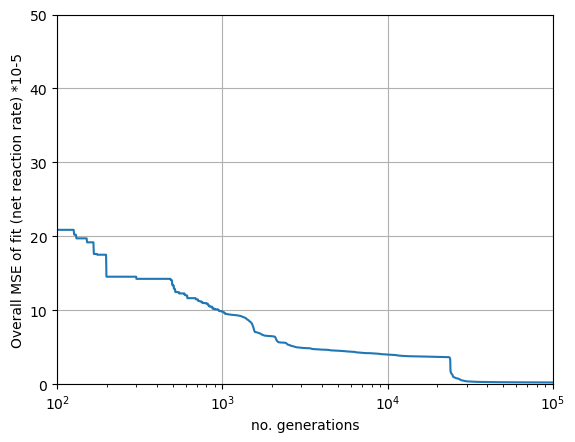

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.553802026159365
1.5286278474705828
0.836932267713019
-4.269530862780405
0.49566298128911074
0.004376317970873534
0.40025205889027105
-6.223247659089998
0.5005354255156146
5.994094463959804
4.687592721457779
4.760014095204067
0.7867078294848322
0.021848212435093117
3.0498070620431594
2.3765656041672136e-06
0.1536772106564417
-11.831565924477168
1.8686780958920277
1.565427409850431
-11.299723780790913
1.1665206218386313
3.929795392704192
0.026933951178533967
4.0658144479937235
4.974918192565029
1.91488324199117
10.544257166986272
-5.619320884651021
2.9076704488406864
5.157048369723885
2.7872346409168105
-4.277037801420868
0.5590207212714877
1.092956423988484
-1.3010294710066044


In [37]:
res.X

array([-1.15538020e+01,  1.52862785e+00,  8.36932268e-01, -4.26953086e+00,
        4.95662981e-01,  4.37631797e-03,  4.00252059e-01, -6.22324766e+00,
        5.00535426e-01,  5.99409446e+00,  4.68759272e+00,  4.76001410e+00,
        7.86707829e-01,  2.18482124e-02,  3.04980706e+00,  2.37656560e-06,
        1.53677211e-01, -1.18315659e+01,  1.86867810e+00,  1.56542741e+00,
       -1.12997238e+01,  1.16652062e+00,  3.92979539e+00,  2.69339512e-02,
        4.06581445e+00,  4.97491819e+00,  1.91488324e+00,  1.05442572e+01,
       -5.61932088e+00,  2.90767045e+00,  5.15704837e+00,  2.78723464e+00,
       -4.27703780e+00,  5.59020721e-01,  1.09295642e+00, -1.30102947e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.553802026159365
1.6: 1.5286278474705828
0.9: 0.836932267713019
-4.3: -4.269530862780405
0.5: 0.49566298128911074
0.003: 0.004376317970873534
0.4: 0.40025205889027105
-7.9: -6.223247659089998
0.7: 0.5005354255156146
7.2: 5.994094463959804
5.7: 4.687592721457779
5.7: 4.760014095204067
0.8: 0.7867078294848322
0.03: 0.021848212435093117
3.1: 3.0498070620431594
6.000000000000001e-09: 2.3765656041672136e-06
0.1: 0.1536772106564417
-12.0: -11.831565924477168
1.9: 1.8686780958920277
1.6: 1.565427409850431
-11.6: -11.299723780790913
1.2: 1.1665206218386313
4.0: 3.929795392704192
0.01: 0.026933951178533967
4.2: 4.0658144479937235
5.4: 4.974918192565029
2.2: 1.91488324199117
11.8: 10.544257166986272
-12.0: -5.619320884651021
3.3: 2.9076704488406864
1.8: 5.157048369723885
4.2: 2.7872346409168105
-4.0: -4.277037801420868
0.5: 0.5590207212714877
1.0: 1.092956423988484
coeff fit: 0.9398486416686149
r: 0.9694579112414395


In [ ]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.16197067e+01,  1.53908257e+00,  8.46189287e-01, -4.32831398e+00,
        5.01690146e-01,  2.31677350e-05,  3.91684172e-01, -1.11926947e+01,
        1.09792840e+00,  9.44999454e+00,  7.52269371e+00,  7.39384322e+00,
        8.00193901e-01,  4.80455287e-02,  3.26646635e+00,  8.46170020e-03,
        1.23494065e-01, -1.18933924e+01,  1.88276718e+00,  1.59577700e+00,
       -1.07099353e+01,  1.09948567e+00,  3.72354839e+00,  3.60967613e-02,
        3.80406625e+00,  4.48287100e+00,  1.71183020e+00,  9.54723723e+00,
       -3.71533091e+00,  2.42627929e+00,  5.10763961e+00,  2.18640965e+00,
       -4.51257316e+00,  6.00619195e-01,  1.10509837e+00, -1.30102979e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-1.13471420e+01,  1.49551213e+00,  8.08079244e-01, -4.33392244e+00,
        5.02635722e-01,  1.33029232e-06,  3.92161165e-01, -1.09327671e+01,
        1.06566483e+00,  9.29248464e+00,  7.39187492e+00,  7.27448278e+00,
        8.06367887e-01,  4.86324547e-02,  3.27916197e+00,  8.43355674e-03,
        1.22642254e-01, -1.19999864e+01,  1.90306024e+00,  1.62151449e+00,
       -1.10805458e+01,  1.13987306e+00,  3.81051717e+00,  1.17262365e-02,
        3.98127237e+00,  4.59622074e+00,  1.85445573e+00,  1.01202764e+01,
       -1.14598449e+01,  3.17490120e+00,  1.83677765e+00,  4.01339236e+00,
       -4.05102523e+00,  5.09707986e-01,  1.00736696e+00, -1.30102997e+00]
krseed101 = [-1.12758127e+01,  1.48415151e+00,  7.98785859e-01, -4.26376130e+00,
        4.94150924e-01,  1.19387691e-05,  3.99136828e-01, -5.43281265e+00,
        4.03849826e-01,  5.50113404e+00,  4.24512936e+00,  4.35881298e+00,
        6.57549954e-01,  4.61118224e-02,  3.13768582e+00,  1.09176189e-06,
        2.51735914e-01, -1.17474877e+01,  1.85738077e+00,  1.58435109e+00,
       -1.15389739e+01,  1.19425794e+00,  4.03834352e+00,  2.75369349e-03,
        4.19844068e+00,  4.93905257e+00,  2.01628947e+00,  1.08895772e+01,
       -1.39392207e+00,  2.95489530e+00,  8.31742385e+00,  1.94180109e+00,
       -4.00088699e+00,  5.06495327e-01,  1.05792646e+00, -1.30102990e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

In [ ]:
meankr

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()